In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from pickle import dump
from unicodedata import normalize
import tinysegmenter
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [22]:
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()
    file.close()
    return text

def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

data = read_text("jpn.txt")
jpn_eng = to_lines(data)
jpn_eng = array(jpn_eng)
jpn_eng = jpn_eng[:20000,:]

jpn_eng

array([['Go.', '行け。'],
       ['Go.', '行きなさい。'],
       ['Hi.', 'こんにちは。'],
       ...,
       ['I agree with you absolutely.', '全く同感です。'],
       ['I agree with you absolutely.', '全面的に君の意見に賛成だよ。'],
       ['I agree with you completely.', '全く同感です。']], dtype='<U192')

In [23]:
jpn_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in jpn_eng[:,0]]
jpn_eng[:,0] = [jpn_eng[i,0].lower() for i in range(len(jpn_eng[:,0]))] 
jpn_eng

array([['go', '行け。'],
       ['go', '行きなさい。'],
       ['hi', 'こんにちは。'],
       ...,
       ['i agree with you absolutely', '全く同感です。'],
       ['i agree with you absolutely', '全面的に君の意見に賛成だよ。'],
       ['i agree with you completely', '全く同感です。']], dtype='<U192')

In [24]:
jpn_eng[:,1] = [" ".join(tinysegmenter.tokenize(i)[:-1]) for i in jpn_eng[:,1]]
jpn_eng

array([['go', '行け'],
       ['go', '行き なさい'],
       ['hi', 'こん にち は'],
       ...,
       ['i agree with you absolutely', '全く 同感 です'],
       ['i agree with you absolutely', '全面 的 に 君 の 意見 に 賛成 だ よ'],
       ['i agree with you completely', '全く 同感 です']], dtype='<U192')

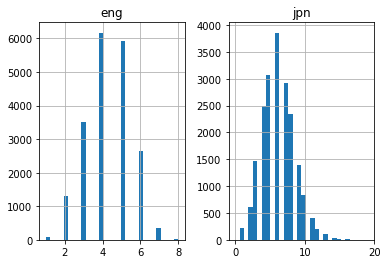

In [28]:
eng_l = []
jpn_l = []

# populate the lists with sentence lengths
for i in jpn_eng[:,0]:
      eng_l.append(len(i.split()))

for i in jpn_eng[:,1]:
      jpn_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'jpn':jpn_l})
# print(length_df)

length_df.hist(bins = 30)
plt.show()

In [29]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [31]:
eng_tokenizer = tokenization(jpn_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4525


In [32]:
jpn_tokenizer = tokenization(jpn_eng[:, 1])
jpn_vocab_size = len(jpn_tokenizer.word_index) + 1

jpn_length = 8
print('Japanese Vocabulary Size: %d' % jpn_vocab_size)

Japanese Vocabulary Size: 8304


In [ ]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [5]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
import tinysegmenter
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs
 
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for i in range(2):
			if i == 0:
				line = pair[0]
				# normalize unicode characters
				line = normalize('NFD', line).encode('ascii', 'ignore')
				line = line.decode('UTF-8')
				# tokenize on white space
				line = line.split()           
				# convert to lowercase
				line = [word.lower() for word in line]
				# remove punctuation from each token
				line = [word.translate(table) for word in line]
				# remove non-printable chars form each token
				line = [re_print.sub('', w) for w in line]
				# remove tokens with numbers in them
				line = [word for word in line if word.isalpha()]
				# store as string
				clean_pair.append(' '.join(line))
			else:
				line = pair[1]
				l = list(line)[:-1]
				line = [word.lower() for word in l]
				line1 = "".join(line)
				tokenized_statement = tinysegmenter.tokenize(line1)                
				clean_pair.append(' '.join(tokenized_statement))
		cleaned.append(clean_pair)
	return array(cleaned)
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load dataset
filename = 'jpn.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# print(pairs)
# clean sentences
clean_pairs = clean_pairs(pairs)
# print(clean_pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-japanese_simple2.pkl')
# spot check
for i in range(50):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))
#     print(clean_pairs[i])

Saved: english-japanese_simple2.pkl
[go] => [行け]
[go] => [行き なさい]
[hi] => [こん にち は]
[hi] => [もしもし]
[hi] => [やっほー]
[hi] => [こん にち は]
[run] => [走れ]
[run] => [走っ て]
[who] => [誰]
[wow] => [すごい]
[wow] => [ワォ]
[wow] => [わぉ]
[wow] => [おー]
[fire] => [火事 だ]
[fire] => [火事]
[fire] => [撃て]
[help] => [助け て]
[help] => [助け て くれ]
[jump] => [飛び越えろ]
[jump] => [跳べ]
[jump] => [飛び降りろ]
[jump] => [飛び跳ね て]
[jump] => [ジャンプ し て]
[jump] => [跳べ]
[jump] => [飛び跳ね て]
[jump] => [ジャンプ し て]
[stop] => [やめろ]
[stop] => [止まれ]
[wait] => [待っ て]
[go on] => [続け て]
[go on] => [進ん で]
[go on] => [進め]
[go on] => [続けろ]
[hello] => [こん にち は]
[hello] => [もしもし]
[hello] => [こん にち は]
[hurry] => [急げ]
[i see] => [なる ほど]
[i see] => [なる ほどね]
[i see] => [わかっ た]
[i see] => [わかり まし た]
[i see] => [そう です か]
[i see] => [そう なん だ]
[i see] => [そっか]
[i try] => [頑張っ て みる]
[i try] => [やっ て みる]
[i try] => [試し て みる]
[i try] => [やっ て みよう]
[i try] => [トライ し て みる]
[i won] => [俺 の 勝ちー]


In [6]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-japanese_simple2.pkl')
# print(raw_dataset)

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# print(dataset)
# random shuffle
shuffle(dataset)
# print(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-japanese_simple2-both.pkl')
save_clean_data(train, 'english-japanese_simple2-train.pkl')
save_clean_data(test, 'english-japanese_simple2-test.pkl')

Saved: english-japanese_simple2-both.pkl
Saved: english-japanese_simple2-train.pkl
Saved: english-japanese_simple2-test.pkl


In [8]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

import pydot

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# load datasets
dataset = load_clean_sentences('english-japanese_simple2-both.pkl')
train = load_clean_sentences('english-japanese_simple2-train.pkl')
test = load_clean_sentences('english-japanese_simple2-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('Japanese Vocabulary Size: %d' % ger_vocab_size)
print('Japanese Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
# summarize defined model
print(model.summary())
plot_model(model, to_file='japmodel_simple2.png', show_shapes=True)
# fit model
filename = 'japmodel_simple2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(trainX, trainY, epochs=25, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)


English Vocabulary Size: 2716
English Max Length: 7
Japanese Vocabulary Size: 4740
Japanese Max Length: 19
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 19, 256)           1213440   
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 7, 256)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 256)            525312    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 2716)           698012    
Total params: 2,962,076
Trainable params: 2,962,076
Non-trainable params: 0
_________________________________________________________________
None
Train on 9000 sample

In [16]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source)[0]
	print("Prediction",prediction)
	integers = [argmax(vector) for vector in prediction]
	print("Int",integers)
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())

# load datasets
dataset = load_clean_sentences('english-japanese_simple2-both.pkl')
train = load_clean_sentences('english-japanese_simple2-train.pkl')
test = load_clean_sentences('english-japanese_simple2-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('japmodel_simple.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)
# print(train)

train
Prediction [[1.8691173e-05 3.2363638e-02 9.1947187e-03 ... 6.0095651e-10
  4.9320786e-10 6.7787054e-10]
 [3.6757905e-05 7.4016025e-05 8.3076918e-01 ... 9.6029497e-11
  7.2248631e-11 1.1773166e-10]
 [4.3144001e-04 3.7094933e-06 8.6128144e-03 ... 2.3238776e-10
  1.7023788e-10 2.7563693e-10]
 ...
 [6.4365530e-01 7.3808944e-05 1.0011611e-02 ... 2.5054385e-09
  1.9014148e-09 2.8989131e-09]
 [9.9494404e-01 1.4935292e-06 1.7612918e-04 ... 3.8096849e-11
  3.0035405e-11 4.9114678e-11]
 [9.9948138e-01 1.7620553e-07 2.2612297e-05 ... 2.3137039e-12
  1.9307438e-12 3.0633304e-12]]
Int [15, 2, 3, 47, 0, 0, 0]
src=[と にかく やれ よ], target=[just do that], predicted=[its is tom am]
Prediction [[4.3756936e-05 2.2607148e-02 2.9164588e-04 ... 3.8564959e-08
  3.0170032e-08 2.9591401e-08]
 [3.0770670e-03 7.8304845e-05 8.3722509e-05 ... 2.8209845e-08
  3.1817581e-08 2.1935891e-08]
 [4.1855830e-01 9.3532242e-07 2.4209269e-06 ... 2.0758523e-07
  2.1081161e-07 1.6488698e-07]
 ...
 [9.9987602e-01 4.7403255e-09

Prediction [[8.1970729e-06 2.0884864e-02 2.8950333e-05 ... 1.0220961e-08
  8.0835179e-09 9.7717718e-09]
 [5.1537769e-05 2.7739019e-05 2.2543052e-02 ... 1.1373374e-08
  1.0726442e-08 1.2369723e-08]
 [2.2674184e-03 4.1709589e-07 1.7926366e-03 ... 1.0604062e-08
  1.0612923e-08 1.0305939e-08]
 ...
 [9.6846753e-01 2.7742040e-08 1.0928318e-05 ... 8.4624696e-10
  7.4010875e-10 8.9346214e-10]
 [9.9915850e-01 2.6670901e-09 1.1142027e-06 ... 1.8050202e-11
  1.5921106e-11 2.1649545e-11]
 [9.9973434e-01 2.2990880e-09 3.7333155e-07 ... 6.2683973e-12
  5.3123556e-12 7.5610299e-12]]
Int [65, 401, 47, 0, 0, 0, 0]
Prediction [[4.59421390e-05 3.17928605e-02 9.76789670e-06 ... 1.94256515e-07
  1.30502002e-07 1.53858707e-07]
 [5.85960370e-05 5.24455099e-05 1.50238848e-04 ... 1.59910343e-07
  1.44477838e-07 1.38726108e-07]
 [1.55099391e-04 9.04975052e-04 7.69042344e-06 ... 7.89859467e-09
  6.85177204e-09 5.57819124e-09]
 ...
 [8.22485387e-01 1.07721942e-04 4.44147327e-06 ... 1.73737273e-08
  1.41956109e-08

Prediction [[1.1845302e-05 3.4840824e-04 1.8606536e-02 ... 1.1308774e-09
  1.1972409e-09 1.4810002e-09]
 [9.6754346e-05 2.8249917e-05 6.5207940e-01 ... 9.1747282e-10
  9.6783082e-10 1.4621072e-09]
 [2.2839535e-02 6.4068023e-05 1.7874431e-02 ... 4.4076534e-09
  4.3359600e-09 5.8050666e-09]
 ...
 [9.9117506e-01 1.3737609e-07 2.7175772e-04 ... 9.3173275e-11
  7.5941448e-11 1.2899928e-10]
 [9.9902451e-01 2.4712133e-08 2.5520701e-05 ... 1.1065136e-11
  9.3171746e-12 1.6408012e-11]
 [9.9976450e-01 1.1156750e-08 6.4272631e-06 ... 2.3846756e-12
  2.1974527e-12 3.8118202e-12]]
Int [6, 2, 174, 0, 0, 0, 0]
Prediction [[7.4812429e-05 8.2236886e-01 1.5254138e-06 ... 6.4767761e-08
  6.0230676e-08 6.2293793e-08]
 [8.6876663e-04 9.6403174e-03 2.9466414e-06 ... 6.9289840e-08
  7.3117960e-08 8.9968452e-08]
 [4.9687916e-04 6.8547288e-03 2.3953569e-07 ... 3.8717909e-10
  4.1409312e-10 4.9549115e-10]
 ...
 [9.7208595e-01 6.4189185e-06 1.4393870e-06 ... 3.1688668e-10
  3.2360545e-10 3.5614395e-10]
 [9.92712

Prediction [[1.5367078e-07 8.7056273e-05 3.7565689e-05 ... 1.2053632e-10
  1.5065590e-10 1.3003164e-10]
 [2.2408711e-05 3.0429308e-06 1.9306560e-01 ... 9.6856323e-10
  8.7268875e-10 1.1521427e-09]
 [2.4437129e-02 6.2136286e-07 1.5048028e-03 ... 2.6714225e-08
  1.9062613e-08 2.0614156e-08]
 ...
 [9.9881721e-01 1.5144389e-09 2.0576394e-06 ... 5.7723958e-11
  3.8193691e-11 6.0444823e-11]
 [9.9975806e-01 2.4493657e-10 7.0211667e-07 ... 5.1447436e-12
  3.6481070e-12 6.3321397e-12]
 [9.9985099e-01 1.2648642e-10 5.5276018e-07 ... 3.4598314e-12
  2.5883846e-12 4.5364615e-12]]
Int [6, 714, 217, 0, 0, 0, 0]
Prediction [[5.0109866e-06 5.1571047e-01 2.6980852e-05 ... 3.4056156e-09
  3.2881426e-09 3.8053960e-09]
 [9.0337056e-07 8.6076476e-04 1.7260025e-04 ... 1.2930742e-09
  1.2052018e-09 1.2374305e-09]
 [6.3746775e-05 2.4096726e-03 3.7966827e-03 ... 1.7864026e-09
  1.4274671e-09 1.6081465e-09]
 ...
 [8.7113875e-01 7.8842013e-06 8.6040352e-05 ... 3.3313152e-09
  2.5335527e-09 3.8752361e-09]
 [9.990

Prediction [[1.35779157e-02 2.83219535e-02 1.60431882e-04 ... 2.99484191e-06
  3.08466178e-06 3.69964255e-06]
 [6.61661267e-01 8.50385841e-05 3.67779248e-05 ... 1.01406435e-07
  1.15300757e-07 1.52814110e-07]
 [9.98801947e-01 1.94963633e-07 7.66188464e-07 ... 1.97564423e-10
  1.84042143e-10 2.48335963e-10]
 ...
 [9.99906063e-01 2.59222177e-09 4.68370516e-08 ... 6.30251754e-12
  5.24105022e-12 9.23455930e-12]
 [9.99917030e-01 1.59321456e-09 5.04894579e-08 ... 4.72327386e-12
  3.79485939e-12 7.01946617e-12]
 [9.99922514e-01 1.19511412e-09 5.31934923e-08 ... 4.33114569e-12
  3.48152778e-12 6.41296998e-12]]
Int [761, 0, 0, 0, 0, 0, 0]
Prediction [[1.39095471e-06 9.58199143e-01 1.17675847e-06 ... 6.23085680e-11
  6.18892784e-11 7.79636633e-11]
 [2.04053265e-03 5.71766694e-04 3.12753284e-04 ... 9.82476056e-09
  1.62329936e-08 1.38697276e-08]
 [9.69850123e-01 2.37031836e-05 1.35359560e-05 ... 2.76935280e-10
  3.22072646e-10 3.57217977e-10]
 ...
 [9.99928474e-01 1.29757209e-08 1.14269465e-08 .

Prediction [[3.8374444e-03 4.7193553e-02 1.5658777e-03 ... 1.3683894e-05
  1.2847036e-05 1.1815349e-05]
 [1.7935252e-01 4.9804530e-06 2.2825350e-03 ... 4.1737027e-07
  4.4116649e-07 4.9344260e-07]
 [9.9154836e-01 3.6816439e-09 1.6697936e-06 ... 2.9306193e-09
  3.1241771e-09 3.3741518e-09]
 ...
 [9.9987602e-01 1.5778083e-09 9.6529831e-08 ... 2.4809321e-11
  2.5898826e-11 3.5838301e-11]
 [9.9989033e-01 1.5599246e-09 6.8397235e-08 ... 2.2636048e-11
  2.2434887e-11 3.3360113e-11]
 [9.9989986e-01 9.3621844e-10 9.8850357e-08 ... 1.8624628e-11
  1.7164227e-11 2.7025276e-11]]
Int [10, 0, 0, 0, 0, 0, 0]
Prediction [[2.3726857e-08 9.8133516e-01 1.3982303e-06 ... 7.3709060e-12
  6.7153453e-12 6.8306658e-12]
 [3.1741056e-06 2.0334793e-03 3.7205832e-03 ... 9.6899000e-10
  1.0980850e-09 1.2763837e-09]
 [1.7991498e-04 1.2670696e-03 1.4886180e-03 ... 2.0647600e-10
  2.0594740e-10 2.5798896e-10]
 ...
 [9.6508968e-01 1.2230256e-04 1.7214272e-05 ... 5.6654414e-10
  5.5498039e-10 7.8978274e-10]
 [9.994700

Int [27, 3, 778, 0, 0, 0, 0]
Prediction [[1.40549758e-07 8.30365531e-03 2.64256887e-05 ... 1.25268226e-10
  9.69749697e-11 1.44736126e-10]
 [1.95960206e-06 4.82575160e-05 4.20347555e-03 ... 1.27348143e-09
  1.10332621e-09 1.83778381e-09]
 [1.23031277e-04 7.25777209e-05 8.44634560e-05 ... 9.29040733e-10
  6.93691160e-10 1.16155452e-09]
 ...
 [1.88126087e-01 2.14273066e-04 1.17999145e-04 ... 2.26647892e-08
  1.80234778e-08 2.63559325e-08]
 [9.92965221e-01 1.08770962e-06 2.08040251e-06 ... 1.80409201e-10
  1.70466932e-10 2.64548078e-10]
 [9.99543488e-01 4.76849955e-08 1.93854589e-07 ... 1.12470484e-11
  1.22388410e-11 1.99177307e-11]]
Int [5, 205, 3, 14, 0, 0, 0]
Prediction [[7.7832165e-06 5.8425289e-02 2.0972011e-04 ... 2.8892766e-09
  2.9627230e-09 3.2368177e-09]
 [2.0387588e-05 1.4249048e-03 7.8147136e-02 ... 3.3936158e-09
  3.7286725e-09 4.3067225e-09]
 [3.7241407e-04 9.5741259e-04 1.5079196e-02 ... 2.2896547e-09
  1.8299060e-09 2.6340194e-09]
 ...
 [3.7298825e-02 3.7743078e-04 1.6067

Prediction [[3.7434333e-08 3.6926249e-05 7.8983133e-04 ... 1.1924571e-11
  9.1088734e-12 1.1882024e-11]
 [4.7141100e-07 1.1032660e-06 9.8204511e-01 ... 4.9111725e-11
  3.9946060e-11 4.9301122e-11]
 [2.5347882e-04 3.0758758e-05 7.3401672e-03 ... 5.2338345e-10
  4.0300019e-10 4.8697874e-10]
 ...
 [6.5434730e-01 2.2882205e-05 1.5795190e-03 ... 5.7321690e-09
  6.0112040e-09 6.7565935e-09]
 [9.9710685e-01 4.3240959e-07 7.0408372e-05 ... 5.0222417e-11
  5.0744301e-11 7.1242658e-11]
 [9.9949515e-01 7.3016210e-08 2.5723140e-05 ... 6.4836387e-12
  6.6798121e-12 1.0952066e-11]]
Int [5, 2, 3, 431, 0, 0, 0]
Prediction [[2.4824945e-05 1.8450022e-05 9.4918025e-05 ... 2.3288528e-08
  1.9259678e-08 1.7959119e-08]
 [3.7436993e-03 2.9730794e-04 3.7649203e-02 ... 3.5416566e-08
  2.8260038e-08 3.5902801e-08]
 [1.7805172e-02 1.8190871e-03 2.1076489e-02 ... 2.4293358e-09
  1.8105015e-09 2.4174613e-09]
 ...
 [9.6103024e-01 1.1367339e-04 1.6886240e-03 ... 1.7233991e-10
  1.6211249e-10 2.3431720e-10]
 [9.97300

Prediction [[3.28077498e-04 6.40168264e-06 6.83445334e-02 ... 2.39920638e-07
  1.76541491e-07 2.57222808e-07]
 [1.15155848e-03 8.69085634e-05 8.24511424e-03 ... 1.23394912e-08
  6.81949430e-09 1.39440974e-08]
 [2.11334247e-02 2.32438997e-05 4.79708455e-04 ... 7.15607769e-08
  4.69994141e-08 1.00363849e-07]
 ...
 [9.92598772e-01 3.82349981e-07 3.58655575e-06 ... 6.28249786e-10
  3.92981481e-10 7.64133423e-10]
 [9.99548495e-01 6.25251104e-08 2.53753967e-07 ... 2.13920409e-11
  1.32569546e-11 2.77990200e-11]
 [9.99786198e-01 2.96633029e-08 8.85569165e-08 ... 1.17860027e-11
  7.70019638e-12 1.55939168e-11]]
Int [62, 9, 146, 0, 0, 0, 0]
Prediction [[2.7524648e-04 1.2708989e-04 6.3146180e-03 ... 4.6387439e-07
  3.7551973e-07 3.8105665e-07]
 [1.2666394e-03 1.5346374e-06 7.8592815e-02 ... 2.7539525e-07
  2.4877394e-07 2.6934404e-07]
 [1.8230748e-03 2.2600073e-08 7.4536675e-01 ... 1.9587107e-08
  1.8223375e-08 2.2021997e-08]
 ...
 [9.9933594e-01 5.6491440e-11 4.6944982e-07 ... 1.6132835e-10
  1

  1.9526180e-12 2.3607850e-12]]
Int [1, 16, 3, 47, 0, 0, 0]
Prediction [[6.1072292e-06 5.5698515e-04 2.4897505e-03 ... 6.9342665e-09
  7.6845570e-09 7.8202342e-09]
 [6.5660146e-03 1.5378106e-05 4.8774697e-02 ... 8.0337443e-08
  8.6815717e-08 1.0050689e-07]
 [8.6200237e-01 5.6848899e-07 3.1981592e-05 ... 1.9999229e-08
  1.8283913e-08 2.1826871e-08]
 ...
 [9.9988878e-01 4.7418575e-10 2.5139112e-08 ... 1.0240732e-11
  1.1693966e-11 1.5242618e-11]
 [9.9995267e-01 4.0003895e-10 1.6968254e-08 ... 4.0412534e-12
  4.7390273e-12 7.0836301e-12]
 [9.9996102e-01 5.1510174e-10 2.0224666e-08 ... 2.7040219e-12
  3.1226681e-12 5.1154814e-12]]
Int [5, 5, 0, 0, 0, 0, 0]
Prediction [[3.7406418e-05 1.1433475e-01 1.0390796e-03 ... 9.6976009e-09
  8.9213161e-09 1.1833891e-08]
 [3.0660893e-05 2.0734490e-04 3.1945473e-01 ... 1.4357455e-09
  1.3534819e-09 1.7090306e-09]
 [2.7597332e-03 1.5922013e-04 7.9017701e-03 ... 2.2553106e-09
  1.8888011e-09 1.9022361e-09]
 ...
 [5.0168562e-01 6.4094151e-05 2.8018610e-04 

Prediction [[8.24984525e-08 1.97330774e-05 6.60178728e-07 ... 3.59809071e-10
  3.85573601e-10 4.31171765e-10]
 [2.99489839e-05 5.26988231e-07 1.67148944e-04 ... 9.14428639e-08
  8.43643591e-08 1.13396979e-07]
 [1.70167629e-03 3.62327773e-06 2.02561682e-06 ... 8.74887895e-09
  7.83707588e-09 1.01717825e-08]
 ...
 [9.95727777e-01 1.81703854e-07 9.13128559e-08 ... 7.03586467e-10
  7.45523254e-10 7.25779437e-10]
 [9.99734819e-01 1.42841650e-09 1.11140688e-08 ... 3.39572433e-11
  3.94628323e-11 4.27116745e-11]
 [9.99862909e-01 5.68151470e-10 5.61848568e-09 ... 1.70560302e-11
  2.07597897e-11 2.20930357e-11]]
Int [5, 622, 38, 0, 0, 0, 0]
Prediction [[4.9017381e-05 5.5439165e-03 6.6329469e-03 ... 7.0734414e-09
  5.5139422e-09 7.2545374e-09]
 [3.8333349e-03 1.0915516e-03 6.8978597e-03 ... 1.2231128e-08
  1.1941370e-08 1.6688150e-08]
 [4.5518124e-01 8.1971842e-07 7.8495243e-05 ... 7.5759017e-09
  5.9904828e-09 9.0963024e-09]
 ...
 [9.9979836e-01 2.8374400e-08 7.5461848e-08 ... 5.1860157e-12
  3

Prediction [[8.98606086e-05 1.14451014e-01 1.64331926e-04 ... 1.13113492e-08
  1.11607124e-08 1.05984199e-08]
 [1.30874896e-03 6.75181975e-04 7.49203668e-04 ... 1.01960165e-08
  1.01715809e-08 1.02084217e-08]
 [1.73375800e-01 8.05057236e-04 4.58081304e-05 ... 4.03010381e-09
  3.43726270e-09 4.03745926e-09]
 ...
 [9.96808589e-01 2.15859154e-06 9.54873443e-08 ... 4.30461049e-11
  2.58013073e-11 4.10238302e-11]
 [9.99417067e-01 4.47054276e-07 9.46420613e-08 ... 6.17625005e-12
  4.24496766e-12 6.77325080e-12]
 [9.99693513e-01 2.75477817e-07 1.05388509e-07 ... 2.81463936e-12
  2.16920514e-12 3.44879832e-12]]
Int [4, 182, 9, 0, 0, 0, 0]
Prediction [[6.7340874e-04 1.3942206e-04 3.9007652e-03 ... 5.3289654e-07
  4.8432759e-07 5.2862447e-07]
 [5.8321003e-03 1.3354242e-04 9.9110254e-04 ... 1.7265064e-08
  1.5637186e-08 1.9922595e-08]
 [5.3187495e-01 5.1929219e-06 4.5234768e-04 ... 1.9316083e-07
  2.0138523e-07 2.2408757e-07]
 ...
 [9.9976116e-01 6.5897656e-09 3.0164941e-07 ... 1.2048135e-11
  1.

Prediction [[2.3666844e-06 4.8345217e-01 1.6114802e-05 ... 2.3300755e-09
  1.9335105e-09 2.6046278e-09]
 [1.9987943e-05 4.5907430e-04 4.2846180e-03 ... 1.5696475e-08
  1.3992270e-08 2.1449914e-08]
 [8.3280385e-05 4.5684832e-05 3.7859791e-05 ... 2.6063813e-09
  1.8142177e-09 2.4678606e-09]
 ...
 [7.4345726e-01 8.9726382e-05 3.9580133e-05 ... 4.2460973e-09
  2.8469562e-09 3.7844887e-09]
 [9.9562883e-01 2.0778207e-06 3.4377797e-07 ... 2.0437632e-11
  1.2098669e-11 1.8786060e-11]
 [9.9901545e-01 2.2614799e-07 9.4744699e-08 ... 3.8710723e-12
  2.2582780e-12 3.8325172e-12]]
Int [1, 183, 7, 7, 0, 0, 0]
Prediction [[1.0783601e-06 7.9107213e-01 6.8389502e-04 ... 8.4110198e-11
  6.4901549e-11 8.7186453e-11]
 [8.1436687e-05 9.6594624e-04 1.8748265e-02 ... 1.3332300e-09
  9.6443975e-10 1.2682618e-09]
 [1.3943904e-03 5.0047689e-05 6.8797402e-05 ... 8.4878243e-10
  5.9491245e-10 6.5018479e-10]
 ...
 [7.1389425e-01 2.6411845e-04 1.6675973e-05 ... 1.2585990e-09
  1.1416303e-09 1.1365854e-09]
 [9.89179

Prediction [[2.7019803e-05 3.0636627e-02 3.4886551e-05 ... 1.8728272e-08
  1.2686089e-08 1.8036278e-08]
 [2.4962139e-05 6.4531388e-04 1.3026826e-01 ... 6.1622822e-09
  4.1914889e-09 6.1593677e-09]
 [2.9895233e-04 1.6917384e-03 2.0308491e-02 ... 2.7772866e-09
  1.9192770e-09 3.0612273e-09]
 ...
 [1.8888219e-01 1.4148111e-03 1.2136322e-02 ... 1.4985368e-08
  8.0198657e-09 1.7288137e-08]
 [9.9232602e-01 1.0488464e-05 3.0207439e-04 ... 3.8751488e-11
  2.0956679e-11 5.5147081e-11]
 [9.9922895e-01 7.2010130e-07 2.3023438e-05 ... 1.3189340e-12
  7.4658693e-13 1.9468836e-12]]
Int [24, 18, 12, 492, 0, 0, 0]
Prediction [[1.4508215e-05 3.6807708e-02 5.1418110e-06 ... 1.5900758e-09
  1.3928614e-09 1.4944390e-09]
 [6.1324117e-04 1.5286201e-05 1.3179836e-04 ... 4.4311967e-09
  4.4674504e-09 4.7604312e-09]
 [3.2132067e-02 8.5533269e-05 1.0532352e-05 ... 1.5006595e-09
  1.5261126e-09 1.3159678e-09]
 ...
 [9.8585516e-01 4.5435609e-06 9.5584153e-07 ... 1.0606198e-11
  8.6675129e-12 1.0440091e-11]
 [9.97

Prediction [[2.39691644e-06 8.38790774e-01 1.30015760e-05 ... 9.60182045e-10
  8.18572321e-10 8.92730778e-10]
 [1.29916065e-04 1.88774196e-04 7.15715578e-03 ... 5.55546809e-09
  6.21069596e-09 6.71086875e-09]
 [3.45577784e-02 1.95974553e-05 2.76800105e-03 ... 2.65430948e-08
  2.68194267e-08 2.24220891e-08]
 ...
 [9.98842180e-01 4.63500349e-08 1.40365819e-06 ... 8.25245844e-11
  7.86800486e-11 9.55499638e-11]
 [9.99862790e-01 1.11508687e-08 1.11507894e-07 ... 4.27396963e-12
  3.77310292e-12 4.88850757e-12]
 [9.99909997e-01 6.48183773e-09 5.64029285e-08 ... 2.72121063e-12
  2.22842599e-12 3.10609069e-12]]
Int [1, 16, 3033, 0, 0, 0, 0]
Prediction [[3.5806770e-06 7.3009981e-03 6.4554368e-04 ... 1.0160960e-09
  8.2938295e-10 9.7448982e-10]
 [1.0455745e-04 4.5743155e-07 7.9566985e-03 ... 2.9842235e-09
  2.4119871e-09 2.5303455e-09]
 [3.2498501e-02 8.2525638e-08 6.5408298e-04 ... 1.5208985e-07
  1.3077100e-07 1.4201584e-07]
 ...
 [9.9973971e-01 4.5072017e-09 3.1442454e-07 ... 1.1224010e-11
  

Prediction [[3.6449758e-03 1.4693913e-04 3.1845819e-05 ... 3.4279935e-07
  3.0072388e-07 2.9509584e-07]
 [2.3047057e-01 3.0484218e-06 5.6449080e-06 ... 2.3565319e-08
  3.0054277e-08 2.3558847e-08]
 [9.4753683e-01 8.4058811e-08 2.8217099e-07 ... 5.2551358e-10
  7.1126532e-10 5.5520333e-10]
 ...
 [9.9956745e-01 2.1956865e-09 1.4664507e-08 ... 2.6036066e-12
  2.6937964e-12 2.6521036e-12]
 [9.9973100e-01 2.2759081e-09 2.5260587e-08 ... 2.0122636e-12
  1.8421102e-12 1.9345218e-12]
 [9.9973410e-01 4.2287978e-09 4.6308411e-08 ... 1.7143380e-12
  1.4507277e-12 1.5897792e-12]]
Int [27, 0, 0, 0, 0, 0, 0]
Prediction [[4.3439098e-08 9.9412380e-03 9.3512092e-05 ... 8.4627114e-12
  6.1936367e-12 8.8947643e-12]
 [1.3848128e-06 1.0486195e-03 3.0850065e-01 ... 1.2076257e-10
  9.1110654e-11 1.4673046e-10]
 [4.2494074e-05 6.8725990e-03 9.8894592e-03 ... 3.0070627e-10
  2.2309966e-10 3.7615358e-10]
 ...
 [1.6812855e-02 6.3453079e-04 1.0079117e-02 ... 1.5255758e-09
  1.1135112e-09 1.5212289e-09]
 [6.231734

Prediction [[8.4476742e-06 1.3189345e-03 2.1138319e-04 ... 4.6745431e-08
  3.7165812e-08 5.0699555e-08]
 [5.2885607e-06 4.9674493e-04 8.2833736e-05 ... 1.9690503e-09
  1.4485727e-09 2.0820374e-09]
 [6.8711211e-05 3.1952630e-04 4.9591440e-06 ... 2.0717321e-09
  1.3492155e-09 2.2179685e-09]
 ...
 [2.6774207e-01 1.7667537e-04 7.7487908e-05 ... 1.2142452e-08
  7.7335374e-09 1.0832729e-08]
 [9.9478686e-01 3.9845468e-06 1.8080847e-06 ... 2.8639278e-11
  2.1370605e-11 2.6870369e-11]
 [9.9944443e-01 1.5580265e-07 1.9884067e-07 ... 1.6775667e-12
  1.4393228e-12 1.8916476e-12]]
Int [294, 11, 30, 7, 0, 0, 0]
Prediction [[4.5198598e-05 2.8409915e-05 1.6937114e-03 ... 2.3988532e-08
  1.6761874e-08 2.3338588e-08]
 [2.0124870e-03 5.6257369e-07 1.5115310e-01 ... 2.3290115e-08
  1.8244325e-08 2.7303038e-08]
 [3.7093168e-01 2.6152513e-09 1.6628443e-04 ... 7.1484244e-08
  5.1229364e-08 8.6115023e-08]
 ...
 [9.9986362e-01 3.7726350e-10 1.2916612e-07 ... 2.5791978e-11
  2.0410335e-11 4.3104055e-11]
 [9.999

Prediction [[4.16326975e-06 2.49853641e-01 1.77045222e-04 ... 2.64996665e-08
  1.71583618e-08 2.46475089e-08]
 [2.79863366e-06 7.46812497e-04 4.51025832e-03 ... 1.40486929e-08
  1.10436043e-08 1.31782825e-08]
 [2.45879164e-05 2.15967244e-04 6.75181067e-03 ... 2.41229903e-09
  1.65906699e-09 1.82467430e-09]
 ...
 [9.73847061e-02 2.25503845e-05 2.09467307e-05 ... 1.13974323e-08
  8.30427282e-09 8.47195292e-09]
 [9.95298207e-01 1.29276020e-06 2.40837323e-07 ... 1.22245353e-10
  1.04809182e-10 1.18685548e-10]
 [9.99710023e-01 3.54267726e-08 2.40086564e-08 ... 4.56696920e-12
  4.56145885e-12 5.09402590e-12]]
Int [1, 67, 7, 7, 279, 0, 0]
Prediction [[3.8300675e-07 1.0816811e-05 3.4949341e-04 ... 8.6386298e-10
  6.6389355e-10 9.2100616e-10]
 [1.2355567e-05 3.5438492e-07 8.4490889e-01 ... 2.4487152e-09
  1.6354953e-09 2.6128510e-09]
 [2.5059246e-03 1.7103086e-07 1.3318793e-03 ... 3.4640820e-08
  2.2389097e-08 2.7298780e-08]
 ...
 [8.3358544e-01 7.4337930e-07 1.0167765e-03 ... 9.1980601e-09
  7

Prediction [[2.3317941e-04 2.0840931e-04 2.3119561e-04 ... 7.1595684e-07
  5.4474293e-07 5.3407524e-07]
 [7.7955530e-04 3.4390326e-04 5.6663915e-03 ... 5.6315983e-08
  4.6783953e-08 4.2375515e-08]
 [1.5467884e-02 1.0242415e-04 1.7489360e-03 ... 3.6931112e-08
  2.7424463e-08 3.0646763e-08]
 ...
 [9.9766076e-01 3.6588424e-06 4.2158067e-06 ... 5.2327760e-11
  4.2396926e-11 6.6982885e-11]
 [9.9971467e-01 1.9621706e-07 1.0647133e-06 ... 2.8235227e-12
  2.6165463e-12 4.1792602e-12]
 [9.9981385e-01 7.1872023e-08 1.5794679e-06 ... 1.1186386e-12
  1.0575797e-12 1.7396014e-12]]
Int [22, 46, 88, 0, 0, 0, 0]
Prediction [[5.3935882e-08 9.0667689e-01 1.8863868e-06 ... 2.6538093e-11
  1.8502174e-11 2.2716126e-11]
 [1.8368585e-06 4.7233184e-03 3.2103767e-03 ... 1.0702754e-09
  6.2318328e-10 8.8642843e-10]
 [1.4735277e-04 9.3760807e-03 4.9994839e-04 ... 4.3656012e-09
  2.5952305e-09 2.8766058e-09]
 ...
 [5.2715726e-02 1.5505310e-02 5.3309626e-04 ... 1.8368521e-08
  1.0520206e-08 1.4063153e-08]
 [7.5965

Prediction [[7.4296122e-06 6.4720279e-03 4.7683113e-04 ... 1.4475853e-09
  8.7259899e-10 1.4311325e-09]
 [2.8646444e-05 8.5502712e-04 5.3186279e-02 ... 1.2900762e-09
  8.2298840e-10 1.4149756e-09]
 [1.0634166e-02 8.4427302e-05 1.3284363e-03 ... 4.0979811e-09
  2.5848206e-09 4.5061457e-09]
 ...
 [9.9421424e-01 1.9854938e-06 4.2945394e-06 ... 3.3469182e-11
  2.1146224e-11 4.7812442e-11]
 [9.9961358e-01 9.5223122e-08 7.1162805e-07 ... 9.5290106e-13
  7.3059093e-13 1.4860794e-12]
 [9.9973363e-01 4.8055945e-08 6.8832799e-07 ... 3.3185675e-13
  2.8617335e-13 5.4612586e-13]]
Int [57, 69, 246, 0, 0, 0, 0]
Prediction [[1.89732033e-04 2.41415692e-04 2.59737746e-04 ... 3.49833613e-07
  2.77597593e-07 3.44810218e-07]
 [3.90048634e-04 5.77542960e-06 1.05394587e-01 ... 1.40027353e-07
  9.75000205e-08 1.31126569e-07]
 [1.02074619e-03 1.64847788e-05 9.49777961e-02 ... 3.04050474e-09
  2.17636020e-09 3.16493098e-09]
 ...
 [9.91702497e-01 8.36821471e-07 1.27396930e-03 ... 2.47214998e-10
  1.80916379e-10

  1.4669765e-11 1.4727520e-11]]
Int [1, 16, 8, 117, 0, 0, 0]
Prediction [[4.0149418e-05 9.2731617e-02 1.2347200e-04 ... 2.9035972e-08
  2.1788956e-08 2.3819625e-08]
 [2.3830951e-04 2.0203019e-02 2.3108559e-02 ... 2.1259289e-08
  1.6653001e-08 1.9790983e-08]
 [8.3284447e-04 1.6240353e-02 3.4893916e-03 ... 1.5974286e-09
  1.2225154e-09 1.6766121e-09]
 ...
 [1.1932739e-01 5.3085755e-03 1.5920214e-03 ... 7.4346893e-09
  4.7222799e-09 6.5988419e-09]
 [9.4727695e-01 5.0306733e-04 1.3150394e-04 ... 5.0528337e-10
  3.0043959e-10 4.5896667e-10]
 [9.9866629e-01 1.0193964e-05 3.2387873e-06 ... 7.3582425e-12
  4.8745717e-12 8.1268629e-12]]
Int [4, 12, 12, 12, 493, 0, 0]
Prediction [[1.1417155e-06 1.2599402e-02 1.5262500e-05 ... 8.3294338e-10
  5.7293187e-10 7.9677331e-10]
 [1.8355391e-05 1.0378108e-05 5.8024662e-04 ... 2.3256022e-09
  1.3753478e-09 2.0209538e-09]
 [1.8823644e-04 2.4287647e-06 1.4661538e-05 ... 4.1139416e-09
  2.3997921e-09 3.0927874e-09]
 ...
 [8.0666417e-01 6.3295141e-05 3.983879

Prediction [[4.76222249e-06 9.45010185e-01 6.46445960e-06 ... 7.71726849e-10
  7.70782438e-10 9.63251146e-10]
 [9.17376165e-05 4.47819970e-04 3.15974699e-04 ... 2.73336331e-09
  3.00760017e-09 3.86547550e-09]
 [1.28112789e-02 1.81820345e-04 1.79329800e-05 ... 6.80194789e-09
  6.68119648e-09 7.75283748e-09]
 ...
 [9.86304760e-01 2.16203625e-06 2.17443159e-07 ... 2.58453536e-10
  2.41277665e-10 3.33555267e-10]
 [9.98195231e-01 9.18318861e-08 9.42279001e-08 ... 2.43865605e-11
  2.02014811e-11 3.04445878e-11]
 [9.98997748e-01 6.86158117e-08 7.96962993e-08 ... 1.05433535e-11
  8.79585207e-12 1.33626391e-11]]
Int [1, 401, 145, 0, 0, 0, 0]
Prediction [[1.2862420e-03 9.0770110e-02 3.8100643e-05 ... 4.8114191e-07
  4.2088428e-07 4.1196262e-07]
 [7.2962470e-02 2.0123132e-05 8.9538132e-04 ... 7.3344313e-07
  8.3465835e-07 8.1019232e-07]
 [9.9401325e-01 4.7243248e-07 4.2373481e-06 ... 1.4649756e-09
  1.3820464e-09 1.6599145e-09]
 ...
 [9.9996769e-01 6.0703259e-10 6.2989649e-08 ... 4.3831249e-12
  

Prediction [[3.7159440e-05 1.7832993e-02 2.4555772e-04 ... 1.4131536e-08
  1.2172994e-08 1.1109882e-08]
 [1.3666374e-03 8.1979588e-06 1.1458330e-04 ... 3.6721430e-09
  4.2213095e-09 4.1911203e-09]
 [5.1869673e-01 3.1224856e-05 1.2715501e-05 ... 4.1337223e-09
  3.9446659e-09 4.9968838e-09]
 ...
 [9.9913055e-01 2.2248255e-08 7.4383330e-08 ... 1.6566421e-12
  1.5745320e-12 2.1390140e-12]
 [9.9951804e-01 9.9990292e-09 5.9585805e-08 ... 8.2546952e-13
  8.9227475e-13 1.1233958e-12]
 [9.9964738e-01 5.7553455e-09 6.3684638e-08 ... 6.1026829e-13
  6.9635161e-13 8.4599303e-13]]
Int [10, 20, 0, 0, 0, 0, 0]
Prediction [[3.0837805e-04 8.6216815e-04 3.8116061e-05 ... 6.1476321e-08
  4.1836941e-08 4.8123354e-08]
 [2.1063974e-03 6.2815880e-04 6.9883899e-06 ... 1.0337817e-09
  7.5609718e-10 9.4465202e-10]
 [1.4307046e-01 2.1512082e-05 1.7774102e-05 ... 1.6569867e-08
  1.6374543e-08 1.7781689e-08]
 ...
 [9.9346149e-01 2.6590297e-07 8.9230497e-08 ... 1.2324628e-11
  1.2749489e-11 1.4454257e-11]
 [9.96506

Prediction [[1.0319627e-04 5.5095437e-04 1.7271596e-01 ... 1.1649368e-07
  1.0508260e-07 1.0552347e-07]
 [2.0140584e-04 1.1712000e-06 2.5380388e-01 ... 2.4325312e-08
  2.0790594e-08 2.1435959e-08]
 [9.3016932e-03 3.7934260e-08 2.2808772e-02 ... 7.6851506e-08
  6.2211264e-08 6.7377613e-08]
 ...
 [9.9970752e-01 4.4756066e-10 7.2404021e-07 ... 4.0047268e-11
  3.9963564e-11 4.9161553e-11]
 [9.9992204e-01 3.1615502e-11 1.0724286e-07 ... 7.0734226e-12
  7.4246139e-12 9.4639852e-12]
 [9.9994469e-01 1.7936309e-11 3.0547010e-08 ... 5.9383813e-12
  6.4303333e-12 7.7705299e-12]]
Int [2, 2, 3, 0, 0, 0, 0]
Prediction [[4.94673486e-07 1.42275286e-03 2.09753598e-05 ... 3.26285277e-10
  4.06195605e-10 3.89340976e-10]
 [2.77338513e-05 1.12027537e-05 2.64957119e-02 ... 2.73289369e-09
  3.11906878e-09 4.23639834e-09]
 [1.11216325e-02 1.31734555e-06 3.42631596e-04 ... 2.47835938e-08
  3.00861451e-08 2.66732343e-08]
 ...
 [9.97216344e-01 8.34869152e-09 2.46981494e-06 ... 2.49821080e-10
  2.84223756e-10 2.6

  4.22415054e-12 5.46797937e-12]]
Int [36, 11, 0, 0, 0, 0, 0]
Prediction [[1.0661973e-04 6.2943422e-03 3.1740073e-04 ... 1.4043269e-07
  1.2103733e-07 1.4758668e-07]
 [5.0150079e-04 1.0917807e-02 1.5749745e-01 ... 2.2456966e-08
  1.5425691e-08 2.4394387e-08]
 [3.0287830e-03 1.6065268e-02 5.5069335e-02 ... 7.6797448e-09
  4.7810849e-09 7.9540827e-09]
 ...
 [2.5786507e-01 3.2071325e-03 2.5343569e-03 ... 1.6462780e-08
  9.9808393e-09 1.7319380e-08]
 [9.0888196e-01 5.2241195e-04 2.6796601e-04 ... 1.7432681e-09
  1.0402900e-09 1.9683257e-09]
 [9.9610066e-01 1.6409873e-05 1.3943954e-05 ... 3.6284181e-11
  2.3337632e-11 4.4238248e-11]]
Int [24, 2, 12, 12, 0, 0, 0]
Prediction [[3.3605822e-05 5.1704069e-06 8.8016078e-02 ... 5.4910402e-08
  4.1104069e-08 4.6657927e-08]
 [2.9874142e-05 9.4845209e-06 9.0347451e-01 ... 1.8513698e-09
  1.3811848e-09 1.9342845e-09]
 [1.0290599e-02 1.4536984e-05 2.2862214e-01 ... 2.4588052e-08
  1.7076665e-08 2.1183334e-08]
 ...
 [9.9905413e-01 2.7937832e-08 3.6065827

Prediction [[9.7492717e-05 3.7699628e-01 1.9872066e-04 ... 3.6765180e-09
  2.5291891e-09 3.5215861e-09]
 [1.0835874e-02 4.7922189e-05 6.2019055e-05 ... 1.8489617e-08
  1.5804332e-08 2.1294291e-08]
 [9.0219992e-01 1.0035480e-05 2.6754146e-06 ... 1.4498645e-09
  1.3879980e-09 1.8364361e-09]
 ...
 [9.9985576e-01 1.5717092e-07 7.3419089e-09 ... 2.0083349e-12
  1.5678323e-12 2.1903803e-12]
 [9.9992561e-01 1.1912138e-07 8.0949398e-09 ... 1.1167617e-12
  7.8402887e-13 1.1961444e-12]
 [9.9994195e-01 5.9520637e-08 1.2731791e-08 ... 8.1339807e-13
  5.4878666e-13 8.8298406e-13]]
Int [1, 50, 0, 0, 0, 0, 0]
Prediction [[9.3919906e-04 5.5349950e-04 5.8359359e-03 ... 8.2557227e-07
  5.4836386e-07 7.9830312e-07]
 [2.4178239e-02 1.9187756e-03 1.1373167e-03 ... 1.8281280e-07
  1.4291618e-07 2.2026525e-07]
 [5.6585628e-01 1.1831966e-05 1.2960157e-05 ... 1.4256730e-07
  1.6151171e-07 1.9906733e-07]
 ...
 [9.9978679e-01 4.0520522e-08 5.4577203e-08 ... 2.9573000e-11
  2.1762968e-11 4.1816446e-11]
 [9.998889

Prediction [[2.3946591e-04 9.5201198e-05 2.4816522e-04 ... 2.1971650e-06
  1.6128978e-06 1.5290443e-06]
 [2.2211001e-04 2.8813307e-05 1.2179194e-04 ... 3.5646167e-08
  2.6972343e-08 2.6538478e-08]
 [9.0901451e-03 1.9473156e-05 6.1416556e-04 ... 8.9287759e-08
  6.6820149e-08 7.2518610e-08]
 ...
 [9.9466151e-01 4.8849091e-07 1.4223558e-05 ... 2.0462192e-10
  1.4879592e-10 1.9027221e-10]
 [9.9927324e-01 7.9264190e-08 1.0364223e-06 ... 2.2131909e-11
  1.7814210e-11 2.1552073e-11]
 [9.9958259e-01 3.1736622e-08 3.6198162e-07 ... 1.1865947e-11
  1.0486872e-11 1.1987056e-11]]
Int [125, 20, 166, 0, 0, 0, 0]
Prediction [[2.7214104e-04 2.2898483e-05 1.0235177e-04 ... 7.1252919e-07
  6.1627691e-07 5.4431285e-07]
 [3.5298576e-03 3.9169559e-04 1.2117898e-02 ... 5.7060134e-08
  5.5944056e-08 4.7112945e-08]
 [1.3706474e-01 1.1597242e-05 7.5937237e-04 ... 3.3900264e-07
  3.3332162e-07 3.5262838e-07]
 ...
 [9.9818158e-01 2.0206235e-07 3.2085924e-07 ... 4.3856943e-10
  4.1496714e-10 4.6608067e-10]
 [9.99

Prediction [[5.01283351e-03 3.19474668e-04 7.03750132e-03 ... 4.11157635e-05
  4.20237739e-05 3.96749092e-05]
 [5.50520480e-01 6.23413129e-04 8.83004367e-02 ... 4.98201530e-07
  5.12933980e-07 5.62033051e-07]
 [9.97857034e-01 3.51352952e-07 3.11237563e-05 ... 1.32977418e-09
  1.27082678e-09 1.71635828e-09]
 ...
 [9.99905705e-01 1.19355246e-08 6.24164613e-07 ... 1.39169952e-11
  1.13372697e-11 2.01263155e-11]
 [9.99912620e-01 8.23634227e-09 5.48829291e-07 ... 1.30313494e-11
  1.01500639e-11 1.80316404e-11]
 [9.99917388e-01 8.05077427e-09 5.34155504e-07 ... 1.20271015e-11
  9.10843363e-12 1.67996918e-11]]
Int [24, 0, 0, 0, 0, 0, 0]
Prediction [[3.8374444e-03 4.7193553e-02 1.5658777e-03 ... 1.3683894e-05
  1.2847036e-05 1.1815349e-05]
 [1.7935252e-01 4.9804530e-06 2.2825350e-03 ... 4.1737027e-07
  4.4116649e-07 4.9344260e-07]
 [9.9154836e-01 3.6816439e-09 1.6697936e-06 ... 2.9306193e-09
  3.1241771e-09 3.3741518e-09]
 ...
 [9.9987602e-01 1.5778083e-09 9.6529831e-08 ... 2.4809321e-11
  2.5

Prediction [[1.10398437e-08 9.27009969e-05 1.37991556e-05 ... 1.36883855e-11
  1.04198134e-11 1.56135556e-11]
 [1.30815056e-06 2.08384631e-06 1.81044452e-02 ... 4.83384888e-10
  4.80306128e-10 6.01933392e-10]
 [4.17212024e-04 8.16480224e-06 1.72343876e-04 ... 3.98197209e-09
  3.31755046e-09 3.66151398e-09]
 ...
 [9.64596093e-01 9.84816666e-07 9.94904713e-06 ... 2.42057485e-09
  2.00380490e-09 2.61712563e-09]
 [9.99547780e-01 3.27615268e-08 8.09256846e-07 ... 1.62670242e-11
  1.36600896e-11 2.12952156e-11]
 [9.99853015e-01 5.24653077e-09 5.69749488e-07 ... 4.15339811e-12
  3.72230068e-12 5.95035306e-12]]
Int [5, 19, 3, 47, 0, 0, 0]
Prediction [[4.58310562e-04 2.38172233e-05 3.02451826e-03 ... 3.45424269e-07
  2.60295451e-07 2.72860660e-07]
 [1.73373963e-03 1.19391807e-05 5.11875302e-02 ... 4.44750325e-09
  3.32142092e-09 4.58745708e-09]
 [3.77992511e-01 1.37772349e-05 3.19634043e-02 ... 6.20075440e-08
  4.81109588e-08 6.97732290e-08]
 ...
 [9.99353111e-01 9.72423422e-08 3.07193909e-06 .

  6.98470090e-13 1.49443131e-12]]
Int [10, 14, 14, 0, 0, 0, 0]
Prediction [[9.3863397e-09 9.6175134e-01 4.0498088e-07 ... 4.9315409e-12
  5.1711881e-12 6.1772254e-12]
 [7.6155593e-06 8.0497307e-04 7.0404240e-05 ... 2.1304696e-09
  2.8280771e-09 3.4260554e-09]
 [3.1878386e-04 7.3781231e-04 2.6544378e-06 ... 2.5993958e-09
  3.4860006e-09 3.1133491e-09]
 ...
 [9.7935176e-01 4.2648193e-05 2.7312430e-08 ... 7.4655171e-10
  9.0583457e-10 9.1934499e-10]
 [9.9961877e-01 3.6098012e-07 1.7159681e-09 ... 7.4562041e-12
  9.9065244e-12 1.1645453e-11]
 [9.9989450e-01 3.1743014e-08 1.1219123e-09 ... 1.7582326e-12
  2.5216042e-12 3.0919275e-12]]
Int [1, 599, 3, 1633, 0, 0, 0]
Prediction [[8.3501400e-05 1.9419001e-02 2.0252611e-04 ... 2.8071946e-07
  2.4561942e-07 1.9180665e-07]
 [6.7686131e-03 2.3952183e-04 7.4017397e-04 ... 3.9083451e-07
  4.3003567e-07 2.4728692e-07]
 [2.3852873e-01 4.9935119e-07 1.4610811e-05 ... 5.2210572e-07
  6.5528775e-07 4.4083140e-07]
 ...
 [9.9980837e-01 5.6505778e-10 1.7349

Prediction [[6.64870504e-06 8.38683266e-03 6.23184489e-04 ... 1.79415482e-10
  1.38637837e-10 2.10579318e-10]
 [2.27648517e-04 4.99724138e-06 6.25030026e-02 ... 4.43429904e-10
  3.49603013e-10 5.22956678e-10]
 [2.91809775e-02 6.14816258e-07 8.38645035e-04 ... 1.68378711e-09
  1.32670375e-09 1.80155724e-09]
 ...
 [9.89409924e-01 1.35898802e-07 7.34146852e-06 ... 4.73091011e-11
  4.51308678e-11 5.91558399e-11]
 [9.98974800e-01 1.38983856e-08 6.82725044e-07 ... 2.99840252e-12
  3.12291035e-12 4.39874569e-12]
 [9.99616146e-01 6.94718150e-09 4.23059817e-07 ... 9.10356751e-13
  9.47596710e-13 1.44485173e-12]]
Int [22, 45, 45, 0, 0, 0, 0]
Prediction [[7.1954564e-05 4.9651111e-04 7.2207232e-03 ... 2.5624606e-08
  2.0916071e-08 2.5285818e-08]
 [5.6934368e-04 1.3919638e-06 9.3669794e-04 ... 5.2653060e-09
  4.9135469e-09 5.6498513e-09]
 [6.4135082e-02 6.5586096e-07 1.6350335e-05 ... 6.1910256e-08
  6.7464811e-08 7.1830165e-08]
 ...
 [9.9929345e-01 2.8740366e-09 6.3039572e-08 ... 1.0113101e-11
  9

Prediction [[1.2550188e-03 2.3309287e-02 8.1539465e-06 ... 7.9368272e-07
  7.4525889e-07 8.5106615e-07]
 [1.8608872e-02 5.8515777e-04 7.9847559e-06 ... 1.3425272e-07
  1.4854922e-07 1.8327644e-07]
 [9.5265526e-01 1.1007415e-06 6.0321992e-07 ... 1.7058935e-09
  1.7476139e-09 2.3531341e-09]
 ...
 [9.9980301e-01 6.2377552e-09 5.7159033e-09 ... 2.4204019e-11
  2.2736705e-11 3.2113652e-11]
 [9.9986851e-01 8.1412539e-09 6.0044041e-09 ... 1.0549464e-11
  9.7211796e-12 1.4066051e-11]
 [9.9986458e-01 9.0956584e-09 7.5560429e-09 ... 1.1252464e-11
  1.0393081e-11 1.4829079e-11]]
Int [26, 4, 0, 0, 0, 0, 0]
Prediction [[7.34445202e-05 4.41225022e-02 1.23459406e-01 ... 2.90993696e-09
  1.96313454e-09 2.97940450e-09]
 [5.61803346e-04 1.85927353e-03 1.57588068e-02 ... 1.66136047e-08
  1.25025030e-08 1.88602378e-08]
 [9.70473606e-03 2.05524411e-04 4.79575356e-05 ... 1.03379536e-08
  7.65897390e-09 1.09084173e-08]
 ...
 [9.90479648e-01 4.02616706e-06 7.16921932e-07 ... 4.64568217e-10
  3.86419424e-10 5.

  2.31531309e-12 2.98142717e-12]]
Int [7, 16, 2, 52, 0, 0, 0]
Prediction [[2.09440969e-07 5.65102577e-01 4.23100943e-07 ... 4.68025285e-10
  3.51830842e-10 5.20815002e-10]
 [8.53682252e-07 2.60682136e-04 6.03665721e-05 ... 4.05399447e-09
  3.01425929e-09 4.04824574e-09]
 [2.33132232e-05 1.04442915e-04 1.52672565e-05 ... 3.95482003e-09
  2.70285971e-09 3.17168936e-09]
 ...
 [6.81189895e-02 9.80409750e-05 1.13730277e-06 ... 9.00833044e-08
  6.23719885e-08 6.26695140e-08]
 [9.89433706e-01 1.25042543e-05 2.84780377e-08 ... 5.50920920e-10
  3.75363074e-10 4.51081367e-10]
 [9.99716461e-01 2.94599090e-07 1.60690772e-09 ... 5.83209609e-12
  3.93740466e-12 5.78996703e-12]]
Int [1, 93, 21, 7, 0, 0, 0]
Prediction [[1.95019766e-06 3.87518923e-03 6.54368021e-04 ... 1.27924284e-08
  9.38470190e-09 1.25548620e-08]
 [3.16811056e-05 3.23090731e-04 1.61522499e-03 ... 1.33960150e-08
  9.33170252e-09 1.39133753e-08]
 [3.73191171e-04 6.25357916e-06 1.08290769e-05 ... 3.27417293e-09
  2.21904495e-09 3.42198

Prediction [[4.96350258e-05 3.77978116e-01 6.90440284e-05 ... 1.36924612e-07
  1.44457033e-07 1.15417151e-07]
 [8.28266566e-05 9.30649345e-04 1.14354969e-03 ... 1.21398017e-07
  1.27733045e-07 1.11921594e-07]
 [4.51439875e-04 7.31539074e-03 2.34770868e-02 ... 2.33886279e-08
  2.62153126e-08 2.63101345e-08]
 ...
 [1.10485964e-01 2.30207399e-04 3.63084557e-03 ... 2.55779007e-08
  2.20972289e-08 2.84773911e-08]
 [9.59839463e-01 2.83950067e-06 4.46547696e-04 ... 1.42726153e-09
  1.15999255e-09 1.76943205e-09]
 [9.99252021e-01 2.06978115e-08 3.94981726e-05 ... 1.82053452e-11
  1.53188642e-11 2.33530417e-11]]
Int [1, 186, 25, 37, 37, 0, 0]
Prediction [[4.6853620e-06 5.2429432e-01 1.9928406e-03 ... 6.9961842e-10
  5.3318050e-10 6.1818528e-10]
 [2.9365885e-05 2.2789575e-03 2.4302332e-01 ... 1.0160207e-09
  7.9631346e-10 9.5683450e-10]
 [3.7545551e-04 1.7124101e-03 1.4893975e-03 ... 9.4913488e-10
  6.3571248e-10 7.7179280e-10]
 ...
 [4.4712581e-02 7.1083539e-04 1.9969465e-04 ... 1.2622575e-08
 

  5.2482146e-12 1.0124229e-11]]
Int [10, 53, 0, 0, 0, 0, 0]
Prediction [[5.73177658e-06 3.15981001e-01 1.78062925e-04 ... 4.70742612e-10
  3.74636433e-10 5.32094147e-10]
 [1.27633871e-03 5.64555898e-02 3.91076930e-04 ... 5.50738122e-08
  4.52283189e-08 6.28339194e-08]
 [1.24463856e-01 1.37879904e-02 1.60446348e-06 ... 4.99652799e-08
  5.35080815e-08 5.70722634e-08]
 ...
 [9.97691631e-01 7.63265271e-05 1.14287522e-08 ... 1.32947195e-10
  1.54663893e-10 1.62951222e-10]
 [9.99826133e-01 8.10990150e-06 3.13460347e-09 ... 8.20247602e-12
  8.18523894e-12 9.68571404e-12]
 [9.99931931e-01 2.13166254e-06 3.16867799e-09 ... 2.96819427e-12
  2.50268057e-12 3.51080818e-12]]
Int [10, 10, 10, 0, 0, 0, 0]
Prediction [[4.71671029e-07 4.21339246e-05 1.75462788e-04 ... 4.50874310e-10
  3.98211769e-10 5.54140733e-10]
 [5.25488622e-06 1.17395975e-05 1.56592116e-01 ... 8.09884215e-10
  5.79498505e-10 1.03868680e-09]
 [3.99060169e-04 2.35898606e-05 4.55478148e-04 ... 2.41453590e-09
  1.49768475e-09 2.398736

Prediction [[4.5741813e-06 1.1983472e-01 1.9271217e-03 ... 1.6343563e-10
  1.0576256e-10 1.7197961e-10]
 [3.4095763e-05 8.5443935e-06 2.9322326e-02 ... 1.2746980e-10
  9.2566337e-11 1.4253766e-10]
 [1.4606618e-02 1.2678997e-06 2.7721227e-04 ... 1.9335826e-09
  1.3590136e-09 2.3299802e-09]
 ...
 [9.9414426e-01 2.1858054e-07 1.5273117e-06 ... 5.6655798e-11
  4.9930806e-11 7.4127988e-11]
 [9.9977583e-01 4.8955635e-09 1.2727132e-07 ... 1.2221429e-12
  1.1101705e-12 1.6923237e-12]
 [9.9991941e-01 9.0215108e-10 7.6843932e-08 ... 3.5233603e-13
  3.4439088e-13 5.1355415e-13]]
Int [10, 40, 3, 0, 0, 0, 0]
Prediction [[1.0609053e-06 3.7607108e-05 7.5826579e-04 ... 3.4839278e-09
  2.8594020e-09 4.0430770e-09]
 [3.4487966e-05 1.3594569e-06 2.2379024e-01 ... 4.8697180e-09
  3.0297036e-09 4.9393343e-09]
 [3.1054881e-03 1.5789806e-06 1.3101900e-03 ... 9.3294990e-09
  5.0803002e-09 8.0918001e-09]
 ...
 [7.4532157e-01 2.1722371e-06 2.1177733e-04 ... 3.1540599e-09
  2.0307511e-09 3.2899095e-09]
 [9.93139

Prediction [[1.23725798e-07 8.68770221e-05 1.71532174e-05 ... 5.86251769e-10
  5.15975873e-10 8.01360089e-10]
 [7.74843215e-07 4.51182768e-06 1.54015990e-02 ... 2.29982855e-09
  2.01107953e-09 3.52085383e-09]
 [1.23378013e-05 6.82137966e-07 5.97915845e-04 ... 5.21772958e-10
  4.18809598e-10 6.87812196e-10]
 ...
 [1.24179414e-02 4.81712163e-07 7.05237908e-04 ... 1.29989237e-08
  8.62759553e-09 1.34114515e-08]
 [8.03110778e-01 1.61560479e-07 6.12017408e-04 ... 1.47209978e-09
  1.09462917e-09 1.68150505e-09]
 [9.97801602e-01 4.17237489e-09 5.84487407e-06 ... 1.49692966e-11
  1.24416935e-11 2.04248476e-11]]
Int [6, 35, 3, 7, 34, 0, 0]
Prediction [[1.9410936e-05 1.7120278e-02 6.9317059e-04 ... 7.2342011e-08
  6.4153724e-08 7.9211411e-08]
 [2.4085513e-05 3.6111230e-03 6.5814249e-02 ... 1.2663668e-08
  1.1235000e-08 1.5853622e-08]
 [2.5216513e-04 5.5594756e-03 2.9128786e-02 ... 4.4670507e-09
  4.4080992e-09 4.6995181e-09]
 ...
 [4.2934370e-01 8.0992773e-05 3.0966415e-03 ... 3.0596738e-08
  2.

Prediction [[1.55431417e-06 6.08607471e-01 5.42606751e-04 ... 1.39749590e-09
  1.38456702e-09 1.35091061e-09]
 [1.89132479e-05 4.95572248e-03 1.69611408e-03 ... 1.34064104e-09
  1.76484605e-09 1.85577620e-09]
 [1.14767021e-03 2.84051668e-04 1.20237484e-04 ... 1.97050110e-09
  2.56289057e-09 2.53749066e-09]
 ...
 [9.84108269e-01 4.52336479e-07 5.77100593e-07 ... 2.60226424e-10
  2.61448807e-10 3.02400438e-10]
 [9.99668837e-01 7.38525108e-09 5.78972532e-08 ... 3.99253504e-12
  4.03863488e-12 4.84252699e-12]
 [9.99852300e-01 1.95699457e-09 3.28214860e-08 ... 1.83141675e-12
  1.75057256e-12 2.18370244e-12]]
Int [1, 16, 152, 152, 0, 0, 0]
Prediction [[9.96023914e-07 5.28556993e-04 7.74984001e-05 ... 4.68310279e-10
  2.91412838e-10 4.71142236e-10]
 [3.02321914e-05 2.48517972e-05 1.07542224e-01 ... 8.55356230e-09
  5.05857578e-09 8.21922974e-09]
 [1.88408594e-03 5.93378318e-05 2.47272477e-02 ... 1.45699830e-09
  8.59283922e-10 1.39131739e-09]
 ...
 [9.92701411e-01 2.25730986e-07 3.77143515e-0

Prediction [[1.0144213e-06 4.8055117e-05 2.3613427e-05 ... 1.9382054e-09
  1.5782614e-09 2.1319486e-09]
 [1.0244933e-04 1.7439828e-07 8.4821664e-04 ... 1.4739483e-08
  1.6903156e-08 1.7968485e-08]
 [8.4179066e-02 2.0339273e-06 5.5623173e-06 ... 5.5490240e-08
  6.2011843e-08 5.9503726e-08]
 ...
 [9.9637115e-01 1.9905736e-08 3.9222314e-08 ... 3.2263425e-10
  4.0958711e-10 3.9601139e-10]
 [9.9918550e-01 1.4489606e-09 3.7757513e-08 ... 6.1658782e-11
  7.4738729e-11 7.4428325e-11]
 [9.9962485e-01 8.2655005e-10 2.9068675e-08 ... 3.0296085e-11
  3.5890107e-11 3.7319519e-11]]
Int [5, 1259, 255, 0, 0, 0, 0]
Prediction [[1.3745983e-05 9.2409202e-04 8.4465668e-05 ... 3.2259051e-09
  2.6825842e-09 3.0922325e-09]
 [4.5467517e-04 9.4064097e-05 6.4517848e-02 ... 4.4658904e-08
  2.8791996e-08 4.0124441e-08]
 [7.6787532e-03 2.5065131e-03 1.8276509e-02 ... 2.4441835e-09
  1.4729880e-09 2.1493376e-09]
 ...
 [9.8997283e-01 1.8579291e-06 2.0028479e-04 ... 2.7890003e-11
  1.2666681e-11 2.5065948e-11]
 [9.98

Prediction [[1.0860531e-08 2.7862006e-05 1.6845516e-03 ... 8.9895947e-12
  7.4597464e-12 1.0090053e-11]
 [1.7950390e-07 1.3749226e-07 8.2806569e-01 ... 3.4517420e-11
  3.0860235e-11 3.5413908e-11]
 [3.2323404e-04 7.4414686e-07 4.5375647e-03 ... 6.0526522e-09
  4.8294808e-09 4.6739257e-09]
 ...
 [9.4828695e-01 3.4725164e-07 7.6342825e-05 ... 4.3394950e-09
  3.2408276e-09 3.6735157e-09]
 [9.9769068e-01 5.5756772e-08 1.1320122e-05 ... 3.7528779e-11
  2.8799898e-11 3.8882886e-11]
 [9.9923682e-01 3.2092620e-09 3.8599783e-06 ... 8.6178235e-12
  6.7222517e-12 1.0357357e-11]]
Int [5, 2, 21, 0, 0, 0, 0]
Prediction [[6.80591213e-04 1.16965566e-04 3.00200860e-04 ... 2.42026249e-06
  1.90446758e-06 1.88684305e-06]
 [7.08186766e-04 1.95250118e-06 1.71530992e-02 ... 3.57818607e-07
  2.88807485e-07 2.93313320e-07]
 [6.21790960e-02 1.50344013e-05 3.09428629e-02 ... 2.81093815e-08
  2.50841108e-08 2.40237465e-08]
 ...
 [9.99105275e-01 6.74057032e-09 2.64077494e-06 ... 3.67004829e-11
  3.69687891e-11 3.

Prediction [[2.1182403e-05 8.5331965e-03 3.1826526e-04 ... 7.1157757e-08
  4.4333493e-08 4.6859633e-08]
 [1.0659292e-05 1.1487485e-05 2.0447329e-01 ... 3.8383967e-09
  2.8547240e-09 3.3676222e-09]
 [1.8898367e-05 2.5497849e-07 4.0220585e-02 ... 1.0907837e-09
  8.1416546e-10 8.6663487e-10]
 ...
 [1.7973697e-02 1.3855700e-07 1.6050477e-03 ... 5.6673215e-08
  4.3474330e-08 4.8040445e-08]
 [9.0455139e-01 1.3403793e-07 2.0835108e-04 ... 4.0764627e-09
  2.9383453e-09 3.5144656e-09]
 [9.9912816e-01 3.1568446e-09 1.5937709e-06 ... 1.2309311e-11
  8.8581191e-12 1.1687925e-11]]
Int [31, 18, 3, 47, 47, 0, 0]
Prediction [[2.5055167e-06 7.2053611e-01 6.6912548e-06 ... 1.4611008e-10
  1.4139342e-10 1.6394669e-10]
 [2.3481702e-03 1.3704595e-02 1.6079461e-02 ... 4.6095265e-09
  5.8488236e-09 6.4377685e-09]
 [7.7501136e-01 1.4445862e-04 7.2157028e-04 ... 3.3621619e-09
  3.9757726e-09 4.2154875e-09]
 ...
 [9.9971682e-01 4.2428309e-07 8.0339447e-07 ... 4.6319268e-12
  3.6317390e-12 7.2743925e-12]
 [9.998

Prediction [[4.3846717e-06 5.6096995e-01 2.4135323e-05 ... 2.8065172e-09
  2.1614652e-09 2.4738298e-09]
 [2.6187055e-05 2.6726297e-03 5.4931613e-03 ... 5.0596247e-09
  3.8025454e-09 4.6620423e-09]
 [5.7386351e-04 2.8529300e-03 1.8583605e-04 ... 1.2367253e-09
  8.2638302e-10 1.0026123e-09]
 ...
 [1.9133374e-01 1.5915597e-04 2.5072883e-04 ... 1.1694550e-09
  7.7719797e-10 9.9734443e-10]
 [9.7432578e-01 1.1079852e-05 2.0306021e-05 ... 5.2949874e-11
  3.6481668e-11 4.9744649e-11]
 [9.9790263e-01 1.1243648e-06 2.2671243e-06 ... 3.0989564e-12
  2.2447404e-12 3.4575973e-12]]
Int [1, 122, 4, 4, 4, 0, 0]
Prediction [[1.7056042e-05 7.7007461e-01 1.4115455e-04 ... 1.9779638e-09
  1.7278813e-09 1.8647144e-09]
 [6.1416924e-03 4.3171389e-05 1.4404325e-03 ... 6.1508921e-08
  6.7911287e-08 7.8469100e-08]
 [9.0949285e-01 6.8324721e-06 2.6399483e-05 ... 1.3877737e-08
  1.5434207e-08 1.6967139e-08]
 ...
 [9.9979371e-01 1.9922823e-08 2.9833706e-07 ... 6.1138789e-12
  4.5433275e-12 9.2345081e-12]
 [9.99888

  5.22434960e-12 5.41312177e-12]]
Int [9, 575, 47, 73, 0, 0, 0]
Prediction [[3.6013451e-05 1.0408949e-03 1.5519238e-04 ... 7.7630929e-08
  5.4340138e-08 6.1076861e-08]
 [1.4459253e-04 5.6910957e-04 1.5591208e-05 ... 3.6495815e-09
  3.3256577e-09 3.6456784e-09]
 [1.9334863e-03 9.3597606e-05 3.9324709e-06 ... 8.5354446e-10
  7.5346585e-10 9.7900044e-10]
 ...
 [9.9415755e-01 7.9616746e-07 3.5593200e-07 ... 4.5994555e-11
  3.4100417e-11 3.8116718e-11]
 [9.9935967e-01 1.3638946e-07 5.4142145e-08 ... 3.1495531e-12
  2.4328996e-12 2.9977563e-12]
 [9.9970347e-01 5.1697036e-08 4.1927304e-08 ... 1.2814010e-12
  1.0501587e-12 1.3547464e-12]]
Int [17, 11, 20, 0, 0, 0, 0]
Prediction [[3.1704644e-03 2.6663250e-04 3.1236970e-04 ... 2.0670143e-06
  1.7634259e-06 2.0026473e-06]
 [7.0255421e-02 3.1760654e-05 9.4678707e-04 ... 3.4676544e-09
  3.0333289e-09 5.2810605e-09]
 [9.7597980e-01 6.6272526e-07 2.0671530e-05 ... 4.5858181e-10
  3.5060835e-10 6.3629657e-10]
 ...
 [9.9952447e-01 6.4080581e-08 4.59479

Prediction [[2.7678241e-05 6.6765537e-04 1.7530231e-02 ... 4.9795466e-09
  2.9270062e-09 5.4585825e-09]
 [1.1691005e-03 6.8292387e-02 1.4804200e-04 ... 2.1885187e-09
  1.5286571e-09 2.6648992e-09]
 [2.5535686e-02 4.0532983e-04 1.0565249e-05 ... 1.0748501e-08
  8.9679215e-09 1.1373876e-08]
 ...
 [9.5549470e-01 2.4474019e-05 1.1346000e-06 ... 4.5817478e-10
  4.3833401e-10 5.4108862e-10]
 [9.9779058e-01 8.2270111e-07 1.7128480e-07 ... 1.6496663e-11
  1.6177155e-11 1.9560962e-11]
 [9.9939275e-01 1.8648821e-07 1.2388200e-07 ... 3.5494238e-12
  3.4004574e-12 4.0077958e-12]]
Int [28, 4, 26, 0, 0, 0, 0]
Prediction [[1.14598455e-08 3.68893161e-05 1.71063832e-04 ... 4.65427306e-12
  4.52143011e-12 5.10011955e-12]
 [2.84653595e-07 1.83888994e-06 9.73628163e-01 ... 1.32946015e-11
  1.00075382e-11 1.27765420e-11]
 [3.00814572e-04 5.75229114e-06 4.22841460e-02 ... 1.46483914e-09
  8.71873740e-10 1.10028020e-09]
 ...
 [4.39602673e-01 1.79040999e-05 5.82207739e-02 ... 2.48044296e-09
  1.94560790e-09 3

Int [1, 4, 132, 29, 0, 0, 0]
Prediction [[1.7910423e-07 3.9369319e-04 1.5369918e-03 ... 1.8714418e-10
  1.6650632e-10 1.8647148e-10]
 [2.7033525e-06 1.0727024e-06 8.7303805e-01 ... 3.1422362e-10
  2.4382865e-10 3.0251346e-10]
 [2.2884534e-04 5.1309661e-07 6.0420721e-03 ... 6.8482003e-10
  4.6332824e-10 5.7058652e-10]
 ...
 [9.8168552e-01 3.4283943e-07 1.1174650e-04 ... 1.5363559e-10
  1.0574527e-10 1.3655982e-10]
 [9.9924505e-01 6.1763035e-09 8.8277502e-06 ... 5.6078133e-12
  3.9636168e-12 5.9361053e-12]
 [9.9962735e-01 4.6666431e-09 4.5569782e-06 ... 2.2987771e-12
  1.5922828e-12 2.5799842e-12]]
Int [6, 2, 38, 0, 0, 0, 0]
Prediction [[3.00896732e-04 3.32267165e-01 2.56972946e-03 ... 9.06227449e-09
  8.30661051e-09 1.12959215e-08]
 [7.47111486e-03 7.52726849e-03 1.17158203e-03 ... 1.18151569e-08
  1.25009727e-08 2.02157135e-08]
 [6.27755582e-01 7.50542240e-05 7.72120766e-05 ... 2.44784015e-09
  2.19026997e-09 3.39275763e-09]
 ...
 [9.99319315e-01 2.28738884e-07 8.18027885e-08 ... 7.606

Prediction [[9.3468580e-06 2.2586288e-04 3.8727499e-05 ... 3.6107071e-08
  3.8877424e-08 3.9053262e-08]
 [7.5218435e-05 3.2241336e-05 1.2952617e-02 ... 2.8234362e-07
  2.3407868e-07 2.3952666e-07]
 [9.1041868e-05 1.3835348e-04 5.6344473e-01 ... 8.6359284e-09
  7.2582962e-09 8.7109351e-09]
 ...
 [9.6249503e-01 9.2794414e-07 1.9360779e-04 ... 4.6021760e-09
  3.7447272e-09 4.7482467e-09]
 [9.9965477e-01 1.0629294e-09 2.5209015e-06 ... 6.2751027e-11
  5.3717635e-11 7.5119765e-11]
 [9.9992085e-01 1.6394826e-10 1.7007293e-06 ... 9.6679904e-12
  9.5524023e-12 1.3675513e-11]]
Int [15, 964, 2, 2069, 0, 0, 0]
Prediction [[3.01386945e-06 1.42981749e-04 1.63508753e-06 ... 7.72290587e-09
  6.68268774e-09 7.62277619e-09]
 [2.01708135e-05 1.60141667e-06 6.31992953e-05 ... 5.78297090e-08
  5.78572958e-08 6.47027392e-08]
 [4.78369795e-04 2.67022715e-05 4.13525030e-02 ... 3.50214302e-09
  3.54389140e-09 4.49162041e-09]
 ...
 [9.90026832e-01 1.36022384e-08 6.17133082e-06 ... 2.36253239e-10
  2.83704560e-

Prediction [[6.4728812e-07 7.2794479e-01 8.2157321e-06 ... 4.2771600e-10
  3.1419042e-10 4.0575820e-10]
 [3.4847696e-06 8.5932799e-03 2.3430884e-03 ... 5.3275033e-09
  3.7767141e-09 4.4954245e-09]
 [4.8521004e-05 1.2397749e-02 6.9636291e-05 ... 7.2642492e-10
  4.1500328e-10 5.8660848e-10]
 ...
 [3.5028752e-02 1.1875044e-03 3.1205458e-05 ... 1.5375690e-08
  8.3225098e-09 1.1660199e-08]
 [9.4100171e-01 7.0258320e-05 7.4190693e-06 ... 4.3957618e-10
  2.7910532e-10 3.6041289e-10]
 [9.9572539e-01 1.6749946e-06 1.2609481e-06 ... 8.0269402e-12
  5.3548520e-12 7.6705153e-12]]
Int [1, 67, 8, 8, 80, 0, 0]
Prediction [[2.90099518e-08 8.39367567e-06 3.33712611e-04 ... 3.03862352e-11
  2.45366609e-11 3.14803496e-11]
 [1.33256879e-06 1.09169491e-06 9.23301518e-01 ... 2.67567662e-10
  1.97420011e-10 2.83603502e-10]
 [1.82069794e-04 1.98267971e-05 6.57881098e-03 ... 1.62931246e-09
  1.04382258e-09 1.51846913e-09]
 ...
 [4.57236245e-02 2.32163511e-05 7.59870885e-03 ... 1.57235736e-08
  9.01854769e-09 1

Prediction [[3.2739916e-07 8.4287846e-01 1.0062278e-04 ... 1.5719294e-10
  1.1230389e-10 1.4672016e-10]
 [1.0990102e-06 1.4605484e-04 3.2666721e-03 ... 1.2838025e-10
  1.2059656e-10 1.5209400e-10]
 [3.1148290e-04 1.9086564e-04 6.3058658e-04 ... 1.0111345e-09
  8.3175561e-10 9.6033126e-10]
 ...
 [4.7954074e-01 1.2184877e-04 1.2055559e-04 ... 1.8081870e-08
  1.6245471e-08 1.7697772e-08]
 [9.9669313e-01 3.4205527e-07 8.9500230e-07 ... 3.1044372e-11
  2.8839176e-11 3.3084781e-11]
 [9.9966049e-01 2.3260714e-08 9.0381789e-08 ... 2.1978864e-12
  2.3092507e-12 2.7100234e-12]]
Int [1, 16, 3, 117, 0, 0, 0]
Prediction [[2.8914626e-06 3.7293229e-04 1.9494754e-04 ... 1.4482585e-10
  9.7747657e-11 1.5653197e-10]
 [1.1114004e-02 1.9116551e-05 2.8713580e-02 ... 1.4648566e-08
  1.1652844e-08 1.7649873e-08]
 [8.0953556e-01 2.3909496e-07 1.6860088e-04 ... 1.9234395e-08
  1.7148784e-08 2.7433593e-08]
 ...
 [9.9988818e-01 3.8417141e-09 5.2482767e-07 ... 4.7493264e-12
  3.6973263e-12 7.4382670e-12]
 [9.9994

  2.62969724e-12 5.06587827e-12]]
Int [1, 19, 7, 498, 0, 0, 0]
Prediction [[6.6482784e-08 9.7889656e-01 2.0194823e-06 ... 1.9217003e-11
  1.5157400e-11 2.4186325e-11]
 [2.8248787e-06 1.0895330e-03 5.3045596e-03 ... 1.5476140e-09
  1.4590993e-09 2.2038866e-09]
 [5.7460056e-05 2.3490476e-04 1.3522805e-03 ... 2.0251857e-10
  1.9377237e-10 2.5007993e-10]
 ...
 [2.2536482e-01 2.4278011e-04 9.4427296e-04 ... 1.3629084e-08
  1.3546616e-08 1.5318038e-08]
 [9.9616927e-01 6.3251950e-06 2.4547135e-05 ... 2.0713025e-11
  2.5027985e-11 3.0387550e-11]
 [9.9956626e-01 1.3508588e-07 2.9057189e-06 ... 1.2952453e-12
  1.7139390e-12 2.1368961e-12]]
Int [1, 93, 14, 14, 0, 0, 0]
Prediction [[2.66278306e-07 1.12247083e-03 1.16605070e-05 ... 1.15956487e-10
  1.07655385e-10 1.54697047e-10]
 [7.32510580e-06 3.65390952e-06 1.26128481e-03 ... 8.00163047e-10
  7.32252758e-10 9.50641343e-10]
 [1.05860503e-02 6.89563967e-05 1.09985028e-03 ... 1.22600703e-08
  9.98664351e-09 1.13976899e-08]
 ...
 [9.97849941e-01 5.8

Prediction [[8.43923431e-07 6.84325635e-01 6.01323263e-05 ... 1.05400015e-10
  7.76871623e-11 1.07625318e-10]
 [2.29608759e-05 6.11074618e-04 1.17215049e-02 ... 1.87013582e-09
  1.35377443e-09 1.88040850e-09]
 [1.15044741e-03 7.43265089e-04 2.21684109e-04 ... 7.18865967e-10
  4.94029317e-10 6.47772391e-10]
 ...
 [8.35122764e-01 5.37894266e-05 9.19457962e-05 ... 8.57467486e-10
  7.00672687e-10 8.64036176e-10]
 [9.98836219e-01 1.97547763e-07 2.03098853e-06 ... 3.66877796e-12
  2.64066742e-12 3.67028977e-12]
 [9.99601901e-01 8.51657020e-08 7.04455488e-07 ... 3.63041953e-13
  2.46742459e-13 3.84771831e-13]]
Int [1, 53, 8, 21, 0, 0, 0]
Prediction [[1.1141012e-06 9.7928131e-01 2.9475393e-07 ... 2.0951144e-10
  2.0808887e-10 2.4990773e-10]
 [5.8830210e-05 4.5558484e-03 2.9769291e-05 ... 3.2557887e-09
  3.3430316e-09 4.3482258e-09]
 [8.2087365e-04 4.3007199e-02 2.5908510e-05 ... 1.2873801e-09
  1.3167788e-09 1.6265072e-09]
 ...
 [9.2379892e-01 5.4653257e-04 2.3690432e-05 ... 8.8331215e-10
  8.

Prediction [[4.2537249e-05 1.8187205e-04 9.9047855e-04 ... 2.3264406e-07
  1.6661511e-07 1.9345117e-07]
 [2.5507132e-05 8.3096229e-06 1.1866637e-02 ... 1.0688479e-08
  8.8688052e-09 9.5857340e-09]
 [1.8637413e-04 1.4652506e-06 2.3276203e-04 ... 1.3332767e-09
  1.0018710e-09 1.1965832e-09]
 ...
 [9.9310511e-01 1.2960838e-07 2.5288409e-06 ... 8.0563251e-11
  6.2525658e-11 8.9479521e-11]
 [9.9944359e-01 1.0517418e-08 1.7852288e-07 ... 2.8595190e-12
  2.3809609e-12 3.4049660e-12]
 [9.9962509e-01 3.0740601e-09 1.6860902e-07 ... 2.3458195e-12
  2.0152380e-12 2.8331953e-12]]
Int [57, 30, 7, 537, 0, 0, 0]
Prediction [[1.14903162e-06 8.39504004e-01 2.13608109e-06 ... 9.48564227e-10
  6.72823908e-10 8.52484527e-10]
 [2.48454071e-05 9.46427346e-04 3.19407816e-04 ... 1.12217240e-08
  1.05224487e-08 1.18164545e-08]
 [8.04293156e-03 4.86401469e-03 4.64693512e-05 ... 9.66761071e-09
  9.88393101e-09 1.01743476e-08]
 ...
 [9.81043398e-01 2.35940170e-05 9.26536359e-07 ... 9.70160730e-10
  5.84403415e-10

Prediction [[3.5144481e-06 4.1358525e-01 8.6164859e-05 ... 1.5525040e-09
  1.0929981e-09 2.0572515e-09]
 [5.2820935e-05 9.8542189e-03 2.2189762e-03 ... 8.2822158e-09
  7.9712361e-09 1.1344288e-08]
 [9.5105858e-04 1.7894198e-03 3.3810062e-04 ... 3.7231751e-09
  2.7465594e-09 4.4159520e-09]
 ...
 [9.6256977e-01 1.7986693e-05 1.2412344e-04 ... 5.1167703e-10
  2.9164487e-10 5.2239824e-10]
 [9.9833113e-01 4.3517542e-07 1.1312113e-05 ... 1.7998211e-11
  9.9107242e-12 1.7908904e-11]
 [9.9928063e-01 2.0765856e-07 3.9162419e-06 ... 4.6265335e-12
  2.5029117e-12 4.6346859e-12]]
Int [1, 144, 78, 78, 0, 0, 0]
Prediction [[7.44572390e-05 1.51445461e-03 4.11728024e-02 ... 1.51981716e-08
  9.88586724e-09 1.62711782e-08]
 [2.61070556e-04 2.09995560e-04 1.74896970e-01 ... 3.70810160e-09
  2.43988851e-09 4.28092939e-09]
 [4.06858232e-03 2.53471924e-04 1.17484725e-03 ... 2.71248091e-09
  1.28231703e-09 2.24224994e-09]
 ...
 [8.34540546e-01 1.06634754e-04 7.95449669e-05 ... 4.85362728e-09
  2.41752174e-09

Prediction [[6.4215455e-05 7.5253858e-03 3.1681366e-03 ... 1.4112323e-08
  1.0799963e-08 1.4697968e-08]
 [2.4865198e-05 5.5253699e-06 8.3351678e-01 ... 4.7756288e-10
  4.0865650e-10 5.9903915e-10]
 [5.4293225e-04 5.7097020e-07 7.2600976e-02 ... 9.5114605e-10
  7.5074980e-10 1.2454477e-09]
 ...
 [4.1116676e-01 3.8454900e-06 2.7305286e-02 ... 9.1997983e-09
  6.7118973e-09 1.0556759e-08]
 [9.9369782e-01 6.9983429e-08 2.2299809e-04 ... 4.3271102e-11
  3.2104444e-11 5.2652566e-11]
 [9.9958962e-01 3.5487948e-09 1.4221352e-05 ... 1.4118802e-12
  1.1054467e-12 1.8948584e-12]]
Int [9, 2, 3, 47, 0, 0, 0]
Prediction [[4.79349683e-06 6.25347733e-01 1.95017620e-03 ... 1.78431858e-09
  1.74210080e-09 1.82238002e-09]
 [2.84528960e-05 4.43631216e-05 1.21580414e-01 ... 2.73095657e-09
  2.91144975e-09 3.94127309e-09]
 [2.40682927e-03 1.96514629e-05 4.82032454e-04 ... 3.14564153e-09
  3.03611092e-09 3.48667295e-09]
 ...
 [9.50262964e-01 5.80068559e-07 2.71132412e-05 ... 7.14304282e-10
  6.42731923e-10 7.

Int [1, 19, 21, 21, 0, 0, 0]
Prediction [[6.0623875e-05 3.5988988e-04 1.2881008e-04 ... 4.8727333e-07
  4.1046971e-07 4.4857711e-07]
 [1.2498526e-04 2.1741481e-04 6.0122908e-05 ... 5.2104831e-08
  4.4416655e-08 4.3188187e-08]
 [8.2919199e-04 6.2380868e-06 4.2376555e-06 ... 1.8586128e-08
  1.4814564e-08 1.5576875e-08]
 ...
 [9.0074313e-01 5.8149959e-07 7.6572530e-07 ... 3.8338235e-09
  3.2189220e-09 3.0489513e-09]
 [9.9684417e-01 1.2354564e-08 6.5345731e-08 ... 4.2648898e-11
  3.9792364e-11 3.8945531e-11]
 [9.9894625e-01 2.1551125e-09 2.5576504e-08 ... 1.1430607e-11
  1.0387418e-11 1.2038314e-11]]
Int [26, 11, 33, 33, 0, 0, 0]
Prediction [[7.0603535e-05 2.1750304e-04 3.7635709e-04 ... 6.4291100e-08
  5.3178052e-08 6.2812227e-08]
 [1.5216570e-03 5.6271892e-05 2.0749994e-04 ... 8.2903773e-09
  5.9938139e-09 8.7318499e-09]
 [2.0575378e-02 2.6664359e-04 2.7057089e-04 ... 6.1370433e-09
  4.4193853e-09 7.4440458e-09]
 ...
 [9.9457234e-01 6.8386885e-06 7.3992101e-06 ... 5.7105570e-11
  5.02679

  4.8806614e-12 6.8602012e-12]]
Int [15, 18, 1136, 0, 0, 0, 0]
Prediction [[2.2406052e-04 8.3533414e-02 2.6455600e-04 ... 4.7619483e-08
  3.9244906e-08 3.7608231e-08]
 [1.5650635e-03 1.4883656e-06 9.6391901e-02 ... 6.6222987e-09
  6.0664358e-09 5.8841327e-09]
 [1.5988177e-01 3.5461113e-08 5.8823160e-04 ... 3.1436290e-08
  2.9913757e-08 2.6878986e-08]
 ...
 [9.9953949e-01 7.6927847e-10 8.8642065e-07 ... 2.0749909e-11
  2.3813314e-11 2.4479046e-11]
 [9.9989283e-01 4.7568327e-10 1.1945295e-07 ... 5.3720253e-12
  6.4858470e-12 7.5187504e-12]
 [9.9993169e-01 3.1085021e-10 7.2876375e-08 ... 4.2504758e-12
  5.2658845e-12 6.5534743e-12]]
Int [10, 45, 0, 0, 0, 0, 0]
Prediction [[8.61604192e-08 1.50605175e-03 1.20482300e-05 ... 1.36750181e-10
  1.23613980e-10 1.36700123e-10]
 [4.74422222e-06 1.93300166e-05 1.79070514e-03 ... 2.15940932e-09
  2.40690068e-09 2.64706568e-09]
 [1.13258418e-03 2.01997682e-05 5.31094774e-05 ... 1.08876748e-08
  1.09570255e-08 1.10375300e-08]
 ...
 [9.73449767e-01 2.70

Prediction [[4.8924925e-08 9.4696552e-01 2.3916366e-06 ... 2.3103984e-11
  1.4846036e-11 2.1319248e-11]
 [1.1199244e-06 1.6478536e-03 6.2474294e-04 ... 2.6745284e-10
  1.6722157e-10 2.2324284e-10]
 [2.5098165e-04 7.6599210e-03 4.7690378e-04 ... 5.7110761e-09
  4.0885264e-09 4.6363104e-09]
 ...
 [5.0169285e-02 1.0095014e-03 4.6715472e-04 ... 1.3638596e-08
  1.0489275e-08 1.0995016e-08]
 [9.4072032e-01 9.8366967e-05 8.4762294e-05 ... 1.2311961e-09
  1.0079328e-09 1.0131910e-09]
 [9.9911231e-01 1.1415324e-06 1.0592746e-06 ... 1.0403482e-11
  9.3223311e-12 9.8267939e-12]]
Int [1, 51, 8, 8, 403, 0, 0]
Prediction [[1.4731546e-06 6.8864169e-06 4.5017054e-04 ... 3.9946310e-10
  4.4620230e-10 4.3294535e-10]
 [1.3656882e-04 7.0412528e-07 9.1374266e-01 ... 1.0588923e-09
  1.2104975e-09 1.2155320e-09]
 [1.2802786e-01 6.8195159e-06 2.1854790e-02 ... 3.5744840e-08
  3.2993189e-08 3.8536765e-08]
 ...
 [9.9679190e-01 7.2493485e-08 2.7186304e-04 ... 1.7169011e-10
  1.4058368e-10 1.7123031e-10]
 [9.9887

Prediction [[8.2994893e-07 9.0428668e-01 1.3460633e-05 ... 4.4931783e-10
  3.6005637e-10 4.5779019e-10]
 [1.9395432e-06 1.8440611e-03 3.5336670e-03 ... 1.1496438e-09
  9.6058161e-10 1.2213829e-09]
 [3.5890233e-05 1.9476771e-04 3.5749306e-04 ... 3.9159639e-10
  2.6380401e-10 3.5939565e-10]
 ...
 [1.5507594e-02 1.5030893e-04 7.1799936e-05 ... 1.1527695e-08
  6.8917516e-09 8.6977439e-09]
 [9.0618747e-01 2.9895744e-05 2.2558035e-05 ... 1.4168814e-09
  9.3503427e-10 1.1435453e-09]
 [9.9772209e-01 8.7414037e-07 7.7821983e-07 ... 1.6218494e-11
  1.2009214e-11 1.4303628e-11]]
Int [1, 19, 8, 8, 33, 0, 0]
Prediction [[3.2175186e-07 9.4688261e-01 5.0241425e-07 ... 1.4767534e-10
  1.2418776e-10 1.5980979e-10]
 [3.3097029e-05 3.9427113e-04 2.7684846e-05 ... 7.9725853e-09
  6.6403745e-09 8.9818393e-09]
 [3.7494779e-04 5.6860683e-04 5.1416413e-07 ... 4.5654138e-09
  2.7743554e-09 3.4307628e-09]
 ...
 [7.6963443e-01 7.1503258e-05 9.6180571e-08 ... 3.7199335e-09
  2.5582023e-09 3.1572474e-09]
 [9.96738

  5.5967561e-12 1.0415889e-11]]
Int [24, 5, 5, 166, 166, 0, 0]
Prediction [[2.4237908e-05 3.1740524e-02 1.6662103e-04 ... 6.7512178e-09
  5.2504978e-09 5.7399880e-09]
 [1.7520081e-03 1.5511381e-05 9.8953871e-03 ... 1.3801995e-08
  1.4360126e-08 1.5031182e-08]
 [4.8556536e-01 2.4352991e-07 2.0094306e-04 ... 2.9477674e-08
  3.3740157e-08 3.4044369e-08]
 ...
 [9.9994326e-01 1.1454627e-09 2.1183082e-07 ... 1.3534130e-12
  1.5901574e-12 2.1924695e-12]
 [9.9995804e-01 5.0881177e-10 9.7300465e-08 ... 1.0606676e-12
  1.1237852e-12 1.7255884e-12]
 [9.9995816e-01 4.8960713e-10 1.5647956e-07 ... 9.3528646e-13
  9.7468702e-13 1.4704554e-12]]
Int [10, 3, 0, 0, 0, 0, 0]
Prediction [[1.0414712e-05 6.2989248e-03 2.9537009e-04 ... 1.7092889e-09
  1.0529680e-09 1.9279915e-09]
 [1.1119787e-03 5.2341852e-06 9.9349557e-04 ... 3.7081129e-09
  3.2462510e-09 4.8398254e-09]
 [6.8948574e-02 4.0558868e-07 1.8355931e-05 ... 7.1045694e-09
  6.1963017e-09 8.0980262e-09]
 ...
 [9.9812478e-01 2.2891792e-08 2.6633362e

  1.7030649e-12 3.3307905e-12]]
Int [1, 12, 81, 0, 0, 0, 0]
Prediction [[9.5508236e-05 2.7935675e-01 7.7691020e-06 ... 6.7191223e-08
  4.8494524e-08 5.5170357e-08]
 [1.9249544e-04 4.2590010e-03 6.0972437e-05 ... 2.1892239e-08
  1.6639973e-08 2.2785786e-08]
 [1.9195643e-03 2.1900371e-02 3.7895481e-04 ... 2.6423044e-09
  2.0413082e-09 2.9711058e-09]
 ...
 [9.6772128e-01 1.8013548e-04 1.1590609e-03 ... 2.0765638e-10
  1.7726660e-10 2.5208699e-10]
 [9.9775946e-01 4.1604003e-06 6.3343825e-05 ... 1.6002954e-11
  1.2409009e-11 1.9300561e-11]
 [9.9918693e-01 9.8290900e-07 1.5450836e-05 ... 4.4557977e-12
  3.4731322e-12 5.6465002e-12]]
Int [1, 63, 78, 0, 0, 0, 0]
Prediction [[1.61635962e-05 7.40053535e-01 1.04197985e-04 ... 7.71126052e-10
  6.94342084e-10 8.68446814e-10]
 [1.49073114e-03 2.14251932e-02 2.73109967e-04 ... 7.93067034e-09
  6.96171343e-09 9.98486893e-09]
 [1.35738820e-01 9.13318619e-03 9.11193820e-06 ... 2.11492068e-09
  1.98311945e-09 2.69585154e-09]
 ...
 [9.95080352e-01 1.49767

  1.0476081e-12 1.5707634e-12]]
Int [1, 130, 0, 0, 0, 0, 0]
Prediction [[1.48454413e-03 1.32688498e-02 2.68471939e-03 ... 9.11224415e-05
  9.83299615e-05 9.19720987e-05]
 [3.29863727e-02 5.65033592e-03 1.56238826e-03 ... 5.18757543e-06
  5.74510250e-06 6.55229633e-06]
 [9.80305791e-01 4.95866516e-07 2.26451866e-05 ... 1.20894210e-08
  1.30937154e-08 1.65351892e-08]
 ...
 [9.99849558e-01 2.36347759e-08 2.57975699e-07 ... 1.68242052e-11
  1.75315491e-11 2.72562389e-11]
 [9.99827206e-01 2.58213007e-08 2.47507359e-07 ... 1.48813947e-11
  1.59514051e-11 2.56564076e-11]
 [9.99818742e-01 2.54616683e-08 2.68748977e-07 ... 1.41538378e-11
  1.52785735e-11 2.49254766e-11]]
Int [1053, 3423, 0, 0, 0, 0, 0]
Prediction [[1.74752790e-06 4.67077792e-01 1.16656697e-03 ... 7.98963296e-09
  7.75105846e-09 7.51132223e-09]
 [1.31210470e-06 7.51533255e-04 2.36994643e-02 ... 4.01655464e-09
  3.96608968e-09 4.95083219e-09]
 [1.05486015e-05 3.49218608e-05 3.02412966e-03 ... 1.52616431e-09
  1.30943734e-09 1.469

Prediction [[3.7383884e-07 9.6192020e-01 4.0990207e-07 ... 5.0108192e-11
  4.4222601e-11 6.2489840e-11]
 [1.0761277e-04 1.0733966e-04 3.7231357e-04 ... 3.0435491e-08
  3.0774761e-08 4.1133212e-08]
 [2.8153159e-02 1.1603364e-03 1.3280954e-04 ... 8.5484348e-09
  7.8503222e-09 8.9110497e-09]
 ...
 [9.9862635e-01 9.3183850e-08 1.0289659e-06 ... 2.8961269e-11
  1.9603054e-11 3.0160249e-11]
 [9.9971730e-01 8.4605878e-09 3.6225143e-07 ... 1.5871197e-12
  1.0382788e-12 1.7774897e-12]
 [9.9976557e-01 4.6478599e-09 3.0372854e-07 ... 9.9693170e-13
  6.4468607e-13 1.1427569e-12]]
Int [1, 370, 8, 0, 0, 0, 0]
Prediction [[5.35251911e-06 1.86319917e-01 3.98851902e-04 ... 1.23773063e-08
  9.00065533e-09 1.39046916e-08]
 [2.27163241e-06 5.75722847e-03 1.43030016e-02 ... 2.26589103e-09
  1.60468072e-09 2.52549026e-09]
 [1.06672465e-04 7.70990597e-03 3.92351206e-03 ... 3.57762131e-09
  1.92872340e-09 3.36720984e-09]
 ...
 [4.09087352e-03 6.79508026e-04 5.60608809e-04 ... 1.12452643e-08
  5.07735587e-09 9

Prediction [[1.0125187e-03 1.9355041e-01 2.7166275e-04 ... 3.0250337e-08
  3.2487073e-08 3.8808878e-08]
 [4.5094453e-03 1.7618347e-02 4.4284790e-04 ... 1.0589663e-08
  1.6660515e-08 2.0900675e-08]
 [8.1738269e-01 4.1450182e-04 1.6744800e-04 ... 5.3824473e-10
  6.0715338e-10 8.5789092e-10]
 ...
 [9.9957961e-01 3.3785309e-07 2.3875648e-07 ... 3.1508251e-11
  2.3531033e-11 4.9571892e-11]
 [9.9984038e-01 3.8684601e-07 2.4199156e-07 ... 9.5887248e-12
  6.7872825e-12 1.4662670e-11]
 [9.9986470e-01 4.9258603e-07 2.7048875e-07 ... 8.2679332e-12
  5.8535798e-12 1.2632558e-11]]
Int [1, 316, 0, 0, 0, 0, 0]
Prediction [[9.8577759e-04 1.0708080e-03 4.8836938e-04 ... 1.8471599e-04
  1.7971601e-04 1.8211154e-04]
 [3.6532242e-02 9.8051294e-04 7.1112404e-04 ... 5.4862230e-05
  5.3033000e-05 5.6287652e-05]
 [9.8489791e-01 3.7639566e-07 4.4138242e-06 ... 4.1821419e-08
  4.0619998e-08 5.6739356e-08]
 ...
 [9.9987078e-01 6.2979786e-09 3.4870848e-07 ... 6.7980487e-12
  4.6681018e-12 1.0173829e-11]
 [9.99869

Int [84, 135, 135, 0, 0, 0, 0]
Prediction [[9.55256041e-07 6.21925592e-01 5.22250921e-05 ... 7.96798183e-10
  5.44748302e-10 6.81704027e-10]
 [1.53697274e-05 1.90904961e-04 3.33617032e-02 ... 2.68405032e-09
  1.90892990e-09 2.60152033e-09]
 [1.04982588e-04 1.34426527e-05 9.98536416e-05 ... 6.07006112e-10
  4.08086176e-10 5.51573287e-10]
 ...
 [2.32225567e-01 2.47146585e-04 2.87394341e-05 ... 4.77844857e-08
  3.35744126e-08 4.47069866e-08]
 [9.88530695e-01 3.63428626e-06 2.05984429e-06 ... 5.47221213e-10
  4.05288164e-10 5.86402205e-10]
 [9.99582946e-01 1.56741308e-07 1.75642739e-07 ... 9.26569151e-12
  8.21173598e-12 1.19198245e-11]]
Int [1, 16, 3, 47, 0, 0, 0]
Prediction [[1.3453334e-08 9.7169119e-01 4.4451056e-08 ... 1.1679321e-12
  1.0793758e-12 1.3225396e-12]
 [7.6507298e-05 1.1897741e-02 3.5599696e-05 ... 1.4800754e-09
  1.7856763e-09 2.3308273e-09]
 [2.1325110e-02 1.8758889e-03 1.3871322e-05 ... 5.9445719e-09
  8.8627097e-09 8.2470528e-09]
 ...
 [9.9575597e-01 1.1171890e-05 2.591

Prediction [[5.18168497e-04 3.53406556e-03 2.26951875e-02 ... 2.97518369e-07
  2.93346602e-07 2.81937105e-07]
 [3.68682505e-03 3.91735230e-04 2.06892833e-01 ... 6.81913335e-08
  8.20413533e-08 6.65224249e-08]
 [9.89019722e-02 2.16572389e-05 2.06789956e-03 ... 2.73715806e-08
  2.71673297e-08 2.53261643e-08]
 ...
 [9.99281585e-01 4.14408703e-08 1.04067396e-06 ... 6.28351399e-11
  5.82343826e-11 7.66764013e-11]
 [9.99879599e-01 1.21839685e-08 1.90787006e-07 ... 7.31386739e-12
  6.49973001e-12 9.51859858e-12]
 [9.99911666e-01 1.10084288e-08 1.02725814e-07 ... 4.45190803e-12
  3.83477755e-12 5.60982033e-12]]
Int [84, 2, 825, 0, 0, 0, 0]
Prediction [[6.4831837e-03 3.8024033e-03 6.1182317e-04 ... 4.1427093e-06
  3.6820798e-06 3.8923795e-06]
 [1.9876665e-01 1.1653627e-03 5.2415620e-04 ... 5.2049792e-08
  5.5886559e-08 6.5990150e-08]
 [9.5141566e-01 7.2642065e-06 1.0281208e-05 ... 2.7343385e-09
  2.8160609e-09 3.6658512e-09]
 ...
 [9.9943835e-01 5.5766492e-07 5.6925688e-07 ... 1.0268187e-11
  6

Prediction [[8.7802601e-09 3.7234597e-05 6.1310102e-06 ... 7.6171569e-12
  6.2206906e-12 9.1245102e-12]
 [3.1545542e-07 1.0647931e-06 5.1482376e-03 ... 3.4268149e-10
  2.9325306e-10 4.4677048e-10]
 [2.2595334e-05 7.2331991e-06 5.5079181e-05 ... 2.9805999e-10
  2.0750078e-10 3.0407440e-10]
 ...
 [1.6470939e-01 1.0436214e-04 1.8567572e-04 ... 1.0620372e-08
  9.3042463e-09 1.0522440e-08]
 [9.9582326e-01 3.4652737e-07 5.7141619e-06 ... 6.0419010e-11
  6.8185090e-11 8.2000996e-11]
 [9.9961025e-01 3.6820357e-08 9.1950619e-07 ... 4.2127630e-12
  5.1591838e-12 6.9360212e-12]]
Int [5, 19, 3, 3161, 0, 0, 0]
Prediction [[7.5539225e-07 7.5933164e-01 4.5127530e-05 ... 3.5433076e-10
  2.4904570e-10 3.0573083e-10]
 [2.8489860e-06 8.7071909e-05 5.2804812e-03 ... 1.9554647e-10
  1.7591807e-10 2.1930555e-10]
 [7.1606360e-04 2.7085118e-05 9.0298842e-04 ... 7.6089357e-10
  7.1150713e-10 7.1936290e-10]
 ...
 [9.1847718e-01 5.3202613e-05 4.5605142e-05 ... 1.7384534e-09
  2.1335105e-09 1.8909860e-09]
 [9.993

Prediction [[4.81418238e-06 1.35811325e-02 1.91196705e-05 ... 8.14053713e-09
  7.15977322e-09 6.68077460e-09]
 [4.15577852e-05 5.81694039e-05 6.84459135e-03 ... 2.74835799e-08
  2.73334670e-08 3.02724175e-08]
 [1.61923908e-05 8.41812437e-07 8.84544790e-01 ... 2.11214615e-10
  2.10730128e-10 2.51310583e-10]
 ...
 [9.06348884e-01 9.49810808e-09 8.21185822e-04 ... 1.13259340e-08
  1.33506850e-08 1.11564047e-08]
 [9.99538660e-01 7.26224969e-10 8.44839087e-06 ... 3.24042737e-11
  3.49757445e-11 3.44063181e-11]
 [9.99848008e-01 2.13112958e-10 2.92024947e-06 ... 6.60643762e-12
  6.79675326e-12 7.38529550e-12]]
Int [14, 16, 2, 45, 0, 0, 0]
Prediction [[2.2000810e-05 4.5356951e-03 1.2670606e-01 ... 1.0554185e-08
  1.0149358e-08 1.0711110e-08]
 [3.7496349e-05 2.4179053e-05 5.9967136e-01 ... 2.3209605e-09
  2.4568998e-09 3.0507987e-09]
 [3.3396433e-04 3.7445929e-07 6.8760728e-03 ... 2.8995206e-10
  2.9684960e-10 3.3979491e-10]
 ...
 [8.0665410e-01 6.4588465e-07 1.3948050e-04 ... 1.6381168e-09
  1

Prediction [[3.55383418e-05 2.65113506e-02 2.50607467e-04 ... 8.63571348e-09
  5.62548896e-09 7.49863194e-09]
 [8.78155348e-04 4.86935343e-04 4.92835231e-02 ... 1.73814225e-08
  9.48281453e-09 1.66154539e-08]
 [1.73538849e-02 7.15216520e-05 6.19746419e-03 ... 1.00002833e-08
  4.67570738e-09 8.45863912e-09]
 ...
 [9.76402998e-01 1.08573397e-06 2.13410443e-04 ... 3.26964594e-10
  1.65838288e-10 3.11255355e-10]
 [9.99244571e-01 5.78742281e-08 1.81448086e-05 ... 1.07538145e-11
  6.10561645e-12 1.17198039e-11]
 [9.99739349e-01 2.94781604e-08 7.31925502e-06 ... 3.86220569e-12
  2.28865668e-12 4.60545274e-12]]
Int [65, 40, 90, 0, 0, 0, 0]
Prediction [[6.9718153e-05 3.0428866e-01 1.0963190e-04 ... 1.3887215e-07
  9.7978997e-08 1.2155461e-07]
 [4.2617128e-05 8.7110549e-03 2.7116065e-04 ... 2.8494680e-08
  2.1973543e-08 2.6308271e-08]
 [2.6478371e-04 5.7053454e-03 1.7698518e-03 ... 9.1892929e-09
  6.8852204e-09 8.4148954e-09]
 ...
 [6.4509684e-01 4.2249748e-04 3.7959632e-03 ... 9.4563077e-09
  6

Prediction [[1.23201840e-04 6.79015461e-03 5.01334015e-03 ... 1.91367064e-08
  1.29194335e-08 1.67190528e-08]
 [3.64736724e-03 5.70467499e-04 2.31184065e-01 ... 9.62661151e-09
  8.15506773e-09 1.28753186e-08]
 [1.39664486e-01 4.87370940e-04 2.31679380e-02 ... 6.60448007e-09
  6.37819841e-09 1.03403268e-08]
 ...
 [9.97223496e-01 5.92234301e-07 8.37078842e-05 ... 2.47516712e-11
  2.23559418e-11 4.71953761e-11]
 [9.99715626e-01 4.22362731e-08 4.83256781e-06 ... 3.62166287e-12
  2.77469692e-12 6.56693406e-12]
 [9.99848843e-01 1.88897999e-08 1.47677326e-06 ... 1.56427898e-12
  1.13056981e-12 2.65555893e-12]]
Int [24, 18, 4, 0, 0, 0, 0]
Prediction [[2.39282916e-03 3.39220231e-03 3.44246626e-04 ... 2.45436677e-04
  2.60527158e-04 2.52300844e-04]
 [1.63887993e-01 2.85905437e-03 3.42166721e-04 ... 2.18792848e-05
  2.39002911e-05 2.52965638e-05]
 [9.94230151e-01 8.87871863e-07 3.37431175e-06 ... 3.06004821e-09
  2.93008906e-09 3.66051944e-09]
 ...
 [9.99728143e-01 3.61453161e-08 5.59997545e-07 .

Prediction [[4.70247051e-06 8.25774312e-01 8.36914478e-06 ... 2.09767936e-09
  1.61654279e-09 2.31515340e-09]
 [2.11277747e-05 2.42597400e-03 6.99305965e-04 ... 1.41210599e-08
  8.97186858e-09 1.58623550e-08]
 [1.08088614e-04 2.14994457e-02 4.68444836e-04 ... 2.55672661e-09
  1.82526971e-09 3.44998652e-09]
 ...
 [1.71736721e-02 1.02391862e-03 5.67439804e-03 ... 5.70189140e-09
  2.65090261e-09 5.33625100e-09]
 [9.24939036e-01 6.65263797e-05 1.36579701e-03 ... 5.12270781e-10
  2.44137155e-10 4.42184900e-10]
 [9.98809695e-01 6.37088476e-07 4.81897259e-05 ... 4.29008738e-12
  1.96824046e-12 3.86021900e-12]]
Int [1, 239, 37, 55, 37, 0, 0]
Prediction [[1.6952415e-04 4.1206629e-04 8.0666244e-03 ... 2.2901271e-07
  2.0688154e-07 1.7920094e-07]
 [6.0724682e-04 1.3518646e-06 2.5590599e-02 ... 3.3218225e-08
  2.9153833e-08 2.5517679e-08]
 [2.5021841e-03 7.8080097e-07 6.0616620e-03 ... 1.2494678e-08
  8.7010399e-09 9.5463122e-09]
 ...
 [9.9435210e-01 1.3938585e-08 1.0358589e-05 ... 1.5333101e-10
 

Prediction [[3.92431048e-07 2.20451748e-05 8.06147091e-06 ... 1.49467189e-10
  1.41699055e-10 1.72216907e-10]
 [2.90839351e-04 7.61784008e-07 3.21760867e-03 ... 9.03912944e-09
  1.03226752e-08 1.17749552e-08]
 [4.84365463e-01 1.63414479e-05 2.43063827e-04 ... 1.42054217e-08
  1.36685445e-08 1.53803619e-08]
 ...
 [9.99604642e-01 5.90729732e-09 4.42082296e-07 ... 1.71237191e-11
  2.01000796e-11 2.50735179e-11]
 [9.99854565e-01 1.32028788e-09 2.27093835e-07 ... 6.40849917e-12
  7.21415245e-12 9.52553401e-12]
 [9.99878645e-01 1.57923363e-09 2.65977604e-07 ... 4.93549559e-12
  5.57018624e-12 7.50957196e-12]]
Int [5, 19, 0, 0, 0, 0, 0]
Prediction [[3.1921610e-07 1.9045630e-02 1.3772931e-05 ... 6.7043322e-11
  7.1290376e-11 8.0808929e-11]
 [3.8747580e-04 5.2292868e-05 1.9481316e-02 ... 7.3317770e-09
  8.2263281e-09 1.1916797e-08]
 [2.9299277e-01 3.1709706e-04 1.3440417e-04 ... 9.5590451e-09
  1.0449552e-08 1.2894789e-08]
 ...
 [9.9918360e-01 9.4915670e-08 3.7886912e-07 ... 1.2377564e-11
  1.3

Int [1, 25, 61, 25, 0, 0, 0]
Prediction [[4.50513141e-07 2.59945364e-06 1.21820354e-04 ... 8.70256645e-10
  5.94539751e-10 7.77791609e-10]
 [1.40156728e-04 4.35290829e-04 6.49534389e-02 ... 4.47288562e-09
  4.52958293e-09 6.17511997e-09]
 [1.88393786e-03 2.38047168e-03 4.26232722e-03 ... 5.13753884e-09
  5.03472108e-09 6.02327876e-09]
 ...
 [9.40012753e-01 1.24156177e-05 6.20105828e-04 ... 1.19177979e-09
  1.24696309e-09 1.67506875e-09]
 [9.98420596e-01 7.26393296e-07 2.77553736e-05 ... 2.18438548e-11
  1.96308161e-11 3.21741384e-11]
 [9.99572217e-01 1.08149457e-07 6.98587837e-06 ... 5.36761998e-12
  4.51620599e-12 7.71321635e-12]]
Int [24, 109, 23, 265, 0, 0, 0]
Prediction [[8.77392381e-09 1.75926645e-04 1.61308027e-03 ... 4.67651048e-12
  3.16377220e-12 5.96925547e-12]
 [5.71887915e-09 2.99315138e-06 8.67390394e-01 ... 1.31676961e-12
  1.01008199e-12 2.04037113e-12]
 [5.64350876e-06 1.09607223e-04 9.26426873e-02 ... 1.11816556e-10
  7.75782910e-11 1.49626228e-10]
 ...
 [4.16077499e-0

Prediction [[1.8660497e-04 2.9223433e-04 1.2672327e-04 ... 6.2873158e-07
  4.3456456e-07 4.6100524e-07]
 [8.9960586e-04 6.3438457e-04 3.0314596e-04 ... 1.5739209e-08
  1.0345421e-08 1.2478055e-08]
 [1.3699549e-02 1.0898672e-05 1.2838915e-04 ... 1.9784468e-07
  1.4339538e-07 1.6429077e-07]
 ...
 [9.7670186e-01 3.7154521e-05 3.6645338e-06 ... 1.2589406e-09
  7.9786905e-10 1.2837318e-09]
 [9.9878436e-01 1.5649925e-06 1.4440636e-07 ... 2.7805811e-11
  1.7553806e-11 2.9889091e-11]
 [9.9955052e-01 6.0289597e-07 9.3344823e-08 ... 6.5707479e-12
  4.0664611e-12 7.1781305e-12]]
Int [157, 9, 81, 0, 0, 0, 0]
Prediction [[1.95831759e-03 9.75185656e-04 8.29754048e-04 ... 8.22033257e-07
  8.63904802e-07 1.03394973e-06]
 [4.32572849e-02 1.73974421e-03 6.40780781e-04 ... 5.46740822e-08
  5.52127304e-08 6.69016416e-08]
 [6.22074604e-01 5.47234276e-06 4.60525116e-05 ... 5.43903305e-08
  6.48577583e-08 6.74100207e-08]
 ...
 [9.99614835e-01 3.21660707e-08 5.05375866e-08 ... 3.08148090e-11
  3.51865134e-11 

Prediction [[3.8552594e-06 2.0000203e-05 2.4078179e-02 ... 2.5386417e-09
  1.6395517e-09 2.3280162e-09]
 [2.5610669e-04 6.4525395e-03 7.3341765e-02 ... 3.6043724e-10
  2.9017791e-10 4.7764748e-10]
 [5.3547509e-03 5.6775659e-03 4.3159984e-03 ... 2.9681400e-09
  2.3502413e-09 3.3270453e-09]
 ...
 [9.3708313e-01 1.4910126e-05 2.4607001e-04 ... 5.5191618e-10
  5.0380761e-10 6.0572214e-10]
 [9.9633092e-01 3.4092207e-06 1.3385039e-05 ... 2.1225063e-11
  1.9295437e-11 2.6220304e-11]
 [9.9854112e-01 2.2065506e-06 2.5182542e-06 ... 2.8627517e-12
  2.3021114e-12 3.5118679e-12]]
Int [24, 109, 9, 265, 0, 0, 0]
Prediction [[3.3641268e-06 3.4800652e-04 8.4568979e-03 ... 2.4966387e-09
  1.6897195e-09 2.2796109e-09]
 [2.6175061e-05 2.7849833e-03 7.0569158e-02 ... 3.5796838e-10
  3.1389988e-10 3.8903822e-10]
 [4.0421775e-04 1.9823830e-03 2.3051433e-02 ... 6.3152417e-10
  5.7550636e-10 7.3977990e-10]
 ...
 [4.5870611e-01 2.4968878e-05 1.5087946e-03 ... 1.2722418e-08
  1.0366538e-08 1.5169402e-08]
 [9.98

  1.0818331e-12 2.2193794e-12]]
Int [10, 21, 34, 0, 0, 0, 0]
Prediction [[1.9779714e-05 4.5057577e-03 1.0068510e-03 ... 3.4287178e-09
  2.6554017e-09 3.7723882e-09]
 [6.5255073e-05 1.5400727e-02 1.1028225e-06 ... 6.1725763e-11
  5.9271262e-11 7.6817490e-11]
 [1.0163173e-01 4.5958397e-04 1.2872135e-05 ... 9.1253813e-09
  1.0289317e-08 8.8076195e-09]
 ...
 [9.9473512e-01 1.1326132e-06 2.3603559e-07 ... 1.3781665e-11
  1.4419994e-11 1.2209227e-11]
 [9.9886799e-01 7.5724678e-08 3.9140719e-08 ... 1.7287449e-12
  1.6732479e-12 1.7264152e-12]
 [9.9945003e-01 3.4543504e-08 2.0168310e-08 ... 8.7411138e-13
  7.8986253e-13 9.4493250e-13]]
Int [12, 4, 80, 0, 0, 0, 0]
Prediction [[1.1349030e-06 2.4705313e-01 1.7364472e-02 ... 1.5609164e-09
  9.5507402e-10 1.4067212e-09]
 [3.1715190e-06 1.2038895e-02 3.9855898e-03 ... 3.5871894e-10
  2.3546864e-10 4.2750156e-10]
 [1.9483655e-04 4.3714148e-04 6.9385272e-04 ... 4.5417625e-09
  2.6732001e-09 3.8335233e-09]
 ...
 [2.0898657e-01 1.4021256e-04 1.9347017e-

Prediction [[3.26201152e-05 8.12377839e-04 3.39020247e-04 ... 1.71439481e-07
  1.20375788e-07 1.37249060e-07]
 [1.05002837e-04 1.39942972e-06 6.19098952e-04 ... 1.29737128e-08
  1.22801023e-08 1.16075114e-08]
 [2.25864584e-03 4.18012256e-08 3.33070966e-05 ... 5.40939515e-09
  4.22779767e-09 4.59847493e-09]
 ...
 [9.98998344e-01 1.08977183e-09 8.64432650e-08 ... 2.87469232e-11
  2.20669004e-11 3.09859360e-11]
 [9.99875069e-01 6.86875279e-10 1.41311345e-08 ... 1.62931192e-12
  1.41863593e-12 2.18886476e-12]
 [9.99911904e-01 4.01291167e-10 1.00627506e-08 ... 8.31892335e-13
  7.95733000e-13 1.19681272e-12]]
Int [17, 7, 7, 0, 0, 0, 0]
Prediction [[2.1021191e-05 1.1865874e-01 1.9657353e-05 ... 3.8150642e-08
  3.3989469e-08 3.3248110e-08]
 [8.8221190e-05 9.6502912e-04 7.0527902e-05 ... 5.1191314e-08
  5.1484779e-08 6.5146068e-08]
 [9.8732742e-04 6.2154497e-05 6.5432726e-03 ... 3.7493662e-09
  4.1465937e-09 4.9657016e-09]
 ...
 [9.9833751e-01 9.4022958e-09 7.2985466e-07 ... 7.6915953e-11
  8.0

Prediction [[6.7658402e-06 2.4886469e-03 5.3689093e-03 ... 9.1716307e-10
  7.4588724e-10 1.0810099e-09]
 [2.2801697e-04 8.6838816e-05 5.4915631e-01 ... 2.3044953e-09
  2.2235618e-09 3.0750684e-09]
 [1.7939518e-01 3.4703655e-06 4.1396949e-03 ... 3.7734136e-08
  3.4786392e-08 4.3876181e-08]
 ...
 [9.9975449e-01 3.9130800e-08 1.4408137e-06 ... 3.2208381e-12
  3.2946092e-12 6.1081374e-12]
 [9.9990249e-01 1.6084250e-08 3.7875392e-07 ... 1.0003847e-12
  9.8986964e-13 1.7711480e-12]
 [9.9992359e-01 1.5147268e-08 3.1115454e-07 ... 1.1836212e-12
  1.0719755e-12 1.8713299e-12]]
Int [22, 2, 0, 0, 0, 0, 0]
Prediction [[6.22740015e-04 4.07683547e-04 1.78659626e-04 ... 2.32297811e-04
  2.26982287e-04 2.31004873e-04]
 [5.80117945e-03 9.82815749e-04 1.91556246e-04 ... 1.84344346e-04
  1.73340421e-04 1.89733182e-04]
 [4.77463067e-01 7.84159056e-04 1.98737471e-04 ... 3.07028095e-05
  2.70910004e-05 3.34456163e-05]
 ...
 [9.99843955e-01 2.02038706e-08 2.64062749e-07 ... 1.63721831e-11
  1.23922435e-11 2.

Prediction [[8.40681605e-06 1.39063204e-05 1.39503349e-02 ... 7.40703427e-08
  6.34436290e-08 7.91591575e-08]
 [4.54334549e-05 1.23210775e-05 3.53122175e-01 ... 1.18839925e-08
  1.00139701e-08 1.47127750e-08]
 [2.04416434e-03 2.74732179e-06 5.01603959e-03 ... 4.99651414e-08
  4.10132444e-08 6.01262826e-08]
 ...
 [9.93924797e-01 1.75167443e-07 4.33661844e-05 ... 3.60488001e-10
  2.48622040e-10 4.98177499e-10]
 [9.99128997e-01 4.20246309e-08 3.76287744e-06 ... 3.11885760e-11
  1.97316399e-11 4.19227361e-11]
 [9.99506116e-01 2.99402423e-08 1.92667517e-06 ... 1.75528255e-11
  1.05090155e-11 2.14225720e-11]]
Int [84, 2, 23, 0, 0, 0, 0]
Prediction [[8.1170328e-05 9.5303822e-03 2.3813493e-05 ... 1.0836114e-07
  7.8163872e-08 9.3457345e-08]
 [2.9222950e-04 2.0094840e-03 7.2893960e-04 ... 7.9484392e-09
  6.1182255e-09 6.6806178e-09]
 [4.9288161e-03 2.2361416e-03 8.5649262e-05 ... 3.7641779e-09
  2.6924258e-09 3.0627656e-09]
 ...
 [9.3687153e-01 1.1247759e-05 4.7152407e-05 ... 2.3237307e-10
  1.

Prediction [[1.8378472e-05 3.2716695e-02 1.5373979e-04 ... 9.0602171e-08
  6.4728845e-08 7.1854672e-08]
 [1.7357173e-05 1.9999889e-05 1.5967498e-02 ... 4.2160238e-08
  3.3233000e-08 4.6526612e-08]
 [1.4649199e-04 2.6129080e-06 5.8049902e-02 ... 8.6507823e-09
  6.9466717e-09 7.8048732e-09]
 ...
 [9.7871196e-01 2.4750157e-08 1.7790382e-05 ... 1.4891007e-09
  1.4138890e-09 1.2163125e-09]
 [9.9933821e-01 6.6801592e-10 3.2318042e-07 ... 2.0058958e-11
  1.7918628e-11 1.8714915e-11]
 [9.9981850e-01 9.1715142e-11 1.7446463e-07 ... 6.1623363e-12
  5.5704460e-12 6.3012924e-12]]
Int [14, 148, 3, 47, 0, 0, 0]
Prediction [[6.7658402e-06 2.4886469e-03 5.3689093e-03 ... 9.1716307e-10
  7.4588724e-10 1.0810099e-09]
 [2.2801697e-04 8.6838816e-05 5.4915631e-01 ... 2.3044953e-09
  2.2235618e-09 3.0750684e-09]
 [1.7939518e-01 3.4703655e-06 4.1396949e-03 ... 3.7734136e-08
  3.4786392e-08 4.3876181e-08]
 ...
 [9.9975449e-01 3.9130800e-08 1.4408137e-06 ... 3.2208381e-12
  3.2946092e-12 6.1081374e-12]
 [9.999

Prediction [[7.45393190e-05 1.09996632e-04 7.73677230e-02 ... 8.05039164e-08
  4.88884808e-08 7.35984642e-08]
 [8.86404130e-04 3.23334010e-03 5.30616283e-01 ... 6.54954846e-09
  4.45239490e-09 6.32049391e-09]
 [1.18907802e-02 3.28241906e-04 1.96371265e-02 ... 1.49664725e-08
  9.91467353e-09 1.39932705e-08]
 ...
 [9.89808261e-01 4.79779203e-07 1.58531358e-04 ... 1.62326708e-10
  1.17516941e-10 1.95823552e-10]
 [9.99477684e-01 5.19748156e-08 1.49191310e-05 ... 7.07466334e-12
  5.65468592e-12 1.00791259e-11]
 [9.99768794e-01 5.01454238e-08 5.41159352e-06 ... 3.09040662e-12
  2.53301958e-12 4.61168907e-12]]
Int [66, 2, 5, 0, 0, 0, 0]
Prediction [[1.66806353e-06 9.61099386e-01 4.33270344e-07 ... 2.91513341e-10
  3.15640847e-10 3.61648073e-10]
 [2.92884488e-05 1.45776970e-02 8.93947708e-06 ... 5.52170087e-09
  5.73662495e-09 6.44795461e-09]
 [2.79613101e-04 2.93601006e-02 2.32611819e-05 ... 2.43285014e-09
  2.28436181e-09 2.55079691e-09]
 ...
 [1.37841433e-01 1.38363440e-03 5.27647091e-04 ..

Prediction [[1.1066139e-03 1.4468688e-03 8.8140590e-04 ... 6.7615412e-07
  6.7755997e-07 6.2155590e-07]
 [2.1990204e-02 9.2458539e-03 3.9798906e-03 ... 8.5440760e-08
  9.3663253e-08 7.6485684e-08]
 [4.0097535e-01 1.2397753e-03 7.0898794e-04 ... 4.4134229e-08
  4.2690452e-08 3.7544499e-08]
 ...
 [9.9925655e-01 8.2563560e-07 6.6433358e-07 ... 3.0874466e-11
  2.9990271e-11 3.6182207e-11]
 [9.9972111e-01 2.7931151e-07 3.4067941e-07 ... 8.1908447e-12
  8.4270282e-12 1.1417785e-11]
 [9.9982601e-01 1.9820023e-07 3.2263003e-07 ... 3.7626729e-12
  4.0937878e-12 5.7045033e-12]]
Int [22, 480, 0, 0, 0, 0, 0]
Prediction [[5.44420288e-07 2.49718106e-03 3.01233318e-04 ... 6.19825413e-10
  3.69562325e-10 5.60453906e-10]
 [1.22237863e-04 7.34817149e-05 6.94957969e-04 ... 4.69726213e-09
  3.10135673e-09 4.69183581e-09]
 [1.25772152e-02 2.06085883e-06 1.25212582e-05 ... 1.42256695e-08
  1.22814585e-08 1.84907272e-08]
 ...
 [9.96893764e-01 4.09366443e-08 1.84758662e-07 ... 1.68261308e-10
  1.22309204e-10 

Prediction [[8.28551943e-04 4.58530895e-03 1.39746361e-03 ... 2.85793277e-07
  2.44985443e-07 2.14099089e-07]
 [1.96949914e-02 1.01817874e-02 7.05951243e-04 ... 1.46050096e-08
  1.21732562e-08 1.39539917e-08]
 [4.64960814e-01 9.54558927e-05 7.52809501e-05 ... 3.46891227e-08
  3.42321229e-08 3.68712740e-08]
 ...
 [9.98284519e-01 7.42578948e-07 4.73907676e-07 ... 1.84170682e-11
  1.36774255e-11 2.36731659e-11]
 [9.99444187e-01 2.47163968e-07 1.43441511e-07 ... 3.81144161e-12
  2.86543901e-12 5.33726709e-12]
 [9.99595821e-01 2.69379768e-07 1.84192558e-07 ... 2.90808566e-12
  2.15137522e-12 4.02634957e-12]]
Int [22, 9, 0, 0, 0, 0, 0]
Prediction [[2.5934442e-06 1.6882601e-05 1.6765164e-03 ... 1.2071640e-09
  1.0254531e-09 1.2489234e-09]
 [1.9089768e-05 7.7064776e-08 9.2095917e-01 ... 7.8894946e-10
  7.0492168e-10 9.0682567e-10]
 [2.3318185e-02 1.0206156e-06 8.6239856e-03 ... 3.2028016e-09
  3.0396190e-09 3.6518448e-09]
 ...
 [9.9773067e-01 9.8945261e-09 1.0283167e-04 ... 5.4658444e-11
  5.0

Prediction [[2.3359298e-05 3.2115106e-02 6.5857841e-04 ... 1.1993065e-08
  1.1125016e-08 9.3074330e-09]
 [6.5210654e-04 5.7446514e-04 7.8690434e-03 ... 8.9077741e-09
  7.3896516e-09 6.5683565e-09]
 [1.2747559e-03 6.5104032e-05 5.6866847e-05 ... 1.5938307e-09
  1.2685646e-09 1.1187785e-09]
 ...
 [6.1872047e-01 1.5712795e-03 2.5562971e-04 ... 7.0121429e-09
  6.5052790e-09 5.9964198e-09]
 [9.9605930e-01 3.9235742e-06 3.8189582e-06 ... 6.6560410e-11
  6.8459564e-11 6.6804354e-11]
 [9.9975091e-01 1.2610734e-07 1.2699911e-07 ... 4.1320515e-12
  4.5895462e-12 4.5265519e-12]]
Int [39, 3, 3, 3, 0, 0, 0]
Prediction [[1.8020906e-08 9.5518667e-01 2.3174229e-05 ... 6.3740545e-12
  4.9755317e-12 6.7336531e-12]
 [1.0221285e-06 1.4523054e-02 5.9320773e-03 ... 1.0719088e-10
  9.0111543e-11 1.3368190e-10]
 [1.5659498e-05 2.1413828e-03 1.3567394e-04 ... 1.5572947e-10
  1.3328126e-10 1.5351818e-10]
 ...
 [4.2777411e-03 1.8585223e-03 1.0392909e-04 ... 5.9731895e-09
  5.7536256e-09 4.7974051e-09]
 [1.784214

Prediction [[6.9616249e-07 3.2280397e-04 2.6557639e-03 ... 9.3290498e-10
  9.0344227e-10 9.3906050e-10]
 [1.5593650e-05 1.3474597e-06 6.8081182e-01 ... 1.8786657e-09
  1.6949974e-09 2.1976061e-09]
 [3.4166779e-02 2.8408311e-05 2.0419674e-03 ... 1.2507156e-08
  1.1337399e-08 1.4940611e-08]
 ...
 [9.9681252e-01 1.5166276e-07 6.0028456e-06 ... 1.0484339e-10
  7.9721250e-11 1.1897591e-10]
 [9.9935764e-01 1.2058599e-08 5.0883186e-06 ... 1.9005686e-11
  1.4691639e-11 2.1861606e-11]
 [9.9955994e-01 1.0545560e-08 7.5349521e-06 ... 1.2409937e-11
  9.8596643e-12 1.4639168e-11]]
Int [13, 2, 3, 0, 0, 0, 0]
Prediction [[7.8087127e-05 1.9489715e-02 4.9998547e-05 ... 7.9344929e-08
  7.2011531e-08 7.4425500e-08]
 [3.5021094e-05 1.2602365e-03 4.7058173e-05 ... 3.1924918e-09
  2.9702858e-09 3.6140362e-09]
 [3.7236908e-04 1.9497158e-03 2.3188550e-05 ... 9.8904573e-10
  7.6560891e-10 9.1894625e-10]
 ...
 [8.7356853e-01 2.1752470e-05 2.0950451e-05 ... 4.2205453e-10
  3.1364847e-10 3.6965211e-10]
 [9.964560

Prediction [[2.1602514e-06 5.6564444e-01 3.3983454e-06 ... 2.2231073e-09
  1.4917921e-09 1.7698718e-09]
 [3.9798877e-05 1.2242415e-03 6.7864888e-04 ... 1.0192340e-08
  9.0371675e-09 1.1002778e-08]
 [4.5606561e-04 2.8853948e-04 2.8262652e-05 ... 2.3800146e-09
  1.7475177e-09 2.3719300e-09]
 ...
 [4.9133202e-01 5.4262090e-04 1.0969122e-05 ... 6.9230552e-08
  4.8372950e-08 6.6229177e-08]
 [9.9775296e-01 1.5061710e-06 3.4486706e-07 ... 1.1019318e-10
  6.3971793e-11 1.0576235e-10]
 [9.9984252e-01 4.0837179e-08 2.6705365e-08 ... 5.3216728e-12
  3.2155049e-12 5.9196133e-12]]
Int [1, 42, 3, 47, 0, 0, 0]
Prediction [[7.9287100e-05 1.1959751e-02 3.3731438e-02 ... 2.2305215e-08
  2.3330321e-08 2.2700462e-08]
 [1.5637220e-03 2.3141146e-02 7.2182342e-02 ... 5.0329172e-09
  6.6696555e-09 7.4752187e-09]
 [2.2901100e-01 5.7992788e-06 1.2207164e-03 ... 7.3999878e-08
  8.7179778e-08 9.9369586e-08]
 ...
 [9.9944240e-01 9.2500002e-08 3.3950182e-06 ... 2.6029349e-11
  2.0048654e-11 4.5039059e-11]
 [9.99883

Prediction [[5.52829079e-05 4.29761451e-04 6.44337269e-05 ... 3.10693515e-08
  3.46300304e-08 3.16531441e-08]
 [4.61602807e-02 2.88072829e-06 5.55054750e-03 ... 4.24727737e-08
  4.58889069e-08 5.21829016e-08]
 [8.91052604e-01 3.64815321e-07 4.25610706e-05 ... 8.30225844e-09
  7.97411381e-09 1.04587095e-08]
 ...
 [9.99364793e-01 6.23897378e-08 5.56582449e-07 ... 2.55646927e-11
  1.86378257e-11 3.39417591e-11]
 [9.99714792e-01 4.10244674e-08 2.26739871e-07 ... 1.13393869e-11
  8.51455885e-12 1.60597508e-11]
 [9.99767125e-01 3.61968837e-08 1.61590265e-07 ... 9.68754417e-12
  7.56768433e-12 1.44424958e-11]]
Int [5, 110, 0, 0, 0, 0, 0]
Prediction [[3.54137592e-05 5.89296594e-02 1.74057386e-05 ... 3.07071630e-08
  2.42877309e-08 2.56934278e-08]
 [2.15767315e-04 1.28182061e-02 2.64171453e-04 ... 7.35868788e-09
  8.37404457e-09 7.23274196e-09]
 [3.09340842e-03 3.07124713e-03 3.23318789e-04 ... 1.40829726e-09
  1.42167544e-09 1.36886102e-09]
 ...
 [9.66440201e-01 7.92331502e-06 1.33704998e-05 .

Prediction [[9.56401777e-07 7.65396714e-01 3.70892267e-05 ... 8.59772087e-10
  6.94854452e-10 8.38512593e-10]
 [3.88222907e-06 2.40591471e-04 2.74294405e-03 ... 7.50011719e-10
  6.90258184e-10 7.81841369e-10]
 [3.54950098e-05 1.04604533e-05 8.30877252e-05 ... 9.09404566e-11
  7.46701520e-11 8.48022069e-11]
 ...
 [2.56441593e-01 1.14669776e-04 3.32157506e-04 ... 1.49443355e-08
  1.08617577e-08 1.46779175e-08]
 [9.96105611e-01 1.03409502e-06 3.98435304e-06 ... 3.08461034e-11
  2.33720491e-11 3.56668167e-11]
 [9.99738395e-01 1.48813450e-08 1.98158105e-07 ... 1.42979053e-12
  1.27652782e-12 1.87384049e-12]]
Int [1, 16, 3, 3, 0, 0, 0]
Prediction [[3.68536363e-04 2.58582234e-01 5.23607969e-06 ... 4.11860924e-07
  3.68166610e-07 4.16159054e-07]
 [4.65291232e-04 5.77047991e-04 2.02311421e-05 ... 1.15769886e-07
  1.13111696e-07 1.33195059e-07]
 [2.09576683e-03 9.67735052e-03 2.70769146e-06 ... 3.11083070e-09
  3.24874438e-09 3.70968012e-09]
 ...
 [9.84429359e-01 3.41825807e-06 8.21582944e-07 ..

Prediction [[3.9268456e-05 3.8972273e-01 8.0062928e-06 ... 8.0189686e-08
  7.5539440e-08 8.0900058e-08]
 [1.3802906e-04 1.8539581e-01 6.3515984e-04 ... 3.6950201e-08
  3.4404938e-08 3.7748936e-08]
 [5.8056782e-03 9.3563069e-03 1.3889079e-03 ... 5.7319145e-08
  5.1935267e-08 5.0966214e-08]
 ...
 [9.7656655e-01 8.1844490e-05 5.2065834e-06 ... 1.0786901e-09
  7.2786521e-10 9.9873521e-10]
 [9.9868876e-01 6.7062751e-06 1.7077303e-07 ... 2.9349346e-11
  1.9235587e-11 3.2247604e-11]
 [9.9952126e-01 3.0915874e-06 4.5228724e-08 ... 7.0965143e-12
  4.8361454e-12 8.8370969e-12]]
Int [1, 1, 407, 0, 0, 0, 0]
Prediction [[2.32905941e-03 3.52577562e-03 4.16098088e-02 ... 1.32737142e-07
  1.10606280e-07 1.35752416e-07]
 [1.34668518e-02 1.27618480e-03 4.41166252e-01 ... 7.42382422e-09
  5.88862203e-09 8.90196450e-09]
 [6.94591105e-01 1.65682181e-03 7.97882862e-03 ... 6.80442147e-09
  4.41979031e-09 6.87130131e-09]
 ...
 [9.99647379e-01 5.37644702e-08 9.67581059e-07 ... 1.66237562e-11
  1.25259594e-11 2

Prediction [[1.22232041e-05 1.39249682e-01 6.38765341e-05 ... 2.34202879e-09
  2.02317230e-09 2.52720289e-09]
 [9.57122684e-05 1.64819539e-05 3.66554991e-03 ... 1.64342362e-09
  1.42489842e-09 1.84787785e-09]
 [1.96233299e-02 2.08045208e-06 1.63463646e-05 ... 1.47589585e-08
  1.53912421e-08 1.54585269e-08]
 ...
 [9.85732794e-01 3.06435641e-06 1.11071039e-07 ... 2.44425480e-10
  2.48732035e-10 2.58119470e-10]
 [9.99168754e-01 1.16486511e-07 1.18430359e-08 ... 5.30319668e-12
  5.50996271e-12 6.21724764e-12]
 [9.99754727e-01 2.16950387e-08 1.60077533e-08 ... 1.02466017e-12
  1.08315516e-12 1.39547532e-12]]
Int [10, 45, 45, 0, 0, 0, 0]
Prediction [[2.2428105e-05 8.8565415e-01 1.8174131e-05 ... 8.5963031e-10
  6.8194983e-10 1.0329247e-09]
 [1.5421765e-03 9.9923791e-06 9.3836825e-05 ... 1.2128258e-08
  1.1067755e-08 2.1684063e-08]
 [4.3539757e-01 4.7919679e-05 1.9841964e-05 ... 6.4970864e-09
  6.8013342e-09 9.0411874e-09]
 ...
 [9.9952412e-01 3.8444139e-08 7.6115406e-08 ... 6.0540670e-12
  4

Prediction [[1.62126031e-04 2.27674842e-01 8.95107223e-05 ... 1.36203164e-08
  1.41960195e-08 1.65141891e-08]
 [3.04718502e-03 6.02656037e-05 5.30960533e-05 ... 1.01242801e-08
  9.60079038e-09 1.53526454e-08]
 [2.47392073e-01 1.03632490e-04 6.73905233e-05 ... 4.86765073e-09
  4.76725059e-09 6.50020748e-09]
 ...
 [9.99251783e-01 6.07607191e-08 1.92879426e-07 ... 3.21434069e-12
  3.23928558e-12 3.68832612e-12]
 [9.99709904e-01 2.27016912e-08 1.25005599e-07 ... 1.00959909e-12
  1.02909153e-12 1.31813744e-12]
 [9.99758303e-01 1.49028025e-08 1.85267282e-07 ... 8.98143376e-13
  9.06702990e-13 1.25007296e-12]]
Int [14, 249, 0, 0, 0, 0, 0]
Prediction [[2.5469653e-04 7.8050309e-04 4.7709220e-04 ... 5.2888563e-08
  4.5099881e-08 3.9493788e-08]
 [4.6683524e-02 3.4176988e-05 4.8236572e-03 ... 4.7881549e-08
  4.6768179e-08 3.9461558e-08]
 [7.2722179e-01 3.4428281e-06 1.5666413e-04 ... 2.1941872e-08
  1.8175021e-08 2.2115737e-08]
 ...
 [9.9920577e-01 1.9663227e-08 2.1130822e-06 ... 1.9838598e-11
  1

Prediction [[2.2581012e-06 6.0415262e-01 8.0196129e-05 ... 2.6409466e-10
  2.2332684e-10 2.8786981e-10]
 [7.5056314e-06 5.4776593e-04 1.9439188e-01 ... 3.3127939e-10
  2.5762592e-10 3.3155817e-10]
 [8.5185398e-05 4.2930300e-05 3.0397726e-03 ... 1.2891677e-10
  9.4093455e-11 1.1900972e-10]
 ...
 [3.5557672e-02 1.9937771e-04 1.6722421e-03 ... 1.0307739e-08
  6.8735759e-09 9.3550279e-09]
 [6.2590545e-01 2.0192319e-04 5.0466380e-04 ... 3.5044203e-09
  2.5750235e-09 3.3637590e-09]
 [9.9113268e-01 4.4257567e-06 1.1951972e-05 ... 2.6897576e-11
  2.2399560e-11 3.1842751e-11]]
Int [1, 2, 3, 3, 352, 0, 0]
Prediction [[1.0174253e-03 1.5981208e-05 2.5846537e-03 ... 2.1114165e-06
  2.0470172e-06 1.7778196e-06]
 [1.6798127e-02 4.8250922e-06 1.7796434e-01 ... 3.6302919e-07
  3.4370683e-07 2.5814950e-07]
 [5.5024570e-01 2.1305418e-07 3.3827040e-02 ... 1.0833067e-07
  1.1473764e-07 8.0233349e-08]
 ...
 [9.9965465e-01 9.6961328e-10 7.4008167e-06 ... 8.4867648e-11
  6.3615932e-11 7.6976016e-11]
 [9.99885

Prediction [[1.36767585e-06 5.70130795e-02 4.69126226e-03 ... 3.41554729e-10
  3.00917763e-10 3.18902460e-10]
 [8.35089031e-06 4.39964095e-03 1.07621225e-02 ... 5.08698972e-10
  4.83334539e-10 6.37516262e-10]
 [4.55075264e-04 6.35803165e-03 2.06980854e-03 ... 3.87493282e-09
  3.63460528e-09 4.51974280e-09]
 ...
 [4.34784293e-01 1.23369333e-03 5.63482288e-03 ... 1.11604805e-08
  1.01030597e-08 1.23728379e-08]
 [9.77711558e-01 5.45063922e-05 7.19104719e-04 ... 2.49827131e-10
  2.33354031e-10 3.12139509e-10]
 [9.98677671e-01 1.25151655e-06 5.77652427e-05 ... 1.18789934e-11
  1.16169270e-11 1.54137814e-11]]
Int [5, 51, 12, 12, 0, 0, 0]
Prediction [[1.51488333e-04 7.05533102e-03 6.42913673e-03 ... 3.12495061e-08
  2.19888072e-08 3.78664993e-08]
 [6.60413702e-04 9.40226987e-02 8.08185505e-05 ... 3.67371200e-09
  2.77108581e-09 4.81917661e-09]
 [2.96133775e-02 2.87883822e-03 2.47372736e-05 ... 1.85596232e-08
  1.79153989e-08 2.36083064e-08]
 ...
 [9.74550009e-01 7.18751835e-05 2.59868671e-07 

Prediction [[8.21727753e-08 9.38898861e-01 2.00354725e-06 ... 6.49886672e-11
  5.81750724e-11 7.85331730e-11]
 [4.09894653e-07 2.28388933e-03 1.81365444e-03 ... 6.15078599e-10
  5.21223453e-10 8.36375191e-10]
 [6.79734285e-06 1.41366210e-04 5.38662134e-04 ... 3.50977664e-10
  2.46653670e-10 3.84372284e-10]
 ...
 [3.16169299e-03 1.37810188e-04 2.54061393e-04 ... 1.20621495e-08
  6.68033540e-09 1.13222240e-08]
 [6.76196158e-01 2.67067604e-04 5.38146647e-04 ... 2.66194733e-09
  1.67123348e-09 2.92031688e-09]
 [9.95995402e-01 1.59839067e-06 1.35524924e-05 ... 2.80090898e-11
  1.86474742e-11 3.84574837e-11]]
Int [1, 19, 21, 7, 7, 0, 0]
Prediction [[4.80490053e-05 8.83166790e-01 9.00425789e-07 ... 1.08018732e-08
  1.34412774e-08 1.40825227e-08]
 [8.00815318e-03 5.74922014e-04 2.36743741e-04 ... 8.93758809e-08
  1.10801295e-07 1.18342840e-07]
 [9.47513938e-01 4.52683016e-05 3.87466243e-05 ... 3.38224226e-09
  3.70045239e-09 4.51197746e-09]
 ...
 [9.99807894e-01 4.87860881e-08 3.32968540e-07 .

Prediction [[2.86159949e-08 1.25308376e-04 2.70694381e-05 ... 1.27871158e-10
  1.04000759e-10 1.60526217e-10]
 [2.25671229e-07 7.34559592e-07 1.02895675e-02 ... 5.31167110e-10
  4.90591012e-10 6.56181554e-10]
 [1.53638350e-04 2.54283295e-05 1.11279020e-03 ... 1.02712256e-08
  7.96853872e-09 9.19678200e-09]
 ...
 [9.51274514e-01 5.16405350e-07 3.81581049e-06 ... 3.19559668e-09
  2.88261770e-09 3.19366489e-09]
 [9.99238014e-01 1.97125676e-08 6.00006274e-07 ... 3.45421851e-11
  3.27975806e-11 4.16124565e-11]
 [9.99736249e-01 3.45559492e-09 3.66231149e-07 ... 8.36891320e-12
  8.15841231e-12 9.96653975e-12]]
Int [5, 19, 218, 1131, 0, 0, 0]
Prediction [[1.8276685e-04 6.2745990e-04 1.9110877e-04 ... 6.6209353e-08
  4.8507335e-08 6.5559732e-08]
 [3.7528443e-04 2.3921531e-04 7.0725642e-02 ... 3.7293216e-08
  2.1232120e-08 2.9323919e-08]
 [8.7741157e-04 9.3651091e-05 3.1187834e-02 ... 1.2354282e-08
  7.8543874e-09 1.0645386e-08]
 ...
 [4.9318653e-01 2.0486860e-04 4.8311267e-02 ... 8.5266514e-09


Prediction [[2.2961704e-05 1.8285772e-06 2.5807234e-04 ... 7.0799743e-08
  6.2193052e-08 6.7080187e-08]
 [1.9218243e-04 5.5001120e-08 1.8580088e-01 ... 3.0888248e-08
  2.6986774e-08 3.1190950e-08]
 [1.1419026e-01 1.4634579e-08 5.5737956e-03 ... 1.7358428e-07
  1.3447060e-07 1.5997344e-07]
 ...
 [9.9760085e-01 1.2502230e-10 1.9300651e-06 ... 5.8365007e-10
  3.8966563e-10 4.9208765e-10]
 [9.9955767e-01 1.6265488e-10 8.0605759e-07 ... 8.5350442e-11
  5.1015064e-11 6.9176789e-11]
 [9.9976808e-01 1.8800915e-10 4.6512463e-07 ... 4.5493963e-11
  2.5078190e-11 3.5725516e-11]]
Int [13, 35, 0, 0, 0, 0, 0]
Prediction [[5.2735697e-08 9.9031162e-01 5.7063346e-07 ... 7.3942699e-11
  7.7914557e-11 8.4706055e-11]
 [1.2026240e-06 5.3980824e-02 1.7760372e-04 ... 6.4544250e-09
  7.4638233e-09 7.0645441e-09]
 [3.3696931e-05 3.9307270e-02 1.4613957e-04 ... 7.6906357e-09
  8.0154123e-09 6.4701027e-09]
 ...
 [1.1414184e-02 7.5464449e-03 8.2846027e-06 ... 2.5572223e-08
  1.8550701e-08 1.9065819e-08]
 [9.00485

Prediction [[1.63041714e-05 5.53792052e-05 1.08202345e-04 ... 5.85969744e-08
  4.52192985e-08 6.60339410e-08]
 [7.16690338e-05 7.38994572e-08 9.41302534e-03 ... 1.80923543e-08
  1.26428148e-08 1.84334699e-08]
 [6.20914204e-03 1.49296554e-07 3.88439767e-05 ... 3.71517253e-08
  2.36368383e-08 2.95163929e-08]
 ...
 [9.91090536e-01 2.95616798e-09 1.55723271e-07 ... 8.27323987e-10
  5.63099067e-10 6.96784297e-10]
 [9.99563992e-01 1.97148783e-10 1.48649919e-08 ... 2.35194034e-11
  1.57568767e-11 2.39842885e-11]
 [9.99756992e-01 2.28871672e-10 1.00639364e-08 ... 8.40163529e-12
  5.67195292e-12 9.07653900e-12]]
Int [6, 782, 905, 0, 0, 0, 0]
Prediction [[3.4693778e-03 1.7222658e-02 2.4093132e-02 ... 6.8856730e-07
  5.7912001e-07 6.7764256e-07]
 [1.7292732e-02 4.9434457e-05 3.5760463e-03 ... 4.4557076e-08
  4.4531760e-08 5.7094031e-08]
 [9.5489019e-01 3.2210733e-06 7.6999559e-06 ... 7.6177233e-09
  7.1236959e-09 9.0536929e-09]
 ...
 [9.9982435e-01 2.6281469e-07 4.7618153e-07 ... 1.4840705e-11
  

Prediction [[1.3208119e-03 4.8093920e-05 2.1152842e-04 ... 2.8257023e-07
  2.8661609e-07 3.3165739e-07]
 [1.8540641e-02 8.2186771e-06 2.0214002e-05 ... 4.3791846e-09
  4.8813660e-09 6.4576255e-09]
 [8.7889713e-01 3.2898232e-08 5.8875105e-07 ... 7.2022890e-09
  9.1525489e-09 1.0071146e-08]
 ...
 [9.9981791e-01 5.1663468e-10 2.4619697e-08 ... 4.3696730e-12
  4.2520839e-12 4.8181879e-12]
 [9.9986970e-01 2.9200645e-10 4.2726871e-08 ... 1.9637486e-12
  1.8265890e-12 2.2561130e-12]
 [9.9988019e-01 3.3741440e-10 7.5855510e-08 ... 1.5667795e-12
  1.3377294e-12 1.8317474e-12]]
Int [111, 33, 0, 0, 0, 0, 0]
Prediction [[5.2170552e-08 6.9620204e-05 1.0479591e-05 ... 4.0388121e-10
  3.9791398e-10 4.9577142e-10]
 [1.5172920e-06 1.6154046e-06 1.7413136e-03 ... 1.4855061e-08
  1.4699928e-08 2.0784462e-08]
 [1.7505870e-05 8.9416392e-07 2.4383671e-06 ... 1.3807466e-09
  1.1175231e-09 1.5349525e-09]
 ...
 [3.8590604e-01 3.6967863e-06 3.3125709e-06 ... 2.3802256e-08
  1.9715797e-08 2.3700959e-08]
 [9.9578

Prediction [[2.2008033e-05 2.9756559e-02 1.2338608e-04 ... 2.3914943e-08
  1.3372199e-08 1.9803545e-08]
 [1.1484481e-05 4.0677944e-05 4.3904353e-02 ... 6.6540733e-09
  3.6646632e-09 6.8005499e-09]
 [7.2111601e-05 5.0851536e-06 4.0569630e-02 ... 9.7356501e-10
  5.6706800e-10 9.0699520e-10]
 ...
 [7.6173329e-01 6.2974044e-07 8.8390324e-04 ... 1.5234290e-08
  1.2743691e-08 1.3478414e-08]
 [9.9870420e-01 3.6953069e-09 1.0921495e-05 ... 4.6260905e-11
  4.3096960e-11 5.5080655e-11]
 [9.9968374e-01 9.1112490e-10 2.6857858e-06 ... 3.1189218e-12
  2.9545808e-12 4.0807874e-12]]
Int [15, 18, 75, 482, 0, 0, 0]
Prediction [[6.80793664e-06 1.73129231e-01 9.83678328e-05 ... 1.03082893e-08
  7.80254972e-09 8.79984174e-09]
 [1.66316586e-05 2.59171496e-03 2.02903692e-02 ... 1.31658924e-08
  1.14073515e-08 1.19383037e-08]
 [1.03187340e-04 1.28190697e-03 2.30005290e-03 ... 7.63083208e-10
  6.10708206e-10 7.12230164e-10]
 ...
 [2.86421925e-01 8.23338924e-05 1.44192681e-03 ... 3.32577432e-09
  2.45887621e-0

  3.1933943e-12 6.0097196e-12]]
Int [269, 35, 52, 0, 0, 0, 0]
Prediction [[5.1881048e-06 4.4935485e-05 5.2507932e-04 ... 3.3537852e-09
  3.2945930e-09 2.6977787e-09]
 [1.2163955e-02 8.5997050e-07 1.5445621e-01 ... 5.5149467e-08
  6.2080233e-08 5.2294052e-08]
 [9.5036095e-01 2.6831234e-08 5.5304157e-05 ... 8.1986240e-09
  8.7017922e-09 8.1673468e-09]
 ...
 [9.9986517e-01 1.8957515e-10 7.0631934e-08 ... 2.3032931e-11
  2.4683781e-11 3.1801360e-11]
 [9.9992847e-01 6.6235267e-11 5.2644623e-08 ... 1.0663185e-11
  1.1362142e-11 1.5706051e-11]
 [9.9994230e-01 4.0074558e-11 5.8775516e-08 ... 7.9755967e-12
  8.3478710e-12 1.1957636e-11]]
Int [5, 2, 0, 0, 0, 0, 0]
Prediction [[6.2326393e-07 1.8378889e-02 2.0954611e-02 ... 1.6224060e-10
  1.0009509e-10 1.4357170e-10]
 [4.0117466e-06 1.6413188e-02 1.9179271e-04 ... 1.0266748e-11
  7.6400266e-12 9.9103208e-12]
 [1.1549954e-03 8.1959326e-05 6.5634653e-05 ... 2.3009843e-09
  1.8130180e-09 1.7976364e-09]
 ...
 [1.5537436e-01 1.4188036e-04 1.1929597e-0

Prediction [[2.6639032e-06 2.9346105e-01 2.3629390e-02 ... 3.7148970e-10
  2.3867755e-10 3.7433975e-10]
 [2.1523245e-05 1.5495548e-03 9.8807432e-02 ... 5.8323479e-10
  3.5949396e-10 7.3177203e-10]
 [5.0548225e-04 7.8402925e-05 8.2136719e-03 ... 1.3958774e-09
  7.7778123e-10 1.3040947e-09]
 ...
 [1.7437936e-01 2.9683937e-04 1.1640562e-02 ... 6.3227872e-09
  3.1940792e-09 4.8846229e-09]
 [9.6634579e-01 9.6742497e-06 2.7796312e-03 ... 1.1954859e-10
  5.7468242e-11 1.0129677e-10]
 [9.9858850e-01 3.4127234e-07 1.2767840e-04 ... 3.8440982e-12
  2.0291854e-12 3.7021111e-12]]
Int [1, 16, 34, 34, 0, 0, 0]
Prediction [[4.01852521e-05 8.36031675e-01 4.08991691e-05 ... 1.13763070e-08
  1.07399565e-08 1.42877132e-08]
 [8.06667879e-02 5.07238263e-04 4.57480666e-04 ... 2.65487557e-07
  3.25455318e-07 3.15875582e-07]
 [9.94266808e-01 1.51961615e-06 2.11312582e-07 ... 2.95751934e-09
  2.55082977e-09 3.59507224e-09]
 ...
 [9.99947309e-01 1.26024311e-08 8.92567409e-10 ... 9.05808328e-12
  6.23938401e-12 

Prediction [[7.18255615e-06 5.81564963e-01 4.00523504e-06 ... 6.40299946e-09
  5.96981176e-09 6.04142603e-09]
 [1.49657135e-05 5.15203783e-03 6.81401143e-05 ... 6.02626615e-09
  6.43708686e-09 5.35149569e-09]
 [3.81368649e-04 5.57243489e-02 7.47990998e-05 ... 3.29657551e-10
  2.99678365e-10 3.39513390e-10]
 ...
 [4.47044045e-01 3.99394566e-03 6.99948578e-05 ... 6.68737510e-09
  6.00840933e-09 8.08060463e-09]
 [9.93265510e-01 9.35154167e-05 1.19458696e-06 ... 6.37358430e-11
  5.26374881e-11 8.78092182e-11]
 [9.99541759e-01 2.57224156e-06 1.57086205e-07 ... 1.43415748e-12
  1.23661812e-12 2.12375603e-12]]
Int [1, 41, 9, 61, 0, 0, 0]
Prediction [[1.78141549e-04 1.47955271e-03 3.11951095e-04 ... 1.02249260e-07
  8.84154687e-08 1.28177419e-07]
 [1.92356601e-04 2.78975651e-08 1.67525053e-04 ... 3.17675863e-09
  3.23764171e-09 5.02766850e-09]
 [1.49274692e-01 3.02707259e-09 2.66800271e-06 ... 1.25369874e-08
  1.11594360e-08 1.49222412e-08]
 ...
 [9.99579489e-01 8.59549792e-11 3.67931619e-09 .

Prediction [[1.4689977e-07 9.5202094e-01 2.0151714e-05 ... 2.0761526e-10
  1.7835974e-10 2.1344954e-10]
 [3.6982738e-06 2.3714767e-03 1.1257735e-02 ... 2.8547247e-09
  2.5619522e-09 3.3342471e-09]
 [3.4317298e-05 1.0964744e-04 1.2614465e-04 ... 6.1502109e-10
  5.0770249e-10 6.1994643e-10]
 ...
 [3.0752525e-02 5.2040564e-06 2.7073836e-06 ... 1.7316952e-09
  1.3454494e-09 1.7370211e-09]
 [9.9000096e-01 4.8674019e-07 2.3122330e-07 ... 3.6707731e-11
  3.2277705e-11 4.6946409e-11]
 [9.9917930e-01 4.7863772e-08 5.0960924e-08 ... 3.5499386e-12
  3.0838108e-12 4.5548478e-12]]
Int [1, 206, 375, 187, 187, 0, 0]
Prediction [[2.3611319e-06 5.3743672e-05 4.5329757e-04 ... 1.2218465e-09
  1.2158649e-09 1.5959456e-09]
 [8.3108491e-05 5.3713529e-06 1.8156487e-01 ... 2.9300156e-09
  2.5953202e-09 3.9613859e-09]
 [1.6004007e-02 1.8101591e-05 2.2734352e-03 ... 1.4682990e-08
  1.0715518e-08 1.5349826e-08]
 ...
 [9.7646546e-01 1.6841045e-07 1.5385399e-04 ... 9.8637065e-10
  9.5018426e-10 1.1618165e-09]
 [9

Int [1, 60, 9, 0, 0, 0, 0]
Prediction [[1.6162893e-07 3.8401484e-02 1.4665968e-06 ... 1.3264381e-11
  9.3015587e-12 1.3268935e-11]
 [2.0317106e-05 1.0270807e-05 3.6962200e-03 ... 4.0697418e-10
  2.8011102e-10 4.0746662e-10]
 [9.6425723e-04 1.2379460e-06 1.2741999e-04 ... 6.7641232e-10
  4.1836054e-10 5.9183358e-10]
 ...
 [8.5161865e-01 3.4425486e-06 9.3103401e-05 ... 2.5309066e-10
  1.6957059e-10 3.1442177e-10]
 [9.9450028e-01 1.5392759e-07 4.3007144e-06 ... 4.0137403e-12
  3.1347407e-12 5.8886810e-12]
 [9.9877006e-01 4.7327912e-08 1.0871746e-06 ... 7.5981376e-13
  6.3531087e-13 1.2165295e-12]]
Int [10, 45, 45, 112, 0, 0, 0]
Prediction [[5.98479353e-04 4.70842409e-04 1.04866440e-05 ... 1.22333006e-07
  1.13229021e-07 1.14516645e-07]
 [1.05780000e-02 9.79847973e-05 3.20530899e-06 ... 2.88418067e-09
  2.86981483e-09 3.06092107e-09]
 [5.91579318e-01 5.91812859e-05 2.19423646e-06 ... 4.33662173e-09
  4.79783147e-09 4.83602447e-09]
 ...
 [9.98318851e-01 3.43031360e-07 9.81043584e-08 ... 8.2

Prediction [[6.21960510e-07 9.89551008e-01 1.16218678e-06 ... 4.40175847e-11
  4.93855373e-11 6.03012709e-11]
 [4.57100454e-04 4.63604880e-03 5.03785850e-04 ... 1.00260440e-08
  1.24771855e-08 1.58144360e-08]
 [1.22504458e-01 6.14274330e-02 1.07874303e-05 ... 4.13728785e-09
  4.10821643e-09 5.29768052e-09]
 ...
 [9.92921889e-01 3.43539468e-05 2.19855366e-07 ... 1.14016442e-10
  8.94425367e-11 1.12981451e-10]
 [9.98535633e-01 5.09563733e-06 7.31340535e-08 ... 1.98173908e-11
  1.37875883e-11 1.96292219e-11]
 [9.99103069e-01 2.78155517e-06 7.99408397e-08 ... 1.05155225e-11
  7.33901568e-12 1.03503621e-11]]
Int [1, 381, 8, 0, 0, 0, 0]
Prediction [[7.9008014e-06 7.5583242e-02 4.6207515e-05 ... 3.1047573e-08
  2.3194778e-08 2.6845564e-08]
 [1.8831994e-05 1.8109275e-04 5.4887034e-02 ... 2.1369084e-08
  1.5429212e-08 2.1192216e-08]
 [1.6206608e-04 1.7951197e-05 4.9490999e-02 ... 9.1108241e-09
  7.7170652e-09 8.7968752e-09]
 ...
 [5.4341680e-01 3.4385796e-06 4.0567506e-04 ... 2.5196634e-08
  2.

Prediction [[4.6577979e-06 1.1192771e-01 3.1578413e-05 ... 2.1690776e-09
  1.9167836e-09 2.4690603e-09]
 [3.2908396e-05 4.9420143e-03 2.1006251e-02 ... 3.1217919e-09
  3.1431757e-09 3.4184899e-09]
 [3.2952018e-03 7.7614794e-04 1.9615889e-03 ... 1.0622867e-08
  8.9551841e-09 1.1118494e-08]
 ...
 [9.7877228e-01 2.9304445e-05 2.2888500e-05 ... 1.8308953e-10
  1.9270470e-10 2.7651365e-10]
 [9.9952757e-01 4.8365570e-07 9.0437925e-07 ... 1.8535340e-12
  1.9451157e-12 2.6409183e-12]
 [9.9981338e-01 1.5918225e-07 4.6530096e-07 ... 3.4659344e-13
  3.4952640e-13 4.7611947e-13]]
Int [10, 19, 8, 0, 0, 0, 0]
Prediction [[1.1501090e-05 9.7649368e-03 9.5135940e-04 ... 8.4359701e-09
  6.0930412e-09 8.4287644e-09]
 [7.6334611e-05 3.6663281e-05 1.7793817e-04 ... 1.5164171e-09
  1.3132760e-09 1.9115929e-09]
 [1.8859264e-03 2.9548210e-06 8.0427517e-06 ... 2.7634952e-09
  2.2845903e-09 3.1470657e-09]
 ...
 [9.8969823e-01 7.1136753e-07 2.3626892e-07 ... 1.4912160e-10
  1.1118212e-10 1.5641795e-10]
 [9.99278

Prediction [[6.0495131e-05 2.1447355e-03 4.7061569e-03 ... 9.5023003e-09
  7.3399797e-09 8.6205132e-09]
 [9.8943873e-04 1.7703905e-04 7.4054457e-02 ... 3.7994456e-09
  3.0361234e-09 3.7924659e-09]
 [9.1308234e-03 2.0044748e-05 7.1693968e-04 ... 1.9188402e-09
  1.3819937e-09 1.7955968e-09]
 ...
 [8.4395927e-01 1.9488873e-05 3.1756223e-04 ... 1.4091898e-09
  1.0265957e-09 1.3439890e-09]
 [9.9535793e-01 1.0229188e-06 1.0087984e-05 ... 3.0053113e-11
  2.3620699e-11 2.9407761e-11]
 [9.9954945e-01 7.3366820e-08 6.0649728e-07 ... 3.7286879e-12
  3.2205152e-12 3.8625622e-12]]
Int [22, 54, 3, 0, 0, 0, 0]
Prediction [[4.3784701e-07 3.7271465e-04 1.4270087e-04 ... 3.3723133e-10
  2.3654348e-10 3.4963127e-10]
 [3.0523941e-05 9.5668010e-04 9.1076449e-02 ... 3.8873784e-09
  2.5019935e-09 4.7118816e-09]
 [2.4311477e-03 2.5988158e-02 8.5699754e-03 ... 7.8629503e-09
  4.8013939e-09 1.0017065e-08]
 ...
 [6.6419911e-01 8.0586708e-04 6.5217153e-03 ... 7.4943154e-09
  3.7864769e-09 9.3643306e-09]
 [9.95777

Prediction [[6.41601190e-08 9.61362183e-01 2.38166734e-07 ... 2.68128384e-11
  1.64092195e-11 2.62319645e-11]
 [7.19098534e-05 2.21815910e-02 3.76567524e-03 ... 1.27598074e-08
  7.08093761e-09 1.04746514e-08]
 [5.06279524e-03 5.79315005e-03 9.29334128e-05 ... 2.79618195e-08
  1.43792693e-08 2.13597229e-08]
 ...
 [9.74561155e-01 2.55605811e-03 2.30503201e-06 ... 3.03356451e-10
  1.73062051e-10 3.48065993e-10]
 [9.98893678e-01 1.44863025e-05 4.32326857e-07 ... 7.43532059e-12
  4.29380489e-12 9.73547892e-12]
 [9.99555528e-01 3.86407146e-06 2.36732632e-07 ... 1.78002459e-12
  1.04807038e-12 2.40550396e-12]]
Int [1, 19, 55, 0, 0, 0, 0]
Prediction [[5.7882491e-05 9.2362911e-02 7.0091577e-05 ... 1.7247062e-08
  1.3461007e-08 1.9451997e-08]
 [1.9378478e-04 3.2932532e-03 5.6731466e-02 ... 1.1596815e-08
  9.6385353e-09 1.2942032e-08]
 [2.7986454e-02 1.5885956e-03 9.0256467e-04 ... 1.3894210e-08
  1.2094108e-08 1.4734756e-08]
 ...
 [9.6794075e-01 7.5117619e-05 1.5174719e-05 ... 3.1585695e-10
  2.

Prediction [[9.9824152e-05 1.1354586e-03 2.4488685e-05 ... 1.0904545e-07
  9.3277649e-08 1.0024912e-07]
 [1.8439327e-04 1.3076482e-04 1.2560691e-04 ... 5.6917088e-08
  6.2828128e-08 6.6723736e-08]
 [1.1808385e-02 7.8527592e-05 1.3873857e-04 ... 1.5731517e-08
  1.6206357e-08 2.1492511e-08]
 ...
 [9.9947399e-01 2.8830517e-08 1.0946906e-07 ... 3.0764193e-11
  2.3745988e-11 4.2457624e-11]
 [9.9992108e-01 5.0719069e-09 2.3531790e-08 ... 3.7557605e-12
  2.9983936e-12 5.6735875e-12]
 [9.9995458e-01 3.0432501e-09 1.3509861e-08 ... 1.6784422e-12
  1.5188993e-12 2.6733787e-12]]
Int [7, 1008, 7, 0, 0, 0, 0]
Prediction [[8.7493055e-07 7.9154444e-01 2.3215800e-04 ... 7.4883993e-10
  4.8409554e-10 6.3206879e-10]
 [2.2582951e-06 1.7635668e-02 1.9717904e-02 ... 4.6519005e-10
  3.1354874e-10 4.2781814e-10]
 [1.0000933e-04 2.2370363e-02 6.5259747e-03 ... 2.1777982e-09
  1.4297803e-09 1.5270790e-09]
 ...
 [1.7598081e-02 2.6963705e-03 2.2747710e-03 ... 1.0466933e-08
  7.0572672e-09 7.8609173e-09]
 [7.2213

Prediction [[8.0942329e-05 5.8973461e-01 3.7760004e-05 ... 1.6017479e-07
  1.4937281e-07 1.2986798e-07]
 [3.8374649e-04 1.0145579e-04 3.9717061e-03 ... 1.2281414e-07
  1.2714531e-07 1.2602190e-07]
 [5.6815250e-03 6.4001479e-06 1.4653493e-02 ... 4.3746937e-08
  3.9684693e-08 3.6252754e-08]
 ...
 [9.9691558e-01 4.6939754e-09 6.5251299e-07 ... 6.9560568e-10
  8.4809509e-10 6.3023148e-10]
 [9.9986386e-01 4.3694118e-10 4.0635875e-08 ... 1.8090321e-11
  2.0455119e-11 1.7278309e-11]
 [9.9993539e-01 3.5558009e-10 3.5904119e-08 ... 7.4306481e-12
  8.2031075e-12 7.8220121e-12]]
Int [1, 16, 3, 0, 0, 0, 0]
Prediction [[4.2517950e-06 5.7418019e-01 2.5412886e-05 ... 2.7772629e-09
  2.9758651e-09 3.2534091e-09]
 [1.1151893e-05 1.1942616e-02 1.0249570e-03 ... 8.5269181e-10
  9.2898933e-10 1.1628558e-09]
 [1.7737629e-03 1.3339358e-04 6.5455271e-04 ... 1.9432873e-09
  1.8403132e-09 2.2411513e-09]
 ...
 [9.0927130e-01 7.0046021e-06 3.4832897e-06 ... 2.7092220e-09
  2.3916917e-09 3.2415741e-09]
 [9.991496

Prediction [[5.98850951e-04 5.50891855e-04 7.21938617e-04 ... 1.99494778e-07
  1.55258263e-07 2.08611851e-07]
 [2.41273735e-03 4.62565913e-05 5.96814323e-03 ... 1.55236037e-08
  1.02125419e-08 1.51523185e-08]
 [1.28187492e-01 1.02824822e-06 2.58687767e-04 ... 4.21211190e-08
  3.36904975e-08 4.41271446e-08]
 ...
 [9.97706294e-01 1.14229330e-07 2.12873900e-07 ... 9.13395054e-11
  7.37444342e-11 1.08767696e-10]
 [9.99575198e-01 3.12179722e-08 5.12346610e-08 ... 1.79347093e-11
  1.58563614e-11 2.40958885e-11]
 [9.99678016e-01 2.22575576e-08 9.75586190e-08 ... 1.06407270e-11
  9.50521432e-12 1.56269459e-11]]
Int [32, 32, 0, 0, 0, 0, 0]
Prediction [[1.8458874e-06 1.5185645e-01 9.7860597e-05 ... 3.1085219e-09
  1.9238549e-09 2.7534095e-09]
 [5.5575033e-06 2.5370771e-05 1.1701549e-03 ... 2.3056899e-09
  1.6571761e-09 2.2430873e-09]
 [2.1840350e-04 1.3602735e-06 6.3445405e-05 ... 3.4467402e-09
  2.6631652e-09 3.3132563e-09]
 ...
 [9.5799071e-01 2.7161630e-07 7.6896140e-07 ... 3.5558496e-09
  2.

Prediction [[5.3241652e-06 3.0895942e-06 3.6807409e-01 ... 5.3491260e-09
  3.8058166e-09 5.7029408e-09]
 [2.9966785e-04 3.5815048e-03 3.0349579e-01 ... 1.0959396e-09
  7.6681311e-10 1.5361299e-09]
 [1.5207210e-02 1.2557161e-03 1.9800351e-03 ... 3.7670635e-08
  3.2310421e-08 4.7854602e-08]
 ...
 [9.9700445e-01 2.3728728e-06 6.7279148e-06 ... 2.2104384e-10
  1.5528516e-10 2.9892175e-10]
 [9.9981719e-01 2.5361192e-07 6.0753746e-07 ... 7.5122469e-12
  5.1827414e-12 1.0924753e-11]
 [9.9992037e-01 1.3547363e-07 1.4463899e-07 ... 3.2875599e-12
  2.2561456e-12 4.8604501e-12]]
Int [2, 2, 23, 0, 0, 0, 0]
Prediction [[6.8557603e-07 5.3151762e-01 1.2905571e-05 ... 3.9043149e-10
  3.5101003e-10 3.6549144e-10]
 [8.3476931e-05 1.4800825e-03 8.3222694e-04 ... 4.7351203e-09
  3.6396044e-09 4.5261581e-09]
 [1.3894292e-03 3.5841335e-04 4.3325417e-05 ... 6.5259091e-09
  4.4957305e-09 5.8725815e-09]
 ...
 [3.2525113e-01 3.4784339e-03 1.7056784e-04 ... 8.3368272e-09
  6.8079160e-09 7.5371567e-09]
 [9.568615

Prediction [[1.6735576e-04 1.3777389e-01 6.4023894e-05 ... 4.9089895e-08
  4.3183988e-08 4.4283052e-08]
 [6.0040937e-03 1.5648780e-05 7.3939518e-05 ... 7.7134892e-08
  8.6523109e-08 8.7354117e-08]
 [5.3447253e-01 1.1955911e-03 8.2203036e-07 ... 2.2524370e-08
  2.3819945e-08 2.8327001e-08]
 ...
 [9.9952710e-01 3.2157868e-07 8.4677964e-08 ... 1.2410429e-11
  1.0146886e-11 1.5381234e-11]
 [9.9985564e-01 5.0249835e-08 7.3646603e-08 ... 1.7333347e-12
  1.3726564e-12 2.2159709e-12]
 [9.9990427e-01 2.3851092e-08 1.5390255e-07 ... 9.0076568e-13
  6.6287812e-13 1.0869951e-12]]
Int [1, 307, 0, 0, 0, 0, 0]
Prediction [[1.19012775e-05 5.43582439e-01 8.91171163e-04 ... 1.94681293e-09
  1.72638681e-09 1.72520176e-09]
 [2.80008971e-05 1.28548441e-03 9.60960798e-03 ... 3.56446622e-10
  3.45086099e-10 4.15554396e-10]
 [4.47388709e-04 4.52900713e-04 1.05932658e-03 ... 2.65122202e-10
  2.87203428e-10 2.61619948e-10]
 ...
 [1.17644519e-01 8.75969563e-05 2.75068858e-04 ... 3.08415204e-09
  3.16788307e-09 2

Prediction [[3.00060469e-06 5.89247327e-04 1.51792895e-02 ... 3.51153462e-09
  3.17076765e-09 3.21143756e-09]
 [4.32302477e-04 1.64380235e-05 3.34940672e-01 ... 1.97648422e-08
  1.59065667e-08 1.64669949e-08]
 [5.71179315e-02 3.99559326e-07 1.82727259e-03 ... 1.13480652e-07
  9.51146859e-08 8.78048567e-08]
 ...
 [9.99068081e-01 2.40848363e-09 8.99825466e-07 ... 1.40110909e-10
  1.15030499e-10 1.64399383e-10]
 [9.99815285e-01 1.20928201e-09 1.45860582e-07 ... 1.79542839e-11
  1.56741686e-11 2.60268439e-11]
 [9.99910474e-01 7.93898725e-10 5.02610256e-08 ... 7.66258931e-12
  6.80597332e-12 1.25162858e-11]]
Int [5, 2, 659, 0, 0, 0, 0]
Prediction [[3.3832424e-05 4.1805144e-04 3.0310574e-04 ... 2.3299560e-09
  1.7552578e-09 2.5888043e-09]
 [2.7899938e-02 9.9076233e-06 2.7416931e-02 ... 2.3284604e-08
  2.3186526e-08 2.8486316e-08]
 [9.5852298e-01 1.2667502e-07 3.0051982e-05 ... 4.0866830e-09
  3.9769978e-09 5.1376725e-09]
 ...
 [9.9991131e-01 7.0508088e-09 6.9390772e-08 ... 4.7024554e-12
  3.

Prediction [[2.1106380e-03 8.8036638e-03 5.5138874e-03 ... 2.6137545e-07
  2.1510678e-07 2.6434802e-07]
 [2.4063207e-01 2.7408737e-06 1.2332371e-02 ... 2.3477920e-08
  1.7816758e-08 3.1668044e-08]
 [9.8879147e-01 5.7214322e-08 1.9013854e-05 ... 1.0805588e-09
  7.9406115e-10 1.3690059e-09]
 ...
 [9.9977261e-01 2.4357535e-08 1.4406337e-06 ... 3.9422176e-12
  2.3740027e-12 5.0439236e-12]
 [9.9977857e-01 1.8457294e-08 1.4784224e-06 ... 3.8768828e-12
  2.3859100e-12 5.0118555e-12]
 [9.9978787e-01 1.8231054e-08 1.4345314e-06 ... 3.6241015e-12
  2.2255247e-12 4.7763924e-12]]
Int [22, 0, 0, 0, 0, 0, 0]
Prediction [[5.2972191e-06 7.6435328e-01 4.5304227e-04 ... 4.3282203e-10
  3.3591210e-10 4.1199774e-10]
 [6.6924584e-04 1.1621988e-04 1.0882489e-01 ... 1.0330778e-08
  1.0825364e-08 1.2385872e-08]
 [2.9677787e-01 1.0596982e-04 2.2439773e-03 ... 7.2504323e-09
  7.5970403e-09 7.3593163e-09]
 ...
 [9.9937457e-01 4.5479162e-08 1.1424752e-05 ... 7.5011351e-12
  7.4246121e-12 1.1587489e-11]
 [9.998722

Prediction [[4.47617185e-06 7.65647739e-02 3.76401294e-04 ... 3.93169186e-09
  2.94181568e-09 6.10100992e-09]
 [5.29024919e-06 1.79170711e-05 1.56708881e-02 ... 4.38101067e-09
  3.70064002e-09 7.49450013e-09]
 [1.02584556e-04 3.44522982e-06 1.31613826e-02 ... 6.56439292e-10
  5.63225300e-10 8.87562801e-10]
 ...
 [9.83572543e-01 1.25683357e-07 4.11015426e-05 ... 5.17643983e-10
  5.84326365e-10 7.07231884e-10]
 [9.99667645e-01 9.36167677e-09 1.95920347e-06 ... 6.26011786e-12
  7.76796162e-12 1.07396895e-11]
 [9.99875665e-01 1.83093141e-09 9.31092700e-07 ... 2.58902101e-12
  3.20174356e-12 4.42560485e-12]]
Int [7, 19, 3, 1082, 0, 0, 0]
Prediction [[2.00328898e-07 1.56047731e-03 2.19958997e-06 ... 8.55288895e-11
  8.22244148e-11 1.23285465e-10]
 [2.88331248e-05 1.36073845e-06 9.01658379e-04 ... 3.09905279e-09
  3.63041641e-09 4.99877340e-09]
 [4.14562337e-02 4.04884850e-06 1.87319711e-05 ... 9.01462993e-09
  7.31007921e-09 1.17200374e-08]
 ...
 [9.98724401e-01 4.40553327e-09 1.44810841e-07

Prediction [[4.0221283e-05 6.1716032e-01 1.0144780e-04 ... 3.0308338e-09
  2.6028737e-09 3.3422072e-09]
 [1.6467889e-03 4.8455619e-04 1.2799134e-02 ... 7.5940587e-09
  6.6642074e-09 9.1676124e-09]
 [1.4515972e-01 9.1218209e-04 2.1115346e-04 ... 7.3765851e-09
  5.9720544e-09 7.8533073e-09]
 ...
 [9.7809631e-01 7.3763571e-05 6.7637861e-06 ... 2.9638819e-10
  2.5321609e-10 4.0460885e-10]
 [9.9797279e-01 5.7396669e-06 1.0563264e-06 ... 2.5232287e-11
  1.9921623e-11 3.5217804e-11]
 [9.9939167e-01 1.4992073e-06 4.1528384e-07 ... 7.2813812e-12
  5.6728767e-12 1.0439552e-11]]
Int [1, 292, 0, 0, 0, 0, 0]
Prediction [[2.1614892e-06 1.8310773e-01 3.1100123e-04 ... 9.6882902e-09
  6.1558563e-09 1.1063299e-08]
 [1.2429089e-05 3.4851714e-03 2.9711082e-04 ... 5.8269047e-09
  3.4580869e-09 5.0706297e-09]
 [7.6526514e-05 3.0778057e-05 6.6916186e-07 ... 1.6234044e-09
  8.5138013e-10 1.2939083e-09]
 ...
 [3.3279359e-02 1.9599276e-05 6.3708711e-08 ... 1.5971324e-09
  9.7659059e-10 1.3510111e-09]
 [9.58614

  6.3488524e-12 7.7803345e-12]]
Int [17, 122, 8, 8, 48, 0, 0]
Prediction [[2.01459898e-07 1.37020706e-03 1.65089790e-03 ... 2.12142651e-10
  1.85407870e-10 2.38861653e-10]
 [3.11245867e-06 1.65219881e-05 1.08676538e-01 ... 6.35326125e-10
  6.02461969e-10 8.20257473e-10]
 [2.44779250e-04 3.34103061e-06 4.27053194e-04 ... 2.73723555e-09
  2.14715334e-09 2.57609267e-09]
 ...
 [4.19072986e-01 2.57289253e-06 8.83748944e-05 ... 1.47093910e-08
  1.04587885e-08 1.13196528e-08]
 [9.97720182e-01 4.29070006e-08 2.47382400e-06 ... 5.92539906e-11
  4.82507680e-11 5.28022105e-11]
 [9.99788940e-01 2.07340589e-09 2.15131820e-07 ... 2.59475341e-12
  2.41644573e-12 2.84815964e-12]]
Int [5, 35, 2029, 454, 0, 0, 0]
Prediction [[5.8308848e-07 6.6455424e-01 5.4906245e-06 ... 2.6337996e-10
  2.0519722e-10 2.4930177e-10]
 [1.3232365e-05 8.1163453e-04 1.4326924e-04 ... 2.2056745e-09
  1.5268764e-09 1.8218496e-09]
 [1.6620506e-04 2.1202910e-04 6.0240018e-06 ... 1.6374543e-09
  1.0312257e-09 1.2810992e-09]
 ...


Prediction [[1.3793979e-06 1.9638030e-01 1.9778202e-04 ... 1.2610152e-09
  6.7859107e-10 1.0811719e-09]
 [6.4255910e-05 1.8682069e-03 4.0156348e-04 ... 4.5067616e-09
  2.4940785e-09 3.7205066e-09]
 [4.6275039e-03 7.8624100e-05 2.7107108e-05 ... 3.1787746e-08
  2.4690163e-08 3.4234791e-08]
 ...
 [9.7151875e-01 1.0548687e-05 5.2009855e-06 ... 2.0668731e-09
  1.5970949e-09 2.2252100e-09]
 [9.9958521e-01 1.0715297e-07 4.2479931e-07 ... 1.1590418e-11
  9.6070712e-12 1.3705909e-11]
 [9.9986613e-01 2.4246800e-08 2.0733209e-07 ... 2.4419681e-12
  2.0530396e-12 3.1030883e-12]]
Int [10, 40, 40, 0, 0, 0, 0]
Prediction [[3.81970449e-06 3.03858351e-02 1.29370355e-05 ... 3.45943318e-09
  2.68639933e-09 3.50297702e-09]
 [2.18131336e-05 2.04887311e-03 2.08402693e-04 ... 2.01729633e-09
  1.37699452e-09 2.20141327e-09]
 [2.66723422e-04 9.89495683e-03 2.58581895e-05 ... 8.77906414e-10
  5.32522915e-10 9.64506031e-10]
 ...
 [5.24332225e-02 1.95776881e-03 9.27087385e-05 ... 1.64377156e-09
  1.23189614e-09 

Prediction [[6.5000904e-06 3.4561139e-01 3.3763811e-04 ... 1.3305835e-09
  9.7965414e-10 1.4705845e-09]
 [2.4963088e-05 4.9384049e-04 1.2719914e-01 ... 6.3459664e-09
  5.2873070e-09 7.2035240e-09]
 [1.3895902e-04 1.6308234e-04 9.2482110e-03 ... 1.2252409e-09
  7.8889922e-10 1.2081657e-09]
 ...
 [5.6978241e-02 2.3551725e-05 2.3585982e-03 ... 1.1396957e-08
  9.8496340e-09 1.1896550e-08]
 [9.7452921e-01 1.6258368e-06 2.4197286e-04 ... 1.6316537e-10
  1.6024861e-10 1.9552415e-10]
 [9.9893957e-01 7.0601821e-08 2.2131338e-05 ... 4.3844854e-12
  5.1059985e-12 7.2936795e-12]]
Int [1, 93, 3, 47, 47, 0, 0]
Prediction [[7.19294767e-05 1.70127299e-04 1.19565113e-03 ... 7.39145776e-08
  6.18332621e-08 6.34715676e-08]
 [2.71245197e-04 4.64791010e-05 3.18625957e-01 ... 1.84419626e-08
  1.58068936e-08 2.01823802e-08]
 [1.43630186e-03 4.51157466e-05 4.80376743e-02 ... 2.19306298e-08
  1.95753707e-08 2.65650808e-08]
 ...
 [5.85187078e-01 1.38007827e-05 8.18255171e-03 ... 1.21319825e-08
  7.66514496e-09 

Prediction [[4.55405689e-06 6.34546518e-01 2.64104048e-04 ... 2.34278569e-10
  1.58123417e-10 2.36786230e-10]
 [1.40373522e-04 1.25159025e-02 3.76657839e-03 ... 9.15667631e-09
  5.31497513e-09 9.16946874e-09]
 [4.46002930e-03 7.18393014e-04 1.70417246e-04 ... 1.39629208e-09
  8.73304040e-10 1.33550615e-09]
 ...
 [9.26359236e-01 7.75114459e-05 4.62874632e-05 ... 1.31387645e-09
  1.02511555e-09 1.34813938e-09]
 [9.97551143e-01 3.62168521e-06 1.46159289e-06 ... 1.92063483e-11
  1.32740407e-11 1.87707055e-11]
 [9.99574721e-01 5.62337391e-07 2.04783234e-07 ... 1.86409113e-12
  1.30631682e-12 1.80168066e-12]]
Int [1, 28, 8, 0, 0, 0, 0]
Prediction [[8.69125415e-06 3.82980543e-05 6.35633618e-03 ... 3.47386511e-08
  3.47891103e-08 4.30957066e-08]
 [5.44771319e-05 2.96725921e-05 5.66824973e-01 ... 3.18107318e-09
  2.45574805e-09 3.24043770e-09]
 [1.19634008e-03 4.71893509e-06 9.40432586e-03 ... 6.14839424e-09
  3.85479471e-09 4.81917883e-09]
 ...
 [7.31246710e-01 2.85577316e-05 3.46466573e-03 ..

Prediction [[2.0927173e-05 3.0030074e-02 3.0952171e-04 ... 1.0056630e-08
  8.1559675e-09 1.0709986e-08]
 [4.3932709e-05 4.9882605e-05 4.3538518e-02 ... 3.4697165e-09
  2.4757814e-09 4.7138982e-09]
 [8.9765777e-04 1.4478082e-06 1.0941677e-03 ... 3.8242298e-09
  2.4762676e-09 4.5171014e-09]
 ...
 [9.3451422e-01 2.8786937e-07 1.3084474e-04 ... 3.4625363e-09
  2.3020985e-09 3.5478742e-09]
 [9.9923790e-01 3.3096990e-09 5.2068604e-06 ... 4.2182785e-11
  2.9476765e-11 4.6395578e-11]
 [9.9981302e-01 9.4772701e-10 1.7331107e-06 ... 6.5213759e-12
  5.0852790e-12 8.1139869e-12]]
Int [15, 69, 52, 47, 0, 0, 0]
Prediction [[9.8585656e-07 7.0591450e-05 2.2782735e-03 ... 1.5430474e-10
  1.1694994e-10 1.6405928e-10]
 [8.2232427e-06 3.9820961e-07 9.2083806e-01 ... 5.7176419e-10
  4.2697476e-10 6.9728878e-10]
 [3.0540957e-03 6.3512111e-05 1.3345197e-02 ... 1.6737686e-09
  1.0999373e-09 1.6073435e-09]
 ...
 [9.7080618e-01 8.2561212e-07 4.5047133e-04 ... 3.1275030e-10
  2.0168198e-10 3.1951788e-10]
 [9.987

Prediction [[1.8827532e-05 1.1165780e-01 1.9176411e-04 ... 1.8940702e-07
  2.0963326e-07 1.9554321e-07]
 [3.9680202e-05 1.3816598e-06 7.8517369e-05 ... 4.8971433e-08
  6.0878371e-08 5.7634690e-08]
 [5.9708866e-04 3.5332343e-06 6.0519483e-07 ... 2.4969227e-08
  2.6989934e-08 2.4422285e-08]
 ...
 [9.9572819e-01 1.0760500e-07 1.9369018e-08 ... 1.4683815e-10
  1.4285836e-10 1.3759534e-10]
 [9.9953413e-01 6.2323324e-09 4.1448871e-09 ... 1.7130023e-11
  1.6652369e-11 1.6232678e-11]
 [9.9976522e-01 3.7681236e-09 2.6113427e-09 ... 1.1163468e-11
  1.0713546e-11 1.0398414e-11]]
Int [6, 782, 7, 318, 0, 0, 0]
Prediction [[3.5199505e-06 4.8413240e-05 4.5117091e-02 ... 2.4151332e-09
  1.7045823e-09 2.2211004e-09]
 [2.7137932e-05 1.1605140e-03 1.6925426e-03 ... 6.1467886e-10
  5.3557442e-10 6.4705202e-10]
 [1.8785490e-03 1.6300307e-07 4.4962104e-05 ... 5.8820330e-08
  5.2962061e-08 5.1252361e-08]
 ...
 [9.9063778e-01 4.0798479e-08 1.7566606e-07 ... 8.3837437e-10
  6.1673816e-10 7.5609607e-10]
 [9.997

Prediction [[7.53275643e-04 8.47437594e-04 5.16849803e-03 ... 5.88442433e-08
  4.55688109e-08 6.51827392e-08]
 [3.40653844e-02 1.75748748e-04 1.34186028e-03 ... 2.94566629e-08
  2.89433384e-08 4.11099528e-08]
 [8.91674697e-01 5.63659682e-07 1.37964598e-05 ... 4.73469886e-09
  3.92255428e-09 6.77968526e-09]
 ...
 [9.99785602e-01 7.15242834e-08 1.85875834e-07 ... 1.58918278e-11
  9.64844610e-12 2.41038561e-11]
 [9.99855161e-01 1.17472155e-07 9.98774681e-08 ... 1.08371298e-11
  6.34716845e-12 1.69713323e-11]
 [9.99853373e-01 1.85575644e-07 9.87895916e-08 ... 1.04593261e-11
  6.24010696e-12 1.65283395e-11]]
Int [22, 33, 0, 0, 0, 0, 0]
Prediction [[1.8784547e-05 1.0866365e-02 2.7520051e-03 ... 4.5824162e-09
  3.3208227e-09 4.3854680e-09]
 [9.2164708e-05 8.6557441e-07 1.2330949e-02 ... 1.1741409e-09
  8.7743568e-10 1.2912693e-09]
 [6.2409597e-03 5.0462347e-07 2.3584301e-04 ... 6.4396728e-09
  4.2958552e-09 5.8505085e-09]
 ...
 [9.5946485e-01 1.6383095e-06 4.5672728e-06 ... 4.6001183e-10
  4.

Prediction [[5.10705067e-05 3.11227329e-02 1.22647616e-04 ... 3.04591836e-08
  2.49206877e-08 2.52615244e-08]
 [7.88380567e-04 1.14361346e-05 3.41751263e-03 ... 1.23547235e-08
  8.89590535e-09 9.46754763e-09]
 [1.36736631e-01 3.18430534e-06 2.34402902e-03 ... 3.98072530e-07
  2.69584774e-07 3.86039346e-07]
 ...
 [9.98838842e-01 4.88997998e-08 2.19854974e-05 ... 2.58031652e-11
  1.21307790e-11 3.34700150e-11]
 [9.99564469e-01 1.10392930e-08 1.12447451e-05 ... 5.36748597e-12
  2.33911415e-12 7.04295042e-12]
 [9.99659657e-01 7.63456942e-09 1.10953324e-05 ... 3.99355722e-12
  1.73612795e-12 5.34323584e-12]]
Int [10, 3, 0, 0, 0, 0, 0]
Prediction [[5.2564347e-04 7.1416362e-05 9.5240981e-04 ... 9.8714679e-07
  8.2127718e-07 1.0534471e-06]
 [5.8156080e-03 2.2262004e-04 2.3202786e-02 ... 2.9997924e-08
  2.1988262e-08 3.0850732e-08]
 [2.8359893e-01 9.5463065e-06 5.0696312e-03 ... 5.9311855e-08
  5.1753048e-08 7.6335787e-08]
 ...
 [9.9922025e-01 3.0794350e-08 7.6140175e-08 ... 6.4388175e-11
  5.4

Prediction [[1.4498444e-09 9.9110854e-01 2.2093242e-07 ... 4.0444229e-13
  3.0894544e-13 4.6940295e-13]
 [8.7027649e-07 1.3448959e-02 1.9309403e-03 ... 3.8018599e-10
  2.8889668e-10 4.7330079e-10]
 [4.2269952e-05 6.6299522e-03 1.4719652e-04 ... 6.4695715e-10
  4.5683857e-10 5.9298078e-10]
 ...
 [6.0123615e-02 9.2016300e-03 6.1377228e-05 ... 1.1314289e-08
  7.9192688e-09 8.7662491e-09]
 [9.0494639e-01 4.7597401e-03 1.7147463e-06 ... 3.4035874e-10
  2.4554056e-10 2.8600355e-10]
 [9.9770975e-01 8.1617196e-05 4.1169830e-08 ... 4.6923346e-12
  3.4484468e-12 4.9819862e-12]]
Int [1, 51, 8, 8, 9, 0, 0]
Prediction [[1.25383485e-05 2.13680118e-01 4.82486142e-03 ... 1.23270893e-09
  1.07807907e-09 1.17899479e-09]
 [3.18314560e-04 8.58312414e-05 2.29249354e-02 ... 3.28968386e-09
  3.37847950e-09 4.07294731e-09]
 [7.23363012e-02 1.14943987e-06 4.19822813e-04 ... 1.65217955e-08
  1.66525211e-08 1.83959212e-08]
 ...
 [9.99174535e-01 5.97448704e-08 6.57761757e-06 ... 3.19982998e-11
  3.45469764e-11 4.

Prediction [[5.51316873e-07 8.56932819e-01 3.80000006e-06 ... 4.04068695e-10
  2.91548702e-10 3.99173056e-10]
 [3.13374494e-06 6.68913079e-03 1.32336267e-04 ... 3.26759264e-09
  2.47634624e-09 2.67532774e-09]
 [4.22269586e-05 2.62802243e-01 5.16014989e-05 ... 1.59442581e-09
  1.43186984e-09 1.41685175e-09]
 ...
 [1.74752831e-01 9.65808779e-02 1.14066387e-03 ... 1.08183942e-08
  8.93160035e-09 9.49732559e-09]
 [9.85284746e-01 2.59893335e-04 4.91019164e-05 ... 1.10458760e-10
  1.02504678e-10 1.07736084e-10]
 [9.98579860e-01 4.62235539e-06 3.81359428e-06 ... 8.21871737e-12
  8.12767909e-12 8.04579233e-12]]
Int [1, 144, 1, 1, 0, 0, 0]
Prediction [[3.0777373e-06 2.2510124e-02 3.5277184e-04 ... 9.8297717e-09
  7.6068485e-09 8.3147933e-09]
 [2.1914620e-05 5.6116574e-04 6.1984640e-03 ... 6.7161072e-09
  6.9638935e-09 6.4330719e-09]
 [2.0436598e-04 6.3176180e-05 4.6935926e-05 ... 2.3385733e-09
  2.0015969e-09 1.7697754e-09]
 ...
 [1.4635624e-01 2.1288094e-04 4.3935786e-05 ... 3.4917317e-08
  2.

Prediction [[1.3572137e-02 1.1695960e-03 7.3354685e-04 ... 6.3826627e-07
  5.1454469e-07 6.2561793e-07]
 [9.0958166e-01 8.2466322e-06 1.5854233e-04 ... 1.9025041e-08
  1.9093275e-08 2.7275149e-08]
 [9.9956578e-01 6.2194552e-09 4.5661000e-07 ... 9.2728568e-11
  7.0934918e-11 1.2880595e-10]
 ...
 [9.9989378e-01 3.2496170e-09 1.3724937e-07 ... 6.3426694e-12
  3.7810944e-12 8.0695893e-12]
 [9.9990022e-01 3.3466336e-09 1.3833781e-07 ... 4.8330541e-12
  2.8772423e-12 6.0455768e-12]
 [9.9990308e-01 3.6582513e-09 1.3217002e-07 ... 4.0494556e-12
  2.3915930e-12 4.9998764e-12]]
Int [22, 0, 0, 0, 0, 0, 0]
Prediction [[1.04843375e-05 8.32825713e-03 2.14615334e-02 ... 2.64784887e-08
  2.35067894e-08 2.84860526e-08]
 [5.16852560e-06 4.90589373e-05 7.49609232e-01 ... 3.44841689e-09
  2.50341103e-09 3.93869648e-09]
 [8.49280506e-04 9.99098211e-06 4.46172729e-02 ... 1.07216467e-08
  6.91890412e-09 9.39822087e-09]
 ...
 [8.78671825e-01 6.95462461e-07 2.78580585e-04 ... 2.00422612e-08
  1.26070523e-08 1.

Prediction [[7.4179337e-07 9.1864520e-01 9.7185686e-05 ... 6.1119326e-10
  6.7437012e-10 7.0406170e-10]
 [1.8474677e-06 1.1644319e-03 3.0328825e-02 ... 3.4487284e-09
  3.2891181e-09 4.5375588e-09]
 [1.2341424e-05 9.4018309e-05 3.8373189e-03 ... 4.9927046e-10
  4.3358678e-10 5.2434790e-10]
 ...
 [1.7453074e-03 2.0200952e-05 5.1972078e-04 ... 1.3525806e-08
  1.0172260e-08 1.3478241e-08]
 [2.4703404e-01 7.7860277e-05 1.8203233e-03 ... 2.1355383e-08
  1.6334187e-08 2.7029326e-08]
 [9.8434871e-01 6.4802316e-07 2.0951706e-04 ... 3.2376876e-10
  2.9497252e-10 4.7936427e-10]]
Int [1, 93, 3, 3, 3, 0, 0]
Prediction [[7.0317634e-05 8.6474814e-02 4.0128763e-04 ... 5.9249698e-09
  4.1561927e-09 5.8749605e-09]
 [6.2371045e-04 1.3407816e-02 1.0086606e-03 ... 8.0697875e-09
  5.8149672e-09 8.9025560e-09]
 [1.1777408e-02 1.4932724e-03 1.3727431e-04 ... 4.0033346e-09
  3.3582528e-09 4.5863717e-09]
 ...
 [9.9199921e-01 1.4152227e-04 9.1777554e-07 ... 7.8532188e-11
  8.5094487e-11 1.0266919e-10]
 [9.993953

  3.04726079e-13 6.15958239e-13]]
Int [22, 3, 0, 0, 0, 0, 0]
Prediction [[9.51860129e-05 7.49109138e-04 1.13585564e-04 ... 3.15407590e-07
  2.42786911e-07 2.89999292e-07]
 [8.96210186e-05 6.51355440e-05 2.79048216e-02 ... 1.85102749e-07
  1.43998221e-07 1.64130554e-07]
 [1.92905107e-04 1.74502507e-04 4.01181616e-02 ... 3.16311954e-08
  2.42348630e-08 2.91422442e-08]
 ...
 [6.83919936e-02 5.44553797e-04 4.59841685e-03 ... 9.62070317e-08
  7.43988480e-08 9.98198146e-08]
 [9.71597850e-01 5.87521845e-06 2.33871295e-04 ... 3.91602217e-09
  2.76661938e-09 5.32212852e-09]
 [9.98584032e-01 8.41043004e-08 1.89997281e-05 ... 1.23122151e-10
  8.75933978e-11 1.73158113e-10]]
Int [23, 24, 24, 49, 49, 0, 0]
Prediction [[8.1171969e-08 4.6606991e-05 4.2895504e-06 ... 2.9290098e-10
  2.4426394e-10 3.3727424e-10]
 [1.0463651e-05 1.9855811e-06 3.5616435e-04 ... 8.3141574e-09
  6.3093171e-09 9.7521573e-09]
 [6.4206391e-04 8.4873432e-07 7.7023128e-07 ... 6.4416810e-09
  3.9313943e-09 5.7771170e-09]
 ...
 [

Prediction [[2.8191225e-06 4.1578138e-01 4.2057391e-06 ... 7.5184366e-11
  6.3204317e-11 9.3509936e-11]
 [3.4699347e-03 2.0099082e-04 2.4632134e-03 ... 1.0446679e-09
  1.2516304e-09 1.4434177e-09]
 [4.5892403e-01 7.7725133e-07 2.0175725e-05 ... 1.6587837e-09
  1.5621666e-09 1.6663657e-09]
 ...
 [9.9966872e-01 1.1466328e-08 1.0869382e-08 ... 8.8806124e-12
  6.0609742e-12 1.3037120e-11]
 [9.9986434e-01 5.3176774e-09 1.1829283e-08 ... 3.8878792e-12
  2.6035309e-12 6.3253521e-12]
 [9.9991107e-01 4.2667132e-09 1.4548783e-08 ... 2.1738774e-12
  1.4759299e-12 3.6015654e-12]]
Int [10, 60, 0, 0, 0, 0, 0]
Prediction [[1.2895383e-04 4.4897124e-03 8.4062804e-06 ... 2.9046049e-07
  2.4057891e-07 2.5066498e-07]
 [7.0105365e-05 1.5324560e-03 1.3951592e-05 ... 2.1012470e-08
  1.7287025e-08 1.4294197e-08]
 [1.1778950e-03 2.9385500e-04 1.3241830e-05 ... 4.2190521e-08
  2.7356828e-08 2.6907028e-08]
 ...
 [9.9239218e-01 4.6592190e-06 6.1562076e-08 ... 5.4746135e-10
  3.6682260e-10 5.2298349e-10]
 [9.99687

  4.95420545e-12 8.34711293e-12]]
Int [58, 752, 0, 0, 0, 0, 0]
Prediction [[3.0497140e-05 1.9233599e-01 4.8973296e-05 ... 3.5674237e-08
  2.4855847e-08 3.2318120e-08]
 [3.3139335e-05 1.9498253e-03 1.4370999e-04 ... 1.4167329e-08
  9.2390913e-09 1.3004044e-08]
 [3.5218665e-04 1.7927549e-04 1.1563366e-06 ... 8.3505389e-09
  5.3123723e-09 7.6688371e-09]
 ...
 [8.9189702e-01 7.6084041e-05 5.1959347e-08 ... 6.6410735e-09
  4.4166746e-09 7.2817823e-09]
 [9.9736089e-01 6.6317293e-06 4.1906256e-09 ... 6.4445241e-11
  5.0113292e-11 7.4167110e-11]
 [9.9925882e-01 1.2590033e-06 5.1312292e-09 ... 1.1898609e-11
  9.3047063e-12 1.4261863e-11]]
Int [10, 184, 8, 26, 0, 0, 0]
Prediction [[3.72147071e-04 2.93727545e-03 5.55711704e-05 ... 6.14368929e-08
  4.35846879e-08 4.48036666e-08]
 [2.20386926e-02 5.54547121e-04 1.31303168e-05 ... 1.14715775e-08
  1.13581891e-08 1.07623972e-08]
 [7.85214901e-01 1.39740723e-05 3.74757587e-06 ... 2.15211826e-09
  2.26266494e-09 1.75795567e-09]
 ...
 [9.98638570e-01 1.

Prediction [[3.7168240e-06 4.2424706e-01 9.1156701e-04 ... 2.7328076e-10
  1.8723277e-10 2.8956287e-10]
 [1.8119077e-04 1.0196336e-03 1.3164174e-02 ... 1.4205069e-09
  8.2860757e-10 1.0814050e-09]
 [3.8179490e-03 1.1391262e-05 1.2331977e-04 ... 1.4013012e-09
  7.8344836e-10 9.7613184e-10]
 ...
 [8.3277363e-01 1.8675340e-04 2.4801862e-05 ... 1.2810247e-09
  8.3984736e-10 9.9472175e-10]
 [9.9135637e-01 2.7182555e-06 1.6977120e-06 ... 2.3536556e-11
  1.6120150e-11 1.9038902e-11]
 [9.9851698e-01 1.7983650e-07 4.0910555e-07 ... 3.5543990e-12
  2.7199139e-12 3.3082337e-12]]
Int [1, 4, 30, 0, 0, 0, 0]
Prediction [[2.28744261e-06 9.83468443e-03 9.08501167e-03 ... 7.31080918e-10
  6.20596408e-10 8.41513859e-10]
 [2.92170876e-06 7.99726869e-04 1.03714796e-04 ... 6.94577729e-11
  6.07398437e-11 1.04621471e-10]
 [9.72395763e-04 1.23415321e-05 5.07014978e-04 ... 4.22321289e-09
  4.10171141e-09 5.79337156e-09]
 ...
 [9.21489954e-01 2.14459874e-06 1.87340611e-05 ... 6.38126552e-10
  6.58263555e-10 7.

Prediction [[7.6930446e-06 2.0639046e-01 2.7022028e-04 ... 2.3216895e-09
  1.9074253e-09 2.7584528e-09]
 [1.3962422e-05 4.4682886e-02 9.9853531e-04 ... 1.8177444e-09
  1.6919248e-09 2.5341118e-09]
 [1.4108326e-03 9.0144649e-03 7.4331684e-04 ... 1.7806228e-09
  1.5414444e-09 2.5759446e-09]
 ...
 [9.1218489e-01 5.6185992e-04 7.3150886e-06 ... 1.1081643e-09
  8.0194695e-10 1.5998617e-09]
 [9.9856633e-01 2.3807792e-05 4.5108939e-07 ... 9.5604462e-12
  7.0173689e-12 1.6441706e-11]
 [9.9975091e-01 3.3653951e-06 1.3022363e-07 ... 7.6307081e-13
  5.9979165e-13 1.4852350e-12]]
Int [43, 19, 9, 0, 0, 0, 0]
Prediction [[2.9834863e-03 2.5418701e-02 7.4281188e-04 ... 1.0737089e-04
  1.0686562e-04 1.1539380e-04]
 [1.3470499e-01 1.0590176e-03 3.5323119e-03 ... 4.8311558e-06
  5.1832712e-06 6.7625624e-06]
 [9.9533796e-01 3.4197433e-06 9.0267749e-06 ... 3.2698391e-10
  3.5410730e-10 4.6886284e-10]
 ...
 [9.9981087e-01 2.8838695e-08 5.3523308e-07 ... 1.2356407e-11
  1.0956341e-11 1.7686169e-11]
 [9.99828

Prediction [[4.13551589e-07 8.76149535e-01 1.54195532e-05 ... 9.30147237e-10
  7.18444026e-10 1.00537789e-09]
 [1.60994514e-05 8.38971213e-02 1.04609795e-03 ... 1.10768106e-08
  7.90723043e-09 1.10032365e-08]
 [7.21835968e-05 9.15865898e-02 1.54247420e-04 ... 2.84251844e-09
  1.62320868e-09 2.29778729e-09]
 ...
 [1.90313667e-01 1.05465511e-02 3.00232583e-04 ... 2.84241306e-08
  1.30325191e-08 1.72236074e-08]
 [9.85399544e-01 7.56053050e-05 1.93067026e-05 ... 1.53723465e-10
  7.86524595e-11 1.11591701e-10]
 [9.98684108e-01 1.13913484e-06 1.47436242e-06 ... 2.38230746e-12
  1.31568541e-12 1.92900839e-12]]
Int [1, 144, 61, 14, 0, 0, 0]
Prediction [[1.6105823e-04 1.3650643e-03 1.7559143e-04 ... 2.0403753e-04
  2.3125840e-04 2.2626737e-04]
 [6.1228246e-05 5.0151214e-04 1.2990934e-04 ... 8.0503924e-05
  8.7009023e-05 1.1234822e-04]
 [4.2497992e-05 6.5643841e-04 1.3475849e-04 ... 4.7975900e-05
  5.4540429e-05 8.5414496e-05]
 ...
 [5.0643233e-05 2.7875183e-04 6.4368367e-05 ... 4.4871762e-05
  

Prediction [[6.9548942e-06 3.5917073e-02 9.7280237e-05 ... 7.9730184e-10
  5.7011362e-10 7.0895101e-10]
 [4.1111233e-04 2.1572693e-04 7.1980752e-02 ... 4.5411039e-09
  3.5665839e-09 4.0794799e-09]
 [2.1064373e-02 1.2217980e-04 4.0024897e-04 ... 1.3408047e-08
  1.1985518e-08 1.3456392e-08]
 ...
 [9.6611917e-01 1.3016196e-04 8.9953319e-05 ... 3.3978048e-10
  2.8962360e-10 4.9421928e-10]
 [9.9799687e-01 4.4738540e-06 1.6923597e-05 ... 8.4068950e-12
  7.2979513e-12 1.3518927e-11]
 [9.9915636e-01 6.4678608e-07 1.3340199e-05 ... 2.3684340e-12
  2.0338470e-12 3.8593352e-12]]
Int [10, 2, 345, 0, 0, 0, 0]
Prediction [[5.86888109e-06 1.05865337e-01 5.27460870e-05 ... 2.60495092e-08
  1.98114876e-08 2.63413948e-08]
 [3.90547393e-06 9.71016198e-05 8.94443970e-03 ... 2.43677389e-09
  1.94663796e-09 3.14720050e-09]
 [9.44220810e-05 2.56786649e-07 1.70588761e-03 ... 6.86538337e-09
  5.39694023e-09 7.09089720e-09]
 ...
 [9.32736456e-01 2.15851159e-07 2.82468027e-05 ... 8.17647638e-09
  6.84051571e-09 

Prediction [[5.0815714e-08 1.7354056e-05 4.2175870e-06 ... 7.8673429e-11
  7.3359402e-11 9.6906289e-11]
 [1.8804471e-06 6.1523184e-07 4.1233124e-03 ... 1.8520535e-09
  1.8477594e-09 2.1827602e-09]
 [1.1045618e-05 4.0715282e-08 4.4098178e-06 ... 3.8637848e-10
  3.3645359e-10 3.7117565e-10]
 ...
 [6.4443374e-01 9.5091184e-07 1.5706328e-05 ... 2.6579908e-08
  2.4246052e-08 2.3154684e-08]
 [9.9810046e-01 1.7968416e-09 7.2385109e-07 ... 9.6984067e-11
  1.1830226e-10 1.0767558e-10]
 [9.9962664e-01 1.6798789e-10 1.4790247e-07 ... 1.8803552e-11
  2.3834157e-11 2.2208377e-11]]
Int [5, 19, 3, 153, 0, 0, 0]
Prediction [[3.7440809e-06 5.0370139e-01 4.6615198e-05 ... 8.8426055e-10
  8.1880158e-10 7.9809376e-10]
 [1.1019290e-05 1.7879949e-05 9.3974834e-03 ... 2.8833910e-10
  2.7723904e-10 3.3666947e-10]
 [6.6926674e-05 1.0050568e-07 4.0605613e-03 ... 6.4882023e-11
  5.3935793e-11 5.4205893e-11]
 ...
 [1.7824876e-01 8.5848552e-07 3.4827145e-03 ... 7.3661970e-09
  6.8572295e-09 6.8346395e-09]
 [9.8608

Prediction [[1.3892283e-07 7.8724372e-01 4.5888587e-06 ... 8.0032508e-11
  5.1222363e-11 7.9532776e-11]
 [7.9562955e-07 1.7020545e-03 2.9375956e-03 ... 1.4971414e-10
  1.0819043e-10 1.5484357e-10]
 [5.7302258e-04 3.7784325e-03 1.4389701e-03 ... 1.4908507e-09
  1.0435326e-09 1.4108011e-09]
 ...
 [5.5243284e-01 3.8906754e-04 9.5016694e-05 ... 8.1742577e-09
  5.5560916e-09 7.6551823e-09]
 [9.9630946e-01 1.0472694e-06 1.3917335e-06 ... 2.7204426e-11
  1.6578806e-11 2.7875599e-11]
 [9.9969840e-01 3.8848103e-08 3.6716042e-07 ... 8.9853499e-13
  5.9159470e-13 1.0842061e-12]]
Int [1, 17, 61, 3, 0, 0, 0]
Prediction [[4.3814187e-05 6.8971352e-04 3.1088060e-03 ... 5.0096887e-08
  3.5085577e-08 3.7819586e-08]
 [4.6237874e-05 6.8709160e-06 6.8972272e-01 ... 3.0768619e-09
  2.6919713e-09 2.6407245e-09]
 [1.7870942e-02 2.6948146e-07 2.8656572e-02 ... 2.8679219e-08
  2.4432273e-08 2.4431575e-08]
 ...
 [9.9922967e-01 2.4217817e-09 1.6406488e-05 ... 4.2765964e-11
  4.6945583e-11 6.3099692e-11]
 [9.99868

Prediction [[2.99039762e-04 1.68820336e-01 2.90180021e-03 ... 3.50109488e-08
  3.42608999e-08 3.65811736e-08]
 [2.01765429e-02 8.19016714e-05 1.69803053e-01 ... 3.69284194e-08
  4.06625809e-08 5.02746360e-08]
 [8.64670813e-01 1.10925373e-06 2.10082554e-03 ... 6.53922516e-09
  5.49445112e-09 7.77146258e-09]
 ...
 [9.99411583e-01 1.39960132e-09 1.54410955e-05 ... 2.64271920e-11
  1.83556816e-11 3.45454845e-11]
 [9.99665022e-01 9.30904909e-10 1.10690235e-05 ... 1.52261918e-11
  9.91422309e-12 1.98648337e-11]
 [9.99724567e-01 1.01464237e-09 8.41387191e-06 ... 1.43333201e-11
  9.35316408e-12 1.87810913e-11]]
Int [65, 2, 0, 0, 0, 0, 0]
Prediction [[1.8527669e-06 5.8524346e-01 1.2000377e-04 ... 1.5917659e-09
  1.0480913e-09 1.5353070e-09]
 [1.3689255e-05 9.0649445e-03 3.7147664e-03 ... 2.4160514e-09
  1.5880857e-09 2.8053961e-09]
 [7.4574142e-04 1.6726770e-03 3.5253316e-04 ... 1.5521799e-09
  1.0399023e-09 1.8410423e-09]
 ...
 [1.7900170e-01 7.0853923e-05 8.2759077e-05 ... 4.6406012e-09
  3.2

Prediction [[2.23777633e-07 7.86365854e-05 2.80923064e-06 ... 2.87967233e-10
  3.02781633e-10 3.30334315e-10]
 [1.12708025e-04 3.69051577e-07 3.94382718e-04 ... 3.59743986e-08
  4.29056968e-08 5.00104704e-08]
 [1.58683941e-01 6.67879158e-06 3.99352175e-05 ... 4.12606731e-08
  5.21373913e-08 5.39043086e-08]
 ...
 [9.99722660e-01 1.72738435e-09 2.86309625e-08 ... 3.49929946e-11
  4.30445818e-11 4.83425383e-11]
 [9.99906182e-01 5.83230741e-10 2.61852602e-08 ... 9.24996798e-12
  1.04960311e-11 1.40979537e-11]
 [9.99922037e-01 8.00046085e-10 4.61890224e-08 ... 5.99790530e-12
  6.69626637e-12 9.72229328e-12]]
Int [5, 842, 74, 0, 0, 0, 0]
Prediction [[4.4258923e-06 5.4712796e-01 6.5166378e-06 ... 5.5396376e-09
  3.6910250e-09 5.1734572e-09]
 [3.1647472e-05 6.3106439e-05 5.6929147e-04 ... 4.9619042e-09
  3.6329635e-09 5.2920441e-09]
 [1.5775673e-02 5.8005544e-06 1.9958823e-05 ... 4.3990472e-08
  3.2613528e-08 3.6573450e-08]
 ...
 [9.9711502e-01 4.8114817e-08 2.4425249e-08 ... 4.6176127e-10
  3

Int [1, 28, 42, 8, 8, 0, 0]
Prediction [[3.4790365e-03 5.8841617e-03 2.2862428e-03 ... 1.7864483e-07
  1.6852600e-07 1.8581544e-07]
 [1.2598851e-01 2.3452994e-06 5.6989985e-03 ... 2.7475448e-08
  3.5203787e-08 3.5195701e-08]
 [9.5645326e-01 1.5121974e-07 4.0870240e-05 ... 2.7002294e-09
  3.3863039e-09 3.9352606e-09]
 ...
 [9.9962568e-01 1.4761536e-08 7.7406719e-07 ... 1.1031575e-11
  1.1100447e-11 1.5228119e-11]
 [9.9979931e-01 8.9157490e-09 4.2266225e-07 ... 5.0912755e-12
  4.9031846e-12 6.7555041e-12]
 [9.9985349e-01 4.3550243e-09 5.3003959e-07 ... 3.3439644e-12
  3.1497155e-12 4.3741816e-12]]
Int [22, 0, 0, 0, 0, 0, 0]
Prediction [[6.1801395e-05 3.7387660e-01 8.1679709e-06 ... 6.8283377e-08
  7.0226946e-08 7.0492121e-08]
 [6.0737792e-05 1.1601030e-01 2.0626971e-05 ... 2.5198842e-08
  3.0374625e-08 2.5785740e-08]
 [1.4354532e-04 2.8015407e-02 1.6136373e-04 ... 4.8267217e-09
  6.6070807e-09 5.6947256e-09]
 ...
 [1.5768832e-01 5.6335130e-03 1.4925915e-02 ... 1.0441477e-08
  1.2317389e-

Prediction [[2.5671071e-03 3.3636908e-03 8.7551034e-06 ... 5.6357908e-06
  5.6739559e-06 4.7121316e-06]
 [2.2171913e-02 4.0538353e-03 4.1109320e-06 ... 1.8347296e-07
  2.3642255e-07 2.1686955e-07]
 [3.2328603e-01 1.0953983e-03 2.1733815e-06 ... 1.6235379e-08
  2.6525695e-08 2.3557503e-08]
 ...
 [9.9626523e-01 9.0645585e-07 1.1236793e-07 ... 6.2103440e-11
  7.4923338e-11 7.6552625e-11]
 [9.9755728e-01 5.3276864e-07 2.3946211e-07 ... 4.2995198e-11
  4.5367741e-11 5.1585576e-11]
 [9.9784803e-01 5.7052608e-07 3.9660313e-07 ... 3.3026724e-11
  3.2259813e-11 4.0468736e-11]]
Int [12, 11, 4, 0, 0, 0, 0]
Prediction [[1.2423509e-06 5.6870645e-06 8.3939143e-04 ... 7.6414108e-10
  5.3160376e-10 7.9360252e-10]
 [2.1033440e-05 1.3987206e-07 7.0311278e-01 ... 8.9029156e-10
  4.9633347e-10 7.1103673e-10]
 [2.9208334e-03 5.2690972e-09 3.0239695e-03 ... 4.7197322e-08
  2.4761382e-08 3.1439775e-08]
 ...
 [9.8422998e-01 9.4446140e-09 1.8702818e-04 ... 3.8118861e-10
  1.8141173e-10 3.9668882e-10]
 [9.99243

Prediction [[5.2289315e-06 8.3985478e-01 1.4009050e-05 ... 4.9263011e-09
  4.2481951e-09 4.9550994e-09]
 [6.1129722e-05 7.2311363e-05 3.1808279e-03 ... 2.2687159e-08
  2.2687505e-08 2.5565042e-08]
 [5.8482332e-05 2.1583260e-06 2.2988665e-05 ... 8.2845647e-10
  6.9372791e-10 7.5353301e-10]
 ...
 [2.4201500e-01 3.4785109e-05 3.7089360e-04 ... 2.7623255e-08
  2.3845208e-08 2.4680862e-08]
 [9.8758775e-01 4.5957950e-08 1.3358676e-05 ... 2.8964620e-10
  2.4194613e-10 3.1781935e-10]
 [9.9979728e-01 1.0945153e-09 4.6188921e-07 ... 6.7798094e-12
  7.1558814e-12 8.1783859e-12]]
Int [1, 42, 3, 117, 0, 0, 0]
Prediction [[4.2633114e-06 4.8359689e-01 1.0465858e-05 ... 1.2422517e-09
  1.0040144e-09 1.3952979e-09]
 [7.5987926e-05 6.0702086e-04 2.5336640e-05 ... 4.4800816e-09
  3.6391421e-09 5.0945035e-09]
 [3.6364724e-03 8.5718342e-04 7.1703589e-06 ... 3.9723127e-09
  2.8288574e-09 3.7632635e-09]
 ...
 [9.9606580e-01 1.0003986e-05 2.4336882e-07 ... 7.9568900e-11
  6.2640095e-11 7.6752049e-11]
 [9.9955

Prediction [[7.2566381e-06 4.1751909e-01 1.6809056e-05 ... 1.3793009e-09
  1.0538236e-09 1.3639312e-09]
 [4.6080248e-03 9.8401234e-03 8.5046841e-04 ... 2.3912900e-08
  1.8102984e-08 2.1965738e-08]
 [3.3933699e-01 3.4790029e-04 2.2598311e-05 ... 5.7420078e-09
  5.2308606e-09 5.4487144e-09]
 ...
 [9.9856085e-01 1.9139325e-06 3.1612416e-07 ... 1.8121412e-11
  1.1094101e-11 2.2010798e-11]
 [9.9971575e-01 2.9422935e-07 1.7807763e-07 ... 2.9106212e-12
  1.7988408e-12 3.8381017e-12]
 [9.9985278e-01 7.7815479e-08 1.4214436e-07 ... 1.2301655e-12
  8.1558583e-13 1.7535009e-12]]
Int [39, 12, 0, 0, 0, 0, 0]
Prediction [[4.2944489e-06 6.4016628e-01 5.3246826e-04 ... 7.4666157e-10
  5.0612697e-10 6.5076056e-10]
 [6.0055430e-05 6.8268884e-05 1.9837108e-03 ... 7.6230033e-10
  6.4779182e-10 7.8324980e-10]
 [1.4087498e-02 2.6431874e-06 6.3622618e-05 ... 7.5975546e-09
  6.2067884e-09 6.6368235e-09]
 ...
 [9.2633140e-01 2.4153953e-06 1.4033682e-06 ... 1.1569078e-09
  1.2117956e-09 1.1318143e-09]
 [9.97452

Prediction [[7.44572390e-05 1.51445461e-03 4.11728024e-02 ... 1.51981716e-08
  9.88586724e-09 1.62711782e-08]
 [2.61070556e-04 2.09995560e-04 1.74896970e-01 ... 3.70810160e-09
  2.43988851e-09 4.28092939e-09]
 [4.06858232e-03 2.53471924e-04 1.17484725e-03 ... 2.71248091e-09
  1.28231703e-09 2.24224994e-09]
 ...
 [8.34540546e-01 1.06634754e-04 7.95449669e-05 ... 4.85362728e-09
  2.41752174e-09 4.74445860e-09]
 [9.96486783e-01 9.84215694e-06 1.89527100e-06 ... 4.63865127e-11
  2.70675947e-11 4.65579381e-11]
 [9.99432862e-01 1.54279917e-06 1.44372279e-07 ... 4.21564866e-12
  2.71076087e-12 4.45908805e-12]]
Int [9, 2, 32, 0, 0, 0, 0]
Prediction [[7.5341248e-08 2.5363194e-02 3.1977004e-06 ... 2.5217547e-11
  2.0641168e-11 2.4068993e-11]
 [2.2255233e-05 2.8344550e-05 1.7107381e-04 ... 1.1553495e-09
  8.4564428e-10 1.1101694e-09]
 [7.1595528e-04 3.5196301e-06 8.3260193e-06 ... 8.3691871e-09
  6.4845977e-09 7.6288549e-09]
 ...
 [9.7115391e-01 3.2114513e-06 6.7220888e-08 ... 1.9196449e-10
  1.3

Prediction [[1.6217510e-06 9.5742297e-01 3.2825491e-07 ... 6.4015970e-10
  6.2054689e-10 6.9651090e-10]
 [3.4768289e-04 9.7828778e-03 9.8156845e-05 ... 3.8032052e-08
  3.8279783e-08 4.8514938e-08]
 [6.7214169e-02 1.9637151e-02 5.3706910e-05 ... 5.7141487e-09
  5.2101994e-09 6.5823786e-09]
 ...
 [9.9799287e-01 1.6656792e-06 1.4314446e-07 ... 2.9403282e-11
  2.0748568e-11 3.8566525e-11]
 [9.9947208e-01 3.7267873e-07 3.6004035e-08 ... 5.6144820e-12
  3.8792589e-12 8.1273105e-12]
 [9.9965644e-01 1.6855321e-07 2.4415774e-08 ... 2.9076908e-12
  2.0730646e-12 4.3110068e-12]]
Int [1, 598, 44, 0, 0, 0, 0]
Prediction [[1.8530280e-05 4.3612887e-04 1.3093190e-05 ... 6.0479884e-08
  4.5196192e-08 4.7355446e-08]
 [1.7859008e-04 3.6272779e-04 9.5877564e-05 ... 1.0150443e-08
  8.0486755e-09 8.4616394e-09]
 [3.6771640e-02 4.6846882e-04 2.4085876e-04 ... 3.6490420e-08
  2.6245068e-08 3.3799431e-08]
 ...
 [9.9876887e-01 5.8897632e-07 2.8874004e-07 ... 3.7222333e-11
  3.3037913e-11 4.5092402e-11]
 [9.9961

Prediction [[3.4028268e-05 2.2359549e-04 2.2880232e-03 ... 1.2185717e-07
  7.4540459e-08 8.1697664e-08]
 [6.3946027e-05 4.1384144e-05 9.4628677e-02 ... 7.7987723e-09
  5.5706932e-09 6.0771774e-09]
 [1.5803336e-03 1.1271596e-07 2.4805522e-02 ... 3.5096654e-08
  2.8251076e-08 3.1636503e-08]
 ...
 [9.9829799e-01 4.3521016e-08 9.4429679e-06 ... 1.3476922e-10
  1.6673232e-10 1.8422491e-10]
 [9.9991763e-01 5.4577134e-09 3.3729822e-07 ... 4.7752271e-12
  6.4553757e-12 8.1092190e-12]
 [9.9997282e-01 1.4317600e-09 7.3380541e-08 ... 1.9992898e-12
  2.4835195e-12 3.1859049e-12]]
Int [7, 7, 18, 0, 0, 0, 0]
Prediction [[3.79615522e-04 1.02459453e-03 6.81392150e-04 ... 1.36846324e-07
  1.42247998e-07 1.82811760e-07]
 [1.09637498e-04 6.80019912e-06 5.59493434e-03 ... 1.04355102e-09
  1.36379641e-09 1.59349711e-09]
 [2.55687647e-02 3.67818757e-07 6.44353172e-03 ... 8.72886119e-09
  9.48170609e-09 1.04403073e-08]
 ...
 [9.96359527e-01 2.92367979e-08 5.05314983e-06 ... 1.60759531e-10
  1.55161620e-10 2.

Prediction [[3.52473107e-05 6.16479723e-04 1.20791265e-05 ... 3.62196495e-08
  3.15757376e-08 3.05792227e-08]
 [1.14991606e-04 6.82365790e-05 2.87409384e-05 ... 4.57311566e-09
  3.59476204e-09 3.49896045e-09]
 [3.00668390e-03 5.39550856e-05 5.24744837e-06 ... 2.20895569e-08
  2.04530100e-08 1.74898496e-08]
 ...
 [9.50612187e-01 1.83572047e-05 2.14952479e-06 ... 1.20799593e-09
  1.16643428e-09 1.27988076e-09]
 [9.96852338e-01 8.00599139e-07 1.04525462e-07 ... 2.70927638e-11
  3.14881558e-11 3.49069731e-11]
 [9.98363554e-01 3.02829477e-07 7.68276109e-08 ... 1.11052443e-11
  1.35628488e-11 1.54360552e-11]]
Int [36, 8, 8, 0, 0, 0, 0]
Prediction [[8.8239585e-06 3.8921535e-02 2.8320393e-03 ... 3.0130154e-09
  2.4592266e-09 3.3674925e-09]
 [8.3580790e-06 5.4749500e-05 7.6580060e-01 ... 4.5523760e-10
  3.1845085e-10 5.0762861e-10]
 [1.7481450e-04 6.2328518e-06 4.1335067e-03 ... 7.3280509e-10
  4.2615686e-10 7.0980399e-10]
 ...
 [5.0757926e-02 3.7366015e-05 2.6626268e-03 ... 3.0639001e-08
  1.8

Prediction [[2.67009932e-06 2.98460890e-02 9.76295778e-05 ... 1.36940015e-10
  1.10364384e-10 1.48095439e-10]
 [1.53813875e-04 1.11395018e-02 2.74770558e-01 ... 1.20198707e-09
  9.09875786e-10 1.51910629e-09]
 [2.80861370e-03 1.80990584e-02 1.49246808e-02 ... 2.22617452e-10
  1.47204859e-10 2.83777807e-10]
 ...
 [8.73230696e-01 1.06807761e-02 6.19524508e-04 ... 6.69033023e-11
  4.48394585e-11 1.01150442e-10]
 [9.97597754e-01 7.56512236e-05 2.11826900e-05 ... 9.96963905e-13
  7.60106930e-13 1.62182897e-12]
 [9.98977065e-01 1.74351735e-05 8.01337137e-06 ... 2.24116393e-13
  1.84396714e-13 3.76939934e-13]]
Int [10, 2, 9, 0, 0, 0, 0]
Prediction [[3.73738213e-03 8.08857931e-06 1.02290818e-04 ... 2.40110671e-06
  2.45331671e-06 2.44078933e-06]
 [7.51603395e-02 5.07475706e-05 1.78739738e-05 ... 3.10788266e-08
  3.60361199e-08 4.61591725e-08]
 [9.11196113e-01 5.77936135e-07 2.44845342e-06 ... 7.45854223e-09
  1.08649756e-08 1.25608759e-08]
 ...
 [9.99483824e-01 5.78425796e-09 1.00900564e-07 ..

  1.4019068e-12 2.0950516e-12]]
Int [1, 1549, 9, 0, 0, 0, 0]
Prediction [[1.3635702e-05 2.8178167e-01 1.0577292e-04 ... 3.0956645e-08
  2.5290715e-08 3.4838500e-08]
 [4.8067068e-06 2.7645260e-04 5.3264596e-03 ... 1.3682647e-08
  1.1890049e-08 1.6388203e-08]
 [3.5153240e-05 2.6684412e-04 1.9417619e-03 ... 8.4887353e-10
  6.0097211e-10 9.2631053e-10]
 ...
 [2.4274206e-02 1.7573510e-04 5.5633683e-04 ... 2.0150019e-08
  1.1828866e-08 1.7819712e-08]
 [9.8862642e-01 1.2476823e-05 4.7819522e-05 ... 1.2777958e-10
  9.3314863e-11 1.5766458e-10]
 [9.9924976e-01 2.0890410e-07 1.1411593e-06 ... 2.2101637e-12
  1.8973816e-12 3.0483363e-12]]
Int [1, 183, 30, 7, 600, 0, 0]
Prediction [[7.08621926e-08 9.41821992e-01 3.92828440e-07 ... 3.43518027e-11
  2.93020608e-11 3.92738134e-11]
 [1.62343003e-05 9.61153593e-04 2.20368290e-03 ... 1.09152900e-08
  8.14799428e-09 1.06968825e-08]
 [1.58350496e-03 1.92652713e-03 4.00551304e-04 ... 7.57944374e-09
  5.76664227e-09 6.69938149e-09]
 ...
 [9.26736891e-01 5.0

Prediction [[3.8883372e-05 7.4107893e-02 2.0764389e-03 ... 2.1171541e-08
  1.5126089e-08 1.4725221e-08]
 [1.6963969e-03 1.4634326e-02 1.4875189e-02 ... 1.7965661e-08
  1.7149331e-08 1.3222257e-08]
 [5.4873664e-02 9.8047451e-05 1.5651794e-04 ... 6.6701318e-08
  6.5925605e-08 5.4128272e-08]
 ...
 [9.9887782e-01 4.8026874e-07 8.6119559e-07 ... 7.3180920e-11
  5.6285112e-11 7.3610965e-11]
 [9.9987495e-01 5.3780813e-08 4.6624470e-07 ... 3.6587500e-12
  2.9859340e-12 4.0801980e-12]
 [9.9992537e-01 2.4029909e-08 6.2981667e-07 ... 1.4010401e-12
  1.1180551e-12 1.6323117e-12]]
Int [4, 31, 0, 0, 0, 0, 0]
Prediction [[2.38959983e-05 5.22523792e-03 7.15312408e-03 ... 6.13752915e-09
  4.23935820e-09 5.59287994e-09]
 [7.61765696e-05 1.74216143e-06 8.45941976e-02 ... 2.81633783e-09
  2.13972262e-09 3.17971183e-09]
 [3.35235931e-02 2.10537578e-08 5.64052840e-04 ... 3.12357002e-08
  2.31793091e-08 3.23165139e-08]
 ...
 [9.99750435e-01 3.71621955e-10 8.22930701e-07 ... 1.77006916e-11
  1.73901431e-11 2.

Prediction [[4.7033962e-05 2.1541052e-02 2.5440110e-03 ... 4.1284999e-08
  3.6791079e-08 3.3024218e-08]
 [1.6365704e-04 5.8668147e-06 1.5054911e-01 ... 2.6101873e-08
  2.5697004e-08 2.4751721e-08]
 [2.4936171e-04 1.5268817e-07 7.1103477e-01 ... 3.3093626e-09
  2.8403340e-09 3.3308107e-09]
 ...
 [9.9845064e-01 2.4089195e-09 4.3417972e-06 ... 3.1578748e-10
  3.2811784e-10 3.4830436e-10]
 [9.9989057e-01 4.6499082e-11 5.8851703e-07 ... 5.9220888e-12
  6.2390774e-12 7.8716937e-12]
 [9.9992096e-01 4.5243548e-11 5.0107616e-07 ... 3.2114912e-12
  3.3949362e-12 4.2401711e-12]]
Int [7, 2, 2, 0, 0, 0, 0]
Prediction [[4.72482998e-06 5.84187329e-01 1.40066140e-06 ... 8.27880653e-10
  7.79956100e-10 8.94851915e-10]
 [4.32061788e-05 1.13867005e-04 1.56038193e-04 ... 1.63014100e-08
  1.61164717e-08 1.87471212e-08]
 [3.72198760e-04 3.53604963e-04 2.06176792e-05 ... 4.28413582e-10
  3.31479483e-10 4.29670549e-10]
 ...
 [7.34323025e-01 3.33510288e-05 1.32489649e-05 ... 6.64281241e-10
  5.10164078e-10 6.2

Int [6, 223, 64, 0, 0, 0, 0]
Prediction [[7.33555207e-05 4.46282178e-02 4.10656867e-05 ... 1.29331468e-07
  1.24603389e-07 1.61043744e-07]
 [1.20016055e-04 1.94648351e-06 1.36131668e-04 ... 4.34275869e-08
  3.99993567e-08 6.39977173e-08]
 [3.14572733e-03 6.93749316e-05 5.04791842e-07 ... 1.50293786e-08
  1.16319159e-08 1.76946546e-08]
 ...
 [9.97922480e-01 9.41473672e-08 6.71067113e-08 ... 1.02615597e-10
  7.69068559e-11 9.57331228e-11]
 [9.99728143e-01 2.91357782e-09 2.33749038e-08 ... 9.78019835e-12
  7.71662768e-12 1.01477663e-11]
 [9.99806345e-01 3.19921911e-09 2.71828355e-08 ... 6.46727637e-12
  5.11601699e-12 6.55055307e-12]]
Int [6, 37, 37, 0, 0, 0, 0]
Prediction [[1.5376019e-04 4.0359194e-03 1.9400747e-02 ... 3.9038515e-08
  3.1033760e-08 4.5648918e-08]
 [1.8987204e-04 5.9354592e-05 6.7630243e-01 ... 2.0690831e-09
  1.6928902e-09 2.7262821e-09]
 [8.4931217e-02 1.6759128e-05 3.5055950e-03 ... 3.3123079e-08
  2.4071527e-08 3.5444288e-08]
 ...
 [9.9875224e-01 1.3314178e-07 4.93647

Prediction [[1.8808967e-05 4.3208385e-03 1.1491958e-03 ... 2.8182592e-08
  2.7310243e-08 2.6009015e-08]
 [5.5609693e-05 1.2414112e-06 2.5025844e-03 ... 6.1212613e-09
  5.6010840e-09 5.8246168e-09]
 [3.3449575e-03 5.0712498e-07 8.5585751e-05 ... 5.2281305e-08
  4.1321567e-08 4.5610133e-08]
 ...
 [9.9504399e-01 1.4930177e-07 3.9251387e-07 ... 1.0901009e-10
  7.2809717e-11 9.7205563e-11]
 [9.9945396e-01 7.9248696e-09 5.3274441e-08 ... 7.2113994e-12
  5.1801272e-12 7.0520105e-12]
 [9.9968326e-01 3.7707339e-09 3.2416366e-08 ... 4.1884252e-12
  3.1644065e-12 4.4404788e-12]]
Int [58, 3, 59, 0, 0, 0, 0]
Prediction [[3.9026881e-06 8.3857274e-01 1.1684847e-05 ... 7.0166423e-10
  6.1187638e-10 7.4397311e-10]
 [2.6998247e-05 1.6494697e-03 3.9474625e-04 ... 2.4329805e-09
  2.1484250e-09 2.5072113e-09]
 [3.2856010e-04 6.9402154e-03 2.7238586e-04 ... 1.9602084e-09
  1.3096115e-09 1.7760221e-09]
 ...
 [2.2741854e-02 9.2034449e-04 2.3576538e-03 ... 6.0649272e-09
  2.9992544e-09 4.0775969e-09]
 [7.21576

Int [31, 51, 52, 193, 0, 0, 0]
Prediction [[3.4886591e-05 5.3411392e-03 1.6964872e-05 ... 8.6340108e-09
  5.7855547e-09 7.7117743e-09]
 [9.9291070e-04 3.8744151e-04 1.9558695e-06 ... 1.8359213e-09
  1.4468479e-09 1.5599043e-09]
 [3.2413888e-01 8.1623672e-05 2.2845904e-06 ... 1.5356389e-09
  1.6914726e-09 1.6910887e-09]
 ...
 [9.9896085e-01 1.1275065e-07 2.2616980e-08 ... 3.6377383e-12
  3.4757587e-12 3.8737854e-12]
 [9.9954456e-01 5.8366798e-08 1.3920457e-08 ... 1.2481500e-12
  1.0865752e-12 1.2386022e-12]
 [9.9964070e-01 4.6648925e-08 1.6286943e-08 ... 1.1240695e-12
  9.3884059e-13 1.1108338e-12]]
Int [39, 80, 0, 0, 0, 0, 0]
Prediction [[5.3740351e-04 1.0121156e-05 1.3703357e-04 ... 5.7722259e-06
  4.6052905e-06 4.0974955e-06]
 [8.9076877e-04 7.9033425e-04 3.8674727e-04 ... 8.7077147e-08
  6.7343478e-08 6.8722876e-08]
 [2.9720666e-02 7.8563916e-04 1.1679853e-02 ... 2.3379089e-07
  1.7889300e-07 1.8541569e-07]
 ...
 [9.7849876e-01 8.4278683e-05 3.8565305e-04 ... 4.1597070e-10
  3.32360

Int [4, 241, 47, 0, 0, 0, 0]
Prediction [[5.7622806e-08 9.6107304e-01 4.6951561e-07 ... 1.7128994e-11
  1.2844964e-11 1.8952513e-11]
 [1.7401950e-05 2.3813290e-04 2.9596575e-05 ... 3.6620469e-09
  2.8094387e-09 4.6876005e-09]
 [3.7743658e-04 5.8653497e-04 6.4386535e-07 ... 3.8395433e-09
  2.7883849e-09 3.3554437e-09]
 ...
 [9.7214341e-01 8.9740395e-05 1.4270493e-07 ... 6.0280020e-10
  5.6578503e-10 6.1722705e-10]
 [9.9956697e-01 3.3345705e-07 3.9816328e-09 ... 2.3945587e-12
  2.0581841e-12 2.7547012e-12]
 [9.9979287e-01 1.6449411e-07 3.9992867e-09 ... 6.3327555e-13
  5.1765471e-13 7.5831474e-13]]
Int [1, 1299, 64, 1633, 0, 0, 0]
Prediction [[1.24693133e-05 6.76428854e-01 2.83946320e-05 ... 2.15148843e-10
  1.49188523e-10 2.11646894e-10]
 [7.67509406e-03 7.00701866e-03 3.67300329e-03 ... 1.92119298e-08
  1.49084673e-08 1.86720719e-08]
 [2.48690233e-01 3.56030010e-04 3.51653835e-05 ... 3.53694157e-10
  3.36003336e-10 3.71625397e-10]
 ...
 [9.87746239e-01 3.01957989e-05 1.34560401e-06 ...

Prediction [[1.2957638e-06 7.5246096e-01 2.1522086e-05 ... 1.0183876e-09
  9.3206309e-10 1.2395756e-09]
 [4.4229209e-06 3.8289989e-04 9.2497291e-03 ... 8.9511971e-09
  7.8142852e-09 1.0881639e-08]
 [6.1610459e-05 1.4936054e-04 1.7488899e-02 ... 5.0590016e-10
  4.2864817e-10 6.2146360e-10]
 ...
 [5.8615124e-01 5.0570052e-06 1.8007697e-04 ... 1.0453897e-08
  9.0960954e-09 1.2401294e-08]
 [9.9848831e-01 1.7256976e-07 3.8883431e-06 ... 1.0318278e-11
  9.8021296e-12 1.5229573e-11]
 [9.9977309e-01 1.0542680e-08 6.6266114e-07 ... 7.3036748e-13
  7.0294378e-13 1.1140323e-12]]
Int [1, 16, 20, 7, 0, 0, 0]
Prediction [[1.7350425e-04 4.9847189e-05 4.8193264e-01 ... 1.7446427e-08
  1.5541758e-08 2.2894479e-08]
 [3.6107670e-03 2.3597298e-02 9.8059792e-03 ... 1.6027598e-09
  1.5955858e-09 2.4064128e-09]
 [1.8733524e-01 4.1421405e-03 1.8688563e-04 ... 1.0360368e-08
  1.3176989e-08 1.5978376e-08]
 ...
 [9.9652535e-01 9.1746924e-06 6.0632766e-07 ... 1.4901845e-10
  1.3509922e-10 1.9276403e-10]
 [9.98776

Int [18, 4, 247, 247, 0, 0, 0]
Prediction [[2.4521686e-04 1.4703501e-04 2.7040176e-05 ... 5.1437901e-08
  4.7983452e-08 5.9204545e-08]
 [6.8763350e-03 6.7092253e-05 2.8848975e-05 ... 3.5350138e-09
  4.0743986e-09 4.7487587e-09]
 [3.7789354e-01 2.6871987e-06 2.7528449e-06 ... 1.6552367e-08
  2.3981379e-08 2.6181819e-08]
 ...
 [9.9940634e-01 3.2800532e-08 5.8985183e-08 ... 1.0768158e-11
  1.3963715e-11 1.3207574e-11]
 [9.9974769e-01 7.3747413e-09 3.4478216e-08 ... 3.1352317e-12
  4.0565403e-12 3.9978264e-12]
 [9.9978358e-01 2.4192819e-09 7.8562593e-08 ... 1.6010319e-12
  2.0310830e-12 2.1984419e-12]]
Int [111, 33, 0, 0, 0, 0, 0]
Prediction [[2.3875719e-08 1.7407359e-05 4.4052824e-05 ... 3.4080566e-12
  3.9824233e-12 4.1843287e-12]
 [5.4158422e-06 1.3396997e-06 6.8708640e-01 ... 2.6485378e-10
  2.6980776e-10 3.0260522e-10]
 [8.7881292e-04 2.4629975e-05 5.7578874e-03 ... 1.6096355e-09
  1.2050464e-09 1.1444349e-09]
 ...
 [8.7545830e-01 1.2557466e-05 8.1879937e-04 ... 4.9506066e-10
  2.9233

Prediction [[1.8829262e-05 3.3563763e-04 4.4556832e-04 ... 2.2506837e-08
  1.5444122e-08 2.4986130e-08]
 [1.9065727e-04 4.2190589e-04 3.5847265e-01 ... 2.0618680e-08
  1.5111731e-08 2.1957472e-08]
 [7.9255812e-03 9.7428383e-05 6.4811990e-02 ... 4.4325954e-08
  2.6051723e-08 4.0655227e-08]
 ...
 [9.9505979e-01 1.2092529e-05 6.9486967e-05 ... 2.0122178e-10
  1.2998423e-10 2.4234464e-10]
 [9.9969494e-01 4.3227234e-07 3.4211396e-06 ... 8.0975227e-12
  5.4694938e-12 1.1222844e-11]
 [9.9983776e-01 1.0871495e-07 2.3606881e-06 ... 4.7023700e-12
  3.2236817e-12 6.7012090e-12]]
Int [22, 2, 520, 0, 0, 0, 0]
Prediction [[1.48378172e-06 8.29597831e-01 1.50731257e-05 ... 1.08914633e-09
  8.54637805e-10 1.20104449e-09]
 [6.88943328e-06 1.68053340e-03 8.45150964e-04 ... 6.08440720e-09
  4.82362061e-09 7.12002990e-09]
 [8.27090189e-05 6.15650322e-04 4.95840446e-04 ... 1.58280722e-09
  1.54672852e-09 1.96915928e-09]
 ...
 [5.32775283e-01 1.58518123e-05 6.43856838e-05 ... 4.46772397e-09
  3.81376486e-09 

Prediction [[7.8139365e-06 9.9630584e-04 2.4287507e-05 ... 3.2462776e-08
  2.8249104e-08 3.5184819e-08]
 [5.8048722e-06 8.8857541e-06 4.8075922e-04 ... 6.9274391e-09
  6.8279262e-09 8.5516030e-09]
 [1.8134086e-05 6.9679453e-07 2.8734827e-05 ... 1.9375930e-09
  1.5836570e-09 2.1614461e-09]
 ...
 [6.5981823e-01 1.8684490e-05 3.2034717e-05 ... 5.5601368e-09
  3.7567847e-09 6.2031833e-09]
 [9.9750817e-01 4.6060495e-07 8.0765636e-07 ... 2.2118914e-11
  1.5882566e-11 2.5567135e-11]
 [9.9955946e-01 1.2072893e-07 1.1876010e-07 ... 3.2387814e-12
  2.3702438e-12 3.7422049e-12]]
Int [167, 183, 7, 7, 0, 0, 0]
Prediction [[1.41033042e-05 1.25621170e-01 3.95074952e-04 ... 2.51622212e-09
  2.19493912e-09 2.35003395e-09]
 [2.39527575e-03 4.39545518e-04 1.30111286e-02 ... 3.95624333e-08
  3.88719243e-08 3.80285705e-08]
 [3.56210679e-01 1.45481617e-05 7.78379181e-05 ... 8.97639367e-08
  9.13664024e-08 1.02011185e-07]
 ...
 [9.99702275e-01 5.95145444e-08 1.25647978e-06 ... 7.16960085e-12
  5.14269096e-12

Prediction [[1.7231921e-05 4.2037889e-01 5.7034827e-05 ... 6.9861668e-09
  6.3520784e-09 7.0525323e-09]
 [2.6833086e-05 8.2261851e-03 3.9814354e-04 ... 9.8005142e-09
  1.1029991e-08 1.2897335e-08]
 [2.9449767e-04 6.6651026e-04 4.3128079e-04 ... 3.9059139e-10
  4.1357959e-10 5.7471011e-10]
 ...
 [9.6872002e-01 1.6895974e-05 9.7643169e-06 ... 8.7624730e-10
  8.1232449e-10 1.1824663e-09]
 [9.9934107e-01 3.1894709e-07 8.9082386e-07 ... 1.2985157e-11
  1.3685740e-11 1.9685075e-11]
 [9.9976367e-01 7.5911366e-08 3.6862360e-07 ... 3.1871407e-12
  3.2544054e-12 4.5491224e-12]]
Int [1, 4, 3, 612, 0, 0, 0]
Prediction [[1.65577163e-04 7.49943545e-03 2.50482088e-04 ... 1.13827682e-07
  8.87204692e-08 9.35606863e-08]
 [1.98577717e-03 7.30100646e-06 3.10687785e-04 ... 1.84410425e-08
  1.32234339e-08 1.67249166e-08]
 [2.61019617e-01 5.63293042e-06 3.31560514e-05 ... 1.88345695e-08
  1.57497535e-08 1.99822932e-08]
 ...
 [9.96632397e-01 1.65715349e-07 8.69329853e-08 ... 1.39748796e-10
  1.37538106e-10 1

Prediction [[5.59914224e-05 3.92982274e-01 5.26627700e-05 ... 3.47812659e-08
  2.87456121e-08 3.18588782e-08]
 [1.72197644e-04 3.49278671e-05 4.56006918e-03 ... 2.14906350e-08
  2.07200728e-08 2.32895392e-08]
 [2.87646949e-02 3.55331025e-07 7.30390602e-05 ... 7.24369045e-08
  7.26407094e-08 6.77252459e-08]
 ...
 [9.98225391e-01 4.97629449e-09 4.73691188e-07 ... 2.64242989e-10
  2.73937206e-10 2.67697670e-10]
 [9.99827325e-01 7.45803697e-10 5.97689720e-08 ... 1.18116029e-11
  1.05818765e-11 1.16175741e-11]
 [9.99914050e-01 3.30711403e-10 2.01255546e-08 ... 5.13050366e-12
  4.37786873e-12 5.12419534e-12]]
Int [4, 25, 8, 0, 0, 0, 0]
Prediction [[9.4964996e-04 2.4006446e-03 7.6578656e-04 ... 3.8214978e-07
  3.5170925e-07 3.5628159e-07]
 [1.0179575e-03 2.1658512e-05 1.4758385e-02 ... 9.7399422e-09
  9.4627017e-09 1.0397562e-08]
 [6.3547291e-02 6.1320079e-06 5.7807821e-03 ... 3.1624257e-08
  2.5024388e-08 3.0178150e-08]
 ...
 [9.9867415e-01 1.5544521e-07 5.8153805e-06 ... 1.7875054e-11
  1.2

Prediction [[4.43450772e-05 5.50369799e-01 1.98619109e-05 ... 1.63263725e-09
  1.74592052e-09 1.85203630e-09]
 [2.29838141e-03 9.58712553e-05 1.23636331e-03 ... 9.11057363e-09
  9.18465570e-09 1.03434603e-08]
 [2.18831077e-01 1.65886977e-05 4.63853939e-05 ... 1.24687871e-09
  1.21774402e-09 1.17063970e-09]
 ...
 [9.94390905e-01 2.07403133e-07 1.14513500e-06 ... 1.24564100e-11
  1.00833916e-11 1.16918315e-11]
 [9.98412967e-01 3.18720907e-08 4.21545167e-07 ... 1.48075421e-12
  1.20923421e-12 1.37078575e-12]
 [9.98876274e-01 1.54784505e-08 4.34790621e-07 ... 9.49027098e-13
  7.85316799e-13 9.20699172e-13]]
Int [1, 154, 44, 0, 0, 0, 0]
Prediction [[1.14791783e-05 5.34697063e-03 4.22784220e-03 ... 4.97535435e-09
  4.02652223e-09 4.79113460e-09]
 [1.13675058e-04 1.98036258e-04 8.44862908e-02 ... 1.10568665e-09
  7.04712622e-10 9.61012936e-10]
 [5.55649225e-04 4.77811955e-06 2.46577867e-04 ... 1.31678468e-09
  9.13649267e-10 1.08012266e-09]
 ...
 [1.85762912e-01 2.49260684e-05 1.11524292e-04 

Prediction [[4.9043982e-04 2.6838565e-03 4.0727653e-04 ... 5.9748274e-08
  6.4217772e-08 6.6376430e-08]
 [7.8818575e-03 3.0468054e-02 3.0672143e-04 ... 1.5243318e-08
  1.7940749e-08 2.3394842e-08]
 [4.4180909e-01 7.8719418e-04 3.4565859e-05 ... 9.7064641e-09
  9.0709351e-09 1.3377825e-08]
 ...
 [9.9960905e-01 9.0114509e-07 4.0288771e-08 ... 1.1500801e-11
  9.9411989e-12 1.4541093e-11]
 [9.9982113e-01 6.5979526e-07 4.3330783e-08 ... 3.3595828e-12
  2.9052591e-12 4.5320102e-12]
 [9.9984109e-01 4.7975408e-07 6.3662000e-08 ... 2.1298449e-12
  1.8186005e-12 2.8496123e-12]]
Int [582, 9, 0, 0, 0, 0, 0]
Prediction [[1.90795415e-08 9.94549811e-01 1.33841411e-07 ... 8.79785654e-12
  9.08119933e-12 9.67771609e-12]
 [3.59949195e-06 3.46734561e-03 1.03833881e-04 ... 1.27400746e-09
  1.19455690e-09 1.53122826e-09]
 [6.26029214e-05 3.69044789e-03 6.98344084e-05 ... 6.60546950e-10
  6.41705800e-10 6.54686916e-10]
 ...
 [1.01816105e-02 9.93025722e-04 1.10559857e-04 ... 1.18383934e-08
  7.89431720e-09 8

  6.65283367e-12 1.07231255e-11]]
Int [244, 7, 520, 0, 0, 0, 0]
Prediction [[4.16326793e-06 1.43531919e-01 1.02678285e-04 ... 4.54773819e-09
  4.00128064e-09 5.67640068e-09]
 [2.64427058e-06 3.00784915e-04 7.61713460e-03 ... 2.25101271e-09
  2.48863730e-09 3.00172642e-09]
 [7.65975419e-05 1.75909416e-04 7.07934890e-03 ... 2.43050780e-09
  2.15114704e-09 2.78121703e-09]
 ...
 [2.86380351e-01 3.83498518e-05 2.18097842e-03 ... 1.87482154e-08
  1.88890628e-08 2.18387211e-08]
 [9.95017827e-01 3.96123340e-07 4.61557829e-05 ... 5.13633615e-11
  6.08292444e-11 7.79931605e-11]
 [9.99542236e-01 4.00679845e-08 1.23475293e-05 ... 4.53504335e-12
  5.50532927e-12 7.94167336e-12]]
Int [65, 19, 55, 302, 0, 0, 0]
Prediction [[1.04441433e-05 5.07991254e-01 8.57959036e-04 ... 3.52768925e-09
  3.39007467e-09 3.19336024e-09]
 [7.91668499e-05 1.12446374e-04 3.57434481e-01 ... 3.83076371e-09
  3.71807674e-09 4.44963266e-09]
 [2.58849636e-02 4.12290137e-05 3.16587575e-02 ... 2.68177902e-09
  2.30018249e-09 2.

Prediction [[4.7128183e-06 2.1127360e-02 6.2127295e-04 ... 6.6581091e-10
  3.7558487e-10 6.4436423e-10]
 [1.4150827e-04 2.4662493e-03 1.5999441e-04 ... 2.0319677e-09
  9.8589381e-10 1.7790739e-09]
 [6.2399055e-03 1.3844462e-03 1.6471464e-05 ... 2.8597855e-09
  1.5503697e-09 2.4741735e-09]
 ...
 [5.9322381e-01 2.7006909e-03 6.1189448e-06 ... 1.0697294e-09
  7.8716389e-10 1.0923541e-09]
 [9.8171002e-01 1.4628285e-04 2.5529178e-07 ... 3.2420774e-11
  2.3448125e-11 3.6516932e-11]
 [9.9874544e-01 6.8957929e-06 3.9702435e-08 ... 2.6389878e-12
  1.9547133e-12 3.0509965e-12]]
Int [39, 32, 32, 48, 0, 0, 0]
Prediction [[7.2972987e-05 1.9427347e-04 6.6134566e-04 ... 1.2190520e-07
  1.1453638e-07 1.3602893e-07]
 [1.2210628e-03 5.1317088e-06 5.6265919e-03 ... 1.7451118e-08
  1.5251359e-08 2.2523546e-08]
 [2.4589941e-02 3.6097692e-06 4.6590223e-05 ... 1.3661460e-08
  1.1809756e-08 1.7940089e-08]
 ...
 [9.7709322e-01 9.9426961e-07 1.0069314e-06 ... 9.4397545e-10
  1.0223020e-09 1.3092410e-09]
 [9.989

Prediction [[1.1609105e-05 3.3893742e-02 6.5742082e-05 ... 3.7413098e-08
  2.6458810e-08 3.0390364e-08]
 [1.3354284e-04 2.6468656e-03 2.2506199e-03 ... 2.2684432e-08
  1.8287698e-08 1.8947192e-08]
 [1.3709556e-03 4.3119332e-03 2.4145634e-04 ... 1.0760228e-08
  7.3700854e-09 6.5354646e-09]
 ...
 [7.4590731e-01 6.3052292e-05 5.6001518e-05 ... 1.2444437e-08
  7.1521837e-09 6.7528370e-09]
 [9.9593437e-01 5.5612384e-07 9.8491432e-07 ... 2.6093796e-11
  1.9238708e-11 1.8456533e-11]
 [9.9926251e-01 5.2853764e-08 1.9276290e-07 ... 3.6290224e-12
  2.9214350e-12 3.0497072e-12]]
Int [39, 26, 8, 3, 0, 0, 0]
Prediction [[8.8892001e-08 9.2966646e-01 1.0304472e-06 ... 1.1147496e-10
  9.4782952e-11 1.1095082e-10]
 [6.3164239e-06 1.5769720e-04 1.3320557e-03 ... 6.2884413e-09
  7.4682207e-09 7.3957156e-09]
 [1.8085372e-04 7.2540556e-06 5.2576279e-04 ... 5.8253260e-09
  7.4791391e-09 5.6434621e-09]
 ...
 [9.6180564e-01 1.0788868e-06 1.2528091e-07 ... 3.5353700e-09
  4.3058348e-09 4.1317447e-09]
 [9.99686

Prediction [[3.8885704e-04 5.4627281e-02 6.0034348e-03 ... 4.8780521e-08
  4.0514671e-08 4.6932353e-08]
 [3.8238119e-03 2.1174064e-04 1.6214520e-01 ... 1.7748457e-08
  1.6433404e-08 2.1801554e-08]
 [3.7025413e-01 3.4915654e-05 7.0831797e-04 ... 1.3268053e-09
  1.1579027e-09 1.5400373e-09]
 ...
 [9.9949861e-01 6.7977361e-08 1.2482250e-06 ... 7.6331667e-12
  5.8420460e-12 9.8413621e-12]
 [9.9983835e-01 2.3531639e-08 3.9494407e-07 ... 1.4097421e-12
  1.0458544e-12 1.9746843e-12]
 [9.9987328e-01 1.5554244e-08 3.0604650e-07 ... 1.1655035e-12
  8.5885742e-13 1.7052556e-12]]
Int [23, 2, 0, 0, 0, 0, 0]
Prediction [[2.8116396e-04 7.5880316e-06 2.1731650e-02 ... 1.2403848e-06
  1.3145756e-06 1.3931214e-06]
 [1.6186703e-03 4.8609796e-05 3.3173263e-02 ... 1.1317334e-08
  1.0005320e-08 1.3293761e-08]
 [2.9486272e-01 4.9681570e-05 1.0545088e-02 ... 3.2554031e-08
  2.5965477e-08 4.0040462e-08]
 ...
 [9.9774313e-01 1.8059805e-07 6.7818246e-06 ... 6.3030817e-11
  5.4134447e-11 8.7020613e-11]
 [9.995641

Prediction [[1.6460416e-06 5.0494760e-05 3.0754469e-04 ... 8.6966373e-10
  8.3544660e-10 9.0640867e-10]
 [2.2494915e-04 7.0952177e-07 5.9886817e-02 ... 5.2930571e-09
  4.4623305e-09 5.2090185e-09]
 [1.3643210e-02 2.8062055e-07 3.1714467e-04 ... 5.0924083e-09
  4.4401447e-09 4.8752056e-09]
 ...
 [9.9327397e-01 7.5810163e-08 5.2566213e-07 ... 7.4710356e-11
  6.2835556e-11 8.7162520e-11]
 [9.9907959e-01 6.3378169e-09 8.2576761e-08 ... 7.7007003e-12
  6.9522938e-12 9.5939732e-12]
 [9.9952924e-01 2.0057265e-09 6.1246908e-08 ... 2.9369664e-12
  2.9252707e-12 4.0443300e-12]]
Int [6, 223, 21, 0, 0, 0, 0]
Prediction [[1.3001500e-04 6.2818464e-05 3.9940879e-02 ... 4.2273641e-08
  2.8382317e-08 4.3618378e-08]
 [7.6216715e-04 5.5712252e-04 7.3624979e-04 ... 6.7308421e-09
  4.1049728e-09 6.4621695e-09]
 [1.5947733e-02 1.3573229e-03 7.6578028e-05 ... 8.3627887e-09
  5.3975895e-09 8.7429237e-09]
 ...
 [9.4594467e-01 9.8760080e-05 1.4231232e-06 ... 9.8620156e-10
  9.1138130e-10 1.4118038e-09]
 [9.9539

Int [1, 210, 4, 3, 3, 0, 0]
Prediction [[1.00483135e-06 1.04650180e-03 1.81856649e-05 ... 3.33349126e-10
  3.78901577e-10 3.79116988e-10]
 [8.82843160e-04 2.99338490e-06 3.37004545e-03 ... 4.02268574e-09
  6.64264377e-09 6.06899686e-09]
 [6.04084015e-01 1.78648543e-06 1.99460101e-05 ... 9.20959753e-09
  1.20022134e-08 1.12128209e-08]
 ...
 [9.99508977e-01 3.58094709e-09 9.15579221e-08 ... 2.16366595e-11
  2.56078162e-11 3.29577511e-11]
 [9.99726474e-01 2.81138290e-09 7.13860828e-08 ... 1.33053976e-11
  1.46343198e-11 2.11904279e-11]
 [9.99787271e-01 3.08313264e-09 6.69473934e-08 ... 1.07802378e-11
  1.18004339e-11 1.79418667e-11]]
Int [5, 60, 0, 0, 0, 0, 0]
Prediction [[2.3700848e-05 1.8370040e-02 5.8065294e-03 ... 4.6602153e-09
  3.3712626e-09 5.9316427e-09]
 [2.1650798e-05 6.8354979e-04 1.6091144e-02 ... 1.4511432e-09
  1.0542511e-09 2.2621671e-09]
 [3.6030267e-03 8.2444254e-05 1.3189062e-03 ... 1.7971090e-09
  1.2054339e-09 2.7052669e-09]
 ...
 [9.9124485e-01 3.8777762e-06 1.5421476

Prediction [[8.5877406e-07 9.2399901e-01 9.7588418e-07 ... 7.3944045e-10
  5.3990079e-10 7.5175283e-10]
 [1.5176709e-05 3.1727913e-03 5.9299689e-04 ... 9.9349622e-09
  7.8439868e-09 9.7940021e-09]
 [7.6225353e-04 1.0815113e-03 6.1494407e-05 ... 1.1154573e-08
  8.1730418e-09 9.5486579e-09]
 ...
 [7.5435370e-01 2.5831326e-04 8.6458322e-06 ... 3.5618068e-08
  2.2055945e-08 3.2140090e-08]
 [9.9813098e-01 2.1329593e-06 1.2460313e-07 ... 9.4392209e-11
  5.2663991e-11 9.0687846e-11]
 [9.9974257e-01 3.2300608e-07 2.6752756e-08 ... 3.0870560e-12
  1.7722164e-12 3.2734236e-12]]
Int [1, 51, 8, 29, 0, 0, 0]
Prediction [[1.3294288e-06 9.6240580e-01 1.3250227e-06 ... 7.9656282e-11
  8.7328270e-11 9.0503223e-11]
 [7.8575267e-04 5.9363164e-02 4.8741308e-04 ... 1.6135923e-08
  2.1322629e-08 2.1050189e-08]
 [1.3306987e-01 7.7962023e-03 1.1378574e-04 ... 2.0710154e-09
  2.2320481e-09 2.3025233e-09]
 ...
 [9.9643171e-01 2.0789779e-05 3.5677749e-07 ... 6.8889991e-11
  6.5782692e-11 9.9381871e-11]
 [9.99347

Prediction [[6.51405026e-06 1.59740765e-02 2.88452883e-03 ... 5.67930103e-09
  4.69331507e-09 6.54947829e-09]
 [8.86008547e-06 9.44103813e-05 5.43165505e-02 ... 2.44309528e-09
  1.69472469e-09 3.42309847e-09]
 [1.10817747e-03 2.28500250e-03 4.63137869e-03 ... 7.28121874e-09
  5.20421750e-09 1.13372414e-08]
 ...
 [4.75006104e-01 7.78332236e-04 5.85512957e-03 ... 8.16514678e-09
  4.66556527e-09 1.22694068e-08]
 [9.89343882e-01 1.11116315e-05 3.75795586e-04 ... 2.19434138e-10
  1.19136007e-10 2.95914654e-10]
 [9.99369800e-01 7.43747876e-07 4.41703742e-05 ... 8.15490817e-12
  4.71288937e-12 1.15783095e-11]]
Int [5, 199, 25, 25, 0, 0, 0]
Prediction [[3.26812028e-07 2.66248044e-02 1.04594082e-02 ... 1.93312188e-09
  1.27881505e-09 2.11780038e-09]
 [2.09410268e-06 2.51244068e-01 9.45901920e-05 ... 3.88972021e-10
  3.23660210e-10 4.73588169e-10]
 [8.44542446e-05 3.67322849e-04 2.72976995e-05 ... 6.73975098e-09
  6.28856434e-09 7.27010985e-09]
 ...
 [8.25104415e-01 2.01770181e-05 3.42291969e-07

Prediction [[4.4635689e-07 9.2303425e-01 1.2476051e-05 ... 6.6788228e-11
  5.7881592e-11 7.4410658e-11]
 [1.2227737e-04 3.8117959e-04 3.6302340e-04 ... 5.2894569e-09
  4.2778336e-09 5.8900320e-09]
 [1.0495893e-01 9.6768839e-05 3.4973209e-06 ... 1.0412369e-08
  1.0346484e-08 1.1688913e-08]
 ...
 [9.9854243e-01 1.9181200e-06 2.1572182e-09 ... 4.0568333e-11
  4.0926307e-11 4.2880911e-11]
 [9.9964726e-01 7.9923808e-07 7.3650425e-10 ... 8.4454553e-12
  7.7268131e-12 7.6466455e-12]
 [9.9976641e-01 4.9914496e-07 7.0767003e-10 ... 5.4422239e-12
  4.8933071e-12 5.0566747e-12]]
Int [1, 51, 8, 0, 0, 0, 0]
Prediction [[1.7975926e-05 1.6625237e-02 5.4542080e-04 ... 9.9581170e-09
  7.4916757e-09 8.6679481e-09]
 [2.3223893e-05 4.0986757e-05 1.3474925e-01 ... 5.6024709e-09
  4.0526635e-09 7.3830280e-09]
 [7.8167912e-05 3.0640404e-05 2.6071769e-01 ... 8.2358587e-10
  5.3656807e-10 7.5034129e-10]
 ...
 [1.4195826e-02 4.8350985e-06 3.9130496e-03 ... 1.3868796e-08
  8.0070093e-09 1.1182493e-08]
 [8.333820

Prediction [[2.61880796e-05 7.92230725e-01 6.39628524e-06 ... 2.22178915e-08
  2.09423607e-08 1.63124163e-08]
 [6.88801287e-04 1.24624130e-05 8.90765281e-04 ... 1.16717565e-07
  1.57326298e-07 1.28601457e-07]
 [2.12832838e-01 2.57612719e-05 1.39466531e-04 ... 9.35410611e-08
  1.11408887e-07 9.10709161e-08]
 ...
 [9.99172747e-01 1.24192056e-07 2.45549472e-07 ... 3.83248641e-11
  4.08644368e-11 3.97435383e-11]
 [9.99883652e-01 3.59458885e-09 2.47536764e-08 ... 4.74105087e-12
  4.65439015e-12 5.41839620e-12]
 [9.99933124e-01 9.24639865e-10 8.14841741e-08 ... 3.33559265e-12
  3.24877950e-12 3.76349256e-12]]
Int [1, 25, 0, 0, 0, 0, 0]
Prediction [[2.97212921e-07 9.11005497e-01 1.74414049e-06 ... 2.73439223e-11
  2.18535554e-11 3.45422267e-11]
 [1.31295819e-04 1.22692960e-04 9.09664686e-06 ... 7.53407736e-09
  9.07030717e-09 1.16991155e-08]
 [6.82178363e-02 2.91724270e-03 1.53534836e-06 ... 3.82524457e-09
  3.55544860e-09 4.68322225e-09]
 ...
 [9.99727547e-01 3.00696502e-06 9.98610084e-10 ..

Prediction [[4.5683750e-04 3.5750063e-04 3.3740400e-04 ... 1.8880393e-04
  1.8000041e-04 1.8457761e-04]
 [3.4221709e-03 4.9195049e-04 4.8658715e-04 ... 9.5023599e-05
  8.3255531e-05 9.2072638e-05]
 [4.0354681e-01 2.7147884e-05 1.8462322e-04 ... 9.5334226e-06
  7.8403118e-06 1.0580379e-05]
 ...
 [9.9978060e-01 5.6433795e-09 4.4473134e-07 ... 1.6381077e-11
  1.2761173e-11 2.0599172e-11]
 [9.9986362e-01 2.8029867e-09 3.2620264e-07 ... 7.4578165e-12
  5.6593844e-12 1.0108570e-11]
 [9.9987602e-01 4.1463442e-09 3.5858412e-07 ... 6.8194604e-12
  5.0882775e-12 9.6042592e-12]]
Int [3, 3, 0, 0, 0, 0, 0]
Prediction [[4.1309818e-07 6.2543945e-04 2.3797553e-05 ... 1.7469179e-10
  1.4958407e-10 2.3979635e-10]
 [1.1249676e-05 2.3733669e-07 2.0923200e-03 ... 3.6995493e-10
  3.9801507e-10 5.4229921e-10]
 [3.1572066e-02 1.3260373e-07 8.8942274e-05 ... 1.3493975e-08
  1.1716560e-08 1.4373388e-08]
 ...
 [9.9847585e-01 7.3686718e-10 4.5170930e-07 ... 2.7994780e-11
  2.5774952e-11 4.0414182e-11]
 [9.9976605

Prediction [[5.70459932e-04 2.58338097e-02 1.50961278e-04 ... 8.16317325e-08
  9.84305188e-08 1.07201323e-07]
 [2.10794737e-03 2.52556667e-04 4.04667780e-02 ... 8.69402506e-09
  1.31083082e-08 1.17144978e-08]
 [5.41389287e-01 4.35093762e-06 1.47723444e-02 ... 1.12486216e-08
  1.62264637e-08 1.61210529e-08]
 ...
 [9.99752581e-01 2.03741060e-08 2.02880597e-06 ... 1.30894930e-11
  1.23362119e-11 1.76671022e-11]
 [9.99923944e-01 1.30938806e-08 2.50576932e-07 ... 3.23913465e-12
  2.83883008e-12 4.47414675e-12]
 [9.99944329e-01 1.28825128e-08 1.07837224e-07 ... 2.15063167e-12
  1.88241631e-12 3.12446293e-12]]
Int [65, 19, 0, 0, 0, 0, 0]
Prediction [[1.3956182e-09 9.5643008e-01 4.9248030e-08 ... 2.7470777e-13
  2.0839832e-13 3.0535649e-13]
 [1.8991047e-06 1.4511550e-02 3.2661075e-04 ... 1.7732216e-10
  1.4359164e-10 2.1350333e-10]
 [5.0167670e-05 1.8993239e-03 3.1864631e-06 ... 2.4179544e-10
  2.1658533e-10 2.7042230e-10]
 ...
 [2.0775330e-01 7.6352288e-03 3.2870339e-06 ... 9.5980246e-09
  8.

Prediction [[2.3882945e-04 7.2448701e-02 5.1495834e-04 ... 6.4876474e-08
  5.7944522e-08 6.7368660e-08]
 [7.0580142e-04 3.8130072e-06 6.0164668e-02 ... 1.4147361e-08
  1.4995582e-08 1.7584425e-08]
 [6.8742281e-01 3.0454231e-07 4.2349352e-03 ... 9.4794412e-09
  7.0632642e-09 8.6182492e-09]
 ...
 [9.9973947e-01 2.4000788e-09 1.8796507e-06 ... 1.7526409e-11
  1.6485905e-11 2.5657386e-11]
 [9.9990344e-01 3.1259850e-09 4.3543039e-07 ... 5.6029521e-12
  5.4933866e-12 9.0032226e-12]
 [9.9993920e-01 2.9151437e-09 1.4582163e-07 ... 4.4284359e-12
  4.4561850e-12 7.2988473e-12]]
Int [106, 316, 0, 0, 0, 0, 0]
Prediction [[3.7474945e-06 1.1067125e-01 2.7680217e-04 ... 2.7003217e-09
  1.8519206e-09 2.3351783e-09]
 [8.7158922e-05 5.0647547e-03 1.9724629e-04 ... 2.9268201e-09
  2.4083313e-09 3.0185816e-09]
 [9.9937816e-04 1.4466349e-02 3.4123332e-05 ... 1.3105774e-09
  9.1523072e-10 1.2354878e-09]
 ...
 [2.9633707e-01 5.8512070e-04 1.4989864e-04 ... 3.4923024e-09
  2.8617848e-09 2.9941407e-09]
 [9.566

Prediction [[1.0599620e-03 9.6830092e-03 1.4410526e-03 ... 1.7941177e-07
  1.4410614e-07 1.6898370e-07]
 [2.5624441e-02 5.7657462e-07 3.0324268e-03 ... 4.5413252e-08
  4.4134737e-08 5.3434722e-08]
 [9.5161933e-01 5.3017757e-08 3.8153208e-05 ... 3.6950412e-09
  3.0317457e-09 4.9180628e-09]
 ...
 [9.9982917e-01 2.0605735e-09 3.9934824e-07 ... 2.8584734e-12
  1.6749666e-12 3.4883678e-12]
 [9.9986660e-01 1.8909379e-09 3.3989298e-07 ... 2.2856192e-12
  1.2942389e-12 2.7219906e-12]
 [9.9986482e-01 1.8869315e-09 4.6366287e-07 ... 1.9044614e-12
  1.0996097e-12 2.2323454e-12]]
Int [10, 21, 0, 0, 0, 0, 0]
Prediction [[1.6591676e-04 8.6434600e-05 1.7195722e-05 ... 4.2630091e-07
  3.7873309e-07 3.5148483e-07]
 [6.2968343e-04 5.7857914e-04 8.3016221e-06 ... 8.9917815e-09
  8.2843128e-09 8.3414555e-09]
 [1.0300899e-02 3.7099540e-05 2.3815128e-06 ... 8.7816858e-08
  9.6906540e-08 8.5960949e-08]
 ...
 [9.9302459e-01 1.6437413e-06 5.5767430e-08 ... 9.1859270e-11
  9.6117239e-11 9.4074602e-11]
 [9.98979

Prediction [[3.40967672e-05 8.30119941e-04 8.65530875e-03 ... 1.67632273e-08
  9.26647292e-09 1.43308032e-08]
 [1.51423941e-04 2.97381357e-05 4.03413251e-02 ... 1.66442682e-09
  1.02457121e-09 1.77454640e-09]
 [1.62441917e-02 3.10418983e-07 1.15901392e-04 ... 1.44486805e-08
  8.37488034e-09 1.49497836e-08]
 ...
 [9.97904658e-01 8.20893362e-08 1.25500185e-06 ... 6.70620365e-11
  3.94884576e-11 8.52956386e-11]
 [9.99851704e-01 1.01675202e-08 1.79224173e-07 ... 2.96091667e-12
  2.09690295e-12 4.55379441e-12]
 [9.99933481e-01 2.95652436e-09 9.79860388e-08 ... 1.21072011e-12
  9.24300241e-13 2.00508078e-12]]
Int [84, 69, 664, 0, 0, 0, 0]
Prediction [[5.54195067e-05 2.14905755e-04 8.38665466e-04 ... 2.62597819e-08
  2.22278889e-08 2.49308094e-08]
 [1.12032336e-04 2.12112645e-05 8.00976006e-04 ... 1.66017267e-09
  1.21793953e-09 1.46976020e-09]
 [9.46403656e-04 5.80218966e-06 5.10695718e-05 ... 3.15142468e-09
  2.33403807e-09 2.69131295e-09]
 ...
 [1.71921939e-01 5.67657589e-05 2.49091885e-04

Prediction [[4.54243349e-07 5.23856640e-01 1.40476087e-03 ... 4.84859430e-10
  3.83731019e-10 4.71511330e-10]
 [3.32861845e-07 2.02849449e-04 1.34357214e-02 ... 1.06478902e-10
  9.88819304e-11 1.29905961e-10]
 [6.21182335e-05 1.08468346e-04 1.07716862e-03 ... 8.99981756e-10
  6.72747635e-10 1.01396314e-09]
 ...
 [5.03450930e-02 3.20233339e-05 3.95369221e-04 ... 2.35388136e-08
  1.75421420e-08 2.44063312e-08]
 [9.37918067e-01 4.00933277e-06 9.64208521e-05 ... 1.03527309e-09
  7.84531162e-10 1.18464394e-09]
 [9.98645604e-01 5.14522824e-08 1.23389771e-06 ... 7.81751226e-12
  6.70900358e-12 9.19611349e-12]]
Int [1, 16, 16, 3, 117, 0, 0]
Prediction [[1.0657396e-04 5.1981531e-04 4.0446749e-04 ... 2.3740652e-07
  1.7696561e-07 1.7410692e-07]
 [1.3810454e-04 2.1452940e-06 1.5390985e-02 ... 2.1495229e-08
  1.8193525e-08 1.5489551e-08]
 [1.2240345e-03 1.2049631e-07 2.4870745e-04 ... 2.8435354e-08
  2.2962565e-08 2.7145006e-08]
 ...
 [9.5656401e-01 4.2316026e-07 1.9136167e-05 ... 6.6078001e-09
  

Prediction [[6.7962057e-05 7.3551333e-01 1.1190531e-05 ... 1.2566316e-08
  1.2056933e-08 1.4109137e-08]
 [6.7763991e-04 2.3142285e-05 1.2697178e-03 ... 5.7652105e-09
  6.6471553e-09 8.4377882e-09]
 [2.1199605e-01 1.5378052e-07 2.4221007e-04 ... 2.2303785e-08
  2.2341167e-08 2.2513817e-08]
 ...
 [9.9922431e-01 7.1142647e-10 4.8925176e-07 ... 3.7837428e-11
  3.1710985e-11 4.3518893e-11]
 [9.9975830e-01 1.9443759e-10 1.7565162e-07 ... 1.0923943e-11
  8.9789712e-12 1.4265781e-11]
 [9.9983835e-01 1.4510133e-10 1.2489214e-07 ... 7.4338400e-12
  5.9654933e-12 9.9911598e-12]]
Int [1, 401, 0, 0, 0, 0, 0]
Prediction [[4.0796945e-06 9.8642316e-03 1.1142287e-05 ... 2.4508202e-09
  1.8002342e-09 2.2379847e-09]
 [2.8865286e-05 7.1844528e-04 6.0848506e-05 ... 1.4654323e-09
  1.0333954e-09 1.4047249e-09]
 [2.7106836e-04 1.2200014e-03 3.0996443e-06 ... 5.4492766e-10
  3.7364109e-10 5.4800037e-10]
 ...
 [1.2103059e-01 8.1398222e-04 8.6256287e-06 ... 9.0603453e-10
  8.6413698e-10 1.0094868e-09]
 [8.91044

Prediction [[1.2181592e-04 9.4728945e-03 1.3808832e-04 ... 3.2100125e-08
  2.6049872e-08 2.8570433e-08]
 [1.1552873e-02 2.3882564e-03 7.7965013e-03 ... 3.3692448e-08
  2.1493770e-08 2.7335295e-08]
 [2.5589114e-01 3.4039238e-04 4.4451415e-04 ... 1.5974857e-08
  9.1409786e-09 1.3590072e-08]
 ...
 [9.9764651e-01 2.3647856e-06 3.1076961e-06 ... 2.2090191e-11
  1.1408203e-11 2.7581080e-11]
 [9.9950659e-01 4.4197358e-07 7.5823726e-07 ... 4.7890498e-12
  2.6181782e-12 6.8503341e-12]
 [9.9973565e-01 2.5224051e-07 4.7095219e-07 ... 2.5102344e-12
  1.4451706e-12 3.8104016e-12]]
Int [22, 81, 0, 0, 0, 0, 0]
Prediction [[1.7315744e-05 7.2966003e-01 5.5513730e-05 ... 1.6975190e-09
  1.3019525e-09 1.6679246e-09]
 [5.7579210e-04 1.8523075e-05 1.5508264e-04 ... 6.7428800e-09
  5.7297180e-09 8.3833145e-09]
 [2.0821527e-02 2.5418205e-05 8.0048922e-06 ... 3.3044896e-09
  2.9752052e-09 3.9708290e-09]
 ...
 [9.9849439e-01 1.9781945e-07 3.1078759e-08 ... 1.5095938e-11
  1.6972172e-11 1.7693971e-11]
 [9.99780

Prediction [[3.46107463e-08 1.19826647e-04 1.61812117e-03 ... 2.14031761e-11
  1.81732008e-11 2.24679737e-11]
 [1.33092976e-06 1.44663670e-06 2.81427175e-01 ... 1.04008385e-10
  8.65238436e-11 1.24445176e-10]
 [7.51836269e-05 7.57195906e-08 1.76534092e-03 ... 5.02716035e-10
  3.52940704e-10 4.40227271e-10]
 ...
 [4.69277114e-01 1.61893092e-06 3.45993001e-04 ... 9.37364764e-09
  6.98392988e-09 9.15158260e-09]
 [9.87971723e-01 1.22776465e-08 1.13229107e-05 ... 5.76089003e-11
  3.61133588e-11 6.03034081e-11]
 [9.99078035e-01 6.76966927e-10 1.30168814e-06 ... 1.87136005e-12
  1.21453487e-12 2.04725841e-12]]
Int [6, 35, 34, 34, 0, 0, 0]
Prediction [[2.6753386e-07 8.5361624e-01 1.1533168e-06 ... 1.1217906e-10
  8.2845751e-11 1.2079857e-10]
 [2.0640634e-06 7.2567514e-04 4.6546073e-04 ... 2.3624656e-09
  1.7861147e-09 2.3481708e-09]
 [8.3212717e-06 2.2513646e-04 3.2575801e-05 ... 1.7792526e-10
  1.3940257e-10 1.5730146e-10]
 ...
 [1.4891801e-02 8.4606188e-05 2.4549458e-05 ... 9.2443306e-09
  6

Prediction [[7.0317634e-05 8.6474814e-02 4.0128763e-04 ... 5.9249698e-09
  4.1561927e-09 5.8749605e-09]
 [6.2371045e-04 1.3407816e-02 1.0086606e-03 ... 8.0697875e-09
  5.8149672e-09 8.9025560e-09]
 [1.1777408e-02 1.4932724e-03 1.3727431e-04 ... 4.0033346e-09
  3.3582528e-09 4.5863717e-09]
 ...
 [9.9199921e-01 1.4152227e-04 9.1777554e-07 ... 7.8532188e-11
  8.5094487e-11 1.0266919e-10]
 [9.9939537e-01 2.5561554e-05 1.5316563e-07 ... 5.4027091e-12
  5.5917584e-12 7.1625345e-12]
 [9.9968636e-01 5.9745216e-06 1.9587479e-07 ... 2.0879602e-12
  2.1546705e-12 2.9903515e-12]]
Int [10, 156, 156, 0, 0, 0, 0]
Prediction [[1.8405726e-05 1.8807638e-02 1.8853474e-05 ... 5.8001270e-09
  4.4435593e-09 4.9067745e-09]
 [5.6230422e-04 1.2477967e-02 4.7576023e-04 ... 3.3686069e-09
  2.4121320e-09 3.3068059e-09]
 [3.6140813e-03 5.5476379e-02 3.8435330e-04 ... 6.9530248e-10
  4.2717058e-10 7.0318451e-10]
 ...
 [1.9540094e-01 4.8340042e-03 8.6078997e-04 ... 4.4567780e-10
  3.5125264e-10 4.8670984e-10]
 [7.40

Prediction [[1.5545884e-07 6.9663255e-03 9.1111195e-07 ... 4.9972207e-11
  3.9301666e-11 3.7212341e-11]
 [1.3058596e-04 1.6408277e-04 3.0396003e-03 ... 5.0418598e-09
  3.3974539e-09 3.7605528e-09]
 [4.6049068e-03 5.0588683e-06 3.0366265e-05 ... 1.5153910e-08
  1.0372082e-08 1.0878851e-08]
 ...
 [9.8557335e-01 4.8288298e-06 1.9376564e-06 ... 1.5311261e-10
  8.8528289e-11 1.5130223e-10]
 [9.9929619e-01 1.7872208e-07 1.4063232e-07 ... 1.9969846e-12
  1.2571783e-12 2.4573356e-12]
 [9.9961782e-01 5.3197571e-08 1.3811341e-07 ... 7.4022890e-13
  5.0536647e-13 1.0409713e-12]]
Int [10, 30, 30, 0, 0, 0, 0]
Prediction [[8.9188499e-05 1.8920610e-02 4.9024145e-04 ... 5.9158570e-08
  4.4328345e-08 6.2832989e-08]
 [8.0643156e-05 6.0901133e-04 4.2796437e-02 ... 7.4078962e-08
  4.5647955e-08 6.6271923e-08]
 [3.3606216e-04 2.0222466e-03 1.0336070e-01 ... 8.4989580e-09
  6.4224510e-09 8.4214546e-09]
 ...
 [4.8799190e-01 5.5410509e-04 6.8789773e-02 ... 5.9917062e-09
  3.8646277e-09 6.2423551e-09]
 [9.9596

Prediction [[5.5927271e-04 5.2478796e-01 1.1479263e-05 ... 3.2003076e-08
  3.6654356e-08 3.5972832e-08]
 [4.3865476e-02 1.4904428e-04 7.8860478e-04 ... 5.2294116e-08
  6.8000062e-08 6.0095864e-08]
 [9.9092180e-01 3.4746211e-06 9.9611434e-06 ... 9.7876585e-10
  1.2052833e-09 9.9833875e-10]
 ...
 [9.9994278e-01 2.8325990e-08 1.7317577e-08 ... 3.4785846e-12
  2.5686731e-12 4.3651202e-12]
 [9.9996138e-01 9.3823953e-09 1.9276740e-08 ... 1.8231261e-12
  1.2546508e-12 2.5153837e-12]
 [9.9996603e-01 5.0971849e-09 2.8951971e-08 ... 1.1794616e-12
  8.0950036e-13 1.6817558e-12]]
Int [1, 886, 0, 0, 0, 0, 0]
Prediction [[1.1880247e-05 8.3372826e-03 1.1977635e-03 ... 1.8709912e-08
  1.5768915e-08 1.9035785e-08]
 [1.2821114e-05 5.1821209e-04 6.1589676e-01 ... 2.8704965e-09
  2.1689726e-09 2.4580538e-09]
 [6.8435597e-04 1.6382047e-03 2.6395511e-02 ... 4.3375836e-09
  2.5842668e-09 2.7072864e-09]
 ...
 [1.8323082e-01 3.1414730e-04 1.2846150e-03 ... 1.7609246e-08
  9.9474500e-09 1.2668185e-08]
 [9.35482

Prediction [[7.34445202e-05 4.41225022e-02 1.23459406e-01 ... 2.90993696e-09
  1.96313454e-09 2.97940450e-09]
 [5.61803346e-04 1.85927353e-03 1.57588068e-02 ... 1.66136047e-08
  1.25025030e-08 1.88602378e-08]
 [9.70473606e-03 2.05524411e-04 4.79575356e-05 ... 1.03379536e-08
  7.65897390e-09 1.09084173e-08]
 ...
 [9.90479648e-01 4.02616706e-06 7.16921932e-07 ... 4.64568217e-10
  3.86419424e-10 5.61434399e-10]
 [9.99410391e-01 3.27130863e-07 7.84211522e-08 ... 1.02649044e-11
  8.28905521e-12 1.27072727e-11]
 [9.99739230e-01 2.33832452e-07 4.62545380e-08 ... 2.66911450e-12
  2.15496956e-12 3.66332268e-12]]
Int [39, 28, 82, 0, 0, 0, 0]
Prediction [[1.3643126e-05 8.2086911e-03 2.2037051e-05 ... 5.0453890e-09
  3.2687200e-09 3.7296433e-09]
 [3.1148705e-03 6.5758091e-04 3.8996676e-04 ... 1.9810660e-08
  1.3804401e-08 1.6204742e-08]
 [9.0377398e-02 4.1991128e-03 8.6466905e-05 ... 2.1848414e-09
  1.6399294e-09 1.7247689e-09]
 ...
 [9.9591160e-01 5.4233924e-06 2.5073100e-06 ... 3.1213986e-11
  2

Prediction [[1.59523921e-07 3.08083167e-04 1.03089292e-06 ... 4.58960259e-10
  5.65565372e-10 5.54538526e-10]
 [1.10254441e-04 2.05603442e-06 7.81740964e-05 ... 8.07782214e-08
  1.04029382e-07 1.04308036e-07]
 [1.28971543e-02 3.01966083e-05 4.57772444e-07 ... 2.92767250e-08
  3.43381394e-08 3.14723074e-08]
 ...
 [9.98325527e-01 7.11769488e-08 6.44791021e-09 ... 2.47882048e-10
  2.88057106e-10 2.70045680e-10]
 [9.99540091e-01 7.75982667e-10 9.59643298e-09 ... 4.38308348e-11
  5.44633158e-11 6.01808464e-11]
 [9.99835968e-01 4.05135064e-10 5.74174885e-09 ... 1.83766509e-11
  2.42545428e-11 2.60931936e-11]]
Int [5, 1063, 38, 0, 0, 0, 0]
Prediction [[1.03567545e-04 5.02284586e-01 7.45206780e-04 ... 5.58449242e-09
  4.97014385e-09 5.23857580e-09]
 [5.30784775e-04 1.27785548e-04 1.80013967e-03 ... 3.87559540e-09
  3.94454913e-09 3.59259400e-09]
 [2.56119203e-02 4.14347815e-05 1.47868541e-05 ... 2.20835883e-09
  2.22831709e-09 1.87336635e-09]
 ...
 [9.57399487e-01 6.83912231e-06 1.55992359e-06

Prediction [[4.9435217e-05 1.6597245e-03 1.4826994e-04 ... 1.5665682e-08
  1.4036764e-08 1.4894680e-08]
 [9.3620783e-04 4.7092299e-06 1.6090635e-05 ... 1.1843004e-08
  1.4284327e-08 1.4593953e-08]
 [1.2370660e-01 1.9407091e-06 2.3634777e-06 ... 1.4952731e-07
  1.6631702e-07 1.8259264e-07]
 ...
 [9.9887842e-01 2.4866713e-08 1.4435399e-07 ... 1.2668839e-11
  1.0673178e-11 1.5426705e-11]
 [9.9960464e-01 3.0917906e-09 9.0277673e-08 ... 3.5460348e-12
  2.9446933e-12 4.4263464e-12]
 [9.9975723e-01 1.5601097e-09 1.5460199e-07 ... 1.4882049e-12
  1.2370169e-12 1.8866573e-12]]
Int [10, 3, 0, 0, 0, 0, 0]
Prediction [[4.9612110e-05 4.9599413e-02 1.3038051e-05 ... 7.8637193e-08
  6.7653808e-08 7.8881605e-08]
 [8.5590073e-05 1.2847717e-03 2.4006459e-04 ... 6.7633515e-08
  5.6002715e-08 6.5760283e-08]
 [1.1498780e-04 7.1341605e-03 8.3664425e-05 ... 3.4014938e-09
  2.3993285e-09 3.2956400e-09]
 ...
 [8.4541070e-01 3.5997687e-04 5.2919710e-04 ... 4.7560915e-09
  3.3235312e-09 5.0775038e-09]
 [9.979527

Prediction [[8.1987155e-06 7.4139655e-01 2.0135418e-04 ... 4.5985357e-10
  3.7914644e-10 4.8607840e-10]
 [4.7416301e-04 6.7608507e-04 1.9181921e-03 ... 9.4794110e-09
  8.4716723e-09 1.0590832e-08]
 [2.4923037e-01 7.5648692e-05 1.4870533e-05 ... 8.8388132e-09
  8.6785414e-09 8.3439398e-09]
 ...
 [9.9951065e-01 1.3610276e-07 1.1036662e-07 ... 1.9343104e-11
  1.9060767e-11 2.1987486e-11]
 [9.9981123e-01 8.0004519e-08 6.8569726e-08 ... 3.9683140e-12
  3.7691538e-12 4.5922229e-12]
 [9.9986982e-01 7.9833292e-08 6.0310661e-08 ... 3.1352978e-12
  2.9393458e-12 3.8269232e-12]]
Int [1, 28, 0, 0, 0, 0, 0]
Prediction [[1.8902368e-06 5.3185463e-01 1.7241063e-04 ... 1.5200179e-09
  1.2368482e-09 1.6153154e-09]
 [1.8401826e-06 4.1555785e-02 3.7944000e-03 ... 2.1624733e-09
  1.7672229e-09 2.4032190e-09]
 [4.0603092e-05 1.4370885e-01 7.1392292e-03 ... 1.5824804e-09
  1.3410627e-09 1.7554859e-09]
 ...
 [1.3908782e-02 3.6109025e-03 5.8574491e-04 ... 1.0676167e-08
  9.2352943e-09 1.2313674e-08]
 [8.459083

Prediction [[1.3104656e-05 3.0411473e-01 3.7120405e-04 ... 6.5677526e-08
  4.3761009e-08 4.8745520e-08]
 [6.1718333e-06 1.7147760e-03 5.5823424e-03 ... 1.1464269e-08
  7.8409501e-09 9.4574499e-09]
 [2.3231996e-04 1.5400149e-03 7.3835053e-03 ... 1.7935264e-08
  1.8485332e-08 1.5686142e-08]
 ...
 [7.5793737e-01 9.2922392e-06 4.2419188e-04 ... 2.6712691e-08
  2.3870591e-08 2.6638407e-08]
 [9.9914718e-01 1.3132669e-07 5.2139458e-06 ... 3.6323170e-11
  3.7114756e-11 4.7273161e-11]
 [9.9979550e-01 2.3432726e-08 1.3729159e-06 ... 4.8672737e-12
  4.8665499e-12 6.7162543e-12]]
Int [1, 210, 25, 3, 0, 0, 0]
Prediction [[2.4003341e-05 4.3467775e-02 7.1713492e-02 ... 3.2805607e-09
  3.1744836e-09 4.2804698e-09]
 [2.0990206e-04 7.2198756e-02 1.6807379e-02 ... 2.2175666e-09
  1.8203044e-09 3.0856644e-09]
 [4.4094689e-02 9.8220212e-04 3.2063096e-04 ... 4.8400693e-08
  4.3111285e-08 6.1104203e-08]
 ...
 [9.9702990e-01 9.7510319e-06 8.2782763e-06 ... 1.4005194e-10
  1.1499042e-10 2.0458753e-10]
 [9.9975

Prediction [[2.98390747e-04 3.56472959e-03 6.01021398e-04 ... 1.94898050e-07
  1.36559422e-07 1.59004102e-07]
 [2.23006052e-03 1.50694407e-03 8.23974726e-04 ... 2.19954046e-08
  1.69317591e-08 2.04028066e-08]
 [1.81513667e-01 4.84853925e-04 6.56043267e-05 ... 1.80194277e-08
  1.36908991e-08 1.80908852e-08]
 ...
 [9.88236248e-01 1.12069156e-05 1.44597584e-06 ... 3.17569804e-10
  3.02078501e-10 3.82120224e-10]
 [9.99314427e-01 8.14221494e-07 1.72656215e-07 ... 1.20696552e-11
  1.08489676e-11 1.52080536e-11]
 [9.99709547e-01 3.69866029e-07 8.78553266e-08 ... 3.54574399e-12
  3.21831689e-12 4.91664088e-12]]
Int [17, 12, 0, 0, 0, 0, 0]
Prediction [[4.7172726e-08 1.9449282e-05 6.2851673e-06 ... 3.5399288e-11
  3.2986388e-11 4.3170318e-11]
 [5.8406258e-06 8.0608510e-07 2.7643221e-03 ... 1.7280528e-09
  2.0134969e-09 2.2454645e-09]
 [8.3911780e-04 3.4860012e-05 1.1107020e-04 ... 1.2368042e-09
  1.2009167e-09 1.4827927e-09]
 ...
 [9.8038954e-01 2.1312701e-06 4.2801398e-06 ... 2.1370317e-10
  2.

Prediction [[4.80629888e-06 1.34303770e-03 7.96031021e-03 ... 5.47376100e-09
  5.04886311e-09 5.82509951e-09]
 [5.25313444e-05 2.65856273e-03 2.09966718e-04 ... 6.31593722e-10
  5.86106219e-10 7.41150807e-10]
 [2.31276755e-03 3.14629483e-06 5.33792081e-05 ... 7.15528703e-09
  6.77410217e-09 7.39792583e-09]
 ...
 [9.78471100e-01 7.00437624e-07 6.62236403e-07 ... 7.26273930e-10
  5.93852689e-10 7.84085963e-10]
 [9.99475300e-01 1.03506803e-08 4.41866383e-08 ... 1.24244694e-11
  1.19909594e-11 1.40891370e-11]
 [9.99834418e-01 3.39806805e-09 2.17418812e-08 ... 4.58775899e-12
  4.82857114e-12 5.22468570e-12]]
Int [16, 16, 3, 0, 0, 0, 0]
Prediction [[4.90542952e-05 2.19708309e-01 1.62603596e-04 ... 4.29348157e-09
  3.78395093e-09 4.84129759e-09]
 [1.01748985e-04 1.65828429e-02 4.44372790e-03 ... 1.05594278e-09
  1.14132415e-09 1.41584577e-09]
 [7.00403936e-03 2.29703682e-03 8.17432126e-04 ... 5.86870885e-10
  4.73746598e-10 7.40620287e-10]
 ...
 [9.77352202e-01 7.51235439e-06 5.51200264e-06 .

Prediction [[9.0715112e-06 5.1545978e-01 3.4031425e-05 ... 3.8713139e-09
  3.7377270e-09 3.6293342e-09]
 [1.0978375e-04 1.1117443e-05 3.0678995e-03 ... 1.2691101e-08
  1.4324725e-08 1.4830809e-08]
 [2.2563632e-03 4.5966254e-07 1.0061089e-02 ... 4.1167394e-09
  4.2379993e-09 3.1306497e-09]
 ...
 [9.8512089e-01 1.8169695e-09 1.6433742e-06 ... 8.3548035e-10
  1.0326491e-09 6.6283318e-10]
 [9.9971253e-01 1.8251511e-10 8.4859089e-08 ... 7.4857308e-12
  9.8327726e-12 6.8887509e-12]
 [9.9986887e-01 1.0965636e-10 3.5765311e-08 ... 2.9044837e-12
  4.4538240e-12 3.3491608e-12]]
Int [1, 16, 3, 0, 0, 0, 0]
Prediction [[2.2473173e-04 3.6083493e-02 9.2742202e-06 ... 4.9807034e-07
  4.0521186e-07 3.9804951e-07]
 [5.0127530e-04 9.7852210e-03 4.0610484e-04 ... 9.2533625e-08
  6.7336728e-08 6.2944132e-08]
 [1.3334703e-03 1.0266114e-02 1.7332834e-04 ... 2.4287445e-08
  1.8305016e-08 1.8527643e-08]
 ...
 [6.8540946e-02 1.6835328e-03 3.4766670e-04 ... 4.7495050e-08
  3.8195388e-08 4.4227509e-08]
 [7.897012

Prediction [[1.5960808e-05 1.6421884e-05 3.5785958e-03 ... 1.9782945e-08
  1.6257124e-08 1.9910855e-08]
 [5.2342878e-04 2.8756687e-03 3.0975295e-03 ... 5.8135567e-09
  5.3015583e-09 6.0518102e-09]
 [4.1489350e-03 2.0962187e-04 2.5117359e-04 ... 2.6627180e-09
  2.5117044e-09 2.5660647e-09]
 ...
 [9.7791296e-01 3.5257543e-07 4.1815515e-06 ... 7.2515527e-10
  6.3880823e-10 7.3132800e-10]
 [9.9918383e-01 2.9508909e-08 1.5473260e-07 ... 5.2940399e-12
  4.7287226e-12 5.3630889e-12]
 [9.9966800e-01 1.6440479e-08 4.6296698e-08 ... 1.1567851e-12
  9.6015600e-13 1.1880385e-12]]
Int [62, 11, 30, 0, 0, 0, 0]
Prediction [[9.4336210e-09 9.5675534e-01 4.3684838e-07 ... 5.2837760e-12
  3.9823678e-12 6.1067423e-12]
 [1.0697305e-06 8.1198160e-03 7.8648457e-04 ... 7.8718149e-10
  6.3059558e-10 9.3448382e-10]
 [2.3342182e-05 1.3319822e-03 5.0563187e-05 ... 2.4138222e-10
  1.7905905e-10 2.5866073e-10]
 ...
 [5.7943761e-03 6.6222349e-04 1.7684411e-05 ... 2.7196909e-09
  1.7121139e-09 3.0703258e-09]
 [8.5670

  6.17246141e-12 1.03084572e-11]]
Int [31, 19, 75, 521, 0, 0, 0]
Prediction [[7.9947877e-06 6.6943568e-01 2.7815464e-05 ... 4.4406776e-09
  5.3493534e-09 4.7667332e-09]
 [2.9216037e-06 3.3067379e-02 1.7281921e-04 ... 1.0995721e-09
  1.0668625e-09 1.0750536e-09]
 [2.5360305e-05 2.4727697e-02 1.6655298e-03 ... 1.1806083e-09
  1.1356375e-09 9.7471031e-10]
 ...
 [4.4177095e-03 2.5229843e-03 2.0067028e-03 ... 7.4163040e-09
  5.6509117e-09 5.4761315e-09]
 [5.8146846e-01 2.3986227e-03 1.5394535e-03 ... 3.9727790e-09
  3.1622509e-09 3.0743204e-09]
 [9.8788017e-01 3.1012067e-05 1.5657701e-05 ... 2.7871103e-11
  2.1043268e-11 2.3464853e-11]]
Int [1, 210, 93, 93, 93, 0, 0]
Prediction [[3.5764119e-06 6.6011781e-01 1.2113907e-04 ... 1.5452022e-09
  1.4479192e-09 1.8947781e-09]
 [2.8315019e-06 1.6564944e-04 2.2263421e-01 ... 1.2333381e-09
  1.0455871e-09 1.8719806e-09]
 [1.7527638e-05 6.2372155e-06 1.2293110e-02 ... 2.0338978e-10
  1.4553865e-10 2.5528801e-10]
 ...
 [4.2707613e-03 1.4704686e-04 1.65

Prediction [[2.1346841e-05 1.8427153e-03 2.9667740e-04 ... 1.5739310e-08
  1.5903622e-08 1.6544437e-08]
 [2.7129039e-05 1.0851796e-05 2.9741314e-01 ... 4.5450355e-09
  4.3330335e-09 5.7090865e-09]
 [2.9849191e-04 1.1801075e-06 3.1736277e-02 ... 1.3536947e-09
  9.6472230e-10 1.3542758e-09]
 ...
 [8.4621543e-01 1.0302740e-07 4.1340987e-04 ... 5.7428076e-09
  3.9252286e-09 4.9951705e-09]
 [9.9870181e-01 1.1711602e-08 5.6146200e-06 ... 1.7789225e-11
  1.4318602e-11 1.7764542e-11]
 [9.9974078e-01 1.0174185e-09 6.3159797e-07 ... 5.2829251e-12
  4.3163728e-12 5.5316875e-12]]
Int [7, 2, 33, 7, 0, 0, 0]
Prediction [[8.27215274e-07 6.87023580e-01 3.14967309e-07 ... 3.15726778e-10
  2.89036128e-10 4.15602774e-10]
 [1.11791676e-04 8.36013583e-04 4.99405542e-05 ... 9.25245658e-09
  1.16884857e-08 1.33516238e-08]
 [1.56940985e-02 1.59180618e-05 2.14675083e-06 ... 4.07065173e-08
  5.14057632e-08 4.78891735e-08]
 ...
 [9.96319056e-01 1.68805116e-06 1.62562697e-09 ... 4.21848390e-10
  5.46308165e-10 5.

Prediction [[5.3382432e-04 1.5906492e-04 3.0057889e-05 ... 3.2730216e-07
  3.0132881e-07 3.2121500e-07]
 [2.9428385e-03 4.5519756e-04 3.5988593e-05 ... 2.1062625e-09
  1.8436053e-09 2.5945399e-09]
 [1.7253102e-01 1.1684936e-03 2.7881470e-04 ... 1.9226014e-09
  1.9007860e-09 2.8086922e-09]
 ...
 [9.7475696e-01 1.0790557e-05 3.9511760e-05 ... 5.8440044e-11
  5.1582995e-11 8.1890633e-11]
 [9.9552035e-01 2.3639489e-06 6.4995174e-06 ... 1.0346860e-11
  8.4869091e-12 1.3372068e-11]
 [9.9844497e-01 1.0424994e-06 2.0597874e-06 ... 3.2731307e-12
  2.5817688e-12 4.0582459e-12]]
Int [94, 11, 0, 0, 0, 0, 0]
Prediction [[1.1263777e-06 8.9744884e-01 1.5902639e-05 ... 1.6413856e-09
  1.1411759e-09 1.3402887e-09]
 [4.0312301e-05 1.6011838e-03 1.8847341e-02 ... 1.2722948e-08
  9.0130978e-09 1.2532005e-08]
 [1.9619048e-03 1.2634490e-03 1.4607745e-02 ... 2.0416520e-09
  1.5153960e-09 2.0308741e-09]
 ...
 [9.8476267e-01 2.5751922e-06 5.1108203e-05 ... 2.5638533e-10
  2.0910840e-10 3.5527681e-10]
 [9.99776

Prediction [[1.5648735e-05 7.1454655e-05 3.1344395e-02 ... 1.1857435e-08
  1.0698027e-08 1.1245639e-08]
 [2.9978980e-04 4.0220733e-05 8.0601627e-01 ... 6.6564119e-09
  6.1112626e-09 6.7946413e-09]
 [2.8992310e-01 4.8092115e-06 1.4255769e-03 ... 1.4174840e-07
  1.3503559e-07 1.4036459e-07]
 ...
 [9.9972111e-01 1.6817257e-08 1.7233414e-06 ... 5.2241062e-11
  4.9770108e-11 7.9809125e-11]
 [9.9985766e-01 8.3586160e-09 8.8297639e-07 ... 2.1088608e-11
  1.9752509e-11 3.4409486e-11]
 [9.9986589e-01 8.1744531e-09 7.0820948e-07 ... 1.9931719e-11
  1.8932623e-11 3.4076218e-11]]
Int [5, 2, 0, 0, 0, 0, 0]
Prediction [[1.2081927e-06 1.0638227e-03 1.0412794e-05 ... 1.4495856e-09
  1.1464409e-09 1.3984524e-09]
 [1.7403725e-05 1.6967421e-04 2.0217692e-02 ... 7.7227860e-09
  7.6503026e-09 7.1003838e-09]
 [5.3291291e-04 2.0532157e-04 2.7441911e-03 ... 3.5195702e-09
  3.2794742e-09 3.3395793e-09]
 ...
 [2.9769063e-01 2.5945430e-05 9.5287705e-04 ... 1.6944476e-08
  1.5406712e-08 1.6068155e-08]
 [9.9190444

Prediction [[9.17282796e-06 6.86448663e-02 7.91592684e-05 ... 4.20694413e-09
  3.06676728e-09 3.52536644e-09]
 [1.50639826e-04 2.22084436e-05 6.80516707e-03 ... 1.02772990e-08
  8.83060114e-09 7.74182229e-09]
 [1.59509741e-02 4.26601133e-07 2.41132184e-05 ... 1.00560364e-07
  8.25939921e-08 7.77960025e-08]
 ...
 [9.99130189e-01 2.42568827e-08 2.41130664e-07 ... 3.66983839e-11
  2.98235152e-11 4.28902816e-11]
 [9.99874353e-01 3.88925869e-09 4.61668250e-08 ... 3.29104105e-12
  2.98142500e-12 4.74195596e-12]
 [9.99944568e-01 1.60208646e-09 2.48875569e-08 ... 1.89669938e-12
  1.72284214e-12 2.70294616e-12]]
Int [10, 301, 592, 0, 0, 0, 0]
Prediction [[2.4412855e-04 1.4121074e-04 4.0664673e-03 ... 2.4200196e-07
  1.9116601e-07 2.1538411e-07]
 [6.5895449e-04 1.9472009e-05 1.4238522e-03 ... 2.1437825e-09
  2.0148578e-09 1.9971276e-09]
 [1.1337438e-01 2.1147755e-05 2.7809566e-04 ... 5.3209504e-08
  4.7859903e-08 5.4297786e-08]
 ...
 [9.9942255e-01 4.6359283e-08 4.9657223e-07 ... 8.9322352e-12
 

Prediction [[1.5896627e-05 3.3301255e-04 3.4848234e-04 ... 3.1579590e-09
  2.6848268e-09 3.5321015e-09]
 [3.6615646e-04 2.9551078e-04 1.8802994e-01 ... 1.8973141e-09
  1.5694492e-09 2.4592859e-09]
 [1.7114170e-02 1.9581664e-04 1.4550003e-02 ... 2.0238877e-09
  1.5230730e-09 2.6725460e-09]
 ...
 [9.4072568e-01 3.5814827e-04 4.5157582e-04 ... 1.4319623e-10
  1.0068313e-10 2.2481486e-10]
 [9.9754322e-01 1.8806126e-05 1.5514957e-05 ... 3.5005913e-12
  2.5866741e-12 5.2570353e-12]
 [9.9933869e-01 1.9370871e-06 5.5263581e-06 ... 7.3028692e-13
  5.9004218e-13 1.0818189e-12]]
Int [22, 2, 14, 0, 0, 0, 0]
Prediction [[1.21424807e-06 1.18261259e-02 5.74391661e-03 ... 1.68278136e-09
  1.02613174e-09 1.48501533e-09]
 [7.61601541e-07 4.19588611e-02 2.69978511e-04 ... 1.04093019e-10
  6.92005828e-11 1.22237234e-10]
 [4.47682833e-05 8.54526982e-02 4.89704893e-04 ... 3.13438542e-09
  2.15136331e-09 2.86151591e-09]
 ...
 [8.04071128e-02 6.57792017e-03 2.28314241e-03 ... 1.28384396e-08
  1.03149738e-08 1

Prediction [[4.47609782e-05 9.70098699e-06 5.92742326e-05 ... 1.34334158e-07
  8.63795080e-08 9.10255835e-08]
 [3.82048020e-04 1.11710215e-05 1.57164195e-05 ... 2.06757633e-08
  1.66117005e-08 1.56258295e-08]
 [1.07290791e-02 1.54354848e-06 2.70787268e-06 ... 1.45771208e-08
  1.33731728e-08 1.29626869e-08]
 ...
 [9.97115374e-01 7.55743290e-09 1.71583920e-08 ... 1.35828446e-10
  1.12922331e-10 1.25603056e-10]
 [9.99709666e-01 3.66903730e-09 2.70234635e-09 ... 1.15863352e-11
  9.91126192e-12 1.27236433e-11]
 [9.99887824e-01 3.15602255e-09 1.75476278e-09 ... 4.41671959e-12
  3.79240432e-12 5.26551285e-12]]
Int [27, 162, 20, 0, 0, 0, 0]
Prediction [[3.31151459e-05 1.18561438e-05 3.16787569e-04 ... 1.62031398e-07
  1.43519003e-07 1.30300975e-07]
 [6.74640760e-04 9.31998293e-05 1.29128504e-03 ... 1.78284072e-08
  1.81850357e-08 1.61978626e-08]
 [2.15219483e-02 1.01495953e-05 3.18663078e-04 ... 2.57313513e-08
  2.37658799e-08 2.24208847e-08]
 ...
 [9.99257743e-01 1.11529035e-08 1.52571204e-07

Prediction [[5.9651257e-04 1.7146538e-03 7.0785321e-02 ... 7.7261618e-08
  6.8721448e-08 8.5476621e-08]
 [2.4379643e-03 1.5986248e-05 2.9362696e-01 ... 1.3211755e-08
  1.3289826e-08 1.8157245e-08]
 [4.0784115e-01 2.4099484e-07 3.7757412e-04 ... 4.0360980e-08
  4.2058051e-08 5.4664259e-08]
 ...
 [9.9972433e-01 6.0122698e-09 5.0064614e-07 ... 2.6749830e-11
  2.1597365e-11 3.6804702e-11]
 [9.9990654e-01 4.2353561e-09 1.6783994e-07 ... 6.6744093e-12
  5.2029553e-12 8.8022081e-12]
 [9.9991977e-01 3.4983512e-09 2.3398690e-07 ... 4.6408619e-12
  3.5515666e-12 6.0906367e-12]]
Int [100, 2, 0, 0, 0, 0, 0]
Prediction [[2.73400019e-06 1.25818469e-05 2.85165687e-03 ... 1.13519585e-08
  9.55017665e-09 1.42218788e-08]
 [1.16616093e-06 1.01247252e-07 3.03793818e-01 ... 1.51961277e-09
  1.29250566e-09 1.62573255e-09]
 [3.16906488e-04 4.73731802e-07 2.74790656e-02 ... 4.42125714e-09
  3.43290463e-09 4.62471439e-09]
 ...
 [9.75773513e-01 3.64354236e-09 4.13717316e-05 ... 2.44123677e-09
  1.73437786e-09 2

Prediction [[1.8059811e-05 3.7536180e-01 7.1421877e-05 ... 8.7773311e-10
  6.7062872e-10 7.9938633e-10]
 [9.8703080e-04 1.8669242e-02 4.4644903e-04 ... 1.1099643e-08
  8.7628900e-09 9.4522354e-09]
 [3.4582458e-02 5.9528416e-03 4.6829318e-05 ... 7.3484161e-09
  6.3266286e-09 6.7124368e-09]
 ...
 [9.5602477e-01 3.0424588e-04 3.3673030e-06 ... 3.1986777e-10
  3.0470809e-10 3.9830519e-10]
 [9.9633837e-01 3.1698866e-05 3.5819974e-07 ... 2.5231884e-11
  2.3061303e-11 3.0551495e-11]
 [9.9894375e-01 8.1689359e-06 1.7311110e-07 ... 5.3417730e-12
  5.0761600e-12 6.4532225e-12]]
Int [10, 197, 9, 0, 0, 0, 0]
Prediction [[1.4182761e-04 2.8431663e-01 1.0075113e-04 ... 1.8238703e-07
  1.5008085e-07 1.5217688e-07]
 [3.5010962e-04 1.2157935e-06 3.3851025e-05 ... 5.5631737e-08
  8.2380687e-08 6.7123629e-08]
 [3.0697596e-01 2.1411863e-07 9.1458842e-06 ... 2.2941867e-07
  3.8944827e-07 2.1942114e-07]
 ...
 [9.9989402e-01 2.9092115e-10 4.1421053e-08 ... 1.6072038e-11
  1.9127745e-11 1.8072863e-11]
 [9.9996

Prediction [[1.0407546e-05 4.6151930e-01 8.4661267e-04 ... 2.0874449e-08
  1.7889191e-08 1.6851752e-08]
 [6.4194734e-05 1.2178907e-04 8.5941881e-02 ... 2.5041690e-08
  2.2368988e-08 2.0071100e-08]
 [4.7518191e-04 6.4455312e-06 4.7892909e-03 ... 8.8028734e-10
  6.3620226e-10 7.5036333e-10]
 ...
 [9.9659121e-01 1.0442242e-06 1.9854863e-06 ... 5.7130863e-11
  4.3443058e-11 5.3729705e-11]
 [9.9979061e-01 1.3070228e-08 1.7068906e-07 ... 3.5107136e-12
  3.0949338e-12 3.8816645e-12]
 [9.9986410e-01 7.1683650e-09 1.5080306e-07 ... 1.7988985e-12
  1.6216054e-12 2.0547318e-12]]
Int [1, 186, 14, 0, 0, 0, 0]
Prediction [[7.6664804e-07 6.0192531e-01 3.3733562e-05 ... 3.6065220e-10
  3.2978736e-10 5.2564947e-10]
 [6.8743657e-07 5.5851205e-03 2.3315097e-03 ... 4.9505011e-10
  4.3361847e-10 6.9671452e-10]
 [4.9687034e-05 1.3299026e-03 1.1179321e-03 ... 4.6390378e-10
  3.5064146e-10 5.4888666e-10]
 ...
 [8.7100923e-02 1.2874551e-03 6.1690960e-05 ... 2.1859767e-08
  1.5583888e-08 2.2928273e-08]
 [9.8748

Prediction [[2.5725620e-07 9.0076204e-04 4.8001963e-05 ... 2.9544550e-10
  2.2547497e-10 3.0378788e-10]
 [2.3838034e-05 9.4792944e-05 8.3477043e-02 ... 8.7072571e-09
  6.4876766e-09 8.8102654e-09]
 [1.9496600e-03 1.4194470e-03 3.7518406e-04 ... 7.3314301e-09
  5.4793747e-09 7.7538642e-09]
 ...
 [8.8357162e-01 6.4273780e-05 7.2095754e-05 ... 4.2409423e-09
  2.5301035e-09 4.5845461e-09]
 [9.9840683e-01 7.4838198e-07 6.1103565e-06 ... 3.4981615e-11
  2.0719202e-11 4.0412621e-11]
 [9.9972445e-01 8.6753943e-08 1.6402881e-06 ... 4.8981999e-12
  2.8937909e-12 6.1760644e-12]]
Int [5, 271, 262, 0, 0, 0, 0]
Prediction [[1.9991975e-07 1.8414304e-02 4.2309760e-04 ... 1.6146212e-10
  1.5415345e-10 1.9301941e-10]
 [4.6098287e-07 1.0964069e-05 7.3780306e-03 ... 4.8278943e-11
  4.0647503e-11 6.9933163e-11]
 [1.0918305e-03 2.6340096e-04 4.4762978e-04 ... 4.1869068e-09
  3.8744719e-09 5.1070215e-09]
 ...
 [9.9167341e-01 4.5801380e-07 3.2479809e-05 ... 1.8730753e-10
  1.4863101e-10 2.5694460e-10]
 [9.997

Prediction [[8.6970140e-08 9.4870520e-01 5.5377649e-07 ... 2.8129133e-11
  2.4419166e-11 3.0239464e-11]
 [8.5976506e-05 1.0639238e-03 2.3794132e-04 ... 7.2284321e-09
  7.9146290e-09 8.7259417e-09]
 [3.2185053e-03 1.7834644e-04 8.7133412e-06 ... 4.7551105e-09
  4.7910986e-09 4.3743347e-09]
 ...
 [9.9557835e-01 3.2721280e-05 9.7442427e-09 ... 2.9774856e-11
  3.7577254e-11 3.7423759e-11]
 [9.9966204e-01 1.2717665e-07 7.6044565e-10 ... 1.9378707e-12
  2.6625631e-12 2.8196605e-12]
 [9.9987435e-01 3.6027664e-08 1.1413993e-09 ... 5.2973012e-13
  7.1445231e-13 8.4849624e-13]]
Int [1, 19, 14, 0, 0, 0, 0]
Prediction [[1.94010099e-05 2.65700102e-01 7.07614799e-06 ... 7.40193962e-10
  6.50105303e-10 7.51312734e-10]
 [6.91629760e-03 1.76005356e-04 1.34675798e-03 ... 1.17781909e-08
  1.04251114e-08 1.26057262e-08]
 [5.81377923e-01 7.26201688e-04 1.61781882e-05 ... 3.01878411e-09
  3.14916737e-09 3.02676928e-09]
 ...
 [9.97351766e-01 5.22281880e-06 8.57492751e-07 ... 1.85255058e-11
  1.23470045e-11 1

Prediction [[4.39979317e-07 8.74795735e-01 1.03055227e-05 ... 1.71247724e-10
  1.33111439e-10 1.94783314e-10]
 [6.93296806e-06 1.04095484e-03 1.60214864e-03 ... 1.10741905e-09
  9.56754898e-10 1.37130907e-09]
 [4.17556119e-04 1.02110375e-02 4.17929608e-04 ... 1.43429058e-09
  1.54408775e-09 1.68724068e-09]
 ...
 [3.27020854e-01 1.37935416e-03 8.15044215e-04 ... 1.62385838e-09
  1.48413704e-09 2.01124184e-09]
 [9.85517323e-01 4.44465877e-05 8.07016550e-05 ... 4.12990267e-11
  4.13549091e-11 4.85867457e-11]
 [9.98557746e-01 4.09143149e-06 9.18041951e-06 ... 3.54275333e-12
  3.75407431e-12 3.98070335e-12]]
Int [1, 28, 63, 63, 0, 0, 0]
Prediction [[4.57312490e-06 6.39707088e-01 2.14044630e-05 ... 7.02176006e-09
  5.92463278e-09 6.89904045e-09]
 [1.06247426e-05 1.35231271e-01 1.19044253e-05 ... 5.74805359e-09
  4.74768536e-09 5.74779024e-09]
 [1.32413930e-04 1.91462412e-02 1.56149435e-05 ... 1.42967735e-08
  1.06345377e-08 1.07374447e-08]
 ...
 [2.18103096e-01 1.63435878e-03 1.21458988e-05 

Prediction [[1.5127406e-05 5.9361851e-01 1.8478853e-05 ... 6.1769407e-09
  4.9441695e-09 6.3522179e-09]
 [1.4513095e-04 1.1781314e-03 4.4061634e-04 ... 1.3274914e-08
  1.2494579e-08 1.3701425e-08]
 [9.2046699e-03 1.3060569e-03 6.0487630e-05 ... 2.1302142e-09
  1.8798609e-09 2.1802278e-09]
 ...
 [9.8970407e-01 4.9734552e-07 3.3950887e-06 ... 6.0047294e-11
  5.2873626e-11 6.2943546e-11]
 [9.9906904e-01 3.2056416e-08 6.7274959e-07 ... 2.3031618e-12
  2.1421647e-12 2.6188895e-12]
 [9.9965250e-01 9.9398836e-09 2.3969196e-07 ... 9.2089628e-13
  8.7085834e-13 1.0959551e-12]]
Int [1, 11, 4, 0, 0, 0, 0]
Prediction [[3.0829344e-04 3.2892991e-03 8.0250687e-04 ... 4.1330789e-08
  3.8194486e-08 3.3932416e-08]
 [8.8261906e-03 7.5918920e-06 3.6433435e-03 ... 8.1136697e-09
  8.3607423e-09 6.8780546e-09]
 [6.2675112e-01 2.4976900e-06 1.3946529e-04 ... 6.3894920e-09
  7.1983006e-09 7.2078210e-09]
 ...
 [9.9946946e-01 6.2995859e-08 3.6177707e-07 ... 2.5345225e-12
  1.6591396e-12 2.8787524e-12]
 [9.997229

Prediction [[7.14243273e-04 2.89052168e-05 3.04708630e-01 ... 1.86780298e-07
  1.46617850e-07 2.08542033e-07]
 [5.17174881e-03 8.85480782e-04 6.05138810e-03 ... 7.72276554e-09
  6.56057964e-09 1.20462635e-08]
 [3.14485490e-01 3.75185482e-04 2.41205911e-04 ... 1.07351559e-08
  1.06023199e-08 1.67883734e-08]
 ...
 [9.96213078e-01 6.52205927e-06 1.00221337e-06 ... 4.86026289e-11
  3.61345329e-11 6.37394373e-11]
 [9.98284042e-01 4.52321501e-06 5.82086727e-07 ... 1.71597788e-11
  1.21132462e-11 2.27875375e-11]
 [9.98887599e-01 2.41791054e-06 6.47011177e-07 ... 1.14666636e-11
  7.97277869e-12 1.54076144e-11]]
Int [2, 9, 0, 0, 0, 0, 0]
Prediction [[7.8138800e-07 7.4242204e-01 6.4665772e-05 ... 6.8214762e-10
  4.8836696e-10 6.3840283e-10]
 [3.0462766e-06 9.5353704e-03 1.5762415e-03 ... 9.4139352e-10
  6.8023653e-10 9.7783259e-10]
 [4.7331087e-05 3.6922374e-04 1.2913914e-04 ... 4.4870305e-10
  2.8481670e-10 3.4403516e-10]
 ...
 [1.0418907e-02 3.4488578e-05 1.6021413e-04 ... 5.1215072e-09
  2.84

Prediction [[1.34888280e-04 2.80249447e-01 2.21778010e-03 ... 2.61468021e-08
  1.88435063e-08 2.55051837e-08]
 [5.80863445e-04 3.71485919e-04 6.69449627e-01 ... 1.28767343e-08
  9.88842608e-09 1.11209104e-08]
 [1.56476215e-01 2.26222284e-04 8.84124357e-03 ... 3.64674797e-08
  2.31304771e-08 2.93049585e-08]
 ...
 [9.97955203e-01 1.04118351e-06 9.91965317e-06 ... 3.17434586e-11
  2.15388003e-11 4.40902627e-11]
 [9.99633789e-01 1.14593306e-07 2.73077649e-06 ... 3.69590599e-12
  2.57012380e-12 5.51158078e-12]
 [9.99720633e-01 8.43077004e-08 1.83273789e-06 ... 2.27548622e-12
  1.53321789e-12 3.42276381e-12]]
Int [9, 2, 0, 0, 0, 0, 0]
Prediction [[1.0553749e-06 4.3795189e-05 4.8792645e-06 ... 5.7793292e-10
  5.3402371e-10 8.0623563e-10]
 [3.5971339e-04 1.2712553e-06 1.6645896e-03 ... 1.0212953e-08
  9.3527532e-09 1.5351677e-08]
 [7.0730232e-02 2.0697048e-06 5.0161027e-05 ... 2.1697042e-08
  1.4456076e-08 2.4477558e-08]
 ...
 [9.9585575e-01 2.6693767e-08 1.0084865e-06 ... 1.8467444e-10
  1.13

Int [1, 25, 0, 0, 0, 0, 0]
Prediction [[6.7007073e-05 4.7677431e-02 8.7323213e-05 ... 7.4252902e-08
  6.1597511e-08 5.7174230e-08]
 [4.1299773e-04 4.1075153e-05 9.3860654e-05 ... 8.8665386e-09
  8.5144185e-09 8.7350891e-09]
 [1.4670395e-02 2.8656886e-04 2.8059012e-05 ... 5.8888517e-08
  4.7931120e-08 5.2969426e-08]
 ...
 [9.9619484e-01 9.9922381e-06 6.8736153e-07 ... 5.7918465e-11
  3.1846817e-11 4.3206265e-11]
 [9.9954706e-01 4.9271472e-07 1.2186824e-07 ... 2.2628351e-12
  1.3163702e-12 2.0852575e-12]
 [9.9972302e-01 2.7558661e-07 1.8298491e-07 ... 1.0382452e-12
  7.2054580e-13 1.1153329e-12]]
Int [10, 3, 20, 0, 0, 0, 0]
Prediction [[1.1638041e-05 1.0918301e-02 1.8707504e-04 ... 1.3596596e-09
  1.0344869e-09 1.3655097e-09]
 [3.3381474e-04 4.8419428e-03 1.7406169e-02 ... 4.2006105e-09
  3.0299521e-09 4.0119370e-09]
 [9.3426388e-03 1.1040303e-03 8.9737348e-04 ... 5.7474789e-09
  4.2261399e-09 4.9322715e-09]
 ...
 [7.4400729e-01 3.0852758e-04 1.5227373e-04 ... 3.2561218e-09
  3.0027367e-

Prediction [[6.9073787e-05 7.4355155e-02 4.9037320e-05 ... 7.0584285e-08
  6.0881817e-08 6.6694277e-08]
 [5.5291421e-05 7.1318849e-04 1.5559680e-03 ... 3.8823703e-08
  3.5392326e-08 3.0679495e-08]
 [2.0175047e-04 2.0377825e-04 1.7942184e-04 ... 3.3593357e-09
  2.7888836e-09 2.3669895e-09]
 ...
 [8.4093191e-02 3.4370420e-03 5.0468271e-04 ... 2.1705871e-08
  1.4975029e-08 1.6186803e-08]
 [9.7235703e-01 5.0803465e-06 1.1425189e-05 ... 5.1649335e-10
  4.2140327e-10 4.5753190e-10]
 [9.9863428e-01 2.1417222e-07 6.3319123e-07 ... 6.4241485e-12
  5.8195965e-12 5.8593594e-12]]
Int [4, 25, 8, 73, 73, 0, 0]
Prediction [[2.7721924e-05 2.0838521e-05 1.1021513e-02 ... 1.1971457e-08
  9.0222869e-09 1.1968990e-08]
 [1.4512708e-03 3.3752987e-04 1.6405439e-01 ... 7.1033708e-09
  6.2808625e-09 9.8439372e-09]
 [2.3118110e-02 4.5572891e-05 1.6140988e-03 ... 2.4782794e-08
  2.1016042e-08 3.7099500e-08]
 ...
 [9.9667668e-01 2.3910087e-07 7.9493475e-06 ... 1.0715776e-10
  7.5016646e-11 1.5543913e-10]
 [9.9983

Prediction [[1.7932581e-03 3.7020110e-02 9.5417589e-04 ... 1.4951586e-07
  1.3147185e-07 1.5726854e-07]
 [5.1414702e-02 3.4696236e-02 1.3982956e-04 ... 4.2962679e-08
  5.1883664e-08 6.5773435e-08]
 [9.0706891e-01 2.3871826e-05 8.7403614e-06 ... 1.1796961e-09
  1.2206193e-09 1.6636922e-09]
 ...
 [9.9973613e-01 5.6323978e-07 1.5378138e-08 ... 1.0656985e-11
  8.0857864e-12 1.3522432e-11]
 [9.9985278e-01 4.4473504e-07 1.5062360e-08 ... 6.4473648e-12
  4.8576286e-12 8.2219457e-12]
 [9.9987435e-01 3.9334836e-07 2.5731463e-08 ... 5.1377813e-12
  4.0689813e-12 6.7889769e-12]]
Int [582, 316, 0, 0, 0, 0, 0]
Prediction [[5.40157589e-06 2.56712883e-05 1.14632403e-05 ... 2.21802088e-09
  2.32929920e-09 2.35031461e-09]
 [1.39566883e-03 1.16744741e-06 2.76166038e-03 ... 1.32350815e-08
  1.86042115e-08 1.58544946e-08]
 [8.61642540e-01 1.45343586e-06 3.59316909e-04 ... 5.19525578e-09
  6.96328684e-09 5.87595705e-09]
 ...
 [9.99574840e-01 1.30986235e-08 1.34789275e-07 ... 6.30245231e-11
  7.18791276e-11

Int [1, 2, 3, 34, 120, 0, 0]
Prediction [[2.9817207e-03 2.5508532e-04 1.6607349e-03 ... 2.0892672e-07
  1.8333601e-07 1.6632740e-07]
 [2.4692899e-01 1.2224464e-04 8.4184306e-03 ... 7.8611109e-09
  6.6335084e-09 7.6071256e-09]
 [9.8348701e-01 8.8571443e-07 2.1108999e-04 ... 1.2624215e-09
  1.0000835e-09 1.3704919e-09]
 ...
 [9.9977642e-01 3.6421532e-08 1.3079094e-06 ... 9.5986088e-13
  5.9199640e-13 1.0329377e-12]
 [9.9986291e-01 2.0969745e-08 7.9769086e-07 ... 1.3154330e-12
  8.5944825e-13 1.5083126e-12]
 [9.9987388e-01 2.4119130e-08 7.2391975e-07 ... 8.7224488e-13
  5.8317766e-13 1.0293899e-12]]
Int [22, 11, 0, 0, 0, 0, 0]
Prediction [[6.9289678e-07 2.8377870e-04 1.0788856e-05 ... 2.0040493e-10
  2.1962997e-10 2.4846117e-10]
 [3.1165304e-04 1.5600539e-05 2.5325520e-03 ... 3.7578745e-09
  5.0440572e-09 5.8413629e-09]
 [1.5836129e-01 2.9439479e-05 2.0433510e-04 ... 6.5533081e-09
  6.7008123e-09 8.4840899e-09]
 ...
 [9.9919528e-01 1.3243168e-08 5.3997815e-07 ... 2.3043987e-11
  2.2386605

Prediction [[5.3882392e-05 7.2370842e-02 8.7111222e-04 ... 1.8029723e-09
  1.3310574e-09 1.7476008e-09]
 [1.8239295e-02 1.4275314e-03 3.7848944e-04 ... 4.5640913e-08
  4.3677140e-08 5.1847508e-08]
 [8.0788964e-01 3.1039603e-05 8.0113239e-07 ... 8.4114955e-09
  8.4069081e-09 1.0053445e-08]
 ...
 [9.9974042e-01 5.2452901e-07 5.9209149e-09 ... 9.0232422e-12
  7.1744433e-12 1.2651435e-11]
 [9.9988306e-01 2.9730739e-07 7.5414102e-09 ... 2.9961643e-12
  2.2879511e-12 4.7693455e-12]
 [9.9992692e-01 1.0586263e-07 1.4813968e-08 ... 1.7776081e-12
  1.3510541e-12 3.0192604e-12]]
Int [10, 2073, 0, 0, 0, 0, 0]
Prediction [[1.13530026e-04 7.62882382e-02 3.21971929e-05 ... 1.89695584e-08
  1.61829643e-08 2.20456116e-08]
 [7.37118348e-03 1.54696041e-04 1.04831724e-05 ... 2.97601037e-08
  3.44970452e-08 3.85788219e-08]
 [7.40814984e-01 2.54348579e-05 4.94395600e-08 ... 6.57711485e-09
  6.83145185e-09 6.68529143e-09]
 ...
 [9.99796808e-01 2.19215703e-08 4.80524232e-10 ... 7.65643018e-12
  6.82461899e-12

Prediction [[1.2522628e-05 3.3157278e-02 4.0910687e-05 ... 1.0472685e-08
  7.3896085e-09 8.7110230e-09]
 [6.2573890e-05 1.9530645e-04 1.4699041e-02 ... 1.0784693e-08
  8.3424805e-09 1.0165484e-08]
 [1.5913802e-03 8.3936124e-05 1.2039158e-03 ... 8.2465785e-09
  6.7289028e-09 7.8549496e-09]
 ...
 [9.2796952e-01 9.3074841e-06 2.4043757e-05 ... 5.4362315e-09
  4.0086321e-09 6.3208181e-09]
 [9.9915719e-01 1.2162893e-07 8.5376649e-07 ... 2.5781769e-11
  1.8832042e-11 2.9933625e-11]
 [9.9988592e-01 1.7822849e-08 5.9627638e-08 ... 3.0331393e-12
  2.3440609e-12 3.9851616e-12]]
Int [4, 18, 47, 47, 0, 0, 0]
Prediction [[6.78024037e-07 8.44738897e-05 4.60267533e-03 ... 1.33403399e-09
  1.28581379e-09 1.23492649e-09]
 [2.60897184e-04 4.22409248e-05 5.87227881e-01 ... 1.56731801e-08
  1.28695579e-08 1.42796885e-08]
 [9.20407847e-02 2.75187012e-05 2.35694181e-03 ... 6.01318462e-08
  4.80051980e-08 5.08764693e-08]
 ...
 [9.97095466e-01 3.03120828e-07 4.49177742e-06 ... 1.01172071e-10
  7.52100882e-11 

Prediction [[4.0987583e-05 8.8552356e-04 3.3866543e-02 ... 2.4175236e-08
  1.6296932e-08 2.7660827e-08]
 [4.0163175e-04 1.3728517e-05 2.6248193e-01 ... 7.5243092e-09
  4.4984412e-09 7.6480209e-09]
 [5.9385304e-03 3.7977386e-06 4.6773078e-03 ... 6.0074337e-09
  3.2365544e-09 5.8790040e-09]
 ...
 [9.4215989e-01 1.2064010e-06 1.0449247e-03 ... 1.5755581e-09
  9.4509467e-10 1.9142923e-09]
 [9.9938166e-01 1.2059333e-07 8.9326377e-06 ... 6.5882850e-12
  4.6936313e-12 8.5736539e-12]
 [9.9978548e-01 3.8387945e-08 1.6161043e-06 ... 2.2240384e-12
  1.7320828e-12 2.8180086e-12]]
Int [17, 2, 3, 0, 0, 0, 0]
Prediction [[5.9203881e-05 2.8588316e-01 6.2067214e-05 ... 4.6703818e-08
  3.4112261e-08 3.9688572e-08]
 [1.9402333e-04 1.4743656e-03 9.5415832e-03 ... 6.0571864e-08
  4.6098048e-08 5.2505737e-08]
 [4.9390591e-04 5.6220419e-03 4.6088384e-03 ... 2.2615103e-09
  1.8373013e-09 2.0351663e-09]
 ...
 [4.5839079e-02 8.0668658e-04 6.8882614e-02 ... 1.3402566e-08
  1.3623574e-08 1.2451435e-08]
 [8.824398

Prediction [[7.89757095e-08 4.85631172e-03 1.44137375e-05 ... 6.59892141e-11
  5.02176564e-11 1.06087562e-10]
 [1.63667735e-07 1.69931136e-05 1.09308949e-02 ... 3.23008391e-11
  2.36015305e-11 5.75698447e-11]
 [1.36164716e-04 3.14904937e-05 5.11577912e-03 ... 5.14468357e-10
  3.01149189e-10 7.29066418e-10]
 ...
 [2.10851356e-01 1.13001195e-04 2.39020679e-03 ... 3.52661211e-09
  2.30259256e-09 4.71002837e-09]
 [9.92821515e-01 2.49155050e-06 1.56799113e-04 ... 4.13998558e-11
  2.91963502e-11 6.21658489e-11]
 [9.99315739e-01 3.93205454e-07 1.38976084e-05 ... 2.16192667e-12
  1.53942028e-12 3.42080335e-12]]
Int [6, 19, 75, 88, 88, 0, 0]
Prediction [[1.4343189e-07 9.5153749e-01 2.9257959e-05 ... 8.5929056e-11
  7.6256959e-11 9.1007236e-11]
 [2.6141345e-06 2.6768993e-04 1.0437202e-01 ... 2.1899529e-09
  1.8056406e-09 2.8395719e-09]
 [2.6056730e-05 1.7856992e-05 2.0876580e-03 ... 4.8768223e-10
  3.2277631e-10 4.4290119e-10]
 ...
 [1.4847658e-02 2.0617493e-04 7.6405011e-04 ... 3.3737322e-08
  

Prediction [[5.9498799e-08 9.7293425e-01 3.1021741e-06 ... 2.2516152e-11
  1.3932495e-11 1.9302407e-11]
 [8.2564629e-06 6.2345378e-03 4.5236005e-03 ... 2.9913463e-09
  1.7700439e-09 2.7375997e-09]
 [1.2956600e-04 9.2184488e-03 5.4977450e-04 ... 9.3150110e-10
  6.5635741e-10 9.5468289e-10]
 ...
 [1.6976068e-02 1.5538606e-03 9.5025411e-05 ... 4.3816879e-09
  2.9809073e-09 4.1978643e-09]
 [7.9478031e-01 1.3504732e-04 3.4095166e-05 ... 7.6717438e-10
  6.3020406e-10 8.3298235e-10]
 [9.9793506e-01 1.0436507e-06 2.0944071e-06 ... 8.1339952e-12
  8.0222912e-12 9.1649240e-12]]
Int [1, 25, 8, 516, 361, 0, 0]
Prediction [[7.4608868e-04 7.7002129e-05 2.5535619e-05 ... 3.3239738e-07
  2.6940009e-07 2.5569537e-07]
 [3.1918618e-03 7.4462622e-04 8.1137605e-06 ... 4.1248200e-09
  3.8903134e-09 4.1397632e-09]
 [1.7472343e-01 6.9107315e-05 4.3877040e-05 ... 1.5499680e-08
  1.7670729e-08 1.7706762e-08]
 ...
 [9.8903501e-01 2.5988766e-07 1.8029708e-07 ... 6.4117474e-12
  7.3115741e-12 7.8414358e-12]
 [9.96

Prediction [[6.96301639e-09 7.36968941e-05 3.34887183e-04 ... 2.59782885e-12
  2.37647011e-12 2.76605995e-12]
 [2.04078972e-07 1.01694332e-06 9.69119251e-01 ... 1.25231934e-11
  9.91535760e-12 1.37029251e-11]
 [5.24442075e-05 2.57725674e-06 1.15743363e-02 ... 4.83722007e-10
  2.88575969e-10 3.45314360e-10]
 ...
 [4.10390347e-01 2.97173065e-05 1.33788418e-02 ... 4.48042714e-09
  3.34364780e-09 4.64479033e-09]
 [9.81221855e-01 8.05837999e-07 4.71131760e-04 ... 9.82863374e-11
  7.30052407e-11 1.12324684e-10]
 [9.97795224e-01 6.81217784e-08 4.69292354e-05 ... 9.79272999e-12
  7.00107160e-12 1.07963985e-11]]
Int [6, 2, 3, 216, 0, 0, 0]
Prediction [[3.63822910e-05 4.02809346e-05 2.71434910e-05 ... 3.19929292e-08
  2.66775100e-08 3.44422304e-08]
 [3.84788320e-04 5.20999529e-05 1.03611983e-05 ... 3.03829650e-09
  2.68412181e-09 4.55644944e-09]
 [2.72511318e-02 7.36622496e-06 6.55686881e-06 ... 3.29304406e-08
  2.99034930e-08 5.43665877e-08]
 ...
 [9.94737804e-01 1.73152344e-07 1.59405928e-07 .

Int [9, 2, 7, 88, 0, 0, 0]
Prediction [[9.1128109e-05 1.5153766e-02 9.9423761e-04 ... 5.6978067e-09
  5.4292890e-09 6.2640617e-09]
 [2.9511580e-03 3.8612706e-03 8.0990950e-03 ... 3.5788146e-09
  3.9427976e-09 6.0276526e-09]
 [4.6011144e-01 3.4265173e-05 2.4022623e-04 ... 2.0014734e-09
  1.8024302e-09 3.1638645e-09]
 ...
 [9.9953306e-01 1.2120080e-07 1.5574516e-07 ... 5.0291138e-12
  4.1754334e-12 8.4742274e-12]
 [9.9987960e-01 7.6908911e-08 6.2723828e-08 ... 1.0798413e-12
  8.4168723e-13 1.7076097e-12]
 [9.9991238e-01 9.7923802e-08 7.4526348e-08 ... 6.6741138e-13
  4.9024370e-13 9.7107229e-13]]
Int [57, 9, 0, 0, 0, 0, 0]
Prediction [[4.3675289e-05 1.3294474e-04 7.7979684e-02 ... 5.6411110e-08
  2.9151712e-08 5.3760957e-08]
 [4.5950647e-04 1.1031121e-02 1.7755427e-03 ... 3.1975431e-09
  2.0120778e-09 3.7916981e-09]
 [5.6725964e-02 2.0053022e-04 2.5834702e-04 ... 6.4797781e-08
  6.0982750e-08 8.5616797e-08]
 ...
 [9.9804062e-01 3.7050503e-07 3.6422502e-08 ... 1.1478973e-10
  1.1013080e-1

Prediction [[6.23881036e-08 9.72069740e-01 2.47335436e-07 ... 4.58061748e-11
  2.81243952e-11 4.25880373e-11]
 [3.87018099e-06 4.23648115e-03 1.70054758e-04 ... 1.74367765e-09
  1.13518683e-09 1.65343961e-09]
 [1.97041896e-04 1.80517323e-02 6.16328762e-05 ... 1.04775673e-08
  6.27472563e-09 8.09362621e-09]
 ...
 [1.13006264e-01 1.77018589e-03 1.65963953e-04 ... 6.32069401e-08
  3.77777702e-08 4.98825941e-08]
 [9.84702289e-01 8.37617627e-05 2.01496255e-06 ... 7.73635600e-10
  5.19953414e-10 6.39970965e-10]
 [9.99686360e-01 1.30929050e-06 3.69127484e-08 ... 1.16824155e-11
  8.35387228e-12 1.12816596e-11]]
Int [1, 17, 8, 8, 0, 0, 0]
Prediction [[1.8365554e-08 1.1255198e-06 1.6604901e-05 ... 1.0644104e-11
  1.1661021e-11 1.3765879e-11]
 [1.5809359e-06 1.4955494e-07 7.6615709e-01 ... 2.2521673e-10
  2.4891447e-10 2.5708199e-10]
 [1.4897104e-04 1.0543916e-06 1.0652201e-02 ... 1.3493043e-09
  1.1607132e-09 1.0466028e-09]
 ...
 [6.2596196e-01 2.3144219e-06 3.1591468e-03 ... 3.7268255e-09
  3.0

Prediction [[2.5577405e-03 5.8850734e-03 3.3505796e-05 ... 5.0914008e-07
  4.4854735e-07 4.8229799e-07]
 [2.5774765e-01 3.0112619e-06 4.1892840e-06 ... 1.3397529e-07
  1.6318675e-07 1.6443056e-07]
 [9.8698890e-01 1.0688887e-07 1.5759763e-08 ... 1.1126084e-09
  1.3897091e-09 1.3481500e-09]
 ...
 [9.9976653e-01 6.8195303e-09 6.7682643e-10 ... 1.4430923e-11
  1.2884281e-11 1.5061355e-11]
 [9.9983323e-01 5.6654632e-09 6.7382383e-10 ... 7.7503342e-12
  7.0327342e-12 8.5133107e-12]
 [9.9984288e-01 3.7802947e-09 1.1859115e-09 ... 6.8009326e-12
  6.2186545e-12 8.1855321e-12]]
Int [10, 0, 0, 0, 0, 0, 0]
Prediction [[1.8257725e-06 7.7619845e-01 2.0521187e-05 ... 1.0017922e-09
  1.0772022e-09 9.5992536e-10]
 [1.7781085e-05 1.0712823e-03 3.1504489e-04 ... 3.5483045e-09
  4.2340504e-09 5.1165996e-09]
 [1.1079359e-03 1.9427687e-05 1.2630775e-03 ... 8.1511992e-10
  9.8797837e-10 1.1093254e-09]
 ...
 [9.9582905e-01 2.1495640e-07 2.5516933e-06 ... 4.3256846e-11
  4.3029320e-11 6.0035227e-11]
 [9.997915

Prediction [[8.8719986e-08 9.3110830e-01 1.2557840e-06 ... 1.6533593e-10
  1.2830531e-10 2.2249826e-10]
 [3.1396937e-07 7.7596793e-05 2.8229985e-04 ... 7.3512396e-10
  6.8013006e-10 1.3300360e-09]
 [1.8888068e-05 2.9821362e-05 1.3959340e-05 ... 1.0934900e-09
  9.6060326e-10 1.4405519e-09]
 ...
 [1.0412703e-01 8.5603671e-05 1.0536904e-06 ... 3.2844952e-08
  2.7081725e-08 3.0752098e-08]
 [9.9221498e-01 1.4388369e-06 3.3333894e-08 ... 3.7296638e-10
  2.7756819e-10 3.6721490e-10]
 [9.9955779e-01 3.9440781e-08 4.2486499e-09 ... 1.9479489e-11
  1.3866824e-11 2.1595826e-11]]
Int [1, 289, 21, 21, 0, 0, 0]
Prediction [[8.7596127e-05 4.4972263e-04 2.7353162e-04 ... 3.0678962e-07
  1.9706684e-07 2.7294189e-07]
 [3.1436291e-05 3.7696613e-05 4.4329196e-01 ... 3.1494789e-08
  1.7777204e-08 3.2802600e-08]
 [1.7009600e-04 1.4845074e-05 4.6659786e-02 ... 5.5172809e-09
  2.5947313e-09 4.8031978e-09]
 ...
 [6.7989057e-01 6.6654529e-06 1.7192202e-03 ... 2.5962443e-08
  1.6373713e-08 2.3641237e-08]
 [9.989

  1.01452085e-11 1.19592912e-11]]
Int [1, 210, 4, 42, 0, 0, 0]
Prediction [[9.13930442e-09 9.72692214e-05 2.85074988e-04 ... 4.32629410e-12
  4.46402550e-12 4.75281012e-12]
 [3.37264197e-07 6.01380123e-07 8.81097436e-01 ... 3.71190197e-11
  3.40528439e-11 3.98634008e-11]
 [1.56708320e-05 2.27408577e-07 1.57883333e-03 ... 1.30865097e-10
  1.02140262e-10 1.08073356e-10]
 ...
 [9.29936767e-02 4.63280594e-05 2.30142055e-03 ... 1.29561890e-08
  1.01855022e-08 1.08361045e-08]
 [9.51140583e-01 4.57701799e-06 2.19701571e-04 ... 3.49698631e-10
  2.79512746e-10 3.32945366e-10]
 [9.96361911e-01 1.02481273e-07 2.27884993e-05 ... 1.19968228e-11
  1.00923228e-11 1.39636202e-11]]
Int [5, 2, 3, 21, 0, 0, 0]
Prediction [[3.5780002e-05 3.0871863e-05 4.4789588e-01 ... 7.0010153e-09
  5.2575686e-09 8.1825187e-09]
 [4.3635193e-04 1.3029096e-02 1.8147102e-02 ... 1.6668047e-09
  1.3996391e-09 2.6160072e-09]
 [2.8785628e-03 9.6572546e-04 1.9209830e-03 ... 9.1603267e-09
  7.4943873e-09 1.1590256e-08]
 ...
 [7.

Prediction [[4.8588066e-07 9.6425116e-01 1.9707812e-07 ... 1.5082306e-10
  1.5636641e-10 1.6895055e-10]
 [9.4319184e-05 1.1397342e-02 2.6712683e-05 ... 1.4315753e-08
  1.4464155e-08 1.6513512e-08]
 [1.0691846e-03 3.3374506e-01 4.7370741e-06 ... 4.6110729e-09
  4.3650603e-09 5.2881441e-09]
 ...
 [8.5326201e-01 1.0006218e-02 7.1848526e-06 ... 4.5000288e-09
  4.0439683e-09 5.4692246e-09]
 [9.9768853e-01 1.1632255e-04 1.6165910e-07 ... 2.5082032e-11
  2.4212424e-11 3.2094487e-11]
 [9.9941790e-01 2.0122910e-05 6.8382661e-08 ... 3.5930941e-12
  3.6433061e-12 4.6097978e-12]]
Int [1, 42, 1, 8, 0, 0, 0]
Prediction [[1.18015834e-07 2.47914083e-02 8.38108321e-08 ... 2.33664858e-11
  1.71892535e-11 2.16374401e-11]
 [9.70739056e-04 1.20430533e-03 1.05355098e-03 ... 1.78098443e-08
  1.19421495e-08 1.37716771e-08]
 [1.16383068e-01 3.00466898e-04 6.24112581e-05 ... 3.50701441e-08
  2.73014571e-08 2.73712200e-08]
 ...
 [9.99327540e-01 1.27211285e-06 3.91977579e-07 ... 1.46934374e-11
  9.67619561e-12 1.

Prediction [[5.79894229e-04 2.31614904e-04 6.66455424e-04 ... 1.72569591e-04
  1.63579942e-04 1.68996077e-04]
 [5.47187030e-03 3.41755833e-04 2.01901724e-03 ... 6.22008010e-05
  5.54436483e-05 6.22700682e-05]
 [6.77691638e-01 6.79916184e-06 1.96943307e-04 ... 2.28262638e-06
  1.98975204e-06 2.79088408e-06]
 ...
 [9.99887824e-01 4.86591123e-09 3.74011819e-07 ... 1.47144692e-11
  1.25500435e-11 2.11526543e-11]
 [9.99897242e-01 5.26120303e-09 3.91777093e-07 ... 7.93722379e-12
  5.84766567e-12 1.14238263e-11]
 [9.99881983e-01 5.37852607e-09 5.85947021e-07 ... 7.26303262e-12
  5.16330381e-12 1.06714776e-11]]
Int [22, 0, 0, 0, 0, 0, 0]
Prediction [[1.9085680e-06 9.2367232e-02 2.3218615e-03 ... 4.0425561e-09
  3.4564496e-09 3.8960986e-09]
 [2.2274303e-06 7.3605306e-03 1.4458845e-03 ... 1.3673985e-09
  1.2953606e-09 1.4043933e-09]
 [1.0240634e-04 2.4496871e-03 3.2226706e-04 ... 1.0036462e-08
  8.1563956e-09 8.7076630e-09]
 ...
 [7.0590061e-01 2.1824193e-05 1.4109752e-04 ... 8.1658795e-09
  6.9

Prediction [[1.22420516e-07 2.74961028e-04 6.89967274e-05 ... 8.04097969e-11
  9.49077691e-11 8.82032988e-11]
 [4.95213571e-05 6.63868263e-07 1.44207358e-01 ... 4.55679405e-09
  5.32239408e-09 5.26904254e-09]
 [1.60382092e-02 5.94651226e-07 1.86956226e-04 ... 2.51960390e-08
  2.59295394e-08 2.20719443e-08]
 ...
 [9.98773158e-01 7.44655493e-09 5.42529619e-07 ... 7.29878588e-11
  7.72148873e-11 8.77662040e-11]
 [9.99802768e-01 7.65919994e-10 1.89149702e-07 ... 6.89323685e-12
  7.40171466e-12 1.09977695e-11]
 [9.99887824e-01 4.75473161e-10 1.54440784e-07 ... 3.35382698e-12
  3.69566790e-12 5.80817165e-12]]
Int [6, 2, 568, 0, 0, 0, 0]
Prediction [[7.1787726e-06 7.8332150e-01 2.1056758e-06 ... 2.7362497e-09
  2.1571864e-09 2.8978551e-09]
 [1.2904782e-04 1.2111545e-03 3.1283111e-04 ... 1.7998854e-08
  1.8977502e-08 2.1929006e-08]
 [1.3956162e-03 1.9589157e-03 8.0888076e-06 ... 3.5840246e-09
  3.5342456e-09 3.9154346e-09]
 ...
 [9.9531484e-01 4.0733728e-05 4.4542566e-07 ... 6.1672195e-11
  6.

Prediction [[1.15358835e-05 8.36997449e-01 4.35526408e-06 ... 1.42824899e-08
  1.24041577e-08 1.42614756e-08]
 [7.85716256e-05 8.32771184e-04 3.19232895e-05 ... 9.78919079e-09
  8.86176199e-09 1.17694112e-08]
 [1.05954125e-03 8.26281088e-04 1.58635885e-05 ... 1.97687222e-09
  2.43292120e-09 2.55495669e-09]
 ...
 [9.43073988e-01 1.16391848e-05 3.26562877e-05 ... 1.04442466e-09
  1.01726927e-09 1.23581256e-09]
 [9.97735739e-01 2.67209231e-07 1.95689836e-06 ... 1.29996066e-11
  1.26598263e-11 1.68376372e-11]
 [9.99219656e-01 7.38130268e-08 4.18374725e-07 ... 2.93884687e-12
  2.93081965e-12 3.82379284e-12]]
Int [1, 25, 25, 4, 0, 0, 0]
Prediction [[2.55045791e-07 7.58986592e-01 7.43051396e-06 ... 7.93376684e-11
  6.87548629e-11 8.10328055e-11]
 [2.01292860e-05 1.68171799e-04 7.32331583e-03 ... 9.29057442e-10
  9.97354976e-10 1.33255829e-09]
 [1.24842278e-03 4.88060186e-06 1.06238556e-04 ... 4.25368762e-09
  4.08476675e-09 4.11667855e-09]
 ...
 [9.05337393e-01 1.04759229e-05 2.63474317e-06 .

Prediction [[5.2674999e-04 4.2911608e-05 2.2514681e-05 ... 3.2562798e-06
  2.5423328e-06 2.3425177e-06]
 [1.6136898e-03 5.9844874e-06 8.5546111e-05 ... 3.5734240e-07
  3.3851279e-07 2.2466529e-07]
 [5.5606309e-02 8.5695780e-07 2.5215643e-04 ... 5.0493674e-07
  4.4271795e-07 3.5974116e-07]
 ...
 [9.9969673e-01 1.9367103e-09 1.5754200e-06 ... 4.9838047e-11
  3.9135944e-11 5.9751273e-11]
 [9.9991190e-01 6.9702605e-10 4.7894508e-07 ... 6.5514946e-12
  4.4603835e-12 8.4545582e-12]
 [9.9993348e-01 5.2113441e-10 3.8683001e-07 ... 3.4293417e-12
  2.2099724e-12 4.4418865e-12]]
Int [125, 1607, 20, 0, 0, 0, 0]
Prediction [[1.5975216e-05 1.6759555e-01 2.1062263e-04 ... 7.1953732e-09
  4.8887516e-09 7.0816575e-09]
 [1.4776551e-05 8.8044694e-03 1.8701326e-02 ... 3.8516346e-09
  2.7236955e-09 3.9964889e-09]
 [2.7730837e-04 1.0334623e-02 2.8336914e-03 ... 2.1950686e-09
  1.6021801e-09 2.0373134e-09]
 ...
 [6.6822529e-01 3.9792925e-04 1.3340088e-03 ... 8.3459266e-09
  5.1489204e-09 8.9627399e-09]
 [9.9

Prediction [[1.57711122e-06 2.42452661e-04 7.55072106e-05 ... 1.16624070e-08
  6.99698743e-09 9.18262444e-09]
 [1.24244734e-05 5.92021912e-04 6.83175772e-02 ... 5.41671703e-08
  3.78445790e-08 5.64084246e-08]
 [4.41964512e-05 1.98935537e-04 2.35296437e-03 ... 1.20364019e-09
  8.54750104e-10 1.21595067e-09]
 ...
 [8.27209949e-01 2.49182108e-06 4.11640722e-05 ... 2.49656384e-08
  2.25722641e-08 2.60797641e-08]
 [9.99442518e-01 1.10429585e-08 2.04550338e-06 ... 2.33772827e-11
  2.28632929e-11 3.36726619e-11]
 [9.99911547e-01 1.26444455e-09 7.49192623e-07 ... 2.74324313e-12
  2.88282310e-12 4.48513882e-12]]
Int [43, 19, 7, 475, 0, 0, 0]
Prediction [[9.8009943e-05 1.1839633e-01 1.7557877e-05 ... 1.9339836e-07
  1.6857955e-07 1.5729384e-07]
 [1.3597657e-04 1.8853400e-02 4.6476853e-04 ... 4.1257771e-08
  4.3330441e-08 3.9995953e-08]
 [2.0920958e-03 1.6347528e-02 1.8328412e-04 ... 1.1395470e-08
  1.1642233e-08 1.1155640e-08]
 ...
 [7.9418510e-01 1.3994102e-03 1.3701892e-05 ... 5.3036571e-09
  

Prediction [[9.07095382e-05 9.53622046e-04 2.11851133e-04 ... 8.65165184e-09
  6.69036426e-09 8.13543100e-09]
 [5.14427107e-03 1.01212038e-06 1.15791554e-04 ... 5.08387066e-09
  4.73774886e-09 5.13882625e-09]
 [7.08476543e-01 5.26133078e-07 1.00453053e-05 ... 5.43763301e-09
  6.54578969e-09 7.80133025e-09]
 ...
 [9.99727905e-01 4.25814362e-09 1.10726264e-08 ... 4.16654862e-12
  3.47625878e-12 5.52021189e-12]
 [9.99902964e-01 1.97382821e-09 1.34800269e-08 ... 1.39540820e-12
  1.06815316e-12 1.88647904e-12]
 [9.99930263e-01 1.06532327e-09 2.78545382e-08 ... 1.03668723e-12
  7.67553664e-13 1.45524185e-12]]
Int [172, 177, 0, 0, 0, 0, 0]
Prediction [[6.5909120e-07 5.9389164e-05 9.0418589e-06 ... 1.4919442e-10
  1.4211896e-10 2.0823124e-10]
 [1.7434225e-04 1.1181828e-06 1.0839945e-03 ... 2.2776157e-09
  2.7367066e-09 4.3149146e-09]
 [1.8622665e-01 1.8634600e-07 1.5228509e-05 ... 2.6153325e-08
  2.9741493e-08 3.7496008e-08]
 ...
 [9.9925381e-01 3.3528946e-09 1.2845601e-07 ... 6.0758426e-11
  

Prediction [[1.05383833e-06 7.80767798e-02 1.26997329e-04 ... 1.73304304e-09
  1.13168819e-09 1.70349534e-09]
 [9.77311993e-06 3.33871040e-03 8.58119130e-03 ... 2.90808577e-09
  1.78829085e-09 2.68442490e-09]
 [1.58552095e-04 1.18788936e-04 1.47978599e-05 ... 2.34476794e-09
  1.52153234e-09 1.93249083e-09]
 ...
 [1.01577729e-01 3.22442414e-04 1.69356576e-06 ... 1.71136030e-08
  1.09914309e-08 1.40729295e-08]
 [9.39404845e-01 8.06241223e-05 1.32114494e-07 ... 9.15431508e-10
  7.06558589e-10 8.31767655e-10]
 [9.98161137e-01 2.72944612e-06 3.69138187e-09 ... 1.17227148e-11
  1.01641074e-11 1.33934313e-11]]
Int [17, 122, 8, 8, 0, 0, 0]
Prediction [[2.03364296e-04 4.68180865e-01 3.77146178e-03 ... 1.88817246e-08
  1.48647112e-08 1.94451975e-08]
 [9.87807941e-03 3.46162589e-04 1.07118199e-02 ... 2.44388598e-08
  2.09121200e-08 3.63010741e-08]
 [6.97752535e-01 1.78760263e-06 1.74419751e-04 ... 1.15831664e-08
  9.81261561e-09 1.78248687e-08]
 ...
 [9.99836564e-01 2.41399061e-08 1.08092053e-07 

Prediction [[3.28359856e-05 3.18023097e-03 2.97348859e-04 ... 1.79724058e-08
  1.62253233e-08 1.75352266e-08]
 [6.62644568e-04 1.44461765e-05 9.15794894e-02 ... 2.58198476e-08
  2.38140032e-08 2.39099212e-08]
 [6.55327737e-02 1.47096189e-05 5.77195641e-03 ... 1.12904965e-08
  8.57887805e-09 9.46988887e-09]
 ...
 [9.94016409e-01 1.05609480e-07 2.23192874e-05 ... 1.56411550e-10
  1.20200155e-10 1.71110195e-10]
 [9.99406934e-01 8.98278252e-09 3.28462875e-06 ... 9.94049721e-12
  7.10530506e-12 1.19891787e-11]
 [9.99782264e-01 4.59526817e-09 1.48028869e-06 ... 2.90148027e-12
  1.87015572e-12 3.43673245e-12]]
Int [6, 199, 37, 0, 0, 0, 0]
Prediction [[3.8380363e-06 1.3863589e-04 9.9834590e-04 ... 8.2366753e-09
  7.0168653e-09 1.0095000e-08]
 [1.2282978e-05 4.2609204e-06 3.0548567e-01 ... 4.7400706e-09
  3.4305943e-09 5.4972569e-09]
 [1.1099699e-03 2.1115176e-05 9.4223942e-04 ... 1.1913697e-08
  8.2555713e-09 1.1331802e-08]
 ...
 [9.4569153e-01 2.8480708e-06 1.3747897e-04 ... 1.5311595e-09
  8

Prediction [[4.0928398e-06 4.6897220e-04 1.5433583e-05 ... 9.2344683e-09
  9.0173868e-09 1.1277314e-08]
 [1.7121538e-05 2.3027509e-05 1.3347149e-03 ... 2.6185157e-08
  2.9728604e-08 3.8056655e-08]
 [1.7542238e-04 8.5310294e-06 3.2202634e-03 ... 6.0452212e-09
  7.1159092e-09 9.4037738e-09]
 ...
 [8.0445409e-01 1.5306249e-06 3.4758177e-05 ... 5.4717910e-09
  4.0798387e-09 6.1185852e-09]
 [9.9704748e-01 1.5633008e-08 7.9989951e-07 ... 8.1351710e-11
  6.7324694e-11 9.7502027e-11]
 [9.9957353e-01 1.0625510e-09 2.5465877e-07 ... 1.1049530e-11
  1.0245766e-11 1.4066489e-11]]
Int [6, 141, 130, 34, 0, 0, 0]
Prediction [[1.2372575e-07 9.2193639e-01 2.8087384e-06 ... 5.1195524e-11
  3.3450073e-11 4.8002557e-11]
 [3.0535284e-05 1.5690489e-04 1.5427849e-04 ... 2.6484692e-09
  1.9794357e-09 2.7147171e-09]
 [9.4096363e-03 4.9889957e-05 2.6958760e-06 ... 1.4153703e-08
  1.1602749e-08 1.3597472e-08]
 ...
 [9.9320424e-01 4.4160147e-06 1.4223572e-08 ... 3.3753783e-10
  2.1323680e-10 3.1024588e-10]
 [9.99

Prediction [[3.30886269e-06 1.85829222e-01 6.88270447e-05 ... 7.57180452e-09
  5.69337777e-09 5.43362288e-09]
 [9.16513090e-05 2.71501031e-05 7.69772509e-04 ... 1.27087025e-08
  1.23042181e-08 8.80421958e-09]
 [2.73170369e-03 1.33082068e-07 1.18446724e-05 ... 9.89544304e-08
  1.05978188e-07 6.78187249e-08]
 ...
 [9.91194606e-01 9.08720139e-08 2.19451053e-08 ... 7.83955290e-10
  8.51715865e-10 8.90234053e-10]
 [9.99894977e-01 2.56899035e-09 1.30327737e-09 ... 7.39967202e-12
  9.52580896e-12 1.08530138e-11]
 [9.99965906e-01 3.35020456e-10 8.79542272e-10 ... 2.15257825e-12
  2.73836292e-12 3.55825352e-12]]
Int [10, 3, 75, 222, 0, 0, 0]
Prediction [[3.8334470e-05 2.1881762e-01 5.3607684e-04 ... 2.4365395e-08
  1.8204235e-08 2.2095840e-08]
 [1.3799529e-04 1.4088424e-04 5.2588168e-03 ... 1.3730831e-08
  9.5995700e-09 1.3737328e-08]
 [1.2597799e-03 8.9848754e-06 3.3077937e-02 ... 1.8354061e-08
  1.4716711e-08 1.8337545e-08]
 ...
 [9.6623611e-01 2.0443824e-08 2.3806972e-05 ... 1.4594826e-09
  

Prediction [[7.1533386e-06 2.7189375e-05 7.5810002e-03 ... 1.3674133e-08
  9.7071631e-09 9.7050892e-09]
 [4.5730313e-04 1.6873520e-03 1.4373074e-01 ... 1.3470592e-08
  1.1586977e-08 1.1768772e-08]
 [3.9304416e-03 3.1864549e-06 5.3966831e-04 ... 5.2035780e-08
  4.6287138e-08 4.5048587e-08]
 ...
 [9.9475080e-01 6.1798495e-08 2.3115270e-05 ... 2.0967987e-10
  1.6891592e-10 2.3192896e-10]
 [9.9965858e-01 1.1022952e-08 3.7868197e-06 ... 5.2738833e-12
  4.0926264e-12 6.3702476e-12]
 [9.9983466e-01 4.6835380e-09 1.6147463e-06 ... 2.6015869e-12
  2.0325937e-12 3.3485990e-12]]
Int [24, 2, 247, 0, 0, 0, 0]
Prediction [[2.1759860e-04 1.4573568e-04 2.9790250e-03 ... 2.7042154e-07
  1.9036767e-07 2.1644514e-07]
 [2.3873600e-04 3.8085939e-06 2.8283399e-02 ... 1.1794535e-08
  7.3196507e-09 9.6146753e-09]
 [4.9395883e-03 2.7880062e-06 4.7757979e-03 ... 2.6780736e-08
  1.4928657e-08 2.2047686e-08]
 ...
 [9.9644297e-01 1.7201059e-07 7.1008973e-05 ... 6.9336863e-11
  3.8215129e-11 6.5679379e-11]
 [9.9969

Prediction [[3.9554357e-05 2.1230457e-02 3.0884737e-05 ... 3.4956614e-08
  2.5349417e-08 3.1942815e-08]
 [5.5049959e-04 4.9132759e-05 3.8143544e-04 ... 2.1492419e-08
  1.4622268e-08 1.8127071e-08]
 [6.5586828e-02 1.6020542e-05 5.5764422e-06 ... 6.8126461e-08
  5.4089828e-08 5.7906298e-08]
 ...
 [9.9691039e-01 1.4764900e-06 3.6871874e-08 ... 1.5868939e-10
  1.2526505e-10 1.6358938e-10]
 [9.9973816e-01 8.5875996e-08 1.1151670e-08 ... 7.0138478e-12
  5.7499231e-12 8.9796122e-12]
 [9.9982738e-01 3.1964642e-08 1.7215598e-08 ... 3.3761514e-12
  2.8072844e-12 4.6550160e-12]]
Int [17, 32, 8, 0, 0, 0, 0]
Prediction [[4.6281730e-08 5.3441527e-06 3.6760364e-04 ... 4.0051986e-11
  4.0886988e-11 3.9567554e-11]
 [2.3580099e-06 2.9339635e-08 5.2641523e-01 ... 3.8768044e-10
  4.1115003e-10 4.0822987e-10]
 [1.6051324e-03 5.1864131e-08 1.1421569e-03 ... 4.5355382e-09
  4.8410751e-09 4.5531507e-09]
 ...
 [9.8862618e-01 1.0519448e-09 1.7653383e-06 ... 1.5705293e-09
  1.8245583e-09 1.6014746e-09]
 [9.99527

Prediction [[6.9171897e-06 1.2345517e-02 4.4668131e-04 ... 2.0355932e-09
  1.0161396e-09 1.7945827e-09]
 [7.9846286e-06 3.7205544e-05 1.0184973e-01 ... 4.6340348e-10
  3.0699868e-10 4.4382106e-10]
 [7.3645060e-05 2.5641923e-06 1.1670051e-04 ... 2.1298566e-10
  1.4884118e-10 2.0629895e-10]
 ...
 [1.3858201e-01 7.5117925e-05 3.4049477e-05 ... 2.4549591e-08
  1.6983224e-08 2.3840981e-08]
 [9.8314244e-01 2.6064531e-06 2.8763443e-06 ... 2.8049213e-10
  2.3756705e-10 3.2777592e-10]
 [9.9950087e-01 5.6837219e-08 1.4756323e-07 ... 4.9242672e-12
  5.1405863e-12 7.3355558e-12]]
Int [4, 16, 3, 3, 151, 0, 0]
Prediction [[1.28300801e-08 5.23761628e-06 6.37187213e-06 ... 1.91397558e-11
  1.68677242e-11 2.45101162e-11]
 [3.21443144e-06 1.18017930e-07 1.44050531e-02 ... 6.86839585e-10
  7.84456777e-10 1.13417742e-09]
 [1.00196376e-04 5.26161514e-09 2.02591182e-05 ... 1.54710222e-09
  1.63547198e-09 1.86706206e-09]
 ...
 [9.04252231e-01 1.90603480e-08 3.56283044e-06 ... 2.29608732e-09
  3.15461945e-09 

Prediction [[3.5628187e-07 7.3624820e-02 3.5675890e-07 ... 1.4735473e-11
  1.3666897e-11 1.4664565e-11]
 [5.4816077e-03 3.3786142e-05 5.3038978e-04 ... 5.0431104e-09
  5.9326442e-09 5.7923191e-09]
 [5.2609372e-01 4.0681869e-07 3.6841107e-06 ... 1.4597706e-08
  2.0668136e-08 1.4795889e-08]
 ...
 [9.9961215e-01 8.7023384e-09 6.5247252e-10 ... 6.9331906e-12
  7.3077282e-12 9.0759691e-12]
 [9.9987900e-01 5.9186758e-09 6.4135047e-10 ... 1.7475801e-12
  1.7454115e-12 2.3791648e-12]
 [9.9990392e-01 3.6398868e-09 8.4146018e-10 ... 1.0287613e-12
  1.0550113e-12 1.5488965e-12]]
Int [10, 53, 0, 0, 0, 0, 0]
Prediction [[4.6729692e-08 1.1709009e-05 4.8818863e-05 ... 9.3339926e-11
  8.6374401e-11 9.5124457e-11]
 [1.8283415e-06 1.1634238e-07 2.0138045e-01 ... 3.9078296e-10
  3.4884073e-10 5.1426957e-10]
 [6.2941763e-05 5.5154286e-09 7.5471867e-04 ... 7.9263224e-10
  6.1229083e-10 7.5048062e-10]
 ...
 [3.9997163e-01 1.4906770e-07 4.6094105e-04 ... 2.5579984e-08
  1.9729768e-08 2.4055346e-08]
 [9.97605

Prediction [[1.2672898e-05 2.4900327e-03 7.6838933e-02 ... 1.7686801e-09
  1.7012768e-09 1.9003019e-09]
 [1.1728337e-04 5.4779226e-05 3.3670387e-01 ... 1.4194529e-09
  1.3809048e-09 1.6127301e-09]
 [3.8295671e-02 3.8436323e-05 3.5301929e-03 ... 7.6366264e-09
  7.8619404e-09 8.3393861e-09]
 ...
 [9.9712437e-01 3.4131349e-07 1.4522710e-05 ... 5.1627258e-11
  3.9900843e-11 6.5008651e-11]
 [9.9971241e-01 4.2359815e-08 1.4447596e-06 ... 3.1793635e-12
  2.6808746e-12 4.6379970e-12]
 [9.9986994e-01 1.6130885e-08 4.8087924e-07 ... 1.9624536e-12
  1.6441509e-12 3.0575911e-12]]
Int [5, 2, 592, 0, 0, 0, 0]
Prediction [[2.8432056e-05 6.6364710e-03 5.1038012e-05 ... 2.1761829e-07
  1.7632999e-07 1.7674516e-07]
 [5.2536267e-05 4.0079572e-04 7.2005620e-05 ... 2.4367804e-08
  2.7369831e-08 2.2141988e-08]
 [3.7254547e-04 8.6142732e-05 3.8730468e-06 ... 7.9866931e-09
  7.9144495e-09 6.3094201e-09]
 ...
 [9.4726014e-01 1.4785045e-05 7.3772433e-08 ... 3.1960161e-09
  2.5154141e-09 2.6471052e-09]
 [9.97960

  3.90169754e-12 5.35571977e-12]]
Int [157, 21, 0, 0, 0, 0, 0]
Prediction [[1.4729387e-04 5.5329129e-04 3.2924248e-03 ... 6.6135563e-08
  6.1133669e-08 5.9124424e-08]
 [4.0177826e-04 1.3453138e-06 1.0278169e-02 ... 1.5421396e-09
  1.1037711e-09 1.3689233e-09]
 [3.9297789e-02 2.8522140e-07 9.6364191e-04 ... 4.0455465e-08
  3.2130000e-08 4.5932723e-08]
 ...
 [9.8609585e-01 3.5757097e-07 2.6302505e-06 ... 1.7596044e-10
  1.4566141e-10 1.9364549e-10]
 [9.9846870e-01 2.6046370e-08 1.8344211e-07 ... 1.7295452e-11
  1.5619537e-11 2.0817936e-11]
 [9.9928349e-01 9.2659347e-09 1.7339390e-07 ... 6.8630453e-12
  6.7761703e-12 8.8549359e-12]]
Int [36, 3, 47, 0, 0, 0, 0]
Prediction [[1.1125610e-06 7.3193383e-05 2.3279351e-03 ... 2.3917808e-09
  1.9684461e-09 2.7933429e-09]
 [4.9817707e-05 7.5719843e-05 1.4027578e-01 ... 2.5477829e-09
  1.9553017e-09 2.9413421e-09]
 [4.1832877e-03 1.7380402e-05 2.6935434e-03 ... 1.8264313e-08
  1.4448039e-08 1.7924958e-08]
 ...
 [9.6041483e-01 2.6569805e-07 3.6442663

Int [17, 26, 8, 228, 0, 0, 0]
Prediction [[6.0288107e-06 6.1620384e-01 8.1558683e-06 ... 9.5793984e-10
  7.5773493e-10 8.4156121e-10]
 [1.6267675e-03 8.6197993e-03 2.7268252e-04 ... 2.4026356e-08
  1.9438144e-08 2.2446022e-08]
 [3.0311516e-02 2.4372578e-02 4.7523175e-05 ... 2.4484561e-09
  1.9260684e-09 2.3109512e-09]
 ...
 [9.0693069e-01 4.1784067e-04 9.7601896e-06 ... 1.7062272e-10
  1.5223363e-10 1.8761377e-10]
 [9.9056375e-01 4.3251250e-05 1.3972236e-06 ... 1.2587272e-11
  1.1085413e-11 1.4516907e-11]
 [9.9692541e-01 1.8129267e-05 7.2558015e-07 ... 3.6851052e-12
  3.1537093e-12 4.3142287e-12]]
Int [1, 410, 9, 9, 0, 0, 0]
Prediction [[2.22388353e-05 3.10707558e-02 9.27314337e-04 ... 3.99532407e-09
  2.91734903e-09 4.32584546e-09]
 [6.02334447e-04 4.69707766e-06 1.26402201e-02 ... 4.81363349e-09
  3.50147533e-09 5.26350030e-09]
 [4.98526916e-02 1.61271487e-07 5.58197171e-05 ... 3.57016425e-08
  3.01126910e-08 4.34982930e-08]
 ...
 [9.91254687e-01 2.09026059e-08 1.07192072e-07 ... 9.3

Prediction [[6.16287753e-06 2.73520827e-01 3.63347062e-04 ... 8.92591945e-10
  6.16504570e-10 8.69437355e-10]
 [3.46225970e-05 5.24395145e-03 1.02485836e-01 ... 2.01338723e-09
  1.33859324e-09 2.13884555e-09]
 [5.28911653e-04 1.26722744e-02 1.19200125e-02 ... 1.32713318e-09
  9.78406134e-10 1.35112654e-09]
 ...
 [3.83096635e-01 9.31674382e-04 3.50667723e-02 ... 1.01723685e-09
  6.57706334e-10 1.07573261e-09]
 [9.93303061e-01 7.94104017e-06 2.52736558e-04 ... 9.29742915e-12
  6.95739907e-12 1.21871385e-11]
 [9.99364436e-01 1.02762510e-06 1.82644399e-05 ... 7.49733554e-13
  6.39044210e-13 1.13160089e-12]]
Int [5, 107, 5, 4, 0, 0, 0]
Prediction [[3.53932228e-05 1.11404136e-02 3.83164879e-04 ... 3.73439697e-08
  2.94144460e-08 2.81190076e-08]
 [2.59665248e-04 1.76362577e-04 2.40763515e-01 ... 6.54109442e-08
  5.65075915e-08 5.35544729e-08]
 [1.83213939e-04 5.02153443e-06 9.33337629e-01 ... 2.62571243e-10
  2.17843688e-10 2.22277599e-10]
 ...
 [9.94435191e-01 2.20178691e-07 4.34420566e-04 .

Prediction [[2.04494827e-05 1.86431885e-01 3.17557424e-05 ... 1.61621749e-09
  1.45219858e-09 1.78065596e-09]
 [1.48792774e-03 1.02578301e-03 2.19324650e-03 ... 9.37107103e-09
  7.44258211e-09 9.79700143e-09]
 [1.52460873e-01 2.42073205e-03 1.28063979e-03 ... 5.86813220e-09
  5.46302736e-09 7.23971061e-09]
 ...
 [9.99341190e-01 1.19864254e-07 9.19199067e-07 ... 1.15020632e-11
  1.24658825e-11 1.67869364e-11]
 [9.99797285e-01 2.05871746e-08 2.90730668e-07 ... 2.90717450e-12
  3.14220611e-12 4.64596157e-12]
 [9.99858618e-01 1.30806193e-08 1.92333260e-07 ... 2.33861563e-12
  2.42696119e-12 3.87156973e-12]]
Int [5, 5, 5, 0, 0, 0, 0]
Prediction [[1.3262237e-06 1.5223289e-01 1.3051559e-04 ... 2.1679931e-10
  1.7646111e-10 1.7651766e-10]
 [1.8403899e-04 1.4756728e-05 3.3892947e-03 ... 3.6134871e-09
  3.3528083e-09 3.0125145e-09]
 [2.5331343e-02 2.0577913e-06 7.5743512e-05 ... 3.4651311e-08
  3.1318347e-08 2.9701198e-08]
 ...
 [9.9849510e-01 7.2270666e-08 1.8914098e-07 ... 1.6676834e-11
  1.39

Prediction [[4.8488793e-05 5.0076470e-03 4.7239368e-03 ... 1.3914978e-07
  9.9585755e-08 1.2302853e-07]
 [3.1776897e-06 1.3272397e-07 4.5136679e-03 ... 3.4352723e-10
  2.7987332e-10 3.3290212e-10]
 [1.6151337e-04 4.8212311e-08 4.6578926e-04 ... 1.0137453e-08
  6.3604060e-09 7.7602413e-09]
 ...
 [8.6259395e-01 1.0788244e-06 2.4361679e-04 ... 7.5191711e-09
  5.1106790e-09 6.1941217e-09]
 [9.9859339e-01 1.4811717e-08 1.4831040e-06 ... 3.8943015e-11
  3.1250197e-11 3.5737416e-11]
 [9.9967337e-01 2.3351152e-09 1.6919125e-07 ... 8.1105790e-12
  7.5742954e-12 8.5358803e-12]]
Int [22, 3, 3, 47, 0, 0, 0]
Prediction [[3.9233523e-06 6.9124933e-04 1.7592423e-02 ... 3.7741428e-09
  2.2341275e-09 2.9958092e-09]
 [9.7572316e-05 1.7601317e-02 1.2276840e-04 ... 1.0060743e-09
  6.4888811e-10 8.4064028e-10]
 [8.2166567e-03 4.4178629e-05 1.0809910e-05 ... 2.2574124e-08
  1.9014465e-08 1.6361540e-08]
 ...
 [9.8401511e-01 5.3899748e-06 1.4759456e-07 ... 4.3453510e-10
  4.3596798e-10 4.2670140e-10]
 [9.99092

Prediction [[9.91927607e-08 6.21297222e-05 4.44416128e-06 ... 1.87017388e-10
  1.56062593e-10 1.69885175e-10]
 [1.01575526e-04 7.94941116e-07 3.69164627e-03 ... 6.63621691e-08
  5.87540505e-08 7.61554517e-08]
 [4.91767973e-02 9.50515914e-06 2.40730733e-05 ... 3.31153949e-08
  3.39619284e-08 4.02798968e-08]
 ...
 [9.99390960e-01 1.45913848e-09 1.21782534e-07 ... 5.10011096e-11
  5.76659727e-11 5.49843400e-11]
 [9.99885082e-01 1.65962244e-10 5.91661511e-08 ... 5.98267096e-12
  6.88463262e-12 8.79354575e-12]
 [9.99918222e-01 1.63009578e-10 1.11688621e-07 ... 3.33742647e-12
  3.88347861e-12 5.50359888e-12]]
Int [5, 675, 38, 0, 0, 0, 0]
Prediction [[4.7871759e-05 3.2672970e-04 9.5566851e-05 ... 8.9233822e-08
  6.6354822e-08 7.1736814e-08]
 [1.2318967e-03 2.4183061e-04 1.7331680e-02 ... 9.4723859e-08
  9.4175036e-08 8.0312390e-08]
 [3.2760568e-02 2.3272529e-05 5.2312383e-04 ... 1.3513740e-07
  1.5358411e-07 1.2760627e-07]
 ...
 [9.8967183e-01 6.2488624e-07 5.5026271e-06 ... 2.5100828e-09
  3

Prediction [[1.31728621e-02 8.51232372e-03 2.53508007e-03 ... 8.11835343e-06
  7.85768134e-06 8.19876459e-06]
 [7.28413761e-01 2.96293118e-04 4.33441810e-03 ... 8.72834747e-08
  9.21998335e-08 1.27323290e-07]
 [9.99198258e-01 4.78977654e-07 1.91275581e-06 ... 6.49646933e-11
  5.19996650e-11 8.98014510e-11]
 ...
 [9.99878049e-01 9.57956274e-08 5.68167934e-07 ... 9.45902211e-12
  6.62281037e-12 1.46106825e-11]
 [9.99873161e-01 1.11114367e-07 5.19196931e-07 ... 8.49942079e-12
  5.73502487e-12 1.33820038e-11]
 [9.99877691e-01 1.05913166e-07 4.81378947e-07 ... 8.79009279e-12
  6.00879199e-12 1.38958359e-11]]
Int [157, 0, 0, 0, 0, 0, 0]
Prediction [[2.72466405e-03 6.72665134e-04 1.63844624e-03 ... 8.53003949e-05
  7.50503605e-05 8.16651809e-05]
 [1.30190268e-01 9.58499004e-06 1.22871238e-03 ... 2.38174607e-06
  2.07672633e-06 2.67534460e-06]
 [9.82784927e-01 2.88904811e-09 2.09264817e-06 ... 8.07661404e-09
  7.25200611e-09 1.26701902e-08]
 ...
 [9.99876142e-01 9.10622633e-10 1.45602471e-07 .

Prediction [[1.5488720e-05 1.3559888e-02 7.2949997e-04 ... 3.6396461e-09
  2.8852001e-09 3.5139529e-09]
 [3.2760563e-05 5.1828160e-06 2.8676319e-01 ... 2.4042861e-09
  2.0375199e-09 2.7156712e-09]
 [9.9735000e-05 2.0503175e-07 5.4061301e-03 ... 1.4976036e-10
  1.1964832e-10 1.6973957e-10]
 ...
 [9.1313022e-01 1.6950002e-06 1.0848162e-03 ... 4.0041542e-10
  3.2275577e-10 4.8428928e-10]
 [9.9862897e-01 1.9025613e-08 6.8315389e-06 ... 4.1853725e-12
  3.3378441e-12 5.5998678e-12]
 [9.9946254e-01 2.9665848e-09 4.1979292e-06 ... 1.0944979e-12
  9.0780335e-13 1.4252308e-12]]
Int [23, 2, 3, 87, 0, 0, 0]
Prediction [[2.4805812e-04 6.4719461e-02 1.0666430e-04 ... 5.1126840e-08
  3.9661067e-08 3.9086565e-08]
 [3.6626346e-03 6.2832172e-05 6.6782202e-05 ... 1.0549095e-08
  1.0834043e-08 8.8372616e-09]
 [2.0416279e-01 2.4337326e-04 1.1431869e-05 ... 9.2285477e-09
  8.7281684e-09 7.7852667e-09]
 ...
 [9.9928206e-01 5.9720344e-07 1.3041019e-07 ... 8.1112712e-12
  6.1378975e-12 8.9932011e-12]
 [9.99825

Prediction [[1.60107606e-06 9.64426727e-06 2.24124035e-03 ... 7.13587989e-09
  5.77125547e-09 6.14795859e-09]
 [2.53248581e-04 1.23809525e-06 2.01607049e-01 ... 4.21322035e-08
  2.90506996e-08 3.01636440e-08]
 [6.00850582e-03 5.19796792e-08 2.42491791e-04 ... 2.45029469e-07
  1.84272011e-07 1.49532880e-07]
 ...
 [9.87863183e-01 1.25635387e-08 6.16739669e-07 ... 3.26242655e-09
  3.14133697e-09 2.30610242e-09]
 [9.99229550e-01 5.35626543e-10 7.44513144e-08 ... 1.41134882e-10
  1.35810432e-10 1.09428765e-10]
 [9.99672771e-01 1.51180291e-10 2.33293367e-08 ... 8.16792536e-11
  7.48059878e-11 6.80760448e-11]]
Int [5, 2, 3, 0, 0, 0, 0]
Prediction [[2.0179117e-05 5.1832251e-02 1.2845450e-02 ... 4.7091104e-09
  3.2184841e-09 4.5402708e-09]
 [2.7918018e-04 1.0376833e-03 2.7589027e-02 ... 7.3700077e-09
  5.0070685e-09 8.1087563e-09]
 [9.0050800e-03 1.1638512e-04 1.8128580e-04 ... 7.9689135e-09
  5.4786620e-09 8.2352463e-09]
 ...
 [9.6153378e-01 2.3735041e-04 5.0617032e-06 ... 1.4393028e-09
  9.65

Prediction [[8.1987155e-06 7.4139655e-01 2.0135418e-04 ... 4.5985357e-10
  3.7914644e-10 4.8607840e-10]
 [4.7416301e-04 6.7608507e-04 1.9181921e-03 ... 9.4794110e-09
  8.4716723e-09 1.0590832e-08]
 [2.4923037e-01 7.5648692e-05 1.4870533e-05 ... 8.8388132e-09
  8.6785414e-09 8.3439398e-09]
 ...
 [9.9951065e-01 1.3610276e-07 1.1036662e-07 ... 1.9343104e-11
  1.9060767e-11 2.1987486e-11]
 [9.9981123e-01 8.0004519e-08 6.8569726e-08 ... 3.9683140e-12
  3.7691538e-12 4.5922229e-12]
 [9.9986982e-01 7.9833292e-08 6.0310661e-08 ... 3.1352978e-12
  2.9393458e-12 3.8269232e-12]]
Int [1, 28, 0, 0, 0, 0, 0]
Prediction [[5.46991127e-04 5.39872982e-03 8.53300953e-05 ... 6.93769380e-08
  4.80973092e-08 6.02297590e-08]
 [1.24511058e-02 5.54455095e-04 2.80174718e-05 ... 1.13022764e-08
  8.32762748e-09 1.11331868e-08]
 [4.19046849e-01 2.54628976e-04 6.91770538e-06 ... 2.66048517e-09
  2.44894460e-09 2.83992607e-09]
 ...
 [9.86459970e-01 1.44691130e-05 2.68912373e-07 ... 3.97047846e-11
  3.45759497e-11 4.

Prediction [[1.47197602e-06 6.58888876e-01 1.11562576e-06 ... 3.75803877e-09
  3.37875483e-09 4.00009892e-09]
 [2.63947209e-06 8.03945513e-05 2.71821536e-05 ... 4.95009322e-09
  5.94258243e-09 6.69307010e-09]
 [1.19365526e-04 7.30018364e-05 4.39728938e-05 ... 5.94529448e-09
  6.17751938e-09 5.56508528e-09]
 ...
 [8.33181858e-01 7.39746883e-06 4.27486583e-07 ... 1.04831397e-08
  1.04785620e-08 1.20577841e-08]
 [9.99044478e-01 4.12902992e-08 4.50949145e-09 ... 2.66876746e-11
  2.84139205e-11 3.79492132e-11]
 [9.99850869e-01 3.36283579e-09 2.24320984e-09 ... 4.32986069e-12
  5.07352623e-12 7.00083134e-12]]
Int [1, 93, 14, 152, 0, 0, 0]
Prediction [[9.9889995e-08 3.3633398e-05 2.1014519e-06 ... 1.8393032e-10
  2.0024712e-10 2.2628778e-10]
 [4.9595114e-06 7.8474947e-08 1.5042725e-04 ... 6.2252465e-09
  7.8378566e-09 8.4460199e-09]
 [6.4565463e-04 2.8856546e-06 3.6699528e-06 ... 2.8662701e-09
  3.1933745e-09 3.4838670e-09]
 ...
 [9.9394447e-01 9.4330687e-08 2.2155749e-08 ... 3.7727718e-10
  

Int [1, 41, 9, 14, 23, 0, 0]
Prediction [[3.9983593e-04 3.0809935e-04 4.5226642e-04 ... 1.8236445e-06
  1.4992324e-06 1.4934444e-06]
 [5.5505324e-04 8.4059304e-03 1.4525043e-03 ... 5.1318853e-08
  3.9995687e-08 4.9908525e-08]
 [2.7006930e-03 7.0259994e-04 2.1716785e-03 ... 6.4606887e-08
  6.0177470e-08 6.9382388e-08]
 ...
 [4.0911868e-01 4.7954479e-03 1.7331619e-03 ... 3.1307138e-08
  2.8353861e-08 3.4989178e-08]
 [9.6800274e-01 1.2200158e-04 7.8167279e-05 ... 7.7870360e-10
  7.0443051e-10 8.3554974e-10]
 [9.9598205e-01 6.1552755e-06 1.2929670e-05 ... 7.9886708e-11
  7.1903011e-11 8.7571693e-11]]
Int [123, 11, 8, 9, 0, 0, 0]
Prediction [[1.01951568e-03 4.54812805e-04 4.72996617e-03 ... 1.72466926e-07
  1.29869036e-07 1.55552399e-07]
 [4.90738638e-02 4.61349941e-07 2.01448379e-03 ... 2.32479724e-08
  1.71383849e-08 2.61504667e-08]
 [9.27764297e-01 1.22308457e-08 1.26671985e-05 ... 3.77119580e-09
  3.59653773e-09 4.77398077e-09]
 ...
 [9.99834657e-01 2.05835371e-09 1.98893062e-07 ... 2.4

Prediction [[2.27918213e-06 3.20471969e-04 2.15043619e-05 ... 9.50311918e-09
  6.82303281e-09 7.31811944e-09]
 [3.95321658e-05 1.86042944e-05 7.79298842e-02 ... 4.44890382e-08
  3.65460195e-08 4.68594763e-08]
 [1.57273644e-05 4.23092843e-06 8.35376441e-01 ... 1.35294165e-09
  1.20630028e-09 1.66005709e-09]
 ...
 [1.66214302e-01 1.22427468e-06 7.80735747e-04 ... 1.14057670e-07
  1.10316059e-07 1.09433451e-07]
 [9.94744301e-01 5.40168301e-08 2.19098474e-05 ... 5.07056508e-10
  5.42237422e-10 5.57392077e-10]
 [9.99821365e-01 1.03203057e-09 5.70515510e-07 ... 9.29881779e-12
  1.00106754e-11 1.17934334e-11]]
Int [7, 214, 2, 47, 0, 0, 0]
Prediction [[9.6812748e-08 4.1160667e-05 1.8308849e-05 ... 2.1335173e-10
  1.7628304e-10 2.5231447e-10]
 [4.2188462e-06 3.5740151e-05 1.5422293e-02 ... 4.1620649e-09
  4.1244799e-09 5.5714660e-09]
 [2.4393859e-04 7.0749805e-04 4.6540957e-04 ... 2.8992395e-09
  2.3251696e-09 3.3920378e-09]
 ...
 [4.4028771e-01 3.0414242e-04 8.0056081e-04 ... 1.1681896e-08
  8

Prediction [[1.61573516e-05 4.03026491e-02 6.04447159e-05 ... 2.06699688e-08
  1.62302349e-08 2.29505073e-08]
 [3.51301933e-05 1.90567895e-04 1.02040719e-03 ... 1.65123151e-08
  1.17761765e-08 1.81802200e-08]
 [4.86139557e-04 2.03880086e-03 4.61109041e-04 ... 2.69022871e-09
  1.70894732e-09 2.82178902e-09]
 ...
 [5.65035284e-01 1.48016712e-04 1.05078798e-03 ... 2.11538076e-09
  1.29832833e-09 2.35748887e-09]
 [9.95565116e-01 4.90985940e-07 2.38058092e-05 ... 1.52192321e-11
  9.03443206e-12 1.71381277e-11]
 [9.98907804e-01 1.27614939e-07 9.51578932e-06 ... 2.41518199e-12
  1.51755821e-12 2.85737558e-12]]
Int [6, 360, 37, 11, 0, 0, 0]
Prediction [[1.24115939e-03 1.10333425e-03 1.26932689e-03 ... 3.70945986e-06
  3.55202519e-06 3.49721972e-06]
 [9.08632018e-03 9.24272681e-05 9.83624603e-04 ... 1.32433442e-08
  1.41875347e-08 1.74491337e-08]
 [7.70190477e-01 1.47844173e-06 8.20115965e-05 ... 1.07029145e-07
  1.03295712e-07 1.66097394e-07]
 ...
 [9.99874949e-01 4.85503229e-08 3.04364079e-07

Prediction [[2.0202740e-06 2.5343069e-01 3.3008843e-04 ... 4.8176596e-09
  3.9887884e-09 4.7340394e-09]
 [2.6174955e-06 2.4860716e-04 5.0018325e-02 ... 2.4535600e-09
  2.1494091e-09 2.9967360e-09]
 [1.7889766e-05 6.2719923e-06 1.1590939e-02 ... 2.2074169e-09
  1.7191641e-09 2.1187545e-09]
 ...
 [8.2243234e-02 3.3654120e-05 3.5203953e-05 ... 3.2852125e-08
  2.9131639e-08 2.7272016e-08]
 [9.8658979e-01 4.6279919e-07 9.5949383e-07 ... 3.5173084e-10
  3.4388001e-10 3.4959458e-10]
 [9.9949229e-01 9.3552694e-09 1.5854748e-07 ... 8.1855963e-12
  9.0748806e-12 9.8567786e-12]]
Int [1, 35, 75, 7, 0, 0, 0]
Prediction [[4.1514604e-06 2.5017658e-02 1.5589573e-03 ... 2.8849125e-09
  1.7412316e-09 2.1636772e-09]
 [6.3472467e-06 3.4640485e-04 5.0252296e-02 ... 6.0241412e-10
  3.5310901e-10 4.6568005e-10]
 [2.8950252e-04 4.1233259e-05 2.1698924e-04 ... 1.3451116e-09
  6.7994099e-10 7.9927065e-10]
 ...
 [1.1201777e-01 2.7875947e-05 6.3354462e-05 ... 6.7767787e-09
  3.7034515e-09 4.5455071e-09]
 [8.23074

  7.24266610e-12 1.32541391e-11]]
Int [24, 24, 4, 42, 0, 0, 0]
Prediction [[1.5042078e-04 8.0972999e-02 1.8275226e-04 ... 2.4287308e-08
  1.9529494e-08 2.4879464e-08]
 [1.8652374e-04 1.4897187e-03 5.5263843e-03 ... 2.2066503e-08
  1.5873850e-08 2.5526967e-08]
 [7.0117554e-04 1.2521818e-02 8.2045916e-04 ... 2.8508491e-09
  2.0438671e-09 3.4671792e-09]
 ...
 [2.9964268e-01 2.6582003e-02 1.9086713e-02 ... 4.1071595e-09
  1.8011223e-09 4.2041570e-09]
 [9.8421246e-01 2.7479365e-04 5.2348699e-04 ... 9.3300270e-11
  4.1783882e-11 1.0488430e-10]
 [9.9882382e-01 7.9766141e-06 2.2302524e-05 ... 6.8070627e-12
  3.3792275e-12 7.9334221e-12]]
Int [15, 114, 24, 63, 0, 0, 0]
Prediction [[1.3373380e-08 9.5806694e-01 6.4869579e-07 ... 3.2411036e-12
  2.9937827e-12 3.3145231e-12]
 [2.0940824e-06 3.4507003e-04 4.6434891e-04 ... 3.6927353e-10
  4.0858331e-10 5.1870125e-10]
 [1.6100089e-04 4.4247005e-05 2.3754324e-04 ... 2.2862613e-10
  2.5145039e-10 2.8345676e-10]
 ...
 [9.8241925e-01 9.6997355e-06 5.0993

Prediction [[7.4161512e-06 8.2394469e-01 1.2831362e-05 ... 1.6175401e-08
  1.3162176e-08 1.4191073e-08]
 [7.3208168e-05 9.8632125e-05 1.6964617e-03 ... 3.3703383e-08
  3.1965094e-08 3.6310912e-08]
 [2.5883259e-04 1.0854427e-06 1.8678428e-04 ... 7.5996631e-09
  5.5990674e-09 6.3025651e-09]
 ...
 [5.7005495e-01 1.2271780e-04 2.6483799e-04 ... 3.0960390e-08
  2.6730891e-08 2.8374297e-08]
 [9.9661595e-01 2.2750331e-07 2.6018852e-06 ... 1.3890038e-10
  1.3326364e-10 1.6931369e-10]
 [9.9967051e-01 1.6938603e-08 5.5707460e-07 ... 8.5968498e-12
  8.3000421e-12 1.1402952e-11]]
Int [1, 25, 3, 47, 0, 0, 0]
Prediction [[7.1255208e-06 2.9347950e-01 6.2885112e-05 ... 1.2337765e-08
  1.0410883e-08 1.3799126e-08]
 [2.0574951e-05 1.2270162e-04 1.1695544e-03 ... 1.3958612e-08
  1.0575150e-08 1.3136058e-08]
 [4.7063947e-04 6.9283677e-05 4.9545679e-06 ... 3.1523297e-09
  1.9101183e-09 2.4548776e-09]
 ...
 [8.9122123e-01 8.6049091e-05 5.9759074e-08 ... 3.1050578e-09
  2.2690412e-09 3.1925820e-09]
 [9.98641

Prediction [[1.3257811e-05 1.2470506e-02 4.2116847e-02 ... 2.8449520e-08
  2.0568287e-08 3.4680745e-08]
 [6.3743239e-05 1.2465190e-02 2.7375838e-03 ... 8.6831369e-09
  5.8961174e-09 8.5383487e-09]
 [7.7145098e-04 1.7177206e-04 8.4057931e-05 ... 1.8671470e-08
  1.2764447e-08 1.7413418e-08]
 ...
 [9.4828480e-01 2.2439734e-05 8.4293532e-07 ... 1.9611928e-09
  1.4790765e-09 2.4268085e-09]
 [9.9785066e-01 8.7431721e-07 7.8880063e-08 ... 5.5332499e-11
  4.5164514e-11 7.8374550e-11]
 [9.9945110e-01 1.0822921e-07 1.8509267e-08 ... 1.1782546e-11
  9.7928289e-12 1.7401323e-11]]
Int [22, 7, 7, 1644, 0, 0, 0]
Prediction [[1.3001500e-04 6.2818464e-05 3.9940879e-02 ... 4.2273641e-08
  2.8382317e-08 4.3618378e-08]
 [7.6216715e-04 5.5712252e-04 7.3624979e-04 ... 6.7308421e-09
  4.1049728e-09 6.4621695e-09]
 [1.5947733e-02 1.3573229e-03 7.6578028e-05 ... 8.3627887e-09
  5.3975895e-09 8.7429237e-09]
 ...
 [9.4594467e-01 9.8760080e-05 1.4231232e-06 ... 9.8620156e-10
  9.1138130e-10 1.4118038e-09]
 [9.953

Prediction [[2.2552711e-06 2.5541915e-03 8.0077943e-06 ... 5.1376225e-10
  3.2214073e-10 4.3419773e-10]
 [1.9296948e-04 1.3318959e-03 1.0952073e-04 ... 2.5235618e-09
  1.7213301e-09 2.1299662e-09]
 [4.3655932e-03 1.7166017e-03 2.5548108e-05 ... 1.7416196e-09
  1.1735244e-09 1.5424922e-09]
 ...
 [7.0367926e-01 1.5448106e-03 1.5426736e-05 ... 1.2974219e-09
  1.1880634e-09 1.4831868e-09]
 [9.8287302e-01 1.2317834e-04 6.8081937e-07 ... 5.0983127e-11
  5.2926875e-11 7.1914336e-11]
 [9.9782550e-01 9.1467200e-06 1.4700474e-07 ... 3.5449866e-12
  3.8498011e-12 5.4565380e-12]]
Int [39, 80, 4, 11, 0, 0, 0]
Prediction [[8.66826304e-06 4.11529141e-03 4.99999092e-04 ... 2.30547013e-08
  1.53575375e-08 1.73552994e-08]
 [3.46726774e-05 7.31319597e-06 1.04382239e-01 ... 1.81494659e-08
  1.31218565e-08 1.65201079e-08]
 [3.80294834e-04 1.56643623e-08 4.07603472e-01 ... 2.72851408e-09
  1.90503502e-09 2.36725772e-09]
 ...
 [9.98940766e-01 8.85781892e-10 6.34025855e-06 ... 8.90317473e-11
  9.49569104e-11 

Prediction [[1.0293982e-05 3.4181100e-01 7.4707306e-05 ... 6.3837988e-09
  4.6229465e-09 4.9449338e-09]
 [4.0194944e-05 4.0012208e-05 1.3951583e-02 ... 1.3845437e-09
  9.2067742e-10 1.2109165e-09]
 [1.0166048e-03 8.5459345e-07 1.4995071e-04 ... 4.0059525e-09
  3.1670655e-09 3.5728354e-09]
 ...
 [8.3472824e-01 1.2302205e-05 1.8938084e-05 ... 7.2752968e-09
  6.3944570e-09 7.3216810e-09]
 [9.9634153e-01 2.1061399e-07 1.1255366e-06 ... 5.6984337e-11
  5.2223090e-11 5.6017690e-11]
 [9.9931133e-01 1.7014164e-08 4.0669369e-07 ... 8.0562787e-12
  8.3168967e-12 8.7019471e-12]]
Int [1, 18, 45, 0, 0, 0, 0]
Prediction [[2.7266475e-05 9.6871547e-02 3.8054543e-05 ... 2.0841362e-08
  1.6098536e-08 1.5657346e-08]
 [9.0676149e-05 1.2339372e-05 3.3447210e-05 ... 7.7663556e-09
  4.9993329e-09 5.9917320e-09]
 [2.9848965e-03 7.8882431e-06 8.7693843e-06 ... 2.0969398e-07
  1.5275768e-07 1.6085049e-07]
 ...
 [9.0192199e-01 2.2380878e-05 4.1050357e-06 ... 7.9326368e-09
  6.4695778e-09 7.0493256e-09]
 [9.98003

Prediction [[2.7683196e-08 2.1191192e-05 2.6488358e-05 ... 3.2685490e-11
  2.3022350e-11 3.5342517e-11]
 [1.3157625e-06 1.2952498e-06 8.1552498e-02 ... 6.4952249e-10
  4.3224138e-10 7.4564199e-10]
 [7.8960293e-04 2.3867308e-06 1.2978726e-03 ... 7.9713036e-09
  4.4087765e-09 6.8781967e-09]
 ...
 [9.3653166e-01 3.3128213e-08 1.0700903e-04 ... 1.7987490e-09
  1.1239550e-09 1.7145330e-09]
 [9.9858308e-01 3.2354870e-09 6.0879747e-06 ... 2.4900132e-11
  1.3364916e-11 2.5135043e-11]
 [9.9954969e-01 1.8234249e-09 1.8318566e-06 ... 5.5839244e-12
  2.7627724e-12 5.7318907e-12]]
Int [6, 199, 52, 0, 0, 0, 0]
Prediction [[6.9021821e-06 8.9166880e-01 3.7194586e-06 ... 1.1301627e-08
  8.2438021e-09 9.0567749e-09]
 [2.2919025e-05 1.4743424e-04 2.8594589e-04 ... 9.4617505e-09
  8.2175333e-09 8.8010390e-09]
 [4.9170287e-04 2.2626745e-03 4.3536126e-04 ... 4.8395892e-09
  5.6556142e-09 4.8595967e-09]
 ...
 [6.6582453e-01 2.0232965e-05 2.0609537e-04 ... 1.6032210e-08
  2.1002156e-08 1.8407192e-08]
 [9.9664

Prediction [[9.73418719e-06 2.57728174e-02 7.83859359e-05 ... 2.38293651e-08
  1.77499384e-08 2.47257432e-08]
 [6.32415595e-06 1.11829967e-03 2.63204873e-02 ... 6.75786405e-09
  5.85306381e-09 7.45466444e-09]
 [9.19033118e-05 6.37435401e-03 1.34551199e-02 ... 3.31286176e-09
  2.79708279e-09 3.29704553e-09]
 ...
 [1.76011071e-01 1.31209599e-04 2.31952816e-02 ... 2.29958594e-08
  1.58953970e-08 2.19369429e-08]
 [9.93611753e-01 5.20578283e-07 2.77720799e-04 ... 1.12012483e-10
  8.06189560e-11 1.33538985e-10]
 [9.99480069e-01 4.99547390e-08 1.44197475e-05 ... 5.98687809e-12
  4.34484696e-12 7.65061885e-12]]
Int [24, 99, 40, 106, 0, 0, 0]
Prediction [[2.09928021e-05 6.79979706e-03 1.51717127e-03 ... 1.39264538e-08
  1.22563666e-08 1.69885528e-08]
 [6.05009200e-06 2.92901277e-05 8.40371609e-01 ... 1.42663192e-09
  1.14407672e-09 1.65567349e-09]
 [8.74380130e-05 1.56201742e-04 4.33393605e-02 ... 2.25284147e-09
  1.55155255e-09 2.39203413e-09]
 ...
 [1.67141668e-02 1.13274647e-04 3.74763608e-0

Prediction [[1.0674185e-06 1.0969017e-04 1.2597690e-03 ... 3.9304898e-10
  3.2186981e-10 4.1580975e-10]
 [6.5334584e-06 8.4146068e-06 7.6366365e-01 ... 3.0415725e-10
  2.0015567e-10 2.8500757e-10]
 [7.2383502e-04 7.2674527e-05 2.0962825e-02 ... 1.3170823e-09
  7.9543289e-10 1.0718714e-09]
 ...
 [5.7501191e-01 6.8951517e-06 1.3713475e-02 ... 3.4214969e-09
  2.2421869e-09 2.6835105e-09]
 [9.8640972e-01 3.2467838e-07 6.8528083e-04 ... 4.9291526e-11
  3.4738785e-11 4.5232106e-11]
 [9.9830317e-01 5.7966343e-08 5.1382358e-05 ... 3.7983939e-12
  2.7209502e-12 4.0039309e-12]]
Int [6, 2, 36, 36, 0, 0, 0]
Prediction [[2.2271020e-05 2.1652327e-01 2.0706813e-05 ... 1.6954010e-08
  1.2052546e-08 1.3858484e-08]
 [2.3061014e-04 9.6155815e-03 3.4969824e-03 ... 7.1396289e-09
  6.4057355e-09 5.9467529e-09]
 [2.4866799e-02 2.7832214e-03 6.0551974e-04 ... 1.1109434e-08
  1.1336026e-08 1.0958351e-08]
 ...
 [9.9825007e-01 6.4674782e-06 9.1313848e-07 ... 3.9063214e-11
  3.0169364e-11 4.3462369e-11]
 [9.99823

Prediction [[2.9029139e-05 2.7019441e-02 2.5449408e-04 ... 6.8976775e-09
  6.0357892e-09 6.3369856e-09]
 [9.0541681e-03 4.9368732e-06 4.9664602e-03 ... 3.2127879e-08
  2.7464919e-08 3.7460133e-08]
 [8.5250902e-01 5.7154693e-08 1.2698458e-04 ... 1.8946121e-08
  1.3781113e-08 1.9203119e-08]
 ...
 [9.9991047e-01 5.6265576e-10 6.1175831e-07 ... 5.0169170e-12
  3.0119060e-12 5.2166886e-12]
 [9.9992704e-01 4.1409423e-10 2.7450457e-07 ... 4.6844642e-12
  2.8839513e-12 5.0188759e-12]
 [9.9993753e-01 5.6818300e-10 2.6892681e-07 ... 3.6907023e-12
  2.4151137e-12 4.2493821e-12]]
Int [10, 3, 0, 0, 0, 0, 0]
Prediction [[6.4038086e-06 5.3462528e-02 5.9375499e-05 ... 3.0475609e-09
  2.0770510e-09 3.0495613e-09]
 [7.0302114e-05 9.9256057e-03 8.5119891e-04 ... 5.1580100e-09
  3.5732446e-09 5.1673057e-09]
 [1.5217545e-03 3.7336111e-02 1.6500965e-04 ... 1.5370977e-09
  9.7208674e-10 1.4940917e-09]
 ...
 [2.6971909e-01 6.8939151e-03 9.7946271e-05 ... 1.7429921e-09
  1.7705011e-09 2.2888484e-09]
 [9.543375

Prediction [[4.4543078e-05 5.8036768e-01 1.8822364e-05 ... 1.5235547e-07
  1.4950670e-07 1.3581516e-07]
 [1.7814056e-04 1.5710382e-03 1.7205710e-03 ... 1.8762844e-07
  1.9848004e-07 1.8586390e-07]
 [2.9029858e-03 1.5837409e-02 2.5727404e-03 ... 5.2398423e-08
  6.2354289e-08 5.6498489e-08]
 ...
 [9.0443748e-01 1.3132788e-05 1.3157391e-04 ... 5.8177738e-09
  6.3437695e-09 7.2509088e-09]
 [9.9912125e-01 2.9778562e-08 5.1366501e-06 ... 3.5119269e-11
  3.5392553e-11 5.0986469e-11]
 [9.9986327e-01 8.1501245e-10 1.8093031e-06 ... 5.1127574e-12
  5.4701326e-12 7.8861466e-12]]
Int [1, 25, 6, 148, 0, 0, 0]
Prediction [[4.71671029e-07 4.21339246e-05 1.75462788e-04 ... 4.50874310e-10
  3.98211769e-10 5.54140733e-10]
 [5.25488622e-06 1.17395975e-05 1.56592116e-01 ... 8.09884215e-10
  5.79498505e-10 1.03868680e-09]
 [3.99060169e-04 2.35898606e-05 4.55478148e-04 ... 2.41453590e-09
  1.49768475e-09 2.39873632e-09]
 ...
 [7.16246724e-01 9.71554186e-07 2.57060659e-04 ... 6.47704601e-09
  4.56747395e-09 

Prediction [[3.2738174e-06 2.6976717e-01 2.4752722e-05 ... 2.0335125e-09
  1.3651263e-09 2.0313144e-09]
 [9.4549550e-06 6.4134219e-05 5.2639004e-04 ... 5.6238778e-09
  4.2149506e-09 6.9292132e-09]
 [6.5712607e-04 3.1167854e-04 1.4399209e-04 ... 6.1620948e-09
  4.8635669e-09 8.0892990e-09]
 ...
 [9.4342035e-01 6.5642030e-06 3.2935430e-05 ... 2.2934339e-09
  1.3782055e-09 3.2203729e-09]
 [9.9939656e-01 7.8630052e-08 3.0130414e-06 ... 1.5814088e-11
  1.1094432e-11 2.4611769e-11]
 [9.9983680e-01 3.7253162e-08 7.8111157e-07 ... 1.2117374e-12
  8.6260198e-13 1.8846782e-12]]
Int [4, 17, 63, 63, 0, 0, 0]
Prediction [[3.2596375e-08 6.6174696e-05 2.4037205e-05 ... 2.6929297e-11
  2.3501909e-11 2.5978688e-11]
 [9.9533745e-06 1.0088442e-06 5.0040938e-02 ... 2.2687749e-09
  2.0312587e-09 2.5004554e-09]
 [4.8475703e-03 8.2355848e-07 1.2523396e-04 ... 1.7366776e-08
  1.6140769e-08 1.8201337e-08]
 ...
 [9.8981434e-01 2.2194023e-08 5.1771676e-06 ... 6.0261002e-10
  5.0860161e-10 6.3509331e-10]
 [9.9973

Prediction [[2.7228493e-06 8.8650924e-01 1.1536209e-06 ... 3.7570799e-10
  3.7850381e-10 3.9805856e-10]
 [8.1712620e-05 1.1438921e-03 8.1696031e-05 ... 6.9600570e-09
  6.4589285e-09 7.8922104e-09]
 [1.9452094e-04 6.3366361e-02 1.4545365e-05 ... 4.0631321e-10
  3.7411269e-10 4.5162341e-10]
 ...
 [1.4673513e-02 4.1357134e-03 1.7935141e-04 ... 1.0132788e-09
  8.2178886e-10 8.9183588e-10]
 [4.8503897e-01 1.3446815e-03 1.2774163e-04 ... 5.1128274e-10
  4.6205792e-10 5.1079641e-10]
 [9.7633219e-01 3.2744723e-05 5.6590620e-06 ... 1.9022875e-11
  1.6760498e-11 1.9815023e-11]]
Int [1, 42, 4, 4, 4, 0, 0]
Prediction [[2.9474763e-06 1.0187590e-05 2.2961549e-03 ... 6.8776429e-09
  6.5272889e-09 7.4131239e-09]
 [1.1016364e-04 1.8069977e-06 4.5461884e-01 ... 3.1524714e-09
  2.5081253e-09 3.3272798e-09]
 [1.9662390e-03 3.0456229e-07 1.6207981e-03 ... 1.1333649e-08
  8.6397671e-09 1.0563054e-08]
 ...
 [6.9506574e-01 3.8298272e-06 4.0260321e-04 ... 2.9803321e-08
  2.3567960e-08 2.8525609e-08]
 [9.941254

Prediction [[9.88416923e-06 3.87545973e-02 1.59618736e-04 ... 1.02596500e-08
  8.09761946e-09 1.12788365e-08]
 [1.09040329e-05 1.31853845e-03 2.96753086e-02 ... 5.17467003e-09
  4.03303568e-09 5.50305179e-09]
 [8.79749248e-04 9.52471164e-05 8.18198314e-04 ... 4.89783236e-09
  2.92384827e-09 3.60530983e-09]
 ...
 [4.69853729e-01 3.44035652e-05 1.77627862e-05 ... 1.47769947e-08
  9.50166434e-09 1.46899648e-08]
 [9.90711033e-01 1.20956520e-06 4.74184645e-07 ... 1.16426174e-10
  8.46581485e-11 1.18515003e-10]
 [9.98465419e-01 2.05746289e-07 1.77371831e-07 ... 9.83040125e-12
  8.16429823e-12 1.09224340e-11]]
Int [9, 60, 8, 104, 0, 0, 0]
Prediction [[1.04120205e-04 1.73845924e-02 2.65811943e-03 ... 3.27863603e-08
  1.91688514e-08 3.81737664e-08]
 [1.17002637e-03 1.79860070e-02 2.23449804e-03 ... 1.71386070e-08
  8.60546479e-09 1.67034138e-08]
 [3.97756509e-02 2.14182932e-04 6.85026607e-05 ... 3.40732633e-08
  2.42373286e-08 3.14103943e-08]
 ...
 [9.87407923e-01 9.73484111e-06 1.34818606e-07 

Prediction [[2.5013788e-08 5.4941379e-06 5.1702729e-05 ... 7.8132688e-11
  7.2997060e-11 8.0238281e-11]
 [3.6501669e-06 8.5548953e-07 5.1662421e-01 ... 5.7043019e-09
  4.9409010e-09 5.5178848e-09]
 [3.5347661e-04 7.7161184e-07 2.7182039e-03 ... 5.7926077e-09
  4.1236503e-09 5.1427054e-09]
 ...
 [9.0878773e-01 1.2058167e-07 1.0908795e-05 ... 1.7236220e-08
  1.4638517e-08 1.6536816e-08]
 [9.9940300e-01 3.3868011e-09 4.8915734e-07 ... 7.2206421e-11
  6.9829399e-11 8.0629253e-11]
 [9.9980754e-01 3.0067723e-10 1.3630921e-07 ... 2.4343442e-11
  2.4712414e-11 2.9713381e-11]]
Int [5, 2, 3, 34, 0, 0, 0]
Prediction [[6.31708053e-06 8.25193897e-02 9.54480004e-03 ... 1.43980439e-09
  1.21051680e-09 1.47787815e-09]
 [1.47014507e-05 6.73363963e-03 3.98391671e-03 ... 1.98788361e-10
  1.87785926e-10 2.87628948e-10]
 [2.68731173e-03 1.15075825e-04 1.50385045e-03 ... 2.31686537e-09
  2.47325760e-09 3.51215190e-09]
 ...
 [9.83084381e-01 1.19756339e-06 5.60638327e-05 ... 2.06713868e-10
  1.81861207e-10 3.

Prediction [[1.7155251e-06 2.6777017e-01 2.8759312e-05 ... 2.0941129e-09
  2.0333726e-09 2.4900859e-09]
 [1.5311440e-05 2.5726247e-04 6.0756602e-03 ... 2.0077238e-09
  2.3640843e-09 3.3309251e-09]
 [1.2468580e-03 1.4248566e-06 2.7768972e-04 ... 3.5914385e-09
  4.1533759e-09 4.8380842e-09]
 ...
 [9.8584080e-01 8.8442562e-08 4.9616443e-07 ... 3.6866407e-10
  3.8492673e-10 4.9382975e-10]
 [9.9975210e-01 2.5573161e-09 1.5755658e-08 ... 1.7477350e-12
  1.8069806e-12 2.7922120e-12]
 [9.9988067e-01 1.9297910e-09 1.3299325e-08 ... 6.8146779e-13
  6.8582553e-13 1.1746488e-12]]
Int [6, 35, 21, 0, 0, 0, 0]
Prediction [[1.9343787e-07 9.0197992e-01 2.8012350e-06 ... 3.6386213e-11
  2.6956309e-11 3.7174347e-11]
 [5.5503024e-06 1.4226373e-04 1.2397586e-04 ... 2.4579733e-10
  1.8347499e-10 2.6338035e-10]
 [5.8255070e-03 6.0303049e-05 6.3914295e-06 ... 4.2690362e-09
  2.9037821e-09 3.8404933e-09]
 ...
 [9.6062458e-01 2.8767303e-05 3.4556302e-07 ... 2.8673228e-10
  2.4862601e-10 2.9055741e-10]
 [9.98821

Int [5, 19, 3, 7, 890, 0, 0]
Prediction [[3.3983493e-08 1.1380088e-05 3.7904159e-04 ... 3.5940525e-11
  3.6274268e-11 3.9004147e-11]
 [5.7719012e-07 4.8049935e-07 9.3082607e-01 ... 2.6464994e-10
  2.4958199e-10 2.9672645e-10]
 [7.2733521e-05 3.3263284e-06 1.6691628e-03 ... 6.9477468e-10
  5.2299104e-10 6.8404105e-10]
 ...
 [4.7304090e-02 8.7424114e-06 6.6168711e-04 ... 8.0370253e-09
  6.3365393e-09 6.8880692e-09]
 [9.7263217e-01 6.8624894e-07 3.0639992e-04 ... 2.9957087e-10
  3.0668201e-10 2.9599942e-10]
 [9.9897814e-01 1.6159314e-08 9.9200342e-06 ... 2.2877835e-11
  2.8107816e-11 2.6926102e-11]]
Int [5, 2, 3, 3, 932, 0, 0]
Prediction [[1.3619798e-04 3.0785725e-01 3.6482555e-03 ... 1.4787957e-08
  1.7078460e-08 1.3163121e-08]
 [1.3708591e-03 1.9107458e-04 9.6039228e-02 ... 5.7414851e-09
  8.0529290e-09 7.6832061e-09]
 [2.6547122e-01 1.9810126e-04 1.6727243e-03 ... 1.0642843e-08
  1.4336078e-08 1.4199738e-08]
 ...
 [9.9957258e-01 4.2216519e-09 2.7435926e-06 ... 1.9421385e-11
  1.9719927

Prediction [[1.7904786e-05 4.4346371e-04 4.5524718e-04 ... 1.5009945e-08
  9.3841370e-09 1.2722215e-08]
 [1.5971778e-04 6.9391140e-06 2.4941592e-03 ... 4.9210258e-09
  2.9185658e-09 4.2557722e-09]
 [1.5185325e-03 1.1509096e-06 6.6669156e-05 ... 4.4723025e-09
  2.7810501e-09 3.5902321e-09]
 ...
 [7.7005035e-01 3.8961530e-06 1.1578866e-06 ... 3.7072994e-09
  2.9743565e-09 3.4071130e-09]
 [9.9704307e-01 1.2952532e-07 1.6968132e-08 ... 1.7806860e-11
  1.7402827e-11 2.1229137e-11]
 [9.9943024e-01 1.9087203e-08 6.8774830e-09 ... 1.9212006e-12
  2.0473710e-12 2.6390348e-12]]
Int [17, 101, 34, 267, 0, 0, 0]
Prediction [[2.5745382e-04 1.0294745e-02 1.5819762e-04 ... 6.8460480e-07
  5.5179146e-07 4.1780464e-07]
 [2.4277493e-04 3.7173264e-05 2.7498739e-02 ... 9.5725746e-08
  9.2352607e-08 8.3535781e-08]
 [9.3251944e-04 1.1500739e-05 8.7814651e-02 ... 1.5048283e-08
  1.4862984e-08 1.4645816e-08]
 ...
 [9.1541374e-01 3.8665959e-08 1.1973155e-04 ... 6.2756706e-09
  4.1748485e-09 4.9524531e-09]
 [9.9

Prediction [[2.1140372e-04 1.7401716e-04 3.7678132e-05 ... 1.9256201e-07
  1.9419782e-07 1.6911314e-07]
 [2.1093215e-03 3.1009174e-04 5.2553882e-05 ... 8.5570449e-09
  1.1395034e-08 8.1718268e-09]
 [1.3963488e-01 1.7050677e-05 1.2890581e-04 ... 4.2330765e-08
  5.6967483e-08 4.4717357e-08]
 ...
 [9.9954647e-01 9.3850737e-08 2.9483002e-07 ... 1.1434836e-11
  1.0703482e-11 1.3524484e-11]
 [9.9985576e-01 2.4880695e-08 1.7562166e-07 ... 2.0575108e-12
  1.8808642e-12 2.6187433e-12]
 [9.9988973e-01 1.0844447e-08 1.3621802e-07 ... 1.5200121e-12
  1.3549730e-12 1.9352239e-12]]
Int [157, 125, 0, 0, 0, 0, 0]
Prediction [[3.8130253e-05 6.4426837e-03 3.1373094e-04 ... 3.7602639e-08
  1.9772461e-08 2.4801427e-08]
 [5.6001372e-05 1.1853795e-06 3.8567190e-03 ... 5.6639748e-10
  3.6999803e-10 4.3067305e-10]
 [1.4443454e-02 5.4138013e-08 3.8486288e-04 ... 6.9155739e-08
  4.9284385e-08 6.1338802e-08]
 ...
 [9.9944979e-01 6.3555213e-08 6.8199779e-07 ... 2.8497593e-11
  2.2870612e-11 3.4431881e-11]
 [9.999

Prediction [[7.45059864e-04 1.72066048e-01 3.82381731e-05 ... 9.28769381e-08
  9.25215531e-08 9.41926359e-08]
 [9.78355296e-03 3.48154172e-05 2.54423707e-04 ... 3.33153771e-08
  4.55505322e-08 3.47857920e-08]
 [9.83925581e-01 4.30940474e-08 9.20745333e-06 ... 3.34143668e-09
  3.95041377e-09 3.34918937e-09]
 ...
 [9.99962211e-01 1.84641510e-10 3.32217698e-09 ... 9.81527012e-12
  1.04629187e-11 1.39065304e-11]
 [9.99978900e-01 1.50603960e-10 2.82853185e-09 ... 3.90748371e-12
  4.45382143e-12 5.97235456e-12]
 [9.99979496e-01 1.22472699e-10 4.44784609e-09 ... 2.61593720e-12
  3.29473471e-12 4.41416001e-12]]
Int [65, 580, 0, 0, 0, 0, 0]
Prediction [[4.8494830e-06 2.6270923e-01 2.5359981e-04 ... 1.1440316e-09
  8.8210711e-10 1.1446492e-09]
 [2.1574042e-05 4.9454081e-03 3.3633313e-01 ... 1.0494662e-09
  7.0851874e-10 1.0259398e-09]
 [2.0791136e-03 6.1417324e-03 3.5187583e-03 ... 1.7327357e-09
  9.6887076e-10 1.1828927e-09]
 ...
 [3.7484288e-01 1.3017376e-03 1.3622474e-04 ... 5.2873808e-09
  3

Prediction [[2.21449562e-04 2.29100115e-03 2.98027353e-05 ... 1.42215669e-07
  1.23086565e-07 1.00128801e-07]
 [3.65895126e-03 3.91223421e-06 1.29450932e-02 ... 8.89923299e-08
  8.35433340e-08 6.66821194e-08]
 [3.79213661e-01 3.15168620e-07 2.26340583e-03 ... 4.46902284e-08
  3.74665703e-08 3.68256714e-08]
 ...
 [9.99560773e-01 1.23380939e-09 1.12510793e-06 ... 2.13547149e-11
  1.24803995e-11 2.16335300e-11]
 [9.99821246e-01 9.77505743e-10 1.89217786e-07 ... 8.32469683e-12
  4.85145691e-12 8.89088195e-12]
 [9.99890208e-01 9.02728892e-10 8.50021564e-08 ... 5.47292029e-12
  3.51494962e-12 6.15339333e-12]]
Int [65, 18, 0, 0, 0, 0, 0]
Prediction [[8.8938643e-05 4.5773530e-01 2.6402977e-05 ... 9.5661132e-09
  7.4515025e-09 8.0501295e-09]
 [1.4235830e-01 3.9651686e-06 4.7249552e-05 ... 7.4923086e-08
  7.2229646e-08 8.3785615e-08]
 [9.9882358e-01 4.9624497e-08 6.7858281e-08 ... 7.7375800e-11
  7.0483189e-11 8.5564257e-11]
 ...
 [9.9995232e-01 5.1649424e-10 7.9948803e-09 ... 1.1634610e-12
  1.

Prediction [[1.83807842e-07 3.47095774e-04 4.63442484e-05 ... 1.04975778e-10
  1.01578482e-10 1.28478034e-10]
 [2.54600727e-05 2.41649195e-06 3.52614820e-02 ... 3.81429333e-09
  3.10989501e-09 5.30593436e-09]
 [4.44694236e-03 5.34186256e-05 7.90947524e-05 ... 6.42242970e-09
  4.58805660e-09 6.86786361e-09]
 ...
 [9.42155659e-01 4.06837489e-06 2.03082654e-05 ... 9.80551640e-10
  7.81692433e-10 1.26911925e-09]
 [9.98623013e-01 4.77120139e-08 1.88467186e-06 ... 1.12564905e-11
  9.03279361e-12 1.57686988e-11]
 [9.99652743e-01 5.56693980e-09 7.03831233e-07 ... 2.25149261e-12
  1.93229417e-12 3.29301755e-12]]
Int [6, 223, 3, 668, 0, 0, 0]
Prediction [[3.1622847e-05 1.1440222e-01 1.8921398e-02 ... 1.0236957e-09
  6.5835826e-10 7.9440132e-10]
 [3.2184522e-03 3.6207405e-03 7.8937989e-03 ... 2.3755302e-08
  1.5870206e-08 1.9674163e-08]
 [9.5796555e-02 3.6468919e-05 4.4039174e-04 ... 1.1516956e-08
  8.7147054e-09 9.9682733e-09]
 ...
 [9.9831188e-01 1.2128457e-06 2.3797786e-06 ... 4.4536815e-11
  

Prediction [[3.0100223e-06 7.7759248e-01 6.8790973e-06 ... 1.6543963e-09
  1.6203873e-09 1.9082886e-09]
 [2.7954673e-05 2.6816901e-04 8.9934020e-04 ... 2.7441143e-08
  2.2826089e-08 3.1753025e-08]
 [1.5128244e-04 1.3084097e-04 2.2489098e-03 ... 1.3506010e-09
  1.0802366e-09 1.3750973e-09]
 ...
 [4.6347606e-01 5.8028418e-06 8.1196158e-05 ... 2.8109737e-09
  1.9434720e-09 2.6858027e-09]
 [9.9664068e-01 3.2572561e-07 1.2724865e-06 ... 1.5315303e-11
  1.2080465e-11 1.7303575e-11]
 [9.9935442e-01 6.1492990e-08 2.0855789e-07 ... 1.8439822e-12
  1.5242894e-12 2.3188439e-12]]
Int [1, 25, 14, 388, 0, 0, 0]
Prediction [[2.25308554e-08 8.98973667e-05 2.48909964e-05 ... 1.95267864e-11
  1.58121589e-11 2.16335682e-11]
 [1.73223907e-06 5.38458953e-05 1.71779141e-01 ... 1.29737154e-09
  1.17007848e-09 1.50433455e-09]
 [2.31210899e-04 3.70059861e-04 1.32502094e-02 ... 4.22342383e-09
  3.38610961e-09 4.11480583e-09]
 ...
 [6.65975288e-02 6.17738697e-04 7.23963650e-03 ... 1.25838095e-08
  6.97411773e-09

Prediction [[2.9014412e-03 1.2018200e-01 1.1430110e-04 ... 6.9618736e-08
  5.4629052e-08 6.2356690e-08]
 [9.2810935e-01 1.6795848e-05 1.7466227e-04 ... 7.9185911e-09
  7.0648176e-09 1.0266591e-08]
 [9.9963295e-01 7.0429230e-08 4.2692949e-07 ... 5.2724006e-12
  4.0017308e-12 6.5031860e-12]
 ...
 [9.9983716e-01 3.4152784e-08 2.8047472e-07 ... 1.8394127e-12
  1.1798249e-12 2.5559255e-12]
 [9.9984062e-01 4.6134197e-08 3.5626005e-07 ... 1.8635312e-12
  1.1319112e-12 2.5869411e-12]
 [9.9983656e-01 5.7790892e-08 3.9326858e-07 ... 1.7177378e-12
  1.0239977e-12 2.3794768e-12]]
Int [10, 0, 0, 0, 0, 0, 0]
Prediction [[8.5313604e-06 2.1924896e-02 7.2891771e-06 ... 1.1990008e-08
  9.7778061e-09 1.0300195e-08]
 [7.1605093e-05 7.4114591e-06 2.9984282e-03 ... 8.7566541e-09
  1.0005202e-08 9.2614920e-09]
 [1.4384765e-02 3.3835899e-08 2.9467791e-04 ... 2.5017648e-08
  2.9570176e-08 2.2499108e-08]
 ...
 [9.9390608e-01 4.5583985e-09 2.2154863e-07 ... 3.3613362e-10
  3.3872991e-10 3.1927486e-10]
 [9.995989

Prediction [[1.22238896e-04 3.46465567e-05 2.16766115e-04 ... 5.72069098e-07
  4.81068867e-07 4.18315977e-07]
 [6.55351905e-04 8.02797695e-06 5.20658903e-02 ... 8.69914842e-08
  7.36150554e-08 5.87903060e-08]
 [5.65602072e-03 5.86921715e-07 6.98620628e-04 ... 1.01028775e-07
  7.33719716e-08 8.03664690e-08]
 ...
 [9.92084801e-01 3.74470943e-08 2.62427639e-05 ... 8.79521345e-10
  5.03921571e-10 7.81111453e-10]
 [9.99357402e-01 1.52064894e-09 3.49913739e-06 ... 4.60288786e-11
  2.66022013e-11 4.46448122e-11]
 [9.99581873e-01 7.99112110e-10 2.75832826e-06 ... 2.48334530e-11
  1.29357740e-11 2.31349644e-11]]
Int [376, 3, 3, 0, 0, 0, 0]
Prediction [[3.96227028e-04 1.61271263e-03 4.89359954e-04 ... 2.04963897e-07
  1.56228538e-07 1.59471739e-07]
 [5.29226661e-03 1.82591160e-04 2.16947170e-03 ... 3.35033228e-08
  3.24571801e-08 3.85151573e-08]
 [2.32220709e-01 9.27339534e-06 6.93680340e-05 ... 2.58559929e-08
  2.29353390e-08 3.48085081e-08]
 ...
 [9.97210443e-01 3.75187682e-07 7.24057884e-07 .

Prediction [[3.2255535e-08 1.0004595e-05 9.2650653e-04 ... 1.1438982e-11
  1.0735706e-11 1.0724265e-11]
 [5.9135789e-07 1.9911084e-08 9.7857088e-01 ... 4.8706386e-11
  4.1090138e-11 3.9699501e-11]
 [3.5583312e-03 2.9123878e-06 6.8378868e-03 ... 8.8775041e-09
  7.2859350e-09 6.3520700e-09]
 ...
 [9.9225545e-01 2.0237364e-07 1.4603205e-04 ... 1.7975560e-10
  1.5014189e-10 1.7883126e-10]
 [9.9952400e-01 3.6510726e-09 1.2259282e-05 ... 8.1283209e-12
  7.2749320e-12 9.7065307e-12]
 [9.9977523e-01 1.3995578e-09 5.3441963e-06 ... 2.6617779e-12
  2.3972011e-12 3.5683394e-12]]
Int [5, 2, 1821, 0, 0, 0, 0]
Prediction [[6.8021727e-05 6.9776958e-01 3.4918849e-05 ... 4.9363291e-10
  4.7502824e-10 4.0760326e-10]
 [4.1888103e-01 1.2428373e-04 2.2363500e-03 ... 5.1104170e-08
  6.5626750e-08 4.8976837e-08]
 [9.9673367e-01 1.7192143e-06 1.6922426e-06 ... 6.1090896e-11
  6.0954138e-11 5.5064533e-11]
 ...
 [9.9991202e-01 7.5278752e-09 8.6305256e-08 ... 9.9613688e-13
  8.4329099e-13 1.1953505e-12]
 [9.9994

Prediction [[4.46416263e-04 9.06704008e-05 6.22187601e-03 ... 3.81123130e-07
  4.14350041e-07 3.67148743e-07]
 [2.49215082e-04 7.08587777e-07 8.65859091e-01 ... 4.39439196e-09
  5.27336042e-09 5.14983745e-09]
 [1.24292672e-01 2.14579404e-06 1.04254438e-02 ... 8.79354403e-08
  9.28331687e-08 8.98077701e-08]
 ...
 [9.98519361e-01 1.06532525e-08 1.08132854e-05 ... 4.17248430e-10
  3.68400976e-10 4.05419670e-10]
 [9.99730527e-01 4.61014737e-09 4.16885359e-06 ... 4.24986643e-11
  3.93785282e-11 3.98822468e-11]
 [9.99794185e-01 2.90282576e-09 3.54848044e-06 ... 2.92049961e-11
  2.69185074e-11 2.84372491e-11]]
Int [269, 2, 0, 0, 0, 0, 0]
Prediction [[1.14759736e-04 1.62792966e-01 3.34640354e-05 ... 6.59368951e-08
  5.97189000e-08 7.40662216e-08]
 [4.04335820e-04 3.04432260e-03 6.41027698e-04 ... 5.52476500e-08
  4.54525910e-08 5.74756527e-08]
 [4.63351258e-04 3.96246742e-03 5.79100684e-04 ... 1.47891432e-09
  1.25694943e-09 1.72991321e-09]
 ...
 [4.65075448e-02 1.17429625e-03 4.06354154e-03 .

Prediction [[1.6151198e-08 9.9405646e-01 6.1394914e-08 ... 6.3573643e-12
  5.7450546e-12 6.7343132e-12]
 [5.5861165e-06 1.9456914e-03 8.4928164e-05 ... 2.8962304e-09
  2.7715996e-09 3.7209125e-09]
 [1.9702708e-04 1.9216122e-02 7.3100942e-05 ... 3.9199222e-09
  3.6006442e-09 3.6835290e-09]
 ...
 [2.1574356e-01 2.9558865e-03 6.8862624e-05 ... 5.1558676e-08
  4.9054599e-08 4.9859988e-08]
 [9.8697275e-01 1.1054702e-05 4.1687813e-06 ... 4.6693160e-10
  4.5361132e-10 5.6075311e-10]
 [9.9928671e-01 4.7932849e-07 2.8617072e-07 ... 1.3632136e-11
  1.1665389e-11 1.6808449e-11]]
Int [1, 60, 8, 34, 0, 0, 0]
Prediction [[3.4592691e-07 5.3452407e-03 8.2013561e-05 ... 1.8535325e-10
  1.4131331e-10 2.3443095e-10]
 [1.2567059e-05 8.5285756e-05 3.2952103e-01 ... 1.3751837e-09
  1.0072657e-09 2.2192850e-09]
 [4.2653362e-05 3.5330237e-07 5.7519722e-04 ... 1.3095565e-10
  9.2184330e-11 1.6230378e-10]
 ...
 [3.3591339e-01 6.2767525e-05 2.6373812e-03 ... 7.4124009e-09
  6.1047452e-09 9.9379012e-09]
 [9.91387

Prediction [[5.44522300e-05 8.32308651e-05 3.67808877e-03 ... 7.29011660e-08
  5.07258981e-08 6.65006965e-08]
 [1.08364315e-04 1.13563628e-05 3.19845229e-01 ... 3.76163767e-09
  2.38284281e-09 3.34872752e-09]
 [3.03622987e-03 4.75743855e-06 4.81641735e-04 ... 6.01767436e-09
  3.37385830e-09 4.74468997e-09]
 ...
 [6.75869167e-01 8.29536566e-06 4.20525212e-05 ... 6.52000764e-09
  4.14367340e-09 6.61912170e-09]
 [9.94493246e-01 2.78696149e-07 1.03256798e-06 ... 4.14983672e-11
  2.85902257e-11 4.18591967e-11]
 [9.99312758e-01 5.39792708e-08 1.76054215e-07 ... 5.34633535e-12
  3.79724160e-12 5.77668902e-12]]
Int [22, 2, 30, 3, 0, 0, 0]
Prediction [[2.8666971e-05 3.0250507e-03 1.2805694e-03 ... 1.6427261e-08
  1.4581644e-08 1.7878929e-08]
 [7.6196644e-05 1.2938293e-03 6.7228243e-02 ... 7.6772215e-09
  6.3470380e-09 8.9969543e-09]
 [2.7636979e-03 9.2088347e-05 7.5510298e-03 ... 7.0572175e-09
  4.5999333e-09 7.4142190e-09]
 ...
 [8.9872640e-01 7.5675398e-06 2.4362638e-05 ... 2.3629634e-09
  1.

Prediction [[1.4325188e-04 6.5497812e-03 4.3398046e-05 ... 8.3528033e-07
  5.8883370e-07 6.9753554e-07]
 [1.7300624e-04 2.6969767e-06 7.5809169e-03 ... 2.0468767e-07
  1.5818136e-07 2.2198896e-07]
 [7.0507586e-04 8.7100739e-07 7.7248983e-02 ... 2.7378768e-08
  2.1895099e-08 2.9204868e-08]
 ...
 [9.7361022e-01 2.5660015e-08 5.7439847e-06 ... 5.2072844e-09
  4.3990722e-09 5.1631948e-09]
 [9.9909377e-01 1.4291761e-09 9.6745566e-07 ... 8.4948257e-11
  7.2004361e-11 9.8181865e-11]
 [9.9976009e-01 9.3833830e-10 5.3263551e-07 ... 1.4346247e-11
  1.2536765e-11 1.8222908e-11]]
Int [434, 18, 18, 290, 0, 0, 0]
Prediction [[7.5913267e-05 2.0973082e-06 8.8582791e-02 ... 1.9290552e-07
  1.9558600e-07 2.0783321e-07]
 [7.2092460e-03 5.6282526e-05 2.6466557e-01 ... 7.4541852e-08
  7.4619244e-08 7.9848128e-08]
 [6.8904638e-01 7.6157738e-07 2.7735869e-04 ... 1.3832910e-07
  1.4071209e-07 1.4644878e-07]
 ...
 [9.9968386e-01 3.0665688e-09 1.0242540e-07 ... 5.4454941e-11
  5.9690933e-11 7.0284424e-11]
 [9.9

Prediction [[8.8932266e-09 6.7982401e-05 3.4103969e-06 ... 1.6551101e-11
  1.6000838e-11 2.5220669e-11]
 [6.1840768e-07 3.0059357e-05 6.9187116e-03 ... 5.9922600e-10
  6.0417005e-10 1.0729775e-09]
 [5.3830696e-05 1.3290971e-04 4.8630641e-04 ... 9.2973357e-10
  7.1765349e-10 1.3400733e-09]
 ...
 [3.0988974e-02 8.2330393e-05 7.0122298e-04 ... 4.5586641e-09
  3.0984859e-09 6.0424057e-09]
 [9.0745926e-01 3.0302992e-05 2.3607728e-04 ... 3.5517411e-10
  2.4221186e-10 4.3409817e-10]
 [9.9567080e-01 1.6511121e-06 8.5843103e-06 ... 1.2493157e-11
  8.9246258e-12 1.6736069e-11]]
Int [6, 816, 92, 38, 38, 0, 0]
Prediction [[3.8052029e-05 5.7314583e-06 1.7246725e-02 ... 2.3949156e-07
  1.5478612e-07 1.6218863e-07]
 [1.5408144e-05 6.5348831e-07 5.2706039e-01 ... 1.3704574e-09
  1.1052546e-09 1.2497116e-09]
 [8.8226842e-04 1.1348158e-08 2.6176909e-02 ... 4.6686967e-08
  3.6637893e-08 4.6178091e-08]
 ...
 [9.9091172e-01 4.4851687e-09 8.6529171e-06 ... 8.6766400e-10
  8.3519813e-10 1.0679292e-09]
 [9.99

Prediction [[1.3037372e-05 7.5652781e-05 2.9217929e-03 ... 4.4201829e-09
  3.1203733e-09 4.1626627e-09]
 [1.8898115e-04 2.7762672e-03 7.9373206e-04 ... 4.5053328e-10
  4.2264797e-10 5.7732885e-10]
 [3.9508930e-04 1.1943727e-03 2.2300280e-04 ... 2.4026747e-10
  2.2998356e-10 2.7612770e-10]
 ...
 [3.9711213e-01 3.1549436e-05 1.9995624e-04 ... 2.7171541e-09
  3.1562253e-09 2.8053155e-09]
 [9.6271425e-01 3.9413949e-06 2.4154149e-05 ... 3.1154979e-10
  3.2918521e-10 3.1982247e-10]
 [9.9905854e-01 1.2036615e-07 4.2272546e-07 ... 7.2670247e-12
  7.7967060e-12 7.7162114e-12]]
Int [12, 4, 4, 4, 0, 0, 0]
Prediction [[2.17856868e-05 1.00620642e-01 3.88346874e-04 ... 3.16983462e-09
  2.74626832e-09 3.87322086e-09]
 [1.48468089e-05 3.82853119e-04 7.90234748e-03 ... 7.45049300e-10
  7.68646924e-10 1.03295927e-09]
 [4.78326110e-03 1.61548796e-05 4.96472639e-04 ... 2.14639528e-09
  1.84323556e-09 2.42335885e-09]
 ...
 [9.58359718e-01 1.87349542e-05 3.56087685e-06 ... 1.02334052e-09
  8.70338523e-10 1.

Prediction [[1.7615288e-06 9.0627509e-01 1.5087845e-06 ... 8.6274504e-10
  7.2907225e-10 9.5076425e-10]
 [3.3554988e-05 1.5778210e-03 2.8350605e-05 ... 1.8776930e-08
  1.5250928e-08 2.2421879e-08]
 [3.1494949e-04 8.6149005e-03 7.0706578e-06 ... 5.3218803e-09
  3.5711971e-09 5.8660503e-09]
 ...
 [3.2530430e-01 5.0745634e-03 8.5235450e-05 ... 3.2425934e-08
  1.8083172e-08 2.9243756e-08]
 [9.9174458e-01 3.5797751e-05 3.6585332e-06 ... 2.2250009e-10
  1.3179424e-10 2.2471443e-10]
 [9.9946219e-01 3.0305246e-06 7.4786811e-07 ... 5.7115272e-12
  3.1959177e-12 5.6822984e-12]]
Int [1, 25, 8, 37, 0, 0, 0]
Prediction [[1.0837446e-04 7.0880735e-03 3.9196482e-05 ... 7.1591296e-07
  4.5114186e-07 5.1101279e-07]
 [1.0896793e-04 9.8544122e-05 5.6878402e-04 ... 1.2107158e-07
  8.8092456e-08 8.1235733e-08]
 [1.4510746e-02 7.3761934e-05 5.1574534e-05 ... 1.0604809e-07
  7.2763974e-08 7.0011602e-08]
 ...
 [9.8747677e-01 3.3265019e-07 1.6628386e-06 ... 1.4856661e-09
  9.2231445e-10 1.3219636e-09]
 [9.98883

Prediction [[1.22776573e-05 5.79564124e-02 1.52293331e-04 ... 6.58797372e-09
  5.03879027e-09 5.74019587e-09]
 [9.91701454e-05 8.46471544e-03 9.49562620e-03 ... 9.15701648e-09
  6.50441567e-09 9.38758760e-09]
 [7.18778232e-04 2.06970517e-03 2.16612505e-04 ... 1.70267134e-09
  9.56021595e-10 1.64223790e-09]
 ...
 [9.13870394e-01 2.69437907e-03 1.92253810e-05 ... 3.26558336e-10
  1.79752657e-10 3.19991783e-10]
 [9.95009780e-01 5.93560690e-05 8.34088723e-07 ... 2.60027156e-12
  1.48463392e-12 2.90808089e-12]
 [9.98398125e-01 1.12023135e-05 5.82838709e-07 ... 9.50106421e-13
  5.90589697e-13 1.18088948e-12]]
Int [9, 70, 9, 9, 0, 0, 0]
Prediction [[1.4895614e-05 3.5902470e-02 1.3529193e-03 ... 6.9937252e-09
  6.5954588e-09 7.1839521e-09]
 [1.0240090e-04 8.0817117e-05 4.1358915e-01 ... 7.5862889e-09
  8.0861664e-09 1.0193661e-08]
 [3.2238476e-03 7.3559623e-04 2.5720159e-02 ... 2.3663804e-09
  2.3764850e-09 3.0546816e-09]
 ...
 [9.7958332e-01 1.7046947e-06 1.5669406e-04 ... 2.2260246e-10
  2.0

Prediction [[2.2974609e-05 4.3049161e-03 8.1123762e-05 ... 6.3906448e-08
  5.6825428e-08 6.0233383e-08]
 [1.0880084e-05 8.7360898e-03 6.1130186e-04 ... 1.5019097e-09
  1.3496404e-09 1.5789883e-09]
 [7.0393333e-05 3.2229649e-03 4.0901688e-04 ... 1.0634433e-09
  8.3119356e-10 1.1124466e-09]
 ...
 [3.1281471e-02 2.3116739e-04 1.3888510e-03 ... 1.1658369e-09
  8.0100887e-10 1.3232753e-09]
 [9.1368055e-01 7.9788852e-06 2.7466085e-04 ... 1.6661164e-10
  1.2392488e-10 1.9585608e-10]
 [9.9798894e-01 2.6131750e-07 6.0650664e-06 ... 1.4132078e-12
  1.2301532e-12 1.7318287e-12]]
Int [17, 11, 11, 11, 11, 0, 0]
Prediction [[1.3616683e-07 7.6296949e-04 5.6486862e-04 ... 6.5426270e-10
  4.5131229e-10 7.0896655e-10]
 [4.3730793e-07 5.4617926e-06 1.0143073e-01 ... 7.2961703e-10
  4.2021472e-10 8.1877510e-10]
 [1.8050592e-05 1.4645289e-07 1.0347717e-03 ... 1.4300219e-09
  7.4781414e-10 1.2623559e-09]
 ...
 [3.8510934e-02 3.3789686e-07 4.6922338e-05 ... 4.3277986e-08
  2.4053117e-08 3.3780648e-08]
 [9.89

Prediction [[9.4065268e-05 4.1803862e-03 1.0077382e-04 ... 1.8360520e-07
  1.5145385e-07 1.4625877e-07]
 [4.3571470e-04 2.0538184e-06 4.3067275e-06 ... 2.3143311e-08
  2.2975168e-08 2.1889591e-08]
 [1.4031900e-01 2.5638030e-06 4.5164415e-06 ... 2.8086674e-07
  2.9123916e-07 2.2442441e-07]
 ...
 [9.9955517e-01 6.6201391e-09 4.1059849e-09 ... 2.3563198e-11
  2.2009573e-11 2.3978085e-11]
 [9.9986887e-01 2.7109597e-09 2.1569713e-09 ... 4.4678714e-12
  4.1393074e-12 5.0513604e-12]
 [9.9990022e-01 2.2062676e-09 2.6379039e-09 ... 2.3797555e-12
  2.2302156e-12 2.8379777e-12]]
Int [172, 21, 0, 0, 0, 0, 0]
Prediction [[6.3276768e-04 1.3118681e-02 3.6139991e-05 ... 6.6360514e-07
  5.4441205e-07 4.3402534e-07]
 [2.0689562e-02 2.4302604e-04 4.4930077e-04 ... 4.2801551e-07
  5.2248765e-07 2.9264547e-07]
 [7.2835869e-01 1.7994893e-06 1.7761440e-05 ... 2.9587397e-07
  3.4298358e-07 2.4299663e-07]
 ...
 [9.9993646e-01 3.1048328e-09 5.1398754e-08 ... 1.4877401e-11
  1.1890429e-11 1.7191984e-11]
 [9.9996

Prediction [[2.7071012e-06 9.0434390e-01 1.3679036e-06 ... 7.8837153e-10
  7.3578699e-10 1.1836890e-09]
 [7.4673830e-05 7.9939282e-04 3.3121731e-05 ... 1.9010098e-08
  1.8543645e-08 2.9873330e-08]
 [6.6379178e-03 4.7513107e-03 6.1746191e-06 ... 7.5856486e-09
  6.4654948e-09 1.0578983e-08]
 ...
 [9.9666888e-01 7.3998808e-06 1.7560282e-07 ... 8.9445056e-11
  6.6187042e-11 1.0608784e-10]
 [9.9969399e-01 8.9057558e-08 1.2890710e-07 ... 7.8786474e-12
  5.7875735e-12 1.0617177e-11]
 [9.9983716e-01 3.4209052e-08 1.3192066e-07 ... 3.0427605e-12
  2.4302583e-12 4.6002490e-12]]
Int [1, 181, 37, 0, 0, 0, 0]
Prediction [[1.2464048e-05 3.3930060e-03 2.0794974e-01 ... 4.5236317e-09
  3.2771283e-09 5.1462048e-09]
 [1.1702048e-04 9.1043860e-04 7.0747067e-03 ... 4.3600097e-09
  3.9489305e-09 4.7390780e-09]
 [5.0145825e-03 1.7609378e-07 3.5517824e-05 ... 1.3606811e-07
  1.3401657e-07 1.4721115e-07]
 ...
 [9.9694377e-01 3.3229519e-08 2.1947174e-07 ... 3.7054121e-10
  3.1257083e-10 4.2785181e-10]
 [9.9987

Prediction [[1.0377112e-06 7.5576794e-01 2.3168781e-05 ... 1.1955564e-09
  8.5570429e-10 1.1406120e-09]
 [5.4531256e-06 6.8162195e-04 6.5654642e-03 ... 2.4615157e-09
  1.6647318e-09 2.8629994e-09]
 [6.9517300e-05 2.0993568e-04 9.7710509e-03 ... 1.1954480e-09
  8.9992902e-10 1.2123874e-09]
 ...
 [3.6325875e-01 1.3188933e-05 9.1368787e-04 ... 4.8641562e-09
  3.9843457e-09 5.5290479e-09]
 [9.9828738e-01 2.4642486e-07 1.2368305e-05 ... 1.1795436e-11
  1.0874094e-11 1.7289243e-11]
 [9.9978238e-01 1.9840915e-08 2.0111702e-06 ... 1.0156018e-12
  1.0361386e-12 1.6901800e-12]]
Int [1, 16, 3, 176, 0, 0, 0]
Prediction [[1.1712783e-05 2.3000657e-03 3.5828605e-05 ... 1.4932201e-08
  1.1377991e-08 1.5610773e-08]
 [6.3533436e-05 2.1581240e-05 1.8720145e-03 ... 5.9807775e-08
  4.2352145e-08 6.2874562e-08]
 [1.1893128e-03 5.5395118e-05 1.0385014e-02 ... 4.8541211e-09
  3.8421533e-09 5.0192432e-09]
 ...
 [9.9289328e-01 1.3009375e-07 1.0409813e-05 ... 1.7179540e-10
  1.2043751e-10 1.6605627e-10]
 [9.9955

Prediction [[1.3221760e-05 9.1518144e-05 9.2993127e-05 ... 4.0527880e-08
  3.8039538e-08 4.8655814e-08]
 [6.9536276e-05 2.5459726e-06 9.6815266e-02 ... 1.2877965e-07
  1.0877977e-07 1.4432048e-07]
 [3.8815275e-04 7.0684255e-05 2.9315016e-01 ... 1.5607773e-08
  1.5693626e-08 2.0448407e-08]
 ...
 [9.7846746e-01 9.8684245e-07 3.6637350e-05 ... 2.8440010e-09
  2.6732769e-09 3.4451095e-09]
 [9.9965155e-01 1.2581456e-09 1.2335397e-06 ... 6.7078273e-11
  6.9551101e-11 9.3551618e-11]
 [9.9991882e-01 4.4700169e-10 5.8307609e-07 ... 8.3739075e-12
  9.3400409e-12 1.2567488e-11]]
Int [15, 2, 2, 1047, 0, 0, 0]
Prediction [[3.6418722e-05 1.2948039e-02 2.3036280e-05 ... 2.8986591e-07
  1.4281265e-07 2.0616569e-07]
 [4.6198787e-05 1.6754999e-05 3.0539569e-04 ... 2.5149060e-07
  1.6322785e-07 1.8263715e-07]
 [3.8708464e-04 2.5880390e-06 1.3347054e-04 ... 5.0417892e-08
  2.7930689e-08 2.8534261e-08]
 ...
 [9.8395556e-01 6.7786010e-07 9.1648317e-08 ... 9.5582005e-09
  6.4691790e-09 6.7681682e-09]
 [9.998

Prediction [[1.0215265e-04 9.1657581e-05 2.7647093e-03 ... 9.2238380e-08
  7.8204685e-08 8.4102382e-08]
 [5.0785753e-04 1.5147645e-05 2.9190478e-01 ... 1.6427181e-08
  1.5261696e-08 1.8237417e-08]
 [1.0158185e-02 6.6327506e-05 6.8777680e-02 ... 2.0441448e-08
  2.0753060e-08 2.4314902e-08]
 ...
 [9.9497533e-01 6.0128440e-07 1.3442220e-04 ... 1.4161569e-10
  1.3583688e-10 2.1417598e-10]
 [9.9949872e-01 4.6595346e-08 1.5654243e-05 ... 7.0167969e-12
  7.6805298e-12 1.2590369e-11]
 [9.9972743e-01 2.9378516e-08 9.0677513e-06 ... 2.4116330e-12
  2.8370381e-12 4.7968548e-12]]
Int [15, 2, 15, 0, 0, 0, 0]
Prediction [[2.9834863e-03 2.5418701e-02 7.4281188e-04 ... 1.0737089e-04
  1.0686562e-04 1.1539380e-04]
 [1.3470499e-01 1.0590176e-03 3.5323119e-03 ... 4.8311558e-06
  5.1832712e-06 6.7625624e-06]
 [9.9533796e-01 3.4197433e-06 9.0267749e-06 ... 3.2698391e-10
  3.5410730e-10 4.6886284e-10]
 ...
 [9.9981087e-01 2.8838695e-08 5.3523308e-07 ... 1.2356407e-11
  1.0956341e-11 1.7686169e-11]
 [9.99828

Prediction [[8.46773764e-06 8.92303348e-01 3.67243911e-06 ... 9.12805120e-09
  7.86159671e-09 1.08791625e-08]
 [7.20918033e-05 3.64527130e-03 1.80230549e-04 ... 9.44004555e-08
  9.39210238e-08 1.50360577e-07]
 [8.28485878e-04 2.55734660e-02 6.85939158e-05 ... 2.71285994e-09
  2.52044874e-09 4.22269641e-09]
 ...
 [9.92728114e-01 2.59287117e-05 3.87816726e-06 ... 4.40641940e-10
  3.66345343e-10 6.17358498e-10]
 [9.99315977e-01 6.48646903e-07 1.08130041e-06 ... 2.13648838e-11
  1.49194164e-11 2.95948405e-11]
 [9.99724329e-01 8.87120351e-08 5.08052665e-07 ... 6.52601107e-12
  4.41298343e-12 8.82649249e-12]]
Int [1, 37, 37, 0, 0, 0, 0]
Prediction [[3.5963345e-05 6.4407778e-01 1.3013395e-04 ... 9.1975527e-10
  9.7876074e-10 1.0373089e-09]
 [1.4675758e-02 1.4445069e-03 2.3342161e-01 ... 8.4982537e-09
  8.7982555e-09 1.0670691e-08]
 [8.9113951e-01 9.1507918e-06 3.9479806e-04 ... 4.5433907e-10
  3.9541706e-10 4.3993151e-10]
 ...
 [9.9954861e-01 1.8551641e-07 4.9826730e-07 ... 4.3575529e-12
  2.

Prediction [[3.6455979e-04 7.9494361e-03 5.4061292e-03 ... 4.4471426e-07
  3.0315252e-07 3.1969492e-07]
 [1.0862482e-03 2.6699325e-05 3.8503993e-02 ... 3.6908489e-08
  2.5756204e-08 3.7855450e-08]
 [3.5839006e-03 2.4774269e-07 5.0538470e-04 ... 1.2235337e-08
  7.9605469e-09 1.3593153e-08]
 ...
 [9.8705089e-01 1.7768633e-07 6.5894375e-05 ... 9.8858000e-10
  5.8095229e-10 9.0035790e-10]
 [9.9919146e-01 1.2560282e-08 3.1189923e-06 ... 5.1266422e-11
  2.7866903e-11 4.7181842e-11]
 [9.9964094e-01 5.5102727e-09 1.2191742e-06 ... 2.5991204e-11
  1.5083957e-11 2.4949865e-11]]
Int [58, 47, 47, 0, 0, 0, 0]
Prediction [[5.1640219e-04 1.7640436e-01 1.8564354e-04 ... 1.4126974e-08
  1.4094436e-08 1.5447206e-08]
 [3.3295311e-02 1.5735354e-03 9.8433607e-05 ... 3.3028293e-08
  5.2476114e-08 4.9051295e-08]
 [9.2381042e-01 2.6353948e-06 6.1172034e-07 ... 1.5092354e-09
  2.3132838e-09 2.0766184e-09]
 ...
 [9.9988425e-01 5.4191958e-08 8.7490335e-09 ... 5.2275280e-12
  5.7004410e-12 9.0296026e-12]
 [9.9996

Prediction [[3.5197931e-04 4.5044202e-02 1.1893329e-05 ... 3.1360369e-07
  3.0530430e-07 2.8469486e-07]
 [2.3290780e-03 2.5235221e-03 2.4137600e-05 ... 8.5001908e-08
  8.9370886e-08 1.0043908e-07]
 [6.8009291e-03 4.2975001e-02 8.7595854e-06 ... 2.0729971e-09
  2.8434344e-09 2.7301004e-09]
 ...
 [9.6202445e-01 4.5856257e-05 3.3600659e-06 ... 3.0172159e-10
  3.4029229e-10 3.0225147e-10]
 [9.9236697e-01 3.5377770e-06 1.4669868e-06 ... 8.0523796e-11
  8.7969056e-11 8.0420344e-11]
 [9.9626297e-01 1.7657218e-06 1.2972804e-06 ... 4.2413014e-11
  4.4179931e-11 4.3591408e-11]]
Int [12, 717, 4, 25, 0, 0, 0]
Prediction [[4.4552581e-07 1.9558433e-04 1.5687752e-05 ... 3.6472450e-10
  2.8034999e-10 4.0962675e-10]
 [4.7784393e-05 7.1861155e-05 1.6422614e-02 ... 1.9235479e-08
  1.5747045e-08 2.2670681e-08]
 [2.6925870e-03 2.2481729e-03 5.3660671e-04 ... 1.2723986e-08
  9.1203116e-09 1.5421593e-08]
 ...
 [9.5485008e-01 1.3531150e-05 1.0201635e-04 ... 1.0363763e-09
  6.2194888e-10 1.4040717e-09]
 [9.994

Prediction [[1.5895273e-06 4.8693053e-02 3.3889746e-04 ... 8.4502638e-10
  5.6236277e-10 7.7256551e-10]
 [2.6761982e-05 4.2287695e-05 1.7249273e-03 ... 2.0002282e-09
  1.1996169e-09 1.5476596e-09]
 [1.5758598e-02 1.4111298e-05 2.6859154e-05 ... 1.7055635e-08
  1.1790277e-08 1.2989952e-08]
 ...
 [9.9449205e-01 1.5164393e-06 8.2378243e-08 ... 8.5431259e-11
  6.5400553e-11 1.0264880e-10]
 [9.9965286e-01 1.0724856e-07 1.4820957e-08 ... 2.9981382e-12
  2.7288729e-12 4.4479385e-12]
 [9.9983025e-01 3.1332132e-08 1.3124931e-08 ... 8.8687028e-13
  8.4739789e-13 1.4429440e-12]]
Int [17, 40, 113, 0, 0, 0, 0]
Prediction [[5.7222016e-05 1.8596415e-03 2.6808513e-04 ... 3.7888899e-08
  2.7653016e-08 3.1395395e-08]
 [9.7171629e-05 2.1744250e-07 1.2171322e-03 ... 2.7471005e-09
  2.5099471e-09 2.1209614e-09]
 [2.0657273e-02 1.2107189e-08 2.4760293e-04 ... 1.5356231e-07
  1.5532150e-07 1.5321578e-07]
 ...
 [9.9620396e-01 3.4266718e-09 7.4803265e-06 ... 8.0072789e-11
  6.4895894e-11 1.0579431e-10]
 [9.996

Prediction [[6.8744528e-05 1.1230588e-05 6.5756278e-05 ... 3.6506965e-08
  3.1674940e-08 3.6183369e-08]
 [1.7867969e-04 3.2609139e-05 1.1357367e-04 ... 2.2652868e-10
  1.7196225e-10 3.0624028e-10]
 [7.4634105e-02 6.4452875e-06 3.2033198e-04 ... 9.2154027e-09
  8.6493621e-09 1.5605405e-08]
 ...
 [9.9833089e-01 7.3772839e-08 2.4595345e-06 ... 7.0830763e-12
  7.8887018e-12 1.3104629e-11]
 [9.9899167e-01 3.6445947e-08 1.0908476e-06 ... 4.3795735e-12
  4.7908114e-12 8.2166201e-12]
 [9.9902177e-01 4.1677776e-08 1.2074220e-06 ... 2.8616833e-12
  3.1018935e-12 5.2352567e-12]]
Int [202, 7, 163, 0, 0, 0, 0]
Prediction [[3.6445103e-06 3.2489442e-03 1.6234739e-03 ... 7.8167212e-10
  6.3211736e-10 7.8901796e-10]
 [9.7160152e-04 1.6756923e-03 3.6849745e-02 ... 9.4081427e-09
  7.5516420e-09 1.1199200e-08]
 [3.8488352e-01 1.4832483e-03 1.4518994e-03 ... 2.4341395e-08
  2.0581815e-08 2.8366495e-08]
 ...
 [9.9799371e-01 2.2320921e-06 4.4802400e-06 ... 1.2341862e-10
  9.9648984e-11 1.4821906e-10]
 [9.995

Prediction [[1.1359326e-05 3.8334510e-05 3.0893611e-03 ... 5.1297853e-08
  4.7471900e-08 5.7347954e-08]
 [2.2253067e-05 5.3669006e-05 6.2971848e-01 ... 2.6049958e-09
  1.8924566e-09 2.3389011e-09]
 [5.6395069e-04 1.3784672e-05 2.1074716e-02 ... 8.3476834e-09
  5.2487050e-09 6.1113505e-09]
 ...
 [4.6877810e-01 7.8884550e-05 2.1836504e-03 ... 3.8372015e-08
  2.2854707e-08 2.8606907e-08]
 [9.8766369e-01 2.0788129e-06 9.3394425e-05 ... 6.0135347e-10
  4.0688058e-10 4.9453341e-10]
 [9.9840945e-01 5.1604792e-07 1.7572958e-05 ... 4.9062806e-11
  3.7323731e-11 4.4069880e-11]]
Int [5, 2, 33, 33, 0, 0, 0]
Prediction [[2.1990235e-07 7.3949152e-01 3.2060878e-05 ... 8.1543425e-11
  4.6825554e-11 7.5461956e-11]
 [3.6473841e-05 7.0557825e-04 1.0116353e-03 ... 1.7502206e-09
  9.6018571e-10 1.4897681e-09]
 [1.8426575e-03 1.3101391e-04 1.4800830e-05 ... 5.3649876e-09
  3.0074656e-09 3.8363783e-09]
 ...
 [8.3264834e-01 7.1180788e-05 2.7487744e-07 ... 2.9772911e-09
  2.2856568e-09 2.7241542e-09]
 [9.98693

Prediction [[5.5126361e-06 2.5502259e-01 6.0250561e-05 ... 8.0451565e-09
  6.9296600e-09 7.5832691e-09]
 [2.4990044e-05 5.9636772e-05 2.7502568e-02 ... 1.1718747e-08
  9.7529647e-09 1.2662193e-08]
 [2.8699231e-03 1.0130144e-06 1.1312430e-03 ... 4.0453699e-08
  2.8056222e-08 3.0214167e-08]
 ...
 [9.9326032e-01 6.1524560e-08 3.1988643e-06 ... 9.5606512e-10
  5.4189137e-10 8.0489099e-10]
 [9.9969900e-01 2.7165492e-09 5.5568495e-07 ... 1.5627511e-11
  8.8737195e-12 1.6005615e-11]
 [9.9985981e-01 1.4834710e-09 3.8090423e-07 ... 4.6885829e-12
  2.7714157e-12 5.3876192e-12]]
Int [6, 53, 305, 0, 0, 0, 0]
Prediction [[1.4388409e-07 1.1883550e-03 2.0758272e-03 ... 5.6746677e-11
  6.4142303e-11 5.8687312e-11]
 [1.2421286e-05 1.4157650e-06 8.6743551e-01 ... 3.8304110e-10
  3.5503775e-10 5.3312116e-10]
 [2.5694162e-02 4.9245032e-06 4.9119690e-03 ... 9.3742756e-09
  9.4497095e-09 9.5090673e-09]
 ...
 [9.9850994e-01 8.3081837e-08 2.0022315e-05 ... 4.7371593e-11
  3.8498361e-11 5.4800550e-11]
 [9.9978

Prediction [[1.55896203e-08 4.78524635e-06 1.44939651e-04 ... 6.08452568e-12
  6.43248779e-12 8.83803534e-12]
 [4.30422205e-07 1.03354537e-07 9.36364412e-01 ... 2.61199725e-11
  2.00661068e-11 3.25830578e-11]
 [3.58104116e-05 2.16901892e-08 6.79924572e-03 ... 7.06989689e-10
  4.21098878e-10 5.89891191e-10]
 ...
 [1.37893900e-01 3.31023443e-07 3.60495411e-03 ... 9.50596935e-09
  6.30767794e-09 9.55625357e-09]
 [9.81784344e-01 8.97765684e-09 2.44141411e-04 ... 9.29108179e-11
  6.14365364e-11 1.13141434e-10]
 [9.98777330e-01 1.20151422e-09 2.85862607e-05 ... 5.95966288e-12
  4.07430426e-12 8.00135999e-12]]
Int [6, 2, 3, 148, 148, 0, 0]
Prediction [[1.7875627e-05 1.8819323e-05 7.9483987e-04 ... 3.9295878e-09
  2.6530207e-09 3.4107592e-09]
 [3.8816204e-04 1.1978681e-06 1.2020022e-03 ... 2.7540561e-09
  1.8150883e-09 2.5607787e-09]
 [5.0670806e-02 9.1362182e-07 8.2641098e-05 ... 1.1057850e-08
  8.4414769e-09 1.0305595e-08]
 ...
 [9.8823369e-01 4.1880867e-08 1.1355163e-06 ... 2.0905165e-10
  

Prediction [[1.0769731e-06 5.3977954e-01 2.0866646e-02 ... 1.2850207e-10
  9.3384155e-11 1.4911108e-10]
 [1.4678063e-05 2.1369029e-03 3.1144001e-02 ... 1.3710246e-09
  1.1187351e-09 1.6481220e-09]
 [2.3405276e-04 4.5646079e-06 1.2753705e-04 ... 1.1733468e-09
  8.9662638e-10 1.2396180e-09]
 ...
 [9.4684803e-01 4.9709693e-06 1.9828716e-05 ... 1.4273277e-09
  1.3036010e-09 1.6622760e-09]
 [9.9958366e-01 1.7436951e-08 4.2132686e-07 ... 3.7357062e-12
  3.7056165e-12 4.8469935e-12]
 [9.9982709e-01 5.1658451e-09 1.5074025e-07 ... 8.5005326e-13
  8.2652212e-13 1.2026972e-12]]
Int [1, 4, 21, 21, 0, 0, 0]
Prediction [[3.55987213e-05 8.06362089e-03 7.01989979e-04 ... 6.66460886e-09
  5.60261260e-09 5.77490411e-09]
 [5.25271811e-04 7.83690120e-05 1.87979475e-01 ... 1.13035332e-08
  7.09413372e-09 1.12839516e-08]
 [1.96823361e-03 5.76748098e-05 7.66443787e-03 ... 9.13799258e-10
  5.60417046e-10 9.41446032e-10]
 ...
 [9.89885926e-01 7.69287453e-07 1.04475730e-04 ... 5.79758429e-11
  3.30865439e-11 6

Prediction [[2.4006251e-05 4.5678112e-01 9.6459553e-06 ... 1.9021872e-08
  1.9136612e-08 1.8952990e-08]
 [3.1752847e-04 1.8361292e-03 6.6291653e-03 ... 6.7449726e-08
  8.6146613e-08 8.4881265e-08]
 [9.0102628e-03 4.0493734e-04 2.5158338e-03 ... 1.5215322e-08
  1.7527565e-08 1.8989592e-08]
 ...
 [9.8262882e-01 2.3138166e-06 1.7669572e-05 ... 2.5025121e-10
  1.6226551e-10 3.0791819e-10]
 [9.9863809e-01 5.4780916e-08 4.2647312e-06 ... 9.3535362e-12
  5.7545509e-12 1.2329537e-11]
 [9.9962461e-01 2.3788184e-08 2.1944466e-06 ... 2.5378959e-12
  1.5354059e-12 3.3800666e-12]]
Int [1, 106, 37, 0, 0, 0, 0]
Prediction [[5.37602536e-05 1.05985694e-01 4.60355775e-04 ... 4.76741135e-09
  3.53217855e-09 5.12022957e-09]
 [1.72769325e-03 1.34799157e-05 2.72135921e-02 ... 6.50254428e-09
  5.37102096e-09 7.54109841e-09]
 [9.61871892e-02 1.33298477e-06 3.47100548e-04 ... 1.89882403e-08
  1.73887660e-08 2.21573693e-08]
 ...
 [9.96817052e-01 2.52425050e-08 1.68506830e-07 ... 2.49724252e-11
  1.90277568e-11 

Prediction [[1.02325035e-02 1.33059938e-02 3.32591997e-04 ... 1.95580787e-06
  1.85249178e-06 2.03748459e-06]
 [5.16172051e-01 2.83662539e-05 6.29337083e-05 ... 5.31756399e-08
  5.78384309e-08 8.40128109e-08]
 [9.99218345e-01 5.34211075e-08 1.53564812e-07 ... 5.89715221e-11
  4.84628761e-11 9.04632272e-11]
 ...
 [9.99883533e-01 2.11042774e-08 7.70936737e-08 ... 5.42267620e-12
  3.39073236e-12 7.30391442e-12]
 [9.99889016e-01 1.92333314e-08 1.28505675e-07 ... 4.02379866e-12
  2.39979803e-12 5.25448305e-12]
 [9.99891758e-01 1.54620068e-08 1.64634997e-07 ... 3.56266839e-12
  2.11124195e-12 4.57803934e-12]]
Int [541, 0, 0, 0, 0, 0, 0]
Prediction [[3.6273431e-04 8.4127067e-03 4.0695667e-03 ... 7.2789095e-09
  6.4536412e-09 7.6431741e-09]
 [1.7417756e-01 6.1650149e-05 3.3246625e-02 ... 2.3501860e-08
  2.2667786e-08 3.3130295e-08]
 [9.8830110e-01 1.5544642e-06 1.5936639e-05 ... 5.3187743e-10
  4.8934118e-10 7.8796880e-10]
 ...
 [9.9985921e-01 6.1095008e-08 4.8978592e-07 ... 3.4996554e-12
  2.

Prediction [[8.28933844e-05 1.42562404e-01 9.48663219e-04 ... 1.18408693e-07
  1.01497783e-07 1.15151884e-07]
 [1.26238665e-04 8.51305667e-04 1.71944544e-01 ... 1.44622181e-08
  1.33000393e-08 1.76148180e-08]
 [3.48120043e-03 1.01331994e-03 2.28683949e-02 ... 6.92111612e-09
  6.68973854e-09 8.36122371e-09]
 ...
 [9.93145704e-01 2.96030720e-07 1.24715763e-04 ... 2.74737399e-10
  2.07055414e-10 3.43745810e-10]
 [9.99707043e-01 8.46778203e-09 6.91623654e-06 ... 1.06560663e-11
  8.43855368e-12 1.52407184e-11]
 [9.99858975e-01 6.37300523e-09 1.80304767e-06 ... 3.67884456e-12
  2.93219702e-12 5.39501820e-12]]
Int [71, 18, 5, 0, 0, 0, 0]
Prediction [[1.12438563e-07 3.15135981e-06 4.60778363e-04 ... 3.89408950e-10
  3.28567618e-10 3.82806203e-10]
 [1.98325097e-06 1.06321778e-07 2.27769703e-01 ... 1.57801050e-09
  1.34079936e-09 1.45409196e-09]
 [2.40797976e-06 1.07199605e-09 6.63490675e-04 ... 1.51578958e-10
  1.18167393e-10 1.10484365e-10]
 ...
 [3.13250311e-02 9.51236885e-08 1.86317251e-04 .

Prediction [[3.7130123e-04 8.5373193e-02 2.0522220e-05 ... 1.5435058e-06
  8.4872869e-07 1.0079603e-06]
 [4.8486533e-04 3.6391299e-04 1.0666575e-03 ... 2.2277568e-07
  1.3990199e-07 1.6155010e-07]
 [4.1283946e-03 5.4362915e-03 8.0329925e-03 ... 3.4605836e-08
  2.2416158e-08 2.6940260e-08]
 ...
 [8.6815912e-01 4.4027805e-05 1.4104466e-04 ... 1.3427592e-09
  8.1080709e-10 1.2012678e-09]
 [9.9515224e-01 7.9793222e-07 1.4540339e-05 ... 3.7329341e-11
  2.4763802e-11 3.9505930e-11]
 [9.9908638e-01 6.8422459e-08 1.0862549e-05 ... 6.9841060e-12
  5.1107629e-12 7.9714004e-12]]
Int [4, 25, 25, 25, 0, 0, 0]
Prediction [[4.7529975e-04 1.5333641e-03 2.4029154e-05 ... 1.8022887e-07
  1.4878805e-07 1.5827518e-07]
 [2.8420178e-02 6.3061185e-07 5.0861768e-06 ... 4.2434873e-08
  4.7724875e-08 4.5821295e-08]
 [7.8785640e-01 1.0725134e-07 1.6816986e-07 ... 1.7253058e-08
  2.0335740e-08 1.7915312e-08]
 ...
 [9.9974722e-01 2.5862248e-09 2.7211181e-10 ... 1.5449961e-11
  1.2589945e-11 1.6912693e-11]
 [9.9985

Prediction [[9.52475006e-04 2.93538137e-03 4.16642753e-04 ... 4.90715649e-07
  5.23739800e-07 4.90971217e-07]
 [5.09331981e-03 4.16646835e-05 1.48279425e-02 ... 9.28129467e-08
  1.42607675e-07 1.12349532e-07]
 [7.51441479e-01 2.64456139e-06 2.09245738e-03 ... 3.63968589e-08
  4.04221971e-08 4.38600587e-08]
 ...
 [9.99794662e-01 1.14714478e-08 3.21286421e-07 ... 3.26999504e-11
  2.54204990e-11 3.59647347e-11]
 [9.99933600e-01 3.95660660e-09 7.20236315e-08 ... 7.22200598e-12
  5.77913108e-12 9.08640524e-12]
 [9.99950767e-01 1.91544425e-09 3.93303559e-08 ... 4.49862023e-12
  3.79507406e-12 6.31712131e-12]]
Int [24, 319, 0, 0, 0, 0, 0]
Prediction [[1.12739344e-05 3.78505662e-02 9.64277657e-04 ... 4.58251526e-09
  4.19054835e-09 4.91150409e-09]
 [3.15832061e-04 6.96825329e-04 1.31523365e-03 ... 3.96113009e-09
  3.62264463e-09 4.92694241e-09]
 [5.72924651e-02 1.09091161e-04 2.73746351e-04 ... 3.01766190e-09
  2.84810397e-09 3.91145871e-09]
 ...
 [9.97867227e-01 1.30887798e-07 5.97951328e-07 

Prediction [[1.3388496e-06 4.3609110e-03 7.5477042e-04 ... 4.1809231e-10
  2.8156688e-10 3.8069192e-10]
 [2.0719849e-06 2.8812856e-05 6.6966139e-02 ... 7.9513690e-10
  4.8346394e-10 7.1895490e-10]
 [1.8047192e-04 1.1207086e-03 1.3870265e-03 ... 1.1387257e-09
  6.5096217e-10 9.3731389e-10]
 ...
 [9.8450549e-02 3.9026627e-04 3.2163926e-03 ... 5.9365393e-09
  3.4389132e-09 4.1778412e-09]
 [9.2580450e-01 3.2229618e-05 6.9346820e-04 ... 5.3745486e-10
  3.6700695e-10 4.0243528e-10]
 [9.9603361e-01 1.4747088e-06 6.5090142e-05 ... 2.1862406e-11
  1.6395500e-11 1.8047886e-11]]
Int [6, 28, 8, 8, 8, 0, 0]
Prediction [[8.1970438e-06 3.8250044e-01 1.4309839e-05 ... 6.7456920e-09
  6.2635688e-09 5.2775735e-09]
 [3.6492824e-05 2.9402826e-04 6.2653865e-04 ... 1.9925610e-08
  2.3035858e-08 1.9858225e-08]
 [1.8483287e-04 3.9709415e-04 2.4857267e-05 ... 1.6541146e-09
  1.7836120e-09 1.6901786e-09]
 ...
 [6.0823059e-01 6.2432778e-06 3.4747867e-05 ... 7.5849527e-10
  9.4465602e-10 9.0789692e-10]
 [9.980440

Prediction [[2.38732241e-06 1.08913770e-02 3.87345317e-05 ... 1.46203549e-09
  1.16982357e-09 1.58530911e-09]
 [2.05994093e-05 3.85819090e-04 3.26889730e-03 ... 1.18479573e-08
  1.01972661e-08 1.25890134e-08]
 [1.92349986e-03 5.58207917e-04 1.97801599e-03 ... 2.20988960e-09
  1.68882830e-09 2.38909115e-09]
 ...
 [9.97502148e-01 1.16592375e-07 1.13348176e-06 ... 3.31178245e-11
  2.16193452e-11 3.71387678e-11]
 [9.99596536e-01 1.28788189e-08 2.59928044e-07 ... 5.31231222e-12
  3.95404499e-12 6.58153653e-12]
 [9.99746382e-01 9.09598885e-09 2.45982562e-07 ... 3.15879311e-12
  2.52770699e-12 4.20066672e-12]]
Int [15, 596, 15, 0, 0, 0, 0]
Prediction [[3.68774636e-05 1.12351514e-01 7.75595836e-05 ... 1.72228170e-08
  1.14172911e-08 1.67303789e-08]
 [7.84934236e-05 2.10411163e-04 6.40955113e-04 ... 6.26848795e-09
  5.93840621e-09 7.22512006e-09]
 [3.13017517e-02 9.82990287e-07 1.18692442e-04 ... 5.54030741e-08
  5.31697602e-08 5.86286930e-08]
 ...
 [9.99087572e-01 3.22484119e-08 5.14164444e-09

Prediction [[3.88679027e-08 2.87027506e-04 3.17804552e-05 ... 1.76125520e-11
  1.34028092e-11 1.81909158e-11]
 [1.28143961e-06 1.18883681e-05 5.46706975e-01 ... 3.11114495e-10
  1.96808528e-10 3.02743497e-10]
 [9.21583123e-05 7.11986377e-06 1.18093351e-02 ... 1.17179100e-09
  7.62904795e-10 1.11251686e-09]
 ...
 [2.31774133e-02 2.73948062e-05 6.18371926e-03 ... 8.09798539e-09
  5.67772629e-09 7.96646304e-09]
 [8.08208227e-01 1.15082194e-05 3.13922227e-03 ... 1.49888335e-09
  1.13766163e-09 1.64461644e-09]
 [9.97813821e-01 1.49972593e-07 3.54900003e-05 ... 1.07378845e-11
  9.87365398e-12 1.34363545e-11]]
Int [5, 2, 45, 45, 88, 0, 0]
Prediction [[4.2057512e-05 1.1106911e-05 1.4639155e-03 ... 1.4106632e-07
  9.3968097e-08 9.8832984e-08]
 [9.3206036e-06 5.1671100e-07 2.0618740e-05 ... 6.0546118e-10
  4.7561644e-10 5.4626709e-10]
 [2.2487189e-03 1.5749181e-07 1.1321113e-05 ... 4.5113811e-08
  3.8178719e-08 4.9098428e-08]
 ...
 [9.9855024e-01 2.3131276e-08 1.0770947e-07 ... 2.9280758e-11
  2

Prediction [[5.6783120e-09 5.8462360e-04 1.7156882e-06 ... 3.7455351e-12
  3.3782820e-12 4.2513198e-12]
 [3.7824630e-06 2.4989527e-05 2.4438181e-03 ... 1.6286308e-09
  1.3955734e-09 2.1011026e-09]
 [1.4618070e-04 1.2855194e-04 5.9462738e-05 ... 9.2861396e-10
  6.8498085e-10 9.3336228e-10]
 ...
 [9.4767255e-01 8.8506495e-05 5.5669016e-06 ... 9.5091113e-10
  8.7870955e-10 9.7800779e-10]
 [9.9924600e-01 3.4397331e-07 2.8604174e-07 ... 8.9526242e-12
  8.7318364e-12 1.1046373e-11]
 [9.9973923e-01 5.4502202e-08 1.2437557e-07 ... 2.0660559e-12
  2.1425268e-12 2.9746494e-12]]
Int [5, 274, 21, 201, 0, 0, 0]
Prediction [[2.57553938e-06 5.87749660e-01 1.05546824e-04 ... 2.21664409e-10
  1.83702817e-10 2.20787583e-10]
 [3.15224970e-05 1.51440952e-04 1.58176501e-03 ... 5.52678792e-10
  4.98840080e-10 6.15565987e-10]
 [4.89202747e-03 1.86009020e-05 5.47626150e-05 ... 1.51220492e-09
  1.27124922e-09 1.38969025e-09]
 ...
 [9.34781253e-01 1.75581390e-05 4.68504913e-06 ... 4.64910332e-10
  4.07108486e-1

Prediction [[7.9783831e-06 5.2485323e-01 2.6592557e-05 ... 2.1096573e-09
  1.4113840e-09 1.6761880e-09]
 [8.2213497e-05 4.6556532e-05 6.0731592e-03 ... 1.8198957e-08
  1.2574015e-08 1.8091530e-08]
 [6.8869536e-05 1.7875379e-04 3.9330560e-05 ... 7.6044970e-10
  4.3455911e-10 6.4547140e-10]
 ...
 [9.8843670e-01 2.0527089e-04 1.1087106e-05 ... 3.0913261e-10
  2.0736059e-10 3.1000291e-10]
 [9.9980289e-01 2.7757827e-07 2.1814770e-07 ... 4.5892075e-12
  4.0013730e-12 7.0212625e-12]
 [9.9992716e-01 6.3149855e-08 1.2039649e-07 ... 8.7842721e-13
  8.0172013e-13 1.3494475e-12]]
Int [1, 25, 15, 404, 0, 0, 0]
Prediction [[2.0391683e-08 1.5383003e-04 1.0588979e-03 ... 2.8638281e-11
  2.3453687e-11 3.8988531e-11]
 [3.0928217e-07 1.9309860e-05 7.5827682e-01 ... 9.0303591e-11
  6.1803264e-11 1.3820092e-10]
 [4.0255425e-05 1.6452383e-05 3.5536441e-03 ... 5.2696519e-10
  3.6207320e-10 6.8734984e-10]
 ...
 [1.0777926e-02 1.3457930e-05 2.8036180e-04 ... 5.0481219e-09
  3.2705278e-09 5.7139249e-09]
 [8.451

Prediction [[7.5770416e-08 4.9578898e-02 2.2638998e-05 ... 5.0898695e-11
  3.5608395e-11 5.6144592e-11]
 [2.4028027e-06 4.0560607e-03 1.0094379e-02 ... 7.9549672e-10
  6.1194794e-10 1.0833549e-09]
 [7.0287715e-05 1.5186955e-02 4.8482260e-03 ... 1.2125213e-09
  7.7560819e-10 1.6711472e-09]
 ...
 [3.6011918e-03 1.0066979e-02 8.4213186e-03 ... 2.8395462e-09
  1.8919892e-09 3.5360839e-09]
 [1.2961562e-01 1.4112772e-02 2.8773341e-02 ... 4.5424455e-09
  2.9307372e-09 5.3830123e-09]
 [9.7981101e-01 3.6246766e-04 1.2708665e-03 ... 5.7747009e-11
  3.9023160e-11 8.1327368e-11]]
Int [6, 19, 6, 38, 3, 0, 0]
Prediction [[3.7426227e-05 1.2078241e-05 2.6057905e-03 ... 2.4230025e-07
  2.5006798e-07 2.5181856e-07]
 [3.4954460e-04 1.3731268e-05 3.4830162e-01 ... 1.9875996e-08
  2.1430822e-08 2.1301879e-08]
 [1.0784131e-01 1.2426735e-06 2.7576033e-03 ... 2.4936830e-07
  2.4482577e-07 2.3904403e-07]
 ...
 [9.9841678e-01 1.3016294e-08 8.5487426e-07 ... 1.2043633e-09
  1.2263242e-09 1.2621210e-09]
 [9.99323

Prediction [[9.4467985e-08 2.1776593e-06 1.6321042e-04 ... 5.9217700e-11
  5.0154176e-11 7.9705575e-11]
 [2.1503583e-06 7.0987099e-08 8.7680256e-01 ... 4.6542087e-10
  4.0217255e-10 5.6856220e-10]
 [8.9195171e-05 1.0129553e-06 1.2675021e-03 ... 6.9767436e-10
  5.8496591e-10 7.5673506e-10]
 ...
 [7.7979040e-01 4.0087089e-06 7.3248969e-04 ... 3.4448489e-09
  3.0404979e-09 3.9285619e-09]
 [9.9644935e-01 3.8059330e-08 6.0906958e-05 ... 5.7215198e-11
  5.1160649e-11 7.2662376e-11]
 [9.9942350e-01 9.8235162e-09 9.8506243e-06 ... 1.1338138e-11
  9.9761813e-12 1.5101975e-11]]
Int [6, 2, 7, 1839, 0, 0, 0]
Prediction [[4.32893052e-04 1.39818504e-03 1.60083286e-02 ... 3.49875251e-07
  3.11529902e-07 3.10318342e-07]
 [2.75834510e-03 2.31265449e-06 4.85142231e-01 ... 2.19542144e-08
  2.02455865e-08 2.44849225e-08]
 [7.94231653e-01 6.48312266e-08 6.49159017e-04 ... 1.48589852e-08
  1.22295472e-08 1.55582480e-08]
 ...
 [9.99909520e-01 1.55887780e-09 5.52054928e-07 ... 1.62078632e-11
  1.76872735e-11 

Prediction [[1.3857826e-07 8.3548778e-01 7.9408721e-07 ... 5.3079247e-10
  3.7649450e-10 5.0722626e-10]
 [2.3821187e-06 1.3225321e-03 1.7752134e-03 ... 4.4586224e-09
  3.1552632e-09 4.1390433e-09]
 [1.3545854e-04 4.1865947e-04 1.4673536e-04 ... 1.1672379e-08
  8.0690592e-09 9.2231911e-09]
 ...
 [1.8856260e-01 7.1538042e-04 9.9272766e-06 ... 1.8708892e-07
  1.4234060e-07 1.4054818e-07]
 [9.8208112e-01 5.3076874e-06 1.8674178e-06 ... 2.7894809e-09
  2.0919522e-09 2.3874991e-09]
 [9.9960095e-01 2.0220905e-07 1.2641857e-07 ... 2.2727341e-11
  1.7658121e-11 2.4820573e-11]]
Int [1, 93, 3, 29, 0, 0, 0]
Prediction [[1.2388042e-03 2.0658359e-02 2.4883990e-05 ... 4.0837091e-07
  3.4224070e-07 3.5365457e-07]
 [9.9528179e-02 1.2033627e-05 9.4518255e-06 ... 7.0429493e-08
  8.3908084e-08 8.3211447e-08]
 [9.8496485e-01 1.2601933e-07 7.6913347e-09 ... 1.8200979e-09
  2.2141751e-09 2.1898532e-09]
 ...
 [9.9993217e-01 2.9715983e-09 2.5761013e-10 ... 4.8923079e-12
  5.1299607e-12 6.5625083e-12]
 [9.99956

Prediction [[3.38987913e-04 1.08247543e-04 1.13625817e-01 ... 5.01429938e-08
  3.35626673e-08 5.88292544e-08]
 [1.30394939e-03 6.21743081e-03 2.81330966e-03 ... 1.00990780e-08
  6.03158545e-09 1.36296157e-08]
 [1.82549320e-02 5.79737825e-04 1.28336746e-04 ... 4.67245727e-08
  3.48064333e-08 6.26424352e-08]
 ...
 [9.92802441e-01 5.97307144e-06 2.00768773e-06 ... 3.43429146e-10
  2.75526546e-10 4.46311071e-10]
 [9.99508739e-01 1.53773533e-06 2.20043120e-07 ... 1.24185827e-11
  9.47343592e-12 1.64681185e-11]
 [9.99691725e-01 1.35292055e-06 1.07790655e-07 ... 7.29839193e-12
  5.59841193e-12 9.78971418e-12]]
Int [62, 9, 81, 0, 0, 0, 0]
Prediction [[1.23868044e-03 1.13519840e-02 2.07921420e-03 ... 1.90901503e-07
  1.84943573e-07 2.38262587e-07]
 [7.32553080e-02 1.35303556e-03 4.93189029e-04 ... 6.34828083e-08
  6.66207782e-08 8.36590885e-08]
 [8.37225854e-01 8.60644195e-06 1.71949760e-05 ... 8.66810712e-09
  1.08127871e-08 1.35888918e-08]
 ...
 [9.99866366e-01 3.47056570e-08 3.26081704e-08 .

Prediction [[5.0025905e-04 4.0942155e-02 1.6157912e-02 ... 6.1181645e-08
  4.2189033e-08 5.9361863e-08]
 [1.8680120e-03 7.0802751e-03 9.1623338e-03 ... 2.0283737e-08
  1.6911983e-08 2.2457149e-08]
 [3.6355290e-01 2.3550463e-04 5.3213618e-05 ... 1.5863561e-08
  1.3518451e-08 1.6655084e-08]
 ...
 [9.9892288e-01 4.8932958e-07 6.9157926e-07 ... 5.4980080e-11
  4.0236873e-11 6.4129681e-11]
 [9.9969494e-01 2.6192677e-07 2.8694856e-07 ... 6.3660583e-12
  4.0857396e-12 7.0666251e-12]
 [9.9977106e-01 2.7105369e-07 2.0453885e-07 ... 3.8561159e-12
  2.4109243e-12 4.3890135e-12]]
Int [12, 4, 0, 0, 0, 0, 0]
Prediction [[3.1764994e-08 2.0585769e-05 2.5052941e-05 ... 2.3225198e-11
  1.9695674e-11 2.4280772e-11]
 [5.3878075e-06 5.1672243e-05 3.0440232e-01 ... 1.4939507e-09
  1.5364688e-09 1.6246432e-09]
 [7.5934950e-04 2.0101761e-04 6.4977696e-03 ... 6.4826082e-09
  6.0724488e-09 6.6117525e-09]
 ...
 [7.5157088e-01 7.4638796e-05 4.3825675e-03 ... 4.4498014e-09
  3.7256860e-09 4.8216533e-09]
 [9.960808

Prediction [[6.5035529e-08 8.7300978e-06 6.1844563e-04 ... 9.1668131e-11
  7.7405353e-11 9.6673954e-11]
 [3.4927598e-07 1.1152698e-07 9.4275135e-01 ... 7.6113019e-11
  6.0343258e-11 8.2917957e-11]
 [2.4073829e-04 1.4110454e-06 1.6626807e-02 ... 2.6718432e-09
  1.9626449e-09 2.5219422e-09]
 ...
 [8.8244736e-01 3.3720498e-06 1.5177206e-03 ... 4.7077311e-09
  3.0659160e-09 4.9842246e-09]
 [9.9771357e-01 7.7155455e-08 6.2424529e-05 ... 2.8015803e-11
  2.1917457e-11 3.2919827e-11]
 [9.9908495e-01 2.0746835e-08 2.0584079e-05 ... 8.6305268e-12
  7.3196336e-12 1.1266768e-11]]
Int [5, 2, 30, 73, 0, 0, 0]
Prediction [[1.1044385e-06 8.9674103e-01 1.1791608e-06 ... 4.3318230e-10
  3.1533531e-10 3.9136996e-10]
 [8.2410188e-06 5.9208185e-03 7.3271431e-04 ... 3.9240970e-09
  2.9147231e-09 3.1569216e-09]
 [2.6799476e-04 5.8945782e-02 5.3494319e-04 ... 3.7891459e-09
  2.7910756e-09 2.8570242e-09]
 ...
 [1.2380124e-01 1.2871008e-03 3.0795616e-04 ... 6.3446781e-09
  4.6092845e-09 5.2014895e-09]
 [9.32370

Prediction [[3.1042505e-06 5.0339032e-02 9.2751184e-04 ... 5.1167692e-10
  3.0092559e-10 5.6224486e-10]
 [3.5039862e-05 1.5984235e-05 5.3171146e-01 ... 1.2398876e-09
  8.0577528e-10 1.4673063e-09]
 [3.0566792e-03 1.4159498e-06 5.4810070e-03 ... 5.1186384e-09
  3.2644518e-09 5.3045630e-09]
 ...
 [9.7832471e-01 1.5923131e-06 2.8573483e-04 ... 2.1649238e-10
  1.8964481e-10 3.4686432e-10]
 [9.9955231e-01 7.1479775e-08 5.6997237e-06 ... 3.7213375e-12
  3.8669888e-12 7.0235202e-12]
 [9.9982220e-01 1.7018479e-08 1.0329607e-06 ... 1.8542431e-12
  2.0554060e-12 3.5310318e-12]]
Int [10, 2, 3, 88, 0, 0, 0]
Prediction [[2.2438476e-08 9.3513186e-04 2.8540182e-04 ... 1.1484876e-11
  9.0715716e-12 1.2970802e-11]
 [1.1353147e-06 4.4272048e-05 1.9178221e-01 ... 2.5471431e-10
  1.9260393e-10 3.2536479e-10]
 [2.4335833e-04 3.4946346e-04 1.6561919e-03 ... 1.6389013e-09
  1.1401422e-09 1.8665787e-09]
 ...
 [2.0858662e-01 2.9330884e-05 3.0544980e-03 ... 4.7275175e-09
  2.9327636e-09 4.7184554e-09]
 [9.88734

Prediction [[1.16835881e-05 3.18078808e-02 8.67371273e-05 ... 2.94918268e-09
  2.38220177e-09 3.40930817e-09]
 [1.34661896e-04 1.46572356e-05 5.91425691e-03 ... 6.38286846e-09
  4.58291805e-09 7.83070853e-09]
 [1.43719325e-02 1.66693004e-04 1.20752644e-04 ... 2.48353693e-09
  1.50242174e-09 2.68441158e-09]
 ...
 [9.91634130e-01 1.24500286e-06 1.24312123e-06 ... 8.46707982e-11
  5.93053315e-11 1.12966712e-10]
 [9.99478042e-01 5.63262184e-08 2.08712038e-07 ... 3.64565930e-12
  2.44484597e-12 5.04795121e-12]
 [9.99747217e-01 2.60935558e-08 1.32325340e-07 ... 1.57803610e-12
  1.04312945e-12 2.17815284e-12]]
Int [39, 370, 11, 0, 0, 0, 0]
Prediction [[5.0708419e-05 1.1942505e-01 2.1738643e-04 ... 9.1560581e-09
  6.6675616e-09 7.8332949e-09]
 [5.9425045e-04 2.1332149e-05 4.9399579e-04 ... 9.3784767e-09
  6.7377952e-09 7.6090156e-09]
 [2.4176016e-02 1.7033566e-05 2.7643802e-05 ... 5.1197739e-09
  3.8250367e-09 4.4966826e-09]
 ...
 [9.7174275e-01 6.5541758e-06 4.2035708e-06 ... 2.3716831e-10
  

Prediction [[1.3929272e-08 5.2816625e-04 7.9468860e-05 ... 3.2902249e-12
  3.0537985e-12 3.7727577e-12]
 [1.4265781e-06 4.5646584e-06 3.6950386e-01 ... 1.3035328e-10
  9.7248362e-11 1.6154120e-10]
 [1.0617807e-04 2.3767952e-06 1.8362231e-03 ... 3.0094943e-10
  2.0234638e-10 3.1945410e-10]
 ...
 [4.9762603e-02 1.2848972e-05 2.8792124e-03 ... 3.0064931e-09
  1.8199791e-09 2.5845173e-09]
 [9.2645520e-01 9.5820860e-07 2.1993164e-04 ... 9.1041868e-11
  5.7501580e-11 9.4970948e-11]
 [9.9769861e-01 2.2154333e-08 1.1708651e-05 ... 2.3319129e-12
  1.5270731e-12 2.6616960e-12]]
Int [6, 2, 34, 34, 102, 0, 0]
Prediction [[4.5127825e-05 1.1912610e-04 7.7786062e-05 ... 8.6702450e-08
  8.0060580e-08 8.7263544e-08]
 [2.1162542e-04 3.9341213e-04 1.9268335e-05 ... 3.0700340e-09
  2.6372378e-09 3.1511691e-09]
 [9.2728287e-03 2.2260336e-05 3.4734624e-06 ... 3.5970377e-08
  3.1028282e-08 3.4854512e-08]
 ...
 [9.8687488e-01 5.1621078e-06 5.0495606e-07 ... 3.3727601e-10
  2.9487174e-10 3.3754954e-10]
 [9.992

Prediction [[3.33480352e-06 4.44894195e-01 6.05150308e-06 ... 2.30357222e-09
  1.69524617e-09 1.72765369e-09]
 [5.35793079e-05 7.78847956e-04 1.13220059e-03 ... 4.25884394e-09
  4.55389948e-09 4.03558564e-09]
 [3.18400674e-02 2.87225033e-04 1.37232593e-04 ... 1.39915342e-08
  1.49561128e-08 1.33769431e-08]
 ...
 [9.96923268e-01 2.61016430e-06 1.07197316e-07 ... 3.24375193e-10
  2.33416869e-10 4.37538950e-10]
 [9.99818146e-01 8.58961329e-08 4.66042849e-08 ... 1.14972407e-11
  9.53169314e-12 1.73251691e-11]
 [9.99940276e-01 9.11376574e-09 3.41031239e-08 ... 3.49979897e-12
  3.28633366e-12 6.10647687e-12]]
Int [1, 17, 20, 0, 0, 0, 0]
Prediction [[7.7702080e-06 6.5847093e-01 1.0752050e-05 ... 3.6281762e-09
  3.9592263e-09 4.3073829e-09]
 [1.7902092e-05 2.1890416e-03 1.9525802e-04 ... 6.1805192e-09
  7.3873139e-09 6.4932579e-09]
 [2.2002439e-04 4.5961025e-03 9.5962117e-05 ... 6.1824452e-09
  6.1539982e-09 6.2121148e-09]
 ...
 [7.4877754e-02 1.9100263e-03 1.1410303e-03 ... 1.1276233e-08
  7.

Prediction [[2.7212043e-06 1.2547001e-01 6.6472894e-05 ... 5.8245719e-10
  4.8864984e-10 8.4775470e-10]
 [1.3075610e-06 1.2933047e-03 1.5449417e-02 ... 2.4618074e-10
  2.0152792e-10 3.6203865e-10]
 [5.0693075e-04 1.8275605e-03 5.7782419e-04 ... 1.1135126e-09
  8.6988150e-10 1.2762760e-09]
 ...
 [3.8016960e-01 4.1420748e-03 5.0807339e-05 ... 6.3681469e-09
  4.6519326e-09 8.5914209e-09]
 [9.9474442e-01 4.8521037e-05 1.4582342e-06 ... 1.8673422e-11
  1.4055170e-11 3.0286152e-11]
 [9.9942929e-01 6.2138167e-07 9.4667591e-08 ... 1.7893270e-12
  1.4782100e-12 3.1180685e-12]]
Int [9, 19, 3, 328, 0, 0, 0]
Prediction [[2.77573035e-05 6.25777185e-01 1.24662729e-05 ... 3.79719687e-08
  3.49464742e-08 4.10220267e-08]
 [2.32019942e-04 8.46055482e-05 9.38409503e-05 ... 4.49230626e-08
  4.84519660e-08 4.69948560e-08]
 [1.15892731e-01 2.10161146e-04 5.80247724e-05 ... 2.06976463e-08
  1.64918799e-08 1.84115034e-08]
 ...
 [9.97990012e-01 1.00057861e-07 1.58635522e-08 ... 8.40105485e-11
  5.50658373e-11 

  3.8471218e-12 8.7838218e-12]]
Int [10, 45, 0, 0, 0, 0, 0]
Prediction [[1.95456250e-05 2.64540482e-02 1.61334799e-04 ... 1.10145216e-07
  8.92648657e-08 1.18454373e-07]
 [3.34802098e-06 1.37441630e-05 2.65889037e-02 ... 2.28172592e-08
  2.30881163e-08 2.89064506e-08]
 [9.97718416e-06 3.10052826e-07 1.24424812e-03 ... 7.32831129e-10
  6.55295040e-10 7.88142385e-10]
 ...
 [4.44739312e-01 1.05892032e-05 1.99234219e-05 ... 4.75855195e-08
  3.43327322e-08 3.63501904e-08]
 [9.98743951e-01 2.98360376e-08 9.27366784e-07 ... 6.24008553e-11
  5.00930825e-11 6.51721455e-11]
 [9.99847412e-01 7.37991945e-10 8.18051333e-08 ... 9.30683135e-12
  7.57252247e-12 1.08051372e-11]]
Int [7, 19, 3, 245, 0, 0, 0]
Prediction [[4.0595993e-04 2.5529465e-01 1.0221499e-04 ... 1.2390019e-08
  1.3377041e-08 1.5344812e-08]
 [1.8452529e-02 6.7579118e-03 7.0304741e-05 ... 1.3684729e-08
  2.3998378e-08 2.1521096e-08]
 [9.6557540e-01 2.3116097e-06 1.8074243e-06 ... 4.4116091e-10
  5.6734417e-10 6.5816591e-10]
 ...
 [9.9

Prediction [[1.4436198e-05 4.6004416e-04 2.7817723e-01 ... 8.4699590e-09
  6.5938695e-09 8.0515958e-09]
 [1.2334285e-05 7.0387004e-03 8.6648446e-03 ... 7.9847191e-11
  7.5093660e-11 1.0520969e-10]
 [2.6945982e-03 8.1849787e-05 2.0006096e-03 ... 8.8013374e-09
  8.8564374e-09 1.0516758e-08]
 ...
 [7.5711679e-01 1.7486691e-05 1.9307146e-05 ... 5.3498908e-09
  4.8339976e-09 6.4336589e-09]
 [9.9459052e-01 6.5288873e-07 1.3179373e-06 ... 7.3007600e-11
  6.4328293e-11 9.4501199e-11]
 [9.9965990e-01 3.4925371e-08 1.4754870e-07 ... 2.3376470e-12
  2.3541889e-12 3.3429791e-12]]
Int [18, 4, 16, 29, 0, 0, 0]
Prediction [[3.5283196e-07 8.6917400e-01 4.2530305e-06 ... 9.5557791e-11
  6.9720223e-11 9.0491802e-11]
 [2.6766858e-05 5.1845476e-05 4.9116425e-03 ... 3.0743845e-08
  2.2434792e-08 3.4198472e-08]
 [6.1612227e-05 1.7376877e-04 4.9231101e-05 ... 1.2253549e-09
  7.4316148e-10 9.6123087e-10]
 ...
 [8.2507306e-01 1.7840332e-04 2.1999396e-05 ... 4.3659112e-09
  3.0826250e-09 3.6776791e-09]
 [9.9885

Prediction [[6.31708053e-06 8.25193897e-02 9.54480004e-03 ... 1.43980439e-09
  1.21051680e-09 1.47787815e-09]
 [1.47014507e-05 6.73363963e-03 3.98391671e-03 ... 1.98788361e-10
  1.87785926e-10 2.87628948e-10]
 [2.68731173e-03 1.15075825e-04 1.50385045e-03 ... 2.31686537e-09
  2.47325760e-09 3.51215190e-09]
 ...
 [9.83084381e-01 1.19756339e-06 5.60638327e-05 ... 2.06713868e-10
  1.81861207e-10 3.14749254e-10]
 [9.99570906e-01 4.20448245e-08 4.62282787e-06 ... 3.18539574e-12
  2.83546884e-12 4.45200430e-12]
 [9.99762952e-01 3.37345618e-08 1.18101514e-06 ... 8.47570386e-13
  7.16732446e-13 1.24475625e-12]]
Int [12, 4, 25, 0, 0, 0, 0]
Prediction [[4.76222249e-06 9.45010185e-01 6.46445960e-06 ... 7.71726849e-10
  7.70782438e-10 9.63251146e-10]
 [9.17376165e-05 4.47819970e-04 3.15974699e-04 ... 2.73336331e-09
  3.00760017e-09 3.86547550e-09]
 [1.28112789e-02 1.81820345e-04 1.79329800e-05 ... 6.80194789e-09
  6.68119648e-09 7.75283748e-09]
 ...
 [9.86304760e-01 2.16203625e-06 2.17443159e-07 .

Prediction [[7.1497638e-08 3.1115640e-02 3.9215788e-06 ... 4.0964020e-11
  2.3857853e-11 3.6930837e-11]
 [2.0361105e-05 5.3145929e-04 9.6398303e-03 ... 3.5715872e-09
  1.8145759e-09 2.9251925e-09]
 [3.1036136e-04 3.0978281e-05 2.5012227e-05 ... 2.6422884e-09
  1.4006293e-09 2.0752577e-09]
 ...
 [1.9533473e-01 6.4043299e-04 2.1067970e-05 ... 1.8026173e-08
  9.9825677e-09 1.4557388e-08]
 [9.8266852e-01 6.9022419e-05 9.3995885e-07 ... 1.3961031e-10
  8.8460003e-11 1.2899881e-10]
 [9.9921334e-01 1.2160011e-06 5.0905925e-08 ... 2.8256291e-12
  1.8790750e-12 2.9910579e-12]]
Int [10, 280, 21, 14, 0, 0, 0]
Prediction [[1.2348195e-06 2.0135125e-05 2.9876592e-05 ... 4.7941944e-09
  4.2845567e-09 5.7710245e-09]
 [5.0086575e-04 9.3951655e-07 2.4914794e-02 ... 1.2276794e-07
  1.2469805e-07 1.3692161e-07]
 [9.1780879e-02 1.4404222e-06 3.2989225e-05 ... 1.2874341e-07
  1.1559154e-07 1.2579825e-07]
 ...
 [9.9885702e-01 1.2710670e-09 5.3593517e-08 ... 8.4742563e-10
  7.0185746e-10 6.8817207e-10]
 [9.99

Prediction [[1.1483818e-06 9.1727066e-01 3.2759013e-05 ... 4.8246829e-10
  3.7124306e-10 5.3120330e-10]
 [7.4366995e-05 1.0843462e-04 4.6389721e-02 ... 7.0234072e-09
  8.0396534e-09 8.2071088e-09]
 [6.8307985e-03 2.6289830e-05 6.2117027e-04 ... 3.8811034e-09
  3.9599768e-09 4.0345851e-09]
 ...
 [9.9814713e-01 5.6295409e-07 7.9805693e-07 ... 3.0535702e-11
  3.7867716e-11 4.2511390e-11]
 [9.9986982e-01 5.6845049e-09 9.1093924e-08 ... 4.7485145e-12
  6.6971940e-12 8.5206399e-12]
 [9.9989271e-01 3.6088281e-09 1.5732459e-07 ... 2.9463567e-12
  4.0235757e-12 5.0146272e-12]]
Int [1, 19, 7, 0, 0, 0, 0]
Prediction [[2.4229327e-04 1.4814044e-03 3.9991259e-04 ... 1.0457888e-07
  9.3218453e-08 9.4199621e-08]
 [2.6895597e-03 7.1068527e-05 2.9451290e-01 ... 2.9937063e-08
  2.2164787e-08 2.9466188e-08]
 [2.5745633e-01 4.3565742e-06 2.3789720e-01 ... 8.5419067e-09
  6.9795640e-09 8.5085565e-09]
 ...
 [9.9951458e-01 1.9640662e-08 1.4244703e-05 ... 6.3546716e-12
  4.7518096e-12 6.7511335e-12]
 [9.997310

Prediction [[1.35028662e-04 1.15503135e-04 6.32330775e-03 ... 1.68895397e-07
  1.30021405e-07 1.42856692e-07]
 [8.26817821e-04 3.54744298e-05 1.45807013e-01 ... 4.55020466e-09
  3.10887027e-09 4.12718659e-09]
 [1.19264824e-02 5.43281676e-05 3.78340622e-03 ... 4.65989203e-09
  3.02019187e-09 3.84852905e-09]
 ...
 [9.14428055e-01 5.74686674e-05 2.20659043e-04 ... 1.70803649e-09
  1.00532926e-09 1.46787671e-09]
 [9.98058379e-01 1.33186086e-06 8.39080985e-06 ... 1.59677705e-11
  1.08939351e-11 1.46671668e-11]
 [9.99634027e-01 1.59622331e-07 1.61945400e-06 ... 1.88528099e-12
  1.59954114e-12 2.04321195e-12]]
Int [36, 3, 3, 0, 0, 0, 0]
Prediction [[6.6778597e-08 1.1803829e-02 3.9651648e-05 ... 4.3843906e-10
  2.8978389e-10 5.9147043e-10]
 [1.7932749e-07 6.8892950e-05 6.7748111e-03 ... 6.9541795e-10
  4.9866872e-10 8.4439472e-10]
 [4.2331234e-05 2.3549635e-04 4.3396340e-03 ... 3.0613110e-09
  1.4140159e-09 2.7499574e-09]
 ...
 [1.4006883e-01 1.4894415e-05 5.0715584e-04 ... 1.1394057e-08
  7.1

Prediction [[2.6609308e-07 5.9412280e-04 3.8972203e-06 ... 2.7254868e-10
  2.4705563e-10 3.2136324e-10]
 [2.0554817e-05 3.6676258e-06 2.6500213e-04 ... 2.1082933e-09
  2.2100415e-09 3.0135634e-09]
 [5.5867922e-03 2.6926075e-06 4.3697373e-06 ... 4.7657109e-09
  4.2443822e-09 5.3573639e-09]
 ...
 [9.8119950e-01 1.3786186e-07 3.8650415e-07 ... 5.3919508e-10
  5.9081351e-10 6.2614686e-10]
 [9.9865401e-01 8.1595477e-09 2.1271673e-07 ... 2.9668008e-11
  3.2946271e-11 3.7400655e-11]
 [9.9941325e-01 6.5879378e-09 1.2229795e-07 ... 1.3271959e-11
  1.4642770e-11 1.7536873e-11]]
Int [5, 130, 8, 0, 0, 0, 0]
Prediction [[1.20433423e-08 9.82379377e-01 1.31836896e-06 ... 7.68012303e-12
  5.55960399e-12 8.06728122e-12]
 [2.53414896e-07 4.82149795e-03 4.86621168e-03 ... 8.61935523e-11
  6.51964732e-11 1.13389437e-10]
 [1.28854554e-05 1.25498557e-03 6.08227076e-03 ... 2.98649688e-10
  1.69149375e-10 3.05876602e-10]
 ...
 [1.18174485e-03 1.04383251e-03 1.03501917e-03 ... 2.84247337e-09
  1.19948351e-09 2

Prediction [[5.84085901e-05 1.03829475e-03 8.30277801e-04 ... 2.73811935e-07
  2.12456740e-07 2.88398525e-07]
 [9.96888139e-06 5.27311840e-06 1.05791874e-01 ... 4.10981542e-08
  3.05017060e-08 3.99055224e-08]
 [9.63124648e-07 5.41283498e-07 9.74279881e-01 ... 3.99653477e-10
  2.95528602e-10 3.91997518e-10]
 ...
 [1.92576237e-02 1.94060794e-05 2.31957831e-03 ... 4.35245902e-08
  2.56730921e-08 3.76004934e-08]
 [9.37449038e-01 5.14776616e-07 5.46216790e-04 ... 3.42789241e-09
  2.19532037e-09 3.28365091e-09]
 [9.99169111e-01 3.00387359e-09 2.28735717e-05 ... 1.74573741e-11
  1.42966411e-11 2.30256786e-11]]
Int [23, 149, 2, 21, 2568, 0, 0]
Prediction [[1.4791923e-05 5.1340158e-03 5.1402079e-04 ... 2.9820704e-08
  2.3186280e-08 3.4086501e-08]
 [9.1552065e-06 6.6961824e-05 9.9142082e-02 ... 2.7114611e-08
  1.8671194e-08 2.9383608e-08]
 [1.7212938e-05 1.4635101e-04 4.6748278e-01 ... 1.5903567e-09
  1.0486504e-09 1.6216867e-09]
 ...
 [3.1263098e-02 5.8178830e-05 1.2446715e-02 ... 2.3391014e-08

Prediction [[1.9830519e-03 2.2919705e-02 2.2314342e-03 ... 1.4179632e-05
  1.1878582e-05 1.3549669e-05]
 [1.8127885e-02 6.1781015e-03 7.2238175e-04 ... 3.7239940e-07
  2.7489665e-07 4.2739802e-07]
 [7.5461787e-01 7.1896170e-06 4.9813275e-06 ... 5.0193954e-08
  4.0659394e-08 6.0766318e-08]
 ...
 [9.9963796e-01 3.5929329e-08 1.6213495e-07 ... 1.5950942e-11
  1.1152981e-11 1.6187860e-11]
 [9.9981099e-01 1.1345667e-08 1.3486007e-07 ... 1.0516754e-11
  7.2717206e-12 1.0708112e-11]
 [9.9984789e-01 7.7950988e-09 1.3905843e-07 ... 9.1745092e-12
  6.5237178e-12 1.0060882e-11]]
Int [16, 9, 0, 0, 0, 0, 0]
Prediction [[4.82034056e-06 8.97314727e-01 1.00987813e-06 ... 7.10535519e-10
  7.79800724e-10 1.00768105e-09]
 [1.15903946e-04 5.06220805e-03 2.72838588e-05 ... 1.12594600e-08
  1.22390578e-08 1.73657373e-08]
 [1.77370443e-03 2.48400532e-02 1.44859432e-05 ... 9.67089742e-10
  9.95346028e-10 1.71277192e-09]
 ...
 [9.94651496e-01 6.75383762e-06 2.68313693e-06 ... 5.90050786e-11
  4.38893505e-11 8.

Prediction [[7.0317634e-05 8.6474814e-02 4.0128763e-04 ... 5.9249698e-09
  4.1561927e-09 5.8749605e-09]
 [6.2371045e-04 1.3407816e-02 1.0086606e-03 ... 8.0697875e-09
  5.8149672e-09 8.9025560e-09]
 [1.1777408e-02 1.4932724e-03 1.3727431e-04 ... 4.0033346e-09
  3.3582528e-09 4.5863717e-09]
 ...
 [9.9199921e-01 1.4152227e-04 9.1777554e-07 ... 7.8532188e-11
  8.5094487e-11 1.0266919e-10]
 [9.9939537e-01 2.5561554e-05 1.5316563e-07 ... 5.4027091e-12
  5.5917584e-12 7.1625345e-12]
 [9.9968636e-01 5.9745216e-06 1.9587479e-07 ... 2.0879602e-12
  2.1546705e-12 2.9903515e-12]]
Int [10, 156, 156, 0, 0, 0, 0]
Prediction [[4.23871586e-03 1.24953225e-01 7.00755278e-04 ... 2.51123158e-08
  3.21912665e-08 3.62854742e-08]
 [1.27544329e-01 3.80892161e-04 6.08469185e-04 ... 4.55820093e-09
  7.55139773e-09 7.58659446e-09]
 [9.96638656e-01 1.27700076e-07 1.63978359e-06 ... 5.56523369e-11
  6.54409096e-11 8.16930135e-11]
 ...
 [9.99925971e-01 1.11632774e-08 3.78023586e-08 ... 3.46808563e-12
  3.67897162e-1

Prediction [[3.50658869e-04 1.42013341e-01 4.51851916e-03 ... 1.12560656e-07
  8.24061317e-08 1.00612574e-07]
 [2.20645801e-03 2.73985625e-03 2.73818988e-03 ... 6.34719797e-08
  5.48410171e-08 7.36313766e-08]
 [4.32418376e-01 4.04139755e-05 1.79250783e-05 ... 5.87552584e-08
  6.07323827e-08 7.20275963e-08]
 ...
 [9.99407172e-01 9.52586845e-08 8.71825065e-08 ... 6.19001378e-11
  5.43188307e-11 8.65636590e-11]
 [9.99688745e-01 6.37803907e-08 5.55603670e-08 ... 1.85840076e-11
  1.50532902e-11 2.56278141e-11]
 [9.99783576e-01 3.49774965e-08 5.63530023e-08 ... 1.33692987e-11
  1.06400036e-11 1.75731756e-11]]
Int [1, 40, 0, 0, 0, 0, 0]
Prediction [[8.91089512e-05 3.18469524e-01 2.21971823e-05 ... 3.24507816e-08
  3.08336254e-08 2.98716358e-08]
 [7.00572832e-03 4.00931240e-05 8.55850303e-05 ... 1.08486596e-07
  1.51149123e-07 1.06344253e-07]
 [8.65627229e-01 2.65865474e-05 4.84862267e-06 ... 2.50091290e-08
  3.06588923e-08 2.31684734e-08]
 ...
 [9.99830008e-01 2.14881979e-08 6.15264852e-08 ..

Prediction [[1.9824665e-05 4.3792630e-07 1.8399982e-02 ... 2.1297686e-07
  1.9725317e-07 2.7209231e-07]
 [3.3283435e-05 8.8675741e-08 4.2968297e-01 ... 1.3789693e-08
  1.0144966e-08 1.2997307e-08]
 [1.2642179e-03 2.6599605e-07 5.0030192e-03 ... 4.5696961e-08
  2.7790344e-08 3.1564731e-08]
 ...
 [9.0212417e-01 8.8674859e-08 1.2977801e-03 ... 7.6662507e-09
  3.9848143e-09 6.2045307e-09]
 [9.9798524e-01 5.3126876e-09 5.0888309e-05 ... 5.8289998e-11
  3.6180937e-11 5.5821466e-11]
 [9.9934477e-01 1.6328420e-09 1.1850360e-05 ... 2.0011015e-11
  1.2347020e-11 1.9393639e-11]]
Int [86, 2, 383, 0, 0, 0, 0]
Prediction [[1.0751518e-06 8.3911908e-01 1.4964341e-05 ... 3.3790617e-09
  2.7554492e-09 2.6194373e-09]
 [6.3341558e-06 6.5381064e-05 2.5433049e-02 ... 8.1239415e-09
  6.4853145e-09 6.9079409e-09]
 [2.2949502e-05 1.6648822e-06 3.3107139e-03 ... 4.8708815e-10
  3.0950223e-10 3.3059522e-10]
 ...
 [4.5139727e-01 9.0637623e-06 7.9467849e-05 ... 9.2416164e-09
  5.5183476e-09 7.2508120e-09]
 [9.9872

Prediction [[3.4037221e-03 1.6426144e-03 3.4606794e-04 ... 2.5873166e-07
  2.4844945e-07 2.7229072e-07]
 [6.8002290e-01 1.4933689e-05 1.1533936e-03 ... 4.0869047e-08
  3.7337031e-08 4.4169585e-08]
 [9.9776673e-01 2.8016805e-08 1.1188227e-05 ... 6.2651179e-10
  4.2410997e-10 7.4712259e-10]
 ...
 [9.9993372e-01 2.0798141e-09 2.7727617e-07 ... 8.9802731e-12
  4.8683180e-12 1.2697739e-11]
 [9.9995232e-01 1.7290338e-09 1.9960380e-07 ... 6.4966088e-12
  3.5041293e-12 9.3966042e-12]
 [9.9995744e-01 1.5316366e-09 2.2031875e-07 ... 4.4042738e-12
  2.4174018e-12 6.2991639e-12]]
Int [22, 0, 0, 0, 0, 0, 0]
Prediction [[2.7507371e-05 8.9508382e-04 9.3928502e-05 ... 3.6122874e-09
  3.0926659e-09 3.1160541e-09]
 [6.8278066e-03 1.5049680e-02 5.8050904e-05 ... 1.2415232e-08
  1.3269646e-08 1.1595910e-08]
 [2.4260677e-01 2.6673258e-03 2.2823106e-05 ... 3.8279686e-09
  4.4211932e-09 3.9047197e-09]
 ...
 [9.8891044e-01 1.6644439e-05 6.1519296e-07 ... 3.3158379e-11
  3.7191267e-11 4.1908206e-11]
 [9.966222

Prediction [[3.2561768e-06 7.9313824e-05 2.9599675e-04 ... 3.0721397e-09
  2.9857241e-09 3.7094343e-09]
 [3.1969260e-04 3.0691147e-06 7.1782105e-02 ... 1.1426814e-08
  1.0169579e-08 1.4298443e-08]
 [1.9891500e-02 7.4529244e-06 4.7177149e-04 ... 8.1391400e-09
  6.7753496e-09 8.7382697e-09]
 ...
 [9.8577106e-01 7.1434579e-07 8.5885113e-06 ... 3.2557207e-10
  2.8859659e-10 3.3574540e-10]
 [9.9895978e-01 6.3708846e-08 7.1075306e-07 ... 1.1843477e-11
  1.0337239e-11 1.3332346e-11]
 [9.9941897e-01 3.5046867e-08 3.0728609e-07 ... 4.6179779e-12
  4.2178578e-12 5.4204874e-12]]
Int [6, 323, 3, 0, 0, 0, 0]
Prediction [[2.1740477e-06 2.5737086e-01 3.2455449e-05 ... 2.8744855e-09
  1.8869755e-09 3.1915695e-09]
 [7.4217234e-05 2.3302043e-04 2.6293776e-03 ... 1.7617674e-08
  1.1122408e-08 1.8316600e-08]
 [1.2184243e-02 2.1260204e-04 8.2655370e-06 ... 5.3660582e-08
  3.3471864e-08 5.4504781e-08]
 ...
 [9.9795556e-01 7.2129507e-07 1.4275704e-08 ... 6.8177866e-11
  5.4767201e-11 8.7015901e-11]
 [9.99848

Prediction [[1.91786996e-04 2.14944826e-03 7.84622389e-05 ... 2.51184156e-06
  1.84606199e-06 2.23476854e-06]
 [1.79851326e-04 1.24220329e-03 2.19580717e-03 ... 8.08500090e-07
  5.49417052e-07 6.85802661e-07]
 [4.54726891e-04 9.63545498e-03 2.42453143e-02 ... 1.13939976e-07
  7.83900518e-08 1.02894283e-07]
 ...
 [4.57215101e-01 9.68902837e-04 1.80036485e-01 ... 1.09977645e-08
  7.91003885e-09 1.07115730e-08]
 [9.84949470e-01 2.04278626e-06 3.59751633e-03 ... 1.85987850e-10
  1.44996737e-10 2.10809731e-10]
 [9.97166336e-01 2.90848533e-07 4.22862417e-04 ... 1.72339608e-11
  1.43672791e-11 2.13242115e-11]]
Int [24, 20, 24, 2, 0, 0, 0]
Prediction [[2.5242423e-05 1.9323286e-02 1.3499357e-03 ... 1.4020517e-09
  9.1184882e-10 1.3623253e-09]
 [3.5901547e-03 2.4908877e-03 8.0857368e-04 ... 3.2371872e-08
  1.9158110e-08 2.7602574e-08]
 [1.1195170e-01 9.3324714e-05 6.1383085e-05 ... 6.2805640e-08
  4.9496354e-08 6.5538636e-08]
 ...
 [9.9898368e-01 2.8753965e-07 4.8086366e-07 ... 4.6866750e-11
  3

Int [1, 28, 8, 7, 3, 0, 0]
Prediction [[3.8380363e-06 1.3863589e-04 9.9834590e-04 ... 8.2366753e-09
  7.0168653e-09 1.0095000e-08]
 [1.2282978e-05 4.2609204e-06 3.0548567e-01 ... 4.7400706e-09
  3.4305943e-09 5.4972569e-09]
 [1.1099699e-03 2.1115176e-05 9.4223942e-04 ... 1.1913697e-08
  8.2555713e-09 1.1331802e-08]
 ...
 [9.4569153e-01 2.8480708e-06 1.3747897e-04 ... 1.5311595e-09
  8.3830554e-10 1.7444882e-09]
 [9.9898344e-01 8.4216296e-08 8.8275183e-06 ... 1.5275625e-11
  9.7347746e-12 1.9821665e-11]
 [9.9974102e-01 1.1894609e-08 4.1856092e-06 ... 3.9479245e-12
  2.5297334e-12 5.1318862e-12]]
Int [13, 2, 688, 0, 0, 0, 0]
Prediction [[8.1987155e-06 7.4139655e-01 2.0135418e-04 ... 4.5985357e-10
  3.7914644e-10 4.8607840e-10]
 [4.7416301e-04 6.7608507e-04 1.9181921e-03 ... 9.4794110e-09
  8.4716723e-09 1.0590832e-08]
 [2.4923037e-01 7.5648692e-05 1.4870533e-05 ... 8.8388132e-09
  8.6785414e-09 8.3439398e-09]
 ...
 [9.9951065e-01 1.3610276e-07 1.1036662e-07 ... 1.9343104e-11
  1.9060767e

Prediction [[1.4167865e-04 1.9802479e-03 2.1131198e-01 ... 1.4099727e-08
  1.0785777e-08 1.5435567e-08]
 [6.2434948e-03 2.9531624e-03 5.5183150e-04 ... 1.3059128e-08
  1.0128837e-08 1.6383565e-08]
 [3.8669896e-01 1.0375691e-05 1.1927356e-05 ... 1.4513591e-07
  1.4652400e-07 1.9027208e-07]
 ...
 [9.9987686e-01 4.5045905e-08 3.5927091e-08 ... 2.6954591e-11
  2.0864243e-11 4.1324007e-11]
 [9.9993396e-01 2.1755577e-08 4.5772293e-08 ... 5.8386967e-12
  4.1199951e-12 9.0310840e-12]
 [9.9993587e-01 2.1842100e-08 4.8309964e-08 ... 4.0089798e-12
  2.8343465e-12 6.2399907e-12]]
Int [18, 4, 0, 0, 0, 0, 0]
Prediction [[6.2709167e-09 9.6949130e-01 1.2886261e-07 ... 4.5065679e-12
  3.4170045e-12 5.1034068e-12]
 [7.6936361e-05 2.4483833e-02 2.3999135e-04 ... 1.7791338e-08
  1.4622898e-08 2.2861181e-08]
 [4.4651791e-03 1.5802283e-02 7.6692493e-07 ... 1.6413340e-08
  1.1730688e-08 1.7136029e-08]
 ...
 [9.8537898e-01 1.6841085e-03 2.6095002e-09 ... 1.4855303e-09
  1.0967410e-09 1.5660935e-09]
 [9.993288

Prediction [[2.94551334e-08 1.10032015e-04 8.77853017e-06 ... 2.14306888e-11
  1.92080015e-11 2.80689551e-11]
 [1.30036869e-06 1.28338115e-07 6.65187486e-04 ... 5.59925994e-10
  5.94183369e-10 8.05855160e-10]
 [8.85337009e-04 4.01375328e-05 2.20381062e-05 ... 1.72313386e-09
  1.70021885e-09 2.09284123e-09]
 ...
 [9.95123088e-01 5.79754101e-07 1.20342031e-06 ... 7.35338596e-11
  9.05010025e-11 9.84953161e-11]
 [9.99790609e-01 3.51657636e-09 3.35643705e-07 ... 4.33477256e-12
  5.38969260e-12 6.64310534e-12]
 [9.99908090e-01 8.18538737e-10 2.08011414e-07 ... 2.38122716e-12
  2.83302440e-12 3.61076447e-12]]
Int [5, 19, 7, 1131, 0, 0, 0]
Prediction [[1.59978474e-04 5.42707334e-04 1.85359931e-05 ... 5.44628200e-08
  4.89615282e-08 5.21600505e-08]
 [6.43031672e-04 4.99812188e-04 1.38534215e-05 ... 7.43053397e-10
  6.36443120e-10 8.99286812e-10]
 [2.49967650e-02 5.16560534e-03 4.78239745e-05 ... 1.10059972e-09
  9.52758539e-10 1.43858558e-09]
 ...
 [9.01143014e-01 8.05860327e-05 9.24771375e-05

Int [15, 1066, 2, 0, 0, 0, 0]
Prediction [[1.4275574e-03 6.0470201e-02 4.2993066e-05 ... 2.7558419e-06
  2.4687333e-06 2.4145463e-06]
 [5.8116283e-02 1.9239394e-02 1.5350352e-03 ... 4.7481637e-07
  4.8850399e-07 5.2725358e-07]
 [6.5954006e-01 1.8405378e-03 4.8868044e-04 ... 1.3520438e-09
  1.4083050e-09 1.9256703e-09]
 ...
 [9.9951732e-01 1.7885746e-07 5.7553243e-06 ... 6.3892051e-12
  5.2733998e-12 9.8569885e-12]
 [9.9976748e-01 6.8607932e-08 1.4656061e-06 ... 4.3729044e-12
  3.3725637e-12 6.7422235e-12]
 [9.9979335e-01 4.8942983e-08 1.2496462e-06 ... 3.6977231e-12
  2.8196865e-12 5.4998792e-12]]
Int [43, 11, 0, 0, 0, 0, 0]
Prediction [[5.2524501e-07 3.1914955e-05 3.0749587e-05 ... 8.5436491e-10
  8.8441060e-10 7.3909651e-10]
 [1.8635830e-05 1.2281907e-07 3.4463391e-02 ... 2.0380369e-09
  2.2746094e-09 2.3380742e-09]
 [1.6094783e-02 1.2178437e-07 4.4933692e-04 ... 4.7104720e-08
  6.0566087e-08 4.4891603e-08]
 ...
 [9.9495667e-01 6.4192884e-10 2.0840362e-06 ... 4.8058812e-10
  5.786559

  2.5819722e-12 4.2365000e-12]]
Int [100, 0, 0, 0, 0, 0, 0]
Prediction [[3.8001595e-08 8.3755320e-01 5.5939847e-07 ... 7.2872758e-12
  6.5780697e-12 7.7278184e-12]
 [4.9895316e-06 2.4134635e-03 8.1379659e-04 ... 2.2633694e-10
  2.2429433e-10 2.7449421e-10]
 [7.7421870e-04 6.8350728e-03 3.6681109e-04 ... 1.3846684e-09
  1.3765578e-09 1.7906845e-09]
 ...
 [5.0985771e-01 1.5395602e-02 2.8298763e-04 ... 5.6224110e-09
  6.3303629e-09 7.5181665e-09]
 [9.9222308e-01 1.1281392e-04 1.2691481e-05 ... 3.1104789e-11
  3.1023260e-11 4.0942819e-11]
 [9.9918503e-01 3.3945191e-06 3.9337287e-06 ... 1.1569916e-12
  1.1562239e-12 1.5684371e-12]]
Int [1, 17, 25, 45, 0, 0, 0]
Prediction [[3.66799440e-03 5.09112317e-04 1.22508689e-04 ... 5.90407981e-05
  5.75120539e-05 5.54651524e-05]
 [1.72120005e-01 9.52881237e-05 4.39802607e-05 ... 1.17983507e-06
  1.18001401e-06 1.23263135e-06]
 [9.50370193e-01 1.19083575e-06 3.16387855e-06 ... 7.37080486e-09
  7.30625072e-09 9.76163861e-09]
 ...
 [9.98937190e-01 2.0677

Prediction [[4.26678142e-08 1.07194373e-05 2.12819292e-03 ... 1.08609823e-10
  8.28579913e-11 1.11570794e-10]
 [4.74960689e-06 1.05513254e-06 4.55210894e-01 ... 1.37911138e-09
  9.18204623e-10 1.26128341e-09]
 [9.97199095e-05 9.06077791e-09 3.53114563e-04 ... 4.16495949e-09
  2.06528372e-09 2.83327584e-09]
 ...
 [9.04067278e-01 1.21166437e-08 5.64136326e-06 ... 3.41252981e-09
  2.33992603e-09 2.81363688e-09]
 [9.98925984e-01 2.56615174e-10 1.25607599e-07 ... 2.69965855e-11
  1.93105237e-11 2.67438172e-11]
 [9.99808848e-01 6.06823550e-11 4.06777616e-08 ... 4.04961481e-12
  3.33788270e-12 4.61722501e-12]]
Int [6, 2, 75, 2902, 0, 0, 0]
Prediction [[8.41561146e-03 4.27613854e-02 2.15145107e-03 ... 7.23214907e-06
  6.26526298e-06 7.09367350e-06]
 [4.29774165e-01 1.76649046e-04 3.55809880e-03 ... 1.24022463e-07
  1.06121107e-07 1.66078834e-07]
 [9.95563030e-01 6.28596467e-07 5.88005651e-06 ... 5.30970601e-10
  3.84100279e-10 6.47622123e-10]
 ...
 [9.99762952e-01 1.17337386e-07 5.31019111e-07

Prediction [[1.64088400e-04 9.14575867e-05 1.10627869e-02 ... 1.22778196e-08
  1.19802799e-08 1.42074095e-08]
 [3.75304697e-03 4.26951592e-04 4.38907882e-05 ... 1.45503021e-09
  1.32910249e-09 1.74777215e-09]
 [5.04302144e-01 1.39037775e-06 6.38291704e-06 ... 1.72642505e-08
  1.96346210e-08 1.94147542e-08]
 ...
 [9.99561012e-01 3.39708062e-09 2.23542806e-09 ... 3.06386236e-11
  2.99613771e-11 3.11594812e-11]
 [9.99877930e-01 1.85618587e-09 2.60143063e-09 ... 6.96810231e-12
  6.23928426e-12 7.22481406e-12]
 [9.99932528e-01 1.17415144e-09 4.69917349e-09 ... 3.67225868e-12
  3.07384565e-12 4.05931061e-12]]
Int [62, 4, 0, 0, 0, 0, 0]
Prediction [[6.5878544e-06 5.2232718e-01 6.3800508e-05 ... 3.2223859e-09
  2.3162301e-09 2.3953133e-09]
 [7.1787530e-05 4.4495533e-03 4.0036395e-02 ... 1.8235344e-09
  1.7103586e-09 1.8981117e-09]
 [7.2586173e-03 3.5644418e-03 3.9794818e-03 ... 1.3622965e-08
  1.4059024e-08 1.2687397e-08]
 ...
 [9.7833771e-01 1.3736372e-05 1.7528853e-05 ... 5.9875421e-10
  5.5

Int [331, 3, 47, 47, 0, 0, 0]
Prediction [[1.2512984e-07 7.5749424e-04 2.0167681e-06 ... 2.7952318e-10
  2.6570787e-10 3.5574499e-10]
 [3.6576851e-06 5.1538605e-05 4.1447871e-04 ... 9.4741432e-09
  8.5040437e-09 1.4302051e-08]
 [1.1458448e-04 6.0393755e-05 3.8950697e-05 ... 1.4444050e-09
  1.1476881e-09 1.9240405e-09]
 ...
 [8.8716412e-01 4.3103773e-05 1.1018629e-05 ... 5.6277885e-09
  3.7020886e-09 6.7744783e-09]
 [9.9878198e-01 4.6000406e-07 6.7191962e-07 ... 4.1046208e-11
  3.3678532e-11 6.0036649e-11]
 [9.9963975e-01 7.6328632e-08 2.4410070e-07 ... 9.7130992e-12
  8.9839195e-12 1.4527623e-11]]
Int [5, 477, 3, 38, 0, 0, 0]
Prediction [[6.8350079e-07 8.9596879e-01 2.8940599e-06 ... 6.9354231e-11
  6.1142001e-11 9.8177078e-11]
 [1.1184923e-04 2.3976086e-04 1.9915809e-04 ... 1.0900464e-09
  1.5091998e-09 1.7300258e-09]
 [5.3592831e-02 1.7272767e-05 1.0891449e-05 ... 6.1403704e-09
  8.7077057e-09 9.0203818e-09]
 ...
 [9.9877709e-01 2.5425794e-07 8.9814334e-10 ... 4.1880721e-11
  5.01953

Prediction [[2.8809434e-06 7.2467649e-01 1.8649285e-05 ... 7.0310682e-09
  4.8370623e-09 5.9565015e-09]
 [1.0591485e-04 1.4244295e-04 1.1122966e-04 ... 2.0024173e-08
  1.8173298e-08 1.7112953e-08]
 [3.3190427e-03 4.6699763e-05 2.7506062e-06 ... 1.7458705e-08
  1.5472660e-08 1.5761801e-08]
 ...
 [9.9662822e-01 3.6920472e-08 3.4711420e-09 ... 8.3051462e-11
  7.3996101e-11 7.3581613e-11]
 [9.9935240e-01 8.5819245e-09 9.3299357e-10 ... 1.0346944e-11
  9.1426476e-12 9.4606510e-12]
 [9.9966562e-01 4.9668771e-09 6.0141159e-10 ... 4.4890250e-12
  3.9034288e-12 4.3350818e-12]]
Int [1, 183, 426, 0, 0, 0, 0]
Prediction [[1.44363357e-05 2.00446724e-04 2.72043719e-04 ... 4.65320689e-08
  3.64516168e-08 5.32077173e-08]
 [1.02155587e-04 1.02135921e-02 1.43996192e-04 ... 1.43251206e-08
  1.21066632e-08 1.67675136e-08]
 [4.82678704e-04 9.43894777e-03 9.50490576e-05 ... 6.56070842e-09
  5.38948086e-09 7.29038119e-09]
 ...
 [3.80361795e-01 6.53998140e-05 3.86856322e-04 ... 2.44509781e-08
  1.71998025e-08

Prediction [[1.11842928e-06 1.58337213e-03 8.21394788e-05 ... 2.89406099e-09
  1.96407735e-09 2.87296364e-09]
 [8.22248421e-06 2.90805171e-03 2.18071858e-04 ... 9.88696791e-10
  8.08600908e-10 1.04030584e-09]
 [5.13879640e-04 1.27384975e-03 1.13807455e-05 ... 1.95790562e-09
  1.68031034e-09 2.24614616e-09]
 ...
 [7.41409838e-01 9.24789783e-05 7.49305173e-06 ... 4.15371471e-09
  2.77952794e-09 4.48423476e-09]
 [9.95105028e-01 2.45753517e-06 2.23294379e-07 ... 1.64521053e-11
  1.16716307e-11 1.95921404e-11]
 [9.98729646e-01 4.24051336e-07 5.28359578e-08 ... 1.49597088e-12
  1.11829545e-12 1.84164880e-12]]
Int [17, 125, 11, 4, 0, 0, 0]
Prediction [[3.6310002e-08 2.6612793e-04 1.7922608e-05 ... 2.9880511e-11
  2.6483525e-11 3.3177575e-11]
 [3.7553957e-06 2.3149134e-05 3.4175944e-01 ... 8.5619534e-10
  8.3787843e-10 1.0874931e-09]
 [3.0252896e-04 9.4659343e-05 5.5325413e-03 ... 8.5263707e-10
  6.8304240e-10 1.0241876e-09]
 ...
 [4.0934938e-01 1.8430561e-05 3.5737897e-03 ... 5.0688169e-09
  

Prediction [[5.2574177e-07 8.7658286e-01 1.6505669e-06 ... 7.5580917e-11
  7.1472231e-11 7.7587700e-11]
 [7.0594862e-05 6.9800273e-02 1.2446298e-03 ... 3.4688177e-09
  2.5682070e-09 3.7823318e-09]
 [1.1932817e-04 4.8842850e-01 1.7080871e-04 ... 3.1245748e-10
  2.0630092e-10 3.6597489e-10]
 ...
 [3.3319662e-03 5.0455652e-02 9.5610617e-04 ... 1.5956414e-09
  8.3326035e-10 1.3895337e-09]
 [3.7497524e-02 5.7906825e-02 2.2711530e-03 ... 2.6103963e-09
  1.5098423e-09 2.2695961e-09]
 [5.4845679e-01 2.2419291e-02 1.9170910e-03 ... 9.7226183e-10
  6.8107725e-10 9.1540475e-10]]
Int [1, 42, 1, 8, 8, 4, 0]
Prediction [[1.3601519e-06 8.5784131e-01 3.4922346e-06 ... 2.7494063e-10
  2.6828492e-10 2.7503294e-10]
 [2.8888315e-05 5.7906978e-04 4.0327263e-04 ... 1.4263200e-09
  1.5545407e-09 1.4650177e-09]
 [8.9637255e-03 5.7538884e-05 1.9289607e-04 ... 4.7087947e-09
  4.3532373e-09 3.7765209e-09]
 ...
 [9.5227730e-01 1.6093558e-05 2.5536735e-06 ... 7.8754897e-10
  7.2222428e-10 7.4499668e-10]
 [9.990382

Int [12, 4, 113, 190, 0, 0, 0]
Prediction [[1.6796396e-06 2.6862847e-02 1.5937101e-05 ... 7.6754170e-10
  4.3439247e-10 6.5565348e-10]
 [7.4144977e-05 3.2013331e-03 1.7871962e-06 ... 1.1216966e-09
  8.1372103e-10 1.0285222e-09]
 [1.3193279e-03 1.2807013e-03 5.7750418e-07 ... 4.3986959e-10
  3.6749678e-10 4.8815590e-10]
 ...
 [9.2634797e-01 6.9251408e-05 1.4290215e-06 ... 1.7972247e-10
  1.8830300e-10 2.3193537e-10]
 [9.9578178e-01 2.3990062e-06 2.2195361e-07 ... 9.7561507e-12
  1.0205441e-11 1.2588247e-11]
 [9.9858713e-01 5.8425201e-07 8.0319289e-08 ... 2.9116527e-12
  2.9484084e-12 3.6493916e-12]]
Int [39, 4, 4, 4, 0, 0, 0]
Prediction [[7.5451754e-07 8.6318725e-01 8.3107579e-07 ... 2.1647954e-10
  2.1255621e-10 2.0485943e-10]
 [1.4612093e-05 4.1417414e-04 1.5022598e-04 ... 2.7003100e-09
  2.6495464e-09 2.3571263e-09]
 [2.1519442e-03 3.9366828e-04 4.9653379e-05 ... 9.1953147e-09
  8.2357907e-09 6.3139853e-09]
 ...
 [9.5681000e-01 8.7364133e-05 8.3987220e-07 ... 2.4162565e-09
  2.182726

Prediction [[3.4412918e-05 9.9093525e-04 5.7093980e-04 ... 1.2520179e-07
  8.5534239e-08 1.0183359e-07]
 [6.2740378e-06 1.2715623e-07 6.3085430e-03 ... 4.5373941e-10
  3.6094414e-10 4.4172377e-10]
 [1.7851345e-04 4.8666400e-09 3.8194333e-04 ... 6.1976833e-09
  4.4150719e-09 7.0851081e-09]
 ...
 [9.7483033e-01 7.2993053e-08 3.4587008e-06 ... 3.9194843e-09
  3.4471572e-09 3.7251193e-09]
 [9.9987459e-01 1.1081155e-09 6.6539485e-08 ... 7.4945883e-12
  8.5051410e-12 9.0868060e-12]
 [9.9994373e-01 3.5908149e-10 4.5214971e-08 ... 3.4138055e-12
  4.0770790e-12 4.7661614e-12]]
Int [22, 3, 3, 1491, 0, 0, 0]
Prediction [[4.86266629e-07 8.93777728e-01 2.98724194e-06 ... 5.30988378e-11
  4.01309055e-11 7.07974721e-11]
 [1.64289431e-05 4.21370467e-04 2.03745498e-04 ... 1.77603976e-09
  1.60645974e-09 2.97583913e-09]
 [2.28985213e-03 1.34062697e-03 2.85853948e-05 ... 1.11724008e-09
  9.46826728e-10 1.62022584e-09]
 ...
 [9.85490084e-01 1.17700783e-05 8.32624437e-07 ... 1.07104464e-10
  8.33468780e-11

Prediction [[2.1759860e-04 1.4573568e-04 2.9790250e-03 ... 2.7042154e-07
  1.9036767e-07 2.1644514e-07]
 [2.3873600e-04 3.8085939e-06 2.8283399e-02 ... 1.1794535e-08
  7.3196507e-09 9.6146753e-09]
 [4.9395883e-03 2.7880062e-06 4.7757979e-03 ... 2.6780736e-08
  1.4928657e-08 2.2047686e-08]
 ...
 [9.9644297e-01 1.7201059e-07 7.1008973e-05 ... 6.9336863e-11
  3.8215129e-11 6.5679379e-11]
 [9.9969554e-01 6.8667898e-09 3.4948378e-06 ... 3.6877120e-12
  2.2602033e-12 3.8148516e-12]
 [9.9976772e-01 9.3619885e-09 3.4910229e-06 ... 2.0910238e-12
  1.3893692e-12 2.2572987e-12]]
Int [57, 20, 20, 0, 0, 0, 0]
Prediction [[1.0443522e-04 1.5006366e-01 8.9615947e-05 ... 5.9736863e-08
  3.9349420e-08 5.2219129e-08]
 [7.8112481e-04 3.5312155e-03 9.5558809e-03 ... 4.1630869e-08
  3.0783866e-08 3.2014125e-08]
 [6.1754562e-02 3.3509106e-04 1.9084958e-04 ... 3.6687851e-08
  2.5041333e-08 2.7138336e-08]
 ...
 [9.9136049e-01 5.1836623e-06 1.0078654e-06 ... 2.8127661e-10
  2.3676155e-10 3.1242034e-10]
 [9.9941

Prediction [[4.7806539e-06 9.2429359e-04 1.9240200e-05 ... 3.3768546e-10
  2.5786615e-10 3.5981826e-10]
 [3.6086291e-03 2.7448209e-07 2.6913465e-03 ... 1.1911797e-08
  1.3199576e-08 1.2257121e-08]
 [5.4212165e-01 4.0222168e-09 3.1306903e-05 ... 2.2002141e-08
  2.2673476e-08 2.2863732e-08]
 ...
 [9.9975473e-01 1.3178736e-10 2.6954848e-07 ... 4.9835878e-12
  3.4292126e-12 6.7360965e-12]
 [9.9986696e-01 1.1944638e-10 1.7238172e-07 ... 2.2987666e-12
  1.5736712e-12 3.1805101e-12]
 [9.9988389e-01 1.1567116e-10 1.6468380e-07 ... 1.7671603e-12
  1.1953032e-12 2.5239446e-12]]
Int [10, 45, 0, 0, 0, 0, 0]
Prediction [[1.1773417e-04 9.3084425e-03 4.0221447e-03 ... 6.1333472e-09
  4.3802131e-09 6.7583508e-09]
 [4.6068357e-04 6.8344758e-03 7.3260650e-02 ... 1.2860180e-09
  1.0773936e-09 1.5286326e-09]
 [6.3883569e-03 3.3086218e-04 1.3904368e-03 ... 6.7959460e-10
  5.7462546e-10 7.3461937e-10]
 ...
 [9.6984786e-01 2.4602663e-05 5.1913445e-05 ... 1.6561395e-10
  1.5920318e-10 2.4369248e-10]
 [9.98596

Prediction [[1.74976958e-05 2.59562075e-01 3.18191155e-06 ... 1.51302224e-08
  1.16761525e-08 1.39232021e-08]
 [7.00809396e-05 1.78562870e-04 3.35642362e-05 ... 3.08493178e-08
  3.09218073e-08 3.07666710e-08]
 [3.54815181e-03 2.27194323e-04 3.01645218e-06 ... 2.95466602e-08
  2.67279781e-08 2.32954420e-08]
 ...
 [9.86499667e-01 8.84651308e-06 5.22165315e-08 ... 2.34891373e-09
  1.52335078e-09 2.00437866e-09]
 [9.99621868e-01 4.97873430e-07 3.05131476e-09 ... 2.10971535e-11
  1.24480678e-11 2.11181281e-11]
 [9.99917984e-01 5.51247545e-08 1.09100806e-09 ... 2.95188158e-12
  1.63312181e-12 3.54516438e-12]]
Int [31, 93, 8, 0, 0, 0, 0]
Prediction [[7.0414809e-03 3.4651924e-03 1.0867619e-02 ... 7.9501315e-06
  6.7160722e-06 6.8746581e-06]
 [4.2410651e-01 6.9936632e-06 1.3541898e-02 ... 1.1172943e-07
  9.7867435e-08 1.4251910e-07]
 [9.9717379e-01 6.4245218e-09 5.2228384e-06 ... 4.9220178e-10
  4.1252265e-10 6.6390832e-10]
 ...
 [9.9988890e-01 3.5783270e-09 3.5657297e-07 ... 3.4979710e-12
  2.

  2.99460413e-12 4.64037229e-12]]
Int [1, 53, 3, 483, 0, 0, 0]
Prediction [[1.15234134e-05 3.21809166e-05 2.20913766e-03 ... 4.34007568e-08
  3.97890361e-08 4.82611320e-08]
 [5.20072470e-04 1.93805245e-05 1.21498674e-01 ... 3.70113433e-08
  3.15577680e-08 4.74467008e-08]
 [2.57090122e-01 3.09570123e-06 5.32581413e-04 ... 6.49422631e-08
  5.39452074e-08 7.94492721e-08]
 ...
 [9.99652743e-01 2.80592038e-09 1.59750954e-07 ... 3.88270111e-11
  4.10204509e-11 5.98251587e-11]
 [9.99880075e-01 1.73666581e-09 8.53807052e-08 ... 8.22014765e-12
  8.72868184e-12 1.38382630e-11]
 [9.99900937e-01 1.89768334e-09 7.11177393e-08 ... 6.27243223e-12
  6.79711279e-12 1.09123821e-11]]
Int [5, 5, 0, 0, 0, 0, 0]
Prediction [[1.0792707e-03 2.2944654e-03 9.6146384e-04 ... 6.8723006e-07
  5.6404423e-07 6.3861393e-07]
 [5.6597076e-02 3.1620650e-05 2.7533545e-04 ... 6.2315003e-08
  5.8503641e-08 8.1052015e-08]
 [9.4355631e-01 1.8688640e-07 9.1470480e-07 ... 4.0854204e-09
  4.2723229e-09 5.3166369e-09]
 ...
 [9.9

Prediction [[9.0712497e-08 2.9554185e-05 6.0080227e-05 ... 1.9039757e-10
  2.0003489e-10 2.3738381e-10]
 [1.7930644e-05 1.4874766e-07 2.2550859e-02 ... 3.3081369e-09
  3.4420051e-09 4.8171866e-09]
 [5.6667568e-04 1.7728459e-08 1.0096885e-04 ... 1.3101674e-08
  1.3485582e-08 1.3459166e-08]
 ...
 [9.8537946e-01 2.5771488e-08 1.9011387e-06 ... 1.0467317e-09
  1.1039212e-09 1.2296871e-09]
 [9.9953377e-01 1.2227762e-10 1.2358522e-07 ... 1.6229885e-11
  1.6081301e-11 2.0114072e-11]
 [9.9982518e-01 7.8635300e-11 5.2197873e-08 ... 4.4255420e-12
  4.6441774e-12 5.9772369e-12]]
Int [6, 794, 3, 0, 0, 0, 0]
Prediction [[3.4637342e-08 5.9695514e-05 1.0471250e-05 ... 8.2333765e-11
  6.6442199e-11 1.1065724e-10]
 [4.7358142e-07 3.9280042e-07 8.0762003e-03 ... 6.0006705e-10
  5.2590454e-10 8.5847501e-10]
 [3.6451915e-05 3.6400743e-07 1.2032580e-04 ... 1.3831865e-09
  1.0968296e-09 1.6212317e-09]
 ...
 [8.5055828e-01 4.8672371e-07 6.9382513e-06 ... 1.0319784e-08
  9.6314148e-09 1.2115922e-08]
 [9.98986

Int [36, 0, 0, 0, 0, 0, 0]
Prediction [[6.83171834e-07 1.12366654e-01 7.18505587e-03 ... 2.41466236e-10
  1.38517003e-10 2.15670884e-10]
 [6.53527559e-06 4.39510494e-01 5.82722540e-04 ... 1.33703923e-10
  9.25063151e-11 1.42296147e-10]
 [5.43269911e-04 2.60547549e-03 4.32417466e-04 ... 1.53336721e-09
  1.09179021e-09 1.33603961e-09]
 ...
 [1.07287042e-01 6.20425053e-05 9.85886800e-05 ... 7.69020581e-09
  5.92402838e-09 6.57691679e-09]
 [9.77963626e-01 7.52515962e-06 2.10321778e-05 ... 1.30834135e-10
  1.03989047e-10 1.25685962e-10]
 [9.99112904e-01 6.86132864e-07 7.20512901e-07 ... 2.10831829e-12
  1.77167450e-12 2.27340911e-12]]
Int [12, 1, 16, 190, 0, 0, 0]
Prediction [[1.0875348e-05 6.8252134e-01 1.4197818e-03 ... 5.5191371e-08
  5.3920370e-08 4.8799667e-08]
 [2.3128298e-06 5.5294943e-01 2.0824246e-02 ... 1.5667194e-09
  1.2775635e-09 1.6122156e-09]
 [4.9714898e-05 9.9598775e-03 1.1036657e-01 ... 2.8855098e-09
  1.8565232e-09 2.6350151e-09]
 ...
 [2.2957243e-02 1.4436740e-04 1.59475

Prediction [[1.3113599e-05 2.9918218e-01 1.5439415e-05 ... 1.6918142e-09
  1.3886629e-09 1.5973719e-09]
 [1.2208910e-03 3.3459952e-03 2.8035018e-04 ... 1.7524977e-08
  1.4131194e-08 1.8938033e-08]
 [2.4901833e-03 1.0396476e-02 2.2156386e-05 ... 2.9788255e-10
  2.4549837e-10 3.3715200e-10]
 ...
 [3.8522127e-01 1.3087445e-03 1.2552863e-04 ... 7.2904510e-10
  6.7997524e-10 7.5322554e-10]
 [9.3647879e-01 4.2768041e-04 2.0575180e-05 ... 1.3128319e-10
  1.2169603e-10 1.3612680e-10]
 [9.9277240e-01 6.0884628e-05 2.4193496e-06 ... 1.6908806e-11
  1.4876640e-11 1.7504878e-11]]
Int [39, 76, 4, 4, 0, 0, 0]
Prediction [[1.1192618e-06 8.5627529e-05 7.2426908e-03 ... 1.9551187e-09
  1.2382417e-09 1.8415505e-09]
 [1.0438876e-05 1.2295834e-02 3.6236323e-02 ... 5.5930982e-10
  4.6472359e-10 6.0326505e-10]
 [2.4400945e-04 8.8673318e-03 2.6288186e-03 ... 9.9929851e-09
  8.5693275e-09 8.2257303e-09]
 ...
 [5.4065281e-01 1.0055545e-05 1.5973467e-03 ... 2.5023759e-08
  1.8260451e-08 2.3232934e-08]
 [9.97472

Prediction [[3.7178420e-04 1.4256765e-03 1.7996690e-04 ... 6.4904555e-08
  5.5543982e-08 5.8996207e-08]
 [6.1233216e-03 2.1465155e-03 5.6643615e-04 ... 1.6007916e-09
  1.5052279e-09 1.6463224e-09]
 [2.5059333e-01 5.3845881e-04 1.9208287e-04 ... 2.7760110e-09
  2.7532157e-09 2.9658618e-09]
 ...
 [9.7987282e-01 3.8607512e-05 7.3399183e-06 ... 2.2578857e-10
  2.2138341e-10 2.5679994e-10]
 [9.9765790e-01 2.9706575e-06 1.3384924e-06 ... 1.6811615e-11
  1.6854058e-11 1.9831681e-11]
 [9.9913883e-01 6.0661478e-07 6.4295074e-07 ... 4.6267508e-12
  4.5698653e-12 5.6475744e-12]]
Int [123, 9, 0, 0, 0, 0, 0]
Prediction [[1.2354104e-06 4.7982056e-05 3.8193844e-04 ... 2.5912013e-09
  2.5011049e-09 2.7593297e-09]
 [8.9855102e-06 2.1798921e-06 6.7851204e-01 ... 1.4934922e-09
  1.0179605e-09 1.4414314e-09]
 [2.9417081e-03 1.7965065e-06 1.5882588e-03 ... 2.1497513e-08
  1.3657274e-08 1.7165842e-08]
 ...
 [8.5602319e-01 2.1598732e-06 2.1243060e-04 ... 5.9400023e-09
  4.0293386e-09 5.8565730e-09]
 [9.91714

Prediction [[6.01029606e-05 2.83424761e-05 1.49121232e-04 ... 2.87530497e-07
  3.20449772e-07 2.66317414e-07]
 [3.96719370e-05 7.11088717e-08 1.24380473e-04 ... 5.42002310e-09
  6.09611606e-09 5.34820055e-09]
 [2.35532057e-02 1.04007142e-06 5.17297711e-04 ... 5.02078983e-08
  4.48034214e-08 4.42175576e-08]
 ...
 [9.99288559e-01 3.49090712e-08 3.43106279e-07 ... 2.92126705e-11
  2.11073416e-11 2.43621963e-11]
 [9.99630570e-01 1.37455602e-08 1.56517387e-07 ... 1.64527003e-11
  1.18828237e-11 1.40770616e-11]
 [9.99662876e-01 9.00263331e-09 1.77730584e-07 ... 1.55746943e-11
  1.15038777e-11 1.31321542e-11]]
Int [167, 7, 386, 0, 0, 0, 0]
Prediction [[7.2901719e-05 1.8135134e-04 6.1324949e-04 ... 2.2420012e-07
  1.8781169e-07 1.9503064e-07]
 [1.3871546e-04 4.5355569e-06 2.6137197e-01 ... 9.8897921e-08
  7.9274002e-08 9.7046687e-08]
 [8.3203847e-04 1.4203697e-07 8.4351271e-01 ... 2.3489813e-08
  1.6363913e-08 2.1344723e-08]
 ...
 [9.9815053e-01 7.0145645e-09 5.5825476e-06 ... 2.1245958e-10
  

Prediction [[5.7674150e-08 9.9023306e-01 2.2772781e-08 ... 4.3729048e-12
  4.5572253e-12 5.6717317e-12]
 [1.2050440e-04 2.0619119e-03 1.4805992e-05 ... 3.1551246e-09
  3.9286236e-09 4.9564233e-09]
 [4.0903505e-02 9.7758498e-04 1.2480681e-06 ... 8.2219884e-09
  9.2434540e-09 9.4799990e-09]
 ...
 [9.9785078e-01 1.0996080e-05 3.5680103e-09 ... 8.8345740e-11
  8.3503947e-11 1.0069463e-10]
 [9.9963284e-01 1.1654824e-06 1.2285347e-09 ... 6.7384492e-12
  6.1030976e-12 8.0518951e-12]
 [9.9982554e-01 2.0563239e-07 1.0071746e-09 ... 2.8404408e-12
  2.6086639e-12 3.5529121e-12]]
Int [1, 1128, 8, 0, 0, 0, 0]
Prediction [[9.70903287e-08 9.18100595e-01 2.37743322e-07 ... 4.90836538e-12
  4.79883581e-12 5.15125746e-12]
 [1.20924495e-04 5.16475365e-03 1.16416079e-03 ... 9.01401231e-10
  7.59335372e-10 1.18302013e-09]
 [5.19099366e-03 4.70185711e-04 7.06462961e-05 ... 1.00809250e-09
  8.74163630e-10 1.12198595e-09]
 ...
 [9.36731040e-01 1.48491217e-05 3.53203791e-06 ... 3.15872412e-10
  2.78136625e-10 

Prediction [[7.2594347e-08 1.0395091e-03 4.0701893e-06 ... 1.9777092e-10
  2.1537923e-10 3.0726094e-10]
 [3.8788480e-06 4.2687094e-05 3.8228557e-04 ... 4.7355000e-09
  4.9573501e-09 8.4219343e-09]
 [1.5915258e-04 2.0529298e-05 2.9325365e-05 ... 3.5241818e-09
  3.3085856e-09 5.0943925e-09]
 ...
 [5.9780312e-01 3.3220847e-05 1.4951790e-05 ... 1.9276532e-08
  1.3981869e-08 2.0089088e-08]
 [9.9557072e-01 4.4584920e-07 5.2797412e-07 ... 1.5327929e-10
  1.3174921e-10 1.7277395e-10]
 [9.9916160e-01 1.2967247e-07 2.7054742e-07 ... 2.2457912e-11
  2.1205536e-11 3.0032980e-11]]
Int [5, 60, 91, 7, 0, 0, 0]
Prediction [[2.44268158e-05 2.90643005e-03 2.63041497e-04 ... 2.10361044e-08
  1.48198716e-08 2.13853131e-08]
 [1.43552184e-04 2.45689368e-03 2.26920396e-01 ... 2.45517739e-08
  2.14407176e-08 3.21049640e-08]
 [1.56466197e-03 1.70826213e-03 1.38916358e-01 ... 1.88623206e-09
  1.85524685e-09 2.40531395e-09]
 ...
 [9.91091013e-01 4.61376567e-06 1.28259140e-04 ... 3.17611215e-10
  3.01317998e-10 5

  1.0046664e-12 2.0747069e-12]]
Int [39, 4, 0, 0, 0, 0, 0]
Prediction [[1.5014166e-08 9.4112843e-01 7.4874737e-07 ... 3.4819883e-11
  3.5167626e-11 4.9150007e-11]
 [4.8623832e-07 3.6163472e-03 1.1554423e-04 ... 4.7106463e-10
  5.0823989e-10 6.5459999e-10]
 [3.2824297e-05 1.1222932e-03 7.3572592e-06 ... 1.5220942e-09
  1.3334056e-09 1.7672506e-09]
 ...
 [2.4195956e-02 7.5091241e-04 1.7536914e-06 ... 3.6906112e-08
  2.8672639e-08 4.0417628e-08]
 [9.1922122e-01 2.0558565e-04 4.9501887e-07 ... 9.1386765e-10
  7.2757950e-10 1.1974498e-09]
 [9.9623054e-01 4.2352572e-06 1.5537029e-08 ... 1.8819045e-11
  1.5842811e-11 2.6998459e-11]]
Int [1, 60, 3, 7, 784, 0, 0]
Prediction [[1.4255689e-07 9.0997249e-01 2.5903066e-05 ... 2.0872482e-10
  1.1817350e-10 1.8655168e-10]
 [1.3912656e-06 2.1348197e-03 8.0487048e-03 ... 2.8580119e-10
  1.6187718e-10 2.6594010e-10]
 [4.8523380e-05 7.7539626e-05 1.0568202e-04 ... 1.3048784e-09
  6.2470146e-10 9.0676727e-10]
 ...
 [1.3429040e-01 1.0193452e-04 2.2548798e-0

Prediction [[2.93758549e-05 2.77263788e-03 8.69423820e-05 ... 5.52964892e-08
  4.35139924e-08 4.26573799e-08]
 [7.52981752e-04 4.60381765e-04 1.70339248e-04 ... 1.57768589e-08
  1.47718255e-08 1.13136007e-08]
 [2.57003680e-02 3.58289806e-04 1.62190954e-05 ... 2.76049672e-08
  2.79954069e-08 2.66764904e-08]
 ...
 [9.92493510e-01 9.06428431e-06 5.15037243e-07 ... 2.11292137e-10
  1.72249118e-10 2.20784488e-10]
 [9.99267280e-01 8.43242617e-07 8.83016895e-08 ... 1.06117138e-11
  8.42178757e-12 1.19056102e-11]
 [9.99711573e-01 2.85147678e-07 6.80554209e-08 ... 4.48030892e-12
  3.68241548e-12 5.36485743e-12]]
Int [39, 118, 119, 0, 0, 0, 0]
Prediction [[3.0141744e-05 8.1738101e-05 2.4680674e-04 ... 9.9713402e-09
  8.5824654e-09 9.6886588e-09]
 [2.4100073e-04 1.0963875e-05 6.0717613e-01 ... 6.5857182e-09
  5.7004641e-09 6.6898744e-09]
 [6.8057617e-03 3.8859707e-05 1.3885197e-01 ... 5.5974358e-09
  5.2589466e-09 5.3879421e-09]
 ...
 [9.6333021e-01 7.3048830e-07 1.6409811e-03 ... 8.6819008e-10
 

Prediction [[4.48982078e-08 9.57040131e-01 1.68718361e-06 ... 1.02149782e-11
  9.21987833e-12 1.39031711e-11]
 [3.44501501e-07 1.05388812e-03 7.53784145e-04 ... 6.84136983e-11
  7.51138179e-11 1.03628703e-10]
 [3.85127678e-05 7.42054326e-05 2.10154394e-04 ... 2.01927960e-10
  2.03234735e-10 2.78708140e-10]
 ...
 [1.07637025e-01 1.35378257e-04 1.31155984e-05 ... 1.53249946e-08
  1.71854904e-08 1.99579642e-08]
 [9.93534684e-01 5.25627111e-05 8.45474915e-07 ... 5.22003829e-11
  5.87063592e-11 6.65291155e-11]
 [9.99626160e-01 1.96325644e-07 1.11014693e-07 ... 1.14350879e-12
  1.20702146e-12 1.76009240e-12]]
Int [1, 19, 3, 3, 470, 0, 0]
Prediction [[1.2832576e-03 3.0631703e-01 9.1306101e-05 ... 3.2354276e-08
  3.4451723e-08 3.7433136e-08]
 [2.3421679e-02 7.5438531e-04 8.9509552e-04 ... 9.8034176e-09
  1.2636744e-08 1.4820363e-08]
 [6.7231911e-01 2.4744772e-04 3.0656734e-05 ... 1.3519439e-09
  1.5792475e-09 1.6428312e-09]
 ...
 [9.9695694e-01 2.2045799e-06 3.8295479e-06 ... 2.2558106e-11
  2

Prediction [[1.07361757e-07 8.47387791e-01 2.05902143e-06 ... 1.06164895e-11
  8.85571824e-12 1.00872895e-11]
 [3.08184011e-04 2.77622743e-03 2.40018754e-03 ... 5.22526067e-09
  4.32591518e-09 4.95996089e-09]
 [6.03926256e-02 5.27466647e-03 2.26174470e-05 ... 1.77411525e-08
  1.78322761e-08 1.73219181e-08]
 ...
 [9.89487052e-01 1.82971853e-04 1.28326133e-06 ... 1.57131169e-10
  1.44241993e-10 1.71425277e-10]
 [9.99319673e-01 3.03937986e-06 2.14413660e-07 ... 5.36856670e-12
  4.44774512e-12 5.95813546e-12]
 [9.99684453e-01 5.18087063e-07 2.17343597e-07 ... 1.37868146e-12
  1.05220780e-12 1.52829257e-12]]
Int [1, 53, 10, 0, 0, 0, 0]
Prediction [[2.62041766e-07 9.59980130e-01 3.09174652e-07 ... 1.14469635e-10
  1.13613938e-10 1.30761596e-10]
 [2.12791274e-05 2.18848120e-02 5.58424435e-05 ... 9.33737532e-09
  9.64120161e-09 1.11615277e-08]
 [3.34155001e-03 2.01900244e-01 3.36016128e-05 ... 3.42352391e-09
  3.13688386e-09 3.98963884e-09]
 ...
 [9.86376941e-01 9.25319764e-05 3.13727242e-07 .

Prediction [[1.12200447e-04 7.45736543e-05 7.67165911e-05 ... 1.04229777e-07
  9.37274436e-08 9.02391548e-08]
 [8.33321479e-04 7.58662864e-05 7.76115432e-02 ... 1.94668814e-08
  1.63325407e-08 1.84518196e-08]
 [1.88537184e-02 8.19771958e-05 5.77782840e-02 ... 2.75955205e-08
  2.23310863e-08 2.82036847e-08]
 ...
 [9.89606321e-01 1.13544693e-05 1.70209794e-04 ... 1.57161187e-10
  1.08811724e-10 2.08204745e-10]
 [9.98674929e-01 1.07677988e-06 2.02106530e-05 ... 1.39714976e-11
  1.00376244e-11 1.96069983e-11]
 [9.99193966e-01 6.11041344e-07 1.60974978e-05 ... 6.20436211e-12
  4.39195555e-12 8.58359477e-12]]
Int [57, 23, 23, 0, 0, 0, 0]
Prediction [[6.49245121e-05 4.23509665e-02 1.69523591e-05 ... 1.78757745e-07
  1.59205740e-07 1.65257703e-07]
 [1.74413319e-04 3.79069597e-02 2.27117489e-04 ... 5.18081364e-08
  4.37071996e-08 5.21961532e-08]
 [4.78027971e-04 1.24352746e-01 3.11313663e-04 ... 1.63688030e-09
  1.53429647e-09 1.94829020e-09]
 ...
 [2.70320952e-01 1.05878793e-01 3.50661669e-03 

Int [39, 4, 4, 11, 0, 0, 0]
Prediction [[1.4519681e-04 3.8706508e-02 1.2561346e-03 ... 2.2968290e-07
  1.7776131e-07 1.7452336e-07]
 [1.3272683e-04 6.5302493e-06 3.0360172e-02 ... 1.1177028e-07
  1.1792533e-07 9.9625595e-08]
 [8.9818761e-03 6.4334008e-06 2.6868340e-01 ... 3.6418943e-08
  3.3765954e-08 3.2588680e-08]
 ...
 [9.9950886e-01 1.9616431e-09 5.8550195e-06 ... 5.0170285e-11
  4.4739046e-11 6.1212403e-11]
 [9.9990785e-01 2.5220445e-10 1.0052908e-06 ... 6.4003872e-12
  5.7160362e-12 8.0528501e-12]
 [9.9995053e-01 2.7639621e-10 3.5125603e-07 ... 3.1937794e-12
  2.9190613e-12 4.0470838e-12]]
Int [7, 859, 2, 0, 0, 0, 0]
Prediction [[1.3843515e-06 6.7248487e-01 1.3832491e-05 ... 8.6974167e-10
  6.7776906e-10 1.0197561e-09]
 [5.9355812e-06 9.8897691e-04 3.7096374e-04 ... 2.6033722e-09
  1.7881133e-09 3.0021781e-09]
 [6.3239277e-04 5.1434450e-03 4.3360502e-04 ... 8.6786391e-09
  5.9216938e-09 9.6321378e-09]
 ...
 [6.0448766e-01 1.9500336e-04 5.4435077e-04 ... 9.5838342e-09
  6.2664505e

Prediction [[8.2416582e-06 1.0883744e-01 5.7391985e-04 ... 1.8505688e-08
  1.3702198e-08 1.5713542e-08]
 [2.8386727e-05 1.6992361e-03 6.0678278e-03 ... 2.4008768e-09
  2.0194131e-09 2.5534106e-09]
 [8.3967840e-04 3.1736263e-04 1.4872345e-04 ... 4.6334452e-09
  4.0696433e-09 4.2744452e-09]
 ...
 [7.1677673e-01 4.2833803e-05 2.4425501e-05 ... 5.3036691e-09
  5.3098534e-09 5.1067670e-09]
 [9.9603760e-01 7.3533323e-07 3.3923195e-07 ... 3.5229587e-11
  3.0225506e-11 3.6165120e-11]
 [9.9948066e-01 8.9045344e-08 2.2610198e-08 ... 4.5308046e-12
  3.9393753e-12 5.4689057e-12]]
Int [4, 178, 36, 8, 0, 0, 0]
Prediction [[9.1533177e-05 3.1403142e-01 3.2962521e-06 ... 1.3575990e-07
  1.1621389e-07 1.1972934e-07]
 [6.4492360e-04 5.2209040e-03 4.5058399e-04 ... 1.0105146e-07
  1.0379360e-07 8.3757826e-08]
 [6.2657587e-02 3.3652671e-03 4.7385271e-04 ... 4.0497540e-08
  4.6318235e-08 3.8388109e-08]
 ...
 [9.9742138e-01 1.9865925e-06 1.7521839e-06 ... 2.0262901e-10
  1.6494248e-10 2.3981050e-10]
 [9.9967

Prediction [[2.2184537e-04 1.1895649e-02 1.9873105e-01 ... 1.3916124e-08
  1.1408837e-08 1.4068995e-08]
 [3.0224833e-03 5.8953385e-03 7.1720853e-02 ... 2.9885348e-09
  2.4190541e-09 3.2454537e-09]
 [1.5141177e-01 9.4080926e-05 1.4996328e-03 ... 1.0087355e-08
  9.0662864e-09 1.1239251e-08]
 ...
 [9.9271339e-01 2.0102636e-05 1.0681236e-05 ... 6.7496862e-11
  5.5162087e-11 9.7527132e-11]
 [9.9927682e-01 5.8923649e-07 2.6730963e-06 ... 2.3830894e-12
  1.8832418e-12 3.5059124e-12]
 [9.9965584e-01 1.3363653e-07 1.2148654e-06 ... 1.0273219e-12
  8.2438754e-13 1.5000882e-12]]
Int [2, 9, 0, 0, 0, 0, 0]
Prediction [[2.7153467e-08 2.1237909e-06 1.3952663e-04 ... 4.5138060e-11
  4.2947902e-11 5.1728934e-11]
 [3.9647739e-06 3.7699903e-07 7.7537477e-01 ... 6.7174755e-10
  4.9772486e-10 7.2694206e-10]
 [3.4949262e-04 2.1669281e-08 9.2652004e-04 ... 1.4387877e-08
  9.8823545e-09 1.0981458e-08]
 ...
 [9.7497231e-01 1.0233710e-08 3.2537046e-05 ... 1.8604615e-09
  1.6771107e-09 1.9284327e-09]
 [9.9889910

Prediction [[2.94078054e-05 7.93686323e-03 1.99338165e-03 ... 2.94396081e-08
  2.04567705e-08 2.25586998e-08]
 [8.85409245e-05 2.66578227e-05 1.11080311e-01 ... 3.14473936e-09
  2.74480061e-09 2.93171709e-09]
 [1.66368816e-04 5.62609053e-08 1.99663700e-04 ... 8.55002125e-10
  8.41902270e-10 9.67210312e-10]
 ...
 [5.71996510e-01 1.70305998e-06 1.11901150e-04 ... 4.36982717e-08
  3.47194344e-08 4.31657874e-08]
 [9.99033093e-01 1.01523385e-08 8.29347357e-07 ... 6.19849311e-11
  4.65485255e-11 7.31414929e-11]
 [9.99895215e-01 1.09076470e-09 4.58139269e-08 ... 4.79724854e-12
  4.03638407e-12 6.02412521e-12]]
Int [4, 16, 3, 47, 0, 0, 0]
Prediction [[1.8196880e-06 8.6018884e-01 2.0916216e-06 ... 5.8237670e-10
  4.9040566e-10 6.8588035e-10]
 [3.7227375e-05 5.1574414e-03 2.3549926e-03 ... 6.6658270e-09
  6.0614149e-09 6.2091114e-09]
 [2.0791723e-03 2.8561002e-02 6.6523004e-04 ... 6.5657755e-09
  6.0830141e-09 5.9058092e-09]
 ...
 [7.5219285e-01 9.4862498e-04 1.3446654e-04 ... 1.3216502e-09
  8.

Prediction [[1.10168094e-06 6.04741182e-03 1.43636149e-04 ... 3.05070497e-10
  2.20801155e-10 2.94296393e-10]
 [5.13612649e-05 1.10411365e-05 9.90056316e-04 ... 4.56208016e-10
  3.20476534e-10 4.53605070e-10]
 [2.69768294e-04 9.69067969e-07 2.16595054e-05 ... 5.51402812e-10
  4.09146161e-10 4.98909747e-10]
 ...
 [6.14848018e-01 8.30206227e-06 2.84493467e-06 ... 9.14866349e-10
  5.41467926e-10 8.18032864e-10]
 [9.83399391e-01 7.14618466e-07 1.11590644e-07 ... 1.17297474e-11
  7.98460343e-12 1.20935059e-11]
 [9.95426118e-01 1.13286660e-07 3.81102012e-08 ... 1.87186378e-12
  1.32740845e-12 2.26233463e-12]]
Int [10, 30, 21, 171, 0, 0, 0]
Prediction [[1.4263766e-07 9.8644304e-01 1.0980684e-06 ... 1.2689031e-11
  1.0437593e-11 1.2522843e-11]
 [1.9950992e-03 3.6978447e-03 5.1111924e-03 ... 3.6545156e-08
  3.7213525e-08 4.6816020e-08]
 [2.6832309e-01 6.8470673e-03 2.5652657e-04 ... 1.2654446e-09
  1.1584234e-09 1.6828620e-09]
 ...
 [9.9920255e-01 7.3580682e-06 3.5757242e-07 ... 3.4133577e-12
 

Prediction [[1.8272129e-06 1.2553595e-02 4.6360791e-02 ... 9.0874536e-10
  7.3757139e-10 1.0831687e-09]
 [1.8548657e-05 1.1920286e-01 2.5642102e-04 ... 2.7558969e-10
  2.6200925e-10 4.1865925e-10]
 [5.4800138e-04 9.0870872e-04 2.1052013e-04 ... 3.2449690e-09
  3.6220622e-09 4.1710440e-09]
 ...
 [9.4002074e-01 3.7263213e-05 7.4181837e-05 ... 4.4802734e-10
  4.6245033e-10 5.8712413e-10]
 [9.9729520e-01 1.0833860e-06 3.2365683e-06 ... 2.1577951e-11
  2.4044688e-11 3.2256763e-11]
 [9.9934644e-01 1.8956837e-07 8.2163615e-07 ... 4.5319417e-12
  4.9779907e-12 7.2402956e-12]]
Int [28, 4, 370, 37, 0, 0, 0]
Prediction [[1.2868514e-06 8.6380470e-01 1.0705563e-06 ... 2.7622951e-10
  2.8314928e-10 2.6556121e-10]
 [3.0221983e-05 5.0305645e-04 1.5113513e-04 ... 3.7788754e-09
  3.9965209e-09 3.4717675e-09]
 [2.2114853e-03 2.3977361e-04 1.7942335e-05 ... 4.4991793e-09
  4.2011337e-09 3.2555367e-09]
 ...
 [9.7975779e-01 3.6011043e-05 2.3208715e-07 ... 1.2568554e-09
  1.2539150e-09 1.1033073e-09]
 [9.989

Prediction [[6.87590655e-05 2.53621518e-04 2.69148222e-05 ... 2.09726593e-07
  1.57100885e-07 1.64446519e-07]
 [4.30042361e-04 5.49483870e-04 3.50574169e-06 ... 1.60193032e-08
  1.76188149e-08 1.47553951e-08]
 [1.26662105e-02 8.15031817e-05 2.16861258e-06 ... 1.42771039e-08
  1.34400624e-08 1.28227384e-08]
 ...
 [9.96829808e-01 1.59487797e-06 1.02440460e-07 ... 2.96189129e-10
  2.31956204e-10 2.67345840e-10]
 [9.99590099e-01 1.91603775e-07 2.37030306e-08 ... 1.90256699e-11
  1.58611371e-11 2.08199812e-11]
 [9.99772370e-01 8.01085989e-08 1.85954860e-08 ... 7.47098824e-12
  5.79964158e-12 8.45805544e-12]]
Int [17, 617, 20, 0, 0, 0, 0]
Prediction [[3.6597761e-08 9.3093956e-01 5.3531667e-06 ... 2.1312022e-11
  1.3346316e-11 2.0277705e-11]
 [5.9774243e-07 1.3720243e-03 1.0581243e-02 ... 2.0502051e-10
  1.1549144e-10 2.0075770e-10]
 [3.3489661e-05 4.3856166e-04 5.3811441e-03 ... 6.5425737e-10
  2.9898262e-10 5.7370697e-10]
 ...
 [2.2040557e-02 2.0186673e-03 1.0745963e-04 ... 1.5298390e-08
  

Prediction [[1.1287112e-04 1.2060686e-03 5.9438432e-03 ... 4.2167790e-07
  2.0630702e-07 3.0809449e-07]
 [2.2873367e-04 2.8417865e-04 2.0070807e-03 ... 9.4481836e-09
  4.9614002e-09 7.9506766e-09]
 [3.9081709e-03 6.6685930e-06 2.2848788e-05 ... 1.9349052e-08
  1.1008871e-08 2.1513928e-08]
 ...
 [9.9211216e-01 4.4034695e-07 1.1161287e-06 ... 2.5017899e-10
  1.3142733e-10 2.3081970e-10]
 [9.9979085e-01 4.0659032e-08 2.9277562e-08 ... 4.3029187e-12
  2.7346010e-12 4.5617841e-12]
 [9.9989855e-01 1.8937278e-08 2.7867099e-08 ... 2.2558984e-12
  1.5805192e-12 2.6576265e-12]]
Int [17, 52, 3, 373, 0, 0, 0]
Prediction [[5.8394653e-07 7.3662567e-01 8.0902755e-06 ... 4.5651724e-10
  2.9440131e-10 4.6081877e-10]
 [3.4205266e-06 1.9064025e-03 1.5601298e-03 ... 5.2636145e-10
  3.9078354e-10 6.5896855e-10]
 [4.0381690e-04 1.9725710e-04 8.0834157e-05 ... 2.1859432e-09
  1.7491698e-09 2.5147195e-09]
 ...
 [5.8647627e-01 3.6839291e-04 5.3911185e-06 ... 1.8667880e-08
  1.3568704e-08 2.0327549e-08]
 [9.957

Prediction [[2.39008102e-07 9.24127623e-02 2.90762586e-07 ... 5.33593413e-11
  3.17076053e-11 5.10178150e-11]
 [5.81026870e-05 1.19391507e-05 1.86312257e-03 ... 5.04541564e-09
  3.24412230e-09 3.98267419e-09]
 [1.26394555e-02 4.62700109e-06 4.52003878e-05 ... 1.27586892e-08
  9.34541156e-09 9.50100354e-09]
 ...
 [9.78197157e-01 2.26306247e-06 4.87340174e-07 ... 2.62171035e-10
  1.66944153e-10 2.77165152e-10]
 [9.98543382e-01 1.62244334e-07 7.24495877e-08 ... 8.95255918e-12
  5.76020958e-12 9.93744149e-12]
 [9.99523282e-01 5.50140484e-08 6.00276877e-08 ... 2.73359265e-12
  1.70453842e-12 3.12522100e-12]]
Int [10, 45, 45, 0, 0, 0, 0]
Prediction [[3.30337616e-06 7.17561960e-01 1.31848292e-05 ... 5.08020648e-09
  4.52215421e-09 5.09952569e-09]
 [5.62637251e-06 7.64968544e-02 6.09309900e-05 ... 4.87541074e-09
  5.43214407e-09 4.79851536e-09]
 [5.65343980e-05 9.22567490e-03 8.85711634e-05 ... 2.54441535e-09
  2.20967800e-09 2.03515760e-09]
 ...
 [1.43947424e-02 2.21758033e-03 1.36269373e-04 

Prediction [[1.0164345e-06 1.3399125e-02 1.4394841e-05 ... 1.0699488e-09
  1.0659564e-09 1.3993304e-09]
 [3.2384232e-05 1.0559059e-05 3.2251372e-03 ... 3.2390854e-08
  3.4973198e-08 4.1508653e-08]
 [3.1647567e-05 1.2495793e-06 4.5661136e-06 ... 5.1259230e-10
  4.7587317e-10 4.4641435e-10]
 ...
 [9.6833938e-01 3.0374563e-06 1.6140611e-06 ... 8.3753665e-10
  8.5274854e-10 7.5487394e-10]
 [9.9941826e-01 3.3498793e-09 1.9540774e-07 ... 3.3006844e-11
  3.5424351e-11 3.7451771e-11]
 [9.9980086e-01 2.7967977e-09 3.7194121e-07 ... 6.3535340e-12
  7.0558307e-12 7.7269840e-12]]
Int [5, 1431, 3, 2295, 0, 0, 0]
Prediction [[3.5895631e-04 1.0393500e-02 3.5779562e-04 ... 5.3352358e-07
  4.7980797e-07 3.7643900e-07]
 [2.0590837e-03 4.4452545e-04 4.3078413e-04 ... 2.4161364e-08
  2.2209468e-08 1.8772258e-08]
 [3.9689982e-01 5.9162825e-04 1.7422701e-04 ... 4.9959494e-09
  4.5820840e-09 4.2586645e-09]
 ...
 [9.9958616e-01 8.9768278e-08 6.8539617e-07 ... 6.9286482e-12
  6.7021939e-12 6.7046737e-12]
 [9.9

Int [1, 17, 25, 3, 0, 0, 0]
Prediction [[1.43374464e-05 5.84077910e-02 9.97052339e-05 ... 1.94354222e-08
  1.52865525e-08 1.68347825e-08]
 [1.00080884e-04 3.86959920e-03 2.50572106e-03 ... 1.90089011e-08
  1.60940115e-08 2.10732658e-08]
 [2.56325788e-04 1.91745209e-03 2.92397861e-04 ... 1.12236642e-09
  1.12189558e-09 1.21103771e-09]
 ...
 [5.28302848e-01 1.30939996e-04 2.49590538e-03 ... 8.10072187e-09
  9.44265643e-09 1.00115125e-08]
 [9.95797276e-01 5.12987526e-07 2.36368305e-05 ... 7.04827932e-11
  7.59396088e-11 9.93796156e-11]
 [9.99551117e-01 6.20339691e-08 4.98247391e-06 ... 2.01020233e-12
  2.33123937e-12 3.02866152e-12]]
Int [12, 4, 4, 25, 0, 0, 0]
Prediction [[1.5607419e-04 2.3412169e-03 3.3554523e-05 ... 5.6172399e-07
  4.3570572e-07 4.7907798e-07]
 [1.1276900e-03 6.1778308e-05 5.3748763e-06 ... 6.6540643e-08
  6.6299243e-08 8.5532903e-08]
 [1.1013389e-01 2.1005220e-05 3.7757184e-07 ... 5.0190539e-07
  4.7563242e-07 6.5418618e-07]
 ...
 [9.9961001e-01 1.0048270e-07 1.900089

Prediction [[2.7402255e-04 6.3003995e-07 3.2227782e-03 ... 1.1551047e-06
  1.0872667e-06 1.0154157e-06]
 [5.8345213e-03 1.0624346e-06 3.0122953e-02 ... 1.4947742e-07
  1.3944273e-07 1.4047275e-07]
 [5.8865756e-01 2.2990858e-07 1.2764742e-03 ... 2.6756939e-07
  2.4589377e-07 2.8711946e-07]
 ...
 [9.9972266e-01 2.1719368e-10 5.5200229e-07 ... 6.8188864e-11
  5.2953315e-11 8.8909595e-11]
 [9.9987376e-01 9.5303015e-11 2.0529137e-07 ... 1.9723499e-11
  1.5742440e-11 2.6561583e-11]
 [9.9987805e-01 6.0074563e-11 1.7325284e-07 ... 1.5231382e-11
  1.2573160e-11 2.1372822e-11]]
Int [2688, 7, 0, 0, 0, 0, 0]
Prediction [[1.7374456e-05 3.4108886e-01 1.5007035e-04 ... 2.1926294e-08
  1.8821135e-08 2.8458635e-08]
 [5.1960151e-06 1.0130869e-05 1.0065854e-03 ... 8.6634939e-09
  8.0321305e-09 1.3280534e-08]
 [1.7338814e-04 1.1785951e-05 5.0906936e-04 ... 1.8645512e-09
  1.5384198e-09 2.3994844e-09]
 ...
 [9.4112349e-01 2.9534198e-07 4.6859973e-06 ... 1.2974409e-09
  1.0138379e-09 1.2356298e-09]
 [9.9899

Prediction [[2.4532835e-04 1.1265619e-03 1.9441664e-05 ... 3.8645121e-07
  2.8362953e-07 3.1964626e-07]
 [1.8513771e-03 8.1829785e-05 9.4506941e-05 ... 1.0006130e-07
  8.7748390e-08 8.5185427e-08]
 [1.0216540e-01 1.6050485e-04 4.2269166e-05 ... 1.6369752e-07
  1.3280165e-07 1.4403142e-07]
 ...
 [9.9921596e-01 7.2121452e-08 5.6553654e-07 ... 1.2091099e-10
  1.0366455e-10 1.4513053e-10]
 [9.9986744e-01 1.6265705e-08 1.0295724e-07 ... 1.0531237e-11
  9.1898546e-12 1.5213828e-11]
 [9.9992788e-01 9.8762234e-09 5.9133257e-08 ... 5.0145361e-12
  4.3836276e-12 7.5802706e-12]]
Int [17, 32, 8, 0, 0, 0, 0]
Prediction [[1.73216904e-06 7.12418735e-01 1.61994267e-05 ... 7.81877396e-10
  6.40134390e-10 8.34806557e-10]
 [6.36827554e-06 6.64417893e-02 1.15524541e-04 ... 2.03918549e-09
  2.22999508e-09 2.13036566e-09]
 [9.01564053e-05 4.67501534e-03 1.73617504e-04 ... 4.58854688e-09
  4.47619586e-09 4.38148762e-09]
 ...
 [3.74879360e-01 4.97428584e-04 3.06200527e-05 ... 2.40463880e-08
  1.74978751e-08 2

  1.40094230e-11 1.98316225e-11]]
Int [111, 255, 0, 0, 0, 0, 0]
Prediction [[6.21254512e-05 2.12523155e-02 1.07303904e-02 ... 7.02210645e-09
  5.72847858e-09 6.55458043e-09]
 [9.95527138e-04 2.39779882e-04 7.14231282e-02 ... 4.30863878e-09
  3.33498740e-09 4.67125894e-09]
 [1.32932002e-02 3.46985762e-05 2.97215709e-04 ... 1.92103289e-09
  1.36331069e-09 1.91844785e-09]
 ...
 [8.56393754e-01 1.11068395e-04 5.62232563e-05 ... 1.59291613e-09
  1.34684319e-09 1.69880654e-09]
 [9.88780618e-01 1.24745093e-05 2.23273082e-06 ... 6.47079751e-11
  5.67405463e-11 7.19030599e-11]
 [9.98559415e-01 8.07976448e-07 1.82752231e-07 ... 8.66951476e-12
  7.88115146e-12 9.79165360e-12]]
Int [22, 9, 8, 0, 0, 0, 0]
Prediction [[1.06777361e-05 6.76241815e-02 1.14364964e-04 ... 7.99912581e-09
  6.37703401e-09 8.19331980e-09]
 [5.80339874e-05 1.20960677e-03 1.94543097e-02 ... 3.88743038e-09
  3.77687837e-09 4.26559144e-09]
 [5.07020392e-03 2.02881900e-04 6.00518426e-04 ... 5.66999603e-09
  4.78033835e-09 5.4127

  1.4536987e-11 2.6285654e-11]]
Int [100, 0, 0, 0, 0, 0, 0]
Prediction [[3.46966385e-06 4.22789963e-05 1.71306897e-02 ... 2.40558884e-09
  2.28093500e-09 2.73526424e-09]
 [5.13346731e-06 2.50660469e-06 9.35788333e-01 ... 2.19486027e-10
  2.06731479e-10 3.40645012e-10]
 [6.67748321e-03 1.34977585e-04 1.19054699e-02 ... 4.12410239e-09
  4.24661550e-09 6.76259493e-09]
 ...
 [9.86198902e-01 1.44808462e-06 9.09735827e-05 ... 4.82086149e-10
  4.55092991e-10 6.74154621e-10]
 [9.99157310e-01 6.61688873e-08 1.02213426e-05 ... 2.62881158e-11
  2.63190199e-11 4.15309176e-11]
 [9.99680042e-01 1.42327803e-08 6.48607011e-06 ... 1.01676592e-11
  1.05972635e-11 1.71049667e-11]]
Int [5, 2, 3, 0, 0, 0, 0]
Prediction [[7.54279625e-08 1.59880333e-03 4.89546210e-06 ... 2.87494722e-10
  2.32385527e-10 3.31695532e-10]
 [1.57340025e-06 1.62234646e-05 4.35010414e-04 ... 6.52889032e-09
  5.25901456e-09 8.75480310e-09]
 [7.93536601e-05 1.94314707e-05 2.85771803e-05 ... 2.10099049e-09
  1.42650669e-09 2.55346810e

Prediction [[1.2583523e-07 3.6068086e-02 4.1770813e-06 ... 2.6914776e-11
  2.0495531e-11 2.6390471e-11]
 [8.4994419e-05 3.1159821e-04 1.0878741e-02 ... 1.8993649e-09
  1.7306716e-09 1.5861737e-09]
 [1.2801696e-02 1.3260851e-05 4.1453133e-04 ... 2.8855194e-08
  3.2578505e-08 2.6452589e-08]
 ...
 [9.9462056e-01 2.4718365e-06 2.0266350e-06 ... 6.1898833e-11
  5.2045260e-11 9.3771484e-11]
 [9.9940097e-01 2.4032030e-07 2.5146710e-07 ... 2.7589599e-12
  2.4379008e-12 4.8233492e-12]
 [9.9959773e-01 7.7597342e-08 1.8090579e-07 ... 1.5224112e-12
  1.4028481e-12 2.8039268e-12]]
Int [10, 75, 260, 0, 0, 0, 0]
Prediction [[2.87379919e-07 8.88106465e-01 4.89376835e-05 ... 2.02175603e-11
  1.79334377e-11 2.12477154e-11]
 [2.05386401e-04 2.04406958e-03 3.22333649e-02 ... 4.99679675e-09
  4.49386928e-09 5.16983789e-09]
 [1.45737603e-02 2.52308178e-04 4.30262153e-04 ... 1.95763539e-09
  1.70625902e-09 2.07065876e-09]
 ...
 [9.92866158e-01 8.28678676e-05 1.39470476e-05 ... 4.96760896e-11
  4.07041380e-11

Prediction [[7.9618377e-07 3.8341165e-02 3.2155160e-06 ... 1.0755940e-10
  7.4129439e-11 9.8381026e-11]
 [7.2068541e-04 1.4361753e-05 3.4586914e-04 ... 7.3391870e-09
  5.6121330e-09 8.0464186e-09]
 [4.5427933e-02 9.7155771e-07 1.7426124e-06 ... 3.0669085e-08
  2.6434067e-08 3.3324074e-08]
 ...
 [9.9839646e-01 4.1799236e-08 6.7536181e-09 ... 2.1384712e-11
  1.1417433e-11 2.2355229e-11]
 [9.9971110e-01 1.3956782e-08 2.5179883e-09 ... 2.8034480e-12
  1.3611438e-12 3.3356028e-12]
 [9.9976104e-01 7.7649069e-09 2.9664975e-09 ... 1.9348013e-12
  9.7114938e-13 2.4121419e-12]]
Int [10, 3, 463, 0, 0, 0, 0]
Prediction [[9.4552308e-07 4.3571848e-01 1.0889523e-03 ... 4.8611948e-10
  4.7082721e-10 4.6638510e-10]
 [1.1455204e-05 6.8415524e-05 1.6148591e-01 ... 3.3634533e-09
  3.3483474e-09 3.6457890e-09]
 [1.6817023e-05 5.8822752e-07 1.0809219e-02 ... 8.0046164e-11
  7.3078585e-11 6.7177812e-11]
 ...
 [2.1947885e-01 3.0418439e-06 2.7167241e-04 ... 1.9640283e-09
  1.8479781e-09 1.9998108e-09]
 [9.9560

Prediction [[1.0741378e-08 9.4882798e-01 1.4367057e-08 ... 9.1369945e-13
  7.4895130e-13 1.1321355e-12]
 [6.4604683e-05 3.7781135e-03 1.5955228e-04 ... 1.8489966e-09
  1.9754753e-09 2.2598796e-09]
 [2.1194737e-02 1.1728050e-03 9.7699076e-06 ... 1.1775888e-08
  1.2866089e-08 1.0918558e-08]
 ...
 [9.8853987e-01 1.3108294e-04 6.9663081e-08 ... 2.2210113e-10
  2.2499452e-10 2.7702948e-10]
 [9.9962604e-01 1.5599639e-06 1.0010167e-08 ... 1.8705482e-12
  1.6776155e-12 2.4074041e-12]
 [9.9979562e-01 4.7808078e-07 7.5969071e-09 ... 6.7280605e-13
  6.1424894e-13 9.1069383e-13]]
Int [1, 60, 45, 0, 0, 0, 0]
Prediction [[5.44895966e-06 1.40306889e-04 1.53294995e-01 ... 1.93137151e-08
  1.39573393e-08 2.34778064e-08]
 [1.89550738e-05 5.08443713e-02 1.18240435e-02 ... 1.36218592e-09
  1.06298204e-09 1.62331371e-09]
 [5.12977203e-05 1.70331958e-04 2.72875972e-04 ... 1.26873434e-09
  1.22186494e-09 1.38423217e-09]
 ...
 [2.28281796e-01 3.22757987e-05 4.97138462e-05 ... 6.14806162e-09
  4.04371914e-09 6

Int [39, 12, 8, 0, 0, 0, 0]
Prediction [[8.5040182e-07 8.3846974e-01 4.9303003e-06 ... 5.5194410e-10
  3.9518791e-10 4.8966836e-10]
 [3.0510348e-06 2.5974959e-04 2.5712670e-04 ... 6.2454314e-10
  5.1081178e-10 6.8758876e-10]
 [7.5367076e-04 2.6251425e-04 8.4125451e-05 ... 8.0346236e-09
  6.3902745e-09 8.5473655e-09]
 ...
 [5.5627644e-01 1.5007707e-04 4.8593192e-05 ... 1.6481907e-08
  1.3697041e-08 1.9751182e-08]
 [9.9400747e-01 4.2255847e-06 5.3460885e-06 ... 1.8987456e-10
  1.7027749e-10 2.2911197e-10]
 [9.9945313e-01 4.5438495e-07 1.1497589e-06 ... 7.6252823e-12
  7.4748732e-12 1.0326850e-11]]
Int [1, 17, 25, 190, 0, 0, 0]
Prediction [[4.1143785e-04 2.8931089e-02 4.5054322e-04 ... 7.5228186e-08
  6.4939620e-08 7.7572075e-08]
 [9.5676985e-03 1.5277921e-03 2.3266994e-03 ... 1.3438012e-08
  1.0865240e-08 1.5575113e-08]
 [1.9699121e-01 3.9380300e-04 2.0019355e-04 ... 1.5065117e-08
  1.1088423e-08 1.4841402e-08]
 ...
 [9.2599618e-01 1.8366065e-04 2.7019072e-05 ... 6.7789674e-10
  6.045944

Prediction [[1.3455869e-02 2.7881125e-03 5.7217658e-05 ... 2.8385364e-05
  2.8154369e-05 3.0092693e-05]
 [7.3727006e-01 1.5239585e-04 8.7173839e-06 ... 1.3770345e-07
  1.5640823e-07 1.8963101e-07]
 [9.9872965e-01 2.3369124e-07 9.2938933e-08 ... 1.4559266e-10
  1.4173582e-10 1.8566153e-10]
 ...
 [9.9981517e-01 1.6805851e-08 1.1160791e-07 ... 9.1039259e-12
  6.8308388e-12 1.0641293e-11]
 [9.9983680e-01 1.5527919e-08 1.3152817e-07 ... 6.4923401e-12
  4.5624724e-12 7.5897648e-12]
 [9.9983525e-01 1.7457349e-08 1.2979085e-07 ... 6.9155853e-12
  4.7552565e-12 7.9940533e-12]]
Int [26, 0, 0, 0, 0, 0, 0]
Prediction [[2.17856868e-05 1.00620642e-01 3.88346874e-04 ... 3.16983462e-09
  2.74626832e-09 3.87322086e-09]
 [1.48468089e-05 3.82853119e-04 7.90234748e-03 ... 7.45049300e-10
  7.68646924e-10 1.03295927e-09]
 [4.78326110e-03 1.61548796e-05 4.96472639e-04 ... 2.14639528e-09
  1.84323556e-09 2.42335885e-09]
 ...
 [9.58359718e-01 1.87349542e-05 3.56087685e-06 ... 1.02334052e-09
  8.70338523e-10 1.

Prediction [[4.4622273e-05 1.6156448e-01 6.1769452e-04 ... 3.5371805e-09
  3.2222123e-09 3.8697903e-09]
 [4.2664415e-05 1.2055256e-03 2.4346493e-02 ... 5.0474475e-10
  5.7706251e-10 6.7670231e-10]
 [1.4537388e-03 1.1163702e-04 1.0508222e-02 ... 3.4380548e-10
  3.4041175e-10 4.2606571e-10]
 ...
 [8.6933923e-01 1.6272601e-06 3.1448883e-04 ... 5.8569266e-10
  5.6967936e-10 7.6285056e-10]
 [9.9868578e-01 5.9120776e-08 3.9994497e-06 ... 5.4189908e-12
  5.2795251e-12 7.3165970e-12]
 [9.9977297e-01 1.5726474e-08 8.5233142e-07 ... 6.4771300e-13
  6.0612561e-13 8.7521808e-13]]
Int [1, 241, 241, 55, 0, 0, 0]
Prediction [[3.0017475e-08 1.2179308e-04 2.8222095e-05 ... 4.8901664e-11
  3.4690497e-11 7.0957164e-11]
 [3.1387839e-07 1.6917022e-05 1.4365593e-01 ... 1.6442896e-10
  1.2530588e-10 2.3295882e-10]
 [6.2486884e-05 3.2586139e-04 3.8845494e-02 ... 9.0687602e-10
  6.3115069e-10 1.2461142e-09]
 ...
 [1.3145107e-02 5.6831515e-05 4.8966655e-03 ... 5.0311191e-09
  3.3251322e-09 5.8635479e-09]
 [9.00

Prediction [[8.4462527e-06 2.1468509e-02 3.8600937e-04 ... 2.6764413e-08
  1.6923529e-08 2.1518982e-08]
 [5.9798526e-06 4.6667751e-06 4.8497620e-01 ... 8.9383451e-10
  6.7991435e-10 8.1390772e-10]
 [5.2112764e-06 5.7333143e-09 6.9750487e-03 ... 1.1414426e-10
  9.2908251e-11 1.1174473e-10]
 ...
 [1.0722561e-01 1.2934734e-06 3.2985162e-03 ... 3.6833850e-08
  2.5943249e-08 2.9406051e-08]
 [9.9622595e-01 3.6004135e-08 3.4119792e-05 ... 8.6352488e-11
  6.7398420e-11 8.3233240e-11]
 [9.9977046e-01 2.0762247e-09 7.0401813e-07 ... 5.3948703e-12
  4.3381917e-12 5.7611858e-12]]
Int [10, 2, 3, 47, 245, 0, 0]
Prediction [[3.8720586e-08 5.0932147e-05 1.5952683e-06 ... 4.3700907e-10
  5.1638599e-10 5.1579047e-10]
 [1.1447352e-06 3.3418780e-06 3.2425858e-04 ... 8.4967899e-09
  9.4303259e-09 1.0565837e-08]
 [5.1569423e-05 5.6175390e-06 9.1022221e-06 ... 2.2281237e-09
  1.8580346e-09 2.3255864e-09]
 ...
 [4.1057181e-01 6.0289190e-06 5.0658705e-06 ... 1.0668266e-08
  7.7632460e-09 1.0121976e-08]
 [9.966

Prediction [[1.1721705e-05 5.4044661e-04 1.0708582e-03 ... 2.6778944e-09
  1.9976480e-09 2.7521494e-09]
 [8.6708111e-05 9.3318869e-07 4.2533952e-01 ... 1.9956523e-09
  1.6502213e-09 2.2700002e-09]
 [8.2034180e-03 1.8598648e-07 1.7756933e-02 ... 1.2031923e-08
  1.0519029e-08 1.5844968e-08]
 ...
 [9.9958009e-01 1.7170057e-08 1.2961970e-05 ... 9.9112637e-12
  9.6356863e-12 1.4779292e-11]
 [9.9991083e-01 2.7399039e-09 1.6162513e-06 ... 2.4129314e-12
  2.4650455e-12 3.7228567e-12]
 [9.9991751e-01 1.1390346e-09 1.9153251e-06 ... 2.6842955e-12
  2.7074547e-12 4.1374408e-12]]
Int [15, 2, 220, 0, 0, 0, 0]
Prediction [[2.7478614e-03 5.7998480e-04 2.2385966e-04 ... 1.7968289e-06
  1.4583031e-06 1.5881689e-06]
 [1.8115771e-01 1.9327431e-06 6.7192319e-05 ... 1.1378258e-07
  1.0572832e-07 1.4147621e-07]
 [9.7658473e-01 5.4087288e-08 1.3759761e-06 ... 1.0176000e-09
  1.0530267e-09 1.1152727e-09]
 ...
 [9.9973458e-01 3.4071257e-09 2.9913164e-07 ... 6.6101998e-12
  5.2382226e-12 6.5793699e-12]
 [9.9976

Prediction [[2.9482908e-06 4.4076771e-01 6.8350811e-05 ... 2.5418363e-09
  1.9130035e-09 2.4244473e-09]
 [3.2585194e-06 1.1439043e-02 5.0236816e-03 ... 1.8536928e-09
  1.5617908e-09 1.6453440e-09]
 [6.9919552e-05 1.8577287e-02 5.1878643e-04 ... 1.0590632e-09
  7.8649920e-10 8.7714558e-10]
 ...
 [4.5217741e-02 9.6194970e-04 9.9955371e-04 ... 3.2736081e-09
  2.2380602e-09 2.4091755e-09]
 [9.4952685e-01 1.1007698e-04 6.9558824e-05 ... 1.7541166e-10
  1.2006562e-10 1.3062118e-10]
 [9.9770540e-01 4.9353102e-06 1.5392649e-06 ... 3.3558002e-12
  2.6582185e-12 3.5294617e-12]]
Int [1, 51, 8, 9, 4, 0, 0]
Prediction [[7.9504639e-04 2.1512107e-05 1.0004794e-03 ... 3.9076252e-07
  3.8785655e-07 3.7428259e-07]
 [1.3666037e-03 1.5076968e-05 1.7564206e-03 ... 3.6260801e-09
  3.2969145e-09 4.8372248e-09]
 [3.8093171e-01 7.1619866e-06 4.0670512e-03 ... 2.1300625e-08
  1.3335898e-08 2.4793426e-08]
 ...
 [9.9918002e-01 3.4781985e-07 2.5858440e-06 ... 6.1402914e-12
  3.8039138e-12 7.9544826e-12]
 [9.995052

Prediction [[5.3089178e-05 5.6762737e-04 8.9393710e-05 ... 8.9433989e-08
  6.1679714e-08 7.4116656e-08]
 [1.7320238e-04 2.5781545e-05 1.9610947e-02 ... 2.7806161e-07
  1.9387886e-07 2.5169740e-07]
 [7.9144113e-04 3.1414835e-04 3.7957382e-01 ... 1.7743337e-08
  1.4147598e-08 1.7381707e-08]
 ...
 [9.3499917e-01 4.7848209e-07 1.0383877e-03 ... 5.5182463e-09
  4.0512820e-09 5.1326925e-09]
 [9.9880660e-01 1.0373247e-09 3.0312487e-05 ... 9.4827604e-11
  7.3016759e-11 9.4700359e-11]
 [9.9974042e-01 1.9517685e-10 1.0532684e-05 ... 1.1658071e-11
  9.6964737e-12 1.2281384e-11]]
Int [20, 20, 2, 191, 0, 0, 0]
Prediction [[5.25616742e-05 4.26334292e-01 2.67658852e-05 ... 2.58120689e-08
  2.01995469e-08 2.17791847e-08]
 [1.16173236e-04 5.88699710e-04 2.01797788e-03 ... 1.53933577e-08
  1.18990808e-08 1.30824755e-08]
 [1.07272854e-03 4.69763111e-03 1.65159916e-04 ... 2.35644015e-09
  1.67818459e-09 1.94849270e-09]
 ...
 [4.47339475e-01 3.68935929e-04 4.18421958e-04 ... 1.43570782e-08
  9.27609989e-09

Prediction [[1.20686227e-03 2.01831688e-04 3.87105916e-04 ... 1.95026645e-04
  1.85292360e-04 1.90584091e-04]
 [4.01699990e-02 3.38244630e-04 9.30523733e-04 ... 3.62735773e-05
  3.07793780e-05 3.68745787e-05]
 [9.48550820e-01 1.97091958e-06 2.35792504e-05 ... 6.35868247e-08
  6.00938037e-08 7.89288563e-08]
 ...
 [9.99700427e-01 1.29343185e-08 1.59821965e-07 ... 1.24230019e-11
  1.07547807e-11 1.54398716e-11]
 [9.99734938e-01 1.09498215e-08 2.47292689e-07 ... 1.07349867e-11
  8.96322513e-12 1.34585260e-11]
 [9.99740064e-01 1.32303875e-08 3.26607108e-07 ... 1.02615364e-11
  8.24330014e-12 1.27384535e-11]]
Int [36, 0, 0, 0, 0, 0, 0]
Prediction [[2.2348061e-06 9.6078686e-05 5.5392805e-02 ... 3.6264050e-09
  3.3553800e-09 4.2688439e-09]
 [2.6729800e-05 2.2796881e-04 2.9114798e-01 ... 2.6396803e-09
  2.4739912e-09 3.7667132e-09]
 [5.8820997e-03 3.6293750e-06 1.7786493e-03 ... 6.9815606e-08
  6.4895573e-08 8.5932164e-08]
 ...
 [9.9574858e-01 4.6758554e-08 3.7590675e-05 ... 4.0494680e-10
  3.0

Prediction [[2.4469255e-06 5.9002590e-01 1.3659074e-04 ... 9.9318942e-10
  6.0244582e-10 1.0497897e-09]
 [1.4737540e-05 1.1759001e-02 1.0601799e-02 ... 2.5603177e-09
  1.9420259e-09 2.5775748e-09]
 [2.4352383e-03 1.8290995e-02 1.0023058e-03 ... 3.0153409e-09
  2.2829250e-09 3.0762914e-09]
 ...
 [8.7784135e-01 5.2638137e-04 1.6654607e-04 ... 1.9724271e-09
  1.4409133e-09 2.4685574e-09]
 [9.9840611e-01 1.1294659e-05 4.0077180e-06 ... 1.7174385e-11
  1.2560208e-11 2.3500405e-11]
 [9.9968946e-01 1.1133668e-06 6.4727311e-07 ... 2.0295367e-12
  1.5567022e-12 3.2377078e-12]]
Int [1, 51, 260, 943, 0, 0, 0]
Prediction [[9.97504176e-05 2.00915174e-03 5.07976685e-04 ... 6.94818425e-08
  4.63300687e-08 6.00491816e-08]
 [3.17577412e-03 3.53458699e-06 4.01911549e-02 ... 5.33537730e-08
  4.07804599e-08 3.95189943e-08]
 [4.17302877e-01 2.42993181e-08 1.36180679e-04 ... 6.43880469e-08
  5.16504812e-08 5.03872606e-08]
 ...
 [9.99454916e-01 3.33736649e-10 1.07760805e-07 ... 2.31817603e-11
  1.37613801e-1

Prediction [[9.8127302e-06 1.5192739e-04 7.5460901e-04 ... 2.4677444e-08
  1.7752948e-08 2.1203125e-08]
 [1.7683877e-05 8.7047317e-07 1.5333661e-01 ... 1.5168325e-08
  1.2305986e-08 1.4405635e-08]
 [2.9934786e-04 9.5446646e-09 2.0596406e-01 ... 2.0770347e-08
  1.5045481e-08 1.6570622e-08]
 ...
 [9.9544179e-01 6.9285194e-10 4.9133564e-06 ... 2.8996572e-10
  2.5953767e-10 2.3128621e-10]
 [9.9965262e-01 3.0698409e-11 2.8226276e-07 ... 1.6003957e-11
  1.3853970e-11 1.5389681e-11]
 [9.9981040e-01 1.9874241e-11 2.4691334e-07 ... 9.5246224e-12
  8.2324720e-12 9.5913642e-12]]
Int [7, 2, 2, 0, 0, 0, 0]
Prediction [[1.43362813e-05 1.09201595e-02 3.77672513e-05 ... 1.48845221e-08
  1.08957110e-08 1.23527952e-08]
 [8.25731404e-05 4.82985238e-03 1.95800606e-03 ... 4.66893368e-09
  2.84492030e-09 3.96413569e-09]
 [9.33567807e-03 7.13024149e-03 2.61774566e-03 ... 6.27110408e-09
  4.25288338e-09 5.81045301e-09]
 ...
 [7.26866901e-01 3.54077230e-04 7.91853599e-05 ... 1.19430632e-09
  8.85517493e-10 1.5

Prediction [[3.55179473e-05 8.84695237e-06 5.68260908e-01 ... 1.58546776e-08
  1.10387903e-08 1.62693112e-08]
 [6.50126196e-04 8.77299288e-04 1.92222651e-02 ... 1.59125213e-09
  1.01685249e-09 2.15347740e-09]
 [7.29529886e-03 7.84175541e-07 1.33248323e-04 ... 3.17963540e-08
  2.40310136e-08 3.81260143e-08]
 ...
 [9.98898029e-01 4.40633485e-08 9.81010047e-08 ... 1.13327653e-10
  7.89747850e-11 1.01215494e-10]
 [9.99749839e-01 8.64833360e-09 4.09158751e-08 ... 7.53679931e-12
  4.65717699e-12 7.19384491e-12]
 [9.99831796e-01 5.41293810e-09 4.03439699e-08 ... 3.25788788e-12
  1.92283776e-12 3.19133608e-12]]
Int [2, 9, 21, 0, 0, 0, 0]
Prediction [[3.84092018e-05 2.21904218e-02 2.12237868e-03 ... 1.40235841e-08
  1.15342536e-08 1.39690979e-08]
 [6.90962421e-04 2.40019392e-02 1.42784521e-03 ... 1.76074693e-08
  1.50021524e-08 1.68913914e-08]
 [5.78136630e-02 6.43373933e-04 3.86782376e-05 ... 5.89916915e-08
  4.99310389e-08 5.29133040e-08]
 ...
 [9.97205913e-01 1.94702307e-06 4.65321079e-08 ..

Prediction [[4.0431747e-05 1.5290713e-02 3.0223874e-03 ... 2.4208733e-08
  1.8556948e-08 2.1540769e-08]
 [5.1048635e-05 7.6965880e-05 6.6198891e-01 ... 4.7916475e-09
  4.9039688e-09 4.7914375e-09]
 [8.1407847e-03 1.3138782e-04 2.3281898e-02 ... 1.2462986e-08
  9.9864428e-09 1.1089250e-08]
 ...
 [9.9320436e-01 1.4081614e-06 7.3575982e-05 ... 9.2933369e-11
  7.6123788e-11 1.1805404e-10]
 [9.9943274e-01 7.2351099e-08 1.1593084e-05 ... 3.7080972e-12
  2.9825988e-12 5.4865817e-12]
 [9.9971181e-01 4.5358565e-08 3.4617199e-06 ... 1.5401831e-12
  1.1847550e-12 2.4048845e-12]]
Int [23, 2, 23, 0, 0, 0, 0]
Prediction [[2.9565039e-05 5.5072192e-02 8.7962433e-04 ... 2.3387278e-08
  2.2784937e-08 2.4259622e-08]
 [2.4216990e-05 2.4442239e-05 1.2294044e-02 ... 1.8401713e-09
  2.1125210e-09 2.2989182e-09]
 [7.0136113e-05 1.2373260e-06 1.1493046e-03 ... 5.1193766e-10
  4.6077317e-10 5.8687233e-10]
 ...
 [5.0310761e-02 3.7109473e-06 1.9357341e-03 ... 3.9025423e-09
  3.2971823e-09 3.8690939e-09]
 [9.92699

Prediction [[2.10827260e-04 3.20836902e-03 1.19655655e-04 ... 2.02773407e-07
  1.69457451e-07 1.66510446e-07]
 [2.03481060e-03 1.15413521e-03 4.66251187e-02 ... 2.27780923e-08
  2.55319623e-08 1.83763085e-08]
 [2.05329418e-01 1.41197888e-04 8.97299685e-03 ... 3.50915208e-08
  3.55084531e-08 2.74442211e-08]
 ...
 [9.99583900e-01 5.80924286e-08 2.43370346e-06 ... 1.84923934e-11
  1.71127851e-11 2.13641310e-11]
 [9.99912620e-01 6.65421140e-09 6.15096496e-07 ... 2.12317468e-12
  2.07131100e-12 2.84325753e-12]
 [9.99935031e-01 7.78069964e-09 4.41048257e-07 ... 1.29826618e-12
  1.23135595e-12 1.73244774e-12]]
Int [57, 19, 0, 0, 0, 0, 0]
Prediction [[1.3163877e-06 8.7880051e-01 3.4124673e-06 ... 1.0090875e-09
  7.5185946e-10 8.5684587e-10]
 [5.9521722e-06 2.7836137e-02 8.7542721e-05 ... 3.0267890e-09
  2.2272131e-09 2.7354254e-09]
 [7.7989214e-05 2.7231494e-01 3.3595951e-04 ... 2.0738524e-09
  1.5188871e-09 1.8117052e-09]
 ...
 [1.7052223e-03 7.8635225e-03 9.5577346e-04 ... 5.0262430e-09
  3.

Prediction [[8.1637029e-07 9.5531065e-04 3.0940141e-06 ... 2.3998037e-09
  2.3024607e-09 2.8712797e-09]
 [3.1739137e-06 1.7246711e-06 1.5569110e-05 ... 6.7074803e-09
  8.1556850e-09 9.1524193e-09]
 [1.6331094e-04 2.2378399e-06 5.8286588e-07 ... 3.7137999e-09
  4.2772159e-09 4.5821271e-09]
 ...
 [9.7637594e-01 3.2010021e-07 7.2439754e-08 ... 2.6263560e-09
  3.3969623e-09 3.9117669e-09]
 [9.9964702e-01 2.5263462e-09 6.6027765e-09 ... 3.9562388e-11
  5.5774881e-11 7.6449708e-11]
 [9.9992263e-01 3.3769981e-10 2.9840481e-09 ... 9.0078093e-12
  1.2598616e-11 1.7819942e-11]]
Int [5, 477, 38, 2829, 0, 0, 0]
Prediction [[1.8608017e-07 2.3589924e-04 1.2660580e-05 ... 8.8813089e-11
  7.5581416e-11 1.4123645e-10]
 [9.7707812e-07 2.8740715e-08 2.9863906e-04 ... 1.3249184e-10
  1.4461982e-10 1.9718420e-10]
 [5.2068681e-03 8.3834124e-07 3.8745118e-05 ... 5.6685092e-09
  5.0946882e-09 6.4553918e-09]
 ...
 [9.9666780e-01 3.6695035e-08 6.4306693e-07 ... 3.7655632e-11
  3.7841175e-11 6.2607218e-11]
 [9.9

Prediction [[3.0172647e-05 1.0825142e-03 1.7164474e-04 ... 5.1908891e-08
  2.9114084e-08 3.2837651e-08]
 [1.3434011e-04 7.1486675e-06 5.7056937e-02 ... 4.2313006e-09
  2.6169615e-09 2.7460330e-09]
 [5.4464513e-03 4.2359829e-07 1.9430345e-03 ... 3.5375464e-08
  2.2188802e-08 2.4998796e-08]
 ...
 [9.9603325e-01 1.0292335e-06 2.4783556e-05 ... 1.6913919e-10
  1.1510950e-10 1.6435360e-10]
 [9.9974865e-01 3.1735478e-08 1.7984715e-06 ... 4.2389959e-12
  3.7401588e-12 5.8597246e-12]
 [9.9986959e-01 1.0683173e-08 9.0693646e-07 ... 1.7618445e-12
  1.6116884e-12 2.7569336e-12]]
Int [100, 3, 3, 0, 0, 0, 0]
Prediction [[8.8542301e-06 1.4131099e-02 3.5977419e-04 ... 1.3225977e-08
  8.7188239e-09 1.0956086e-08]
 [1.4860700e-05 7.6418826e-03 6.2885234e-04 ... 3.2680336e-09
  2.1451714e-09 3.4252552e-09]
 [1.0662004e-04 3.3148662e-03 3.6783141e-04 ... 2.2450539e-09
  1.6680611e-09 2.2665583e-09]
 ...
 [2.1155785e-01 1.0926286e-03 1.6492443e-03 ... 3.0604170e-08
  3.1821664e-08 3.6715722e-08]
 [9.71965

Prediction [[1.1964957e-07 1.0528219e-03 1.0367144e-06 ... 1.3731875e-10
  1.3882140e-10 1.9961095e-10]
 [3.7823052e-06 5.3347118e-05 2.4125697e-04 ... 1.4655032e-09
  1.7550653e-09 2.2615703e-09]
 [2.3532852e-04 3.5779946e-04 1.6722985e-05 ... 3.3273169e-09
  2.4784881e-09 3.3003342e-09]
 ...
 [1.5117784e-01 2.1727948e-04 9.4998402e-05 ... 6.9142598e-09
  4.9685034e-09 5.8104312e-09]
 [9.6031404e-01 1.4139359e-06 2.9314018e-05 ... 2.9497910e-10
  2.2188353e-10 2.6730490e-10]
 [9.9725145e-01 6.0149631e-08 5.4626494e-06 ... 1.8104417e-11
  1.5688520e-11 1.7503379e-11]]
Int [6, 141, 8, 8, 85, 0, 0]
Prediction [[2.8741036e-07 8.8559383e-01 2.5599343e-06 ... 3.2438646e-10
  2.1207423e-10 3.0411973e-10]
 [2.7403053e-07 1.7361077e-04 4.4095585e-05 ... 1.6702073e-10
  1.3862096e-10 1.5336803e-10]
 [2.8314887e-04 1.3709693e-04 4.6072266e-05 ... 7.4781017e-09
  6.8209127e-09 5.7262932e-09]
 ...
 [8.9130986e-01 1.8053601e-05 4.4755570e-06 ... 1.4917832e-08
  1.2631559e-08 1.3121348e-08]
 [9.9942

Prediction [[4.3181815e-05 1.5033385e-01 1.1826426e-03 ... 2.8352739e-08
  2.9172906e-08 2.5307312e-08]
 [6.9119403e-04 1.0602882e-05 7.1978137e-02 ... 4.0124700e-08
  4.6059473e-08 3.5067512e-08]
 [8.1834406e-02 4.2188378e-07 4.9788342e-04 ... 2.0729102e-08
  1.8343961e-08 1.4795390e-08]
 ...
 [9.9935991e-01 9.6915542e-10 2.2946200e-07 ... 3.7683742e-11
  3.0914195e-11 4.0759753e-11]
 [9.9983704e-01 3.9047651e-10 4.3137849e-08 ... 7.7570918e-12
  6.2533255e-12 9.1249161e-12]
 [9.9989927e-01 3.6951711e-10 2.0257584e-08 ... 5.0141345e-12
  4.0514410e-12 6.0909069e-12]]
Int [10, 116, 217, 0, 0, 0, 0]
Prediction [[1.13499504e-04 5.47565811e-04 6.43214444e-04 ... 1.07153284e-07
  1.12448916e-07 1.18038919e-07]
 [2.52754457e-04 2.63017748e-04 1.35728382e-02 ... 5.23516297e-09
  6.16302520e-09 7.89243870e-09]
 [2.13055070e-02 1.76080466e-05 3.07302433e-03 ... 2.07070929e-08
  2.00822186e-08 2.66817572e-08]
 ...
 [9.97836411e-01 2.41371396e-07 8.36622519e-07 ... 1.63179525e-10
  1.41825565e-1

Prediction [[6.8352330e-07 8.3956158e-01 2.6139098e-05 ... 1.0241209e-10
  7.7357065e-11 9.2022147e-11]
 [7.0640926e-05 3.0111226e-03 1.6454006e-02 ... 2.8802778e-09
  2.4450011e-09 3.5363215e-09]
 [1.5728831e-03 1.9110246e-02 2.3048040e-03 ... 3.7982123e-10
  2.7543945e-10 4.6157084e-10]
 ...
 [6.5979284e-01 1.5362720e-03 2.5495908e-03 ... 2.4363374e-09
  1.4827133e-09 3.3326706e-09]
 [9.9678683e-01 3.1054772e-06 9.3316638e-05 ... 8.4707944e-12
  5.3781957e-12 1.3658078e-11]
 [9.9933147e-01 1.6792798e-07 2.7948667e-05 ... 4.6734995e-13
  3.3493005e-13 7.7910416e-13]]
Int [1, 53, 4, 14, 0, 0, 0]
Prediction [[3.3450069e-05 2.6468034e-03 3.8254023e-02 ... 6.5959518e-09
  4.8529953e-09 6.0720500e-09]
 [5.1268324e-04 1.3994534e-05 5.0065867e-03 ... 5.0881686e-09
  3.5323793e-09 5.3528577e-09]
 [1.1726567e-01 6.8980023e-07 3.9851238e-05 ... 2.2904747e-08
  1.9249988e-08 2.6763352e-08]
 ...
 [9.9953747e-01 1.9682054e-09 8.3970995e-08 ... 3.1328523e-11
  3.1782209e-11 3.3091346e-11]
 [9.99920

Prediction [[6.70447189e-05 4.26296116e-04 3.25120497e-03 ... 1.93203427e-08
  1.65682046e-08 1.52770916e-08]
 [1.96362467e-04 5.88605872e-06 4.36656445e-01 ... 1.12532650e-08
  8.51181170e-09 1.32823414e-08]
 [2.16493523e-03 1.00069678e-06 4.67968080e-03 ... 5.40780976e-09
  3.71329301e-09 6.16373264e-09]
 ...
 [9.60457265e-01 7.04357674e-08 6.73174742e-04 ... 4.17673052e-09
  2.77469203e-09 4.14154044e-09]
 [9.99102116e-01 3.63219144e-09 2.93320300e-05 ... 3.95959862e-11
  2.27100196e-11 4.43119222e-11]
 [9.99868512e-01 6.81793344e-10 4.04244429e-06 ... 4.36390550e-12
  2.32194906e-12 4.77040412e-12]]
Int [58, 2, 29, 0, 0, 0, 0]
Prediction [[2.7693561e-09 4.1081021e-05 8.5997081e-06 ... 6.1969076e-12
  5.0404338e-12 7.3485879e-12]
 [4.9350465e-08 2.2124379e-06 8.7976605e-03 ... 1.7087869e-10
  1.4192926e-10 2.2546996e-10]
 [1.4849185e-05 1.7900513e-06 3.9994449e-04 ... 7.1978257e-10
  4.6544599e-10 7.3208312e-10]
 ...
 [1.0974388e-02 7.5588637e-06 7.2947725e-05 ... 2.1786370e-08
  1.

Prediction [[5.7013425e-09 5.2963813e-05 8.5827069e-06 ... 6.7118609e-11
  5.8182563e-11 8.7279586e-11]
 [2.5771558e-07 5.6504027e-06 3.3994804e-03 ... 2.7910352e-09
  2.7333371e-09 3.9827208e-09]
 [2.8496921e-05 1.1475895e-06 5.1512659e-05 ... 4.9237414e-09
  3.9917962e-09 6.0810534e-09]
 ...
 [3.8882218e-02 4.1345756e-06 7.6175543e-06 ... 8.1964821e-08
  5.7543485e-08 8.3548997e-08]
 [9.8412734e-01 5.9294649e-07 6.5884740e-07 ... 9.9311925e-10
  8.6117463e-10 1.1788972e-09]
 [9.9882942e-01 2.7580136e-08 8.0075800e-08 ... 8.6185538e-11
  8.8499374e-11 1.1662259e-10]]
Int [5, 254, 33, 7, 889, 0, 0]
Prediction [[3.5484836e-03 1.2792262e-02 9.4845687e-04 ... 4.6146570e-07
  4.3875582e-07 4.1701244e-07]
 [8.4919602e-02 5.6744164e-05 3.0855825e-02 ... 2.4314385e-08
  2.6157997e-08 3.2899369e-08]
 [9.4885868e-01 6.7368028e-06 5.9965099e-05 ... 3.3448747e-10
  3.3004746e-10 4.6821419e-10]
 ...
 [9.9948019e-01 5.3725955e-08 1.9600116e-06 ... 1.8193244e-12
  1.4096888e-12 2.5499936e-12]
 [9.99

  6.9620451e-12 1.3539528e-11]]
Int [5, 99, 5, 0, 0, 0, 0]
Prediction [[1.19982644e-06 7.02235460e-01 8.54178688e-06 ... 1.04426495e-10
  8.79496753e-11 9.12601245e-11]
 [1.34887861e-03 2.68572021e-05 6.20005885e-04 ... 5.70634340e-09
  5.74466341e-09 5.32853361e-09]
 [1.65357754e-01 3.88727074e-07 8.02777504e-06 ... 1.70078600e-08
  2.13695710e-08 1.61140239e-08]
 ...
 [9.99667883e-01 4.00325861e-09 2.56249226e-08 ... 5.97160169e-12
  6.91816136e-12 7.85731202e-12]
 [9.99949336e-01 7.33718808e-10 2.62006292e-08 ... 6.27447963e-13
  7.35713248e-13 9.23535879e-13]
 [9.99966145e-01 4.16648882e-10 1.84342976e-08 ... 5.70671494e-13
  6.91960161e-13 9.19624620e-13]]
Int [1, 89, 346, 0, 0, 0, 0]
Prediction [[3.9749270e-06 1.1052658e-03 4.2894058e-05 ... 4.9063714e-10
  5.7899679e-10 5.7812949e-10]
 [8.8717771e-04 3.0401777e-06 8.9310944e-02 ... 3.1996605e-09
  3.4408172e-09 4.0812034e-09]
 [4.3587771e-01 3.5813784e-07 1.1795907e-03 ... 1.7856550e-08
  1.8042519e-08 1.6253955e-08]
 ...
 [9.99

Prediction [[8.4933419e-08 9.7721571e-01 6.4834489e-06 ... 5.9899079e-11
  4.8449678e-11 6.5119118e-11]
 [1.7192311e-06 6.1688287e-04 1.0500565e-02 ... 8.7628071e-10
  6.6839878e-10 1.1916518e-09]
 [8.6282613e-05 9.4603631e-05 4.7683520e-03 ... 2.7889724e-09
  1.9442110e-09 2.6856248e-09]
 ...
 [1.6600366e-01 2.3608582e-04 6.7802222e-04 ... 3.3651883e-08
  2.6049287e-08 4.0662126e-08]
 [9.9123478e-01 5.4339607e-06 4.3449822e-05 ... 1.6433388e-10
  1.3783455e-10 2.5073510e-10]
 [9.9938560e-01 8.3810235e-08 2.8114659e-06 ... 7.6399945e-12
  6.4143938e-12 1.3314212e-11]]
Int [1, 60, 3, 34, 0, 0, 0]
Prediction [[2.17887555e-06 6.04942381e-01 5.14007979e-07 ... 5.93940952e-10
  5.24759236e-10 5.97692285e-10]
 [3.11078527e-03 1.55203000e-01 6.72314258e-04 ... 2.47787746e-08
  2.64412403e-08 2.87111686e-08]
 [8.08003247e-01 5.11139771e-03 5.43623610e-05 ... 1.48316595e-08
  1.50352566e-08 1.50330770e-08]
 ...
 [9.99890208e-01 4.79300184e-07 1.06510086e-07 ... 5.02438022e-12
  4.61836689e-12 7

Prediction [[6.3527818e-07 6.0328299e-01 3.2557475e-06 ... 5.9287691e-10
  4.6763127e-10 5.7679705e-10]
 [4.7528679e-06 6.6727004e-04 2.7580634e-05 ... 2.5386548e-09
  2.4695053e-09 2.5442246e-09]
 [1.0293970e-03 1.5017643e-03 2.3685367e-05 ... 5.3537805e-09
  5.0734030e-09 5.2629821e-09]
 ...
 [9.1462696e-01 8.5444932e-05 2.7406165e-07 ... 5.2111075e-09
  4.3183972e-09 5.4683653e-09]
 [9.9935406e-01 9.9122519e-07 2.2593929e-08 ... 3.1809728e-11
  2.2333564e-11 3.4702446e-11]
 [9.9991214e-01 1.6117765e-07 1.2957059e-08 ... 2.1962434e-12
  1.6514680e-12 2.7265106e-12]]
Int [1, 98, 20, 209, 0, 0, 0]
Prediction [[6.07590628e-05 6.66255713e-04 2.98150063e-01 ... 7.72208786e-09
  7.14442017e-09 1.01998072e-08]
 [1.89074199e-04 2.50487402e-02 1.58047106e-03 ... 3.38915507e-10
  2.91991847e-10 4.95372132e-10]
 [4.32442175e-03 6.51353272e-04 3.11944896e-04 ... 2.09905360e-09
  1.80277626e-09 2.53321719e-09]
 ...
 [6.99673116e-01 8.35187384e-05 4.56736461e-06 ... 2.97245584e-09
  3.10343573e-09

Prediction [[1.9269677e-05 6.5161633e-01 4.6790319e-06 ... 1.7452318e-09
  1.7774687e-09 1.9208759e-09]
 [2.7017249e-04 3.7573071e-04 2.6913572e-04 ... 1.7152901e-08
  1.6157824e-08 1.8996964e-08]
 [4.5589381e-03 2.2148832e-03 1.1516526e-05 ... 1.1278222e-09
  9.2935054e-10 9.6439412e-10]
 ...
 [9.8561108e-01 1.0938749e-05 2.0569516e-06 ... 5.8622662e-11
  5.2995920e-11 5.3731599e-11]
 [9.9942231e-01 1.1285998e-07 4.1693116e-07 ... 2.1053220e-12
  1.8042497e-12 2.0531619e-12]
 [9.9970239e-01 3.7220598e-08 3.1006948e-07 ... 7.5982704e-13
  6.3332813e-13 7.8753893e-13]]
Int [1, 76, 8, 0, 0, 0, 0]
Prediction [[2.4343492e-06 3.5367343e-01 4.8951033e-06 ... 8.3357055e-09
  6.5292070e-09 1.0684696e-08]
 [6.4643991e-06 3.8430150e-04 7.2490795e-05 ... 2.0269388e-08
  2.0258913e-08 2.7427619e-08]
 [3.0752903e-04 1.1504947e-03 1.6471458e-04 ... 4.4048218e-09
  3.0389746e-09 5.4172786e-09]
 ...
 [9.6741730e-01 2.1349082e-05 3.9814554e-06 ... 1.5782230e-09
  9.6643171e-10 2.0490643e-09]
 [9.988327

Prediction [[5.0666968e-05 1.8264227e-02 9.8475686e-04 ... 4.6405468e-08
  3.9058246e-08 4.1461945e-08]
 [1.8962110e-05 7.2531830e-06 5.3658009e-01 ... 2.4405482e-09
  2.0294308e-09 2.3522688e-09]
 [3.8525422e-06 1.9568546e-08 2.3519317e-02 ... 8.8138018e-11
  7.1872508e-11 8.1203821e-11]
 ...
 [4.9182195e-03 6.9883515e-07 5.1709227e-03 ... 4.3130775e-08
  2.4163826e-08 3.0745433e-08]
 [5.5360186e-01 1.2200996e-06 9.5913932e-03 ... 1.3242072e-08
  7.9969773e-09 9.8617168e-09]
 [9.9799144e-01 1.2065150e-08 3.2584532e-05 ... 4.3232865e-11
  3.0342673e-11 3.8265609e-11]]
Int [23, 2, 3, 3, 532, 0, 0]
Prediction [[7.9142756e-06 6.8569964e-01 4.6439163e-05 ... 4.1874655e-09
  3.5523038e-09 3.5112799e-09]
 [8.5167958e-05 3.5068239e-04 1.3221918e-02 ... 1.7140152e-08
  1.7988921e-08 1.8106407e-08]
 [1.2553883e-03 7.8134635e-04 1.2455279e-03 ... 1.1636885e-09
  1.4760907e-09 1.4369389e-09]
 ...
 [8.3006287e-01 1.3550033e-04 3.6098069e-04 ... 2.8634102e-09
  2.8083482e-09 4.0225658e-09]
 [9.9907

Int [17, 0, 0, 0, 0, 0, 0]
Prediction [[5.39065286e-06 1.38543872e-02 1.30165994e-04 ... 6.66755151e-10
  3.51522866e-10 5.97406458e-10]
 [1.95673929e-04 2.62539616e-05 1.05317136e-04 ... 1.79984849e-09
  8.48788373e-10 1.22414967e-09]
 [1.48618817e-02 8.37728567e-06 2.71682393e-06 ... 5.12780529e-09
  3.11161297e-09 3.73661413e-09]
 ...
 [9.44835961e-01 1.83745287e-05 5.81135225e-07 ... 4.30736141e-10
  2.86008717e-10 4.08317130e-10]
 [9.96537805e-01 9.83378982e-07 5.86178750e-08 ... 1.41228721e-11
  9.20117108e-12 1.47584410e-11]
 [9.99219537e-01 1.69586045e-07 2.33455495e-08 ... 2.52610021e-12
  1.65110493e-12 2.95498933e-12]]
Int [39, 32, 32, 0, 0, 0, 0]
Prediction [[3.0906140e-05 1.1346413e-01 8.4980542e-04 ... 2.8593634e-08
  2.6519897e-08 2.9995491e-08]
 [3.1307620e-05 9.5518131e-05 1.8019274e-02 ... 3.2250590e-08
  3.0799153e-08 4.2459767e-08]
 [1.7482572e-04 1.7082004e-03 1.3229963e-02 ... 4.7182960e-09
  3.7849421e-09 5.3733453e-09]
 ...
 [7.0142597e-01 4.3729073e-05 1.248431

Prediction [[4.4461251e-07 5.6819890e-06 1.7998688e-04 ... 1.7708517e-09
  1.4760616e-09 2.0534405e-09]
 [3.6504491e-06 4.3753928e-07 8.6907369e-01 ... 1.4858058e-09
  1.0101074e-09 1.6494310e-09]
 [4.7974623e-04 6.4098333e-07 1.2091084e-02 ... 1.2668325e-08
  7.9524112e-09 1.1671788e-08]
 ...
 [1.8560524e-01 4.1002736e-06 2.2125090e-03 ... 4.1372235e-08
  2.8756434e-08 3.9496793e-08]
 [9.9159652e-01 8.2655603e-08 1.0478330e-04 ... 1.6261563e-10
  1.3913153e-10 1.9306960e-10]
 [9.9939835e-01 9.6994954e-09 7.8873454e-06 ... 1.0977501e-11
  1.0002795e-11 1.3475362e-11]]
Int [5, 2, 46, 73, 0, 0, 0]
Prediction [[2.6005850e-07 8.5815096e-05 2.4134923e-04 ... 1.7118970e-10
  1.4837517e-10 1.7532557e-10]
 [7.1888762e-06 2.2789385e-05 8.5332793e-01 ... 1.8226568e-09
  1.2669803e-09 1.8348371e-09]
 [5.6743511e-04 4.1507739e-03 5.0793164e-03 ... 3.7177061e-09
  2.5127924e-09 3.4647016e-09]
 ...
 [7.5707056e-02 7.2964998e-03 3.1205202e-03 ... 1.5662007e-08
  9.1255901e-09 1.3697407e-08]
 [8.11006

Int [1, 16, 3, 117, 0, 0, 0]
Prediction [[6.66618052e-06 6.90600574e-02 1.23030040e-03 ... 3.98969853e-08
  3.34433139e-08 4.00977775e-08]
 [1.98174325e-06 1.61585840e-03 1.40067120e-03 ... 1.00351434e-08
  9.54438395e-09 1.16014265e-08]
 [4.96802277e-05 1.66422222e-03 3.96721211e-04 ... 2.17351772e-08
  1.77631136e-08 2.26767884e-08]
 ...
 [5.34758747e-01 9.99383774e-05 1.32697809e-04 ... 1.40750194e-08
  1.13239498e-08 1.76633570e-08]
 [9.97151852e-01 9.50261310e-08 1.21095252e-06 ... 1.17079638e-10
  1.13668540e-10 1.68839248e-10]
 [9.99566257e-01 1.92987706e-08 4.23690750e-07 ... 1.40449128e-11
  1.46057350e-11 2.15852197e-11]]
Int [52, 51, 184, 7, 0, 0, 0]
Prediction [[2.9767355e-06 9.1664964e-01 3.9402635e-06 ... 4.7600496e-10
  4.6744680e-10 4.4770118e-10]
 [2.9515745e-03 1.0576438e-03 1.4663205e-03 ... 6.9812003e-08
  6.6224700e-08 7.3000727e-08]
 [2.3610806e-01 2.7780172e-03 2.0271715e-05 ... 1.1927006e-09
  1.0941162e-09 1.1723476e-09]
 ...
 [9.9719727e-01 3.0988019e-06 2.951

Prediction [[4.47609782e-05 9.70098699e-06 5.92742326e-05 ... 1.34334158e-07
  8.63795080e-08 9.10255835e-08]
 [3.82048020e-04 1.11710215e-05 1.57164195e-05 ... 2.06757633e-08
  1.66117005e-08 1.56258295e-08]
 [1.07290791e-02 1.54354848e-06 2.70787268e-06 ... 1.45771208e-08
  1.33731728e-08 1.29626869e-08]
 ...
 [9.97115374e-01 7.55743290e-09 1.71583920e-08 ... 1.35828446e-10
  1.12922331e-10 1.25603056e-10]
 [9.99709666e-01 3.66903730e-09 2.70234635e-09 ... 1.15863352e-11
  9.91126192e-12 1.27236433e-11]
 [9.99887824e-01 3.15602255e-09 1.75476278e-09 ... 4.41671959e-12
  3.79240432e-12 5.26551285e-12]]
Int [27, 162, 20, 0, 0, 0, 0]
Prediction [[7.0034010e-05 2.6028039e-04 6.1951028e-03 ... 1.9129265e-08
  1.0889262e-08 1.7339334e-08]
 [2.5055822e-05 2.7327978e-06 3.0031770e-01 ... 6.4349892e-10
  3.9410494e-10 7.7417039e-10]
 [1.5854056e-03 7.2121566e-07 9.1389380e-03 ... 5.4793463e-09
  3.9142019e-09 5.4856830e-09]
 ...
 [9.6492505e-01 6.5947472e-07 3.3163573e-04 ... 7.8281431e-10
  

Prediction [[4.9537251e-04 6.8315305e-04 1.4558024e-03 ... 2.7751186e-08
  1.9072219e-08 2.5400189e-08]
 [2.5904553e-02 6.3757784e-06 5.4951775e-04 ... 9.9657882e-09
  7.5623641e-09 9.3992973e-09]
 [8.3685303e-01 1.6119019e-07 1.2052423e-05 ... 1.3826368e-09
  1.3792469e-09 1.7083807e-09]
 ...
 [9.9937409e-01 2.5438116e-08 2.6941453e-07 ... 3.5400949e-12
  3.0648776e-12 4.0321492e-12]
 [9.9965382e-01 2.3614154e-08 1.5939335e-07 ... 1.9477673e-12
  1.6934281e-12 2.3249599e-12]
 [9.9968302e-01 3.7856662e-08 1.4655248e-07 ... 1.8680877e-12
  1.5666289e-12 2.2098404e-12]]
Int [27, 335, 0, 0, 0, 0, 0]
Prediction [[1.8538047e-04 3.9035273e-01 1.2433051e-02 ... 1.6123046e-08
  1.7544481e-08 1.6261653e-08]
 [1.7718259e-02 3.9606406e-03 4.2540930e-02 ... 7.1866381e-08
  1.2962784e-07 1.1482791e-07]
 [9.7950965e-01 4.9185310e-06 5.4517397e-05 ... 4.1453840e-09
  6.8189321e-09 5.7566796e-09]
 ...
 [9.9990451e-01 1.3980239e-08 6.1873214e-07 ... 1.2082313e-11
  1.3685179e-11 2.0583266e-11]
 [9.9992

Prediction [[3.8087896e-06 7.5728530e-01 9.8808368e-07 ... 1.2609123e-09
  1.1304878e-09 1.5290016e-09]
 [5.0179442e-05 1.5275389e-03 5.5189073e-05 ... 4.1938444e-09
  3.7832621e-09 4.9800284e-09]
 [2.5873166e-03 2.1311974e-02 4.9919581e-05 ... 3.6414058e-09
  3.4499030e-09 3.9212678e-09]
 ...
 [9.8512912e-01 4.1686857e-05 1.1731961e-05 ... 2.0515113e-10
  1.8805377e-10 2.6361177e-10]
 [9.9892420e-01 2.4269514e-06 1.0034440e-06 ... 1.2633778e-11
  1.2181830e-11 1.6786400e-11]
 [9.9953473e-01 7.0522282e-07 3.4102644e-07 ... 5.3318691e-12
  5.3072243e-12 7.3161434e-12]]
Int [1, 144, 8, 63, 0, 0, 0]
Prediction [[3.58777470e-04 1.35013023e-02 8.04257207e-03 ... 1.17635999e-07
  9.61093605e-08 1.02730844e-07]
 [4.85691912e-02 2.15609434e-05 4.39616889e-02 ... 9.65921600e-08
  9.15067631e-08 1.05453388e-07]
 [9.89598036e-01 1.68693024e-08 6.44233587e-05 ... 1.19265575e-09
  1.16835241e-09 1.38088707e-09]
 ...
 [9.99913454e-01 9.71834502e-10 4.08697844e-07 ... 1.21882912e-11
  1.29147179e-11 

  2.82610328e-12 5.31238291e-12]]
Int [6, 2, 38, 0, 0, 0, 0]
Prediction [[6.34393000e-05 7.80700066e-05 5.78227955e-05 ... 2.11404625e-07
  1.83356505e-07 2.19658787e-07]
 [1.62766068e-04 2.88956890e-05 1.29958835e-05 ... 4.56504523e-09
  4.56653471e-09 5.36968114e-09]
 [5.71575901e-03 2.25426788e-06 4.95242011e-06 ... 1.15792895e-08
  1.22128014e-08 1.42732004e-08]
 ...
 [9.99051273e-01 2.61163535e-08 2.66036437e-07 ... 6.71462278e-12
  7.89615595e-12 9.52819768e-12]
 [9.99739110e-01 6.62670141e-09 1.19208934e-07 ... 1.30803766e-12
  1.66638773e-12 2.08276408e-12]
 [9.99793112e-01 5.46733725e-09 1.76198313e-07 ... 7.80026217e-13
  1.00067220e-12 1.28010872e-12]]
Int [164, 7, 7, 0, 0, 0, 0]
Prediction [[4.93129448e-07 2.38596529e-01 1.43919624e-05 ... 3.69549114e-10
  2.53958576e-10 3.15217324e-10]
 [2.11675899e-04 3.50764208e-03 6.41115149e-03 ... 1.76757098e-08
  1.04218199e-08 1.29825395e-08]
 [1.10767391e-02 1.21977791e-04 1.32436777e-04 ... 1.04081103e-07
  7.43540483e-08 7.780015

Prediction [[1.2547548e-05 3.1904504e-02 3.8419155e-05 ... 4.9794309e-08
  3.7941533e-08 3.6431405e-08]
 [5.1811869e-05 4.4891378e-05 3.5695955e-03 ... 5.9495374e-08
  4.4089084e-08 4.5619299e-08]
 [6.2397135e-05 5.0882250e-07 9.2214894e-01 ... 2.7892033e-10
  2.1557281e-10 2.5839988e-10]
 ...
 [9.9797910e-01 1.6330881e-09 7.0565429e-06 ... 1.6633288e-10
  2.0780967e-10 1.7758468e-10]
 [9.9988556e-01 1.2298043e-09 3.9907229e-07 ... 3.7998242e-12
  4.0072030e-12 4.6900630e-12]
 [9.9993217e-01 3.3715791e-10 1.8780499e-07 ... 1.9370970e-12
  1.7493405e-12 2.4246965e-12]]
Int [14, 647, 2, 0, 0, 0, 0]
Prediction [[2.6931821e-05 9.8520452e-03 7.2113203e-04 ... 6.0372237e-08
  4.1464077e-08 5.5219122e-08]
 [9.4129769e-05 3.5228426e-05 1.0414375e-02 ... 2.6335206e-08
  2.3790426e-08 2.5421615e-08]
 [2.3143059e-04 2.3918574e-06 1.4712645e-03 ... 1.6853431e-09
  1.3756472e-09 1.4713006e-09]
 ...
 [3.4277982e-01 2.0855491e-06 5.2068074e-04 ... 3.6240284e-08
  2.7120052e-08 3.1416938e-08]
 [9.9828

Prediction [[4.46959064e-07 9.29492056e-01 2.07626749e-06 ... 3.33800626e-10
  2.72518091e-10 3.78352433e-10]
 [2.53085091e-06 3.94528033e-03 1.62185825e-05 ... 4.23360413e-09
  3.31672512e-09 5.26992094e-09]
 [2.74274335e-05 7.69909099e-02 4.62167736e-05 ... 1.34388201e-09
  1.04994746e-09 1.84805116e-09]
 ...
 [6.08982611e-03 1.75843295e-02 3.57705518e-04 ... 6.70730049e-09
  4.43542847e-09 6.16735107e-09]
 [4.34918106e-01 8.23355839e-03 2.26759643e-04 ... 5.68891245e-09
  3.64658881e-09 5.61897906e-09]
 [9.82462287e-01 9.82830461e-05 1.91774179e-05 ... 9.35238484e-11
  5.88344096e-11 1.10411354e-10]]
Int [1, 239, 37, 37, 37, 0, 0]
Prediction [[2.56275925e-08 1.37772338e-04 1.26303903e-05 ... 4.56843105e-11
  3.86984056e-11 5.57212401e-11]
 [1.46016764e-05 3.78182995e-06 1.33861601e-02 ... 2.28779875e-08
  1.91234975e-08 3.13201056e-08]
 [6.37495541e-05 9.46130331e-06 3.08058020e-06 ... 1.93691330e-09
  1.31027866e-09 1.96244954e-09]
 ...
 [9.69120681e-01 6.94613072e-06 1.22502468e-0

Prediction [[4.1651921e-07 8.0441618e-01 1.7256290e-06 ... 6.1101041e-11
  4.1007371e-11 5.5592506e-11]
 [4.9254428e-05 3.0543320e-04 2.1263743e-03 ... 2.0972493e-09
  1.5609293e-09 1.9041044e-09]
 [1.4886663e-02 6.8773632e-04 7.8220408e-05 ... 8.1853662e-09
  6.9942669e-09 7.3856716e-09]
 ...
 [9.6817547e-01 1.9386281e-04 2.5728416e-06 ... 5.1730026e-10
  3.7572176e-10 6.6482747e-10]
 [9.9933320e-01 3.9738725e-06 2.3675673e-07 ... 6.4168597e-12
  4.6831293e-12 8.3534698e-12]
 [9.9985552e-01 3.9566035e-07 1.6247891e-07 ... 8.4200100e-13
  6.7901143e-13 1.1932716e-12]]
Int [1, 113, 79, 0, 0, 0, 0]
Prediction [[4.53139592e-06 3.90213996e-01 1.21908715e-05 ... 3.72045150e-09
  3.47146867e-09 4.20618518e-09]
 [1.38987780e-05 5.16584292e-02 1.03394967e-03 ... 3.81575926e-09
  3.56480134e-09 3.57623553e-09]
 [2.92830111e-04 4.68362216e-03 4.53085901e-04 ... 2.64361777e-09
  2.16208229e-09 2.46360576e-09]
 ...
 [4.69412297e-01 8.46390903e-04 2.14531901e-05 ... 1.10589582e-08
  6.69005473e-09 

Prediction [[8.5886859e-06 4.6531293e-03 6.2546623e-04 ... 1.1089529e-08
  8.8382066e-09 1.0746003e-08]
 [8.6163032e-05 4.8004035e-04 1.1056345e-01 ... 9.0792739e-08
  6.2013008e-08 7.8745906e-08]
 [1.1234609e-04 4.5163027e-04 2.3877463e-01 ... 1.4050754e-09
  9.3497743e-10 1.4768521e-09]
 ...
 [4.2646766e-01 2.0909523e-05 2.3459513e-03 ... 2.3523357e-09
  1.7064664e-09 2.9486447e-09]
 [9.9670428e-01 1.0168146e-07 1.0167691e-05 ... 1.8314480e-11
  1.5062351e-11 2.3679416e-11]
 [9.9955219e-01 2.9935055e-08 1.5429349e-06 ... 1.6579577e-12
  1.5620500e-12 2.4318791e-12]]
Int [15, 87, 15, 15, 0, 0, 0]
Prediction [[6.52501569e-07 2.66485858e-05 7.65313976e-04 ... 4.07209905e-10
  3.71094322e-10 5.32446809e-10]
 [1.69700957e-06 3.76132299e-08 5.83908796e-01 ... 1.22205121e-10
  1.09760853e-10 1.58014032e-10]
 [2.04326512e-04 1.36466582e-07 4.96550638e-04 ... 3.41664003e-10
  2.62709909e-10 3.48476470e-10]
 ...
 [6.66480303e-01 1.22960193e-06 1.53693650e-03 ... 2.37590947e-09
  1.59221647e-09

Prediction [[7.2549032e-05 4.9454894e-07 3.5103392e-02 ... 1.6982085e-07
  1.4098057e-07 1.8323107e-07]
 [1.0467155e-03 3.4093577e-05 5.5658389e-03 ... 9.8257251e-09
  7.8721563e-09 1.0617943e-08]
 [1.7923115e-01 8.7592571e-06 5.0739408e-04 ... 1.2884006e-07
  1.2072026e-07 1.5710600e-07]
 ...
 [9.9967206e-01 2.2271355e-08 4.6860379e-07 ... 2.2615571e-11
  2.5403762e-11 3.8667611e-11]
 [9.9990106e-01 1.8167301e-08 1.3090190e-07 ... 7.7347920e-12
  8.3609109e-12 1.3370207e-11]
 [9.9991333e-01 2.2902649e-08 9.3699136e-08 ... 6.1384370e-12
  6.6120508e-12 1.0721226e-11]]
Int [84, 5, 5, 0, 0, 0, 0]
Prediction [[9.1541401e-04 1.6674618e-01 7.3950279e-05 ... 3.0306744e-08
  2.9815716e-08 3.1610647e-08]
 [2.8220460e-01 1.6037631e-05 8.0406817e-04 ... 1.2528091e-07
  1.6144203e-07 1.5430079e-07]
 [9.9533552e-01 2.4778278e-06 4.2517627e-06 ... 8.6945884e-10
  8.9881563e-10 9.2985331e-10]
 ...
 [9.9992013e-01 7.7085289e-09 5.9536171e-07 ... 3.7763070e-12
  2.7141835e-12 4.4188004e-12]
 [9.999440

Prediction [[1.69342707e-06 6.88009441e-01 4.74901426e-05 ... 9.44696474e-11
  7.19322102e-11 1.03399005e-10]
 [3.03940236e-04 4.93140018e-04 3.95544432e-03 ... 4.07129619e-09
  2.89479996e-09 4.21247970e-09]
 [5.51184639e-02 3.83745355e-04 1.26526102e-05 ... 6.47563692e-09
  4.82598095e-09 5.93225424e-09]
 ...
 [9.72769201e-01 1.61172375e-05 5.12732790e-08 ... 1.23649577e-10
  1.01290872e-10 1.37137537e-10]
 [9.98176217e-01 7.92322680e-07 3.88160970e-09 ... 3.89335569e-12
  2.82881878e-12 4.21709889e-12]
 [9.99239445e-01 3.12582557e-07 2.40940690e-09 ... 1.04197152e-12
  7.57282312e-13 1.14860237e-12]]
Int [1, 126, 8, 0, 0, 0, 0]
Prediction [[8.69414944e-05 5.87509130e-04 4.40884687e-05 ... 7.30052463e-08
  5.60223761e-08 6.55645351e-08]
 [2.98878964e-04 3.47195310e-03 2.27996279e-02 ... 1.37375915e-08
  9.11657505e-09 1.08252918e-08]
 [2.44122650e-03 7.13492162e-04 2.09940076e-02 ... 5.52954198e-08
  4.04214404e-08 4.65939713e-08]
 ...
 [8.57907712e-01 2.78829975e-04 3.25806439e-03 .

Prediction [[2.07133591e-04 5.68829756e-03 9.26820849e-06 ... 1.10812898e-07
  1.13260647e-07 1.09560439e-07]
 [6.56601449e-04 6.75618043e-03 6.90640882e-05 ... 4.18311163e-09
  4.30314895e-09 4.55731408e-09]
 [1.24626905e-02 1.73217505e-02 5.56207306e-05 ... 2.98487279e-09
  2.82673240e-09 3.43390361e-09]
 ...
 [9.68489647e-01 2.75210070e-04 4.98826967e-06 ... 5.77523827e-11
  5.24603208e-11 7.40363881e-11]
 [9.97814894e-01 9.30798069e-06 7.03861076e-07 ... 3.45149517e-12
  3.23681858e-12 4.30023421e-12]
 [9.98751402e-01 3.23097993e-06 8.54115854e-07 ... 1.20251292e-12
  1.06801634e-12 1.46613949e-12]]
Int [125, 11, 8, 0, 0, 0, 0]
Prediction [[5.1236743e-06 7.3647457e-01 1.9309418e-05 ... 9.1220009e-10
  8.3937618e-10 1.1007851e-09]
 [1.6472189e-04 1.0116112e-03 2.8562841e-03 ... 2.9959384e-09
  3.3778367e-09 4.2406776e-09]
 [1.7123025e-02 6.0139595e-05 4.3317217e-05 ... 1.6985764e-09
  1.3965608e-09 1.8000594e-09]
 ...
 [9.9698454e-01 3.0780441e-06 1.7692138e-07 ... 6.7075255e-11
  5

Prediction [[1.3037372e-05 7.5652781e-05 2.9217929e-03 ... 4.4201829e-09
  3.1203733e-09 4.1626627e-09]
 [1.8898115e-04 2.7762672e-03 7.9373206e-04 ... 4.5053328e-10
  4.2264797e-10 5.7732885e-10]
 [3.9508930e-04 1.1943727e-03 2.2300280e-04 ... 2.4026747e-10
  2.2998356e-10 2.7612770e-10]
 ...
 [3.9711213e-01 3.1549436e-05 1.9995624e-04 ... 2.7171541e-09
  3.1562253e-09 2.8053155e-09]
 [9.6271425e-01 3.9413949e-06 2.4154149e-05 ... 3.1154979e-10
  3.2918521e-10 3.1982247e-10]
 [9.9905854e-01 1.2036615e-07 4.2272546e-07 ... 7.2670247e-12
  7.7967060e-12 7.7162114e-12]]
Int [12, 4, 4, 4, 0, 0, 0]
Prediction [[1.21218918e-07 9.69944417e-01 1.45954900e-07 ... 2.44710641e-11
  1.70338084e-11 2.42867896e-11]
 [9.45719075e-05 6.35855016e-04 3.00867086e-05 ... 5.54494894e-09
  4.60605198e-09 6.47343512e-09]
 [1.95597485e-02 4.03038459e-04 6.92140247e-07 ... 1.67807066e-08
  1.45213566e-08 1.47703325e-08]
 ...
 [9.96180534e-01 3.13667351e-06 1.14993370e-09 ... 3.65650177e-10
  3.07794401e-10 3.

Prediction [[9.73389775e-04 1.50067704e-02 5.70724587e-05 ... 1.04047297e-06
  8.66497828e-07 8.95348933e-07]
 [2.11832137e-03 3.32873687e-03 5.70575532e-04 ... 1.06741780e-07
  9.17539325e-08 1.07960894e-07]
 [3.10077965e-02 8.55557434e-03 7.61411560e-04 ... 1.10572120e-08
  1.19674706e-08 1.34718743e-08]
 ...
 [9.90815878e-01 1.65105394e-05 1.41488918e-05 ... 1.72558884e-10
  1.45168141e-10 1.79159271e-10]
 [9.99023080e-01 1.22005781e-06 1.62646836e-06 ... 1.58524409e-11
  1.17039607e-11 1.70420934e-11]
 [9.99516845e-01 5.12714848e-07 1.09724772e-06 ... 5.17037498e-12
  3.91350797e-12 5.82098605e-12]]
Int [77, 210, 4, 0, 0, 0, 0]
Prediction [[2.9565039e-05 5.5072192e-02 8.7962433e-04 ... 2.3387278e-08
  2.2784937e-08 2.4259622e-08]
 [2.4216990e-05 2.4442239e-05 1.2294044e-02 ... 1.8401713e-09
  2.1125210e-09 2.2989182e-09]
 [7.0136113e-05 1.2373260e-06 1.1493046e-03 ... 5.1193766e-10
  4.6077317e-10 5.8687233e-10]
 ...
 [5.0310761e-02 3.7109473e-06 1.9357341e-03 ... 3.9025423e-09
  3

Prediction [[2.2543748e-04 9.4596366e-04 5.4047083e-05 ... 2.5987662e-08
  2.1081004e-08 2.5135028e-08]
 [1.3731976e-02 1.4854618e-05 1.8082093e-05 ... 4.7670690e-09
  4.4754973e-09 5.4135243e-09]
 [6.7773449e-01 8.1642193e-06 3.9870970e-06 ... 7.7738198e-09
  8.3033944e-09 9.3947401e-09]
 ...
 [9.9731749e-01 5.9271053e-07 2.8840338e-08 ... 2.5994871e-11
  2.0243243e-11 3.1506815e-11]
 [9.9914944e-01 1.7758680e-07 1.8489816e-08 ... 6.5254560e-12
  5.2344179e-12 8.3551690e-12]
 [9.9941838e-01 8.7838451e-08 3.2370526e-08 ... 4.1648217e-12
  3.3393488e-12 5.6613217e-12]]
Int [36, 8, 0, 0, 0, 0, 0]
Prediction [[3.5580774e-07 8.6883140e-01 2.9002627e-05 ... 2.3816521e-10
  1.8210397e-10 2.7120733e-10]
 [4.1421504e-06 1.7053937e-04 1.7874913e-02 ... 2.0117972e-09
  1.7568773e-09 3.5299521e-09]
 [7.0500129e-05 1.4112213e-05 1.2086955e-03 ... 1.4121232e-09
  1.0640252e-09 1.7560620e-09]
 ...
 [1.8653810e-01 3.7545006e-04 1.1571730e-04 ... 4.3439925e-08
  3.2434599e-08 6.3133392e-08]
 [9.907097

Prediction [[4.4507397e-04 7.2575244e-04 1.4596657e-03 ... 1.4786677e-08
  1.4242305e-08 1.2778656e-08]
 [1.8757105e-01 3.7859738e-06 1.3190161e-02 ... 1.5051938e-08
  1.4658290e-08 1.7737785e-08]
 [9.8844969e-01 2.9907844e-07 1.7483799e-05 ... 3.9107020e-10
  4.1677509e-10 5.1589472e-10]
 ...
 [9.9985123e-01 7.8681541e-09 1.1221972e-06 ... 1.0703514e-12
  1.0272973e-12 1.3503698e-12]
 [9.9988127e-01 5.6778084e-09 9.0958287e-07 ... 8.4910919e-13
  7.8799391e-13 1.0417483e-12]
 [9.9988925e-01 4.6695039e-09 8.4730499e-07 ... 9.1836554e-13
  8.4322030e-13 1.1286978e-12]]
Int [22, 0, 0, 0, 0, 0, 0]
Prediction [[5.5139541e-08 2.5919185e-04 1.3834090e-04 ... 2.6992518e-11
  2.3823176e-11 2.9925788e-11]
 [1.2608429e-05 8.6323726e-06 2.0149636e-01 ... 5.7530480e-10
  3.4617303e-10 6.4757943e-10]
 [1.1442082e-03 9.4259184e-07 7.1382406e-04 ... 4.5555599e-09
  2.9729945e-09 3.8632679e-09]
 ...
 [7.3449165e-01 1.2989607e-07 6.6954199e-05 ... 2.3654103e-09
  1.9381885e-09 2.4242033e-09]
 [9.886165

Prediction [[2.9533543e-05 7.6845603e-04 1.3890963e-04 ... 2.7684738e-08
  2.0947537e-08 2.4308564e-08]
 [2.4748850e-04 2.6148296e-05 3.9085820e-03 ... 2.6412117e-08
  2.1885599e-08 1.9747644e-08]
 [2.4253571e-02 1.2429082e-06 3.6392934e-04 ... 1.0085233e-07
  8.7430870e-08 8.8357602e-08]
 ...
 [9.9915409e-01 4.8546053e-08 2.4743767e-07 ... 5.4854208e-11
  4.6047260e-11 7.7795104e-11]
 [9.9984729e-01 7.0700179e-09 4.0250900e-08 ... 4.5561111e-12
  3.8170248e-12 6.9154582e-12]
 [9.9990869e-01 2.4858566e-09 4.4204366e-08 ... 2.3384740e-12
  2.0796637e-12 3.6400232e-12]]
Int [22, 843, 480, 0, 0, 0, 0]
Prediction [[2.6963446e-07 1.2866873e-05 6.5112958e-04 ... 1.3194580e-09
  1.0809169e-09 1.3234808e-09]
 [2.3178295e-06 4.6940592e-08 7.7559507e-01 ... 4.9717475e-09
  3.5557441e-09 4.7573674e-09]
 [1.0405399e-04 1.4986537e-07 5.7730282e-04 ... 3.6795906e-09
  2.2653999e-09 3.0641096e-09]
 ...
 [4.7617519e-01 2.8491299e-06 1.5635010e-04 ... 1.9831623e-08
  1.2791907e-08 1.5583785e-08]
 [9.97

Prediction [[1.9629763e-03 4.2668864e-01 3.0563353e-04 ... 3.2736412e-07
  2.7406452e-07 2.8797689e-07]
 [7.7213997e-01 2.0220074e-05 1.1724108e-03 ... 7.6075814e-08
  5.6413885e-08 8.5452150e-08]
 [9.9753892e-01 1.3734804e-07 1.4053819e-06 ... 2.3396484e-11
  1.9066611e-11 3.0504817e-11]
 ...
 [9.9991095e-01 1.2290482e-08 4.0136831e-07 ... 3.2368444e-12
  2.4652903e-12 4.7388747e-12]
 [9.9991024e-01 1.6199584e-08 3.5138828e-07 ... 3.3464260e-12
  2.5198266e-12 4.8227793e-12]
 [9.9990737e-01 1.6490901e-08 3.8185965e-07 ... 3.4305213e-12
  2.5649888e-12 4.8847554e-12]]
Int [1, 0, 0, 0, 0, 0, 0]
Prediction [[6.93290258e-06 3.08547914e-01 1.34605370e-05 ... 3.14181214e-09
  2.35428055e-09 3.38902595e-09]
 [6.86951262e-06 1.85393766e-02 4.78073373e-04 ... 2.63326783e-09
  2.40425324e-09 3.13251536e-09]
 [1.29675798e-04 1.16372414e-01 1.15862182e-04 ... 1.21214716e-09
  1.01311526e-09 1.62100522e-09]
 ...
 [3.67063105e-01 2.01895777e-02 1.59026255e-04 ... 2.17298513e-09
  1.75700021e-09 3.0

Prediction [[2.6580610e-08 3.8468257e-05 1.7970667e-04 ... 3.6202878e-11
  3.2535100e-11 3.4808659e-11]
 [4.9412874e-06 5.4243196e-06 4.4392696e-01 ... 9.3466046e-10
  8.9980956e-10 1.0256801e-09]
 [2.2944977e-04 4.8102183e-06 3.6774631e-04 ... 1.2469761e-09
  1.1136240e-09 1.1723443e-09]
 ...
 [7.0888871e-01 8.4095182e-06 2.7576118e-04 ... 2.8718611e-08
  2.6709428e-08 3.0580019e-08]
 [9.9269992e-01 4.5668213e-07 8.0049576e-06 ... 3.3998909e-10
  3.4923603e-10 3.8302414e-10]
 [9.9905628e-01 1.5587252e-08 1.1217318e-06 ... 5.1805185e-11
  5.9622508e-11 6.7865054e-11]]
Int [5, 2, 3, 47, 0, 0, 0]
Prediction [[6.82427781e-05 2.47519161e-03 5.28372824e-04 ... 1.38697160e-07
  1.29859501e-07 1.09070406e-07]
 [3.21450271e-03 2.81559969e-05 5.93363158e-02 ... 1.17005534e-07
  1.28280632e-07 1.18192069e-07]
 [2.23767743e-01 5.13496161e-07 1.05434458e-03 ... 1.93377048e-07
  2.26516192e-07 2.17779089e-07]
 ...
 [9.99573886e-01 2.05099870e-09 2.29481145e-07 ... 2.13537035e-10
  2.00504599e-10 2.

Prediction [[6.54039098e-08 7.97150642e-05 4.78985112e-06 ... 4.78754605e-11
  4.52930957e-11 5.12312762e-11]
 [3.28045135e-05 4.30820592e-06 1.71218067e-03 ... 6.99429137e-09
  9.00063757e-09 8.74442385e-09]
 [6.19539293e-03 1.22684753e-04 1.09958899e-04 ... 1.21801165e-08
  1.18323120e-08 1.28867965e-08]
 ...
 [9.84144688e-01 1.98050452e-06 1.04360333e-05 ... 2.62405708e-10
  2.84372415e-10 3.65948077e-10]
 [9.99132812e-01 4.00136209e-08 4.72614238e-06 ... 1.36193574e-11
  1.38656352e-11 2.05624771e-11]
 [9.99511600e-01 6.82515875e-08 3.73410899e-06 ... 4.67036956e-12
  4.71900947e-12 7.21176027e-12]]
Int [5, 60, 3, 0, 0, 0, 0]
Prediction [[5.59225157e-07 3.36976700e-05 5.44648571e-03 ... 4.47336751e-10
  4.02495037e-10 4.38482056e-10]
 [4.20796569e-05 1.46187006e-06 4.41987276e-01 ... 1.57435542e-09
  1.21149180e-09 1.44893186e-09]
 [4.24051192e-03 1.55548378e-06 7.50403898e-03 ... 1.17263568e-08
  8.59958238e-09 1.13643175e-08]
 ...
 [9.94816601e-01 9.93129561e-08 6.78008146e-05 ..

Int [43, 41, 4, 4, 0, 0, 0]
Prediction [[1.15129433e-06 1.17841233e-02 6.65365020e-03 ... 1.29057731e-09
  9.47907530e-10 1.14825960e-09]
 [6.11784742e-07 6.74949959e-03 1.00612187e-05 ... 1.45126281e-11
  1.36731963e-11 1.75433435e-11]
 [9.84409009e-04 7.12241672e-05 2.89737563e-05 ... 9.60863833e-09
  1.22143655e-08 1.23983632e-08]
 ...
 [9.70899880e-01 4.05654362e-07 1.52976770e-06 ... 9.84677451e-10
  1.08565201e-09 1.18156562e-09]
 [9.99644399e-01 4.94616259e-09 5.00529005e-08 ... 8.91226242e-12
  9.58201921e-12 1.06983259e-11]
 [9.99912620e-01 2.25342633e-09 1.29078312e-08 ... 1.32312824e-12
  1.41399945e-12 1.80496948e-12]]
Int [12, 4, 142, 190, 0, 0, 0]
Prediction [[2.75437458e-04 3.90994698e-01 4.57354281e-06 ... 1.29433701e-07
  1.06651775e-07 1.24805382e-07]
 [1.11679649e-02 8.88109859e-03 2.28163190e-05 ... 2.37849108e-07
  2.21201347e-07 2.67083522e-07]
 [6.98735058e-01 9.98452958e-03 1.03483662e-05 ... 8.02114108e-09
  6.91947122e-09 8.13597989e-09]
 ...
 [9.99554694e-01 

Int [5, 5, 0, 0, 0, 0, 0]
Prediction [[1.66806353e-06 9.61099386e-01 4.33270344e-07 ... 2.91513341e-10
  3.15640847e-10 3.61648073e-10]
 [2.92884488e-05 1.45776970e-02 8.93947708e-06 ... 5.52170087e-09
  5.73662495e-09 6.44795461e-09]
 [2.79613101e-04 2.93601006e-02 2.32611819e-05 ... 2.43285014e-09
  2.28436181e-09 2.55079691e-09]
 ...
 [1.37841433e-01 1.38363440e-03 5.27647091e-04 ... 1.71166370e-08
  1.47910235e-08 1.92617531e-08]
 [9.73806500e-01 1.31546694e-04 1.87354035e-05 ... 3.52913837e-10
  3.16253385e-10 4.22140128e-10]
 [9.97544467e-01 8.37096377e-06 8.02048703e-07 ... 6.75753030e-12
  5.82448889e-12 8.07575881e-12]]
Int [1, 242, 8, 8, 0, 0, 0]
Prediction [[2.7926417e-08 3.5035428e-06 3.3072814e-05 ... 1.9176152e-11
  1.8686618e-11 2.6341349e-11]
 [7.3288111e-06 7.5915568e-07 2.9258856e-01 ... 3.1414765e-10
  3.4070563e-10 4.8256688e-10]
 [8.9835683e-03 1.1551777e-05 3.3220466e-02 ... 4.8398077e-09
  4.0942649e-09 6.5991275e-09]
 ...
 [9.8119444e-01 5.2778248e-08 1.1766620e

Prediction [[9.83056725e-06 5.45438472e-03 1.02713273e-03 ... 1.68072223e-09
  1.07253795e-09 1.67141945e-09]
 [2.95548798e-05 1.51701133e-05 1.71321388e-02 ... 4.60664284e-10
  3.18357229e-10 5.16090781e-10]
 [4.89007123e-02 1.27349790e-06 1.18381262e-03 ... 7.38675787e-09
  4.65119632e-09 7.79017917e-09]
 ...
 [9.99463141e-01 7.82517784e-09 2.18195069e-07 ... 9.45689967e-12
  6.26765350e-12 1.27898412e-11]
 [9.99930024e-01 2.82470602e-09 8.78366606e-08 ... 1.08989857e-12
  8.28886981e-13 1.59602800e-12]
 [9.99958396e-01 1.62542424e-09 1.00348565e-07 ... 6.20266642e-13
  4.91290331e-13 9.32205593e-13]]
Int [331, 69, 52, 0, 0, 0, 0]
Prediction [[3.0041954e-03 1.3905923e-02 9.5988752e-04 ... 3.1323893e-07
  2.7946854e-07 3.1352647e-07]
 [3.6417343e-02 1.9818146e-03 6.9022342e-04 ... 1.2875524e-08
  1.3297268e-08 1.6832903e-08]
 [7.1828753e-01 9.5370488e-05 2.8727540e-05 ... 2.2627449e-09
  2.5360110e-09 3.1425531e-09]
 ...
 [9.9937159e-01 1.9872218e-06 2.8751745e-07 ... 9.8854093e-12
  

Prediction [[1.94362437e-05 8.11809599e-02 1.42662262e-04 ... 2.45148364e-08
  2.02281463e-08 2.07807247e-08]
 [4.82052565e-05 1.92551548e-03 1.51410345e-02 ... 3.18018785e-08
  3.33991608e-08 3.04613117e-08]
 [1.03884006e-04 1.30201795e-03 7.70376530e-04 ... 6.95278890e-10
  7.57179264e-10 7.61265828e-10]
 ...
 [8.37323129e-01 4.31446315e-05 4.69165621e-04 ... 1.86153670e-09
  1.96010852e-09 2.55821453e-09]
 [9.97959018e-01 2.13305853e-07 1.29250757e-05 ... 2.61612086e-11
  2.85561071e-11 4.19536662e-11]
 [9.99399543e-01 6.60942234e-08 5.69572330e-06 ... 6.72899150e-12
  6.48796641e-12 1.10839098e-11]]
Int [65, 5, 5, 5, 0, 0, 0]
Prediction [[7.2002600e-05 1.0072646e-01 2.2059296e-05 ... 1.8913290e-08
  1.5331356e-08 1.7323433e-08]
 [1.9783273e-03 1.4340278e-04 2.8003525e-04 ... 4.9989442e-08
  5.9716264e-08 4.9934076e-08]
 [4.9084604e-01 3.7214797e-06 8.1724384e-06 ... 5.4714416e-08
  5.5429737e-08 4.8996316e-08]
 ...
 [9.9987209e-01 2.3226474e-09 1.6743608e-09 ... 8.2305152e-12
  5.6

  7.81836661e-12 1.05223885e-11]]
Int [1, 19, 3, 108, 0, 0, 0]
Prediction [[3.73738213e-03 8.08857931e-06 1.02290818e-04 ... 2.40110671e-06
  2.45331671e-06 2.44078933e-06]
 [7.51603395e-02 5.07475706e-05 1.78739738e-05 ... 3.10788266e-08
  3.60361199e-08 4.61591725e-08]
 [9.11196113e-01 5.77936135e-07 2.44845342e-06 ... 7.45854223e-09
  1.08649756e-08 1.25608759e-08]
 ...
 [9.99483824e-01 5.78425796e-09 1.00900564e-07 ... 8.74606637e-12
  1.08818328e-11 1.38543777e-11]
 [9.99605715e-01 3.67265374e-09 1.17271497e-07 ... 6.37110113e-12
  7.50777999e-12 1.01313619e-11]
 [9.99712408e-01 6.92850310e-09 1.29847322e-07 ... 4.16014705e-12
  4.37567517e-12 6.45200733e-12]]
Int [164, 9, 0, 0, 0, 0, 0]
Prediction [[2.39126302e-06 8.50479933e-04 1.31183758e-03 ... 1.18824728e-09
  8.95346464e-10 1.44225909e-09]
 [1.28646934e-05 3.51668823e-05 2.43274216e-02 ... 8.71890948e-10
  5.11882203e-10 1.13479848e-09]
 [1.31832610e-03 1.47863291e-04 1.12817856e-03 ... 3.87288024e-09
  2.25717467e-09 4.8453

Prediction [[1.3201237e-06 8.5167821e-06 1.6095672e-03 ... 1.3732515e-09
  1.3002377e-09 1.2577963e-09]
 [6.5630069e-05 4.8568779e-07 6.5025264e-01 ... 2.7444080e-09
  2.8298943e-09 2.6052014e-09]
 [6.6701695e-02 2.6959174e-07 3.8212622e-03 ... 2.5564445e-08
  2.5791598e-08 2.2920258e-08]
 ...
 [9.9952078e-01 2.1282482e-09 1.1961201e-06 ... 3.5961741e-11
  3.8223143e-11 5.0857450e-11]
 [9.9984217e-01 9.0057711e-10 5.6403542e-07 ... 6.5334682e-12
  7.0521935e-12 1.0022424e-11]
 [9.9987590e-01 8.1469637e-10 3.6272203e-07 ... 5.2004442e-12
  5.5962080e-12 8.2480689e-12]]
Int [5, 2, 1821, 0, 0, 0, 0]
Prediction [[7.8486471e-07 2.7875076e-03 5.7167257e-03 ... 8.5280789e-11
  8.0072948e-11 7.9287528e-11]
 [1.4918217e-04 5.7325303e-04 4.1564471e-01 ... 2.6285774e-09
  1.7707044e-09 2.4151290e-09]
 [1.0162419e-02 5.7617627e-04 1.8678179e-02 ... 9.9150359e-09
  6.2637198e-09 8.0402298e-09]
 ...
 [9.4024771e-01 8.1715058e-05 7.8077312e-04 ... 1.2019108e-09
  8.9533864e-10 1.0554034e-09]
 [9.9586

Prediction [[2.02777446e-05 9.64448974e-03 1.15850526e-04 ... 5.45448096e-08
  4.51124116e-08 3.77452771e-08]
 [3.62872815e-04 1.99410817e-04 1.04565333e-04 ... 1.60175091e-08
  1.54303521e-08 1.19691093e-08]
 [6.55241385e-02 1.67825456e-05 2.73222977e-05 ... 1.85877994e-07
  1.87523710e-07 1.50045295e-07]
 ...
 [9.99584854e-01 1.65732359e-07 1.04177937e-08 ... 6.00080541e-11
  5.03104607e-11 5.08805012e-11]
 [9.99898553e-01 2.98514493e-08 4.04569933e-09 ... 7.81935194e-12
  6.42603982e-12 8.17509688e-12]
 [9.99937534e-01 2.19991758e-08 3.61339092e-09 ... 5.07664744e-12
  4.18015188e-12 6.13225486e-12]]
Int [17, 3, 3, 0, 0, 0, 0]
Prediction [[1.01945916e-04 3.54652322e-04 4.03985083e-02 ... 4.98050623e-09
  3.74631215e-09 5.75609427e-09]
 [2.51336442e-03 1.73054868e-04 2.11685477e-03 ... 1.61827352e-08
  1.71672596e-08 2.62147175e-08]
 [2.39554793e-01 2.49387858e-06 7.06705077e-06 ... 3.57442538e-08
  4.04776763e-08 6.24803249e-08]
 ...
 [9.99729931e-01 6.13575537e-08 1.59996276e-07 ..

  3.1005101e-12 3.8960085e-12]]
Int [6, 28, 8, 8, 0, 0, 0]
Prediction [[6.7942521e-05 7.4762166e-01 8.0121808e-06 ... 1.9475308e-07
  1.2012828e-07 1.1805187e-07]
 [8.1880033e-05 5.2554213e-05 1.6643913e-04 ... 3.6794130e-08
  3.0221436e-08 2.5634122e-08]
 [1.1914011e-02 1.3194451e-03 7.0158085e-03 ... 3.7622328e-08
  3.4949743e-08 2.8866182e-08]
 ...
 [9.9180555e-01 4.5274416e-07 3.4188226e-05 ... 5.8939620e-10
  6.2398625e-10 5.5125232e-10]
 [9.9932206e-01 7.8563138e-09 3.8116930e-06 ... 2.3107167e-11
  2.3670937e-11 2.3670574e-11]
 [9.9982375e-01 2.0778805e-09 1.3392330e-06 ... 4.8902193e-12
  4.9139403e-12 5.4065715e-12]]
Int [1, 25, 25, 0, 0, 0, 0]
Prediction [[2.5959118e-06 2.9238835e-02 3.8142700e-06 ... 1.1685390e-10
  7.6194356e-11 1.1576777e-10]
 [4.6933140e-04 1.4519844e-05 3.6027792e-03 ... 4.8394808e-09
  3.7442862e-09 4.2970392e-09]
 [1.5448859e-01 2.7031692e-05 5.6740973e-05 ... 2.6290182e-08
  1.9712530e-08 2.5481317e-08]
 ...
 [9.9773943e-01 1.7807823e-06 1.3871036e-06

Prediction [[4.7809544e-07 8.9485073e-01 2.1836713e-06 ... 7.6423402e-11
  6.2448643e-11 7.3633030e-11]
 [1.2563803e-04 4.6098707e-04 6.8897693e-03 ... 6.2436376e-09
  6.5049863e-09 7.3231190e-09]
 [1.4948861e-01 1.2614395e-04 1.5603141e-03 ... 1.7519262e-08
  2.1999702e-08 2.0244048e-08]
 ...
 [9.9865723e-01 2.0310998e-07 5.0467029e-06 ... 3.5963239e-11
  2.7768090e-11 4.4152595e-11]
 [9.9984562e-01 1.5746615e-08 9.1124173e-07 ... 1.1222860e-12
  8.2112577e-13 1.4875987e-12]
 [9.9991977e-01 6.0289493e-09 5.7906408e-07 ... 7.5086308e-13
  5.8621554e-13 1.0467598e-12]]
Int [1, 25, 0, 0, 0, 0, 0]
Prediction [[9.5445976e-05 4.0754289e-03 2.8644844e-03 ... 1.9164601e-08
  1.4684315e-08 1.9023007e-08]
 [7.5100783e-05 1.9867916e-06 5.9168351e-01 ... 2.6310132e-09
  2.3218520e-09 2.6646529e-09]
 [1.5408843e-02 6.2012750e-06 7.7996594e-03 ... 1.1340114e-08
  9.4114574e-09 1.0714366e-08]
 ...
 [9.9606752e-01 2.4395649e-07 2.4889458e-05 ... 4.6258341e-11
  3.6474480e-11 6.1633310e-11]
 [9.995679

Prediction [[8.30613426e-05 1.62329094e-03 4.84313536e-03 ... 1.46852726e-08
  9.86135085e-09 1.24536994e-08]
 [4.55687696e-04 1.24074893e-06 2.07858607e-01 ... 1.79345638e-09
  1.17397203e-09 1.66782521e-09]
 [4.09124941e-02 3.65868914e-07 6.29542675e-03 ... 6.98968217e-09
  5.04767117e-09 8.10811152e-09]
 ...
 [9.99413610e-01 1.60063820e-08 1.42329445e-05 ... 4.31236036e-12
  3.03847962e-12 5.66729086e-12]
 [9.99873996e-01 2.08623741e-09 1.77137997e-06 ... 4.41055314e-13
  3.70406207e-13 6.46719278e-13]
 [9.99900937e-01 1.24337329e-09 1.05954473e-06 ... 4.29891962e-13
  4.07512213e-13 6.65570680e-13]]
Int [15, 2, 14, 0, 0, 0, 0]
Prediction [[2.28140811e-06 3.34329724e-01 1.66786085e-05 ... 6.28800256e-09
  4.55187221e-09 5.27829025e-09]
 [3.96613223e-06 4.96839748e-05 4.27220203e-03 ... 1.20089165e-08
  1.00599449e-08 1.33929543e-08]
 [4.88780133e-05 2.24068663e-06 3.67236487e-03 ... 8.77002027e-09
  7.85421594e-09 8.85073081e-09]
 ...
 [4.95188624e-01 1.36255380e-06 1.17129557e-05 .

Prediction [[7.3798412e-10 9.9472946e-01 5.5253565e-07 ... 4.1070787e-13
  3.6763127e-13 4.4409463e-13]
 [3.7060119e-08 4.3331785e-03 1.4142522e-03 ... 1.1323611e-11
  9.4116633e-12 1.3488067e-11]
 [1.4010274e-05 9.9840958e-04 8.6365192e-04 ... 2.5736280e-10
  1.9760828e-10 2.2958752e-10]
 ...
 [3.1932963e-03 1.9881667e-03 2.9002400e-05 ... 3.5259158e-09
  2.5129276e-09 3.0341483e-09]
 [5.7830316e-01 1.5515414e-03 1.1808075e-04 ... 2.2593603e-09
  1.6323768e-09 2.2021360e-09]
 [9.9833304e-01 1.4295147e-05 6.4611999e-07 ... 7.9331706e-12
  6.2974773e-12 1.0155547e-11]]
Int [1, 60, 3, 3, 3, 0, 0]
Prediction [[4.1605006e-05 3.6712128e-01 1.2663811e-03 ... 1.8585005e-09
  1.9194204e-09 2.5642979e-09]
 [1.2226355e-04 3.6644661e-03 3.4196703e-03 ... 5.6215749e-10
  7.5593048e-10 8.8047619e-10]
 [3.5999186e-02 1.1018681e-05 1.8977637e-04 ... 2.9318876e-09
  3.0684981e-09 3.7879984e-09]
 ...
 [9.9577588e-01 5.7739037e-08 4.2382825e-07 ... 3.6219118e-11
  4.1219486e-11 4.9356512e-11]
 [9.995450

Prediction [[7.53568238e-05 2.22582161e-01 4.07552533e-03 ... 5.59214222e-08
  4.41169057e-08 3.88416197e-08]
 [2.56484840e-04 7.24491256e-05 9.41177607e-02 ... 1.02767199e-08
  1.13510170e-08 1.00992903e-08]
 [5.09424554e-03 2.00573913e-06 2.58545188e-04 ... 1.30962778e-08
  1.52162798e-08 1.31807800e-08]
 ...
 [9.73007858e-01 3.85661025e-07 1.10612145e-05 ... 1.97494576e-09
  2.36583397e-09 2.11457629e-09]
 [9.99594390e-01 1.27352333e-08 7.71942723e-07 ... 2.95443114e-11
  3.67290955e-11 3.48978624e-11]
 [9.99880552e-01 3.63901020e-09 1.89036740e-07 ... 1.11219072e-11
  1.42269278e-11 1.43400144e-11]]
Int [4, 18, 47, 0, 0, 0, 0]
Prediction [[3.7271345e-08 9.8084199e-01 1.7984304e-08 ... 3.1629723e-12
  2.9213626e-12 3.9596963e-12]
 [6.1281484e-05 1.6996237e-03 1.6470394e-05 ... 3.6892474e-09
  3.6705909e-09 5.5884701e-09]
 [6.6475179e-03 3.5025179e-03 2.4483891e-06 ... 1.0856399e-09
  1.2149851e-09 1.5166284e-09]
 ...
 [9.9599117e-01 2.4513263e-06 2.7888857e-08 ... 4.5603219e-11
  3.

Prediction [[2.73897931e-05 5.70105970e-01 3.34739918e-04 ... 2.80081580e-09
  2.07023620e-09 2.96839109e-09]
 [4.21792240e-04 2.90382915e-04 2.40079500e-02 ... 1.07927995e-08
  7.05574221e-09 1.18902310e-08]
 [6.51486218e-02 3.84935905e-04 1.01350823e-04 ... 6.86966528e-09
  5.25972554e-09 7.28112681e-09]
 ...
 [9.86356020e-01 1.22889778e-05 7.86276644e-07 ... 2.13127210e-10
  1.62534972e-10 2.80161117e-10]
 [9.98933613e-01 9.35706908e-07 2.50366242e-07 ... 1.08599024e-11
  7.52432838e-12 1.26913792e-11]
 [9.99630332e-01 3.25077878e-07 2.17664123e-07 ... 3.79479174e-12
  2.37907675e-12 3.96633247e-12]]
Int [1, 54, 32, 0, 0, 0, 0]
Prediction [[1.43374464e-05 5.84077910e-02 9.97052339e-05 ... 1.94354222e-08
  1.52865525e-08 1.68347825e-08]
 [1.00080884e-04 3.86959920e-03 2.50572106e-03 ... 1.90089011e-08
  1.60940115e-08 2.10732658e-08]
 [2.56325788e-04 1.91745209e-03 2.92397861e-04 ... 1.12236642e-09
  1.12189558e-09 1.21103771e-09]
 ...
 [5.28302848e-01 1.30939996e-04 2.49590538e-03 .

Prediction [[2.7405169e-06 5.1246083e-01 1.8193894e-05 ... 1.4504246e-09
  1.2135613e-09 1.9880200e-09]
 [8.1777159e-07 1.4146351e-03 1.2248801e-03 ... 4.1806281e-10
  3.5916023e-10 4.6479492e-10]
 [1.5491637e-04 4.7083234e-04 2.5521463e-04 ... 1.7559588e-09
  1.3925051e-09 1.7741245e-09]
 ...
 [5.3547299e-01 2.8850038e-03 2.6088954e-05 ... 9.5366266e-09
  8.7852010e-09 1.4940653e-08]
 [9.9757189e-01 1.5083605e-05 1.0168358e-06 ... 1.6008585e-11
  1.6802152e-11 3.3700598e-11]
 [9.9965751e-01 3.7017779e-07 1.7023379e-07 ... 1.8235387e-12
  1.9998033e-12 4.2763779e-12]]
Int [1, 19, 3, 3, 0, 0, 0]
Prediction [[7.34470668e-05 8.87346361e-03 4.90046041e-05 ... 9.33333055e-08
  6.16585467e-08 7.81516007e-08]
 [2.63350721e-05 4.65314697e-05 4.36641183e-03 ... 1.55206532e-08
  1.06035634e-08 1.33615705e-08]
 [4.45777550e-04 3.19726969e-05 3.55741737e-04 ... 8.10524181e-09
  5.75273074e-09 7.72215092e-09]
 ...
 [9.35981631e-01 4.84962511e-05 1.95716319e-04 ... 1.08702713e-09
  6.77518486e-10 1.

Prediction [[1.91210493e-04 3.20411124e-03 2.65903382e-05 ... 3.51834643e-07
  3.32485087e-07 2.99331191e-07]
 [1.62256518e-04 8.84867550e-05 1.42830075e-03 ... 1.77276362e-08
  1.83602076e-08 1.94265244e-08]
 [5.04020648e-03 1.43052403e-05 1.33854127e-03 ... 1.45744465e-08
  1.35723166e-08 1.35066971e-08]
 ...
 [9.97485518e-01 2.52687926e-07 3.45110357e-06 ... 4.36410734e-11
  3.06711462e-11 4.51921833e-11]
 [9.99600708e-01 3.32146506e-08 1.85745435e-07 ... 3.42762515e-12
  2.42218290e-12 4.00535898e-12]
 [9.99728143e-01 1.28931736e-08 7.15717547e-08 ... 2.66359764e-12
  1.81663408e-12 3.09906419e-12]]
Int [125, 21, 21, 0, 0, 0, 0]
Prediction [[2.4480073e-06 1.0309720e-03 9.6930505e-04 ... 1.0906272e-10
  8.6611732e-11 1.1356508e-10]
 [1.2381337e-04 4.8758498e-06 1.2505887e-02 ... 2.0926157e-10
  1.4590767e-10 2.0575612e-10]
 [6.6044861e-03 2.8176373e-07 1.0184133e-04 ... 1.1359654e-09
  7.9715051e-10 1.0967670e-09]
 ...
 [9.1703683e-01 1.1457872e-05 6.8763584e-06 ... 2.3605040e-10
  

Prediction [[1.8408492e-06 6.4689016e-01 1.7829307e-03 ... 2.8510322e-10
  2.3085411e-10 2.8466851e-10]
 [2.3833230e-05 1.6681048e-03 3.5843526e-03 ... 6.9359968e-10
  7.0609085e-10 8.9994001e-10]
 [2.4968910e-03 7.9094598e-06 4.2922824e-04 ... 2.3329565e-09
  2.6047364e-09 2.9758489e-09]
 ...
 [9.4271129e-01 6.5401373e-06 2.2452188e-05 ... 4.6918169e-10
  5.1432125e-10 6.2070232e-10]
 [9.9934238e-01 5.9918456e-08 4.1880898e-07 ... 3.0844786e-12
  3.5215708e-12 4.3458232e-12]
 [9.9985981e-01 1.2558115e-08 9.0689937e-08 ... 7.4195755e-13
  8.2740564e-13 1.1757921e-12]]
Int [1, 17, 3, 0, 0, 0, 0]
Prediction [[2.8978562e-04 3.5933780e-03 5.5881424e-06 ... 5.7539199e-07
  4.6676627e-07 4.8825524e-07]
 [1.0027890e-03 3.9543977e-04 1.5928457e-05 ... 8.3327876e-08
  8.2328256e-08 9.3261150e-08]
 [3.2851142e-03 1.0757179e-02 3.6594101e-06 ... 3.0591218e-09
  3.7556567e-09 3.7811443e-09]
 ...
 [9.6001685e-01 3.0280373e-05 2.3784060e-06 ... 2.1598581e-10
  2.3814881e-10 2.6576946e-10]
 [9.887771

Prediction [[1.38285031e-05 1.45156821e-06 3.69798834e-03 ... 2.59692374e-08
  2.13181188e-08 2.57192205e-08]
 [9.46279670e-06 1.24748487e-08 9.79205310e-01 ... 9.04963493e-10
  7.38615280e-10 9.80838299e-10]
 [4.35985774e-02 4.93412074e-07 9.58348066e-03 ... 8.97035832e-08
  6.87221302e-08 1.01383556e-07]
 ...
 [9.98194396e-01 4.23971613e-09 1.45089598e-05 ... 4.09033224e-10
  2.73155498e-10 4.74390027e-10]
 [9.99698520e-01 8.25867152e-10 7.13331883e-06 ... 3.83236082e-11
  2.31666335e-11 4.74821051e-11]
 [9.99812305e-01 5.33129041e-10 5.43808028e-06 ... 1.37916362e-11
  8.13580019e-12 1.72549579e-11]]
Int [6, 2, 38, 0, 0, 0, 0]
Prediction [[4.4653763e-05 1.0972951e-01 2.4195347e-04 ... 2.5440311e-08
  1.9552790e-08 2.9780116e-08]
 [2.6739443e-05 4.2492553e-05 1.2203487e-01 ... 1.1497474e-09
  1.1402388e-09 1.6345506e-09]
 [1.0118593e-02 3.6754028e-07 5.5983341e-03 ... 3.0864239e-08
  2.9011305e-08 3.6379376e-08]
 ...
 [9.9447155e-01 4.5270195e-08 2.7994689e-05 ... 2.6062541e-10
  2.2

Prediction [[1.6108987e-07 8.2558453e-02 5.1376128e-06 ... 5.0904527e-11
  3.2633687e-11 5.4373638e-11]
 [7.4593714e-05 6.2888680e-04 2.7436679e-03 ... 3.3207845e-09
  1.8935340e-09 3.5078691e-09]
 [4.0668197e-04 1.4818816e-04 4.3470677e-06 ... 1.8479378e-09
  9.5712815e-10 1.8084492e-09]
 ...
 [7.7794641e-01 6.9131795e-04 1.1574675e-06 ... 6.2979821e-09
  3.5967183e-09 5.6781850e-09]
 [9.9799573e-01 6.9084545e-06 1.5903240e-08 ... 1.5454226e-11
  1.1053046e-11 1.6117463e-11]
 [9.9951005e-01 7.3598585e-07 6.5778649e-09 ... 1.1486329e-12
  8.9736053e-13 1.5458314e-12]]
Int [10, 111, 8, 7, 0, 0, 0]
Prediction [[1.3072335e-07 1.8266568e-04 1.8906374e-04 ... 3.0761910e-10
  2.6199978e-10 3.4330613e-10]
 [1.4801978e-05 8.3180648e-06 2.5039984e-02 ... 2.6782883e-09
  2.2435505e-09 3.1615002e-09]
 [7.9956977e-03 1.2304558e-05 2.0052161e-04 ... 2.4255975e-08
  1.8028571e-08 2.6024773e-08]
 ...
 [9.9439359e-01 1.9204796e-08 1.8687333e-06 ... 2.7780861e-10
  2.7534716e-10 3.4045614e-10]
 [9.9960

Prediction [[3.2127735e-07 5.2021278e-06 1.5801872e-04 ... 2.5500674e-10
  1.9879311e-10 2.5839533e-10]
 [2.5818816e-05 1.7953286e-06 8.0814540e-01 ... 3.0696206e-09
  2.1626414e-09 3.3421941e-09]
 [1.1910845e-03 1.0186982e-05 2.0103606e-03 ... 2.0911139e-09
  1.2903193e-09 1.9660167e-09]
 ...
 [9.0528864e-01 3.6093350e-06 1.8849884e-03 ... 1.3373981e-09
  9.8604158e-10 1.8966648e-09]
 [9.9685931e-01 6.2330493e-08 7.0127368e-05 ... 1.8202502e-11
  1.3116548e-11 2.8130652e-11]
 [9.9928951e-01 6.6551276e-09 1.5344942e-05 ... 3.9076880e-12
  2.9687212e-12 6.2014057e-12]]
Int [5, 2, 3, 883, 0, 0, 0]
Prediction [[8.5876527e-05 4.6737389e-07 1.0708019e-02 ... 3.1356700e-07
  2.2526702e-07 2.7164978e-07]
 [1.8224810e-03 4.0390049e-05 1.9646883e-02 ... 3.2927581e-08
  3.0422555e-08 3.4344311e-08]
 [8.0589555e-02 3.9697197e-04 3.2718754e-03 ... 5.1152355e-08
  5.3407330e-08 5.1260919e-08]
 ...
 [9.9849629e-01 1.3824933e-08 3.6968362e-07 ... 4.7390824e-11
  4.9237323e-11 4.4357670e-11]
 [9.99632

Prediction [[3.6043258e-04 4.1511199e-03 4.9284654e-04 ... 2.6278187e-07
  2.5337874e-07 2.6987723e-07]
 [1.9930776e-03 1.7418150e-05 7.8946091e-02 ... 1.1047558e-07
  1.2372833e-07 1.2870238e-07]
 [3.5514250e-02 7.5370321e-05 6.2004477e-02 ... 1.6404261e-08
  1.5972931e-08 1.8240129e-08]
 ...
 [9.9707317e-01 3.4459447e-08 2.4423806e-04 ... 6.7205450e-11
  6.4886894e-11 9.0856142e-11]
 [9.9960214e-01 5.1078435e-09 3.3156644e-05 ... 5.9320908e-12
  5.5522284e-12 8.4666224e-12]
 [9.9981099e-01 2.5565157e-09 8.5620395e-06 ... 2.2558687e-12
  1.8559420e-12 3.2559502e-12]]
Int [24, 24, 6, 0, 0, 0, 0]
Prediction [[2.28146218e-05 1.09887816e-01 5.83342370e-03 ... 4.66534256e-10
  3.80834475e-10 5.05763709e-10]
 [3.78305122e-05 1.39720314e-05 4.42552775e-01 ... 1.70429212e-10
  1.47431761e-10 2.14556137e-10]
 [2.81453977e-04 3.49037947e-07 1.79011573e-03 ... 1.19239715e-10
  8.80887030e-11 1.09580914e-10]
 ...
 [5.00013411e-01 5.33218099e-07 3.20250494e-03 ... 5.35153388e-09
  3.91646848e-09 4

Prediction [[5.5648570e-07 8.7880605e-01 6.9171154e-05 ... 1.6100711e-10
  1.0698988e-10 1.4569965e-10]
 [8.6940463e-06 1.1433379e-03 6.4917202e-03 ... 9.3492836e-10
  6.4172112e-10 8.9489272e-10]
 [5.2967365e-04 1.0102590e-03 9.8122144e-04 ... 2.1929825e-09
  1.6228188e-09 2.0906195e-09]
 ...
 [2.2780070e-01 3.9148933e-04 6.2378828e-04 ... 4.4790776e-09
  2.7208151e-09 4.0543044e-09]
 [9.4586593e-01 1.0569414e-05 1.2845460e-04 ... 3.7286935e-10
  2.3406627e-10 3.2491923e-10]
 [9.9771333e-01 3.7336039e-07 1.4557754e-05 ... 1.3041659e-11
  8.5741787e-12 1.2252789e-11]]
Int [1, 17, 37, 37, 37, 0, 0]
Prediction [[4.43236623e-03 1.11131498e-03 1.02446578e-03 ... 1.12706177e-04
  1.02695914e-04 1.04963678e-04]
 [4.01378393e-01 6.04895613e-05 1.10473938e-03 ... 2.34956769e-06
  2.02847536e-06 2.58825139e-06]
 [9.95664179e-01 2.35848674e-08 2.95027439e-06 ... 2.51107846e-09
  2.00698813e-09 3.26454863e-09]
 ...
 [9.99842882e-01 2.18924523e-08 2.62837887e-07 ... 6.79446256e-12
  4.00622200e-12

Prediction [[4.9383187e-05 7.5570513e-03 1.1875584e-04 ... 2.0430527e-07
  1.4502687e-07 1.8053071e-07]
 [8.8755856e-05 1.8718139e-03 5.0375585e-02 ... 2.8161395e-08
  2.5042723e-08 2.5963862e-08]
 [2.6364202e-04 2.6279886e-04 3.1130225e-03 ... 2.2371154e-09
  2.1731184e-09 2.1647741e-09]
 ...
 [8.8819617e-01 1.5792710e-04 4.0318428e-05 ... 5.4949636e-09
  4.3373829e-09 6.3273791e-09]
 [9.9834383e-01 4.8275156e-06 3.8399221e-06 ... 2.0144150e-11
  1.6114384e-11 2.9185834e-11]
 [9.9952793e-01 2.3473139e-07 1.3688947e-06 ... 4.7332750e-12
  3.6698765e-12 6.7627193e-12]]
Int [24, 20, 20, 20, 0, 0, 0]
Prediction [[4.8569399e-07 8.1669736e-01 1.7681538e-06 ... 1.4632829e-09
  1.2642709e-09 1.4946645e-09]
 [7.3812743e-07 5.5117631e-05 5.4250173e-05 ... 6.3150463e-10
  6.8785577e-10 6.0942973e-10]
 [1.0477224e-03 3.1073246e-04 4.6606598e-05 ... 2.7844367e-08
  3.1719967e-08 2.3650934e-08]
 ...
 [9.5513427e-01 5.6361596e-06 4.3051000e-06 ... 4.7265973e-09
  5.8975904e-09 5.6398446e-09]
 [9.994

Prediction [[3.8685179e-05 7.4574262e-02 3.5757610e-05 ... 8.2645450e-08
  8.7117094e-08 8.6886352e-08]
 [7.0976232e-05 7.4376317e-04 3.8325703e-03 ... 3.4035267e-08
  3.4001655e-08 4.2441926e-08]
 [1.2809772e-04 2.1259977e-05 4.9703974e-01 ... 2.4624729e-09
  2.4504503e-09 3.4361027e-09]
 ...
 [9.3906707e-01 1.4226210e-07 3.6565019e-05 ... 7.1288668e-09
  8.4126688e-09 8.2842648e-09]
 [9.9963713e-01 2.0597192e-08 4.9630290e-07 ... 2.3060553e-11
  2.6384801e-11 3.0211861e-11]
 [9.9993253e-01 1.1513096e-09 1.2270901e-07 ... 2.6645437e-12
  3.1026672e-12 4.0478836e-12]]
Int [7, 16, 2, 47, 0, 0, 0]
Prediction [[1.4282127e-04 7.5280042e-03 4.1333522e-04 ... 1.2135232e-08
  9.4936574e-09 1.1394062e-08]
 [1.1528739e-02 2.4338553e-06 5.1020330e-04 ... 1.0598133e-08
  9.6314885e-09 1.1019979e-08]
 [8.0254269e-01 8.7894932e-07 2.8736906e-05 ... 3.4383796e-09
  3.5990362e-09 4.3904800e-09]
 ...
 [9.9963248e-01 5.1557651e-09 1.1200503e-07 ... 3.5670475e-12
  2.2904469e-12 3.6053792e-12]
 [9.99838

Int [22, 30, 0, 0, 0, 0, 0]
Prediction [[7.7386765e-05 3.3954602e-01 5.6444906e-04 ... 6.3305627e-08
  3.4192929e-08 5.3871528e-08]
 [3.1465621e-04 1.4819119e-02 4.9781945e-04 ... 2.2052557e-08
  1.1751385e-08 1.8826610e-08]
 [1.6588597e-03 2.4055345e-03 1.5715896e-03 ... 6.0632246e-09
  3.3466430e-09 5.6314682e-09]
 ...
 [9.1709596e-01 1.6033171e-05 7.4972206e-04 ... 1.1363323e-09
  6.4031869e-10 1.0354971e-09]
 [9.9896002e-01 5.8332307e-07 2.8283205e-06 ... 9.1355899e-12
  6.1135363e-12 1.0310068e-11]
 [9.9961925e-01 1.5152895e-07 8.5191999e-07 ... 1.1511206e-12
  8.3633989e-13 1.5511012e-12]]
Int [1, 11, 15, 15, 0, 0, 0]
Prediction [[9.8539260e-07 1.4488680e-02 5.3530112e-02 ... 6.6664857e-10
  4.5630968e-10 6.3597855e-10]
 [3.4450932e-06 1.0428005e-02 8.3008381e-05 ... 2.8597302e-11
  2.2695280e-11 3.3609202e-11]
 [6.4117910e-04 1.8861572e-05 5.2997813e-05 ... 8.7812753e-09
  8.6050100e-09 1.0088253e-08]
 ...
 [9.0253979e-01 2.7667879e-06 8.5851598e-06 ... 8.4961504e-10
  7.3525530

Prediction [[4.1604849e-06 3.6246428e-01 3.0146990e-05 ... 1.1452419e-09
  8.4985324e-10 1.1090309e-09]
 [1.9424579e-05 7.4693640e-03 8.6776126e-04 ... 9.8030595e-10
  7.7457230e-10 8.3674750e-10]
 [2.6139579e-04 3.7086257e-03 4.2052496e-05 ... 2.4376756e-10
  1.6248240e-10 1.9038485e-10]
 ...
 [7.1740523e-02 6.9307175e-04 1.5343656e-05 ... 2.5687344e-10
  1.9716066e-10 2.2338928e-10]
 [9.0726072e-01 9.0129201e-05 6.1076576e-06 ... 3.2716056e-11
  2.7199184e-11 2.9026089e-11]
 [9.9352735e-01 3.1939317e-06 1.4769442e-06 ... 1.6141275e-12
  1.4230667e-12 1.4260175e-12]]
Int [1, 28, 80, 80, 4, 0, 0]
Prediction [[7.2452098e-09 9.6881032e-01 2.4963339e-07 ... 1.5772469e-12
  1.3473883e-12 1.6954761e-12]
 [9.2239852e-06 1.2743408e-03 5.7100068e-04 ... 9.6938124e-10
  9.2938462e-10 1.1918182e-09]
 [1.2733870e-04 5.2507283e-05 2.3683911e-05 ... 6.2537531e-11
  6.0764400e-11 7.2576355e-11]
 ...
 [9.7573644e-01 1.8026558e-04 1.9328518e-06 ... 1.0267205e-10
  1.0809060e-10 1.4015203e-10]
 [9.9932

Prediction [[5.5269618e-07 8.7548763e-01 2.1570267e-07 ... 7.3811998e-11
  6.4615431e-11 8.0083357e-11]
 [7.6254786e-05 5.5173002e-03 1.0879693e-04 ... 1.8417491e-09
  1.8559817e-09 2.3097801e-09]
 [2.6174544e-03 6.0715722e-03 1.5234175e-05 ... 8.6878887e-10
  7.2807871e-10 9.5934050e-10]
 ...
 [8.0939251e-01 1.0813312e-03 2.9793082e-06 ... 6.1696848e-10
  5.7573746e-10 7.4889217e-10]
 [9.9652773e-01 1.0709483e-05 1.9724087e-07 ... 6.9176006e-12
  6.3486256e-12 8.5187647e-12]
 [9.9871612e-01 2.0962423e-06 1.4437639e-07 ... 1.1485066e-12
  1.0956222e-12 1.5674678e-12]]
Int [1, 99, 8, 23, 0, 0, 0]
Prediction [[4.87859006e-06 4.70402438e-06 2.20439672e-01 ... 4.10903267e-09
  2.88710900e-09 4.63387106e-09]
 [1.67489861e-06 7.51479092e-08 9.82347846e-01 ... 1.17785171e-10
  7.31808017e-11 1.30556219e-10]
 [3.79172363e-03 3.47091174e-07 3.95015106e-02 ... 8.93827856e-09
  5.21331334e-09 8.60427285e-09]
 ...
 [9.93334174e-01 2.45065959e-08 1.09425775e-04 ... 2.86197344e-10
  1.73247444e-10 3

Prediction [[1.96614492e-05 1.68307617e-01 1.06641724e-04 ... 6.60139887e-10
  4.97454578e-10 6.65610622e-10]
 [1.49412081e-03 9.67093947e-05 2.46567987e-02 ... 8.53710880e-09
  6.31544639e-09 9.47241929e-09]
 [1.14968210e-01 3.97630123e-04 1.58894365e-03 ... 3.12798432e-09
  1.87241334e-09 2.76856738e-09]
 ...
 [9.98628736e-01 6.14690578e-07 2.55122336e-06 ... 1.54400069e-11
  9.74461744e-12 1.50044959e-11]
 [9.99725878e-01 8.87091218e-08 7.76259128e-07 ... 2.55936808e-12
  1.55871399e-12 2.79642390e-12]
 [9.99824226e-01 5.03889588e-08 7.61770821e-07 ... 1.64571340e-12
  1.03531463e-12 1.98919505e-12]]
Int [10, 33, 33, 0, 0, 0, 0]
Prediction [[2.12852569e-06 1.76786416e-04 3.62765015e-04 ... 6.93595492e-09
  4.64154937e-09 5.57116620e-09]
 [4.83672193e-05 1.10714835e-04 4.88851860e-04 ... 6.58780364e-09
  4.38194103e-09 4.82075135e-09]
 [2.00235914e-03 6.25930170e-06 2.62687372e-05 ... 1.06047713e-08
  7.47731654e-09 7.93581556e-09]
 ...
 [8.94188344e-01 4.99489431e-07 1.73150261e-06 

Prediction [[7.16438226e-05 2.75177463e-05 2.94434093e-03 ... 2.29952690e-07
  2.37168024e-07 2.40499304e-07]
 [9.38196201e-03 2.64187065e-06 3.67842382e-03 ... 4.41113457e-08
  4.58262193e-08 5.06616686e-08]
 [7.33674049e-01 1.98658483e-07 1.02588194e-04 ... 5.42911494e-08
  4.75261288e-08 5.94891354e-08]
 ...
 [9.99693036e-01 1.04945841e-09 2.30618468e-07 ... 2.31093096e-11
  2.02064164e-11 3.12761414e-11]
 [9.99843121e-01 5.14808252e-10 8.29661673e-08 ... 1.52534096e-11
  1.34129808e-11 2.16931577e-11]
 [9.99889970e-01 3.84667548e-10 3.95093878e-08 ... 1.27830576e-11
  1.15207652e-11 1.86259359e-11]]
Int [5, 5, 0, 0, 0, 0, 0]
Prediction [[8.29500266e-07 8.59250903e-01 5.93959976e-06 ... 2.68435829e-10
  2.25691521e-10 3.21637356e-10]
 [1.25910359e-04 5.73168625e-04 4.55257541e-05 ... 6.66754296e-09
  8.06242006e-09 8.30675884e-09]
 [1.65707860e-02 1.06600055e-04 1.07519452e-06 ... 3.50532545e-08
  3.56119187e-08 4.17083861e-08]
 ...
 [9.97842789e-01 6.92336616e-05 1.41274148e-09 ...

Prediction [[1.6727735e-06 4.9068147e-01 4.7759411e-05 ... 1.2677922e-09
  7.2655304e-10 1.0968061e-09]
 [3.6259651e-06 2.7159011e-04 6.2120007e-03 ... 5.6313104e-10
  4.3189025e-10 6.8546596e-10]
 [4.7632557e-04 1.6598266e-03 1.2577071e-03 ... 2.8206715e-09
  2.3693882e-09 3.1085854e-09]
 ...
 [6.7230320e-01 1.6338361e-04 1.9774141e-03 ... 2.8777511e-09
  2.0459237e-09 2.9103073e-09]
 [9.9560589e-01 1.9741176e-06 1.0868987e-04 ... 3.3316152e-11
  2.4211657e-11 3.4551462e-11]
 [9.9915719e-01 3.5357090e-07 2.8918448e-05 ... 3.9570591e-12
  2.8847057e-12 3.9850835e-12]]
Int [1, 51, 40, 193, 0, 0, 0]
Prediction [[6.1402796e-03 8.5644267e-02 1.2618888e-04 ... 9.1807948e-07
  8.7628899e-07 9.1254344e-07]
 [2.8569719e-01 7.3321478e-04 6.3711370e-04 ... 4.6375479e-07
  6.4229221e-07 5.8240545e-07]
 [9.9025178e-01 9.4178877e-06 5.6868648e-06 ... 2.6264939e-09
  2.9155547e-09 2.9260168e-09]
 ...
 [9.9965191e-01 1.3011888e-07 8.4526880e-07 ... 5.2438796e-11
  3.8266893e-11 6.2388761e-11]
 [9.997

Prediction [[3.8720586e-08 5.0932147e-05 1.5952683e-06 ... 4.3700907e-10
  5.1638599e-10 5.1579047e-10]
 [1.1447352e-06 3.3418780e-06 3.2425858e-04 ... 8.4967899e-09
  9.4303259e-09 1.0565837e-08]
 [5.1569423e-05 5.6175390e-06 9.1022221e-06 ... 2.2281237e-09
  1.8580346e-09 2.3255864e-09]
 ...
 [4.1057181e-01 6.0289190e-06 5.0658705e-06 ... 1.0668266e-08
  7.7632460e-09 1.0121976e-08]
 [9.9666601e-01 2.5615421e-07 1.4586237e-07 ... 1.5938752e-10
  1.2866447e-10 1.5966319e-10]
 [9.9933344e-01 6.0340085e-08 7.1601654e-08 ... 3.1858072e-11
  2.7926203e-11 3.8485968e-11]]
Int [5, 212, 38, 38, 0, 0, 0]
Prediction [[1.99916649e-05 1.72773805e-02 3.61634302e-04 ... 2.46627927e-08
  1.55279825e-08 1.57038897e-08]
 [4.67077567e-04 3.10355244e-04 1.10830618e-02 ... 2.25839774e-08
  2.16930065e-08 2.01708392e-08]
 [1.44735696e-02 6.51204346e-06 1.52870620e-04 ... 2.31140618e-08
  2.21477876e-08 2.28915358e-08]
 ...
 [9.94855523e-01 5.10086556e-06 6.56027487e-06 ... 9.79068604e-10
  6.44159504e-10

  9.72529999e-13 1.44621045e-12]]
Int [17, 32, 8, 0, 0, 0, 0]
Prediction [[8.8678455e-05 6.7811981e-02 2.0373152e-05 ... 4.0794163e-08
  3.0539724e-08 4.3518316e-08]
 [9.5676066e-04 4.0651855e-04 1.6701572e-04 ... 1.4428456e-08
  1.4386138e-08 1.7490130e-08]
 [1.5250181e-01 6.2555610e-04 2.5004044e-03 ... 1.9072788e-08
  1.7452271e-08 2.4299084e-08]
 ...
 [9.9958044e-01 2.1602271e-09 1.4984184e-06 ... 2.9144059e-11
  2.8880769e-11 4.5612788e-11]
 [9.9988079e-01 1.0850739e-09 3.7879337e-07 ... 6.8351978e-12
  6.6185603e-12 1.1680252e-11]
 [9.9990773e-01 1.1487279e-09 2.6164795e-07 ... 5.0177067e-12
  4.5523208e-12 8.4572644e-12]]
Int [31, 144, 0, 0, 0, 0, 0]
Prediction [[1.2968063e-07 8.7791806e-05 4.0044170e-04 ... 2.6909400e-11
  2.6342662e-11 2.5222838e-11]
 [2.5912188e-04 7.8775702e-06 4.8896372e-01 ... 1.6622382e-09
  1.2745892e-09 1.6532585e-09]
 [5.2009191e-02 2.7642542e-07 5.7613412e-03 ... 2.8427777e-08
  2.0487578e-08 2.5546857e-08]
 ...
 [9.9089855e-01 4.2298790e-08 5.3807872

Prediction [[1.68975873e-07 1.57151298e-05 2.95606951e-05 ... 1.42682210e-09
  1.34500555e-09 1.41018297e-09]
 [1.26482582e-05 1.85297807e-07 1.42908636e-02 ... 2.24483685e-08
  1.96720134e-08 2.19897114e-08]
 [1.72070763e-03 4.81021623e-08 7.96765162e-05 ... 8.00250177e-08
  6.80261607e-08 6.27862420e-08]
 ...
 [9.87882376e-01 1.04487325e-08 2.52749174e-07 ... 3.93970012e-09
  4.46060477e-09 3.93951183e-09]
 [9.99018669e-01 1.41859136e-09 1.68877079e-07 ... 1.56599261e-10
  1.60917335e-10 1.76113263e-10]
 [9.99720514e-01 2.58508437e-10 4.40488570e-08 ... 4.21368045e-11
  4.07676184e-11 4.92136991e-11]]
Int [5, 35, 844, 0, 0, 0, 0]
Prediction [[5.1617815e-05 3.0390713e-03 1.1671954e-02 ... 5.5249960e-09
  4.5517470e-09 5.5482388e-09]
 [2.7652958e-03 5.6902668e-04 9.5424682e-02 ... 4.2707860e-08
  3.4140783e-08 5.1665864e-08]
 [5.8513725e-01 1.2919355e-04 2.7922535e-04 ... 6.1348864e-09
  5.6207941e-09 9.1998817e-09]
 ...
 [9.9957079e-01 1.6139607e-07 7.2990446e-07 ... 8.0881205e-12
  7

  2.82932597e-12 4.27852719e-12]]
Int [31, 102, 7, 7, 0, 0, 0]
Prediction [[9.55290147e-07 8.57387245e-01 3.64680295e-06 ... 1.74922876e-09
  1.24881849e-09 1.95797489e-09]
 [1.18520284e-05 4.75304388e-03 7.24388810e-04 ... 6.14843731e-09
  4.58235228e-09 6.57824240e-09]
 [1.41449994e-03 3.27740703e-03 3.46533488e-04 ... 1.89914644e-08
  1.47985810e-08 1.93872491e-08]
 ...
 [9.50357914e-01 2.95829268e-05 1.58175899e-05 ... 2.26005459e-09
  1.49265988e-09 2.83113932e-09]
 [9.99484897e-01 4.33284612e-07 5.57379849e-07 ... 2.10497279e-11
  1.35488495e-11 2.82801612e-11]
 [9.99818146e-01 1.38524328e-07 3.52553855e-07 ... 4.95175385e-12
  3.17614186e-12 6.54863143e-12]]
Int [1, 98, 277, 23, 0, 0, 0]
Prediction [[6.8036505e-05 1.2587740e-01 5.9763795e-05 ... 2.0198653e-08
  1.7783886e-08 2.3666651e-08]
 [2.4254459e-05 7.1384391e-04 6.4556662e-05 ... 1.9118722e-09
  1.7827613e-09 2.5873799e-09]
 [9.3293893e-05 1.6530061e-03 4.0326107e-05 ... 1.6975363e-10
  1.4365918e-10 2.0028665e-10]
 ...
 

Prediction [[1.6577440e-08 5.1615392e-05 4.0397139e-05 ... 1.6486069e-11
  1.3249960e-11 2.0395588e-11]
 [3.4879872e-07 1.3626557e-06 3.5093454e-01 ... 6.1440901e-11
  4.5291236e-11 8.7105871e-11]
 [2.8543738e-05 1.1093895e-07 2.0155672e-03 ... 2.6518304e-10
  1.7756951e-10 2.7999458e-10]
 ...
 [2.0978181e-02 1.5000427e-06 1.4791104e-04 ... 1.8250965e-08
  1.0441121e-08 1.5865819e-08]
 [9.2935640e-01 1.1156492e-07 1.2399923e-04 ... 1.2976621e-09
  7.4434087e-10 1.2635826e-09]
 [9.9924684e-01 9.3316066e-09 2.0953548e-06 ... 4.4192458e-12
  2.9389154e-12 5.0240979e-12]]
Int [6, 2, 75, 21, 88, 0, 0]
Prediction [[2.89016352e-05 9.02969949e-03 1.20919372e-03 ... 3.39849997e-08
  2.36766660e-08 2.91535862e-08]
 [9.52154369e-05 1.09217735e-03 1.03239985e-02 ... 1.23812720e-08
  8.14042966e-09 1.11088569e-08]
 [5.94926358e-04 3.08236631e-04 7.06042556e-05 ... 2.66939737e-09
  1.42776846e-09 2.00290451e-09]
 ...
 [2.82177687e-01 3.22700158e-04 2.33063693e-05 ... 8.30128943e-09
  4.82923257e-09 

Prediction [[1.00230114e-04 2.14548260e-02 1.40341814e-04 ... 2.95560127e-08
  2.29817481e-08 2.70206097e-08]
 [2.78923684e-03 6.64646365e-03 2.12532119e-03 ... 2.02923545e-08
  1.58092650e-08 1.77526065e-08]
 [1.61253940e-02 1.51849038e-03 3.27453046e-04 ... 1.06555775e-09
  9.28147115e-10 1.07296716e-09]
 ...
 [9.92141962e-01 6.37077278e-07 1.51900213e-05 ... 3.10889578e-11
  2.77971465e-11 3.89742162e-11]
 [9.99399543e-01 1.07062796e-07 8.11112329e-07 ... 2.62530839e-12
  2.21780537e-12 3.35284123e-12]
 [9.99692678e-01 1.01588917e-07 3.62806730e-07 ... 7.19381477e-13
  6.04915098e-13 8.95537442e-13]]
Int [39, 4, 4, 0, 0, 0, 0]
Prediction [[3.8754689e-07 8.0578751e-04 9.2353774e-05 ... 6.1957869e-11
  6.0931482e-11 6.8426147e-11]
 [2.6214198e-05 1.2150881e-06 2.6946154e-01 ... 2.9561142e-10
  2.5143976e-10 3.4804173e-10]
 [5.6482507e-03 6.5010347e-08 1.3732479e-03 ... 4.6644848e-09
  4.1955648e-09 3.9866266e-09]
 ...
 [9.7313231e-01 9.3322452e-09 6.1716928e-05 ... 1.8233615e-10
  1.6

Prediction [[2.8940522e-06 3.9799771e-01 1.5805639e-05 ... 2.5626836e-09
  2.1399040e-09 2.5623561e-09]
 [2.6803697e-05 1.1207284e-03 6.0698492e-03 ... 2.8065408e-08
  2.8874126e-08 2.9561873e-08]
 [1.2003148e-04 2.5231238e-03 1.5855358e-04 ... 2.6891798e-09
  2.5208355e-09 2.6594018e-09]
 ...
 [5.8517349e-01 1.5489702e-04 1.4578522e-04 ... 2.0293103e-09
  1.9490094e-09 2.4627638e-09]
 [9.9831885e-01 1.2336864e-07 2.2993432e-05 ... 2.4915585e-11
  2.6730215e-11 3.7877843e-11]
 [9.9930561e-01 6.3240492e-08 8.2862834e-06 ... 5.7905911e-12
  6.5768857e-12 9.1460919e-12]]
Int [65, 1461, 5, 5, 0, 0, 0]
Prediction [[9.1098540e-05 6.7184540e-04 8.2092714e-03 ... 1.8503607e-07
  1.4519811e-07 1.8453277e-07]
 [7.3027906e-05 2.7789625e-05 6.3863957e-01 ... 5.2895408e-09
  3.6639924e-09 4.8489950e-09]
 [1.3791837e-03 3.0277524e-05 1.9232357e-02 ... 8.0752374e-09
  5.4075264e-09 6.5485004e-09]
 ...
 [4.9761161e-01 2.9528543e-05 1.0618508e-02 ... 1.4723297e-08
  9.1589198e-09 1.3039790e-08]
 [9.963

Prediction [[1.8381823e-03 1.9639663e-03 4.5960805e-05 ... 1.1740481e-07
  9.8906440e-08 1.3446683e-07]
 [2.8975056e-02 3.7363416e-03 2.8739383e-05 ... 2.2517261e-09
  2.0346067e-09 2.8354377e-09]
 [7.9524904e-01 3.9024082e-05 4.9235838e-05 ... 1.2310167e-09
  1.3410946e-09 1.5819567e-09]
 ...
 [9.9841905e-01 1.2946970e-06 4.2508702e-07 ... 5.0704562e-12
  5.0972187e-12 6.3079498e-12]
 [9.9931812e-01 9.7541408e-07 1.8537550e-07 ... 1.6610730e-12
  1.5825147e-12 1.9888483e-12]
 [9.9952972e-01 1.1183795e-06 1.6045803e-07 ... 1.2510057e-12
  1.0941540e-12 1.4338995e-12]]
Int [136, 9, 0, 0, 0, 0, 0]
Prediction [[2.6336140e-06 1.8171835e-01 5.0978023e-03 ... 2.9300937e-09
  1.9527084e-09 3.2894643e-09]
 [8.3058585e-06 6.5528252e-03 5.4902508e-04 ... 1.2900938e-09
  7.9743373e-10 1.2503255e-09]
 [7.8979683e-05 8.5849773e-05 3.4382574e-06 ... 9.5829478e-10
  5.1894300e-10 8.4786611e-10]
 ...
 [5.8445718e-02 3.8923845e-05 3.8961521e-06 ... 5.6011107e-09
  3.2117329e-09 4.2144221e-09]
 [9.52677

Prediction [[3.1331904e-06 2.2006805e-01 8.4450967e-06 ... 1.2535629e-09
  1.0725973e-09 1.5617158e-09]
 [1.0012265e-05 5.1046340e-03 2.4172191e-03 ... 1.3714028e-09
  1.5159445e-09 1.4654777e-09]
 [2.8300920e-04 8.6816394e-04 1.2628151e-03 ... 3.5552610e-09
  3.2024901e-09 3.6196062e-09]
 ...
 [1.5315583e-01 1.6178199e-04 5.0849656e-05 ... 6.7761818e-09
  4.9180331e-09 7.3405770e-09]
 [9.9230570e-01 3.9924030e-06 1.5199854e-06 ... 7.9528099e-11
  6.7468239e-11 9.8081300e-11]
 [9.9966347e-01 2.1588968e-07 1.2741052e-07 ... 2.0630995e-12
  1.9007541e-12 2.6971812e-12]]
Int [10, 19, 8, 137, 137, 0, 0]
Prediction [[8.33323356e-05 2.13952758e-03 1.19495403e-03 ... 6.08281354e-08
  4.62085765e-08 5.85171591e-08]
 [1.56631344e-04 8.96958952e-08 1.32388691e-03 ... 6.12536510e-09
  5.46895951e-09 6.83267398e-09]
 [1.00540385e-01 1.89221137e-08 1.86160221e-04 ... 5.00055961e-08
  3.88905832e-08 5.10487048e-08]
 ...
 [9.99770820e-01 4.54224935e-10 1.19109522e-07 ... 3.86649913e-12
  3.57041393e-

Prediction [[6.09264745e-08 2.43116738e-05 2.78530788e-04 ... 1.21355995e-10
  1.21498908e-10 1.24313990e-10]
 [5.22234416e-07 1.41228909e-07 7.18605459e-01 ... 2.22430921e-10
  1.70663442e-10 2.15908000e-10]
 [1.70033440e-04 1.02031436e-07 5.28963562e-03 ... 5.71663428e-09
  4.27800195e-09 3.68805098e-09]
 ...
 [6.68350101e-01 1.09964265e-06 1.19381712e-03 ... 1.71350845e-08
  1.37846135e-08 1.41121239e-08]
 [9.93090451e-01 2.24799965e-08 4.86415483e-05 ... 1.52624413e-10
  1.17236124e-10 1.29497066e-10]
 [9.98516381e-01 1.38787115e-08 1.23280479e-05 ... 2.37034281e-11
  1.74040938e-11 2.20419984e-11]]
Int [5, 2, 223, 21, 0, 0, 0]
Prediction [[1.33189408e-03 6.44173997e-04 1.21456105e-03 ... 7.39798907e-07
  5.81491122e-07 6.72876126e-07]
 [9.64074861e-03 1.96562019e-06 9.00281314e-03 ... 6.47117062e-08
  6.68191262e-08 6.30387973e-08]
 [7.47889936e-01 2.42529445e-08 1.13032840e-03 ... 1.19014496e-08
  1.29987869e-08 1.34284859e-08]
 ...
 [9.99935508e-01 1.21990557e-10 1.05744476e-07 

Prediction [[6.20493950e-07 4.69962724e-05 1.37236191e-06 ... 1.30814937e-09
  1.23671084e-09 1.62312552e-09]
 [4.84799057e-05 1.20605847e-07 5.45358926e-04 ... 2.28064039e-08
  3.35896786e-08 3.33639960e-08]
 [1.31447995e-02 1.89178508e-07 4.04961866e-05 ... 1.93283451e-08
  2.77339840e-08 2.49025351e-08]
 ...
 [9.96912003e-01 2.08457696e-09 6.75479299e-08 ... 1.61708452e-10
  2.15133009e-10 2.33568748e-10]
 [9.99690175e-01 7.80838311e-11 2.12341522e-08 ... 1.13129688e-11
  1.41122322e-11 1.73980847e-11]
 [9.99861956e-01 4.34515028e-11 1.80546031e-08 ... 4.51122950e-12
  5.81959828e-12 7.25156437e-12]]
Int [6, 842, 38, 0, 0, 0, 0]
Prediction [[4.7441665e-07 9.7076801e-05 1.4113981e-03 ... 5.7969823e-10
  4.2689188e-10 5.9971050e-10]
 [2.4793953e-06 1.3559541e-05 4.6767911e-01 ... 1.1350973e-09
  8.6042423e-10 1.3418306e-09]
 [2.3396657e-04 1.3277760e-05 2.5307809e-03 ... 1.8292177e-09
  1.2064750e-09 1.9860478e-09]
 ...
 [6.3103646e-01 1.0197133e-05 1.2458337e-04 ... 7.2681172e-09
  4

Prediction [[1.67045073e-05 1.42045423e-01 1.31381548e-05 ... 6.56007082e-10
  5.99332584e-10 6.25604679e-10]
 [2.52014473e-02 2.79570286e-05 1.17271394e-03 ... 5.69352991e-08
  6.38402042e-08 6.59166091e-08]
 [9.71821308e-01 2.11664269e-06 4.66255324e-06 ... 3.70121045e-09
  4.72455719e-09 4.38115988e-09]
 ...
 [9.99878168e-01 2.94514546e-08 1.00001955e-07 ... 1.58915416e-11
  1.33427705e-11 2.07684234e-11]
 [9.99918342e-01 1.49949244e-08 8.72026433e-08 ... 8.17313751e-12
  6.94964182e-12 1.10257584e-11]
 [9.99930382e-01 9.62221591e-09 1.62932551e-07 ... 5.76889231e-12
  4.75730566e-12 7.79865929e-12]]
Int [10, 391, 0, 0, 0, 0, 0]
Prediction [[7.30378091e-10 9.86462176e-01 1.48144025e-07 ... 4.58937250e-13
  3.50276991e-13 4.75310655e-13]
 [1.75697664e-07 1.66569706e-02 9.89957014e-04 ... 8.89825783e-11
  6.75401263e-11 1.09511414e-10]
 [1.82499061e-05 1.70057244e-03 3.34945624e-04 ... 5.10757769e-10
  3.59681812e-10 4.95676389e-10]
 ...
 [2.16085068e-03 2.91132438e-03 1.94551667e-05 

Prediction [[1.1709399e-06 1.5303968e-02 1.1039056e-04 ... 1.5875006e-09
  1.1873241e-09 1.5147573e-09]
 [8.5580839e-05 4.7303624e-02 4.2874075e-04 ... 2.3476512e-09
  2.0186512e-09 2.5723288e-09]
 [8.5432734e-03 1.0092686e-01 1.5089818e-04 ... 6.8321815e-09
  5.7475811e-09 6.1472538e-09]
 ...
 [9.4369036e-01 6.0351897e-04 4.9011142e-06 ... 3.2605763e-10
  2.6383354e-10 3.6845832e-10]
 [9.9824762e-01 9.1416132e-06 2.8642876e-07 ... 5.8637973e-12
  4.7744950e-12 6.6100944e-12]
 [9.9946111e-01 1.4352694e-06 1.4612574e-07 ... 1.6955059e-12
  1.3217363e-12 1.8948389e-12]]
Int [39, 118, 1, 0, 0, 0, 0]
Prediction [[3.3805474e-08 9.9304467e-01 1.2413233e-08 ... 1.2533621e-11
  1.5004499e-11 1.5126941e-11]
 [1.2234459e-05 3.7414550e-03 1.0094388e-05 ... 3.6736660e-09
  4.5129327e-09 4.3449235e-09]
 [9.7392604e-04 2.4106534e-02 5.4480138e-06 ... 1.1015069e-08
  1.2969471e-08 1.0420507e-08]
 ...
 [9.8522818e-01 1.0263028e-04 1.1949402e-07 ... 9.7964525e-10
  9.6111685e-10 9.8009945e-10]
 [9.9933

Prediction [[1.3208119e-03 4.8093920e-05 2.1152842e-04 ... 2.8257023e-07
  2.8661609e-07 3.3165739e-07]
 [1.8540641e-02 8.2186771e-06 2.0214002e-05 ... 4.3791846e-09
  4.8813660e-09 6.4576255e-09]
 [8.7889713e-01 3.2898232e-08 5.8875105e-07 ... 7.2022890e-09
  9.1525489e-09 1.0071146e-08]
 ...
 [9.9981791e-01 5.1663468e-10 2.4619697e-08 ... 4.3696730e-12
  4.2520839e-12 4.8181879e-12]
 [9.9986970e-01 2.9200645e-10 4.2726871e-08 ... 1.9637486e-12
  1.8265890e-12 2.2561130e-12]
 [9.9988019e-01 3.3741440e-10 7.5855510e-08 ... 1.5667795e-12
  1.3377294e-12 1.8317474e-12]]
Int [111, 33, 0, 0, 0, 0, 0]
Prediction [[5.82979851e-07 8.66465562e-05 4.66771453e-05 ... 1.02659836e-09
  8.60931548e-10 1.24445354e-09]
 [2.56423118e-05 3.19979445e-05 3.08003128e-01 ... 6.13279809e-08
  4.66670826e-08 6.94167426e-08]
 [1.13904069e-04 3.66977416e-04 6.71120763e-01 ... 2.60867350e-09
  1.90136307e-09 2.86389290e-09]
 ...
 [9.64393735e-01 1.98884163e-06 1.24217477e-04 ... 2.45332021e-09
  1.97789274e-09 

Prediction [[1.0436611e-07 9.5259959e-01 1.2966865e-05 ... 5.3588821e-11
  3.8054927e-11 5.9395426e-11]
 [2.6884122e-06 2.3581352e-02 7.1780137e-03 ... 1.8476365e-09
  1.5439112e-09 2.1333115e-09]
 [6.0432794e-05 1.7641038e-02 6.8598881e-04 ... 1.5029709e-10
  1.2543094e-10 1.9415421e-10]
 ...
 [5.2417642e-01 2.0136761e-03 2.6077664e-04 ... 1.1261305e-09
  1.1633480e-09 1.6432048e-09]
 [9.9739057e-01 1.7199136e-05 6.8399736e-06 ... 4.2935794e-12
  5.1286171e-12 8.1131065e-12]
 [9.9942774e-01 2.4488534e-06 2.3793255e-06 ... 7.7253628e-13
  9.5043168e-13 1.4507922e-12]]
Int [1, 19, 14, 15, 0, 0, 0]
Prediction [[3.2228449e-08 3.7791806e-06 1.0635781e-03 ... 1.0133865e-11
  8.0694418e-12 1.1265258e-11]
 [5.3689314e-07 3.6134562e-08 9.6025807e-01 ... 4.3972985e-11
  2.9534063e-11 4.2694771e-11]
 [8.9085841e-04 6.3419583e-07 3.5654062e-03 ... 6.0822911e-09
  3.4991536e-09 4.9821200e-09]
 ...
 [9.5244586e-01 4.0053081e-07 5.9315126e-04 ... 6.1032218e-10
  3.6740980e-10 6.4353045e-10]
 [9.9783

Prediction [[1.04524996e-04 4.22389887e-04 1.60231764e-04 ... 7.17961299e-08
  5.26793755e-08 5.53746169e-08]
 [3.63645377e-03 2.30953628e-06 2.29553902e-03 ... 1.15753444e-07
  1.12322695e-07 8.03841900e-08]
 [2.71471351e-01 7.46081312e-08 7.99408153e-05 ... 2.40038446e-07
  2.58306557e-07 2.14770111e-07]
 ...
 [9.99883413e-01 1.30189837e-09 2.78755152e-07 ... 4.91173118e-12
  3.61079244e-12 5.87077435e-12]
 [9.99938130e-01 8.12965029e-10 1.22324934e-07 ... 2.21724050e-12
  1.59224630e-12 3.00622699e-12]
 [9.99950051e-01 6.09038597e-10 8.39020515e-08 ... 1.45014187e-12
  1.05007713e-12 2.05367407e-12]]
Int [523, 1340, 0, 0, 0, 0, 0]
Prediction [[3.09052011e-05 2.82028304e-05 1.59720588e-03 ... 7.82419249e-08
  7.53987450e-08 8.06167293e-08]
 [1.86420468e-04 7.61189440e-05 5.55621266e-01 ... 1.44740557e-08
  1.35197675e-08 1.85033500e-08]
 [4.32517705e-03 2.26151460e-04 8.63239635e-03 ... 2.50022278e-08
  2.55250079e-08 3.39968338e-08]
 ...
 [9.38216507e-01 1.23093210e-04 1.03688496e-0

Prediction [[9.86413070e-05 5.53514947e-05 2.78348965e-03 ... 3.85128624e-06
  3.55839779e-06 3.91371486e-06]
 [4.66336031e-03 9.35324701e-04 2.36730263e-01 ... 7.59237082e-07
  7.18049421e-07 1.02899787e-06]
 [8.04861426e-01 1.62666794e-04 5.28548984e-03 ... 7.56240368e-08
  7.45392583e-08 1.14692995e-07]
 ...
 [9.99702036e-01 2.98762259e-08 2.96699181e-06 ... 2.57070736e-11
  2.22617532e-11 4.07677989e-11]
 [9.99837160e-01 1.94204777e-08 1.48841650e-06 ... 1.04460980e-11
  8.26925074e-12 1.58918902e-11]
 [9.99870300e-01 1.33501947e-08 1.11161910e-06 ... 7.27909052e-12
  5.22559079e-12 1.04765736e-11]]
Int [78, 2, 0, 0, 0, 0, 0]
Prediction [[3.41604427e-05 3.42815258e-02 2.33316401e-04 ... 1.70841776e-08
  1.24036754e-08 1.92655705e-08]
 [2.89181844e-05 5.24606416e-03 2.69880495e-03 ... 1.07611848e-08
  8.63970051e-09 1.26765345e-08]
 [1.13480739e-04 9.80923232e-03 6.54838281e-03 ... 3.03102388e-09
  2.58695065e-09 4.01844202e-09]
 ...
 [9.30610299e-02 1.50269335e-02 9.86034237e-03 ..

Prediction [[1.2512984e-07 7.5749424e-04 2.0167681e-06 ... 2.7952318e-10
  2.6570787e-10 3.5574499e-10]
 [3.6576851e-06 5.1538605e-05 4.1447871e-04 ... 9.4741432e-09
  8.5040437e-09 1.4302051e-08]
 [1.1458448e-04 6.0393755e-05 3.8950697e-05 ... 1.4444050e-09
  1.1476881e-09 1.9240405e-09]
 ...
 [8.8716412e-01 4.3103773e-05 1.1018629e-05 ... 5.6277885e-09
  3.7020886e-09 6.7744783e-09]
 [9.9878198e-01 4.6000406e-07 6.7191962e-07 ... 4.1046208e-11
  3.3678532e-11 6.0036649e-11]
 [9.9963975e-01 7.6328632e-08 2.4410070e-07 ... 9.7130992e-12
  8.9839195e-12 1.4527623e-11]]
Int [5, 477, 3, 38, 0, 0, 0]
Prediction [[3.0549771e-05 8.3122367e-01 1.3301580e-05 ... 2.1778346e-09
  1.5580737e-09 2.0933844e-09]
 [3.7536591e-03 2.3626385e-04 5.7956124e-05 ... 5.2737978e-08
  4.8786376e-08 7.3327747e-08]
 [5.9750807e-01 2.6565687e-05 1.5046548e-05 ... 6.1481331e-09
  6.5116201e-09 6.8335622e-09]
 ...
 [9.9959522e-01 3.1962095e-08 6.5008450e-08 ... 5.7757432e-12
  5.1997482e-12 6.4666011e-12]
 [9.9985

Prediction [[3.3449134e-04 1.0535452e-01 4.8149300e-06 ... 1.3571571e-07
  1.2903656e-07 1.4454235e-07]
 [5.0430337e-04 7.6482786e-05 2.0677540e-04 ... 5.9636783e-08
  5.9140863e-08 8.7056797e-08]
 [2.8350390e-02 6.2582368e-04 6.3300904e-05 ... 4.9816773e-09
  4.2174806e-09 6.3402998e-09]
 ...
 [9.9790239e-01 2.6691663e-07 1.0239809e-06 ... 4.3508683e-11
  3.0678814e-11 4.9258840e-11]
 [9.9968624e-01 3.8554877e-08 2.7890042e-07 ... 3.9312824e-12
  2.7232704e-12 4.8912723e-12]
 [9.9978453e-01 2.2927757e-08 2.3395101e-07 ... 2.5988430e-12
  1.8550222e-12 3.3059887e-12]]
Int [125, 147, 8, 0, 0, 0, 0]
Prediction [[7.51263315e-07 8.48680437e-01 2.89635750e-06 ... 3.76154274e-10
  3.31913219e-10 4.12181733e-10]
 [7.80555911e-06 5.14845066e-02 1.82236890e-05 ... 4.89918461e-09
  5.37053024e-09 4.80937690e-09]
 [2.89546151e-04 5.87922568e-03 3.64468651e-05 ... 4.17411217e-09
  3.26467076e-09 3.41923867e-09]
 ...
 [9.10377920e-01 4.57698588e-05 1.81776863e-06 ... 3.58749119e-09
  2.74763612e-09

Prediction [[2.52522877e-03 1.01273851e-02 3.40672536e-03 ... 6.91477283e-07
  5.90062541e-07 6.85835801e-07]
 [4.34426889e-02 8.46205876e-06 4.30884734e-02 ... 8.75927029e-08
  7.38925294e-08 9.05199116e-08]
 [9.79052722e-01 5.64422216e-08 3.12400545e-04 ... 3.95316491e-09
  2.95647240e-09 4.04877243e-09]
 ...
 [9.99861479e-01 5.06745579e-09 4.24158225e-06 ... 1.55665619e-11
  1.17824396e-11 2.36821777e-11]
 [9.99910474e-01 3.93349042e-09 1.08567804e-06 ... 1.12712183e-11
  8.70231665e-12 1.91660767e-11]
 [9.99907732e-01 5.01000663e-09 9.87534690e-07 ... 1.38087458e-11
  1.14536184e-11 2.44886229e-11]]
Int [10, 2455, 0, 0, 0, 0, 0]
Prediction [[4.08090813e-07 9.86827374e-01 1.72053291e-07 ... 2.61784310e-11
  2.21019574e-11 2.67584739e-11]
 [5.65831375e-04 2.10364145e-04 7.18372976e-05 ... 3.87127530e-09
  3.56089358e-09 4.68681671e-09]
 [5.26057839e-01 1.73939377e-04 3.76736098e-05 ... 1.05926805e-08
  1.33938007e-08 1.28785791e-08]
 ...
 [9.99785364e-01 8.47526849e-08 1.42190570e-08

Prediction [[2.9290466e-05 8.8222681e-05 6.4961467e-04 ... 4.0488992e-08
  3.3693880e-08 3.8148357e-08]
 [9.0759124e-05 1.6092741e-05 6.7577578e-02 ... 2.8298327e-08
  2.2110209e-08 2.7478890e-08]
 [3.2056701e-05 1.9669251e-06 9.3069458e-01 ... 1.6977385e-09
  1.1873461e-09 1.6190388e-09]
 ...
 [3.6247346e-01 9.4620709e-06 6.6715055e-03 ... 1.2116566e-08
  8.5823828e-09 1.1037795e-08]
 [9.9126476e-01 1.6487441e-07 7.0412294e-05 ... 6.4813648e-11
  5.1644879e-11 6.8643438e-11]
 [9.9917358e-01 1.2490513e-08 4.4076305e-06 ... 4.9699862e-12
  4.1499105e-12 5.8758562e-12]]
Int [7, 169, 2, 9, 0, 0, 0]
Prediction [[6.57420151e-06 7.76030481e-01 5.67734014e-06 ... 3.41489970e-09
  2.88435698e-09 3.53617935e-09]
 [2.91391843e-05 3.68211395e-03 3.92095069e-04 ... 1.58525442e-08
  1.05574935e-08 1.37446658e-08]
 [1.27088191e-04 1.85200006e-01 6.65859901e-04 ... 9.78334747e-10
  6.79256595e-10 7.87131360e-10]
 ...
 [5.76337539e-02 7.99930468e-03 2.38214014e-03 ... 2.00102179e-09
  1.59166991e-09 1

Prediction [[3.80328362e-04 7.54203439e-01 2.16767712e-05 ... 1.38918326e-08
  1.53166742e-08 1.68048224e-08]
 [1.92933436e-02 1.45234761e-03 4.77386173e-04 ... 1.97151486e-08
  3.22542917e-08 3.04790930e-08]
 [9.91737187e-01 3.81904965e-06 1.50052820e-05 ... 8.13014794e-11
  8.13120196e-11 1.03536325e-10]
 ...
 [9.99911547e-01 3.20603917e-08 8.55839346e-08 ... 5.23719176e-12
  4.57148121e-12 7.28615605e-12]
 [9.99918342e-01 2.62951350e-08 9.51786063e-08 ... 3.10785881e-12
  2.87349376e-12 4.66967741e-12]
 [9.99916673e-01 1.97728518e-08 1.22087243e-07 ... 3.04837579e-12
  2.98043686e-12 4.61971390e-12]]
Int [1, 316, 0, 0, 0, 0, 0]
Prediction [[9.7094766e-05 1.3112697e-01 2.8170843e-04 ... 3.0108001e-09
  2.8455325e-09 3.8179100e-09]
 [2.0105962e-02 1.0122187e-01 1.2466285e-04 ... 2.7581866e-08
  2.7027989e-08 2.9331748e-08]
 [7.0928705e-01 3.8730868e-04 3.0539393e-06 ... 2.1257826e-08
  2.3260613e-08 2.2391070e-08]
 ...
 [9.9978179e-01 2.8591384e-07 1.0587150e-07 ... 6.0713210e-12
  5.

Prediction [[2.3224616e-09 1.9701711e-04 4.2854012e-06 ... 1.8602908e-12
  1.6881375e-12 2.2544796e-12]
 [4.1308644e-07 1.1981534e-05 1.7494361e-03 ... 2.3879590e-10
  2.5928765e-10 3.8027384e-10]
 [2.9066541e-05 2.6991397e-06 2.0252701e-05 ... 4.7291521e-10
  4.4525097e-10 6.1563998e-10]
 ...
 [2.0546448e-01 3.3996323e-05 6.5500849e-06 ... 1.7512768e-08
  1.8923073e-08 2.2746745e-08]
 [9.9798334e-01 4.2562829e-07 3.6366913e-07 ... 4.5383568e-11
  5.6403680e-11 7.7261329e-11]
 [9.9979371e-01 9.1308374e-09 6.5870935e-08 ... 4.2535307e-12
  5.5158916e-12 8.5343364e-12]]
Int [5, 254, 234, 7, 890, 0, 0]
Prediction [[9.4934694e-05 1.2686201e-03 5.8007408e-03 ... 3.9896751e-08
  3.0198823e-08 4.5602121e-08]
 [3.9222991e-04 1.2878526e-04 1.6461852e-01 ... 6.6796688e-09
  4.6405173e-09 8.4272562e-09]
 [1.1985624e-02 5.1059131e-05 1.1022836e-03 ... 5.7877267e-09
  3.4707934e-09 8.7077510e-09]
 ...
 [9.0264338e-01 1.9019943e-04 1.6512650e-04 ... 1.1135142e-09
  7.1356993e-10 1.7523050e-09]
 [9.9

Prediction [[2.0349128e-04 4.3878732e-03 5.2281921e-05 ... 2.6029161e-08
  1.8894138e-08 2.3276250e-08]
 [1.0222429e-02 1.2427361e-03 2.7342749e-05 ... 5.9644525e-09
  4.2482760e-09 5.6931224e-09]
 [4.6234825e-01 1.4318516e-04 2.3221016e-06 ... 3.2541674e-09
  3.1635905e-09 3.6027359e-09]
 ...
 [9.9841440e-01 1.9219306e-07 3.6556155e-08 ... 4.7560133e-12
  4.8179260e-12 5.9043525e-12]
 [9.9935538e-01 7.0672307e-08 2.1082993e-08 ... 1.0825284e-12
  1.0119300e-12 1.4159797e-12]
 [9.9947399e-01 5.9924062e-08 2.5647283e-08 ... 6.3318101e-13
  5.1579661e-13 7.9184250e-13]]
Int [27, 11, 0, 0, 0, 0, 0]
Prediction [[2.17360393e-05 3.86669189e-02 6.69571105e-04 ... 1.03843396e-08
  8.90438301e-09 1.42099070e-08]
 [1.30186263e-05 6.91772846e-04 1.16828844e-01 ... 1.03415454e-08
  8.71458550e-09 1.29596547e-08]
 [5.55213119e-05 5.74594596e-04 7.07607865e-02 ... 1.91435268e-09
  1.58445890e-09 2.63092748e-09]
 ...
 [1.49745783e-02 5.22577204e-04 2.13111360e-02 ... 1.98365679e-08
  1.50575126e-08 2

Prediction [[1.29568903e-07 9.60367799e-01 5.66536357e-07 ... 5.86931545e-11
  5.21471442e-11 6.06798709e-11]
 [8.76359445e-06 2.81695928e-03 2.80289445e-04 ... 2.97042768e-09
  2.96857561e-09 3.74445897e-09]
 [9.97214665e-05 1.39636849e-03 1.07572305e-05 ... 3.87923721e-10
  3.80345866e-10 5.06219122e-10]
 ...
 [4.76641059e-01 1.47000840e-03 1.21671073e-05 ... 1.62969922e-08
  1.45280037e-08 2.23257928e-08]
 [9.94873583e-01 5.64174616e-06 4.76348191e-07 ... 8.87108650e-11
  8.17656012e-11 1.14555851e-10]
 [9.99394417e-01 2.57126487e-07 9.97950806e-08 ... 8.58305788e-12
  8.57286464e-12 1.09412531e-11]]
Int [1, 242, 3, 3, 0, 0, 0]
Prediction [[2.0491134e-05 2.1171900e-02 7.8109515e-05 ... 9.6884545e-09
  7.1505801e-09 7.4416837e-09]
 [4.7696874e-05 8.0405698e-06 9.0677053e-02 ... 1.3727935e-09
  1.2092445e-09 1.2789573e-09]
 [6.5113688e-03 2.8025784e-07 8.5788837e-04 ... 1.0375372e-08
  9.7396429e-09 9.8033643e-09]
 ...
 [9.8214036e-01 3.1451631e-08 1.9720061e-05 ... 4.2797552e-10
  3.

Prediction [[3.0518527e-04 6.7166225e-03 8.0172991e-04 ... 1.8730848e-08
  1.4483439e-08 1.5877394e-08]
 [4.2849585e-02 1.2356925e-04 3.5695133e-03 ... 9.9284696e-09
  7.7382456e-09 1.0345303e-08]
 [7.6190835e-01 4.0275147e-05 1.6098248e-04 ... 4.8409512e-09
  3.8807060e-09 5.8852230e-09]
 ...
 [9.9868602e-01 3.2395599e-07 1.3490267e-06 ... 2.6475120e-12
  1.8943883e-12 3.6342207e-12]
 [9.9954599e-01 1.0309036e-07 1.3855301e-06 ... 1.4155314e-12
  1.0734732e-12 2.0085324e-12]
 [9.9969041e-01 5.8709627e-08 1.9864065e-06 ... 7.7571494e-13
  5.8802719e-13 1.1035104e-12]]
Int [22, 11, 0, 0, 0, 0, 0]
Prediction [[6.69805047e-07 8.74228239e-01 6.44023930e-06 ... 1.35231576e-10
  1.03071628e-10 1.24131205e-10]
 [1.86254201e-05 3.78377852e-03 7.91063867e-05 ... 7.12883363e-10
  6.05615447e-10 7.51137486e-10]
 [3.65358107e-02 2.13982514e-03 6.12135118e-05 ... 1.14641425e-08
  1.09620526e-08 1.28645770e-08]
 ...
 [9.93038714e-01 4.26480292e-05 4.74777266e-07 ... 8.17040463e-11
  8.07532374e-11 8

Prediction [[1.78431379e-04 6.62292005e-05 9.58300516e-05 ... 1.79300662e-06
  1.57196860e-06 1.42675276e-06]
 [1.15609539e-04 2.69557768e-05 1.34535739e-02 ... 5.84558393e-08
  5.51292167e-08 4.35876757e-08]
 [4.53115255e-03 7.21534525e-06 2.32004281e-03 ... 1.39701669e-07
  1.37518342e-07 1.27184535e-07]
 ...
 [9.90891993e-01 3.25241913e-08 2.03916188e-05 ... 8.77492634e-10
  6.79637846e-10 9.23936316e-10]
 [9.99436200e-01 1.48324120e-09 2.72456623e-06 ... 2.70511027e-11
  2.14474011e-11 2.61240352e-11]
 [9.99769270e-01 5.43552259e-10 1.11205713e-06 ... 1.12507694e-11
  9.48675513e-12 1.11238935e-11]]
Int [84, 20, 260, 0, 0, 0, 0]
Prediction [[1.5582552e-04 5.1367207e-04 2.8796177e-04 ... 3.8419844e-07
  2.4822495e-07 2.9002396e-07]
 [2.5970963e-04 5.8212489e-05 3.6560124e-04 ... 2.1046452e-08
  1.4801562e-08 2.1420782e-08]
 [9.0326890e-03 1.1923555e-05 1.5074117e-04 ... 7.9236999e-09
  5.9485159e-09 9.0177217e-09]
 ...
 [9.9931693e-01 1.8810667e-08 1.1886667e-07 ... 2.0907439e-11
  

Prediction [[7.5837690e-04 1.0538302e-02 1.9625172e-02 ... 5.1030533e-08
  4.1922121e-08 5.3027087e-08]
 [2.8048612e-02 5.3434595e-03 6.1879209e-03 ... 2.5672229e-08
  2.2603178e-08 3.0352037e-08]
 [6.3980937e-01 2.4192641e-06 9.1824159e-06 ... 1.8674932e-08
  1.7397923e-08 2.6199697e-08]
 ...
 [9.9981207e-01 6.7575341e-09 1.4695840e-07 ... 7.9889914e-12
  5.4237777e-12 1.2174881e-11]
 [9.9988759e-01 3.2207741e-09 7.1773478e-08 ... 4.3918363e-12
  2.7646238e-12 6.5592878e-12]
 [9.9991763e-01 2.9728362e-09 5.7561909e-08 ... 3.1021592e-12
  1.9386064e-12 4.5572660e-12]]
Int [18, 4, 0, 0, 0, 0, 0]
Prediction [[3.8327955e-05 5.2188490e-02 1.6493991e-03 ... 4.8538730e-08
  3.2747618e-08 5.2188557e-08]
 [6.5628551e-06 4.8686704e-03 3.1339206e-02 ... 3.3140939e-09
  1.9660391e-09 3.2803289e-09]
 [1.9078725e-04 1.3071661e-02 3.6768403e-03 ... 6.5096550e-09
  3.5872261e-09 4.9679985e-09]
 ...
 [3.1523190e-02 7.0760259e-04 5.6079979e-04 ... 3.6434468e-08
  1.9716914e-08 3.0093616e-08]
 [8.369661

Prediction [[1.3816886e-05 1.2576136e-01 1.6648720e-04 ... 1.4220013e-09
  1.0030575e-09 1.0657430e-09]
 [3.7822314e-03 3.6018369e-05 6.3473666e-03 ... 1.5324098e-08
  1.6405494e-08 1.2475667e-08]
 [5.9862262e-01 1.6468661e-06 3.0678598e-04 ... 1.6046727e-08
  1.9197834e-08 1.5279452e-08]
 ...
 [9.9985135e-01 5.9490470e-09 1.5953412e-06 ... 1.7728758e-12
  2.0327516e-12 2.5419406e-12]
 [9.9992931e-01 8.6170954e-10 5.1926423e-07 ... 8.8131228e-13
  9.7195776e-13 1.3984611e-12]
 [9.9994040e-01 7.5383011e-10 5.0119820e-07 ... 8.2042240e-13
  8.7026052e-13 1.2480800e-12]]
Int [10, 14, 0, 0, 0, 0, 0]
Prediction [[8.80532491e-04 2.21716259e-02 6.70855434e-06 ... 9.30132273e-07
  9.86319833e-07 9.24782057e-07]
 [4.71937051e-03 4.96686334e-05 1.45605272e-05 ... 2.05946847e-07
  2.64122150e-07 2.83111831e-07]
 [3.17925632e-01 1.32585023e-06 5.90125984e-03 ... 1.13597993e-08
  1.59750311e-08 1.63703771e-08]
 ...
 [9.99898195e-01 1.51151435e-11 5.29450883e-09 ... 9.78662030e-12
  1.40390225e-11 1

  5.9341668e-12 7.6723844e-12]]
Int [5, 19, 21, 530, 0, 0, 0]
Prediction [[2.9918094e-05 8.6945778e-01 1.4732620e-06 ... 1.2103592e-08
  1.2090048e-08 1.2560564e-08]
 [9.8677317e-04 5.0859270e-04 2.3870280e-05 ... 2.6271193e-08
  2.6285379e-08 3.4955224e-08]
 [5.7820528e-04 6.1879336e-04 5.3633255e-07 ... 1.2911920e-10
  1.5768771e-10 1.8080193e-10]
 ...
 [9.7206050e-01 1.1473245e-05 8.0624104e-06 ... 1.8981533e-10
  2.2380647e-10 2.2321389e-10]
 [9.9715316e-01 6.1635217e-07 1.4182244e-06 ... 1.6946918e-11
  1.7407173e-11 1.9525921e-11]
 [9.9850321e-01 2.6418311e-07 6.3033860e-07 ... 5.4195507e-12
  5.4004401e-12 6.5335606e-12]]
Int [1, 25, 4, 4, 0, 0, 0]
Prediction [[1.1058118e-05 2.2428359e-03 1.0691639e-03 ... 3.2449073e-08
  1.9869647e-08 3.1786023e-08]
 [3.4602177e-05 6.7977593e-03 1.8259072e-03 ... 3.9834189e-09
  2.7952003e-09 4.0475840e-09]
 [2.7562134e-04 2.4696233e-02 1.2378931e-03 ... 3.1921294e-09
  2.1017552e-09 3.0704264e-09]
 ...
 [2.5177428e-01 1.1358435e-03 3.4228156e-

Prediction [[1.3582870e-07 9.4697440e-01 4.4860016e-07 ... 7.1748978e-12
  7.0153783e-12 9.9951974e-12]
 [5.4051980e-05 9.0706220e-04 2.6487949e-04 ... 6.7346206e-10
  5.8234395e-10 8.9081836e-10]
 [3.0190353e-03 1.3944381e-04 8.4145040e-06 ... 2.2732183e-09
  1.6620533e-09 2.3007998e-09]
 ...
 [9.3783301e-01 1.0402071e-04 2.1036189e-07 ... 1.2130920e-09
  8.5514473e-10 1.2127659e-09]
 [9.9695790e-01 3.5008609e-06 7.2710904e-09 ... 2.9470378e-11
  1.9041119e-11 3.1260848e-11]
 [9.9896061e-01 5.1611426e-07 2.3477451e-09 ... 5.9438179e-12
  3.8357728e-12 6.6067711e-12]]
Int [1, 60, 8, 0, 0, 0, 0]
Prediction [[2.31771664e-05 3.87673755e-03 1.40539229e-01 ... 4.75435691e-09
  4.93852825e-09 5.17285859e-09]
 [3.35385092e-04 4.16979101e-03 1.22960005e-02 ... 3.89749921e-09
  4.34240510e-09 4.10057766e-09]
 [1.45073652e-01 2.00175738e-04 6.93429960e-03 ... 7.90860568e-08
  9.25582881e-08 7.74213831e-08]
 ...
 [9.99272168e-01 4.25700009e-08 9.54129155e-06 ... 8.06039333e-11
  9.74861303e-11 9.

Int [78, 99, 23, 0, 0, 0, 0]
Prediction [[1.02755330e-04 2.37679090e-02 5.06024808e-04 ... 1.34324651e-07
  1.16745142e-07 1.12834307e-07]
 [6.01897445e-05 1.80862553e-05 3.77170392e-03 ... 4.56078908e-09
  3.94607103e-09 3.98355660e-09]
 [4.46158519e-04 2.16475692e-05 5.04920143e-04 ... 5.57435920e-09
  3.82515886e-09 4.16959089e-09]
 ...
 [5.57549238e-01 4.57468763e-04 6.82247861e-04 ... 9.60813296e-09
  5.22362242e-09 6.84092205e-09]
 [9.96498704e-01 1.98959310e-06 2.42801138e-06 ... 4.69763117e-11
  3.39404824e-11 4.44563483e-11]
 [9.99644876e-01 9.63425393e-08 1.10073024e-07 ... 5.24303040e-12
  4.10254252e-12 5.09554031e-12]]
Int [16, 3, 3, 34, 0, 0, 0]
Prediction [[1.47257288e-06 6.09115243e-01 3.73421062e-05 ... 7.04834302e-10
  6.34307662e-10 9.44812784e-10]
 [1.22382153e-05 5.88361116e-04 8.09960440e-03 ... 9.71715597e-09
  8.70629879e-09 1.23906077e-08]
 [1.85020413e-04 6.70658337e-05 3.16518471e-02 ... 4.20996210e-10
  3.96520372e-10 6.11573459e-10]
 ...
 [7.22023129e-01 5.

Prediction [[1.0700993e-05 2.9048178e-01 2.4892693e-06 ... 1.3776422e-08
  1.1071102e-08 1.4372477e-08]
 [1.0414287e-05 7.8826517e-05 2.8533912e-05 ... 9.9169659e-09
  8.4438510e-09 1.0424060e-08]
 [3.8011340e-04 3.9944896e-03 1.1589731e-05 ... 9.3698151e-09
  7.5154718e-09 8.9487919e-09]
 ...
 [9.1245735e-01 1.3154285e-05 7.5907865e-06 ... 5.0932267e-09
  4.2379651e-09 4.9304743e-09]
 [9.9780470e-01 2.1707669e-07 4.1256544e-07 ... 4.6388008e-11
  4.4395820e-11 5.8403976e-11]
 [9.9938583e-01 7.2116656e-08 1.0677664e-07 ... 7.3208601e-12
  6.9729669e-12 9.6060711e-12]]
Int [31, 76, 8, 268, 0, 0, 0]
Prediction [[3.38854617e-04 1.60086332e-04 7.32123153e-05 ... 1.17745060e-07
  1.00982170e-07 8.44485513e-08]
 [2.11644843e-02 9.19656071e-04 2.32728125e-04 ... 1.23982167e-08
  1.22600845e-08 1.33254172e-08]
 [8.52432311e-01 2.03422642e-05 1.59121937e-05 ... 1.35301086e-08
  1.09132792e-08 1.41483651e-08]
 ...
 [9.99663234e-01 7.60380559e-08 2.01761821e-07 ... 6.06114898e-12
  4.58510140e-12

Prediction [[2.80640648e-07 9.81632620e-03 2.94414093e-03 ... 2.32402240e-11
  1.97806094e-11 2.18581681e-11]
 [4.26732186e-06 2.33694318e-05 8.36930752e-01 ... 1.15058636e-10
  7.49632439e-11 1.16708157e-10]
 [1.76486166e-04 2.49666427e-05 8.03666934e-03 ... 2.11819923e-10
  1.36223879e-10 1.93008859e-10]
 ...
 [1.43507510e-01 4.21926961e-04 6.89422572e-03 ... 3.40234152e-09
  2.22313656e-09 2.98068459e-09]
 [9.66527581e-01 4.86747558e-06 3.37290432e-04 ... 1.14473951e-10
  7.69201647e-11 1.18164076e-10]
 [9.98934567e-01 1.02075312e-07 1.40953434e-05 ... 2.07401891e-12
  1.50664496e-12 2.42706875e-12]]
Int [58, 2, 34, 34, 0, 0, 0]
Prediction [[6.6061925e-06 1.7722076e-02 1.6133294e-05 ... 1.0848546e-08
  8.0655997e-09 1.0675446e-08]
 [3.0199479e-05 4.4958873e-04 3.1948046e-04 ... 2.7988381e-08
  2.3168026e-08 3.1334714e-08]
 [3.0605003e-04 2.7126246e-03 5.6184889e-03 ... 4.2696349e-09
  4.0867221e-09 4.9343067e-09]
 ...
 [4.0968770e-01 1.2087475e-03 1.3025467e-03 ... 7.4538287e-09
  5

Prediction [[2.61610103e-06 5.81137776e-01 1.39076641e-04 ... 5.51767521e-09
  4.82635354e-09 6.14600282e-09]
 [1.85187400e-06 2.20787688e-03 9.98235960e-03 ... 6.66978517e-09
  5.85078430e-09 7.34564143e-09]
 [2.54931729e-05 1.08722225e-02 1.37913302e-02 ... 2.50561527e-09
  2.04201855e-09 2.64798206e-09]
 ...
 [1.39966505e-02 1.29991665e-03 9.67993308e-03 ... 1.15552590e-08
  7.69956188e-09 1.03844560e-08]
 [8.38129044e-01 1.86534395e-04 3.18506453e-03 ... 2.16605911e-09
  1.75241599e-09 2.19935559e-09]
 [9.98885334e-01 1.06711923e-06 3.56162127e-05 ... 1.10716167e-11
  9.99794691e-12 1.39410566e-11]]
Int [1, 19, 5, 3, 3, 0, 0]
Prediction [[6.5095242e-07 1.8982770e-05 4.5228167e-04 ... 2.0565205e-10
  1.9127316e-10 2.3163663e-10]
 [1.2604275e-04 4.5110649e-08 2.5275556e-02 ... 1.1217920e-09
  8.3772550e-10 1.2549440e-09]
 [1.5737342e-02 9.3854400e-09 1.3347592e-03 ... 1.6377728e-08
  1.2264000e-08 1.6046501e-08]
 ...
 [9.4320142e-01 4.7120565e-09 2.8013841e-05 ... 7.7353884e-10
  7.0

Prediction [[1.9413792e-05 1.8411987e-04 3.9804061e-03 ... 9.9812667e-08
  7.0043718e-08 9.0386585e-08]
 [5.0396910e-05 2.2543019e-03 5.1357402e-03 ... 6.7999202e-09
  5.5461444e-09 6.5408039e-09]
 [1.9956198e-04 1.4651848e-02 2.4445064e-03 ... 1.1417869e-09
  9.6224595e-10 1.1334049e-09]
 ...
 [8.8062721e-01 5.9803706e-06 4.4850260e-04 ... 4.9374088e-10
  3.5682199e-10 4.4075252e-10]
 [9.9826694e-01 1.3471359e-07 4.5471579e-06 ... 6.9342349e-12
  5.9030857e-12 7.1275871e-12]
 [9.9910790e-01 8.2859316e-08 1.2344983e-06 ... 1.2737095e-12
  1.1445171e-12 1.3083392e-12]]
Int [27, 11, 15, 15, 0, 0, 0]
Prediction [[1.95636105e-07 8.74224603e-01 6.49684523e-07 ... 5.79575110e-10
  5.32743516e-10 6.21012297e-10]
 [1.71346426e-06 3.45949637e-04 2.44368071e-04 ... 3.20679017e-09
  3.59427155e-09 3.79488840e-09]
 [2.00673647e-04 1.17300864e-04 8.63326059e-05 ... 1.03045252e-08
  9.92243709e-09 7.45094919e-09]
 ...
 [6.54403090e-01 3.47671652e-04 5.13446480e-07 ... 3.43422570e-08
  3.45450637e-08

Prediction [[7.53221968e-07 4.59885567e-01 2.61857398e-02 ... 3.12389420e-10
  2.23304042e-10 3.19087090e-10]
 [2.41643447e-05 5.93580961e-01 2.00153012e-02 ... 1.81502036e-10
  1.40439146e-10 1.94723626e-10]
 [2.61446927e-03 1.38526410e-03 2.84054084e-03 ... 5.47186874e-09
  4.42357884e-09 6.19044283e-09]
 ...
 [5.57224035e-01 2.63507449e-04 6.23681350e-04 ... 4.46009141e-09
  3.66377817e-09 4.60664973e-09]
 [9.97872949e-01 1.76498293e-06 2.25229414e-05 ... 1.62822898e-11
  1.41905645e-11 1.85359991e-11]
 [9.99705255e-01 1.06344849e-07 3.48763683e-06 ... 1.22906481e-12
  1.19856176e-12 1.51759974e-12]]
Int [1, 1, 297, 29, 0, 0, 0]
Prediction [[1.31550883e-06 1.55807217e-03 9.09441523e-03 ... 4.95024799e-10
  4.80782969e-10 5.12744458e-10]
 [1.18245653e-05 2.43160315e-07 5.84706604e-01 ... 1.10777987e-09
  1.04108577e-09 1.14681842e-09]
 [2.51948442e-02 1.95551420e-05 1.84866495e-03 ... 1.22532509e-08
  1.20803678e-08 1.16365140e-08]
 ...
 [9.93214846e-01 1.33847877e-07 1.32614405e-05 

Prediction [[3.84794205e-08 7.76722154e-05 1.09433684e-04 ... 1.37800424e-10
  1.16227868e-10 1.36031436e-10]
 [2.98727923e-06 5.25965220e-07 2.23893270e-01 ... 2.50343746e-09
  1.76489912e-09 2.48004040e-09]
 [6.20554783e-05 1.61956123e-07 2.87812611e-04 ... 3.09966075e-09
  2.46229237e-09 2.64183075e-09]
 ...
 [7.24402294e-02 1.16238982e-06 1.01926053e-05 ... 9.24565811e-08
  8.25185467e-08 7.64955530e-08]
 [9.87506986e-01 1.75505107e-07 2.18132914e-06 ... 4.44333736e-10
  4.48566684e-10 4.50129101e-10]
 [9.99473274e-01 2.56810773e-09 1.92403675e-07 ... 1.76728476e-11
  1.91034740e-11 2.61459899e-11]]
Int [5, 2, 29, 7, 0, 0, 0]
Prediction [[1.45076638e-05 6.17712557e-01 3.33992866e-05 ... 2.41197506e-09
  2.37411002e-09 2.63747091e-09]
 [1.28013300e-04 4.88608703e-03 1.02010417e-04 ... 4.39027126e-09
  4.66324224e-09 7.12706472e-09]
 [4.64328267e-02 1.00557481e-04 4.44448815e-05 ... 4.23511981e-09
  4.11114964e-09 6.09558359e-09]
 ...
 [9.97301161e-01 3.41989050e-08 1.76825054e-07 ..

Prediction [[2.8280640e-04 1.3299370e-02 3.1851607e-03 ... 1.9311431e-06
  1.9035093e-06 1.7834759e-06]
 [3.1809600e-03 7.8771234e-04 2.9489830e-02 ... 3.2274906e-07
  3.7135828e-07 4.0560602e-07]
 [7.3692763e-01 9.4214032e-05 1.2793540e-03 ... 3.3772171e-08
  5.3507978e-08 5.2251220e-08]
 ...
 [9.9983716e-01 3.6888050e-08 4.3546837e-07 ... 1.2158339e-11
  1.6516852e-11 2.2395046e-11]
 [9.9989510e-01 1.9969891e-08 2.5096693e-07 ... 6.8430964e-12
  8.4585776e-12 1.2761247e-11]
 [9.9991071e-01 1.7116610e-08 2.4419808e-07 ... 6.5720628e-12
  7.8115171e-12 1.2370044e-11]]
Int [78, 140, 0, 0, 0, 0, 0]
Prediction [[1.0007619e-05 5.9311312e-02 2.6037463e-04 ... 2.5133668e-08
  2.3564780e-08 2.6022613e-08]
 [3.3472411e-06 4.2705925e-04 1.7838635e-03 ... 4.5973172e-09
  4.0453729e-09 4.5743129e-09]
 [1.1446644e-04 3.3351260e-03 2.7394260e-03 ... 1.2780874e-08
  9.6963690e-09 1.1042902e-08]
 ...
 [3.1954683e-02 2.2079918e-04 1.3884251e-03 ... 5.6481529e-08
  3.4299784e-08 3.7274269e-08]
 [9.7006

Prediction [[9.30919487e-06 3.08971226e-01 2.97775496e-05 ... 1.15152721e-10
  1.12815028e-10 1.25269184e-10]
 [2.53703818e-02 3.95433126e-05 4.56721196e-03 ... 1.30103679e-08
  1.27217632e-08 1.42775418e-08]
 [9.39572990e-01 2.04656521e-06 2.10774506e-05 ... 1.89356220e-09
  2.04222994e-09 2.43632137e-09]
 ...
 [9.99578893e-01 1.11425589e-08 5.87892771e-07 ... 9.75200910e-12
  6.68895278e-12 1.13025865e-11]
 [9.99817312e-01 3.41119866e-09 3.66191330e-07 ... 2.74548656e-12
  1.87047448e-12 2.95992831e-12]
 [9.99864936e-01 1.95650052e-09 4.15378281e-07 ... 1.90060055e-12
  1.27893160e-12 2.08164822e-12]]
Int [10, 1196, 0, 0, 0, 0, 0]
Prediction [[1.49608354e-07 7.62041658e-04 2.38561723e-03 ... 1.08660005e-10
  9.65541050e-11 9.57475488e-11]
 [1.05075173e-06 6.30268914e-06 9.26155806e-01 ... 1.75792825e-10
  1.75650716e-10 1.81445400e-10]
 [1.97427653e-04 2.45802621e-05 3.47359199e-03 ... 1.56139457e-09
  1.47278534e-09 1.48975388e-09]
 ...
 [1.45325512e-01 2.71319605e-05 2.04398204e-03

Prediction [[1.05673585e-04 7.67023191e-02 1.31203420e-03 ... 5.04904740e-09
  5.00308062e-09 5.02082331e-09]
 [4.74921055e-03 7.81289345e-05 2.74088793e-02 ... 7.41672057e-09
  8.25486079e-09 9.35483957e-09]
 [6.10626757e-01 7.77309651e-07 3.94208269e-04 ... 3.87458865e-09
  4.17848023e-09 4.15216750e-09]
 ...
 [9.99026179e-01 3.15168123e-08 6.33909281e-07 ... 5.13569777e-11
  5.05866113e-11 6.87775184e-11]
 [9.99790251e-01 2.91722468e-08 1.43532233e-07 ... 6.83218022e-12
  7.25840612e-12 1.04509474e-11]
 [9.99847651e-01 7.15884685e-09 1.43478076e-07 ... 4.23799277e-12
  4.43922676e-12 7.47962109e-12]]
Int [10, 132, 0, 0, 0, 0, 0]
Prediction [[7.7380246e-04 2.5632148e-06 2.8786369e-04 ... 3.8824201e-06
  3.5500718e-06 3.1509235e-06]
 [5.4614170e-04 5.5763371e-07 8.3726244e-03 ... 1.0161203e-07
  1.1679267e-07 7.7658662e-08]
 [1.7738678e-01 2.6394025e-07 2.6371466e-02 ... 3.0162965e-07
  3.1835481e-07 2.1701156e-07]
 ...
 [9.9829990e-01 4.8554760e-10 8.2685310e-06 ... 1.8824867e-10
  1

Prediction [[8.6232882e-05 5.9944376e-02 8.2636072e-04 ... 1.7031249e-07
  1.3265088e-07 1.3625480e-07]
 [3.2663715e-04 9.8901265e-04 3.1492807e-02 ... 1.7760433e-08
  1.2727305e-08 1.4719142e-08]
 [9.0352865e-04 1.1686704e-04 2.4327736e-03 ... 1.0868498e-08
  6.6052928e-09 7.5223019e-09]
 ...
 [1.2264611e-01 7.3275951e-05 8.0077228e-04 ... 4.0405332e-08
  2.0725286e-08 2.2109932e-08]
 [9.6172577e-01 4.2612364e-06 5.2876883e-05 ... 3.6840031e-10
  1.9897448e-10 2.3642105e-10]
 [9.9875200e-01 1.3589521e-07 8.7372263e-07 ... 9.0637324e-12
  5.8328854e-12 6.6148220e-12]]
Int [12, 54, 3, 3, 0, 0, 0]
Prediction [[5.22851406e-05 6.40636031e-03 3.62956431e-04 ... 1.34154599e-08
  9.49418766e-09 1.26654314e-08]
 [6.44549215e-03 4.00501449e-06 1.27280201e-03 ... 2.34586039e-08
  1.95650074e-08 2.07260289e-08]
 [5.50296426e-01 1.49690084e-06 1.04116498e-05 ... 1.38971261e-08
  1.27304585e-08 1.49749901e-08]
 ...
 [9.99589741e-01 1.11537153e-08 6.51226095e-09 ... 8.77916836e-12
  5.71066588e-12 1

Prediction [[4.9573744e-05 1.9778776e-05 6.0798397e-04 ... 1.7118604e-07
  1.2314263e-07 1.6018150e-07]
 [4.6440247e-05 4.3161485e-06 1.9277947e-04 ... 5.0671405e-09
  4.0116430e-09 5.6673888e-09]
 [4.8126630e-03 1.4319991e-07 8.1816952e-06 ... 1.1794546e-07
  9.0690328e-08 1.8335402e-07]
 ...
 [9.9744189e-01 1.3991660e-08 1.7330996e-06 ... 8.9003853e-11
  8.3252058e-11 1.4443308e-10]
 [9.9975652e-01 5.1642168e-10 6.7354063e-07 ... 8.1851219e-12
  7.4351029e-12 1.3467855e-11]
 [9.9986625e-01 2.3686594e-10 1.7504838e-06 ... 2.9161998e-12
  2.5891745e-12 4.4875284e-12]]
Int [22, 7, 1082, 0, 0, 0, 0]
Prediction [[1.0938896e-05 6.9504184e-01 2.5775144e-04 ... 4.1210262e-09
  2.6573417e-09 3.6349690e-09]
 [1.2868377e-04 3.9516552e-05 2.2862939e-02 ... 5.0453917e-09
  3.7426147e-09 4.2023367e-09]
 [3.8666953e-03 9.7049383e-07 1.9359170e-03 ... 1.1219746e-08
  8.5476861e-09 9.7520312e-09]
 ...
 [9.9718839e-01 6.4174181e-08 3.6678400e-06 ... 2.3011405e-10
  1.9461292e-10 2.2432003e-10]
 [9.999

  2.44112694e-12 3.32876847e-12]]
Int [100, 16, 3, 0, 0, 0, 0]
Prediction [[9.29433270e-07 2.15078704e-04 1.36268995e-04 ... 1.16872856e-09
  9.32919186e-10 1.19184562e-09]
 [5.66541621e-06 2.42160866e-04 2.08656013e-01 ... 2.65337130e-09
  2.31383512e-09 2.81478640e-09]
 [2.01208270e-04 3.14278761e-03 1.60180926e-02 ... 5.03525044e-09
  3.97268751e-09 5.16682430e-09]
 ...
 [8.58625472e-02 1.82292273e-03 3.41686346e-02 ... 1.85292723e-08
  1.05590905e-08 1.48325530e-08]
 [9.63698506e-01 3.61913189e-05 2.49578338e-03 ... 8.11460676e-10
  5.37219158e-10 7.15621340e-10]
 [9.99106824e-01 2.84571627e-07 6.67516506e-05 ... 1.10167049e-11
  8.83811774e-12 1.15632807e-11]]
Int [5, 2, 223, 8, 0, 0, 0]
Prediction [[1.67787011e-08 8.65559210e-04 1.18488184e-04 ... 3.31796808e-12
  2.71580566e-12 3.52564527e-12]
 [2.47940284e-06 5.86235838e-05 6.68530703e-01 ... 9.29674809e-11
  5.40058449e-11 9.75064265e-11]
 [2.32573162e-04 5.29845165e-05 8.76325998e-04 ... 6.05414108e-10
  3.40911632e-10 5.4288

Int [157, 0, 0, 0, 0, 0, 0]
Prediction [[1.40416214e-05 2.82628447e-01 1.33553040e-04 ... 1.17284591e-08
  6.75651046e-09 1.15257457e-08]
 [4.17303600e-05 2.88782234e-04 1.51595677e-05 ... 7.18176185e-09
  5.36219424e-09 7.30820027e-09]
 [4.02343983e-04 2.91841934e-06 2.43576937e-06 ... 2.23871055e-09
  1.54848401e-09 1.96816297e-09]
 ...
 [9.91037369e-01 1.23509068e-07 1.03804986e-07 ... 1.06845525e-10
  8.95907307e-11 1.00998133e-10]
 [9.99670148e-01 3.31870509e-09 6.10331119e-09 ... 2.88229748e-12
  2.58442876e-12 3.14730056e-12]
 [9.99878049e-01 1.41917000e-09 3.18190940e-09 ... 1.34821061e-12
  1.23675820e-12 1.67672994e-12]]
Int [17, 111, 121, 0, 0, 0, 0]
Prediction [[1.34258444e-05 7.94819516e-06 3.56596634e-02 ... 2.96042266e-08
  2.31992470e-08 2.55698431e-08]
 [2.10851431e-04 3.59241210e-04 9.64176580e-02 ... 1.37784106e-09
  1.28866418e-09 1.66411573e-09]
 [7.85304699e-03 2.96581478e-04 6.59712916e-03 ... 8.99915964e-09
  8.00808042e-09 1.07142792e-08]
 ...
 [9.83017027e-01 

Prediction [[7.9075028e-07 3.6963880e-01 3.8763162e-04 ... 1.6299366e-10
  1.2339058e-10 1.8295099e-10]
 [8.0072123e-06 1.8335169e-04 3.1656716e-02 ... 1.3477466e-09
  9.7658237e-10 1.6717755e-09]
 [1.3544981e-04 6.8573790e-05 1.8765937e-04 ... 6.2812588e-10
  4.9138060e-10 6.6582140e-10]
 ...
 [3.1647661e-01 8.8919020e-05 1.3673517e-04 ... 6.1944898e-09
  4.4313277e-09 5.2794729e-09]
 [9.9101323e-01 2.1162620e-07 2.3798550e-06 ... 3.6645246e-11
  2.4756948e-11 3.6410385e-11]
 [9.9934238e-01 2.6262802e-08 4.2206960e-07 ... 1.4821156e-12
  1.0179236e-12 1.6621972e-12]]
Int [6, 797, 8, 3, 0, 0, 0]
Prediction [[2.9449833e-05 1.2557727e-02 5.6491722e-03 ... 4.4394399e-09
  3.1627552e-09 3.4048171e-09]
 [1.4558536e-04 2.3319550e-05 2.7235465e-03 ... 1.1470979e-09
  9.5933783e-10 8.3024559e-10]
 [1.5330428e-03 1.0780069e-06 7.9538288e-05 ... 6.4266115e-10
  6.8099648e-10 5.5948585e-10]
 ...
 [6.9955230e-01 2.1915153e-05 5.7401092e-05 ... 1.3166024e-09
  1.4422341e-09 1.4041328e-09]
 [9.95330

Prediction [[1.2502470e-04 1.2259563e-02 1.2326717e-03 ... 5.1005085e-08
  4.6493302e-08 4.9299477e-08]
 [8.1177184e-04 7.5848526e-05 1.3574663e-01 ... 2.7776693e-08
  3.2225032e-08 3.6163360e-08]
 [1.8165103e-01 2.0113771e-04 8.7023759e-04 ... 1.2694574e-08
  1.5374418e-08 1.3989972e-08]
 ...
 [9.9798620e-01 1.1424787e-07 2.6615853e-06 ... 7.0914469e-11
  6.1199289e-11 9.4836326e-11]
 [9.9976331e-01 1.7267407e-08 1.1131986e-06 ... 4.0981641e-12
  3.2617995e-12 5.8874823e-12]
 [9.9986982e-01 1.1491538e-08 7.8442275e-07 ... 2.0236209e-12
  1.6432478e-12 3.0370847e-12]]
Int [6, 2, 0, 0, 0, 0, 0]
Prediction [[1.42656620e-06 3.55375201e-01 1.18739617e-05 ... 2.45546872e-09
  1.87059257e-09 2.26739250e-09]
 [1.29337548e-06 4.83618962e-04 7.10137596e-04 ... 3.80425969e-10
  3.62173014e-10 4.01423061e-10]
 [2.14899599e-04 1.10327725e-04 5.80704713e-04 ... 2.57340949e-09
  1.90580107e-09 2.13324824e-09]
 ...
 [4.27142411e-01 5.57396233e-05 2.61403147e-05 ... 2.52579753e-08
  1.66261831e-08 2.1

Prediction [[1.61037442e-05 4.81657952e-01 1.07593614e-05 ... 4.55167886e-08
  3.17192814e-08 3.62519259e-08]
 [1.14176291e-05 1.49922605e-04 1.89393730e-04 ... 3.71672542e-08
  2.47192826e-08 2.89570448e-08]
 [7.89958722e-05 2.72339181e-04 1.38388388e-03 ... 1.14471304e-08
  9.45271772e-09 8.33785840e-09]
 ...
 [1.22978322e-01 9.06403075e-05 4.32380708e-04 ... 8.53033484e-08
  6.96179114e-08 6.26976941e-08]
 [9.82280433e-01 1.25521672e-06 1.27930425e-05 ... 1.34186440e-09
  1.04291642e-09 1.18126076e-09]
 [9.99372184e-01 3.03505843e-08 2.34682170e-06 ... 1.70218284e-11
  1.45040794e-11 1.70634704e-11]]
Int [1, 25, 25, 25, 25, 0, 0]
Prediction [[2.1187337e-04 3.2298788e-04 2.5528282e-02 ... 2.5222118e-07
  1.9546565e-07 2.2737987e-07]
 [3.5539409e-04 5.4886885e-07 3.7595424e-01 ... 4.5998596e-09
  4.0559023e-09 5.3974492e-09]
 [2.4601579e-01 1.2483515e-08 7.8152120e-04 ... 4.8732190e-08
  4.0843588e-08 5.0539047e-08]
 ...
 [9.9976212e-01 3.8435435e-10 4.5198419e-07 ... 4.0075516e-11
  

Prediction [[7.0317634e-05 8.6474814e-02 4.0128763e-04 ... 5.9249698e-09
  4.1561927e-09 5.8749605e-09]
 [6.2371045e-04 1.3407816e-02 1.0086606e-03 ... 8.0697875e-09
  5.8149672e-09 8.9025560e-09]
 [1.1777408e-02 1.4932724e-03 1.3727431e-04 ... 4.0033346e-09
  3.3582528e-09 4.5863717e-09]
 ...
 [9.9199921e-01 1.4152227e-04 9.1777554e-07 ... 7.8532188e-11
  8.5094487e-11 1.0266919e-10]
 [9.9939537e-01 2.5561554e-05 1.5316563e-07 ... 5.4027091e-12
  5.5917584e-12 7.1625345e-12]
 [9.9968636e-01 5.9745216e-06 1.9587479e-07 ... 2.0879602e-12
  2.1546705e-12 2.9903515e-12]]
Int [10, 156, 156, 0, 0, 0, 0]
Prediction [[1.5872400e-05 5.0879505e-02 2.8913687e-03 ... 3.4503025e-09
  2.7722584e-09 3.8264210e-09]
 [1.4923257e-04 1.3617638e-05 1.0896729e-01 ... 9.0782022e-09
  7.8338598e-09 1.1479951e-08]
 [6.8383231e-03 2.8867848e-07 8.2703838e-03 ... 1.7610162e-09
  1.2199576e-09 1.8239480e-09]
 ...
 [9.9860400e-01 3.0545282e-09 1.3427319e-06 ... 2.6733872e-11
  2.2295060e-11 3.0359038e-11]
 [9.99

Prediction [[1.4665682e-03 7.3587619e-02 2.5269378e-04 ... 8.8399838e-06
  7.6630886e-06 7.6924498e-06]
 [2.3846529e-02 2.6085481e-04 6.4501871e-04 ... 5.1641052e-07
  4.3762952e-07 5.7127318e-07]
 [9.8409373e-01 6.9152128e-07 1.5978711e-05 ... 2.0605699e-09
  1.8747894e-09 2.1471291e-09]
 ...
 [9.9983180e-01 4.8919828e-09 3.2835641e-07 ... 5.4444383e-12
  5.2644447e-12 6.2836732e-12]
 [9.9985409e-01 3.9074566e-09 2.9097185e-07 ... 4.1565800e-12
  3.9568748e-12 5.0302492e-12]
 [9.9984574e-01 4.0683821e-09 3.4596769e-07 ... 3.6811049e-12
  3.2666944e-12 4.5374845e-12]]
Int [1, 83, 0, 0, 0, 0, 0]
Prediction [[6.2673271e-04 2.1994114e-04 2.6402351e-05 ... 2.7784395e-07
  2.3308948e-07 2.2806073e-07]
 [8.6349864e-03 3.3744924e-05 3.3604053e-06 ... 5.9131398e-09
  5.3499076e-09 5.8384559e-09]
 [2.8702864e-01 1.9120373e-05 2.1163546e-06 ... 1.1655729e-08
  1.1371726e-08 1.2568305e-08]
 ...
 [9.5931178e-01 4.7133626e-06 2.2635965e-07 ... 1.2035251e-10
  1.3026320e-10 1.3320690e-10]
 [9.918495

Prediction [[3.52694442e-05 2.10072733e-02 7.45372454e-05 ... 9.17648606e-08
  7.38018997e-08 7.70247794e-08]
 [5.43790848e-05 1.11075130e-03 1.07486638e-04 ... 6.02598682e-09
  6.37978159e-09 6.42360387e-09]
 [9.86339524e-04 4.25584694e-05 8.83902794e-06 ... 3.39581163e-09
  2.61039657e-09 3.47582363e-09]
 ...
 [9.79539752e-01 1.07135691e-06 2.18416872e-07 ... 9.58720436e-10
  6.06296180e-10 9.47899981e-10]
 [9.99475300e-01 5.29163664e-08 1.23479209e-08 ... 1.13052744e-11
  8.98290383e-12 1.40929542e-11]
 [9.99842405e-01 1.38601095e-08 7.80015696e-09 ... 2.62831076e-12
  2.37949070e-12 3.59788523e-12]]
Int [52, 16, 20, 0, 0, 0, 0]
Prediction [[5.5102497e-05 5.3356137e-02 1.6564267e-05 ... 2.7866693e-09
  2.4666822e-09 2.8183831e-09]
 [7.7107325e-02 1.0877275e-02 1.1939461e-03 ... 4.6147896e-08
  4.7320452e-08 4.9818084e-08]
 [9.6345443e-01 4.7691261e-05 1.2096957e-06 ... 7.8631496e-10
  7.7821616e-10 8.4724355e-10]
 ...
 [9.9954695e-01 2.4185676e-06 6.0340626e-09 ... 1.3313060e-11
  8

Prediction [[1.90370642e-07 5.66633244e-05 2.76824335e-06 ... 9.13400466e-10
  8.85921336e-10 9.02798614e-10]
 [8.57014220e-06 4.75917233e-07 1.12852351e-04 ... 1.30707161e-08
  1.35196725e-08 1.46676573e-08]
 [4.94821463e-04 1.33852263e-05 7.32828653e-07 ... 2.08684292e-09
  1.86459959e-09 2.20041563e-09]
 ...
 [9.83392775e-01 4.52284866e-07 4.61481704e-07 ... 3.83185123e-10
  4.40199599e-10 4.90744778e-10]
 [9.98458266e-01 3.17542401e-08 1.25001122e-07 ... 5.05069632e-11
  5.58396142e-11 6.46803930e-11]
 [9.99305487e-01 2.06696846e-08 7.77632465e-08 ... 2.42161655e-11
  2.56779632e-11 3.10336166e-11]]
Int [5, 774, 38, 712, 0, 0, 0]
Prediction [[5.6508288e-05 5.0341375e-03 4.1881046e-04 ... 8.1335806e-08
  6.5186654e-08 7.8161122e-08]
 [9.4215029e-05 1.9140435e-04 4.8847739e-02 ... 2.4257162e-08
  1.8655454e-08 2.2841192e-08]
 [4.2627496e-03 7.7125573e-05 2.8079306e-04 ... 1.2241134e-08
  9.6639203e-09 1.1903500e-08]
 ...
 [9.9271834e-01 5.4770743e-07 3.1599016e-06 ... 1.3256889e-10
 

Prediction [[8.6649081e-08 8.4964515e-05 7.9702520e-05 ... 1.9029131e-11
  1.8087209e-11 2.3016290e-11]
 [4.7756016e-06 7.4641379e-05 6.7850047e-01 ... 2.2275425e-10
  2.0478971e-10 2.5374250e-10]
 [6.4278068e-04 6.4650713e-04 3.1697229e-02 ... 1.7749272e-09
  1.4079823e-09 1.9546706e-09]
 ...
 [4.6753836e-01 3.6057361e-04 3.3272512e-03 ... 1.4469356e-09
  1.0884257e-09 1.5889479e-09]
 [9.8378456e-01 1.3297781e-05 2.3186578e-04 ... 4.9804862e-11
  4.0188991e-11 5.9538513e-11]
 [9.9824107e-01 1.6995830e-06 8.6027656e-05 ... 4.6471165e-12
  3.8465520e-12 6.0070859e-12]]
Int [5, 2, 45, 23, 0, 0, 0]
Prediction [[3.24881221e-05 4.35368293e-06 1.42929563e-03 ... 2.73935342e-07
  2.55846970e-07 2.59237595e-07]
 [3.74286133e-03 5.66358040e-07 4.37201671e-02 ... 1.25907462e-07
  1.31526491e-07 1.30847155e-07]
 [5.05292118e-01 6.51300169e-08 6.65719635e-05 ... 1.04406340e-07
  1.11897194e-07 1.11618810e-07]
 ...
 [9.99474466e-01 2.26021438e-10 7.57315064e-08 ... 1.29598762e-10
  1.55662441e-10 1

Prediction [[3.21473514e-08 3.35158220e-05 3.17578565e-06 ... 1.06717198e-10
  1.04859905e-10 1.19828258e-10]
 [4.04638695e-06 3.41059513e-06 1.72537216e-03 ... 8.10727219e-09
  9.22254095e-09 1.21243726e-08]
 [2.23258889e-04 2.45673448e-07 1.62035740e-05 ... 3.00205527e-09
  3.35704176e-09 3.92686106e-09]
 ...
 [9.80705082e-01 1.14268119e-07 4.82407131e-07 ... 1.89139593e-09
  2.34944841e-09 2.66472244e-09]
 [9.99642015e-01 2.71153922e-09 4.74881894e-08 ... 5.21503188e-11
  6.88506405e-11 8.81080139e-11]
 [9.99880075e-01 9.88320759e-10 2.30345822e-08 ... 1.55065474e-11
  2.31594414e-11 2.74725277e-11]]
Int [5, 60, 3, 655, 0, 0, 0]
Prediction [[9.3810506e-08 8.8974649e-01 5.5029540e-07 ... 2.6728508e-11
  2.0904231e-11 2.8138304e-11]
 [3.7949652e-05 1.8547721e-03 3.9696888e-04 ... 5.8807954e-09
  5.1027786e-09 6.1602941e-09]
 [3.3875103e-03 2.4566820e-03 9.5623473e-06 ... 2.5458404e-09
  1.8640303e-09 2.1347908e-09]
 ...
 [9.0377587e-01 4.3908154e-04 5.3431700e-07 ... 3.0397423e-10
  2

Prediction [[9.9631279e-08 1.2436483e-04 4.4083086e-04 ... 1.1636800e-10
  1.0598500e-10 1.2100843e-10]
 [1.6215521e-06 1.5797078e-04 7.0198458e-01 ... 7.3992845e-10
  6.2944649e-10 8.3128787e-10]
 [2.4701087e-04 1.7257357e-03 9.1621447e-03 ... 6.6308319e-09
  4.9771405e-09 6.3025167e-09]
 ...
 [3.6073184e-01 2.3871278e-04 4.9743401e-03 ... 2.6173545e-08
  1.8610940e-08 2.3048521e-08]
 [9.8615080e-01 8.4425546e-06 5.1027484e-04 ... 2.2679351e-10
  1.7437453e-10 2.2649438e-10]
 [9.9905235e-01 2.5060311e-07 4.1353898e-05 ... 1.5862978e-11
  1.2450900e-11 1.6696264e-11]]
Int [5, 2, 223, 365, 0, 0, 0]
Prediction [[2.9304967e-05 1.6776556e-05 1.9248088e-03 ... 1.0686677e-08
  6.5654122e-09 1.1039924e-08]
 [7.0513874e-05 3.6457516e-06 1.3029937e-02 ... 2.1709536e-09
  1.4054102e-09 2.6194291e-09]
 [1.4930327e-03 1.6842549e-07 5.3690335e-05 ... 6.2933334e-09
  5.0451394e-09 7.0448656e-09]
 ...
 [9.7904783e-01 1.9729418e-08 1.8124332e-05 ... 6.3996930e-10
  5.2764582e-10 9.8563113e-10]
 [9.998

Prediction [[4.3746404e-08 4.6289013e-05 3.1389267e-04 ... 4.8891821e-11
  4.4545388e-11 5.0206533e-11]
 [1.7856477e-06 1.4973497e-06 5.4236990e-01 ... 3.7995884e-10
  3.6836006e-10 3.8875941e-10]
 [1.4052422e-04 8.1942193e-07 4.8382953e-03 ... 1.4260114e-09
  1.2298333e-09 1.3025481e-09]
 ...
 [3.6986139e-02 3.7627681e-06 4.9365603e-04 ... 7.8989594e-08
  6.0416433e-08 6.5030115e-08]
 [8.2879412e-01 1.8237110e-06 2.2998970e-04 ... 1.0959649e-08
  9.6415578e-09 9.6329185e-09]
 [9.9689865e-01 6.9447836e-08 4.4122648e-06 ... 1.5525831e-10
  1.4944096e-10 1.4917383e-10]]
Int [5, 2, 3, 34, 34, 0, 0]
Prediction [[2.5778667e-05 2.5683041e-03 2.1112969e-04 ... 1.7993431e-08
  1.1404927e-08 1.4622698e-08]
 [5.6785153e-04 2.7918213e-03 9.7360287e-05 ... 1.0757393e-08
  9.2464649e-09 1.0836306e-08]
 [5.5723649e-02 1.8338015e-04 1.2852808e-05 ... 1.8207091e-08
  1.8943686e-08 2.2267708e-08]
 ...
 [9.8123884e-01 7.0159849e-06 2.7670060e-07 ... 4.9218407e-10
  6.0347721e-10 7.0949568e-10]
 [9.99114

Prediction [[7.9265527e-07 3.0224838e-03 1.0726995e-01 ... 9.2811103e-10
  5.8788208e-10 8.9577046e-10]
 [3.2571828e-07 3.1673666e-02 4.3040415e-04 ... 4.7200321e-12
  3.4046429e-12 5.0891847e-12]
 [2.1152346e-05 1.7387893e-04 1.3643749e-04 ... 1.6312383e-10
  1.4408594e-10 1.5207076e-10]
 ...
 [6.3348240e-01 4.2164690e-04 6.4813954e-05 ... 7.0105246e-09
  5.8742615e-09 6.7311112e-09]
 [9.9440706e-01 3.8488970e-06 1.7429630e-06 ... 6.2537454e-11
  6.2509185e-11 7.7947218e-11]
 [9.9958283e-01 1.9320498e-07 2.2310022e-07 ... 2.5605934e-12
  2.8222886e-12 3.6786143e-12]]
Int [18, 4, 16, 190, 0, 0, 0]
Prediction [[4.21570940e-06 5.62814511e-02 8.13012812e-05 ... 9.42730871e-09
  7.62381624e-09 8.58372839e-09]
 [8.80930475e-06 2.01865885e-04 9.63631738e-03 ... 1.29947662e-08
  9.89017757e-09 1.51301887e-08]
 [1.06766987e-04 2.93407997e-04 1.37659535e-02 ... 8.39550296e-09
  7.25631155e-09 8.64196981e-09]
 ...
 [4.22612667e-01 2.14934898e-05 4.35646420e-04 ... 2.37952644e-08
  1.97383692e-08

Prediction [[3.55987213e-05 8.06362089e-03 7.01989979e-04 ... 6.66460886e-09
  5.60261260e-09 5.77490411e-09]
 [5.25271811e-04 7.83690120e-05 1.87979475e-01 ... 1.13035332e-08
  7.09413372e-09 1.12839516e-08]
 [1.96823361e-03 5.76748098e-05 7.66443787e-03 ... 9.13799258e-10
  5.60417046e-10 9.41446032e-10]
 ...
 [9.89885926e-01 7.69287453e-07 1.04475730e-04 ... 5.79758429e-11
  3.30865439e-11 6.53933227e-11]
 [9.99300241e-01 7.68095347e-08 8.35475748e-06 ... 1.94025330e-12
  1.12934835e-12 2.27397419e-12]
 [9.99629259e-01 2.87567303e-08 6.15005229e-06 ... 7.94525470e-13
  4.56659829e-13 8.92791158e-13]]
Int [15, 2, 15, 0, 0, 0, 0]
Prediction [[7.8908750e-04 1.9465914e-04 4.1910340e-03 ... 2.9425843e-08
  2.3871580e-08 2.5031616e-08]
 [1.7622548e-01 5.8008478e-05 1.4164375e-02 ... 4.9648419e-09
  3.8358303e-09 5.5487690e-09]
 [9.7735023e-01 1.1709379e-06 8.0879028e-05 ... 5.8368888e-10
  4.1584952e-10 7.0029443e-10]
 ...
 [9.9943990e-01 6.8447974e-08 1.2252493e-06 ... 1.0419519e-12
  6.

Prediction [[6.4730630e-06 4.6306342e-01 4.2840369e-05 ... 5.5848211e-09
  4.5273607e-09 5.5778697e-09]
 [4.1593146e-05 1.2784166e-06 6.3207139e-05 ... 5.0732325e-08
  5.0711961e-08 6.5950708e-08]
 [2.2412541e-03 1.6854165e-06 3.1875638e-06 ... 3.7886590e-08
  3.0427461e-08 2.9081418e-08]
 ...
 [9.9836546e-01 1.8337197e-08 5.2468479e-08 ... 9.1560891e-11
  6.8767179e-11 8.4116249e-11]
 [9.9980074e-01 1.9538429e-09 1.1072440e-08 ... 4.3704983e-12
  3.3086160e-12 4.6652560e-12]
 [9.9987710e-01 1.3627540e-09 7.4271380e-09 ... 2.0680953e-12
  1.5339903e-12 2.2393070e-12]]
Int [1, 370, 21, 0, 0, 0, 0]
Prediction [[5.5388395e-05 1.2447636e-06 1.6666661e-03 ... 1.2148675e-07
  9.0207358e-08 1.1720037e-07]
 [4.9878457e-03 4.2755497e-04 1.2485393e-01 ... 2.6627816e-08
  2.5036140e-08 3.0091197e-08]
 [9.4127551e-02 5.5722875e-04 4.2027622e-03 ... 1.6929082e-08
  1.6133860e-08 1.8449006e-08]
 ...
 [9.9814630e-01 1.0520653e-07 7.7511834e-07 ... 6.3007474e-11
  5.1550316e-11 6.8821872e-11]
 [9.9950

Prediction [[1.0840205e-06 6.1632949e-01 2.0730726e-05 ... 8.5580237e-10
  8.1192975e-10 1.0428864e-09]
 [1.6117691e-06 5.6378408e-03 4.8979791e-04 ... 2.5549627e-09
  2.5687519e-09 2.4689031e-09]
 [5.7345853e-05 6.2204357e-03 2.2023295e-04 ... 1.9222361e-09
  1.4852585e-09 1.7046576e-09]
 ...
 [3.6635017e-01 8.4442372e-04 7.3368619e-06 ... 3.6381838e-08
  3.0392016e-08 4.1497408e-08]
 [9.9673980e-01 2.0920334e-05 2.0756896e-07 ... 2.6841493e-11
  2.4251766e-11 3.7632574e-11]
 [9.9978667e-01 1.5808543e-07 1.6489226e-08 ... 1.2216762e-12
  1.1808503e-12 1.9768132e-12]]
Int [1, 19, 3, 7, 0, 0, 0]
Prediction [[1.39841447e-07 4.70088125e-05 1.60484365e-03 ... 1.04602486e-10
  8.09921158e-11 9.85297469e-11]
 [6.50984794e-06 1.06076345e-06 2.63400853e-01 ... 4.90255392e-10
  3.19139409e-10 5.38003864e-10]
 [3.54110496e-04 2.24976731e-08 4.09770961e-04 ... 4.01969391e-09
  2.38303044e-09 3.19741633e-09]
 ...
 [8.27898741e-01 8.04298068e-08 8.99046645e-05 ... 3.95669320e-09
  2.81561197e-09 4.

Prediction [[6.8319091e-03 3.2109607e-03 1.4141862e-05 ... 8.6765164e-07
  9.5719884e-07 9.0891479e-07]
 [5.7457268e-01 3.8065951e-04 1.2222022e-05 ... 1.1780269e-08
  1.4762021e-08 1.6724913e-08]
 [9.8934746e-01 1.9881854e-06 9.3298729e-07 ... 1.2908627e-10
  1.5096033e-10 1.8429559e-10]
 ...
 [9.9946779e-01 2.1599260e-07 1.5170926e-07 ... 5.1236190e-12
  3.7387797e-12 6.3038299e-12]
 [9.9961132e-01 1.5704951e-07 1.6475340e-07 ... 3.9590085e-12
  2.7416036e-12 4.7387558e-12]
 [9.9964297e-01 1.4841355e-07 1.7763945e-07 ... 3.5193526e-12
  2.3609888e-12 4.1714505e-12]]
Int [80, 0, 0, 0, 0, 0, 0]
Prediction [[1.1593075e-04 3.7506476e-04 7.9022924e-05 ... 2.0941907e-07
  1.7318636e-07 2.0256479e-07]
 [5.0498889e-04 7.2521465e-07 1.7396325e-02 ... 1.7574580e-07
  1.4557477e-07 1.9511367e-07]
 [5.4146726e-02 4.6772908e-05 2.7706972e-03 ... 3.2456921e-08
  2.5410992e-08 3.7192958e-08]
 ...
 [9.9877352e-01 5.3623159e-09 1.2619942e-05 ... 8.6190416e-11
  5.7768242e-11 9.2940391e-11]
 [9.998189

Prediction [[1.10914414e-04 2.00088732e-02 8.92676471e-04 ... 9.01630983e-08
  7.56067209e-08 8.86552627e-08]
 [2.39086832e-04 1.71898893e-04 1.88868362e-02 ... 3.66191628e-08
  3.25523075e-08 4.07799305e-08]
 [1.81290577e-03 9.34376203e-06 6.12287112e-02 ... 2.33155917e-09
  2.02160999e-09 2.98266700e-09]
 ...
 [9.70529199e-01 3.85332498e-07 3.94501294e-05 ... 7.16181281e-10
  5.70159142e-10 8.40900183e-10]
 [9.99477088e-01 2.52846295e-08 1.68167617e-06 ... 5.70016343e-12
  5.02563919e-12 7.27724044e-12]
 [9.99782979e-01 1.01882325e-08 7.75122032e-07 ... 2.03729763e-12
  1.85523168e-12 2.65963683e-12]]
Int [23, 16, 3, 0, 0, 0, 0]
Prediction [[2.97793490e-03 2.91379925e-04 2.72953487e-03 ... 6.87474603e-05
  5.92311881e-05 6.41412553e-05]
 [2.31076762e-01 1.95042048e-05 2.36387202e-03 ... 2.46944865e-06
  2.21659911e-06 2.68721078e-06]
 [9.96878982e-01 2.03690398e-09 1.21816629e-06 ... 1.72046788e-09
  1.62966762e-09 2.05277373e-09]
 ...
 [9.99918342e-01 6.93555990e-10 9.30149469e-08 .

Int [1, 304, 0, 0, 0, 0, 0]
src=[大きな家 を 一軒持っ て い ます], target=[i have a big house], predicted=[i short]
Prediction [[4.1729123e-05 3.0750912e-01 3.4315457e-05 ... 3.7628087e-08
  3.9610288e-08 3.6253624e-08]
 [2.6476300e-05 1.0840324e-04 1.9179287e-04 ... 1.5815564e-08
  1.7097996e-08 1.6191112e-08]
 [7.0932285e-05 1.3619303e-04 1.7898608e-05 ... 8.7724883e-10
  8.5678681e-10 8.1756729e-10]
 ...
 [5.2969962e-01 8.0640923e-05 5.5995890e-05 ... 1.1688343e-08
  9.2431556e-09 1.0200201e-08]
 [9.9637777e-01 2.6671987e-07 9.5542839e-07 ... 2.9545220e-11
  2.3695240e-11 2.5034084e-11]
 [9.9961299e-01 2.3945869e-08 6.0693132e-08 ... 3.3571158e-12
  2.8303737e-12 2.9653691e-12]]
Int [1, 242, 3, 279, 0, 0, 0]
src=[その リンゴ は 大きい], target=[those apples are big], predicted=[i bed tom start]
Prediction [[9.9631279e-08 1.2436483e-04 4.4083086e-04 ... 1.1636800e-10
  1.0598500e-10 1.2100843e-10]
 [1.6215521e-06 1.5797078e-04 7.0198458e-01 ... 7.3992845e-10
  6.2944649e-10 8.3128787e-10]
 [2.4701087e-04 

  2.2765878e-12 3.9560959e-12]]
Int [6, 2, 418, 34, 34, 0, 0]
Prediction [[1.07620726e-04 1.12677246e-01 3.45714543e-05 ... 4.93129676e-07
  3.61572603e-07 3.98044051e-07]
 [9.32911935e-05 1.90964434e-04 3.59789119e-05 ... 3.42148951e-07
  2.74929903e-07 3.02761975e-07]
 [6.94596092e-04 7.21944589e-03 2.76978768e-04 ... 2.44906762e-08
  1.91718375e-08 2.15410498e-08]
 ...
 [8.37775707e-01 9.38752419e-06 1.36218805e-04 ... 7.00801195e-09
  5.48128654e-09 7.15000903e-09]
 [9.98309612e-01 1.31319187e-08 4.69342876e-06 ... 9.87494808e-11
  8.23695973e-11 1.19008567e-10]
 [9.99749362e-01 2.88398772e-09 1.48749541e-06 ... 9.66869119e-12
  9.54779485e-12 1.27606536e-11]]
Int [1, 25, 25, 722, 0, 0, 0]
Prediction [[1.8667912e-07 9.7247744e-01 1.7933282e-07 ... 3.1750914e-11
  2.8416424e-11 4.0971736e-11]
 [2.3505138e-05 2.7566741e-03 2.8184371e-04 ... 1.7779040e-09
  1.9855149e-09 2.6045643e-09]
 [4.1703223e-03 8.9753950e-03 8.2166179e-04 ... 3.0612310e-09
  2.8457774e-09 3.5818508e-09]
 ...
 [

Prediction [[1.1233231e-04 3.1388094e-04 8.9287765e-05 ... 1.5469773e-07
  1.3378630e-07 1.4255039e-07]
 [3.4170083e-04 5.0509960e-05 1.1501616e-05 ... 1.6041324e-09
  1.5642254e-09 1.4887760e-09]
 [4.4477839e-02 5.3563268e-05 6.6387602e-06 ... 1.2480350e-09
  1.1665005e-09 1.1928407e-09]
 ...
 [9.9839824e-01 1.2954055e-07 1.3673169e-07 ... 5.0820268e-12
  4.9710292e-12 4.4954413e-12]
 [9.9931931e-01 7.7400003e-08 1.5317808e-07 ... 1.5223560e-12
  1.5370933e-12 1.4278779e-12]
 [9.9954909e-01 5.3358633e-08 1.8310861e-07 ... 9.5215654e-13
  9.8393017e-13 9.0826820e-13]]
Int [294, 20, 20, 0, 0, 0, 0]
Prediction [[9.5796509e-04 1.3821673e-03 8.6578205e-03 ... 2.4882959e-07
  2.5195368e-07 3.0561034e-07]
 [1.0231192e-02 1.0416695e-02 4.6435592e-04 ... 4.2164294e-09
  5.1992424e-09 6.6691124e-09]
 [8.4083730e-01 1.5301185e-04 8.0893529e-05 ... 1.5175464e-08
  2.2127052e-08 2.3312278e-08]
 ...
 [9.9945456e-01 9.8230078e-07 3.4570439e-07 ... 1.2709506e-11
  1.1173929e-11 1.7069889e-11]
 [9.996

Prediction [[1.1192718e-07 1.4546436e-04 1.8056278e-04 ... 1.8249379e-11
  1.4417871e-11 2.0478331e-11]
 [4.9466425e-06 6.0475486e-06 8.6605138e-01 ... 1.3860525e-10
  8.8245806e-11 1.7874967e-10]
 [6.6959154e-04 9.0532376e-05 1.3719616e-02 ... 6.2945016e-10
  3.0199218e-10 6.6935646e-10]
 ...
 [1.7185909e-01 1.5586569e-04 1.2570916e-02 ... 4.9589826e-09
  2.3189060e-09 4.1624988e-09]
 [9.5340073e-01 2.0976255e-05 2.5915115e-03 ... 1.9144492e-10
  9.5396337e-11 1.7956446e-10]
 [9.9614632e-01 1.1818240e-06 3.7280549e-04 ... 8.1254890e-12
  4.3217652e-12 8.4877435e-12]]
Int [6, 2, 34, 34, 0, 0, 0]
Prediction [[3.73738213e-03 8.08857931e-06 1.02290818e-04 ... 2.40110671e-06
  2.45331671e-06 2.44078933e-06]
 [7.51603395e-02 5.07475706e-05 1.78739738e-05 ... 3.10788266e-08
  3.60361199e-08 4.61591725e-08]
 [9.11196113e-01 5.77936135e-07 2.44845342e-06 ... 7.45854223e-09
  1.08649756e-08 1.25608759e-08]
 ...
 [9.99483824e-01 5.78425796e-09 1.00900564e-07 ... 8.74606637e-12
  1.08818328e-11 1

Prediction [[2.3835752e-05 2.2657064e-04 8.8612986e-04 ... 2.0905204e-09
  1.6994838e-09 2.3396469e-09]
 [3.8218415e-05 4.3344135e-06 8.9981198e-01 ... 2.1841572e-10
  1.7748439e-10 2.7946082e-10]
 [9.3247946e-03 2.5385707e-05 3.1561014e-01 ... 1.0846138e-09
  7.3522299e-10 1.2289441e-09]
 ...
 [9.9134243e-01 2.9792724e-07 2.7234462e-04 ... 5.9239509e-11
  3.5488005e-11 8.0244519e-11]
 [9.9957937e-01 1.8072202e-08 2.0648602e-05 ... 3.5533382e-12
  2.2663206e-12 5.2876770e-12]
 [9.9979466e-01 1.9450717e-08 1.0196172e-05 ... 1.1334406e-12
  7.5710217e-13 1.6881677e-12]]
Int [23, 2, 2, 0, 0, 0, 0]
Prediction [[2.4669893e-07 3.9586946e-04 1.6095079e-02 ... 5.1761796e-11
  4.4173665e-11 4.4792000e-11]
 [1.6902530e-05 6.9896400e-05 8.7154973e-01 ... 5.5856963e-10
  3.3061223e-10 4.4154058e-10]
 [4.3500395e-04 8.4391999e-05 2.0548226e-02 ... 6.9087575e-10
  3.8832532e-10 5.2061283e-10]
 ...
 [5.2081692e-01 5.5283227e-04 1.3524173e-02 ... 8.5536991e-09
  5.0236673e-09 6.5432548e-09]
 [9.888160

Prediction [[1.4796839e-07 9.6713972e-01 5.5907321e-07 ... 7.9743323e-11
  6.8220311e-11 7.9330986e-11]
 [6.8626891e-06 6.9637550e-03 1.0561311e-04 ... 5.8272747e-09
  4.5384247e-09 5.9273333e-09]
 [1.5260086e-04 1.3061403e-01 6.6499342e-05 ... 4.9001931e-09
  3.8128913e-09 4.8949151e-09]
 ...
 [4.7759715e-02 9.8943589e-03 2.2822605e-04 ... 9.4644301e-09
  5.8958971e-09 8.5380787e-09]
 [9.4140798e-01 2.5416582e-04 5.1625149e-05 ... 5.3573518e-10
  3.8204978e-10 5.9679228e-10]
 [9.9731112e-01 1.1317931e-05 6.6659422e-06 ... 1.8748119e-11
  1.4286532e-11 2.4031131e-11]]
Int [1, 210, 37, 37, 37, 0, 0]
Prediction [[5.91256903e-05 5.70536172e-03 1.71006506e-03 ... 3.23488194e-07
  1.99427262e-07 2.80785116e-07]
 [1.68651299e-04 1.78723619e-03 4.50808846e-04 ... 5.62931142e-08
  3.98703897e-08 4.63033381e-08]
 [8.23551090e-04 2.28005792e-05 1.07130591e-05 ... 1.57340025e-08
  1.20674750e-08 1.46297188e-08]
 ...
 [9.83464360e-01 3.88727676e-06 2.80352356e-06 ... 5.92841720e-10
  3.94008881e-1

Prediction [[3.90751939e-06 7.10047707e-02 1.31205452e-04 ... 1.90010052e-08
  1.24887896e-08 1.52944644e-08]
 [3.47281239e-05 1.61633128e-04 1.22040079e-03 ... 1.23615314e-08
  1.10663585e-08 1.09923501e-08]
 [3.23619344e-03 8.58852654e-05 2.49933910e-05 ... 4.80008104e-08
  3.66907926e-08 3.81272542e-08]
 ...
 [9.86560225e-01 1.33272015e-05 2.01341539e-08 ... 4.70342609e-09
  2.89041591e-09 3.58812202e-09]
 [9.99778450e-01 4.42931082e-07 7.05807524e-10 ... 3.05156837e-11
  2.07718200e-11 2.84898979e-11]
 [9.99938011e-01 1.03036015e-07 6.42487785e-10 ... 4.08745043e-12
  3.04478014e-12 4.33870388e-12]]
Int [31, 16, 8, 0, 0, 0, 0]
Prediction [[8.3787842e-07 7.1283859e-01 1.0934402e-05 ... 6.2615646e-10
  4.0446985e-10 6.0992972e-10]
 [1.2490920e-05 1.3273616e-02 3.2611279e-04 ... 2.5959306e-09
  1.7037521e-09 2.4417228e-09]
 [1.2301204e-04 2.6551705e-02 2.3106775e-05 ... 1.3611651e-09
  9.5459540e-10 1.4505567e-09]
 ...
 [7.0514311e-03 2.2491713e-03 1.2841867e-03 ... 2.8101259e-09
  1.

Prediction [[1.9477574e-02 1.6976090e-03 8.8560890e-05 ... 3.8586600e-06
  3.9074448e-06 4.0114037e-06]
 [5.7689148e-01 7.9153042e-04 9.4073139e-06 ... 1.9902647e-08
  2.6921603e-08 2.8931680e-08]
 [9.9629056e-01 3.0532033e-07 6.6688534e-07 ... 2.8207486e-10
  2.9573430e-10 3.6162734e-10]
 ...
 [9.9983442e-01 7.2448813e-08 1.5889090e-07 ... 3.6212504e-12
  2.5365799e-12 4.8061516e-12]
 [9.9983978e-01 5.7891693e-08 2.4599453e-07 ... 3.4987063e-12
  2.3826498e-12 4.5751042e-12]
 [9.9983537e-01 6.5433021e-08 3.2806398e-07 ... 3.1500488e-12
  2.0989133e-12 4.1283591e-12]]
Int [157, 0, 0, 0, 0, 0, 0]
Prediction [[3.69266381e-05 8.58004168e-02 1.78411174e-05 ... 2.72803163e-07
  2.18120576e-07 2.32897150e-07]
 [4.29639731e-05 1.78871087e-05 2.02818401e-03 ... 3.64626658e-07
  3.01808541e-07 3.30906772e-07]
 [1.56188878e-04 4.48198480e-05 5.97225083e-03 ... 1.70883681e-08
  1.37533522e-08 1.60718781e-08]
 ...
 [7.22616255e-01 2.07190024e-05 5.05440357e-06 ... 3.55890393e-08
  2.66378830e-08 2

  4.93338703e-12 8.54943200e-12]]
Int [1, 18, 18, 0, 0, 0, 0]
Prediction [[1.4447948e-04 1.7074166e-02 2.8375789e-04 ... 8.8446221e-08
  9.2041283e-08 9.9423978e-08]
 [9.8759402e-04 3.3951717e-04 1.3402193e-03 ... 9.5202815e-09
  9.9115418e-09 1.0017766e-08]
 [6.7693070e-02 2.0346146e-05 7.8470897e-05 ... 7.0355610e-09
  6.3945125e-09 7.0605921e-09]
 ...
 [9.9790382e-01 9.6593851e-07 2.3797883e-08 ... 6.9758165e-11
  3.8525443e-11 6.3744794e-11]
 [9.9952996e-01 3.5501267e-07 6.4282895e-09 ... 8.8909036e-12
  5.0839658e-12 8.5193684e-12]
 [9.9972016e-01 1.5535061e-07 9.2759622e-09 ... 4.4016834e-12
  2.7719749e-12 4.5342415e-12]]
Int [17, 143, 33, 0, 0, 0, 0]
Prediction [[2.0145389e-04 5.4804817e-02 1.1526831e-02 ... 5.9499983e-09
  5.1161066e-09 7.7606748e-09]
 [2.4706151e-03 6.1442893e-06 5.2236527e-01 ... 2.2216931e-09
  2.3012765e-09 2.9361780e-09]
 [5.9128535e-01 1.5664459e-06 9.4559062e-03 ... 4.9871902e-09
  4.4509449e-09 5.1668714e-09]
 ...
 [9.9944228e-01 3.4996649e-08 3.611338

Prediction [[2.8333510e-05 1.5210986e-01 2.6127571e-04 ... 7.0593722e-09
  5.3821361e-09 8.1413907e-09]
 [2.1230162e-05 8.2240009e-04 3.1373634e-03 ... 2.9747211e-09
  2.7313409e-09 3.5229200e-09]
 [4.5057992e-04 6.3615042e-04 2.6893390e-03 ... 1.2435475e-09
  9.5589547e-10 1.3266082e-09]
 ...
 [4.7604701e-01 1.3042425e-04 1.7699456e-03 ... 4.8447224e-09
  2.9036236e-09 4.8598916e-09]
 [9.9656326e-01 6.1847504e-07 1.6252379e-05 ... 4.2046130e-11
  2.7406997e-11 5.3564073e-11]
 [9.9967194e-01 6.8014700e-08 1.7322367e-06 ... 1.9720748e-12
  1.4183423e-12 2.9628359e-12]]
Int [1, 99, 8, 47, 0, 0, 0]
Prediction [[1.83639713e-04 8.84476001e-04 2.16105691e-04 ... 1.55418331e-06
  1.13426620e-06 1.25133204e-06]
 [1.15854025e-04 4.40046075e-04 6.06819568e-03 ... 1.12678478e-07
  8.01078528e-08 8.14116703e-08]
 [6.71405869e-04 1.14324456e-03 8.21273476e-02 ... 5.62651365e-08
  4.59204266e-08 4.35974954e-08]
 ...
 [8.53399038e-01 2.12037470e-04 1.94133807e-03 ... 1.05759650e-08
  8.75234463e-09 9

Prediction [[2.7926417e-08 3.5035428e-06 3.3072814e-05 ... 1.9176152e-11
  1.8686618e-11 2.6341349e-11]
 [7.3288111e-06 7.5915568e-07 2.9258856e-01 ... 3.1414765e-10
  3.4070563e-10 4.8256688e-10]
 [8.9835683e-03 1.1551777e-05 3.3220466e-02 ... 4.8398077e-09
  4.0942649e-09 6.5991275e-09]
 ...
 [9.8119444e-01 5.2778248e-08 1.1766620e-04 ... 3.2354852e-10
  2.4396093e-10 3.7027159e-10]
 [9.9884272e-01 6.6521264e-09 1.1059148e-05 ... 1.9750456e-11
  1.4257611e-11 2.5697571e-11]
 [9.9954718e-01 3.7121366e-09 6.4287351e-06 ... 8.4753012e-12
  6.2701892e-12 1.1860029e-11]]
Int [6, 35, 8, 0, 0, 0, 0]
Prediction [[1.3568097e-04 2.8196813e-03 3.2167608e-04 ... 4.7810846e-07
  4.2907629e-07 4.2921994e-07]
 [1.2390045e-03 6.7675805e-06 2.9315688e-02 ... 1.8093253e-07
  1.7583037e-07 1.9621768e-07]
 [2.8653482e-02 6.2139065e-07 1.1220146e-01 ... 7.6217589e-08
  6.7628925e-08 8.2494687e-08]
 ...
 [9.9950683e-01 1.4340221e-09 4.8170546e-07 ... 1.8293513e-10
  1.8317987e-10 1.7052176e-10]
 [9.998961

Prediction [[1.82944554e-04 6.35719299e-03 3.07763442e-02 ... 8.66177814e-08
  6.16666682e-08 7.15543607e-08]
 [4.28032922e-03 1.36423449e-04 1.32231954e-02 ... 3.46803688e-08
  2.53149341e-08 2.98794163e-08]
 [1.77459642e-01 1.69518971e-05 5.60302171e-04 ... 1.08558254e-07
  6.88421977e-08 8.91074521e-08]
 ...
 [9.99733508e-01 3.48798785e-08 7.77977789e-07 ... 2.82898930e-11
  1.68714782e-11 2.72142205e-11]
 [9.99964118e-01 9.55231982e-09 1.02372859e-07 ... 2.18140284e-12
  1.47678549e-12 2.39438634e-12]
 [9.99972820e-01 9.01654396e-09 8.68741949e-08 ... 1.02305176e-12
  7.04216904e-13 1.14461468e-12]]
Int [39, 126, 0, 0, 0, 0, 0]
Prediction [[1.15004405e-04 7.97856410e-05 2.61801737e-03 ... 5.01589000e-07
  3.57227975e-07 4.07955440e-07]
 [1.05299368e-04 1.18500537e-07 8.31944272e-02 ... 1.96367456e-08
  1.42763801e-08 1.86101108e-08]
 [9.56721604e-04 1.14181248e-07 4.44834344e-02 ... 4.50636826e-08
  3.06410968e-08 4.12765999e-08]
 ...
 [9.96506512e-01 1.39009035e-08 8.44583064e-06 

Prediction [[7.69715734e-06 5.90733907e-05 9.20114922e-04 ... 9.81590542e-09
  1.11127836e-08 1.29017295e-08]
 [1.44306250e-05 8.46207584e-08 3.67269106e-02 ... 6.05741679e-09
  6.24574348e-09 7.70415642e-09]
 [3.72680697e-05 1.93917806e-08 5.37234731e-03 ... 1.12832155e-09
  1.00074971e-09 1.31000732e-09]
 ...
 [3.88432384e-01 3.58772958e-08 2.54641520e-04 ... 4.97529351e-09
  4.02031031e-09 4.25692548e-09]
 [9.96499419e-01 7.77511111e-10 5.82862322e-06 ... 3.21745790e-11
  3.30367990e-11 3.56584658e-11]
 [9.99348581e-01 1.64881456e-10 6.96192103e-07 ... 6.91860328e-12
  7.71789230e-12 8.40312195e-12]]
Int [58, 30, 7, 160, 0, 0, 0]
Prediction [[3.2794922e-08 7.9056740e-01 1.7881804e-06 ... 9.2005854e-11
  5.7351759e-11 8.6985197e-11]
 [6.1501368e-07 7.7407663e-03 3.1631079e-04 ... 1.0484003e-09
  7.1233336e-10 8.8251151e-10]
 [4.0065468e-05 2.9552057e-03 1.5239135e-04 ... 5.0194244e-09
  3.6347154e-09 3.9618251e-09]
 ...
 [2.9434271e-02 1.4383813e-04 5.4604352e-05 ... 1.2193234e-08
  

Prediction [[5.56744126e-05 3.82788642e-03 2.15255376e-03 ... 2.98891623e-09
  2.18807283e-09 2.84450330e-09]
 [4.95261047e-03 4.97167366e-06 1.40613355e-02 ... 5.21475529e-09
  3.41354656e-09 6.57371180e-09]
 [8.47305894e-01 2.55675377e-06 1.94608147e-04 ... 2.74446799e-09
  2.00775019e-09 4.29760671e-09]
 ...
 [9.99669433e-01 2.25349392e-08 8.22347033e-07 ... 1.26345429e-12
  1.14455765e-12 2.13245849e-12]
 [9.99765813e-01 1.25869324e-08 5.62525884e-07 ... 1.09973153e-12
  9.60992028e-13 1.90436360e-12]
 [9.99766409e-01 9.76926984e-09 8.06157459e-07 ... 9.85263520e-13
  8.39131553e-13 1.69992969e-12]]
Int [22, 30, 0, 0, 0, 0, 0]
Prediction [[5.2524501e-07 3.1914955e-05 3.0749587e-05 ... 8.5436491e-10
  8.8441060e-10 7.3909651e-10]
 [1.8635830e-05 1.2281907e-07 3.4463391e-02 ... 2.0380369e-09
  2.2746094e-09 2.3380742e-09]
 [1.6094783e-02 1.2178437e-07 4.4933692e-04 ... 4.7104720e-08
  6.0566087e-08 4.4891603e-08]
 ...
 [9.9495667e-01 6.4192884e-10 2.0840362e-06 ... 4.8058812e-10
  5.

  2.0289421e-12 3.0443740e-12]]
Int [4, 70, 4, 4, 4, 0, 0]
Prediction [[3.2308219e-06 2.8020939e-01 6.7095956e-05 ... 7.1341910e-09
  6.1943335e-09 8.4270644e-09]
 [1.3102542e-06 6.4002501e-04 1.0645447e-02 ... 4.2268202e-09
  3.2276573e-09 4.8223763e-09]
 [9.0638632e-06 4.3264968e-06 3.5771234e-03 ... 1.1289565e-09
  8.2236079e-10 1.1915108e-09]
 ...
 [5.6348127e-01 3.8410908e-05 3.6041118e-04 ... 4.8072994e-08
  3.9255120e-08 5.6646527e-08]
 [9.9897075e-01 3.3292079e-07 1.6033000e-06 ... 2.7102530e-11
  2.4068461e-11 3.8234256e-11]
 [9.9984431e-01 1.1678175e-08 1.6381952e-07 ... 3.6481295e-12
  3.5075152e-12 6.0024056e-12]]
Int [1, 19, 3, 7, 0, 0, 0]
Prediction [[7.25724531e-05 5.96169339e-05 9.09203256e-04 ... 7.22503671e-07
  6.97934411e-07 8.02492139e-07]
 [7.19621172e-03 3.73856565e-05 1.96540002e-02 ... 5.20697370e-07
  4.45635266e-07 6.55680196e-07]
 [8.36556196e-01 4.49614254e-06 1.04027225e-04 ... 7.73074547e-08
  5.49810828e-08 8.75136479e-08]
 ...
 [9.99799907e-01 8.5624467

Prediction [[2.0685054e-06 7.9086661e-01 4.3078540e-05 ... 1.1407079e-09
  8.7223712e-10 9.9782804e-10]
 [7.9531346e-06 4.1799489e-03 5.5257827e-03 ... 7.3741528e-09
  5.9680136e-09 6.5847545e-09]
 [6.3060070e-05 1.3743538e-02 1.7007286e-02 ... 1.4451182e-09
  1.1791832e-09 1.2723432e-09]
 ...
 [2.7708493e-03 3.6635326e-04 8.2610212e-03 ... 9.9444808e-09
  7.4543109e-09 8.1116820e-09]
 [5.5597329e-01 2.7142602e-04 2.2803901e-03 ... 1.0854140e-08
  8.9957730e-09 1.0574612e-08]
 [9.9655294e-01 1.3942698e-06 1.2142188e-05 ... 1.2160311e-11
  1.0193026e-11 1.4043442e-11]]
Int [1, 16, 3, 3, 3, 0, 0]
Prediction [[7.7209393e-07 4.6685880e-05 5.5587402e-04 ... 8.4951912e-10
  7.6722778e-10 8.9333324e-10]
 [3.4481411e-05 7.3574688e-06 3.7272778e-01 ... 1.1457102e-09
  1.0371953e-09 1.4267898e-09]
 [1.5046499e-02 6.3657303e-06 4.4786436e-03 ... 4.2330734e-09
  4.4183466e-09 5.0536246e-09]
 ...
 [9.9584031e-01 4.2498147e-08 1.4051790e-05 ... 2.7977395e-11
  2.9095549e-11 3.1539937e-11]
 [9.994070

Prediction [[6.7172812e-05 4.7302514e-04 3.8886338e-04 ... 6.9237615e-08
  5.4712572e-08 6.2937943e-08]
 [8.3197403e-04 4.3342251e-04 2.8119347e-04 ... 6.7326162e-09
  6.0388317e-09 5.4257434e-09]
 [1.4862591e-02 2.3160587e-06 1.2751134e-05 ... 1.8310194e-08
  1.9927494e-08 1.7376561e-08]
 ...
 [9.9722654e-01 1.6803472e-08 2.7738969e-07 ... 5.0790868e-11
  4.1418893e-11 4.3669787e-11]
 [9.9928313e-01 5.8745595e-09 7.5038983e-08 ... 3.5343486e-12
  2.8974110e-12 3.1749690e-12]
 [9.9959749e-01 2.4536304e-09 3.9903700e-08 ... 2.4806654e-12
  2.1088944e-12 2.4542866e-12]]
Int [27, 30, 30, 0, 0, 0, 0]
Prediction [[1.0088535e-03 1.9722333e-05 1.6626529e-04 ... 4.6278010e-06
  5.0628396e-06 4.0565760e-06]
 [6.9870958e-03 8.1644408e-05 1.5424611e-03 ... 3.5387040e-07
  4.2425060e-07 2.8683192e-07]
 [2.2384930e-01 7.7933339e-07 1.3797729e-03 ... 5.5007473e-07
  6.7201574e-07 5.4541363e-07]
 ...
 [9.9971956e-01 1.6545635e-09 3.9255883e-06 ... 8.9169845e-11
  6.7511691e-11 9.7619676e-11]
 [9.9989

Prediction [[8.4525071e-09 4.8638927e-04 2.0189635e-05 ... 1.3965583e-11
  1.2770057e-11 1.5520503e-11]
 [1.0680100e-06 2.4958388e-05 9.7056367e-03 ... 5.2827809e-10
  5.6056920e-10 6.6906825e-10]
 [4.1064082e-04 2.2019987e-05 2.8416168e-04 ... 2.6913096e-09
  2.4070186e-09 2.7906624e-09]
 ...
 [5.2285624e-01 2.0214384e-05 2.0945914e-05 ... 2.1864931e-08
  2.3379034e-08 2.0624055e-08]
 [9.9724078e-01 1.1466686e-07 8.8487309e-07 ... 1.0350364e-10
  1.1968586e-10 1.0840925e-10]
 [9.9977094e-01 4.6614859e-09 1.5018122e-07 ... 6.7807431e-12
  8.8383259e-12 7.9924730e-12]]
Int [5, 35, 3, 47, 0, 0, 0]
Prediction [[1.61418910e-07 6.02070140e-05 3.15176236e-04 ... 4.69320312e-11
  3.62455829e-11 5.74858772e-11]
 [2.72164198e-06 1.18916905e-05 4.49178278e-01 ... 2.37127623e-10
  2.34002734e-10 3.07612519e-10]
 [4.16737632e-04 1.85751371e-04 1.05328551e-02 ... 6.82057411e-10
  5.83857684e-10 8.09132483e-10]
 ...
 [8.60132501e-02 2.13520452e-05 8.66846927e-03 ... 1.63774716e-09
  1.25460786e-09 1

Prediction [[8.4729078e-07 9.6029776e-01 9.3480702e-07 ... 9.6995034e-10
  7.2470158e-10 7.5601347e-10]
 [3.6593992e-06 9.3539560e-04 9.6229851e-05 ... 6.9796602e-10
  4.9436594e-10 5.9310901e-10]
 [1.9961251e-04 1.6059527e-03 9.2511786e-05 ... 1.5970253e-09
  1.2488230e-09 1.3211678e-09]
 ...
 [4.5686695e-01 1.9932797e-04 6.3868915e-04 ... 1.2901873e-08
  1.4358696e-08 1.2971629e-08]
 [9.8608506e-01 9.8519804e-06 1.8503371e-05 ... 3.1506808e-10
  3.3758835e-10 3.0922584e-10]
 [9.9909031e-01 7.7088339e-07 1.2104508e-06 ... 1.0993014e-11
  1.2443680e-11 1.2807183e-11]]
Int [1, 17, 25, 25, 0, 0, 0]
Prediction [[2.1695082e-04 1.1680693e-03 2.0238593e-05 ... 1.2968142e-06
  8.8844189e-07 1.2475123e-06]
 [3.1165709e-04 2.7346232e-06 3.6665628e-05 ... 5.0220223e-07
  4.0582944e-07 6.0974469e-07]
 [4.4014240e-03 3.9067090e-06 3.2466284e-03 ... 4.7089717e-08
  3.5702143e-08 6.7827365e-08]
 ...
 [9.9592280e-01 1.3063411e-09 1.6805915e-06 ... 3.8176992e-10
  3.6766171e-10 4.9788856e-10]
 [9.9959

Prediction [[5.3849621e-03 5.1942799e-04 1.0916114e-04 ... 2.2774511e-06
  1.8111837e-06 2.1459368e-06]
 [1.5874223e-01 3.8409443e-04 2.1108550e-05 ... 1.7569484e-07
  1.8023977e-07 2.0872240e-07]
 [9.3408984e-01 4.5920319e-06 1.6521448e-06 ... 7.6091151e-09
  9.5632844e-09 1.0029771e-08]
 ...
 [9.9951959e-01 5.3456581e-08 7.2199811e-08 ... 1.5029573e-11
  1.3588814e-11 1.9370561e-11]
 [9.9976343e-01 3.7757808e-08 5.1674107e-08 ... 9.7487695e-12
  8.0539455e-12 1.2519197e-11]
 [9.9982673e-01 5.6687476e-08 9.0517418e-08 ... 7.5517110e-12
  5.7931689e-12 9.4390901e-12]]
Int [27, 27, 0, 0, 0, 0, 0]
Prediction [[7.0724127e-05 8.2662061e-02 1.2024792e-03 ... 2.5425074e-08
  1.8608869e-08 2.6898931e-08]
 [2.7621051e-04 8.8215449e-05 6.0480397e-02 ... 1.1783013e-08
  1.1209535e-08 1.4017385e-08]
 [1.1168006e-02 1.7578343e-05 3.5074374e-04 ... 1.8362421e-08
  1.4358091e-08 2.0349901e-08]
 ...
 [9.7903687e-01 2.4006299e-06 3.4404246e-05 ... 2.2577415e-10
  1.5689051e-10 3.2543490e-10]
 [9.99164

Prediction [[1.25842378e-03 5.08755492e-03 9.34111595e-04 ... 2.11881499e-07
  1.48301467e-07 1.62826041e-07]
 [5.64647093e-03 7.10335280e-06 1.86716840e-02 ... 6.18051672e-08
  5.61613938e-08 6.14457889e-08]
 [1.12855658e-01 8.30545375e-08 4.34296485e-03 ... 4.55502054e-08
  4.07510008e-08 4.56589362e-08]
 ...
 [9.98135448e-01 3.30759287e-09 3.52725292e-05 ... 9.27623950e-11
  6.80090914e-11 1.04812464e-10]
 [9.99711096e-01 7.76410047e-10 5.31235992e-06 ... 7.36001451e-12
  4.80368002e-12 8.52180652e-12]
 [9.99861360e-01 4.31263497e-10 1.99199735e-06 ... 3.26114266e-12
  2.05838992e-12 3.73443550e-12]]
Int [100, 40, 0, 0, 0, 0, 0]
Prediction [[2.12707030e-09 7.58724869e-04 6.92081039e-06 ... 7.87394455e-12
  6.55686616e-12 1.09520075e-11]
 [1.54870094e-07 8.13901133e-05 5.01012709e-03 ... 9.00093444e-10
  6.85263291e-10 1.31324274e-09]
 [4.35538022e-05 1.44260164e-04 1.02732876e-04 ... 2.07307016e-09
  1.35486455e-09 2.29495090e-09]
 ...
 [2.91650346e-03 9.57694647e-05 4.48638857e-05 

Prediction [[2.8947651e-08 5.1692972e-04 2.1154594e-06 ... 2.2425924e-11
  2.1009304e-11 3.0264822e-11]
 [3.6096239e-06 2.5001718e-04 1.8547869e-03 ... 2.6743230e-09
  2.3012809e-09 3.8095873e-09]
 [3.0904735e-04 4.9134716e-04 9.0598660e-05 ... 2.3855899e-09
  1.7161569e-09 2.7504097e-09]
 ...
 [1.7999029e-01 7.0112216e-04 1.4234825e-04 ... 6.2664323e-09
  3.6080416e-09 6.2903585e-09]
 [9.8516613e-01 2.1943233e-05 1.2194522e-05 ... 7.7700971e-11
  5.5707220e-11 8.8067727e-11]
 [9.9844497e-01 1.5514513e-06 1.7783847e-06 ... 7.7109577e-12
  5.8367673e-12 9.0731207e-12]]
Int [5, 41, 30, 3, 0, 0, 0]
Prediction [[7.2972987e-05 1.9427347e-04 6.6134566e-04 ... 1.2190520e-07
  1.1453638e-07 1.3602893e-07]
 [1.2210628e-03 5.1317088e-06 5.6265919e-03 ... 1.7451118e-08
  1.5251359e-08 2.2523546e-08]
 [2.4589941e-02 3.6097692e-06 4.6590223e-05 ... 1.3661460e-08
  1.1809756e-08 1.7940089e-08]
 ...
 [9.7709322e-01 9.9426961e-07 1.0069314e-06 ... 9.4397545e-10
  1.0223020e-09 1.3092410e-09]
 [9.98927

Int [1, 181, 5, 114, 0, 0, 0]
Prediction [[3.1728014e-06 1.5477769e-02 1.1018060e-02 ... 7.9533633e-09
  5.0855813e-09 6.1655610e-09]
 [1.5689664e-05 2.4644265e-01 6.8021793e-04 ... 5.4869678e-09
  4.1794435e-09 5.0692757e-09]
 [2.4001181e-04 3.9199225e-04 2.3970872e-04 ... 1.2832885e-08
  8.7651992e-09 9.1712673e-09]
 ...
 [9.1912436e-01 8.7065719e-06 9.3825212e-05 ... 4.8229047e-09
  2.9129017e-09 4.6720863e-09]
 [9.9921620e-01 2.9057526e-07 5.0740796e-06 ... 3.0794707e-11
  2.1050132e-11 3.1554880e-11]
 [9.9982017e-01 5.4763909e-08 1.2641115e-06 ... 2.8926718e-12
  1.9485225e-12 2.9680097e-12]]
Int [12, 1, 20, 166, 0, 0, 0]
Prediction [[2.8791397e-03 2.1167605e-03 8.1850041e-04 ... 3.0016331e-06
  2.8956722e-06 3.0898527e-06]
 [1.8340157e-01 7.3026516e-03 1.6155738e-03 ... 6.6981968e-08
  6.5137705e-08 8.7354699e-08]
 [9.8199159e-01 8.2735314e-06 1.4854243e-05 ... 9.7266986e-11
  9.7772915e-11 1.1652776e-10]
 ...
 [9.9969482e-01 1.4064435e-08 8.5230710e-07 ... 4.2179277e-12
  3.9628

  2.12492589e-12 3.53628671e-12]]
Int [5, 2, 592, 0, 0, 0, 0]
Prediction [[1.5441590e-05 1.5684111e-02 1.5693589e-03 ... 5.9688308e-09
  4.5117448e-09 6.0038383e-09]
 [7.4011965e-05 1.1835423e-02 3.5041428e-01 ... 7.3701618e-09
  5.6363354e-09 9.0254790e-09]
 [5.2062608e-04 1.4301928e-02 1.5596101e-01 ... 1.2764027e-09
  9.3671537e-10 1.3825232e-09]
 ...
 [2.4936338e-01 9.3155298e-03 1.9635679e-01 ... 1.4329512e-09
  7.3930323e-10 1.4530787e-09]
 [9.8802477e-01 5.5110508e-05 2.9356007e-03 ... 1.8904907e-11
  1.0994456e-11 2.1491189e-11]
 [9.9832839e-01 3.8656522e-06 3.0496623e-04 ... 2.9072363e-12
  1.9201700e-12 3.6640114e-12]]
Int [15, 2, 2, 2, 0, 0, 0]
Prediction [[1.2005646e-06 5.0520343e-01 8.5164938e-05 ... 1.1928252e-09
  8.3555018e-10 1.0201432e-09]
 [8.2642937e-06 9.3204184e-03 7.0137152e-04 ... 1.7918911e-09
  1.5368102e-09 1.4306516e-09]
 [9.0463844e-04 1.1532784e-02 5.7934798e-05 ... 5.0141398e-09
  4.2889190e-09 4.0877564e-09]
 ...
 [6.9053781e-01 4.8916141e-04 2.5651964e-

Prediction [[2.5785248e-06 2.6998727e-04 1.9869516e-03 ... 1.0330714e-09
  9.3005031e-10 9.8519592e-10]
 [1.8769664e-05 1.4626635e-06 6.9365460e-01 ... 1.1496303e-09
  1.0507790e-09 1.1946605e-09]
 [8.0039194e-03 6.7583833e-06 1.1763534e-03 ... 3.1907008e-09
  2.9879619e-09 3.2555991e-09]
 ...
 [9.7980815e-01 1.0707035e-06 1.4536246e-04 ... 5.6872163e-11
  5.1808578e-11 7.1992225e-11]
 [9.9859422e-01 7.4189138e-08 8.6952477e-06 ... 2.6231276e-12
  2.7573480e-12 3.7166576e-12]
 [9.9952948e-01 2.6495158e-08 1.8916555e-06 ... 1.0404467e-12
  1.1726784e-12 1.6932690e-12]]
Int [5, 2, 592, 0, 0, 0, 0]
Prediction [[5.98380029e-06 1.61312360e-04 3.73723151e-06 ... 9.03017661e-10
  9.92241955e-10 1.11947640e-09]
 [4.43146750e-02 7.35061622e-05 2.34593358e-03 ... 6.24959640e-08
  6.73347458e-08 1.08204766e-07]
 [9.91968930e-01 6.62764023e-07 7.33704883e-06 ... 4.69451034e-10
  4.95514851e-10 7.87869825e-10]
 ...
 [9.99842644e-01 4.82675810e-09 6.49178489e-08 ... 1.77438342e-11
  1.79671417e-11 2

Prediction [[1.16835881e-05 3.18078808e-02 8.67371273e-05 ... 2.94918268e-09
  2.38220177e-09 3.40930817e-09]
 [1.34661896e-04 1.46572356e-05 5.91425691e-03 ... 6.38286846e-09
  4.58291805e-09 7.83070853e-09]
 [1.43719325e-02 1.66693004e-04 1.20752644e-04 ... 2.48353693e-09
  1.50242174e-09 2.68441158e-09]
 ...
 [9.91634130e-01 1.24500286e-06 1.24312123e-06 ... 8.46707982e-11
  5.93053315e-11 1.12966712e-10]
 [9.99478042e-01 5.63262184e-08 2.08712038e-07 ... 3.64565930e-12
  2.44484597e-12 5.04795121e-12]
 [9.99747217e-01 2.60935558e-08 1.32325340e-07 ... 1.57803610e-12
  1.04312945e-12 2.17815284e-12]]
Int [39, 370, 11, 0, 0, 0, 0]
Prediction [[8.2874118e-05 5.9578139e-01 3.0378831e-06 ... 1.1211803e-07
  1.2238957e-07 1.0695174e-07]
 [3.8923151e-04 3.3457926e-03 1.2906389e-06 ... 1.0814351e-08
  1.2321530e-08 1.6472720e-08]
 [6.1527046e-04 1.2883309e-03 5.1474410e-07 ... 1.6296947e-10
  2.1265324e-10 2.4216240e-10]
 ...
 [9.1401327e-01 1.5817835e-05 9.3488516e-06 ... 1.5058853e-10
  

Prediction [[3.98627344e-06 9.30428359e-06 9.18835867e-05 ... 6.90482382e-09
  6.32726138e-09 6.34215880e-09]
 [9.60468460e-05 4.57451506e-06 2.80221462e-01 ... 1.98179180e-08
  1.53445665e-08 2.24209078e-08]
 [3.20099760e-03 2.91504023e-07 1.50859252e-01 ... 7.37403516e-09
  5.87694027e-09 8.36266878e-09]
 ...
 [9.99231577e-01 1.25604265e-08 1.87916169e-06 ... 1.20611132e-10
  1.10919912e-10 1.61731420e-10]
 [9.99898672e-01 1.71730652e-09 4.73468162e-07 ... 1.04977537e-11
  9.93056592e-12 1.73474655e-11]
 [9.99947548e-01 9.77211645e-10 4.11114769e-07 ... 4.47621584e-12
  4.46056733e-12 6.87726699e-12]]
Int [15, 2, 2, 0, 0, 0, 0]
Prediction [[3.30620562e-04 1.17399250e-04 4.88892151e-03 ... 5.68989151e-07
  3.78314894e-07 4.67520238e-07]
 [1.07568328e-03 2.82004038e-07 1.20838977e-01 ... 3.54509773e-08
  2.92462641e-08 2.83680581e-08]
 [1.21690296e-01 1.43473167e-09 3.98621807e-04 ... 1.47965821e-07
  1.23496207e-07 1.36292229e-07]
 ...
 [9.99913812e-01 4.60296523e-11 1.65447318e-07 ..

Prediction [[7.3516861e-07 9.1101253e-01 4.8141493e-07 ... 2.9388855e-10
  2.7583430e-10 3.4235284e-10]
 [6.0591545e-05 3.8537898e-04 3.3559139e-05 ... 8.2848741e-09
  9.8050181e-09 9.8493844e-09]
 [1.3575417e-01 2.6014578e-03 4.0384616e-06 ... 6.8093783e-08
  9.5226561e-08 7.6235395e-08]
 ...
 [9.9929726e-01 1.7420855e-06 3.5270098e-09 ... 8.0158734e-11
  1.0421840e-10 1.0097976e-10]
 [9.9988663e-01 2.4108917e-07 9.0747304e-10 ... 7.7018366e-12
  9.8517201e-12 1.0240866e-11]
 [9.9995542e-01 7.3738995e-08 8.8813218e-10 ... 2.4807539e-12
  2.8828396e-12 3.4743651e-12]]
Int [1, 51, 0, 0, 0, 0, 0]
Prediction [[3.2056523e-05 2.2916475e-01 1.5491429e-05 ... 2.6860850e-08
  2.4996220e-08 2.8062814e-08]
 [2.1342785e-05 4.0100436e-03 2.6853668e-05 ... 4.0681880e-09
  4.0683199e-09 4.4079482e-09]
 [2.2845532e-04 1.7279820e-03 8.7534121e-05 ... 4.0185033e-09
  3.4013778e-09 4.0252921e-09]
 ...
 [3.7164241e-01 6.5053441e-04 1.3351690e-03 ... 6.6049393e-09
  4.3175943e-09 5.9472609e-09]
 [9.825446

Prediction [[3.0216144e-04 1.6357195e-02 1.9983303e-04 ... 1.8095828e-07
  1.5486391e-07 1.6250800e-07]
 [2.3690786e-03 6.7016997e-05 4.6410080e-02 ... 1.3747645e-07
  1.3394801e-07 1.2765693e-07]
 [4.5459121e-02 3.9814575e-05 1.8554555e-03 ... 2.3147603e-08
  2.0950845e-08 1.8829928e-08]
 ...
 [9.9433702e-01 1.8675500e-07 4.6489236e-05 ... 3.7303330e-10
  3.0708361e-10 3.9449424e-10]
 [9.9930835e-01 4.1343689e-08 5.6875665e-06 ... 2.0490755e-11
  1.7115443e-11 2.3288524e-11]
 [9.9965417e-01 3.3987405e-08 1.7075589e-06 ... 9.3108203e-12
  8.1134864e-12 1.1256643e-11]]
Int [24, 24, 23, 0, 0, 0, 0]
Prediction [[2.41937914e-06 6.62057102e-01 3.15051730e-05 ... 1.18725234e-08
  8.25240765e-09 1.00443227e-08]
 [8.48610125e-06 9.24906321e-03 4.96892817e-03 ... 1.28572859e-08
  8.70847305e-09 1.42313388e-08]
 [5.33769780e-05 1.56420912e-03 7.19218561e-03 ... 1.79387118e-08
  1.43590873e-08 1.85534237e-08]
 ...
 [5.32089286e-02 2.28941513e-04 2.05944918e-04 ... 1.21947409e-07
  1.21072276e-07 

Prediction [[1.4633294e-05 3.8433337e-01 3.6609079e-05 ... 1.1247010e-07
  1.0604250e-07 1.3448066e-07]
 [1.7823031e-06 1.3059528e-03 2.8419480e-04 ... 1.4831859e-08
  1.4329103e-08 1.9329196e-08]
 [2.1819866e-05 1.8687101e-04 9.9485529e-05 ... 4.6637507e-09
  4.0613841e-09 5.9649596e-09]
 ...
 [1.8732866e-02 3.8978978e-04 3.3241318e-05 ... 3.0825085e-08
  1.9677959e-08 3.3161697e-08]
 [9.8047525e-01 2.0646070e-05 2.1247490e-06 ... 3.8235665e-10
  3.0834291e-10 5.0333221e-10]
 [9.9895358e-01 4.8544575e-07 8.7759254e-08 ... 1.3547408e-11
  1.3069107e-11 2.0652011e-11]]
Int [1, 99, 9, 7, 484, 0, 0]
Prediction [[9.63901402e-04 6.26414409e-03 4.39484080e-04 ... 1.33916558e-06
  1.23763539e-06 1.12912608e-06]
 [1.03894491e-02 1.74290239e-04 2.64959306e-01 ... 1.06856461e-07
  1.20283190e-07 9.20275198e-08]
 [8.26625407e-01 2.30253386e-06 8.47472716e-03 ... 1.41390384e-08
  1.20867725e-08 1.13635288e-08]
 ...
 [9.99460995e-01 3.59037711e-09 7.13064139e-07 ... 3.31671669e-11
  2.90412572e-11 

  6.15670492e-12 1.15552776e-11]]
Int [84, 135, 135, 0, 0, 0, 0]
Prediction [[1.3273707e-06 4.7448124e-05 1.2928359e-03 ... 1.3309095e-10
  1.4871401e-10 1.7233040e-10]
 [2.6607819e-04 5.9551076e-07 6.6035396e-01 ... 1.2565964e-09
  1.0997545e-09 1.3875654e-09]
 [5.1382061e-02 4.8055352e-07 9.5689502e-03 ... 2.5534016e-08
  1.9577497e-08 2.3816122e-08]
 ...
 [9.9002671e-01 1.6148397e-07 4.5429156e-04 ... 3.1636732e-10
  2.3495181e-10 3.5853218e-10]
 [9.9817610e-01 2.4803061e-08 6.9919697e-05 ... 5.4356634e-11
  3.6308571e-11 5.7257855e-11]
 [9.9894434e-01 1.6423064e-08 3.8695558e-05 ... 2.8313374e-11
  1.8427131e-11 3.0206129e-11]]
Int [58, 2, 146, 0, 0, 0, 0]
Prediction [[7.5387268e-04 1.2423327e-03 8.0081896e-05 ... 1.3977856e-06
  1.2065119e-06 1.0239055e-06]
 [4.1365605e-02 4.5130550e-06 3.9889968e-05 ... 2.5238597e-07
  2.5311633e-07 1.9322300e-07]
 [8.8241839e-01 5.2352499e-07 2.3277310e-06 ... 5.4782678e-08
  5.4183488e-08 5.4844566e-08]
 ...
 [9.9976152e-01 1.8018937e-08 5.0177

Prediction [[1.7172292e-04 2.2218728e-03 3.4933505e-03 ... 1.1697145e-08
  8.9201988e-09 1.1492276e-08]
 [6.9824406e-03 2.3740309e-05 9.3968706e-03 ... 5.5139102e-09
  4.1373913e-09 7.3389166e-09]
 [7.4066865e-01 3.4396542e-06 8.7063592e-05 ... 3.2652956e-09
  2.5332889e-09 4.6017230e-09]
 ...
 [9.9947649e-01 2.3045407e-08 1.4257648e-06 ... 1.6367281e-12
  1.2105570e-12 2.1812042e-12]
 [9.9959213e-01 1.4507515e-08 2.0621912e-06 ... 7.0292242e-13
  5.3446868e-13 9.7047804e-13]
 [9.9964690e-01 1.0740037e-08 1.8755375e-06 ... 9.0937473e-13
  7.0323050e-13 1.2635005e-12]]
Int [22, 30, 0, 0, 0, 0, 0]
Prediction [[6.7291883e-05 1.6396098e-01 3.7901696e-05 ... 3.0246869e-07
  2.2279217e-07 2.0535776e-07]
 [5.2440599e-05 9.3637922e-05 2.1127509e-03 ... 2.1226344e-07
  1.7462546e-07 1.5399800e-07]
 [1.3974032e-04 2.5135885e-05 4.9524090e-01 ... 9.5778043e-09
  9.2858530e-09 8.2972029e-09]
 ...
 [9.5999992e-01 1.0675232e-07 5.3351530e-05 ... 7.2501352e-09
  8.6584615e-09 6.9785338e-09]
 [9.99675

Prediction [[3.33716389e-06 4.39266682e-01 5.00542847e-05 ... 6.83526624e-10
  4.64818684e-10 6.12870588e-10]
 [5.08542638e-04 4.80854433e-05 3.94678529e-04 ... 6.17958840e-09
  4.81297135e-09 6.79333523e-09]
 [7.69218430e-02 7.72017956e-05 2.34455074e-05 ... 1.15689875e-08
  1.03529709e-08 1.29099540e-08]
 ...
 [9.93759573e-01 3.57457520e-06 2.50325343e-07 ... 3.20733891e-11
  2.67872304e-11 4.19559214e-11]
 [9.99581277e-01 1.77139583e-07 4.89824679e-08 ... 1.33141968e-12
  1.09028964e-12 1.67073267e-12]
 [9.99811113e-01 8.79698945e-08 4.27230624e-08 ... 4.90808674e-13
  4.11752284e-13 6.32351593e-13]]
Int [1, 96, 9, 0, 0, 0, 0]
Prediction [[1.35193666e-04 2.65204755e-04 1.34994290e-04 ... 3.11299090e-07
  3.75396354e-07 4.32797350e-07]
 [6.37606427e-04 9.46233953e-08 7.37928902e-04 ... 8.94153800e-08
  1.07480034e-07 1.25185863e-07]
 [3.69055539e-01 6.80804320e-08 3.35806217e-05 ... 6.30524397e-08
  7.50014095e-08 8.31671798e-08]
 ...
 [9.99280512e-01 1.65924857e-10 9.62844595e-08 ..

Int [17, 11, 11, 0, 0, 0, 0]
Prediction [[7.22948698e-07 2.53789767e-05 1.48298440e-03 ... 9.19183896e-10
  8.82871942e-10 1.13823406e-09]
 [1.11252475e-05 1.16748929e-07 6.74323440e-01 ... 1.10375853e-09
  9.85919568e-10 1.30951117e-09]
 [9.93500231e-04 9.33198336e-08 2.69524101e-03 ... 5.94523986e-09
  4.88298291e-09 6.36823394e-09]
 ...
 [8.93138170e-01 7.27618215e-07 1.15016033e-03 ... 2.09461892e-09
  1.50603519e-09 2.38545517e-09]
 [9.97698128e-01 1.70591345e-08 1.56803944e-05 ... 2.67553046e-11
  1.97757453e-11 3.49315264e-11]
 [9.99203980e-01 1.79227666e-09 3.88553053e-06 ... 4.87517752e-12
  3.90651877e-12 6.85816811e-12]]
Int [5, 2, 3, 0, 0, 0, 0]
Prediction [[2.65703579e-06 8.79045784e-01 1.12005446e-05 ... 7.54271534e-10
  6.94428959e-10 8.94463004e-10]
 [1.36169165e-05 1.14786404e-03 9.12932795e-04 ... 4.95011321e-09
  5.48646018e-09 5.51059243e-09]
 [2.17290409e-03 1.37503184e-02 4.63687262e-04 ... 1.68406922e-09
  1.60126545e-09 1.80303150e-09]
 ...
 [9.94826496e-01 6.28

Prediction [[1.6493304e-05 7.5769029e-05 1.5475215e-01 ... 6.1593748e-09
  4.9281814e-09 7.9725879e-09]
 [1.7688111e-05 5.4161070e-04 2.0268589e-02 ... 2.9333064e-10
  2.6896285e-10 4.2583484e-10]
 [1.3624112e-03 9.5974281e-04 6.6945967e-03 ... 2.7461551e-09
  1.9999766e-09 3.2184038e-09]
 ...
 [9.3108773e-01 5.2181236e-05 3.1408193e-04 ... 7.2752937e-10
  5.5696131e-10 8.5338253e-10]
 [9.9752229e-01 2.5049426e-06 1.3666477e-05 ... 2.2758167e-11
  2.1201376e-11 3.0298864e-11]
 [9.9932957e-01 6.6896934e-07 2.1286419e-06 ... 6.9449932e-12
  6.8799679e-12 1.0195861e-11]]
Int [5, 5, 9, 82, 0, 0, 0]
Prediction [[7.6209590e-09 1.4284129e-05 3.1397046e-06 ... 3.4745817e-11
  2.9174042e-11 4.7381699e-11]
 [8.4395759e-07 2.9006506e-07 2.2282044e-03 ... 2.4308642e-09
  2.5450906e-09 3.5707513e-09]
 [5.1689376e-06 6.1919323e-08 2.3832472e-06 ... 2.5870589e-10
  2.6052566e-10 3.1323424e-10]
 ...
 [5.8769125e-01 2.7692331e-06 1.1317715e-05 ... 5.5005085e-09
  5.6835625e-09 6.8055916e-09]
 [9.975884

  3.1418936e-12 5.4315645e-12]]
Int [22, 68, 137, 0, 0, 0, 0]
Prediction [[3.7130689e-05 9.0278447e-02 1.0867716e-04 ... 4.7087664e-08
  5.3891213e-08 5.8848585e-08]
 [7.5250726e-05 2.3097309e-05 4.3000364e-05 ... 7.4529307e-09
  8.1698293e-09 9.4114547e-09]
 [4.8853963e-04 1.5407197e-05 6.6235606e-07 ... 2.8788902e-09
  2.9031746e-09 3.8493697e-09]
 ...
 [9.1988140e-01 3.1004126e-06 3.3411186e-07 ... 4.4114307e-10
  3.5596981e-10 4.8339688e-10]
 [9.9811244e-01 1.2453418e-07 1.8063551e-08 ... 1.4305895e-11
  1.2423607e-11 1.6123805e-11]
 [9.9921358e-01 5.9640072e-08 9.5058708e-09 ... 6.0190312e-12
  5.0309214e-12 6.5563913e-12]]
Int [56, 82, 7, 318, 0, 0, 0]
Prediction [[3.0880280e-08 2.7451615e-04 1.0835204e-04 ... 4.1144733e-11
  3.8410334e-11 4.7276794e-11]
 [2.3311071e-05 3.2925273e-05 1.3672245e-01 ... 1.5146101e-08
  1.4828494e-08 1.7489739e-08]
 [2.9611957e-04 5.0555882e-05 3.0030467e-04 ... 2.4690834e-09
  2.0391484e-09 2.5864522e-09]
 ...
 [9.8071760e-01 4.2482930e-06 8.928072

Prediction [[6.1631959e-05 7.6286547e-02 4.1518183e-04 ... 2.2145774e-09
  2.2268607e-09 2.5116762e-09]
 [1.0652051e-02 4.2847128e-06 9.3630314e-02 ... 2.1793676e-08
  1.8908148e-08 2.5774300e-08]
 [8.9689052e-01 8.7104991e-06 1.1366691e-03 ... 1.0181137e-09
  7.8401396e-10 9.8789121e-10]
 ...
 [9.9959105e-01 2.7611170e-08 3.0731394e-06 ... 5.1262545e-12
  3.7864655e-12 5.7921346e-12]
 [9.9983656e-01 1.5577692e-08 9.2516768e-07 ... 2.2283642e-12
  1.7506086e-12 2.8295224e-12]
 [9.9984753e-01 1.3542286e-08 1.1346590e-06 ... 1.3531055e-12
  1.1194596e-12 1.8192299e-12]]
Int [58, 297, 0, 0, 0, 0, 0]
Prediction [[9.3543320e-04 6.3097924e-02 3.2129814e-05 ... 1.0732676e-06
  1.1597090e-06 1.1396788e-06]
 [1.1019360e-01 9.9290257e-05 1.7708988e-05 ... 3.7164062e-07
  4.4817173e-07 3.9891225e-07]
 [9.8071975e-01 9.1364046e-07 3.6277493e-07 ... 1.1350233e-08
  1.0778084e-08 1.1769846e-08]
 ...
 [9.9994254e-01 6.7372308e-09 9.8542206e-09 ... 6.3568833e-12
  5.0605757e-12 8.3769181e-12]
 [9.9995

Prediction [[5.0569832e-07 8.8971740e-01 7.6201882e-06 ... 1.5421434e-10
  1.2121566e-10 1.4154472e-10]
 [1.5621705e-04 8.1761922e-05 3.1018665e-04 ... 9.7712958e-09
  1.0465290e-08 1.2492911e-08]
 [1.8350068e-02 2.0290574e-05 7.6805954e-06 ... 1.5872857e-08
  1.6248899e-08 1.6180456e-08]
 ...
 [9.9892420e-01 2.1406765e-06 1.8504123e-09 ... 7.6298759e-11
  8.7868754e-11 8.2056389e-11]
 [9.9987555e-01 1.1841003e-07 1.8867961e-10 ... 4.6868503e-12
  5.0821547e-12 6.2472597e-12]
 [9.9994659e-01 2.1047558e-08 2.5306374e-10 ... 1.8356254e-12
  2.1301832e-12 2.6628586e-12]]
Int [1, 16, 3, 0, 0, 0, 0]
Prediction [[7.2951471e-03 2.2449932e-04 5.5539346e-04 ... 2.9548670e-05
  2.5721269e-05 2.7308983e-05]
 [3.1148323e-01 2.2815735e-05 2.4061385e-04 ... 8.3495894e-07
  7.1654966e-07 8.5185911e-07]
 [9.8844379e-01 2.2140011e-08 3.5678827e-06 ... 5.9096670e-09
  5.2927960e-09 5.9511907e-09]
 ...
 [9.9987257e-01 7.9808316e-10 1.2620065e-07 ... 1.8313221e-11
  1.3780319e-11 1.8608497e-11]
 [9.998763

  2.5506745e-12 3.8534276e-12]]
Int [58, 2, 0, 0, 0, 0, 0]
Prediction [[1.9020843e-05 6.4872462e-01 1.3364086e-05 ... 3.0918157e-09
  2.5726485e-09 3.9335273e-09]
 [4.6016608e-05 7.5784963e-05 1.0582830e-04 ... 1.6724359e-08
  1.5671247e-08 2.4155717e-08]
 [5.6745764e-03 7.1557699e-04 4.6677633e-05 ... 2.3137530e-09
  2.1518805e-09 3.5246692e-09]
 ...
 [9.9926609e-01 1.3676744e-07 1.5750635e-07 ... 1.7357135e-11
  1.6872727e-11 3.0089906e-11]
 [9.9989903e-01 1.0427867e-08 1.5567052e-08 ... 2.2151460e-12
  1.9361721e-12 3.5992559e-12]
 [9.9994385e-01 4.4336779e-09 9.4746460e-09 ... 1.6008092e-12
  1.5012618e-12 2.5579153e-12]]
Int [1, 477, 23, 0, 0, 0, 0]
Prediction [[4.8456644e-05 5.5893041e-02 2.0055772e-05 ... 2.4034719e-09
  1.9997592e-09 2.5593319e-09]
 [5.7072262e-04 7.2039737e-05 5.5978210e-03 ... 5.5264384e-09
  6.3418724e-09 6.6333330e-09]
 [1.8584400e-01 3.0068750e-05 3.9653276e-04 ... 1.9255626e-08
  2.0335628e-08 2.0996524e-08]
 ...
 [9.9957055e-01 2.4221438e-07 4.4597095e-0

Prediction [[5.92193741e-04 2.33467668e-01 1.03808683e-03 ... 1.27486743e-07
  1.16288525e-07 1.31209873e-07]
 [6.38142973e-02 7.23616628e-04 4.54551093e-02 ... 1.06903826e-07
  1.26368263e-07 1.01975473e-07]
 [9.90289867e-01 3.10206303e-07 1.62397737e-05 ... 2.24109487e-09
  2.02102601e-09 2.42151033e-09]
 ...
 [9.99827385e-01 8.88833895e-09 4.37616201e-08 ... 1.42731903e-11
  9.62001659e-12 1.76259111e-11]
 [9.99918699e-01 5.06596765e-09 3.94195929e-08 ... 6.02824388e-12
  3.75780006e-12 7.73383614e-12]
 [9.99942899e-01 4.23093960e-09 5.37707230e-08 ... 3.37494442e-12
  1.98259768e-12 4.19078357e-12]]
Int [1, 316, 0, 0, 0, 0, 0]
Prediction [[2.9033792e-08 6.6235283e-04 9.1534275e-07 ... 2.3716097e-11
  2.3496153e-11 2.9728050e-11]
 [2.5813194e-06 2.3572646e-05 2.0671757e-04 ... 2.5562641e-09
  2.5970344e-09 3.2519358e-09]
 [2.1283547e-04 3.9591303e-04 3.2267762e-05 ... 1.7445242e-09
  1.4704719e-09 1.6970185e-09]
 ...
 [2.7723542e-01 7.3214190e-04 1.1441278e-04 ... 5.7796901e-09
  4.

Prediction [[3.98347447e-06 8.45302939e-01 1.53306119e-05 ... 1.73995462e-09
  2.11248108e-09 1.88975502e-09]
 [2.53585575e-04 1.58540136e-03 4.92336974e-03 ... 1.02149080e-08
  1.09260423e-08 1.28710029e-08]
 [6.76902682e-02 1.10246496e-04 7.69384205e-03 ... 3.71711240e-09
  4.19035651e-09 5.55425439e-09]
 ...
 [9.98913288e-01 5.38216050e-08 6.61491367e-06 ... 1.72863945e-11
  2.13635255e-11 2.22388011e-11]
 [9.99792635e-01 7.98578537e-09 1.53151211e-06 ... 1.18871699e-12
  1.36168073e-12 1.63273019e-12]
 [9.99823511e-01 5.97928862e-09 1.54904114e-06 ... 6.93150561e-13
  7.58563676e-13 9.36851183e-13]]
Int [1, 89, 3, 0, 0, 0, 0]
Prediction [[1.8057474e-07 2.7605759e-06 1.4570402e-04 ... 3.2530290e-10
  2.9408517e-10 3.0437630e-10]
 [1.7924232e-05 3.9293699e-08 5.6685776e-02 ... 1.3918515e-09
  1.2299973e-09 1.4579358e-09]
 [1.2628248e-04 2.1821327e-09 4.3433625e-04 ... 3.1652980e-09
  2.3641331e-09 2.6904146e-09]
 ...
 [5.1963365e-01 5.2679695e-08 2.6564635e-04 ... 1.7016886e-08
  1.1

Prediction [[5.0308445e-04 4.3904606e-02 3.9598817e-04 ... 4.0205069e-07
  3.6632380e-07 3.1802190e-07]
 [4.6291275e-04 1.0078860e-04 6.7576118e-02 ... 5.6985868e-08
  5.2502699e-08 6.2859563e-08]
 [2.8700125e-03 6.2169645e-05 3.6956045e-01 ... 5.6360898e-09
  4.6679127e-09 6.2040995e-09]
 ...
 [9.8530132e-01 2.8118220e-07 4.3753382e-05 ... 5.5621352e-10
  4.7647658e-10 6.7192174e-10]
 [9.9900657e-01 8.6583363e-09 8.9459836e-06 ... 2.4845494e-11
  1.7701696e-11 3.4369115e-11]
 [9.9972385e-01 2.8699871e-09 6.6669381e-06 ... 6.3187723e-12
  4.4087243e-12 8.5369307e-12]]
Int [6, 148, 2, 0, 0, 0, 0]
Prediction [[7.75419234e-04 1.04583614e-01 2.12586997e-03 ... 5.17548848e-08
  3.81969407e-08 4.96769665e-08]
 [1.11267783e-01 5.31798378e-06 1.63059181e-03 ... 9.05051749e-08
  7.88781662e-08 1.16407286e-07]
 [9.89548922e-01 2.33631624e-07 6.02015507e-06 ... 1.16262389e-09
  9.52385393e-10 1.51423751e-09]
 ...
 [9.99859095e-01 9.67692682e-09 3.89952049e-07 ... 1.78227420e-12
  1.10695166e-12 2

Prediction [[7.4245712e-05 1.5225589e-02 1.3211189e-04 ... 4.5629719e-08
  3.7650427e-08 5.0416826e-08]
 [3.0468430e-04 1.7102719e-04 2.2142045e-02 ... 2.5988864e-08
  1.7941852e-08 3.3241438e-08]
 [1.0306411e-02 9.1262627e-05 1.0184688e-02 ... 1.6495425e-08
  1.2068657e-08 2.0434410e-08]
 ...
 [9.8804945e-01 1.9607594e-07 5.7534766e-05 ... 8.9487440e-10
  5.2530247e-10 9.7533881e-10]
 [9.9948895e-01 1.1267085e-08 4.9058399e-06 ... 1.7825264e-11
  1.1925207e-11 2.1930385e-11]
 [9.9977773e-01 7.3029995e-09 2.8543989e-06 ... 5.4925075e-12
  4.1063290e-12 7.5048049e-12]]
Int [15, 25, 25, 0, 0, 0, 0]
Prediction [[3.04229703e-04 9.79623990e-04 9.68115928e-04 ... 3.36402621e-08
  2.61735895e-08 3.29914869e-08]
 [9.62120816e-02 2.44582588e-06 3.12936236e-03 ... 1.02133086e-07
  8.83456650e-08 1.25263824e-07]
 [9.84307826e-01 3.77922902e-08 4.67998252e-05 ... 5.26082644e-09
  4.11934264e-09 6.80614543e-09]
 ...
 [9.99876022e-01 2.79469892e-09 7.96515508e-07 ... 7.11178642e-12
  4.07868531e-12 

Prediction [[1.5412060e-04 5.8673497e-04 3.7236608e-05 ... 1.7373169e-07
  1.4468641e-07 1.4866453e-07]
 [4.1313432e-04 3.6580648e-04 3.9901156e-03 ... 2.2083685e-07
  1.5652496e-07 1.9520927e-07]
 [2.0766575e-03 9.7175833e-04 4.8521288e-02 ... 4.8384198e-08
  3.6069146e-08 4.8389921e-08]
 ...
 [8.2247525e-01 1.1720740e-04 1.1313791e-04 ... 5.4368918e-09
  4.7230588e-09 7.7948688e-09]
 [9.9703705e-01 3.1832296e-06 3.8458579e-06 ... 6.3489908e-11
  5.0738524e-11 9.2174157e-11]
 [9.9952567e-01 4.0917257e-07 5.5623002e-07 ... 6.5009252e-12
  4.5885296e-12 9.6090644e-12]]
Int [24, 601, 7, 382, 0, 0, 0]
Prediction [[1.70762622e-08 6.94129989e-02 9.05941397e-06 ... 2.78336859e-12
  1.86019104e-12 2.72117463e-12]
 [1.05714564e-04 1.93624379e-04 5.61629934e-03 ... 1.54001489e-09
  1.10135701e-09 1.49059665e-09]
 [1.16866482e-02 5.61437082e-06 3.57575518e-05 ... 6.55405286e-09
  5.06664755e-09 6.63648514e-09]
 ...
 [9.92622137e-01 4.33257310e-06 1.31765475e-07 ... 6.70872663e-11
  4.97932529e-1

Prediction [[2.0266212e-05 6.4516920e-01 9.1064194e-06 ... 5.0633329e-09
  4.9591811e-09 5.1734901e-09]
 [1.5595533e-04 1.6150893e-04 3.2290067e-05 ... 3.4132337e-09
  3.8069530e-09 4.2543733e-09]
 [1.6434149e-01 1.5880682e-05 1.7948894e-05 ... 7.9037896e-09
  8.0237399e-09 7.3967796e-09]
 ...
 [9.9776840e-01 2.7659565e-08 1.5721787e-08 ... 5.0231590e-11
  4.3970577e-11 4.5486528e-11]
 [9.9964702e-01 7.6958617e-09 5.9757479e-09 ... 6.6068232e-12
  6.3013531e-12 7.3556829e-12]
 [9.9980599e-01 6.0049672e-09 5.7835297e-09 ... 3.7029221e-12
  3.7479572e-12 4.6252412e-12]]
Int [1, 76, 0, 0, 0, 0, 0]
Prediction [[4.4405144e-07 1.7110685e-01 3.8565126e-06 ... 2.6090721e-09
  1.6075531e-09 2.2759596e-09]
 [7.4178087e-07 2.1721482e-04 1.0968788e-04 ... 1.8264433e-09
  1.3511215e-09 1.8073730e-09]
 [6.5033928e-05 1.2980762e-05 1.3939035e-04 ... 1.0896587e-08
  6.9673671e-09 9.1792076e-09]
 ...
 [4.6321774e-01 1.0088343e-06 7.2623698e-07 ... 5.2794494e-08
  3.7962383e-08 5.1664649e-08]
 [9.986190

Prediction [[7.0724127e-05 8.2662061e-02 1.2024792e-03 ... 2.5425074e-08
  1.8608869e-08 2.6898931e-08]
 [2.7621051e-04 8.8215449e-05 6.0480397e-02 ... 1.1783013e-08
  1.1209535e-08 1.4017385e-08]
 [1.1168006e-02 1.7578343e-05 3.5074374e-04 ... 1.8362421e-08
  1.4358091e-08 2.0349901e-08]
 ...
 [9.7903687e-01 2.4006299e-06 3.4404246e-05 ... 2.2577415e-10
  1.5689051e-10 3.2543490e-10]
 [9.9916434e-01 4.6585445e-08 2.6251264e-06 ... 3.1974404e-12
  2.4607261e-12 5.1535195e-12]
 [9.9967527e-01 1.1373049e-08 9.3226720e-07 ... 1.1283616e-12
  9.7172942e-13 1.8477997e-12]]
Int [9, 3, 14, 0, 0, 0, 0]
Prediction [[5.5141241e-05 7.1958089e-01 2.6023466e-05 ... 5.1923155e-09
  4.5090287e-09 5.5375424e-09]
 [4.0586819e-03 5.1872298e-06 1.3908005e-04 ... 7.5210259e-08
  8.5809305e-08 1.1224201e-07]
 [5.6519306e-01 1.3792389e-05 9.5899841e-06 ... 3.9778425e-09
  4.2700199e-09 5.1411368e-09]
 ...
 [9.9970394e-01 2.7418004e-08 2.6925104e-08 ... 5.0192593e-12
  3.5717074e-12 5.6085267e-12]
 [9.998523

Prediction [[8.86324342e-05 2.25338954e-02 2.02570754e-06 ... 1.33216489e-07
  1.00483845e-07 1.22353867e-07]
 [9.94527654e-05 2.58167591e-02 4.80888866e-06 ... 2.27553247e-08
  1.85869897e-08 2.20959322e-08]
 [6.42057857e-05 1.67343523e-02 9.12737414e-06 ... 7.68420882e-10
  7.02544911e-10 8.33670855e-10]
 ...
 [9.80246887e-02 1.77426502e-01 1.04491077e-02 ... 8.97116714e-10
  8.57155569e-10 1.09184251e-09]
 [8.81291986e-01 8.44715629e-03 2.43199687e-03 ... 8.75686051e-11
  7.47998954e-11 1.05653084e-10]
 [9.90911841e-01 1.07063126e-04 1.05171421e-04 ... 7.25620996e-12
  5.62389501e-12 8.73125097e-12]]
Int [125, 24, 24, 4, 1, 0, 0]
Prediction [[2.0934996e-07 6.0915697e-04 2.9553210e-02 ... 1.7216381e-10
  1.3335799e-10 1.8998292e-10]
 [1.0063166e-05 1.2151052e-03 1.9494030e-01 ... 8.2310686e-10
  5.3077420e-10 9.0241076e-10]
 [5.4362649e-04 1.5514660e-04 1.9549665e-03 ... 5.2651954e-09
  3.7883363e-09 5.6722769e-09]
 ...
 [3.1831467e-01 9.9381257e-04 6.0396548e-04 ... 2.1317881e-08
  

  3.8501754e-12 5.3839949e-12]]
Int [4, 16, 3, 3, 0, 0, 0]
Prediction [[8.9611340e-06 6.6519839e-01 4.6150995e-05 ... 9.5201313e-09
  7.4272370e-09 8.6015426e-09]
 [1.0770416e-05 2.2503110e-03 9.5667699e-03 ... 1.2773808e-08
  9.8340669e-09 1.2401633e-08]
 [1.9258361e-05 1.0512107e-03 4.9507562e-03 ... 3.8189946e-10
  2.3142528e-10 3.2345859e-10]
 ...
 [4.9838488e-04 1.8126726e-04 2.0487243e-03 ... 2.2341469e-09
  9.6331687e-10 1.5412651e-09]
 [6.6332832e-02 2.1217852e-04 5.2665700e-03 ... 8.2428899e-09
  4.0005488e-09 7.2053634e-09]
 [9.6133554e-01 1.1697777e-05 4.2206343e-04 ... 1.5488472e-10
  9.2334668e-11 1.7812575e-10]]
Int [1, 183, 21, 21, 7, 0, 0]
Prediction [[4.5725616e-07 9.7200227e-01 6.0817285e-07 ... 7.8397393e-11
  7.6834435e-11 8.8258956e-11]
 [8.3883797e-06 1.7184849e-04 7.6744873e-05 ... 1.5321696e-09
  1.6281422e-09 1.9485493e-09]
 [1.3248649e-04 1.9040456e-03 7.1382506e-06 ... 3.1650396e-10
  2.7375047e-10 3.2772893e-10]
 ...
 [2.3830417e-01 3.7462234e-03 1.9398866e-

Prediction [[8.9459856e-05 8.5613113e-03 1.9844470e-04 ... 1.1831379e-07
  9.9720609e-08 1.3685064e-07]
 [3.7136939e-05 3.5153709e-02 2.2887753e-03 ... 3.3459167e-09
  2.9349450e-09 4.9937765e-09]
 [3.3374021e-05 8.0457442e-03 1.8084331e-03 ... 3.4916794e-10
  2.6800601e-10 5.1472349e-10]
 ...
 [1.6628890e-03 3.1032332e-03 2.1830453e-03 ... 1.0338235e-09
  5.0714272e-10 1.0586771e-09]
 [1.9116026e-01 4.1324673e-03 7.8418059e-03 ... 2.4326345e-09
  1.1597634e-09 2.3143882e-09]
 [9.3936539e-01 1.8835538e-04 4.5073367e-04 ... 7.8584479e-11
  3.9696968e-11 7.6447737e-11]]
Int [294, 9, 9, 9, 9, 9, 0]
Prediction [[2.39282916e-03 3.39220231e-03 3.44246626e-04 ... 2.45436677e-04
  2.60527158e-04 2.52300844e-04]
 [1.63887993e-01 2.85905437e-03 3.42166721e-04 ... 2.18792848e-05
  2.39002911e-05 2.52965638e-05]
 [9.94230151e-01 8.87871863e-07 3.37431175e-06 ... 3.06004821e-09
  2.93008906e-09 3.66051944e-09]
 ...
 [9.99728143e-01 3.61453161e-08 5.59997545e-07 ... 1.36070053e-11
  1.07786965e-11 1

Prediction [[6.0811650e-05 4.7016252e-05 5.9557784e-02 ... 4.1035275e-08
  3.3791220e-08 3.1909458e-08]
 [2.9356385e-04 8.2932420e-05 1.5045743e-01 ... 2.9916689e-09
  3.1444589e-09 3.4247030e-09]
 [1.6648460e-02 1.1466582e-07 1.6745789e-03 ... 3.4088487e-08
  3.7026425e-08 4.4627988e-08]
 ...
 [9.9766636e-01 2.6105667e-09 4.1915159e-06 ... 2.0525455e-10
  2.3119552e-10 2.7587430e-10]
 [9.9986291e-01 5.3040528e-10 3.0720980e-07 ... 1.0173710e-11
  1.1408585e-11 1.3984436e-11]
 [9.9993372e-01 2.2150647e-10 1.3006074e-07 ... 6.2723507e-12
  7.3119193e-12 9.7923093e-12]]
Int [18, 18, 47, 0, 0, 0, 0]
Prediction [[1.9970321e-05 1.2610822e-03 2.2162674e-03 ... 1.6744082e-08
  1.2665110e-08 1.4632050e-08]
 [5.3474610e-05 1.2388332e-04 8.6121988e-03 ... 1.3929066e-09
  1.0458507e-09 1.4573832e-09]
 [1.1708632e-03 2.2430386e-05 3.3637589e-05 ... 3.3902811e-10
  2.6248781e-10 4.3259260e-10]
 ...
 [7.7312964e-01 4.6224268e-05 2.9081139e-05 ... 5.5694366e-10
  4.0209902e-10 6.3721772e-10]
 [9.9667

Prediction [[1.45521301e-06 4.58592694e-05 6.77754451e-06 ... 2.71365308e-09
  2.55446864e-09 2.67909828e-09]
 [5.84567431e-04 4.34370747e-07 2.75632949e-03 ... 3.49578819e-08
  3.38060104e-08 4.59376892e-08]
 [4.48790014e-01 8.20329191e-08 1.20313407e-05 ... 5.96294711e-08
  5.43464047e-08 7.35743768e-08]
 ...
 [9.99792874e-01 1.62044655e-10 1.50154804e-08 ... 6.84562407e-11
  6.23938748e-11 8.53785029e-11]
 [9.99934912e-01 8.16318194e-11 1.31207489e-08 ... 1.37209055e-11
  1.27952926e-11 1.92435061e-11]
 [9.99959111e-01 4.74386225e-11 1.35556348e-08 ... 6.50917991e-12
  6.19461080e-12 9.99282428e-12]]
Int [5, 35, 0, 0, 0, 0, 0]
Prediction [[4.7714339e-06 3.5586330e-01 3.9301827e-04 ... 1.1476274e-09
  9.5272223e-10 1.6484279e-09]
 [6.8828062e-06 3.7249534e-05 5.9744369e-02 ... 1.1975080e-09
  1.1806571e-09 1.8110394e-09]
 [3.3810888e-05 1.7648362e-07 9.1163086e-04 ... 1.0331912e-10
  9.1761161e-11 1.1922663e-10]
 ...
 [9.7148412e-01 8.2150598e-07 1.0797752e-04 ... 1.1398548e-09
  1.1

Prediction [[5.6540051e-05 2.7513472e-04 4.3761996e-03 ... 4.0473321e-08
  2.3907992e-08 3.8149739e-08]
 [4.0783302e-04 1.4460590e-03 9.6257292e-03 ... 9.6752348e-09
  6.9662982e-09 9.9613997e-09]
 [2.7127981e-03 1.6628365e-03 3.2122654e-03 ... 2.1495306e-09
  1.3835069e-09 2.1065722e-09]
 ...
 [9.6781635e-01 1.4744767e-05 7.0841768e-04 ... 4.1489373e-10
  2.8897534e-10 4.3815410e-10]
 [9.9806756e-01 2.0133098e-06 2.2827859e-05 ... 1.6190630e-11
  1.1554139e-11 1.7041714e-11]
 [9.9890673e-01 8.2803018e-07 6.9845369e-06 ... 7.8394782e-12
  5.9105550e-12 8.4355630e-12]]
Int [39, 118, 14, 0, 0, 0, 0]
Prediction [[1.49806265e-05 8.95422280e-01 1.12571445e-06 ... 4.19671053e-09
  4.10774348e-09 4.24480318e-09]
 [9.11177776e-05 7.62245618e-04 3.85516105e-05 ... 6.72205713e-09
  7.40021733e-09 7.45447437e-09]
 [3.56082484e-04 2.38374923e-03 7.26086728e-06 ... 6.53380516e-10
  9.70197478e-10 7.97472255e-10]
 ...
 [8.47742021e-01 1.63774879e-04 1.27843319e-04 ... 1.72220005e-09
  2.28801134e-09

Prediction [[3.7280552e-06 1.3649027e-02 1.6505782e-04 ... 1.4751177e-10
  9.9307854e-11 1.3249074e-10]
 [7.7506527e-04 2.6823873e-02 7.2382367e-04 ... 2.5911109e-09
  1.7478811e-09 2.3264610e-09]
 [2.7599452e-02 8.9427894e-03 5.4403841e-05 ... 1.0105716e-09
  6.9719902e-10 1.0656778e-09]
 ...
 [9.4138199e-01 6.5195770e-04 8.9314881e-06 ... 5.7516592e-11
  5.0467738e-11 7.6923447e-11]
 [9.9522865e-01 2.5190138e-05 8.0972251e-07 ... 2.8048221e-12
  2.3881526e-12 3.7228658e-12]
 [9.9897408e-01 3.2920161e-06 4.0235562e-07 ... 4.6422848e-13
  3.8231720e-13 5.9581056e-13]]
Int [39, 12, 9, 0, 0, 0, 0]
Prediction [[7.0039350e-05 4.3866727e-01 1.1342117e-06 ... 1.7611043e-08
  1.6314170e-08 2.0338154e-08]
 [2.3903305e-04 4.9030589e-04 3.2359447e-05 ... 4.0716220e-08
  4.0156600e-08 4.1732289e-08]
 [5.7293437e-03 9.7257169e-03 5.9932959e-06 ... 1.0322833e-08
  1.0013997e-08 8.3121936e-09]
 ...
 [9.9796188e-01 1.3894200e-06 3.4737559e-07 ... 9.3900408e-11
  9.1463503e-11 9.6618165e-11]
 [9.99864

Prediction [[2.4268568e-04 3.5384845e-02 2.8961644e-04 ... 6.9256131e-08
  5.6174400e-08 6.2859804e-08]
 [3.1638627e-03 3.7242472e-04 6.5589976e-03 ... 5.6933526e-08
  4.5068244e-08 5.7607000e-08]
 [2.2692575e-01 2.0625303e-03 8.7230478e-04 ... 2.0664865e-08
  1.4238924e-08 2.1512212e-08]
 ...
 [9.9942613e-01 6.1132177e-08 4.3157152e-06 ... 2.4932898e-11
  1.7746121e-11 2.5693165e-11]
 [9.9989676e-01 1.8536321e-08 1.6411922e-06 ... 3.0876265e-12
  2.0808292e-12 3.2418647e-12]
 [9.9995184e-01 1.2513911e-08 4.9677737e-07 ... 1.6960667e-12
  1.1171511e-12 1.7834122e-12]]
Int [298, 114, 0, 0, 0, 0, 0]
Prediction [[1.4091582e-06 2.7340120e-01 1.9298805e-04 ... 1.0830609e-09
  7.0367717e-10 9.4915598e-10]
 [6.0610041e-06 5.8761803e-03 5.6499164e-03 ... 4.1702175e-10
  3.3065803e-10 4.5202836e-10]
 [3.4234043e-05 1.2033933e-02 5.4472225e-04 ... 3.4086250e-10
  2.3702676e-10 2.8557967e-10]
 ...
 [5.6372420e-03 8.1228995e-04 1.8178251e-03 ... 2.3957627e-08
  1.7943982e-08 1.5841037e-08]
 [2.138

Int [6, 2, 2, 2, 38, 0, 0]
Prediction [[1.2096909e-05 3.3497228e-03 1.6822010e-02 ... 1.4317413e-09
  9.9333974e-10 1.3981643e-09]
 [2.0198342e-04 7.9832062e-06 9.8126875e-03 ... 1.2884811e-09
  7.6446932e-10 1.2832179e-09]
 [6.0424525e-02 6.3366485e-07 2.5274796e-05 ... 1.5995381e-08
  1.0704476e-08 1.6644465e-08]
 ...
 [9.9888641e-01 7.8489055e-09 8.2821352e-08 ... 1.7714562e-11
  1.5130813e-11 2.0942683e-11]
 [9.9987638e-01 9.8398167e-10 3.5225593e-08 ... 1.1212549e-12
  1.0094052e-12 1.5414419e-12]
 [9.9992192e-01 5.9624938e-10 6.0932180e-08 ... 6.4717350e-13
  5.9444756e-13 9.5695674e-13]]
Int [22, 40, 345, 0, 0, 0, 0]
Prediction [[1.1678059e-06 5.0727493e-01 1.3997161e-03 ... 2.3026717e-10
  2.0497622e-10 2.4084110e-10]
 [1.5565429e-06 1.7996236e-04 7.6590282e-01 ... 1.9037198e-10
  1.3955993e-10 2.3324284e-10]
 [1.0887871e-05 3.4362445e-05 1.1705325e-02 ... 2.6399717e-11
  1.5945736e-11 2.5655216e-11]
 ...
 [6.3281292e-03 4.0880320e-04 3.2893436e-03 ... 8.0000123e-10
  3.9583448

Prediction [[6.7918787e-05 3.1389236e-01 5.8966421e-06 ... 6.6642507e-08
  6.3842101e-08 5.3799884e-08]
 [2.0474517e-03 1.1166314e-05 1.9640778e-04 ... 2.3711925e-07
  3.3766233e-07 2.2823291e-07]
 [7.0881909e-01 3.8674725e-06 1.4490214e-05 ... 7.3849215e-08
  9.3744561e-08 6.3810440e-08]
 ...
 [9.9993503e-01 7.3378109e-10 1.5587422e-09 ... 1.1594032e-11
  1.5801917e-11 1.4936065e-11]
 [9.9996948e-01 3.8724235e-10 5.1823301e-10 ... 3.3996111e-12
  4.3644212e-12 4.9287562e-12]
 [9.9997854e-01 4.9158122e-10 4.1635612e-10 ... 1.6453333e-12
  2.0015105e-12 2.5255995e-12]]
Int [31, 599, 0, 0, 0, 0, 0]
Prediction [[2.54341122e-03 3.65333282e-04 5.97752281e-04 ... 1.77276728e-04
  1.73606546e-04 1.74496774e-04]
 [3.24113399e-01 2.77942017e-05 9.99155687e-04 ... 1.24068392e-05
  1.08281065e-05 1.25345914e-05]
 [9.98056829e-01 1.67478102e-08 1.21277640e-06 ... 2.92273827e-09
  2.42060527e-09 3.46724449e-09]
 ...
 [9.99925256e-01 1.59992499e-08 2.14231179e-07 ... 1.12741795e-11
  7.60887360e-12 

Prediction [[1.8090469e-06 6.9055605e-01 4.7086258e-05 ... 5.2246107e-10
  4.3262352e-10 6.3067490e-10]
 [7.5011581e-06 9.8704454e-04 1.8320943e-03 ... 1.9564701e-09
  1.9533044e-09 2.6478209e-09]
 [5.9300455e-05 2.6087300e-04 8.2722663e-06 ... 4.3038001e-10
  3.5630179e-10 4.8001009e-10]
 ...
 [1.8021990e-01 1.1890209e-03 1.2377841e-05 ... 1.3042155e-08
  1.0194855e-08 1.1655910e-08]
 [9.9081379e-01 7.6617216e-06 6.1400391e-07 ... 1.2943772e-10
  1.2226783e-10 1.5580892e-10]
 [9.9962902e-01 2.9082344e-07 3.9648604e-08 ... 4.4563498e-12
  5.0511123e-12 7.2274253e-12]]
Int [1, 19, 3, 673, 0, 0, 0]
Prediction [[2.9563076e-05 1.8778510e-02 9.8255533e-04 ... 9.2359500e-08
  8.2687940e-08 9.4063985e-08]
 [7.0303729e-05 2.0150799e-06 1.3866618e-02 ... 2.4290374e-08
  2.2846130e-08 2.7887269e-08]
 [1.9824477e-03 8.0708327e-07 6.2867315e-03 ... 4.4943871e-09
  4.1321315e-09 4.6741273e-09]
 ...
 [9.9441952e-01 9.9281410e-09 2.7189581e-06 ... 1.8383568e-10
  1.5565313e-10 1.7128637e-10]
 [9.9938

Prediction [[2.47538114e-08 2.43056202e-05 1.00139194e-04 ... 3.79941183e-11
  3.85855237e-11 4.47442847e-11]
 [3.36801213e-06 5.70102770e-07 1.57931238e-01 ... 4.74069728e-10
  4.92969610e-10 6.64881872e-10]
 [1.72882337e-05 1.87992200e-08 3.21187836e-04 ... 1.33589598e-10
  1.19347615e-10 1.38748610e-10]
 ...
 [7.25723058e-02 8.40703251e-07 1.75985612e-03 ... 1.19436745e-08
  9.06293618e-09 1.06844738e-08]
 [8.41650188e-01 8.28646094e-08 1.93295695e-04 ... 9.32748434e-10
  6.78496315e-10 9.04362862e-10]
 [9.93286908e-01 2.20981322e-09 5.84041527e-06 ... 3.34372009e-11
  2.53200516e-11 3.50170275e-11]]
Int [6, 35, 3, 34, 34, 0, 0]


In [11]:
testmodel = load_model('japmodel_simple.h5')
print("Model Loaded")

Model Loaded


In [15]:
tokenizer = Tokenizer()
x = tokenizer.text_to_sequences("助け て くれ")
x

AttributeError: 'Tokenizer' object has no attribute 'text_to_sequences'

In [12]:
prediction = model.predict("助け て くれ")
print(prediction)

AttributeError: 'str' object has no attribute 'ndim'